In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from datetime import datetime
from tensorflow.keras.metrics import top_k_categorical_accuracy, CategoricalHinge, Recall, Precision
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import metrics

import tensorflow.keras
from tensorflow.compat.v2.keras.layers import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from tensorflow.python.keras.layers import Layer
tf.compat.v1.disable_eager_execution
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

## For float16 ##
# tf.compat.v2.keras.backend.set_floatx('float16')
# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
# tf.compat.v2.keras.backend.set_epsilon(1e-4) 
## End for float16 ##


#np.random.seed(368)
#tf.random.set_seed(368)

In [2]:
xfile='C:\\workspace\\j6stock\\xau_usd_OHLC2.0Tp1.0Cl100Vp.txt'

seq_len = 60*5 # 3 days + 2 features is enough memory
batch_size = 2048*6       # Batch size
mini_batch_size = 64       # Batch size

learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 1


y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8


import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web
import h5py
import os

#from keras import backend as K

def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    windows = ds.window(window_size, shift=shift, stride=stride)

    def sub_to_batch(sub, y):
        print (sub)
        print (y)
        s = sub.batch(window_size, drop_remainder=True)
        yy = y.batch(window_size, drop_remainder=True)
        return (s, yy)

    windows = windows.flat_map(sub_to_batch)
    return windows


def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    df['tail'] = df['low']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
        df.at[i, 'tail'] = df.at[i, 'high'] if df.at[i, 'high'] > df.at[i, 'low'] else ( df.at[i, 'low'] * -1)
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            if moving == 5:
                df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
            else:
                df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean() - df['close'] # minus close to focus up/lower price
            
    df.dropna(inplace=True)
    
    
        
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        #df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        #df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
#         df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        df['tail'] = min_max_scaler.fit_transform(df['tail'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))   
                #pd.concat([min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1)), df], axis=1)
                ma_data = df['{}ma'.format(moving)]
                df.drop(labels=['{}ma'.format(moving)], axis=1, inplace=True)
                df = pd.concat([ma_data, df], axis=1)
    
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
    
    #drop for wavenet and not enough memory
    #df.drop(labels=['change'], axis=1, inplace=True)
    df.drop(labels=['high'], axis=1, inplace=True)
    df.drop(labels=['low'], axis=1, inplace=True)
    
    return df

#df = get_stock_data( ma=[50, 100, 200])
df = get_stock_data(ma=[5, 240, 240*2]
                   )
input2Length = 1
amount_of_features = len(df.columns)-1+(input2Length*-1)

def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    x_result2 = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,
                             :-1 + (input2Length*-1) # -2 is ignore Input2 features
                            ]) # index : index + 22days
        x_result2.append(data[index, -1 + (input2Length*-1):-1])
        y_result.append(data[index ,-1]);

    x_result, x_result2, y_result = shuffle(x_result, x_result2, y_result , random_state=2)

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    x_result2 = np.array(x_result2)
    y_result = np.array(y_result)
    print ("Amount of data = {}".format(y_result.shape[0]))

    percentageSplit = 0.5 # 60% split
    row = round(percentageSplit * y_result.shape[0]) 
    print ("Split = {}".format(row))
 
    X_train = x_result[:int(row), :] 
    X_train2 = x_result2[:int(row), :] 
    y_train = y_result[:int(row)] 
    print ("Amount of training data = {}".format(y_train.shape[0]))
    X_test = x_result[int(row):, :]
    X_test2 = x_result2[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    X_test2 = X_test2[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    
    # split 50% again for test and validation set
    row = round(percentageSplit * y_test.shape[0]) 
    X_val = X_test[int(row):, :]
    X_val2 = X_test2[int(row):, :]
    y_val = y_test[int(row):]
    print ("Amount of validation data = {}".format(y_val.shape[0]))
    X_test = X_test[:int(row), :]
    X_test2 = X_test2[:int(row), :]
    y_test = y_test[:int(row)]
    print ("Amount of testing data = {}".format(y_test.shape[0]))
    

           
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, X_train2, y_train, X_test, X_test2, y_test, X_val, X_val2, y_val]



classes = [1, 0, -1]
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
lb.transform([-1, 0, 1])

X_tr, X_tr2, lab_tr, X_test, X_test2, lab_test, X_vld, X_vld2, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
y_test = lb.transform(lab_test)


train_X = X_tr
train_X2 = X_tr2
train_y = y_tr
valid_X = X_vld
valid_X2 = X_vld2
valid_y = y_vld
test_X = X_test
test_X2 = X_test2
test_y = y_test
print(train_X.shape)
print(train_y[0])
print(train_y[1])
print(train_y[2])

Amount of features = 5


C:\Users\Admin\Anaconda3\envs\Transformer_1D-CNN_Feature_Extraction\lib\site-packages\ipykernel_launcher.py:124: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Amount of data = 947135
Split = 473568
Amount of training data = 473568
Amount of validation data = 84370
Amount of testing data = 84370
(473568, 300, 5)
[0 1 0]
[0 1 0]
[1 0 0]


In [3]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [4]:

def CnnTransformerModel():
#    i = tf.compat.v2.keras.layers.Flatten(input_shape=(batch_size, amount_of_features))
    i = tf.compat.v2.keras.layers.Input(shape = (seq_len, amount_of_features)#, batch_size= 500) #mini_batch_size
                                       )
    
    x = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 4, strides = 2)(i)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('relu')(x)
    x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, strides = 2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('relu')(x)
    x = tf.compat.v2.keras.layers.LocallyConnected1D(2, kernel_size = 4, strides = 2)(x)
    x = tf.compat.v2.keras.layers.BatchNormalization()(x)
    x = tf.compat.v2.keras.layers.Activation('relu')(x)
#     x = tf.compat.v2.keras.layers.Convolution1D(32, kernel_size = 4, strides = 2)(x)
#     x = tf.compat.v2.keras.layers.BatchNormalization()(x)
#     x = tf.compat.v2.keras.layers.Activation('relu')(x)
    
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(i)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
#    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
 
#    x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=15, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    input2 = Input(shape=(input2Length,))
    if input2Length != 1:
        input2Layers = Dense(input2Length*5, activation='sigmoid')(input2)
        input2Layers = Dense(input2Length, activation='sigmoid')(input2Layers)
    else:
        input2Layers = Dense(input2Length, activation='sigmoid')(input2)

    x2 = tf.compat.v2.keras.layers.Convolution1D(64, kernel_size = 4, strides = 2)(i)
    x2 = tf.compat.v2.keras.layers.BatchNormalization()(x2)
    x2 = tf.compat.v2.keras.layers.Activation('relu')(x2)
    
    concat = concatenate([avg_pool, max_pool, input2Layers])
    y = Dense(3,activation = 'softmax')(concat)
    

    return Model(inputs = [i, input2], outputs = y)

In [5]:
model = CnnTransformerModel()
optimizer = tf.keras.optimizers.Adam(lr=0.010, beta_1=0.9, beta_2=0.9999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, 
                          loss='categorical_crossentropy'
                            , metrics=[Recall(thresholds=0.5,class_id=0, top_k=1)
                                 , Recall(thresholds=0.5,class_id=2, top_k=1)
                                   , Precision(thresholds=0.5,class_id=0, top_k=1)
                                  , Precision(thresholds=0.5,class_id=2, top_k=1)
                                  ]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 5)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 149, 64)      1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 64)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

**Visualizing The Model Architecture**

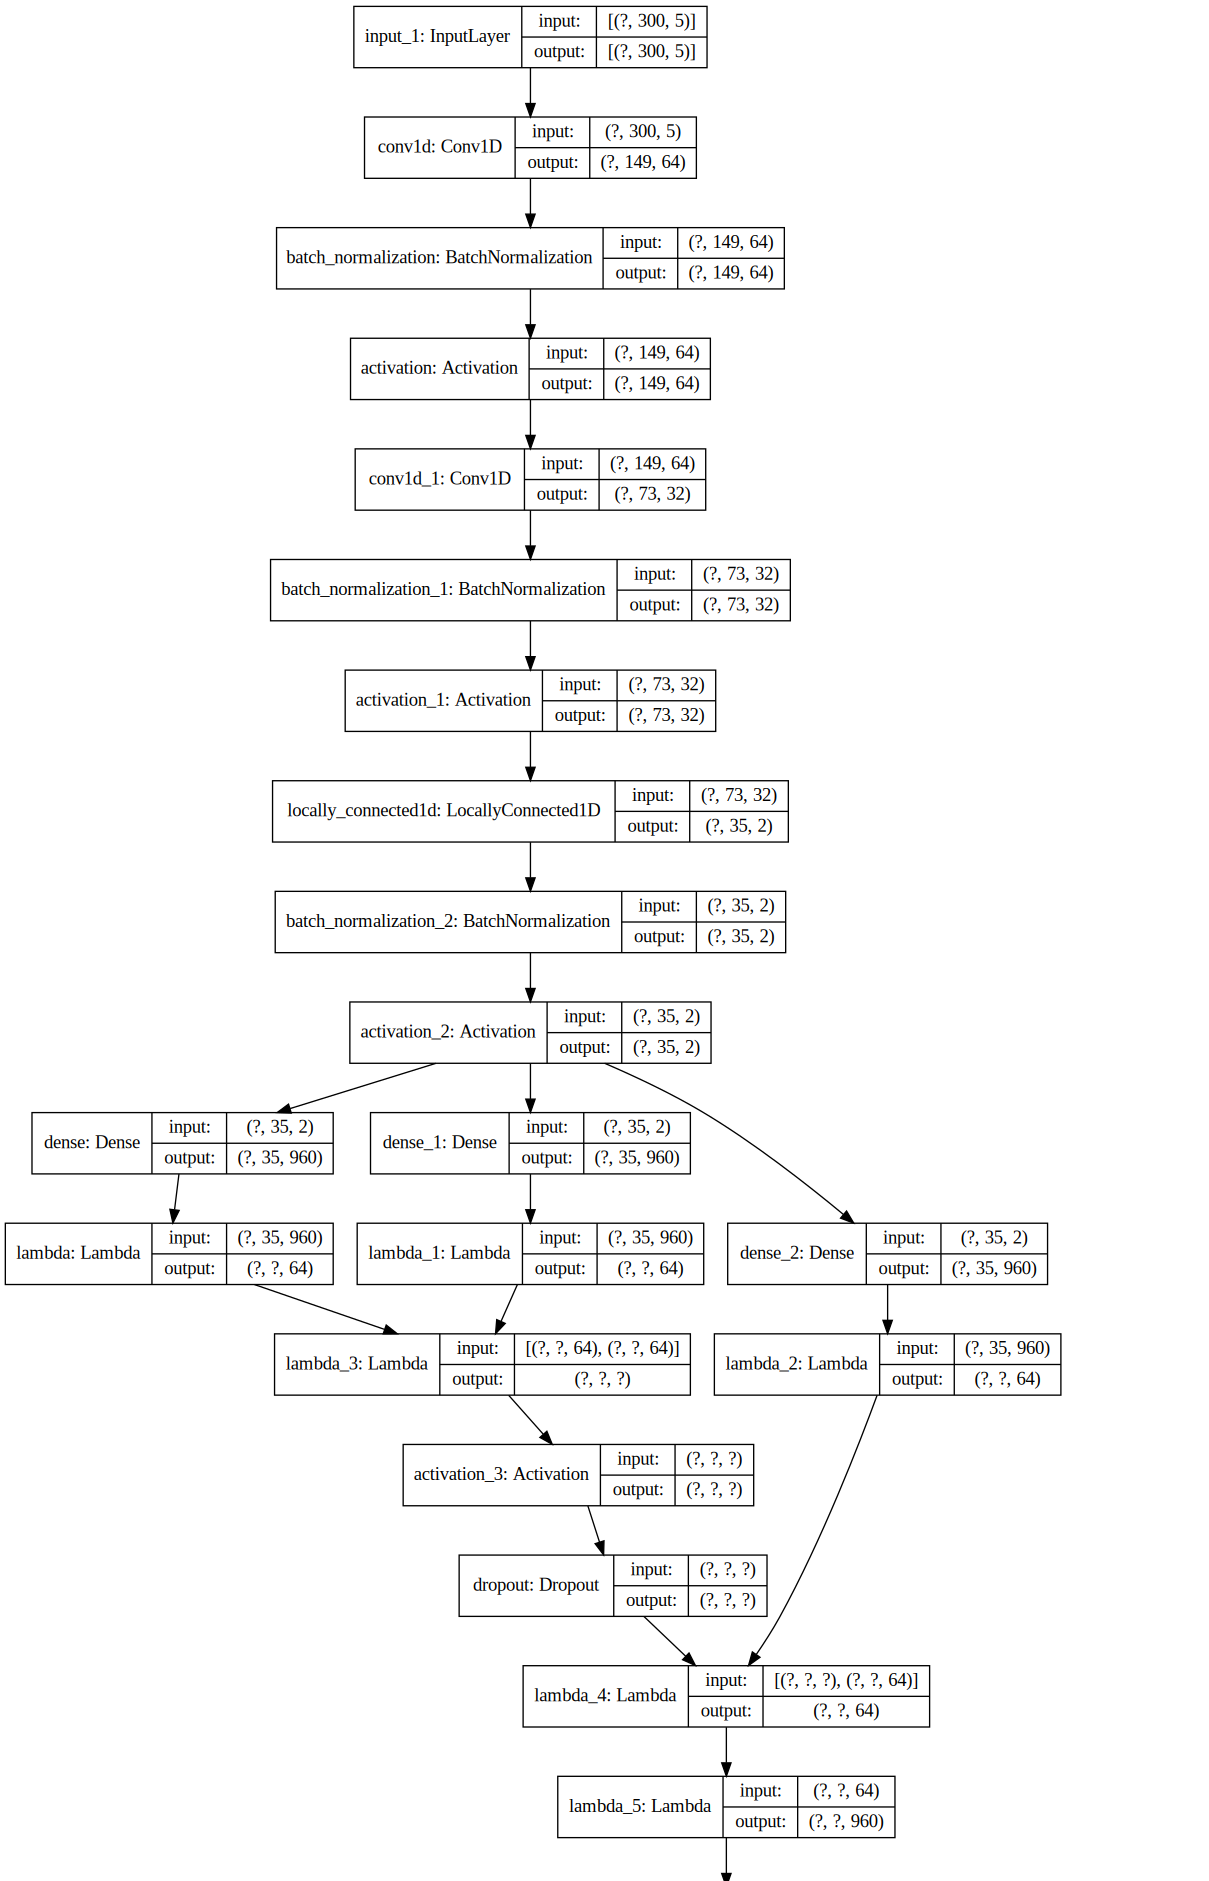

In [6]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [7]:
from datetime import datetime
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=50) 
callbacks_list = [checkpoint
                  , early
                  , reduceLROnPlat
                  , tensorboard_callback
                 ]

from IPython.display import clear_output
model.fit([train_X, train_X2], train_y,
                      validation_data = ([valid_X, valid_X2], valid_y), 
                      batch_size = 2048*2,
                      epochs = 500,
                      callbacks = callbacks_list)
#clear_output()

W1110 07:20:02.610323  2772 callbacks.py:1781] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


Train on 473568 samples, validate on 84370 samples


W1110 07:20:03.114435  2772 summary_ops_v2.py:1110] Model failed to serialize as JSON. Ignoring... Layers with arguments in `__init__` must override `get_config`.


Epoch 1/500
  4096/473568 [..............................] - ETA: 32:29 - loss: 1.6035 - recall: 0.0000e+00 - recall_1: 0.9986 - precision: 0.0000e+00 - precision_1: 0.1690

W1110 07:20:22.757816  2772 callbacks.py:243] Method (on_train_batch_end) is slow compared to the batch update (1.178262). Check your callbacks.


327680/473568 [===================>..........] - ETA: 18:35 - loss: 3.7261 - recall: 0.0000e+00 - recall_1: 0.4788 - precision: 0.0000e+00 - precision_1: 0.16 - ETA: 12:29 - loss: 3.6797 - recall: 0.0000e+00 - recall_1: 0.3175 - precision: 0.0000e+00 - precision_1: 0.16 - ETA: 9:25 - loss: 4.3411 - recall: 0.2612 - recall_1: 0.2418 - precision: 0.1897 - precision_1: 0.1690         - ETA: 7:35 - loss: 4.0623 - recall: 0.4050 - recall_1: 0.1930 - precision: 0.1826 - precision_1: 0.169 - ETA: 6:21 - loss: 3.7462 - recall: 0.3369 - recall_1: 0.1610 - precision: 0.1826 - precision_1: 0.169 - ETA: 5:28 - loss: 3.5272 - recall: 0.2870 - recall_1: 0.1393 - precision: 0.1826 - precision_1: 0.169 - ETA: 4:48 - loss: 3.3738 - recall: 0.2502 - recall_1: 0.1516 - precision: 0.1826 - precision_1: 0.167 - ETA: 4:17 - loss: 3.3503 - recall: 0.2224 - recall_1: 0.2463 - precision: 0.1826 - precision_1: 0.169 - ETA: 3:52 - loss: 3.2593 - recall: 0.2006 - recall_1: 0.2224 - precision: 0.1826 - precision_1

471040/473568 [============================>.] - ETA: 22s - loss: 1.3473 - recall: 0.0523 - recall_1: 0.0542 - precision: 0.1812 - precision_1: 0.17 - ETA: 22s - loss: 1.3417 - recall: 0.0517 - recall_1: 0.0535 - precision: 0.1812 - precision_1: 0.17 - ETA: 21s - loss: 1.3361 - recall: 0.0511 - recall_1: 0.0529 - precision: 0.1812 - precision_1: 0.17 - ETA: 20s - loss: 1.3309 - recall: 0.0505 - recall_1: 0.0523 - precision: 0.1812 - precision_1: 0.17 - ETA: 19s - loss: 1.3256 - recall: 0.0499 - recall_1: 0.0517 - precision: 0.1812 - precision_1: 0.17 - ETA: 18s - loss: 1.3206 - recall: 0.0493 - recall_1: 0.0511 - precision: 0.1812 - precision_1: 0.17 - ETA: 18s - loss: 1.3156 - recall: 0.0487 - recall_1: 0.0505 - precision: 0.1812 - precision_1: 0.17 - ETA: 17s - loss: 1.3110 - recall: 0.0482 - recall_1: 0.0499 - precision: 0.1812 - precision_1: 0.17 - ETA: 16s - loss: 1.3063 - recall: 0.0477 - recall_1: 0.0493 - precision: 0.1812 - precision_1: 0.17 - ETA: 16s - loss: 1.3017 - recall:

282624/473568 [================>.............] - ETA: 45s - loss: 0.8842 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 1:06 - loss: 0.8937 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+0 - ETA: 53s - loss: 0.8895 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+0 - ETA: 47s - loss: 0.8903 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 46s - loss: 0.8915 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 45s - loss: 0.8919 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 46s - loss: 0.8902 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 44s - loss: 0.8884 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA:

286720/473568 [=================>............] - ETA: 38s - loss: 0.8922 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37s - loss: 0.8919 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8948 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8939 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8936 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 33s - loss: 0.8916 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 33s - loss: 0.8905 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8879 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34

471040/473568 [============================>.] - ETA: 21s - loss: 0.8881 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 21s - loss: 0.8881 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 20s - loss: 0.8879 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 20s - loss: 0.8880 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 19s - loss: 0.8878 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 19s - loss: 0.8878 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 18s - loss: 0.8877 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 18s - loss: 0.8876 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 17

286720/473568 [=================>............] - ETA: 33s - loss: 0.8640 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8848 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8861 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8873 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8862 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 33s - loss: 0.8874 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8864 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8858 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34

286720/473568 [=================>............] - ETA: 30s - loss: 0.8961 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 30s - loss: 0.8862 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37s - loss: 0.8844 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 40s - loss: 0.8872 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 42s - loss: 0.8856 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 40s - loss: 0.8870 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 39s - loss: 0.8871 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 38s - loss: 0.8863 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37

471040/473568 [============================>.] - ETA: 21s - loss: 0.8860 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 21s - loss: 0.8859 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 20s - loss: 0.8859 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 20s - loss: 0.8859 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 19s - loss: 0.8858 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 19s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 18s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 18s - loss: 0.8858 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 17

286720/473568 [=================>............] - ETA: 30s - loss: 0.8942 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8913 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 32s - loss: 0.8906 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37s - loss: 0.8865 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 47s - loss: 0.8864 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 45s - loss: 0.8854 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 44s - loss: 0.8843 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 42s - loss: 0.8817 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 46

286720/473568 [=================>............] - ETA: 28s - loss: 0.8827 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8927 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8932 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8957 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8930 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8925 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8933 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 33s - loss: 0.8950 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34

471040/473568 [============================>.] - ETA: 17s - loss: 0.8897 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 16s - loss: 0.8896 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 16s - loss: 0.8894 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 16s - loss: 0.8895 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 15s - loss: 0.8896 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 15s - loss: 0.8895 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8896 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8895 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14

286720/473568 [=================>............] - ETA: 29s - loss: 0.9133 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8867 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8795 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8851 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8868 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8862 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8874 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8878 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34

286720/473568 [=================>............] - ETA: 28s - loss: 0.8874 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8792 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8773 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8788 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 31s - loss: 0.8804 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8807 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37s - loss: 0.8801 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37s - loss: 0.8811 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 36

471040/473568 [============================>.] - ETA: 15s - loss: 0.8838 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8839 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8840 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8840 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 13s - loss: 0.8842 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 13s - loss: 0.8838 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 13s - loss: 0.8841 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8841 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12

286720/473568 [=================>............] - ETA: 30s - loss: 0.8832 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 36s - loss: 0.8860 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 41s - loss: 0.8806 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 42s - loss: 0.8820 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 41s - loss: 0.8819 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 39s - loss: 0.8821 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37s - loss: 0.8817 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 39s - loss: 0.8832 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 39

286720/473568 [=================>............] - ETA: 30s - loss: 0.8993 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8977 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8910 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8907 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8905 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8913 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 30s - loss: 0.8889 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 31s - loss: 0.8900 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 33

471040/473568 [============================>.] - ETA: 13s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 13s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 13s - loss: 0.8856 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8856 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8855 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8858 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8858 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11

286720/473568 [=================>............] - ETA: 29s - loss: 0.9076 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8938 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8944 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8913 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8914 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8899 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8899 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37s - loss: 0.8889 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 37

286720/473568 [=================>............] - ETA: 29s - loss: 0.9062 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8944 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8874 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8873 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8875 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 31s - loss: 0.8868 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 35s - loss: 0.8865 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 34s - loss: 0.8865 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 33

471040/473568 [============================>.] - ETA: 15s - loss: 0.8850 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 15s - loss: 0.8850 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8852 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8852 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 14s - loss: 0.8854 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 13s - loss: 0.8854 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 13s - loss: 0.8855 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12

282624/473568 [================>.............] - ETA: 1:14 - loss: 0.8914 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+0 - ETA: 50s - loss: 0.8842 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+0 - ETA: 57s - loss: 0.8851 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 1:01 - loss: 0.8821 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+0 - ETA: 58s - loss: 0.8854 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+0 - ETA: 57s - loss: 0.8827 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 56s - loss: 0.8850 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 56s - loss: 0.8837 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - E

286720/473568 [=================>............] - ETA: 27s - loss: 0.9024 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8904 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8848 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8883 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8896 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8918 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8913 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8891 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 11s - loss: 0.8836 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8836 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8836 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8838 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8837 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8836 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8837 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8837 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 9s

286720/473568 [=================>............] - ETA: 28s - loss: 0.8950 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29s - loss: 0.8863 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8851 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8849 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8854 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8873 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8863 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8855 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 26s - loss: 0.8916 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8821 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8843 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8793 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8773 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8789 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8805 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8798 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8823 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8824 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8827 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8825 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8827 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8825 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8823 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8821 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 26s - loss: 0.8798 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8692 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8772 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8807 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8772 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8804 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8804 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8809 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8763 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8781 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8762 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8799 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8799 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8792 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8822 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8824 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8818 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8818 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8816 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8817 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8816 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8817 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8817 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8816 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 28s - loss: 0.8763 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8862 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8821 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8809 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8804 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8828 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8804 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8789 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8963 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8694 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8713 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8752 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8746 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8764 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8782 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8795 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 11s - loss: 0.8828 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8828 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8827 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8828 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8828 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8826 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8825 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 9s - loss: 0.8826 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+00 - ETA: 9

286720/473568 [=================>............] - ETA: 26s - loss: 0.8768 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8781 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8737 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8741 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8792 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8806 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8811 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8795 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8756 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8733 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8703 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8731 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8767 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8769 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8777 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8794 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25

471040/473568 [============================>.] - ETA: 13s - loss: 0.8822 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8822 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8821 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8820 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8821 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8822 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8822 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8823 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 27s - loss: 0.8816 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8957 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8920 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8886 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8895 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8886 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8866 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8749 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8753 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8792 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8784 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8777 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8787 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8792 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8787 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8803 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8802 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8803 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8802 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8800 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8802 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8803 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8804 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 9s

286720/473568 [=================>............] - ETA: 27s - loss: 0.8742 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8756 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8849 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8819 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8830 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8824 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8838 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8867 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 29s - loss: 0.8652 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8782 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8850 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8819 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8829 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8827 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8817 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8834 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 13s - loss: 0.8809 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8812 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8811 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8813 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8810 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8811 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8810 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8808 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 26s - loss: 0.8960 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8905 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8899 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8863 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8840 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8862 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8863 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8852 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25

286720/473568 [=================>............] - ETA: 27s - loss: 0.8791 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8817 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8782 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8746 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8742 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8740 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8751 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8767 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8794 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8793 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8794 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8795 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8795 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8795 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8794 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8796 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 27s - loss: 0.8752 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8727 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8771 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8737 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8759 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8779 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8778 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8783 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25

286720/473568 [=================>............] - ETA: 29s - loss: 0.8952 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8894 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8831 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8813 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8795 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8767 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8753 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8777 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 13s - loss: 0.8781 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8782 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8783 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8783 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8785 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8785 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8784 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8787 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 27s - loss: 0.8870 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8703 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8696 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8729 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8761 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8759 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8769 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8766 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8791 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8801 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8829 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8746 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8740 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8720 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8745 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8744 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8769 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8771 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8772 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8772 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8773 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8772 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8773 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8775 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 29s - loss: 0.8952 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8885 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8837 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8857 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8846 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8854 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8834 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8832 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8782 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8714 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8714 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8759 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8782 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8785 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8794 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8799 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25

471040/473568 [============================>.] - ETA: 12s - loss: 0.8763 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8765 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8762 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8764 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8765 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8764 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8764 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8767 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 26s - loss: 0.8581 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8669 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8751 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8763 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8758 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8781 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8781 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8736 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 28s - loss: 0.8613 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8592 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8627 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8677 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8692 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8704 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8705 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8716 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8722 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8720 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8720 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8720 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8719 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8717 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8715 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8716 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 27s - loss: 0.8770 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8702 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8703 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8651 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8657 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8659 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8678 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8698 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 28s - loss: 0.8670 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8697 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8689 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8704 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8686 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8678 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8681 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8678 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 29

471040/473568 [============================>.] - ETA: 12s - loss: 0.8669 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8669 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8671 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8671 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8671 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8670 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8668 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8668 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 26s - loss: 0.8702 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8714 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8732 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8692 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8695 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8701 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8709 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8707 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8519 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8642 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8674 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8648 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8617 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8615 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8607 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8610 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25

471040/473568 [============================>.] - ETA: 12s - loss: 0.8638 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8638 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8638 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8640 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8642 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8642 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8643 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8646 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 26s - loss: 0.8590 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8669 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8687 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8679 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8676 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8673 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8661 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8650 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 27s - loss: 0.8623 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8595 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8615 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8673 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8657 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8634 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8668 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8666 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8638 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8639 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8641 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8640 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8640 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8642 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8642 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8641 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 9s

286720/473568 [=================>............] - ETA: 28s - loss: 0.8771 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8672 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8691 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8720 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8691 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8708 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8692 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8676 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

286720/473568 [=================>............] - ETA: 26s - loss: 0.8537 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8465 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8516 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8526 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8497 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8523 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8521 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8532 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8603 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8603 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8602 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8604 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8604 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8603 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8603 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8602 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 10

286720/473568 [=================>............] - ETA: 28s - loss: 0.8359 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8514 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8596 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8563 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8556 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8562 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8580 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8585 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

290816/473568 [=================>............] - ETA: 27s - loss: 0.8593 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8615 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8615 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8629 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8607 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8609 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8588 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8597 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27

471040/473568 [============================>.] - ETA: 12s - loss: 0.8578 - recall: 5.4846e-05 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8580 - recall: 5.4111e-05 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 12s - loss: 0.8582 - recall: 7.1176e-05 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8582 - recall: 8.7758e-05 - recall_1: 0.0000e+00 - precision: 0.7143 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8583 - recall: 8.6540e-05 - recall_1: 0.0000e+00 - precision: 0.7143 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8583 - recall: 1.0252e-04 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8581 - recall: 1.0127e-04 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8584 - recall: 9.9960e-05 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8583 - recall: 9.866

294912/473568 [=================>............] - ETA: 28s - loss: 0.8484 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8645 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8581 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8567 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8579 - recall: 5.2521e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8552 - recall: 4.4267e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8559 - recall: 3.7943e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8578 - recall: 3.3052e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.

294912/473568 [=================>............] - ETA: 26s - loss: 0.8607 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8556 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8557 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8532 - recall: 3.3223e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8515 - recall: 2.6274e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8524 - recall: 2.1734e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8534 - recall: 1.8587e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8537 - recall: 1.6361e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8537

471040/473568 [============================>.] - ETA: 11s - loss: 0.8543 - recall: 9.0370e-05 - recall_1: 0.0000e+00 - precision: 0.2273 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8544 - recall: 1.0697e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8544 - recall: 1.0549e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8544 - recall: 1.0407e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8545 - recall: 1.0273e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8544 - recall: 1.3517e-04 - recall_1: 0.0000e+00 - precision: 0.3077 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8547 - recall: 1.3354e-04 - recall_1: 0.0000e+00 - precision: 0.3077 - precision_1: 0.0000e+ - ETA: 9s - loss: 0.8546 - recall: 1.3184e-04 - recall_1: 0.0000e+00 - precision: 0.2963 - precision_1: 0.0000e+00 - ETA: 9s - loss: 0.8548 - recall: 1.302

294912/473568 [=================>............] - ETA: 26s - loss: 0.8495 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8525 - recall: 6.4309e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8455 - recall: 4.3478e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8575 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8575 - recall: 0.0010 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8590 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.4667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8604 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.4500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8609 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.4500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8603 - recall: 0.0013 - recall_1: 0.0000

294912/473568 [=================>............] - ETA: 28s - loss: 0.8516 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8558 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8550 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8559 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8566 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8543 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8538 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8539 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8548 - recall: 2.3424e-04 - recall_1: 0.0000e+00 - precision: 0.3611 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8548 - recall: 2.8435e-04 - recall_1: 0.0000e+00 - precision: 0.3721 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8548 - recall: 2.9797e-04 - recall_1: 0.0000e+00 - precision: 0.3778 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8548 - recall: 2.9419e-04 - recall_1: 0.0000e+00 - precision: 0.3696 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8548 - recall: 2.9051e-04 - recall_1: 0.0000e+00 - precision: 0.3617 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8549 - recall: 3.0361e-04 - recall_1: 0.0000e+00 - precision: 0.3600 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8551 - recall: 2.9972e-04 - recall_1: 0.0000e+00 - precision: 0.3600 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8550 - recall: 2.9608e-04 - recall_1: 0.0000e+00 - precision: 0.3600 - precision_1: 0.0000e+ - ETA: 9s - loss: 0.8549 - recall: 2.9246

286720/473568 [=================>............] - ETA: 27s - loss: 0.8582 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8557 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8581 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8600 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8581 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8585 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8580 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8564 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

294912/473568 [=================>............] - ETA: 27s - loss: 0.8633 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8623 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8580 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8553 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8546 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8520 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8517 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8514 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27

471040/473568 [============================>.] - ETA: 12s - loss: 0.8520 - recall: 0.0000e+00 - recall_1: 1.3809e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 12s - loss: 0.8521 - recall: 0.0000e+00 - recall_1: 1.3627e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 11s - loss: 0.8523 - recall: 0.0000e+00 - recall_1: 1.3442e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 11s - loss: 0.8523 - recall: 0.0000e+00 - recall_1: 1.3266e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 11s - loss: 0.8522 - recall: 0.0000e+00 - recall_1: 1.3099e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 11s - loss: 0.8524 - recall: 0.0000e+00 - recall_1: 1.2926e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 10s - loss: 0.8523 - recall: 0.0000e+00 - recall_1: 1.2772e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 10s - loss: 0.8523 - recall: 0.0000e+00 - recall_1: 1.2612e-04 - precision: 0.0000e+00 - precision_1: 0.38 - ETA: 10s - loss: 0.8523 - recall: 0.000

294912/473568 [=================>............] - ETA: 27s - loss: 0.8510 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8503 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8551 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8516 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8485 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8484 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8520 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8490 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

303104/473568 [==================>...........] - ETA: 26s - loss: 0.8354 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8443 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8400 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8447 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8503 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8520 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8498 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8489 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 11s - loss: 0.8517 - recall: 5.2572e-05 - recall_1: 1.1548e-04 - precision: 0.5000 - precision_1: 0.35 - ETA: 11s - loss: 0.8519 - recall: 5.1857e-05 - recall_1: 1.1391e-04 - precision: 0.5000 - precision_1: 0.35 - ETA: 10s - loss: 0.8518 - recall: 5.1197e-05 - recall_1: 1.1241e-04 - precision: 0.5000 - precision_1: 0.35 - ETA: 10s - loss: 0.8519 - recall: 5.0548e-05 - recall_1: 1.1092e-04 - precision: 0.5000 - precision_1: 0.35 - ETA: 10s - loss: 0.8519 - recall: 4.9913e-05 - recall_1: 1.0950e-04 - precision: 0.5000 - precision_1: 0.35 - ETA: 9s - loss: 0.8517 - recall: 4.9317e-05 - recall_1: 1.0816e-04 - precision: 0.5000 - precision_1: 0.3529 - ETA: 9s - loss: 0.8517 - recall: 4.8699e-05 - recall_1: 1.0683e-04 - precision: 0.5000 - precision_1: 0.352 - ETA: 9s - loss: 0.8518 - recall: 4.8102e-05 - recall_1: 1.0550e-04 - precision: 0.5000 - precision_1: 0.352 - ETA: 9s - loss: 0.8517 - recall: 4.7536e-05 - recall_1: 1.0423e-04 - p

294912/473568 [=================>............] - ETA: 29s - loss: 0.8406 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8416 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8472 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8467 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8502 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8520 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8521 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8505 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

294912/473568 [=================>............] - ETA: 28s - loss: 0.8390 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8493 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8467 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8486 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8480 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8458 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8454 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8464 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 12s - loss: 0.8501 - recall: 1.4413e-04 - recall_1: 0.0000e+00 - precision: 0.8000 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8500 - recall: 1.4213e-04 - recall_1: 0.0000e+00 - precision: 0.8000 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8499 - recall: 1.4018e-04 - recall_1: 0.0000e+00 - precision: 0.8000 - precision_1: 0.0000e+ - ETA: 11s - loss: 0.8499 - recall: 1.5557e-04 - recall_1: 0.0000e+00 - precision: 0.8182 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8499 - recall: 1.5352e-04 - recall_1: 0.0000e+00 - precision: 0.8182 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8500 - recall: 1.5145e-04 - recall_1: 0.0000e+00 - precision: 0.8182 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8500 - recall: 1.4953e-04 - recall_1: 0.0000e+00 - precision: 0.8182 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8499 - recall: 1.4769e-04 - recall_1: 0.0000e+00 - precision: 0.8182 - precision_1: 0.0000e+ - ETA: 9s - loss: 0.8499 - recall: 1.4592

303104/473568 [==================>...........] - ETA: 26s - loss: 0.8455 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8432 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8481 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8469 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8518 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8515 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8502 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8511 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

294912/473568 [=================>............] - ETA: 26s - loss: 0.8479 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8519 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8479 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8472 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8471 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8442 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8443 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8441 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 11s - loss: 0.8473 - recall: 3.6080e-05 - recall_1: 3.9516e-05 - precision: 0.6667 - precision_1: 1.00 - ETA: 11s - loss: 0.8474 - recall: 3.5573e-05 - recall_1: 3.8987e-05 - precision: 0.6667 - precision_1: 1.00 - ETA: 11s - loss: 0.8474 - recall: 3.5092e-05 - recall_1: 3.8484e-05 - precision: 0.6667 - precision_1: 1.00 - ETA: 10s - loss: 0.8473 - recall: 3.4663e-05 - recall_1: 3.7954e-05 - precision: 0.6667 - precision_1: 1.00 - ETA: 10s - loss: 0.8473 - recall: 3.4200e-05 - recall_1: 3.7461e-05 - precision: 0.6667 - precision_1: 1.00 - ETA: 10s - loss: 0.8473 - recall: 3.3759e-05 - recall_1: 3.6989e-05 - precision: 0.6667 - precision_1: 1.00 - ETA: 10s - loss: 0.8474 - recall: 3.3335e-05 - recall_1: 3.6506e-05 - precision: 0.6667 - precision_1: 1.00 - ETA: 9s - loss: 0.8474 - recall: 3.2922e-05 - recall_1: 3.6046e-05 - precision: 0.6667 - precision_1: 1.0000 - ETA: 9s - loss: 0.8474 - recall: 3.2513e-05 - recall_1: 3.5607e-05 - p

294912/473568 [=================>............] - ETA: 27s - loss: 0.8395 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8428 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8461 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8532 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8541 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8537 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8542 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8541 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25

303104/473568 [==================>...........] - ETA: 27s - loss: 0.8519 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8412 - recall: 6.5488e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8369 - recall: 4.3956e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8346 - recall: 3.3190e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8406 - recall: 5.2673e-04 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8435 - recall: 4.3678e-04 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8433 - recall: 3.7736e-04 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8428 - recall: 3.3107e-04 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8428 - recal

471040/473568 [============================>.] - ETA: 12s - loss: 0.8483 - recall: 1.0538e-04 - recall_1: 7.6895e-05 - precision: 0.5455 - precision_1: 0.36 - ETA: 11s - loss: 0.8482 - recall: 1.0405e-04 - recall_1: 7.5874e-05 - precision: 0.5455 - precision_1: 0.36 - ETA: 11s - loss: 0.8483 - recall: 1.0261e-04 - recall_1: 9.3631e-05 - precision: 0.5455 - precision_1: 0.41 - ETA: 11s - loss: 0.8483 - recall: 1.0135e-04 - recall_1: 9.2406e-05 - precision: 0.5455 - precision_1: 0.41 - ETA: 10s - loss: 0.8483 - recall: 1.0001e-04 - recall_1: 9.1239e-05 - precision: 0.5455 - precision_1: 0.41 - ETA: 10s - loss: 0.8483 - recall: 9.8761e-05 - recall_1: 9.0127e-05 - precision: 0.5455 - precision_1: 0.41 - ETA: 10s - loss: 0.8484 - recall: 9.7507e-05 - recall_1: 8.9027e-05 - precision: 0.5455 - precision_1: 0.41 - ETA: 9s - loss: 0.8484 - recall: 9.6376e-05 - recall_1: 8.7918e-05 - precision: 0.5455 - precision_1: 0.4167 - ETA: 9s - loss: 0.8485 - recall: 9.5178e-05 - recall_1: 8.6848e-05 - p

303104/473568 [==================>...........] - ETA: 26s - loss: 0.8443 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8418 - recall: 6.7159e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8387 - recall: 4.4524e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8398 - recall: 3.2808e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8473 - recall: 5.1773e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8491 - recall: 4.3271e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8513 - recall: 3.7147e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8504 - recall: 3.2589e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8488 - recall: 2.9129e-0

303104/473568 [==================>...........] - ETA: 26s - loss: 0.8374 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8423 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8441 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8408 - recall: 6.7476e-04 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8440 - recall: 5.3362e-04 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8459 - recall: 6.6534e-04 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8456 - recall: 9.5420e-04 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8460 - recall: 8.3584e-04 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8454

471040/473568 [============================>.] - ETA: 9s - loss: 0.8451 - recall: 2.1093e-04 - recall_1: 9.6069e-05 - precision: 0.5714 - precision_1: 0.5556 - ETA: 9s - loss: 0.8451 - recall: 2.2549e-04 - recall_1: 9.4783e-05 - precision: 0.5909 - precision_1: 0.555 - ETA: 9s - loss: 0.8450 - recall: 2.2244e-04 - recall_1: 9.3615e-05 - precision: 0.5909 - precision_1: 0.555 - ETA: 9s - loss: 0.8451 - recall: 2.1945e-04 - recall_1: 9.2435e-05 - precision: 0.5909 - precision_1: 0.555 - ETA: 8s - loss: 0.8449 - recall: 2.1679e-04 - recall_1: 9.1294e-05 - precision: 0.5909 - precision_1: 0.555 - ETA: 8s - loss: 0.8449 - recall: 2.1408e-04 - recall_1: 9.0173e-05 - precision: 0.5909 - precision_1: 0.555 - ETA: 8s - loss: 0.8446 - recall: 2.1150e-04 - recall_1: 8.9125e-05 - precision: 0.5909 - precision_1: 0.555 - ETA: 8s - loss: 0.8446 - recall: 2.0897e-04 - recall_1: 8.8033e-05 - precision: 0.5909 - precision_1: 0.555 - ETA: 7s - loss: 0.8445 - recall: 2.0648e-04 - recall_1: 8.6973e-05 - p

299008/473568 [=================>............] - ETA: 28s - loss: 0.8380 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8359 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8436 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8479 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8487 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8477 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8481 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8486 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 25

303104/473568 [==================>...........] - ETA: 27s - loss: 0.8450 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8453 - recall: 6.5147e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8462 - recall: 4.3802e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8443 - recall: 3.3102e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8399 - recall: 2.6688e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8431 - recall: 2.2085e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8424 - recall: 1.8918e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8432 - recall: 1.6474e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8446 - recal

471040/473568 [============================>.] - ETA: 9s - loss: 0.8436 - recall: 1.0519e-04 - recall_1: 1.7234e-04 - precision: 0.4286 - precision_1: 0.6923 - ETA: 9s - loss: 0.8437 - recall: 1.0368e-04 - recall_1: 1.7024e-04 - precision: 0.4286 - precision_1: 0.692 - ETA: 9s - loss: 0.8437 - recall: 1.0233e-04 - recall_1: 1.8673e-04 - precision: 0.4286 - precision_1: 0.666 - ETA: 9s - loss: 0.8437 - recall: 1.0106e-04 - recall_1: 1.8438e-04 - precision: 0.4286 - precision_1: 0.666 - ETA: 8s - loss: 0.8437 - recall: 9.9761e-05 - recall_1: 1.8208e-04 - precision: 0.4286 - precision_1: 0.666 - ETA: 8s - loss: 0.8435 - recall: 9.8559e-05 - recall_1: 1.7988e-04 - precision: 0.4286 - precision_1: 0.666 - ETA: 8s - loss: 0.8437 - recall: 9.7376e-05 - recall_1: 1.7756e-04 - precision: 0.4286 - precision_1: 0.666 - ETA: 8s - loss: 0.8434 - recall: 9.6283e-05 - recall_1: 1.7540e-04 - precision: 0.4286 - precision_1: 0.666 - ETA: 7s - loss: 0.8433 - recall: 9.5191e-05 - recall_1: 1.7329e-04 - p

294912/473568 [=================>............] - ETA: 28s - loss: 0.8416 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8422 - recall: 6.5789e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8432 - recall: 4.3290e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8396 - recall: 3.2808e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8340 - recall: 2.6462e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8371 - recall: 2.1988e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8371 - recall: 1.8847e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8362 - recall: 1.6554e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8354 - recall: 1.4743e-0

294912/473568 [=================>............] - ETA: 28s - loss: 0.8336 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8385 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8338 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8342 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8317 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8343 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8370 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8376 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 10s - loss: 0.8401 - recall: 3.7907e-04 - recall_1: 1.9784e-05 - precision: 0.6176 - precision_1: 1.00 - ETA: 10s - loss: 0.8402 - recall: 3.7391e-04 - recall_1: 1.9518e-05 - precision: 0.6176 - precision_1: 1.00 - ETA: 10s - loss: 0.8401 - recall: 3.6924e-04 - recall_1: 1.9256e-05 - precision: 0.6176 - precision_1: 1.00 - ETA: 9s - loss: 0.8399 - recall: 3.8161e-04 - recall_1: 1.9014e-05 - precision: 0.6286 - precision_1: 1.0000 - ETA: 9s - loss: 0.8399 - recall: 3.7665e-04 - recall_1: 1.8777e-05 - precision: 0.6286 - precision_1: 1.000 - ETA: 9s - loss: 0.8399 - recall: 3.7189e-04 - recall_1: 1.8528e-05 - precision: 0.6286 - precision_1: 1.000 - ETA: 9s - loss: 0.8398 - recall: 3.6727e-04 - recall_1: 1.8305e-05 - precision: 0.6286 - precision_1: 1.000 - ETA: 8s - loss: 0.8398 - recall: 3.6259e-04 - recall_1: 1.8083e-05 - precision: 0.6286 - precision_1: 1.000 - ETA: 8s - loss: 0.8400 - recall: 3.5811e-04 - recall_1: 1.7849e-05 - p

294912/473568 [=================>............] - ETA: 28s - loss: 0.8457 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8378 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8386 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8385 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8385 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8395 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8409 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8414 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

294912/473568 [=================>............] - ETA: 28s - loss: 0.8493 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8414 - recall: 6.5147e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8372 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8344 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.8000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8336 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.8000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8345 - recall: 8.7489e-04 - recall_1: 0.0000e+00 - precision: 0.8000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8346 - recall: 7.5301e-04 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8332 - recall: 6.5854e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8323 - recall: 5.9058e-04 - reca

471040/473568 [============================>.] - ETA: 10s - loss: 0.8389 - recall: 2.5158e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8385 - recall: 2.4828e-04 - recall_1: 0.0000e+00 - precision: 0.4667 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8386 - recall: 2.4515e-04 - recall_1: 0.0000e+00 - precision: 0.4516 - precision_1: 0.0000e+ - ETA: 9s - loss: 0.8385 - recall: 2.4206e-04 - recall_1: 0.0000e+00 - precision: 0.4375 - precision_1: 0.0000e+00 - ETA: 9s - loss: 0.8381 - recall: 2.3910e-04 - recall_1: 0.0000e+00 - precision: 0.4375 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8380 - recall: 2.3602e-04 - recall_1: 0.0000e+00 - precision: 0.4242 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8382 - recall: 2.3293e-04 - recall_1: 0.0000e+00 - precision: 0.4242 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8382 - recall: 2.3014e-04 - recall_1: 0.0000e+00 - precision: 0.4242 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8383 - recall: 2.271

303104/473568 [==================>...........] - ETA: 28s - loss: 0.8457 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8433 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8353 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8337 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8350 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8367 - recall: 0.0000e+00 - recall_1: 2.4307e-04 - precision: 0.0000e+00 - precision_1: 1.0000   - ETA: 26s - loss: 0.8372 - recall: 1.8709e-04 - recall_1: 2.0610e-04 - precision: 1.0000 - precision_1: 1.0000   - ETA: 26s - loss: 0.8392 - recall: 3.2605e-04 - recall_1: 3.5945e-04 - precision: 0.6667 - precision_1: 0.50 - ETA: 26s - loss: 0.

299008/473568 [=================>............] - ETA: 28s - loss: 0.8317 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8288 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8311 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8305 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8316 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8328 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8315 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8322 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

471040/473568 [============================>.] - ETA: 10s - loss: 0.8364 - recall: 3.2026e-04 - recall_1: 1.1694e-04 - precision: 0.4737 - precision_1: 0.60 - ETA: 10s - loss: 0.8363 - recall: 3.5117e-04 - recall_1: 1.3456e-04 - precision: 0.5000 - precision_1: 0.63 - ETA: 9s - loss: 0.8365 - recall: 3.4643e-04 - recall_1: 1.3277e-04 - precision: 0.4762 - precision_1: 0.6364 - ETA: 9s - loss: 0.8364 - recall: 3.4212e-04 - recall_1: 1.3104e-04 - precision: 0.4651 - precision_1: 0.636 - ETA: 9s - loss: 0.8362 - recall: 3.3765e-04 - recall_1: 1.2948e-04 - precision: 0.4545 - precision_1: 0.583 - ETA: 9s - loss: 0.8364 - recall: 3.3339e-04 - recall_1: 1.2779e-04 - precision: 0.4444 - precision_1: 0.583 - ETA: 8s - loss: 0.8364 - recall: 3.4555e-04 - recall_1: 1.4423e-04 - precision: 0.4468 - precision_1: 0.615 - ETA: 8s - loss: 0.8365 - recall: 3.4121e-04 - recall_1: 1.4245e-04 - precision: 0.4375 - precision_1: 0.615 - ETA: 8s - loss: 0.8366 - recall: 3.3708e-04 - recall_1: 1.4060e-04 - p

303104/473568 [==================>...........] - ETA: 28s - loss: 0.8262 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8346 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8416 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8404 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8388 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8367 - recall: 2.1867e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8367 - recall: 1.8818e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8352 - recall: 1.6540e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 26s - loss

294912/473568 [=================>............] - ETA: 28s - loss: 0.8345 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8362 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8352 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8361 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8360 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8389 - recall: 2.1964e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8378 - recall: 1.8947e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8371 - recall: 1.6617e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss

471040/473568 [============================>.] - ETA: 10s - loss: 0.8357 - recall: 3.2396e-04 - recall_1: 0.0000e+00 - precision: 0.3830 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8358 - recall: 3.1982e-04 - recall_1: 0.0000e+00 - precision: 0.3830 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8356 - recall: 3.1571e-04 - recall_1: 0.0000e+00 - precision: 0.3830 - precision_1: 0.0000e+ - ETA: 9s - loss: 0.8357 - recall: 3.1137e-04 - recall_1: 0.0000e+00 - precision: 0.3830 - precision_1: 0.0000e+00 - ETA: 9s - loss: 0.8357 - recall: 3.0734e-04 - recall_1: 0.0000e+00 - precision: 0.3830 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8359 - recall: 3.2008e-04 - recall_1: 0.0000e+00 - precision: 0.3958 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8357 - recall: 3.1611e-04 - recall_1: 0.0000e+00 - precision: 0.3878 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8359 - recall: 3.1224e-04 - recall_1: 0.0000e+00 - precision: 0.3878 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8358 - recall: 3.084

299008/473568 [=================>............] - ETA: 28s - loss: 0.8371 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8358 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8411 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8428 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8375 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8354 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8329 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8332 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26

303104/473568 [==================>...........] - ETA: 28s - loss: 0.8292 - recall: 0.0014 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8263 - recall: 0.0014 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8241 - recall: 9.0703e-04 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8272 - recall: 0.0010 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8302 - recall: 7.9512e-04 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8296 - recall: 6.6800e-04 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8296 - recall: 5.7318e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8289 - recall: 5.0471e-04 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8301 - recall: 5.9550e-04 - 

471040/473568 [============================>.] - ETA: 10s - loss: 0.8342 - recall: 5.0690e-04 - recall_1: 3.8561e-05 - precision: 0.4531 - precision_1: 0.66 - ETA: 9s - loss: 0.8342 - recall: 5.0040e-04 - recall_1: 3.8042e-05 - precision: 0.4462 - precision_1: 0.6667 - ETA: 9s - loss: 0.8339 - recall: 4.9431e-04 - recall_1: 3.7534e-05 - precision: 0.4462 - precision_1: 0.666 - ETA: 9s - loss: 0.8338 - recall: 5.3872e-04 - recall_1: 3.7056e-05 - precision: 0.4706 - precision_1: 0.666 - ETA: 9s - loss: 0.8341 - recall: 5.3154e-04 - recall_1: 3.6599e-05 - precision: 0.4706 - precision_1: 0.666 - ETA: 8s - loss: 0.8341 - recall: 5.2495e-04 - recall_1: 3.6129e-05 - precision: 0.4638 - precision_1: 0.666 - ETA: 8s - loss: 0.8343 - recall: 5.1824e-04 - recall_1: 3.5681e-05 - precision: 0.4638 - precision_1: 0.666 - ETA: 8s - loss: 0.8345 - recall: 5.1179e-04 - recall_1: 3.5227e-05 - precision: 0.4638 - precision_1: 0.666 - ETA: 8s - loss: 0.8346 - recall: 5.0563e-04 - recall_1: 3.4807e-05 - p

307200/473568 [==================>...........] - ETA: 28s - loss: 0.8425 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8424 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8402 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8419 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8404 - recall: 2.5974e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8382 - recall: 2.1820e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8373 - recall: 3.7481e-04 - recall_1: 2.0383e-04 - precision: 0.3333 - precision_1: 0.3333   - ETA: 26s - loss: 0.8380 - recall: 4.9020e-04 - recall_1: 1.7844e-04 - precision: 0.4286 - precision_1: 0.33 - ETA: 26s - loss: 0.8381

303104/473568 [==================>...........] - ETA: 28s - loss: 0.8529 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8369 - recall: 6.3371e-04 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+00   - ETA: 28s - loss: 0.8285 - recall: 4.3234e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8288 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8295 - recall: 0.0010 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8314 - recall: 8.6787e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8345 - recall: 7.4225e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8356 - recall: 6.4756e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8377 - recall: 7

471040/473568 [============================>.] - ETA: 10s - loss: 0.8340 - recall: 7.8975e-04 - recall_1: 3.8401e-05 - precision: 0.5294 - precision_1: 0.66 - ETA: 9s - loss: 0.8339 - recall: 7.7980e-04 - recall_1: 3.7897e-05 - precision: 0.5294 - precision_1: 0.6667 - ETA: 9s - loss: 0.8340 - recall: 7.6941e-04 - recall_1: 3.7389e-05 - precision: 0.5294 - precision_1: 0.666 - ETA: 9s - loss: 0.8342 - recall: 7.5919e-04 - recall_1: 3.6894e-05 - precision: 0.5294 - precision_1: 0.666 - ETA: 9s - loss: 0.8342 - recall: 7.4926e-04 - recall_1: 3.6417e-05 - precision: 0.5294 - precision_1: 0.666 - ETA: 8s - loss: 0.8343 - recall: 7.4001e-04 - recall_1: 3.5950e-05 - precision: 0.5294 - precision_1: 0.666 - ETA: 8s - loss: 0.8342 - recall: 7.3083e-04 - recall_1: 3.5542e-05 - precision: 0.5294 - precision_1: 0.666 - ETA: 8s - loss: 0.8340 - recall: 7.2210e-04 - recall_1: 3.5125e-05 - precision: 0.5294 - precision_1: 0.666 - ETA: 8s - loss: 0.8342 - recall: 7.1332e-04 - recall_1: 3.4697e-05 - p

303104/473568 [==================>...........] - ETA: 28s - loss: 0.8275 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8353 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8341 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8403 - recall: 3.1726e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8420 - recall: 5.0723e-04 - recall_1: 0.0000e+00 - precision: 0.4000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8409 - recall: 6.3398e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8388 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.5455 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8363 - recall: 9.5755e-04 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8347

299008/473568 [=================>............] - ETA: 28s - loss: 0.8327 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8328 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+00       - ETA: 27s - loss: 0.8312 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.4000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8320 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.3846 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8335 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8326 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.4667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8313 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8300 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8305 - recall: 0.0013 - recall_1: 0.

471040/473568 [============================>.] - ETA: 10s - loss: 0.8332 - recall: 9.7997e-04 - recall_1: 1.9492e-05 - precision: 0.4867 - precision_1: 0.50 - ETA: 9s - loss: 0.8332 - recall: 9.6605e-04 - recall_1: 1.9249e-05 - precision: 0.4825 - precision_1: 0.5000 - ETA: 9s - loss: 0.8334 - recall: 9.5357e-04 - recall_1: 1.8983e-05 - precision: 0.4825 - precision_1: 0.500 - ETA: 9s - loss: 0.8334 - recall: 9.5815e-04 - recall_1: 1.8745e-05 - precision: 0.4870 - precision_1: 0.500 - ETA: 9s - loss: 0.8335 - recall: 9.6206e-04 - recall_1: 1.8507e-05 - precision: 0.4914 - precision_1: 0.500 - ETA: 9s - loss: 0.8332 - recall: 9.4975e-04 - recall_1: 1.8277e-05 - precision: 0.4872 - precision_1: 0.500 - ETA: 8s - loss: 0.8333 - recall: 9.3816e-04 - recall_1: 1.8042e-05 - precision: 0.4872 - precision_1: 0.500 - ETA: 8s - loss: 0.8333 - recall: 9.4312e-04 - recall_1: 1.7806e-05 - precision: 0.4874 - precision_1: 0.500 - ETA: 8s - loss: 0.8334 - recall: 9.3150e-04 - recall_1: 1.7585e-05 - p

303104/473568 [==================>...........] - ETA: 28s - loss: 0.8181 - recall: 0.0012 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8244 - recall: 6.1881e-04 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8295 - recall: 4.1771e-04 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8275 - recall: 9.5663e-04 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8291 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8268 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8289 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.5455 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8315 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8306 - recall: 0.0010 - recall_1: 0.

294912/473568 [=================>............] - ETA: 28s - loss: 0.8370 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8370 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8393 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8387 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8387 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8378 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8357 - recall: 1.8804e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8355 - recall: 1.6461e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - 

471040/473568 [============================>.] - ETA: 10s - loss: 0.8331 - recall: 7.7601e-04 - recall_1: 0.0000e+00 - precision: 0.4831 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8331 - recall: 7.6549e-04 - recall_1: 0.0000e+00 - precision: 0.4725 - precision_1: 0.0000e+ - ETA: 10s - loss: 0.8331 - recall: 7.7316e-04 - recall_1: 0.0000e+00 - precision: 0.4783 - precision_1: 0.0000e+ - ETA: 9s - loss: 0.8332 - recall: 8.3208e-04 - recall_1: 0.0000e+00 - precision: 0.4948 - precision_1: 0.0000e+00 - ETA: 9s - loss: 0.8332 - recall: 8.2113e-04 - recall_1: 0.0000e+00 - precision: 0.4948 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8332 - recall: 8.1076e-04 - recall_1: 0.0000e+00 - precision: 0.4848 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8333 - recall: 8.5008e-04 - recall_1: 0.0000e+00 - precision: 0.4951 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8332 - recall: 8.8883e-04 - recall_1: 0.0000e+00 - precision: 0.5047 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8331 - recall: 9.433

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8315 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8266 - recall: 0.0014 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8265 - recall: 8.9366e-04 - recall_1: 4.7596e-04 - precision: 0.4000 - precision_1: 1.00 - ETA: 27s - loss: 0.8279 - recall: 6.6247e-04 - recall_1: 3.5984e-04 - precision: 0.4000 - precision_1: 1.00 - ETA: 26s - loss: 0.8290 - recall: 5.3177e-04 - recall_1: 2.8645e-04 - precision: 0.2857 - precision_1: 1.00 - ETA: 26s - loss: 0.8296 - recall: 0.0011 - recall_1: 2.3793e-04 - precision: 0.5000 - precision_1: 1.0000   - ETA: 26s - loss: 0.8300 - recall: 9.4554e-04 - recall_1: 2.0614e-04 - precision: 0.5000 - precision_1: 1.00 - ETA: 26s - loss: 0.8291 - recall: 8.2754e-04 - recall_1: 1.8093e-04 - precision: 0.3571 - precision_1: 1.00 - ETA: 25s - loss: 0.8290 - recall: 7.3540e-04 - recall_1: 1.6134e-04 - p

307200/473568 [==================>...........] - ETA: 27s - loss: 0.8361 - recall: 0.0038 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8440 - recall: 0.0025 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8427 - recall: 0.0025 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8371 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.7000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8377 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8391 - recall: 0.0021 - recall_1: 0.0000e+00 - precision: 0.7692 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8377 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.7143 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8374 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8380 - recall: 0.0016 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8323 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5493 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8322 - recall: 0.0021 - recall_1: 0.0000e+00 - precision: 0.5525 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8322 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5426 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8320 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5328 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8318 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5259 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8318 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5299 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8319 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5316 - precision_1: 0.0000e+0 - ETA: 7s - loss: 0.8317 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5294 - precision_1: 0.0000e+0 - ETA: 7s - loss: 0.8319 - recall: 0.0020 - recall_1: 0.0000e+00 - precis

303104/473568 [==================>...........] - ETA: 26s - loss: 0.8294 - recall: 0.0014 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8326 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8323 - recall: 8.7758e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8303 - recall: 6.6225e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8313 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8318 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8322 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8336 - recall: 0.0012 - recall_1: 0.0000e+00 - precision: 0.6364 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8329 - recall: 0.0012 - recall_1: 0.0000

303104/473568 [==================>...........] - ETA: 27s - loss: 0.8387 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8338 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.2857 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8352 - recall: 8.7796e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8379 - recall: 6.4977e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8395 - recall: 0.0010 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8354 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8350 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.3810 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8350 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.3810 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8355 - recall: 0.0014 - recall_1: 0.0000

471040/473568 [============================>.] - ETA: 9s - loss: 0.8316 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.4922 - precision_1: 0.0000e+00 - ETA: 9s - loss: 0.8317 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.4897 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8316 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.4874 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8315 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.4802 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8315 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.4853 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8314 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.4904 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8314 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.4905 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8313 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.4906 - precision_1: 0.0000e+0 - ETA: 7s - loss: 0.8312 - recall: 0.0017 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8132 - recall: 0.0028 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8144 - recall: 0.0014 - recall_1: 7.1994e-04 - precision: 1.0000 - precision_1: 1.0000   - ETA: 27s - loss: 0.8210 - recall: 8.9485e-04 - recall_1: 4.8239e-04 - precision: 1.0000 - precision_1: 1.00 - ETA: 27s - loss: 0.8218 - recall: 0.0027 - recall_1: 3.6088e-04 - precision: 0.8000 - precision_1: 1.0000   - ETA: 27s - loss: 0.8287 - recall: 0.0024 - recall_1: 2.8686e-04 - precision: 0.8182 - precision_1: 1.00 - ETA: 26s - loss: 0.8289 - recall: 0.0024 - recall_1: 2.4125e-04 - precision: 0.7857 - precision_1: 1.00 - ETA: 26s - loss: 0.8295 - recall: 0.0033 - recall_1: 2.0708e-04 - precision: 0.7826 - precision_1: 1.00 - ETA: 26s - loss: 0.8317 - recall: 0.0034 - recall_1: 1.8054e-04 - precision: 0.6774 - precision_1: 1.00 - ETA: 25s - loss: 0.8320 - recall: 0.0036 - recall_1: 1.6072e-04 - precision: 0.6757 - p

307200/473568 [==================>...........] - ETA: 28s - loss: 0.8261 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8197 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8233 - recall: 0.0018 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8258 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8266 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8247 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5455 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8287 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8278 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8266 - recall: 0.0014 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8310 - recall: 0.0024 - recall_1: 0.0000e+00 - precision: 0.5251 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8309 - recall: 0.0024 - recall_1: 0.0000e+00 - precision: 0.5287 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8308 - recall: 0.0024 - recall_1: 0.0000e+00 - precision: 0.5338 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8308 - recall: 0.0024 - recall_1: 0.0000e+00 - precision: 0.5299 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8307 - recall: 0.0024 - recall_1: 0.0000e+00 - precision: 0.5277 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8305 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.5275 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8305 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.5275 - precision_1: 0.0000e+0 - ETA: 7s - loss: 0.8304 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.5292 - precision_1: 0.0000e+0 - ETA: 7s - loss: 0.8303 - recall: 0.0023 - recall_1: 0.0000e+00 - precis

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8336 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8306 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8287 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8252 - recall: 0.0027 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8261 - recall: 0.0032 - recall_1: 0.0000e+00 - precision: 0.4615 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8289 - recall: 0.0027 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8286 - recall: 0.0025 - recall_1: 0.0000e+00 - precision: 0.3939 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8282 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.3714 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8289 - recall: 0.0022 - recall_1: 0.0000e+00 - preci

307200/473568 [==================>...........] - ETA: 26s - loss: 0.8248 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8274 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8272 - recall: 4.3384e-04 - recall_1: 0.0000e+00 - precision: 0.1667 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8255 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.4545 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8271 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8283 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.5333 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8275 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.5263 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8276 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.4762 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8284 - recall: 0.0015 - 

471040/473568 [============================>.] - ETA: 9s - loss: 0.8303 - recall: 0.0020 - recall_1: 1.1330e-04 - precision: 0.5566 - precision_1: 0.428 - ETA: 9s - loss: 0.8302 - recall: 0.0021 - recall_1: 1.3051e-04 - precision: 0.5622 - precision_1: 0.466 - ETA: 9s - loss: 0.8301 - recall: 0.0021 - recall_1: 1.2893e-04 - precision: 0.5642 - precision_1: 0.466 - ETA: 8s - loss: 0.8298 - recall: 0.0021 - recall_1: 1.2735e-04 - precision: 0.5656 - precision_1: 0.466 - ETA: 8s - loss: 0.8297 - recall: 0.0021 - recall_1: 1.2582e-04 - precision: 0.5605 - precision_1: 0.466 - ETA: 8s - loss: 0.8296 - recall: 0.0020 - recall_1: 1.2436e-04 - precision: 0.5580 - precision_1: 0.466 - ETA: 8s - loss: 0.8296 - recall: 0.0020 - recall_1: 1.2278e-04 - precision: 0.5575 - precision_1: 0.466 - ETA: 7s - loss: 0.8295 - recall: 0.0021 - recall_1: 1.2133e-04 - precision: 0.5702 - precision_1: 0.466 - ETA: 7s - loss: 0.8296 - recall: 0.0021 - recall_1: 1.1995e-04 - precision: 0.5714 - precision_1: 0.466

303104/473568 [==================>...........] - ETA: 27s - loss: 0.8422 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8409 - recall: 6.5789e-04 - recall_1: 0.0000e+00 - precision: 0.1429 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8325 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8299 - recall: 9.9800e-04 - recall_1: 0.0000e+00 - precision: 0.2308 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8277 - recall: 8.0884e-04 - recall_1: 0.0000e+00 - precision: 0.2308 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8257 - recall: 6.7766e-04 - recall_1: 0.0000e+00 - precision: 0.2000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8253 - recall: 5.7571e-04 - recall_1: 0.0000e+00 - precision: 0.2000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8269 - recall: 5.0033e-04 - recall_1: 0.0000e+00 - precision: 0.2000 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8249 - recal

307200/473568 [==================>...........] - ETA: 27s - loss: 0.8344 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 28s - loss: 0.8331 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8273 - recall: 0.0018 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+00       - ETA: 27s - loss: 0.8276 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8319 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8346 - recall: 0.0011 - recall_1: 0.0000e+00 - precision: 0.4167 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8352 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.4375 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8360 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8357 - recall: 0.0013 - reca

471040/473568 [============================>.] - ETA: 9s - loss: 0.8289 - recall: 0.0027 - recall_1: 1.9017e-05 - precision: 0.5253 - precision_1: 0.166 - ETA: 9s - loss: 0.8289 - recall: 0.0027 - recall_1: 1.8765e-05 - precision: 0.5268 - precision_1: 0.166 - ETA: 9s - loss: 0.8287 - recall: 0.0027 - recall_1: 1.8527e-05 - precision: 0.5210 - precision_1: 0.166 - ETA: 8s - loss: 0.8289 - recall: 0.0028 - recall_1: 1.8288e-05 - precision: 0.5270 - precision_1: 0.166 - ETA: 8s - loss: 0.8289 - recall: 0.0028 - recall_1: 1.8057e-05 - precision: 0.5294 - precision_1: 0.166 - ETA: 8s - loss: 0.8288 - recall: 0.0028 - recall_1: 1.7839e-05 - precision: 0.5278 - precision_1: 0.166 - ETA: 8s - loss: 0.8289 - recall: 0.0028 - recall_1: 1.7625e-05 - precision: 0.5307 - precision_1: 0.166 - ETA: 7s - loss: 0.8294 - recall: 0.0028 - recall_1: 1.7393e-05 - precision: 0.5273 - precision_1: 0.166 - ETA: 7s - loss: 0.8293 - recall: 0.0028 - recall_1: 1.7183e-05 - precision: 0.5299 - precision_1: 0.166

307200/473568 [==================>...........] - ETA: 27s - loss: 0.8429 - recall: 0.0066 - recall_1: 0.0000e+00 - precision: 0.8333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8289 - recall: 0.0040 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8286 - recall: 0.0031 - recall_1: 0.0000e+00 - precision: 0.7000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8237 - recall: 0.0027 - recall_1: 0.0000e+00 - precision: 0.6154 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8285 - recall: 0.0032 - recall_1: 0.0000e+00 - precision: 0.6316 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8274 - recall: 0.0033 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8243 - recall: 0.0038 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8271 - recall: 0.0035 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8269 - recall: 0.0037 - recall_1: 0.0000e+00 - preci

303104/473568 [==================>...........] - ETA: 27s - loss: 0.8166 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8255 - recall: 6.6667e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8313 - recall: 8.9646e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8273 - recall: 0.0014 - recall_1: 0.0000e+00 - precision: 0.3636 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8287 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.4615 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8303 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8287 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.5263 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8291 - recall: 0.0018 - recall_1: 0.0000e+00 - precision: 0.5500 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8296 - recall: 0.0021 - recall_1: 0.0000

471040/473568 [============================>.] - ETA: 9s - loss: 0.8313 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5172 - precision_1: 0.0000e+00 - ETA: 9s - loss: 0.8313 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5171 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8314 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5153 - precision_1: 0.0000e+0 - ETA: 9s - loss: 0.8311 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5118 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8311 - recall: 0.0025 - recall_1: 0.0000e+00 - precision: 0.5101 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8309 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5148 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8309 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5209 - precision_1: 0.0000e+0 - ETA: 8s - loss: 0.8313 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5238 - precision_1: 0.0000e+0 - ETA: 7s - loss: 0.8312 - recall: 0.0026 - recall_1: 0.0000e+00 - preci

303104/473568 [==================>...........] - ETA: 28s - loss: 0.8286 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8272 - recall: 6.6711e-04 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8285 - recall: 8.9246e-04 - recall_1: 0.0000e+00 - precision: 0.4000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8273 - recall: 9.9470e-04 - recall_1: 0.0000e+00 - precision: 0.3750 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8283 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8269 - recall: 0.0018 - recall_1: 0.0000e+00 - precision: 0.5333 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8272 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8254 - recall: 0.0028 - recall_1: 0.0000e+00 - precision: 0.5312 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8248 - recall: 0.0028 - 

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8333 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8296 - recall: 6.6845e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8277 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+00   - ETA: 27s - loss: 0.8340 - recall: 0.0016 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8356 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8346 - recall: 0.0013 - recall_1: 2.3170e-04 - precision: 0.5455 - precision_1: 1.0000   - ETA: 26s - loss: 0.8330 - recall: 0.0013 - recall_1: 3.9960e-04 - precision: 0.5833 - precision_1: 1.00 - ETA: 26s - loss: 0.8322 - recall: 0.0018 - recall_1: 3.4746e-04 - precision: 0.6111 - precision_1: 1.00 - ETA: 26s - loss: 0.8330 - recall: 0.0022 - recall_1: 3.0798e-04 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8300 - recall: 0.0026 - recall_1: 5.5251e-05 - precision: 0.5398 - precision_1: 0.750 - ETA: 8s - loss: 0.8299 - recall: 0.0026 - recall_1: 5.4563e-05 - precision: 0.5356 - precision_1: 0.750 - ETA: 8s - loss: 0.8298 - recall: 0.0026 - recall_1: 5.3893e-05 - precision: 0.5320 - precision_1: 0.750 - ETA: 8s - loss: 0.8297 - recall: 0.0026 - recall_1: 5.3197e-05 - precision: 0.5316 - precision_1: 0.750 - ETA: 8s - loss: 0.8298 - recall: 0.0026 - recall_1: 5.2561e-05 - precision: 0.5279 - precision_1: 0.750 - ETA: 7s - loss: 0.8297 - recall: 0.0026 - recall_1: 5.1971e-05 - precision: 0.5279 - precision_1: 0.750 - ETA: 7s - loss: 0.8295 - recall: 0.0025 - recall_1: 5.1364e-05 - precision: 0.5244 - precision_1: 0.750 - ETA: 7s - loss: 0.8292 - recall: 0.0025 - recall_1: 5.0780e-05 - precision: 0.5260 - precision_1: 0.750 - ETA: 7s - loss: 0.8294 - recall: 0.0025 - recall_1: 5.0158e-05 - precision: 0.5243 - precision_1: 0.750

307200/473568 [==================>...........] - ETA: 28s - loss: 0.8235 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.2500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8289 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.2727 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8367 - recall: 0.0034 - recall_1: 0.0000e+00 - precision: 0.4211 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8318 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.3636 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8329 - recall: 0.0034 - recall_1: 0.0000e+00 - precision: 0.4815 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8324 - recall: 0.0032 - recall_1: 0.0000e+00 - precision: 0.4412 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8342 - recall: 0.0033 - recall_1: 0.0000e+00 - precision: 0.4390 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8351 - recall: 0.0029 - recall_1: 0.0000e+00 - precision: 0.4091 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8341 - recall: 0.0029 - recall_1: 0.0000e+00 - preci

307200/473568 [==================>...........] - ETA: 27s - loss: 0.8370 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8314 - recall: 6.3573e-04 - recall_1: 0.0000e+00 - precision: 0.2000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8291 - recall: 8.5143e-04 - recall_1: 0.0000e+00 - precision: 0.2222 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8281 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.4000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8269 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8289 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.4167 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8288 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8278 - recall: 0.0021 - recall_1: 0.0000e+00 - precision: 0.4643 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8271 - recall: 0.0020 - reca

471040/473568 [============================>.] - ETA: 9s - loss: 0.8275 - recall: 0.0026 - recall_1: 1.9103e-05 - precision: 0.4935 - precision_1: 0.333 - ETA: 9s - loss: 0.8275 - recall: 0.0027 - recall_1: 1.8860e-05 - precision: 0.4984 - precision_1: 0.333 - ETA: 9s - loss: 0.8273 - recall: 0.0027 - recall_1: 1.8621e-05 - precision: 0.5016 - precision_1: 0.333 - ETA: 8s - loss: 0.8274 - recall: 0.0027 - recall_1: 1.8382e-05 - precision: 0.5031 - precision_1: 0.333 - ETA: 8s - loss: 0.8273 - recall: 0.0027 - recall_1: 1.8154e-05 - precision: 0.5015 - precision_1: 0.333 - ETA: 8s - loss: 0.8273 - recall: 0.0027 - recall_1: 1.7919e-05 - precision: 0.5060 - precision_1: 0.333 - ETA: 8s - loss: 0.8275 - recall: 0.0027 - recall_1: 1.7686e-05 - precision: 0.5015 - precision_1: 0.250 - ETA: 7s - loss: 0.8274 - recall: 0.0027 - recall_1: 1.7480e-05 - precision: 0.5000 - precision_1: 0.250 - ETA: 7s - loss: 0.8275 - recall: 0.0027 - recall_1: 1.7263e-05 - precision: 0.4985 - precision_1: 0.250

311296/473568 [==================>...........] - ETA: 26s - loss: 0.8348 - recall: 0.0027 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8233 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8220 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.3750 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8225 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8211 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.4545 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8218 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8238 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8239 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.4211 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8253 - recall: 0.0015 - recall_1: 0.0000e+00 - preci

307200/473568 [==================>...........] - ETA: 26s - loss: 0.8086 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8146 - recall: 0.0092 - recall_1: 0.0000e+00 - precision: 0.6364 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8127 - recall: 0.0070 - recall_1: 0.0000e+00 - precision: 0.6154 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8246 - recall: 0.0061 - recall_1: 0.0000e+00 - precision: 0.5938 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8243 - recall: 0.0060 - recall_1: 0.0000e+00 - precision: 0.6053 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8285 - recall: 0.0060 - recall_1: 0.0000e+00 - precision: 0.5283 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8294 - recall: 0.0061 - recall_1: 0.0000e+00 - precision: 0.5500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8274 - recall: 0.0055 - recall_1: 0.0000e+00 - precision: 0.5312 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8278 - recall: 0.0049 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8275 - recall: 0.0037 - recall_1: 1.8998e-05 - precision: 0.5158 - precision_1: 0.333 - ETA: 9s - loss: 0.8273 - recall: 0.0036 - recall_1: 1.8754e-05 - precision: 0.5108 - precision_1: 0.333 - ETA: 9s - loss: 0.8274 - recall: 0.0036 - recall_1: 1.8509e-05 - precision: 0.5119 - precision_1: 0.333 - ETA: 8s - loss: 0.8277 - recall: 0.0036 - recall_1: 1.8264e-05 - precision: 0.5107 - precision_1: 0.333 - ETA: 8s - loss: 0.8278 - recall: 0.0036 - recall_1: 1.8028e-05 - precision: 0.5128 - precision_1: 0.333 - ETA: 8s - loss: 0.8277 - recall: 0.0036 - recall_1: 1.7810e-05 - precision: 0.5150 - precision_1: 0.333 - ETA: 8s - loss: 0.8279 - recall: 0.0036 - recall_1: 1.7578e-05 - precision: 0.5161 - precision_1: 0.333 - ETA: 7s - loss: 0.8278 - recall: 0.0036 - recall_1: 1.7383e-05 - precision: 0.5160 - precision_1: 0.333 - ETA: 7s - loss: 0.8276 - recall: 0.0036 - recall_1: 1.7174e-05 - precision: 0.5135 - precision_1: 0.333

311296/473568 [==================>...........] - ETA: 26s - loss: 0.8241 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8336 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8320 - recall: 0.0017 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8354 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8300 - recall: 0.0018 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8263 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8269 - recall: 0.0019 - recall_1: 0.0000e+00 - precision: 0.4762 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8289 - recall: 0.0018 - recall_1: 0.0000e+00 - precision: 0.4783 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8282 - recall: 0.0017 - recall_1: 0.0000e+00 - preci

311296/473568 [==================>...........] - ETA: 26s - loss: 0.8431 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8303 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8271 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8261 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8240 - recall: 2.6617e-04 - recall_1: 0.0000e+00 - precision: 0.1000 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8246 - recall: 4.4753e-04 - recall_1: 0.0000e+00 - precision: 0.1429 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8243 - recall: 5.7692e-04 - recall_1: 0.0000e+00 - precision: 0.1667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8222 - recall: 5.0590e-04 - recall_1: 0.0000e+00 - precision: 0.1667 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.

471040/473568 [============================>.] - ETA: 9s - loss: 0.8270 - recall: 0.0036 - recall_1: 1.8755e-05 - precision: 0.5278 - precision_1: 0.500 - ETA: 9s - loss: 0.8271 - recall: 0.0036 - recall_1: 1.8507e-05 - precision: 0.5312 - precision_1: 0.500 - ETA: 8s - loss: 0.8269 - recall: 0.0036 - recall_1: 1.8274e-05 - precision: 0.5356 - precision_1: 0.500 - ETA: 8s - loss: 0.8268 - recall: 0.0037 - recall_1: 1.8048e-05 - precision: 0.5400 - precision_1: 0.500 - ETA: 8s - loss: 0.8268 - recall: 0.0037 - recall_1: 1.7819e-05 - precision: 0.5394 - precision_1: 0.500 - ETA: 8s - loss: 0.8267 - recall: 0.0037 - recall_1: 1.7612e-05 - precision: 0.5397 - precision_1: 0.500 - ETA: 7s - loss: 0.8266 - recall: 0.0037 - recall_1: 1.7406e-05 - precision: 0.5355 - precision_1: 0.500 - ETA: 7s - loss: 0.8265 - recall: 0.0037 - recall_1: 1.7195e-05 - precision: 0.5244 - precision_1: 0.500 - ETA: 7s - loss: 0.8266 - recall: 0.0037 - recall_1: 1.6989e-05 - precision: 0.5241 - precision_1: 0.500

311296/473568 [==================>...........] - ETA: 26s - loss: 0.8352 - recall: 0.0075 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8384 - recall: 0.0051 - recall_1: 0.0000e+00 - precision: 0.5333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8433 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.5500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8398 - recall: 0.0045 - recall_1: 0.0000e+00 - precision: 0.5833 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8391 - recall: 0.0041 - recall_1: 0.0000e+00 - precision: 0.5926 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8346 - recall: 0.0049 - recall_1: 0.0000e+00 - precision: 0.6389 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8335 - recall: 0.0055 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8299 - recall: 0.0061 - recall_1: 0.0000e+00 - precision: 0.6441 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8311 - recall: 0.0060 - recall_1: 0.0000e+00 - preci

307200/473568 [==================>...........] - ETA: 27s - loss: 0.8321 - recall: 0.0051 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8351 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8313 - recall: 0.0048 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8253 - recall: 0.0046 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8252 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.5357 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8252 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.4737 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8250 - recall: 0.0037 - recall_1: 0.0000e+00 - precision: 0.4651 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8245 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.4898 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8249 - recall: 0.0042 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8273 - recall: 0.0040 - recall_1: 1.8942e-05 - precision: 0.5249 - precision_1: 0.200 - ETA: 9s - loss: 0.8272 - recall: 0.0040 - recall_1: 3.7397e-05 - precision: 0.5280 - precision_1: 0.333 - ETA: 9s - loss: 0.8271 - recall: 0.0040 - recall_1: 3.6935e-05 - precision: 0.5290 - precision_1: 0.333 - ETA: 8s - loss: 0.8272 - recall: 0.0040 - recall_1: 3.6456e-05 - precision: 0.5311 - precision_1: 0.333 - ETA: 8s - loss: 0.8274 - recall: 0.0039 - recall_1: 3.6026e-05 - precision: 0.5311 - precision_1: 0.333 - ETA: 8s - loss: 0.8273 - recall: 0.0039 - recall_1: 3.5584e-05 - precision: 0.5320 - precision_1: 0.333 - ETA: 8s - loss: 0.8273 - recall: 0.0039 - recall_1: 3.5162e-05 - precision: 0.5272 - precision_1: 0.333 - ETA: 7s - loss: 0.8272 - recall: 0.0039 - recall_1: 3.4755e-05 - precision: 0.5136 - precision_1: 0.333 - ETA: 7s - loss: 0.8272 - recall: 0.0039 - recall_1: 3.4348e-05 - precision: 0.5146 - precision_1: 0.333

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8374 - recall: 0.0000e+00 - recall_1: 0.0014 - precision: 0.0000e+00 - precision_1: 1.00 - ETA: 27s - loss: 0.8290 - recall: 6.5488e-04 - recall_1: 7.0373e-04 - precision: 0.5000 - precision_1: 0.50 - ETA: 26s - loss: 0.8303 - recall: 4.3328e-04 - recall_1: 4.6970e-04 - precision: 0.5000 - precision_1: 0.33 - ETA: 27s - loss: 0.8320 - recall: 9.8007e-04 - recall_1: 3.5199e-04 - precision: 0.6000 - precision_1: 0.33 - ETA: 26s - loss: 0.8298 - recall: 0.0013 - recall_1: 2.8321e-04 - precision: 0.6250 - precision_1: 0.3333   - ETA: 26s - loss: 0.8300 - recall: 0.0017 - recall_1: 2.3730e-04 - precision: 0.6154 - precision_1: 0.33 - ETA: 26s - loss: 0.8285 - recall: 0.0024 - recall_1: 2.0305e-04 - precision: 0.6190 - precision_1: 0.33 - ETA: 26s - loss: 0.8295 - recall: 0.0028 - recall_1: 1.7740e-04 - precision: 0.6296 - precision_1: 0.33 - ETA: 25s - loss: 0.8278 - recall: 0.0028 - recall_1: 1.5778e-04 - precision: 0.6129

311296/473568 [==================>...........] - ETA: 28s - loss: 0.8279 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8307 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8240 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.6429 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8242 - recall: 0.0046 - recall_1: 0.0000e+00 - precision: 0.5600 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8210 - recall: 0.0058 - recall_1: 0.0000e+00 - precision: 0.6111 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8223 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.5455 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8204 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8203 - recall: 0.0051 - recall_1: 0.0000e+00 - precision: 0.5636 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8199 - recall: 0.0046 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8258 - recall: 0.0037 - recall_1: 1.1230e-04 - precision: 0.5333 - precision_1: 0.750 - ETA: 9s - loss: 0.8259 - recall: 0.0037 - recall_1: 1.1087e-04 - precision: 0.5333 - precision_1: 0.750 - ETA: 8s - loss: 0.8260 - recall: 0.0036 - recall_1: 1.0949e-04 - precision: 0.5343 - precision_1: 0.750 - ETA: 8s - loss: 0.8259 - recall: 0.0036 - recall_1: 1.0813e-04 - precision: 0.5328 - precision_1: 0.750 - ETA: 8s - loss: 0.8259 - recall: 0.0036 - recall_1: 1.0686e-04 - precision: 0.5327 - precision_1: 0.750 - ETA: 8s - loss: 0.8258 - recall: 0.0036 - recall_1: 1.0555e-04 - precision: 0.5335 - precision_1: 0.750 - ETA: 7s - loss: 0.8259 - recall: 0.0037 - recall_1: 1.0425e-04 - precision: 0.5397 - precision_1: 0.750 - ETA: 7s - loss: 0.8259 - recall: 0.0037 - recall_1: 1.0302e-04 - precision: 0.5394 - precision_1: 0.750 - ETA: 7s - loss: 0.8258 - recall: 0.0037 - recall_1: 1.0178e-04 - precision: 0.5399 - precision_1: 0.750

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8356 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8319 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8304 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.4167 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8294 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.3500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8290 - recall: 0.0029 - recall_1: 0.0000e+00 - precision: 0.4400 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8280 - recall: 0.0028 - recall_1: 0.0000e+00 - precision: 0.4815 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8282 - recall: 0.0030 - recall_1: 0.0000e+00 - precision: 0.5161 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8270 - recall: 0.0036 - recall_1: 0.0000e+00 - precision: 0.5500 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8262 - recall: 0.0036 - recall_1: 0.0000e+00 - preci

307200/473568 [==================>...........] - ETA: 26s - loss: 0.8208 - recall: 0.0069 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8205 - recall: 0.0060 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8161 - recall: 0.0057 - recall_1: 0.0000e+00 - precision: 0.6500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8192 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8214 - recall: 0.0048 - recall_1: 0.0000e+00 - precision: 0.5455 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8214 - recall: 0.0042 - recall_1: 0.0000e+00 - precision: 0.5278 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8237 - recall: 0.0036 - recall_1: 0.0000e+00 - precision: 0.4750 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8235 - recall: 0.0036 - recall_1: 0.0000e+00 - precision: 0.4783 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8234 - recall: 0.0038 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8250 - recall: 0.0044 - recall_1: 1.9022e-05 - precision: 0.5505 - precision_1: 0.500 - ETA: 9s - loss: 0.8251 - recall: 0.0045 - recall_1: 1.8769e-05 - precision: 0.5527 - precision_1: 0.500 - ETA: 9s - loss: 0.8251 - recall: 0.0045 - recall_1: 1.8527e-05 - precision: 0.5519 - precision_1: 0.500 - ETA: 8s - loss: 0.8251 - recall: 0.0045 - recall_1: 1.8303e-05 - precision: 0.5492 - precision_1: 0.500 - ETA: 8s - loss: 0.8252 - recall: 0.0044 - recall_1: 1.8078e-05 - precision: 0.5486 - precision_1: 0.500 - ETA: 8s - loss: 0.8253 - recall: 0.0044 - recall_1: 1.7851e-05 - precision: 0.5473 - precision_1: 0.500 - ETA: 8s - loss: 0.8253 - recall: 0.0045 - recall_1: 1.7625e-05 - precision: 0.5531 - precision_1: 0.500 - ETA: 7s - loss: 0.8251 - recall: 0.0045 - recall_1: 1.7410e-05 - precision: 0.5536 - precision_1: 0.500 - ETA: 7s - loss: 0.8253 - recall: 0.0045 - recall_1: 1.7210e-05 - precision: 0.5523 - precision_1: 0.500

307200/473568 [==================>...........] - ETA: 28s - loss: 0.8356 - recall: 0.0081 - recall_1: 0.0000e+00 - precision: 0.4000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8190 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8238 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.4800 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8290 - recall: 0.0049 - recall_1: 0.0000e+00 - precision: 0.5357 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8299 - recall: 0.0045 - recall_1: 0.0000e+00 - precision: 0.5312 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8277 - recall: 0.0042 - recall_1: 0.0000e+00 - precision: 0.5135 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8283 - recall: 0.0043 - recall_1: 0.0000e+00 - precision: 0.5476 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8257 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8270 - recall: 0.0046 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8231 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8343 - recall: 6.5660e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8278 - recall: 8.7989e-04 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8287 - recall: 6.6269e-04 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8301 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+00   - ETA: 26s - loss: 0.8320 - recall: 0.0015 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8277 - recall: 0.0023 - recall_1: 0.0000e+00 - precision: 0.6316 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8264 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5926 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8260 - recall: 0.0028 - recall_1: 0.

471040/473568 [============================>.] - ETA: 9s - loss: 0.8244 - recall: 0.0045 - recall_1: 5.5569e-05 - precision: 0.5254 - precision_1: 0.428 - ETA: 8s - loss: 0.8241 - recall: 0.0045 - recall_1: 5.4890e-05 - precision: 0.5271 - precision_1: 0.428 - ETA: 8s - loss: 0.8241 - recall: 0.0045 - recall_1: 5.4216e-05 - precision: 0.5270 - precision_1: 0.428 - ETA: 8s - loss: 0.8243 - recall: 0.0045 - recall_1: 5.3516e-05 - precision: 0.5257 - precision_1: 0.428 - ETA: 8s - loss: 0.8244 - recall: 0.0046 - recall_1: 5.2870e-05 - precision: 0.5260 - precision_1: 0.428 - ETA: 7s - loss: 0.8245 - recall: 0.0047 - recall_1: 5.2226e-05 - precision: 0.5298 - precision_1: 0.428 - ETA: 7s - loss: 0.8246 - recall: 0.0047 - recall_1: 5.1624e-05 - precision: 0.5356 - precision_1: 0.428 - ETA: 7s - loss: 0.8245 - recall: 0.0047 - recall_1: 5.0992e-05 - precision: 0.5362 - precision_1: 0.428 - ETA: 7s - loss: 0.8246 - recall: 0.0047 - recall_1: 5.0385e-05 - precision: 0.5332 - precision_1: 0.428

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8165 - recall: 0.0014 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8278 - recall: 0.0013 - recall_1: 0.0000e+00 - precision: 0.4000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8283 - recall: 0.0022 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8289 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8270 - recall: 0.0029 - recall_1: 0.0000e+00 - precision: 0.5789 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8296 - recall: 0.0027 - recall_1: 0.0000e+00 - precision: 0.5455 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8293 - recall: 0.0025 - recall_1: 2.0467e-04 - precision: 0.5200 - precision_1: 1.0000   - ETA: 26s - loss: 0.8280 - recall: 0.0026 - recall_1: 1.7966e-04 - precision: 0.5161 - precision_1: 1.00 - ETA: 25s - loss: 0.8291 - recall: 0.0028 - recall_1: 1.5896e-04 - precision

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8306 - recall: 0.0038 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8125 - recall: 0.0060 - recall_1: 0.0000e+00 - precision: 0.4737 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8139 - recall: 0.0054 - recall_1: 0.0000e+00 - precision: 0.4800 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8173 - recall: 0.0050 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8208 - recall: 0.0048 - recall_1: 0.0000e+00 - precision: 0.5143 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8233 - recall: 0.0048 - recall_1: 0.0000e+00 - precision: 0.4889 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8237 - recall: 0.0045 - recall_1: 0.0000e+00 - precision: 0.4528 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8231 - recall: 0.0046 - recall_1: 0.0000e+00 - precision: 0.4746 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8223 - recall: 0.0048 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8258 - recall: 0.0055 - recall_1: 5.5399e-05 - precision: 0.5435 - precision_1: 0.500 - ETA: 8s - loss: 0.8257 - recall: 0.0055 - recall_1: 5.4672e-05 - precision: 0.5455 - precision_1: 0.500 - ETA: 8s - loss: 0.8259 - recall: 0.0055 - recall_1: 5.3975e-05 - precision: 0.5415 - precision_1: 0.500 - ETA: 8s - loss: 0.8259 - recall: 0.0055 - recall_1: 5.3321e-05 - precision: 0.5428 - precision_1: 0.500 - ETA: 8s - loss: 0.8258 - recall: 0.0054 - recall_1: 5.2659e-05 - precision: 0.5399 - precision_1: 0.500 - ETA: 7s - loss: 0.8258 - recall: 0.0054 - recall_1: 5.2043e-05 - precision: 0.5388 - precision_1: 0.500 - ETA: 7s - loss: 0.8259 - recall: 0.0054 - recall_1: 6.8546e-05 - precision: 0.5368 - precision_1: 0.571 - ETA: 7s - loss: 0.8261 - recall: 0.0053 - recall_1: 6.7708e-05 - precision: 0.5349 - precision_1: 0.571 - ETA: 7s - loss: 0.8262 - recall: 0.0053 - recall_1: 6.6889e-05 - precision: 0.5322 - precision_1: 0.571

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8058 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - precision: 0.0000e+00 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8173 - recall: 0.0040 - recall_1: 0.0000e+00 - precision: 0.4615 - precision_1: 0.0000e+00       - ETA: 27s - loss: 0.8176 - recall: 0.0035 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8173 - recall: 0.0033 - recall_1: 0.0000e+00 - precision: 0.4348 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8165 - recall: 0.0032 - recall_1: 0.0000e+00 - precision: 0.4615 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8195 - recall: 0.0042 - recall_1: 0.0000e+00 - precision: 0.5588 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8217 - recall: 0.0037 - recall_1: 0.0000e+00 - precision: 0.5263 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8239 - recall: 0.0036 - recall_1: 0.0000e+00 - precision: 0.5238 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8236 - recall: 0.0034 - recall_1: 0.

311296/473568 [==================>...........] - ETA: 26s - loss: 0.8247 - recall: 0.0080 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8170 - recall: 0.0086 - recall_1: 0.0000e+00 - precision: 0.5909 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8185 - recall: 0.0092 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8183 - recall: 0.0084 - recall_1: 0.0000e+00 - precision: 0.5532 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8228 - recall: 0.0085 - recall_1: 0.0000e+00 - precision: 0.5789 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8228 - recall: 0.0079 - recall_1: 0.0000e+00 - precision: 0.5781 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8236 - recall: 0.0074 - recall_1: 0.0000e+00 - precision: 0.5634 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8217 - recall: 0.0070 - recall_1: 0.0000e+00 - precision: 0.5584 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8241 - recall: 0.0066 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8249 - recall: 0.0057 - recall_1: 7.4743e-05 - precision: 0.5640 - precision_1: 0.571 - ETA: 9s - loss: 0.8249 - recall: 0.0057 - recall_1: 7.3741e-05 - precision: 0.5638 - precision_1: 0.571 - ETA: 8s - loss: 0.8249 - recall: 0.0058 - recall_1: 7.2805e-05 - precision: 0.5654 - precision_1: 0.571 - ETA: 8s - loss: 0.8248 - recall: 0.0057 - recall_1: 7.1964e-05 - precision: 0.5647 - precision_1: 0.571 - ETA: 8s - loss: 0.8251 - recall: 0.0057 - recall_1: 7.1029e-05 - precision: 0.5659 - precision_1: 0.571 - ETA: 8s - loss: 0.8252 - recall: 0.0057 - recall_1: 7.0155e-05 - precision: 0.5637 - precision_1: 0.571 - ETA: 7s - loss: 0.8251 - recall: 0.0056 - recall_1: 6.9334e-05 - precision: 0.5635 - precision_1: 0.571 - ETA: 7s - loss: 0.8250 - recall: 0.0056 - recall_1: 6.8558e-05 - precision: 0.5624 - precision_1: 0.571 - ETA: 7s - loss: 0.8248 - recall: 0.0055 - recall_1: 6.7756e-05 - precision: 0.5622 - precision_1: 0.571

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8243 - recall: 0.0051 - recall_1: 0.0000e+00 - precision: 0.4444 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8256 - recall: 0.0066 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8241 - recall: 0.0057 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8229 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.5517 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8213 - recall: 0.0051 - recall_1: 0.0000e+00 - precision: 0.5588 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8207 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.5250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8201 - recall: 0.0051 - recall_1: 0.0000e+00 - precision: 0.5870 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8185 - recall: 0.0050 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8174 - recall: 0.0047 - recall_1: 1.6051e-04 - preci

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8251 - recall: 0.0040 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8225 - recall: 0.0040 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8232 - recall: 0.0027 - recall_1: 0.0000e+00 - precision: 0.5455 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8206 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8209 - recall: 0.0021 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8201 - recall: 0.0024 - recall_1: 0.0000e+00 - precision: 0.5789 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8186 - recall: 0.0030 - recall_1: 0.0000e+00 - precision: 0.5926 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8207 - recall: 0.0035 - recall_1: 0.0000e+00 - precision: 0.5833 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8207 - recall: 0.0045 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8233 - recall: 0.0060 - recall_1: 5.5327e-05 - precision: 0.5605 - precision_1: 0.333 - ETA: 8s - loss: 0.8233 - recall: 0.0060 - recall_1: 5.4657e-05 - precision: 0.5578 - precision_1: 0.333 - ETA: 8s - loss: 0.8233 - recall: 0.0060 - recall_1: 5.3970e-05 - precision: 0.5586 - precision_1: 0.333 - ETA: 8s - loss: 0.8233 - recall: 0.0059 - recall_1: 5.3318e-05 - precision: 0.5567 - precision_1: 0.333 - ETA: 8s - loss: 0.8232 - recall: 0.0059 - recall_1: 5.2684e-05 - precision: 0.5552 - precision_1: 0.333 - ETA: 7s - loss: 0.8232 - recall: 0.0059 - recall_1: 5.2033e-05 - precision: 0.5565 - precision_1: 0.333 - ETA: 7s - loss: 0.8231 - recall: 0.0060 - recall_1: 5.1409e-05 - precision: 0.5570 - precision_1: 0.333 - ETA: 7s - loss: 0.8232 - recall: 0.0060 - recall_1: 5.0814e-05 - precision: 0.5572 - precision_1: 0.333 - ETA: 7s - loss: 0.8234 - recall: 0.0060 - recall_1: 5.0202e-05 - precision: 0.5540 - precision_1: 0.333

311296/473568 [==================>...........] - ETA: 26s - loss: 0.8419 - recall: 0.0012 - recall_1: 0.0000e+00 - precision: 0.1667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8404 - recall: 0.0038 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8381 - recall: 0.0043 - recall_1: 0.0000e+00 - precision: 0.4167 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8397 - recall: 0.0048 - recall_1: 0.0000e+00 - precision: 0.4545 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8336 - recall: 0.0044 - recall_1: 0.0000e+00 - precision: 0.4359 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8365 - recall: 0.0041 - recall_1: 0.0000e+00 - precision: 0.4318 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8336 - recall: 0.0044 - recall_1: 0.0000e+00 - precision: 0.4800 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8321 - recall: 0.0043 - recall_1: 0.0000e+00 - precision: 0.5094 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8319 - recall: 0.0044 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8286 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8222 - recall: 0.0027 - recall_1: 7.1582e-04 - precision: 0.4000 - precision_1: 1.0000   - ETA: 26s - loss: 0.8217 - recall: 0.0036 - recall_1: 4.8100e-04 - precision: 0.5333 - precision_1: 1.00 - ETA: 26s - loss: 0.8224 - recall: 0.0026 - recall_1: 3.6023e-04 - precision: 0.5000 - precision_1: 1.00 - ETA: 26s - loss: 0.8232 - recall: 0.0029 - recall_1: 5.7422e-04 - precision: 0.5789 - precision_1: 1.00 - ETA: 26s - loss: 0.8282 - recall: 0.0035 - recall_1: 4.7348e-04 - precision: 0.5161 - precision_1: 1.00 - ETA: 26s - loss: 0.8301 - recall: 0.0043 - recall_1: 4.0274e-04 - precision: 0.4792 - precision_1: 1.00 - ETA: 26s - loss: 0.8290 - recall: 0.0054 - recall_1: 3.5505e-04 - precision: 0.5000 - precision_1: 1.00 - ETA: 25s - loss: 0.8282 - recall: 0.0061 - recall_1: 3.1766e-04 - precision: 0.5060 - precision

471040/473568 [============================>.] - ETA: 9s - loss: 0.8237 - recall: 0.0063 - recall_1: 5.5392e-05 - precision: 0.5518 - precision_1: 0.375 - ETA: 8s - loss: 0.8233 - recall: 0.0063 - recall_1: 5.4732e-05 - precision: 0.5504 - precision_1: 0.375 - ETA: 8s - loss: 0.8233 - recall: 0.0063 - recall_1: 5.4072e-05 - precision: 0.5473 - precision_1: 0.375 - ETA: 8s - loss: 0.8235 - recall: 0.0063 - recall_1: 5.3406e-05 - precision: 0.5452 - precision_1: 0.375 - ETA: 8s - loss: 0.8236 - recall: 0.0063 - recall_1: 5.2755e-05 - precision: 0.5458 - precision_1: 0.375 - ETA: 7s - loss: 0.8236 - recall: 0.0063 - recall_1: 5.2117e-05 - precision: 0.5461 - precision_1: 0.333 - ETA: 7s - loss: 0.8237 - recall: 0.0063 - recall_1: 5.1453e-05 - precision: 0.5450 - precision_1: 0.333 - ETA: 7s - loss: 0.8235 - recall: 0.0063 - recall_1: 5.0839e-05 - precision: 0.5459 - precision_1: 0.333 - ETA: 7s - loss: 0.8236 - recall: 0.0062 - recall_1: 5.0251e-05 - precision: 0.5477 - precision_1: 0.333

311296/473568 [==================>...........] - ETA: 26s - loss: 0.8272 - recall: 0.0106 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8265 - recall: 0.0100 - recall_1: 0.0000e+00 - precision: 0.7895 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8300 - recall: 0.0078 - recall_1: 0.0000e+00 - precision: 0.7200 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8298 - recall: 0.0076 - recall_1: 0.0000e+00 - precision: 0.6765 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8287 - recall: 0.0072 - recall_1: 0.0000e+00 - precision: 0.6136 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8273 - recall: 0.0072 - recall_1: 0.0000e+00 - precision: 0.6111 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8267 - recall: 0.0071 - recall_1: 0.0000e+00 - precision: 0.6333 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8235 - recall: 0.0071 - recall_1: 0.0000e+00 - precision: 0.6232 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8237 - recall: 0.0067 - recall_1: 0.0000e+00 - preci

307200/473568 [==================>...........] - ETA: 28s - loss: 0.8192 - recall: 0.0082 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8193 - recall: 0.0074 - recall_1: 0.0000e+00 - precision: 0.6471 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8212 - recall: 0.0069 - recall_1: 0.0000e+00 - precision: 0.7273 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8169 - recall: 0.0059 - recall_1: 0.0000e+00 - precision: 0.6429 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8179 - recall: 0.0061 - recall_1: 0.0000e+00 - precision: 0.6571 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8186 - recall: 0.0066 - recall_1: 0.0000e+00 - precision: 0.6522 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8199 - recall: 0.0064 - recall_1: 0.0000e+00 - precision: 0.6296 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8200 - recall: 0.0074 - recall_1: 0.0000e+00 - precision: 0.6429 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8195 - recall: 0.0077 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8239 - recall: 0.0072 - recall_1: 3.7803e-05 - precision: 0.5685 - precision_1: 0.666 - ETA: 9s - loss: 0.8237 - recall: 0.0072 - recall_1: 3.7347e-05 - precision: 0.5664 - precision_1: 0.666 - ETA: 9s - loss: 0.8238 - recall: 0.0072 - recall_1: 3.6870e-05 - precision: 0.5695 - precision_1: 0.666 - ETA: 8s - loss: 0.8236 - recall: 0.0072 - recall_1: 3.6409e-05 - precision: 0.5652 - precision_1: 0.666 - ETA: 8s - loss: 0.8236 - recall: 0.0071 - recall_1: 3.5958e-05 - precision: 0.5619 - precision_1: 0.666 - ETA: 8s - loss: 0.8237 - recall: 0.0071 - recall_1: 3.5501e-05 - precision: 0.5608 - precision_1: 0.666 - ETA: 8s - loss: 0.8237 - recall: 0.0071 - recall_1: 3.5058e-05 - precision: 0.5595 - precision_1: 0.666 - ETA: 7s - loss: 0.8237 - recall: 0.0071 - recall_1: 5.1918e-05 - precision: 0.5609 - precision_1: 0.750 - ETA: 7s - loss: 0.8237 - recall: 0.0071 - recall_1: 6.8390e-05 - precision: 0.5604 - precision_1: 0.800

311296/473568 [==================>...........] - ETA: 27s - loss: 0.8150 - recall: 0.0026 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8169 - recall: 0.0020 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8229 - recall: 0.0030 - recall_1: 0.0000e+00 - precision: 0.4118 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8167 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.5217 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8174 - recall: 0.0034 - recall_1: 0.0000e+00 - precision: 0.4483 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8215 - recall: 0.0033 - recall_1: 0.0000e+00 - precision: 0.4688 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8165 - recall: 0.0046 - recall_1: 0.0000e+00 - precision: 0.4898 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8184 - recall: 0.0042 - recall_1: 0.0000e+00 - precision: 0.4902 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8175 - recall: 0.0044 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8362 - recall: 0.0054 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8190 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8187 - recall: 0.0052 - recall_1: 0.0000e+00 - precision: 0.5217 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8217 - recall: 0.0049 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8205 - recall: 0.0066 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8193 - recall: 0.0068 - recall_1: 0.0000e+00 - precision: 0.5741 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8183 - recall: 0.0072 - recall_1: 0.0000e+00 - precision: 0.6032 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8199 - recall: 0.0067 - recall_1: 0.0000e+00 - precision: 0.5857 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8203 - recall: 0.0067 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8236 - recall: 0.0067 - recall_1: 1.1060e-04 - precision: 0.5537 - precision_1: 0.375 - ETA: 8s - loss: 0.8237 - recall: 0.0067 - recall_1: 1.0920e-04 - precision: 0.5562 - precision_1: 0.375 - ETA: 8s - loss: 0.8237 - recall: 0.0067 - recall_1: 1.0781e-04 - precision: 0.5565 - precision_1: 0.375 - ETA: 8s - loss: 0.8237 - recall: 0.0066 - recall_1: 1.0652e-04 - precision: 0.5583 - precision_1: 0.375 - ETA: 8s - loss: 0.8236 - recall: 0.0066 - recall_1: 1.2281e-04 - precision: 0.5611 - precision_1: 0.411 - ETA: 7s - loss: 0.8238 - recall: 0.0066 - recall_1: 1.2133e-04 - precision: 0.5580 - precision_1: 0.411 - ETA: 7s - loss: 0.8238 - recall: 0.0066 - recall_1: 1.1993e-04 - precision: 0.5560 - precision_1: 0.411 - ETA: 7s - loss: 0.8237 - recall: 0.0067 - recall_1: 1.1855e-04 - precision: 0.5524 - precision_1: 0.411 - ETA: 7s - loss: 0.8237 - recall: 0.0068 - recall_1: 1.1721e-04 - precision: 0.5556 - precision_1: 0.411

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8377 - recall: 0.0077 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8456 - recall: 0.0063 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8400 - recall: 0.0073 - recall_1: 0.0000e+00 - precision: 0.6071 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8368 - recall: 0.0071 - recall_1: 0.0000e+00 - precision: 0.5366 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8398 - recall: 0.0061 - recall_1: 0.0000e+00 - precision: 0.5106 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8334 - recall: 0.0062 - recall_1: 0.0000e+00 - precision: 0.5273 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8315 - recall: 0.0061 - recall_1: 0.0000e+00 - precision: 0.5323 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8283 - recall: 0.0062 - recall_1: 0.0000e+00 - precision: 0.5067 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8276 - recall: 0.0072 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8101 - recall: 0.0054 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8111 - recall: 0.0074 - recall_1: 0.0000e+00 - precision: 0.5789 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8097 - recall: 0.0058 - recall_1: 4.9776e-04 - precision: 0.5417 - precision_1: 0.5000   - ETA: 26s - loss: 0.8141 - recall: 0.0053 - recall_1: 3.6982e-04 - precision: 0.5714 - precision_1: 0.50 - ETA: 26s - loss: 0.8119 - recall: 0.0048 - recall_1: 2.9665e-04 - precision: 0.5455 - precision_1: 0.50 - ETA: 26s - loss: 0.8144 - recall: 0.0051 - recall_1: 2.4661e-04 - precision: 0.6053 - precision_1: 0.50 - ETA: 26s - loss: 0.8155 - recall: 0.0059 - recall_1: 2.1079e-04 - precision: 0.6200 - precision_1: 0.50 - ETA: 26s - loss: 0.8174 - recall: 0.0060 - recall_1: 1.8345e-04 - precision: 0.6102 - precision_1: 0.50 - ETA: 25s - loss: 0.8182 - recall: 0.0059 - recall_1: 1.6279e-04 - precision: 0.5714 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8213 - recall: 0.0075 - recall_1: 9.2627e-05 - precision: 0.5848 - precision_1: 0.357 - ETA: 8s - loss: 0.8214 - recall: 0.0075 - recall_1: 1.0970e-04 - precision: 0.5845 - precision_1: 0.400 - ETA: 8s - loss: 0.8215 - recall: 0.0074 - recall_1: 1.2637e-04 - precision: 0.5839 - precision_1: 0.437 - ETA: 8s - loss: 0.8215 - recall: 0.0074 - recall_1: 1.2481e-04 - precision: 0.5840 - precision_1: 0.437 - ETA: 8s - loss: 0.8215 - recall: 0.0073 - recall_1: 1.2330e-04 - precision: 0.5831 - precision_1: 0.437 - ETA: 7s - loss: 0.8217 - recall: 0.0073 - recall_1: 1.2179e-04 - precision: 0.5770 - precision_1: 0.437 - ETA: 7s - loss: 0.8218 - recall: 0.0073 - recall_1: 1.2036e-04 - precision: 0.5746 - precision_1: 0.437 - ETA: 7s - loss: 0.8218 - recall: 0.0072 - recall_1: 1.1893e-04 - precision: 0.5720 - precision_1: 0.437 - ETA: 7s - loss: 0.8219 - recall: 0.0072 - recall_1: 1.1744e-04 - precision: 0.5739 - precision_1: 0.437

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8300 - recall: 0.0037 - recall_1: 0.0000e+00 - precision: 0.3333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8198 - recall: 0.0059 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8273 - recall: 0.0060 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8224 - recall: 0.0068 - recall_1: 0.0000e+00 - precision: 0.5676 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8228 - recall: 0.0065 - recall_1: 0.0000e+00 - precision: 0.5814 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8259 - recall: 0.0063 - recall_1: 0.0000e+00 - precision: 0.5918 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8269 - recall: 0.0060 - recall_1: 2.0648e-04 - precision: 0.5818 - precision_1: 1.0000   - ETA: 26s - loss: 0.8260 - recall: 0.0059 - recall_1: 1.8034e-04 - precision: 0.5806 - precision_1: 0.50 - ETA: 25s - loss: 0.8261 - recall: 0.0059 - recall_1: 4.8294e-04 - precision

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8345 - recall: 0.0088 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8351 - recall: 0.0056 - recall_1: 0.0000e+00 - precision: 0.5625 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8293 - recall: 0.0042 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8281 - recall: 0.0035 - recall_1: 0.0000e+00 - precision: 0.5238 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8294 - recall: 0.0033 - recall_1: 0.0000e+00 - precision: 0.4815 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8273 - recall: 0.0032 - recall_1: 0.0000e+00 - precision: 0.4839 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8276 - recall: 0.0035 - recall_1: 0.0000e+00 - precision: 0.5429 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8265 - recall: 0.0034 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8280 - recall: 0.0037 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8224 - recall: 0.0080 - recall_1: 2.2186e-04 - precision: 0.5650 - precision_1: 0.545 - ETA: 8s - loss: 0.8226 - recall: 0.0079 - recall_1: 2.1899e-04 - precision: 0.5664 - precision_1: 0.545 - ETA: 8s - loss: 0.8226 - recall: 0.0079 - recall_1: 2.1609e-04 - precision: 0.5669 - precision_1: 0.545 - ETA: 8s - loss: 0.8226 - recall: 0.0079 - recall_1: 2.1329e-04 - precision: 0.5638 - precision_1: 0.521 - ETA: 8s - loss: 0.8226 - recall: 0.0079 - recall_1: 2.1062e-04 - precision: 0.5639 - precision_1: 0.521 - ETA: 7s - loss: 0.8225 - recall: 0.0079 - recall_1: 2.0805e-04 - precision: 0.5675 - precision_1: 0.521 - ETA: 7s - loss: 0.8225 - recall: 0.0079 - recall_1: 2.3990e-04 - precision: 0.5668 - precision_1: 0.560 - ETA: 7s - loss: 0.8225 - recall: 0.0079 - recall_1: 2.3709e-04 - precision: 0.5669 - precision_1: 0.560 - ETA: 7s - loss: 0.8226 - recall: 0.0080 - recall_1: 2.3424e-04 - precision: 0.5682 - precision_1: 0.560

311296/473568 [==================>...........] - ETA: 27s - loss: 0.8361 - recall: 0.0142 - recall_1: 0.0000e+00 - precision: 0.5238 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8318 - recall: 0.0118 - recall_1: 0.0000e+00 - precision: 0.4737 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8256 - recall: 0.0141 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8275 - recall: 0.0137 - recall_1: 0.0000e+00 - precision: 0.5250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8259 - recall: 0.0144 - recall_1: 0.0000e+00 - precision: 0.5392 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8243 - recall: 0.0141 - recall_1: 0.0000e+00 - precision: 0.5603 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8213 - recall: 0.0131 - recall_1: 0.0000e+00 - precision: 0.5691 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8218 - recall: 0.0115 - recall_1: 0.0000e+00 - precision: 0.5600 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8219 - recall: 0.0107 - recall_1: 0.0000e+00 - preci

311296/473568 [==================>...........] - ETA: 27s - loss: 0.8291 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8241 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8252 - recall: 0.0070 - recall_1: 0.0000e+00 - precision: 0.7273 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8284 - recall: 0.0072 - recall_1: 0.0000e+00 - precision: 0.7333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8246 - recall: 0.0078 - recall_1: 0.0000e+00 - precision: 0.6522 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8214 - recall: 0.0072 - recall_1: 0.0000e+00 - precision: 0.6346 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8207 - recall: 0.0066 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8218 - recall: 0.0057 - recall_1: 0.0000e+00 - precision: 0.6034 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8223 - recall: 0.0053 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8207 - recall: 0.0085 - recall_1: 2.0587e-04 - precision: 0.5654 - precision_1: 0.647 - ETA: 9s - loss: 0.8206 - recall: 0.0086 - recall_1: 2.0334e-04 - precision: 0.5646 - precision_1: 0.647 - ETA: 8s - loss: 0.8206 - recall: 0.0086 - recall_1: 2.0080e-04 - precision: 0.5648 - precision_1: 0.647 - ETA: 8s - loss: 0.8205 - recall: 0.0085 - recall_1: 1.9836e-04 - precision: 0.5635 - precision_1: 0.647 - ETA: 8s - loss: 0.8205 - recall: 0.0087 - recall_1: 1.9613e-04 - precision: 0.5661 - precision_1: 0.647 - ETA: 8s - loss: 0.8204 - recall: 0.0087 - recall_1: 1.9379e-04 - precision: 0.5630 - precision_1: 0.647 - ETA: 7s - loss: 0.8205 - recall: 0.0087 - recall_1: 1.9142e-04 - precision: 0.5612 - precision_1: 0.647 - ETA: 7s - loss: 0.8205 - recall: 0.0087 - recall_1: 1.8910e-04 - precision: 0.5633 - precision_1: 0.647 - ETA: 7s - loss: 0.8207 - recall: 0.0088 - recall_1: 1.8680e-04 - precision: 0.5659 - precision_1: 0.647

307200/473568 [==================>...........] - ETA: 27s - loss: 0.8153 - recall: 0.0067 - recall_1: 0.0000e+00 - precision: 0.4545 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8274 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.4706 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8278 - recall: 0.0043 - recall_1: 0.0000e+00 - precision: 0.4167 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8266 - recall: 0.0036 - recall_1: 0.0000e+00 - precision: 0.4074 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8231 - recall: 0.0032 - recall_1: 0.0000e+00 - precision: 0.4286 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8203 - recall: 0.0042 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8193 - recall: 0.0051 - recall_1: 0.0000e+00 - precision: 0.5625 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8181 - recall: 0.0048 - recall_1: 0.0000e+00 - precision: 0.5088 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8181 - recall: 0.0049 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8239 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.3636 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8191 - recall: 0.0092 - recall_1: 0.0000e+00 - precision: 0.5833 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8198 - recall: 0.0099 - recall_1: 0.0000e+00 - precision: 0.6571 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8208 - recall: 0.0103 - recall_1: 0.0000e+00 - precision: 0.6400 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8206 - recall: 0.0093 - recall_1: 0.0000e+00 - precision: 0.6316 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8215 - recall: 0.0090 - recall_1: 0.0000e+00 - precision: 0.6269 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8203 - recall: 0.0089 - recall_1: 0.0000e+00 - precision: 0.6316 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8207 - recall: 0.0099 - recall_1: 0.0000e+00 - precision: 0.6224 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8209 - recall: 0.0097 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8199 - recall: 0.0100 - recall_1: 1.6594e-04 - precision: 0.5691 - precision_1: 0.409 - ETA: 8s - loss: 0.8202 - recall: 0.0099 - recall_1: 1.8195e-04 - precision: 0.5696 - precision_1: 0.400 - ETA: 8s - loss: 0.8204 - recall: 0.0098 - recall_1: 1.7964e-04 - precision: 0.5686 - precision_1: 0.400 - ETA: 8s - loss: 0.8204 - recall: 0.0097 - recall_1: 1.7745e-04 - precision: 0.5679 - precision_1: 0.400 - ETA: 8s - loss: 0.8203 - recall: 0.0096 - recall_1: 1.7533e-04 - precision: 0.5679 - precision_1: 0.400 - ETA: 7s - loss: 0.8205 - recall: 0.0096 - recall_1: 1.7310e-04 - precision: 0.5686 - precision_1: 0.400 - ETA: 7s - loss: 0.8205 - recall: 0.0096 - recall_1: 1.7095e-04 - precision: 0.5704 - precision_1: 0.400 - ETA: 7s - loss: 0.8204 - recall: 0.0096 - recall_1: 1.6903e-04 - precision: 0.5702 - precision_1: 0.400 - ETA: 7s - loss: 0.8203 - recall: 0.0096 - recall_1: 1.6708e-04 - precision: 0.5690 - precision_1: 0.384

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8252 - recall: 0.0104 - recall_1: 0.0042 - precision: 0.4706 - precision_1: 0.75 - ETA: 26s - loss: 0.8306 - recall: 0.0140 - recall_1: 0.0029 - precision: 0.5238 - precision_1: 0.80 - ETA: 27s - loss: 0.8231 - recall: 0.0142 - recall_1: 0.0020 - precision: 0.5593 - precision_1: 0.80 - ETA: 27s - loss: 0.8213 - recall: 0.0123 - recall_1: 0.0022 - precision: 0.5758 - precision_1: 0.85 - ETA: 26s - loss: 0.8198 - recall: 0.0112 - recall_1: 0.0018 - precision: 0.5890 - precision_1: 0.85 - ETA: 26s - loss: 0.8227 - recall: 0.0108 - recall_1: 0.0015 - precision: 0.5882 - precision_1: 0.85 - ETA: 26s - loss: 0.8232 - recall: 0.0118 - recall_1: 0.0012 - precision: 0.6117 - precision_1: 0.85 - ETA: 26s - loss: 0.8235 - recall: 0.0110 - recall_1: 0.0011 - precision: 0.6147 - precision_1: 0.85 - ETA: 25s - loss: 0.8249 - recall: 0.0104 - recall_1: 0.0011 - precision: 0.6050 - precision_1: 0.77 - ETA: 25s - loss: 0.8229 - recall:

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8065 - recall: 0.0086 - recall_1: 0.0000e+00 - precision: 0.3529 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8096 - recall: 0.0110 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8146 - recall: 0.0112 - recall_1: 4.7192e-04 - precision: 0.5814 - precision_1: 0.5000   - ETA: 27s - loss: 0.8219 - recall: 0.0095 - recall_1: 3.5336e-04 - precision: 0.6042 - precision_1: 0.50 - ETA: 26s - loss: 0.8186 - recall: 0.0101 - recall_1: 5.7061e-04 - precision: 0.5938 - precision_1: 0.66 - ETA: 26s - loss: 0.8180 - recall: 0.0097 - recall_1: 7.1514e-04 - precision: 0.5301 - precision_1: 0.75 - ETA: 26s - loss: 0.8206 - recall: 0.0099 - recall_1: 6.1425e-04 - precision: 0.5521 - precision_1: 0.75 - ETA: 26s - loss: 0.8199 - recall: 0.0096 - recall_1: 8.9413e-04 - precision: 0.5577 - precision_1: 0.83 - ETA: 25s - loss: 0.8183 - recall: 0.0090 - recall_1: 7.9910e-04 - precision: 0.5398 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8199 - recall: 0.0094 - recall_1: 2.9562e-04 - precision: 0.5614 - precision_1: 0.484 - ETA: 8s - loss: 0.8200 - recall: 0.0094 - recall_1: 2.9173e-04 - precision: 0.5587 - precision_1: 0.484 - ETA: 8s - loss: 0.8201 - recall: 0.0094 - recall_1: 2.8809e-04 - precision: 0.5574 - precision_1: 0.484 - ETA: 8s - loss: 0.8202 - recall: 0.0094 - recall_1: 3.2028e-04 - precision: 0.5577 - precision_1: 0.514 - ETA: 8s - loss: 0.8202 - recall: 0.0094 - recall_1: 3.1636e-04 - precision: 0.5573 - precision_1: 0.500 - ETA: 7s - loss: 0.8203 - recall: 0.0094 - recall_1: 3.1246e-04 - precision: 0.5583 - precision_1: 0.486 - ETA: 7s - loss: 0.8204 - recall: 0.0094 - recall_1: 3.0878e-04 - precision: 0.5571 - precision_1: 0.486 - ETA: 7s - loss: 0.8205 - recall: 0.0094 - recall_1: 3.0502e-04 - precision: 0.5581 - precision_1: 0.473 - ETA: 7s - loss: 0.8206 - recall: 0.0094 - recall_1: 3.0158e-04 - precision: 0.5571 - precision_1: 0.461

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8164 - recall: 0.0235 - recall_1: 0.0000e+00 - precision: 0.5294 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8264 - recall: 0.0177 - recall_1: 0.0000e+00 - precision: 0.5625 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8282 - recall: 0.0135 - recall_1: 0.0000e+00 - precision: 0.5536 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8237 - recall: 0.0127 - recall_1: 0.0000e+00 - precision: 0.6094 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8205 - recall: 0.0119 - recall_1: 2.9240e-04 - precision: 0.6133 - precision_1: 0.3333   - ETA: 26s - loss: 0.8227 - recall: 0.0112 - recall_1: 2.4366e-04 - precision: 0.6190 - precision_1: 0.33 - ETA: 26s - loss: 0.8200 - recall: 0.0104 - recall_1: 2.0833e-04 - precision: 0.6087 - precision_1: 0.25 - ETA: 26s - loss: 0.8202 - recall: 0.0106 - recall_1: 1.8292e-04 - precision: 0.5702 - precision_1: 0.25 - ETA: 25s - loss: 0.8191 - recall: 0.0111 - recall_1: 1.6343e-04 - precision: 0.6016

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8376 - recall: 0.0065 - recall_1: 0.0014 - precision: 0.5556 - precision_1: 1.00 - ETA: 27s - loss: 0.8213 - recall: 0.0079 - recall_1: 7.1276e-04 - precision: 0.5217 - precision_1: 0.50 - ETA: 27s - loss: 0.8213 - recall: 0.0083 - recall_1: 9.6525e-04 - precision: 0.4634 - precision_1: 0.66 - ETA: 26s - loss: 0.8198 - recall: 0.0081 - recall_1: 7.2913e-04 - precision: 0.4630 - precision_1: 0.66 - ETA: 26s - loss: 0.8217 - recall: 0.0093 - recall_1: 5.8106e-04 - precision: 0.4800 - precision_1: 0.40 - ETA: 26s - loss: 0.8196 - recall: 0.0097 - recall_1: 7.3171e-04 - precision: 0.4945 - precision_1: 0.42 - ETA: 26s - loss: 0.8185 - recall: 0.0089 - recall_1: 6.2959e-04 - precision: 0.4752 - precision_1: 0.42 - ETA: 26s - loss: 0.8188 - recall: 0.0089 - recall_1: 5.4955e-04 - precision: 0.4867 - precision_1: 0.42 - ETA: 25s - loss: 0.8187 - recall: 0.0091 - recall_1: 4.8757e-04 - precision: 0.4961 - precision_1: 0.42 - E

471040/473568 [============================>.] - ETA: 9s - loss: 0.8208 - recall: 0.0102 - recall_1: 3.1376e-04 - precision: 0.5673 - precision_1: 0.472 - ETA: 8s - loss: 0.8206 - recall: 0.0102 - recall_1: 3.0998e-04 - precision: 0.5688 - precision_1: 0.472 - ETA: 8s - loss: 0.8207 - recall: 0.0102 - recall_1: 3.2428e-04 - precision: 0.5668 - precision_1: 0.486 - ETA: 8s - loss: 0.8206 - recall: 0.0102 - recall_1: 3.2051e-04 - precision: 0.5664 - precision_1: 0.473 - ETA: 8s - loss: 0.8207 - recall: 0.0103 - recall_1: 3.1653e-04 - precision: 0.5676 - precision_1: 0.473 - ETA: 7s - loss: 0.8204 - recall: 0.0102 - recall_1: 3.1290e-04 - precision: 0.5664 - precision_1: 0.473 - ETA: 7s - loss: 0.8203 - recall: 0.0103 - recall_1: 3.0914e-04 - precision: 0.5693 - precision_1: 0.473 - ETA: 7s - loss: 0.8202 - recall: 0.0104 - recall_1: 3.0545e-04 - precision: 0.5735 - precision_1: 0.473 - ETA: 7s - loss: 0.8202 - recall: 0.0104 - recall_1: 3.0180e-04 - precision: 0.5735 - precision_1: 0.473

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8251 - recall: 0.0169 - recall_1: 0.0014 - precision: 0.5909 - precision_1: 1.00 - ETA: 27s - loss: 0.8161 - recall: 0.0201 - recall_1: 7.4405e-04 - precision: 0.6327 - precision_1: 0.50 - ETA: 27s - loss: 0.8138 - recall: 0.0205 - recall_1: 4.9579e-04 - precision: 0.6528 - precision_1: 0.50 - ETA: 26s - loss: 0.8213 - recall: 0.0182 - recall_1: 3.6284e-04 - precision: 0.6747 - precision_1: 0.50 - ETA: 26s - loss: 0.8201 - recall: 0.0167 - recall_1: 2.9112e-04 - precision: 0.6531 - precision_1: 0.50 - ETA: 26s - loss: 0.8191 - recall: 0.0148 - recall_1: 2.4190e-04 - precision: 0.6239 - precision_1: 0.50 - ETA: 26s - loss: 0.8164 - recall: 0.0144 - recall_1: 2.0872e-04 - precision: 0.6210 - precision_1: 0.50 - ETA: 25s - loss: 0.8164 - recall: 0.0138 - recall_1: 1.8188e-04 - precision: 0.6131 - precision_1: 0.50 - ETA: 25s - loss: 0.8156 - recall: 0.0124 - recall_1: 1.6192e-04 - precision: 0.5986 - precision_1: 0.50 - E

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8194 - recall: 0.0041 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8281 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.4667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8184 - recall: 0.0062 - recall_1: 0.0000e+00 - precision: 0.5185 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8163 - recall: 0.0063 - recall_1: 0.0000e+00 - precision: 0.5278 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8192 - recall: 0.0077 - recall_1: 5.7225e-04 - precision: 0.5000 - precision_1: 1.0000   - ETA: 26s - loss: 0.8181 - recall: 0.0096 - recall_1: 4.7540e-04 - precision: 0.5658 - precision_1: 1.00 - ETA: 26s - loss: 0.8188 - recall: 0.0097 - recall_1: 4.0650e-04 - precision: 0.5667 - precision_1: 1.00 - ETA: 26s - loss: 0.8194 - recall: 0.0096 - recall_1: 3.5600e-04 - precision: 0.5918 - precision_1: 1.00 - ETA: 25s - loss: 0.8183 - recall: 0.0096 - recall_1: 3.1837e-04 - precision: 0.5909

471040/473568 [============================>.] - ETA: 9s - loss: 0.8196 - recall: 0.0096 - recall_1: 4.2441e-04 - precision: 0.5784 - precision_1: 0.589 - ETA: 8s - loss: 0.8196 - recall: 0.0097 - recall_1: 4.1909e-04 - precision: 0.5793 - precision_1: 0.575 - ETA: 8s - loss: 0.8196 - recall: 0.0096 - recall_1: 4.3193e-04 - precision: 0.5781 - precision_1: 0.585 - ETA: 8s - loss: 0.8197 - recall: 0.0097 - recall_1: 4.2633e-04 - precision: 0.5803 - precision_1: 0.585 - ETA: 8s - loss: 0.8198 - recall: 0.0096 - recall_1: 4.2100e-04 - precision: 0.5812 - precision_1: 0.585 - ETA: 7s - loss: 0.8200 - recall: 0.0096 - recall_1: 4.1591e-04 - precision: 0.5818 - precision_1: 0.585 - ETA: 7s - loss: 0.8199 - recall: 0.0096 - recall_1: 4.1130e-04 - precision: 0.5830 - precision_1: 0.585 - ETA: 7s - loss: 0.8199 - recall: 0.0096 - recall_1: 4.0655e-04 - precision: 0.5796 - precision_1: 0.585 - ETA: 7s - loss: 0.8198 - recall: 0.0095 - recall_1: 4.0179e-04 - precision: 0.5762 - precision_1: 0.585

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8370 - recall: 0.0038 - recall_1: 0.0000e+00 - precision: 0.3000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8264 - recall: 0.0052 - recall_1: 0.0014 - precision: 0.3636 - precision_1: 1.0000       - ETA: 26s - loss: 0.8223 - recall: 0.0075 - recall_1: 9.4206e-04 - precision: 0.4722 - precision_1: 1.00 - ETA: 26s - loss: 0.8214 - recall: 0.0063 - recall_1: 7.0796e-04 - precision: 0.4222 - precision_1: 1.00 - ETA: 26s - loss: 0.8191 - recall: 0.0077 - recall_1: 5.6721e-04 - precision: 0.5179 - precision_1: 1.00 - ETA: 26s - loss: 0.8237 - recall: 0.0069 - recall_1: 4.6620e-04 - precision: 0.5082 - precision_1: 1.00 - ETA: 26s - loss: 0.8238 - recall: 0.0062 - recall_1: 4.0282e-04 - precision: 0.5077 - precision_1: 1.00 - ETA: 26s - loss: 0.8229 - recall: 0.0061 - recall_1: 3.5417e-04 - precision: 0.5211 - precision_1: 1.00 - ETA: 25s - loss: 0.8227 - recall: 0.0069 - recall_1: 3.1407e-04 - precision: 0.5341 - precision

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8152 - recall: 0.0042 - recall_1: 0.0000e+00 - precision: 0.3750 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8096 - recall: 0.0055 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8149 - recall: 0.0049 - recall_1: 0.0000e+00 - precision: 0.4783 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8139 - recall: 0.0070 - recall_1: 0.0000e+00 - precision: 0.5250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8122 - recall: 0.0080 - recall_1: 0.0000e+00 - precision: 0.5357 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8093 - recall: 0.0085 - recall_1: 0.0000e+00 - precision: 0.5205 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8102 - recall: 0.0097 - recall_1: 0.0000e+00 - precision: 0.5426 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8102 - recall: 0.0102 - recall_1: 0.0000e+00 - precision: 0.5545 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8106 - recall: 0.0112 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8184 - recall: 0.0113 - recall_1: 3.8824e-04 - precision: 0.5726 - precision_1: 0.411 - ETA: 8s - loss: 0.8187 - recall: 0.0112 - recall_1: 3.8302e-04 - precision: 0.5734 - precision_1: 0.411 - ETA: 8s - loss: 0.8185 - recall: 0.0112 - recall_1: 3.9648e-04 - precision: 0.5720 - precision_1: 0.423 - ETA: 8s - loss: 0.8185 - recall: 0.0112 - recall_1: 3.9146e-04 - precision: 0.5720 - precision_1: 0.423 - ETA: 8s - loss: 0.8185 - recall: 0.0111 - recall_1: 3.8679e-04 - precision: 0.5717 - precision_1: 0.423 - ETA: 7s - loss: 0.8185 - recall: 0.0111 - recall_1: 3.8197e-04 - precision: 0.5713 - precision_1: 0.423 - ETA: 7s - loss: 0.8181 - recall: 0.0111 - recall_1: 3.7796e-04 - precision: 0.5704 - precision_1: 0.423 - ETA: 7s - loss: 0.8180 - recall: 0.0110 - recall_1: 3.7361e-04 - precision: 0.5702 - precision_1: 0.423 - ETA: 7s - loss: 0.8182 - recall: 0.0109 - recall_1: 3.6922e-04 - precision: 0.5711 - precision_1: 0.423

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8361 - recall: 0.0052 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8313 - recall: 0.0073 - recall_1: 0.0000e+00 - precision: 0.6471 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8280 - recall: 0.0102 - recall_1: 0.0000e+00 - precision: 0.6970 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8224 - recall: 0.0089 - recall_1: 0.0000e+00 - precision: 0.7297 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8229 - recall: 0.0079 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8213 - recall: 0.0077 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8210 - recall: 0.0079 - recall_1: 0.0000e+00 - precision: 0.6462 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8210 - recall: 0.0081 - recall_1: 0.0000e+00 - precision: 0.6125 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8205 - recall: 0.0078 - recall_1: 0.0000e+00 - preci

311296/473568 [==================>...........] - ETA: 27s - loss: 0.7987 - recall: 0.0041 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8046 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8055 - recall: 0.0036 - recall_1: 0.0000e+00 - precision: 0.7273 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8033 - recall: 0.0037 - recall_1: 0.0000e+00 - precision: 0.7333 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8065 - recall: 0.0040 - recall_1: 0.0000e+00 - precision: 0.7143 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8045 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.7000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8036 - recall: 0.0054 - recall_1: 0.0000e+00 - precision: 0.6364 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8050 - recall: 0.0067 - recall_1: 0.0000e+00 - precision: 0.6452 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8058 - recall: 0.0073 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8184 - recall: 0.0093 - recall_1: 1.1251e-04 - precision: 0.5764 - precision_1: 0.272 - ETA: 9s - loss: 0.8183 - recall: 0.0094 - recall_1: 1.1106e-04 - precision: 0.5755 - precision_1: 0.272 - ETA: 8s - loss: 0.8184 - recall: 0.0094 - recall_1: 1.0970e-04 - precision: 0.5755 - precision_1: 0.272 - ETA: 8s - loss: 0.8185 - recall: 0.0095 - recall_1: 1.0827e-04 - precision: 0.5749 - precision_1: 0.272 - ETA: 8s - loss: 0.8185 - recall: 0.0095 - recall_1: 1.0690e-04 - precision: 0.5744 - precision_1: 0.272 - ETA: 8s - loss: 0.8184 - recall: 0.0096 - recall_1: 1.0565e-04 - precision: 0.5720 - precision_1: 0.272 - ETA: 7s - loss: 0.8183 - recall: 0.0096 - recall_1: 1.0439e-04 - precision: 0.5708 - precision_1: 0.272 - ETA: 7s - loss: 0.8181 - recall: 0.0096 - recall_1: 1.0318e-04 - precision: 0.5714 - precision_1: 0.272 - ETA: 7s - loss: 0.8181 - recall: 0.0097 - recall_1: 1.0194e-04 - precision: 0.5740 - precision_1: 0.272

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8080 - recall: 0.0202 - recall_1: 0.0000e+00 - precision: 0.6522 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8133 - recall: 0.0161 - recall_1: 0.0000e+00 - precision: 0.6486 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8156 - recall: 0.0144 - recall_1: 0.0000e+00 - precision: 0.6400 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8184 - recall: 0.0140 - recall_1: 3.5149e-04 - precision: 0.6269 - precision_1: 1.0000   - ETA: 26s - loss: 0.8192 - recall: 0.0130 - recall_1: 2.8417e-04 - precision: 0.6049 - precision_1: 1.00 - ETA: 26s - loss: 0.8201 - recall: 0.0121 - recall_1: 2.3607e-04 - precision: 0.5851 - precision_1: 1.00 - ETA: 26s - loss: 0.8203 - recall: 0.0133 - recall_1: 2.0272e-04 - precision: 0.6068 - precision_1: 1.00 - ETA: 26s - loss: 0.8199 - recall: 0.0141 - recall_1: 1.7794e-04 - precision: 0.6187 - precision_1: 1.00 - ETA: 25s - loss: 0.8196 - recall: 0.0131 - recall_1: 1.5896e-04 - precision: 0.5921 - p

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8126 - recall: 0.0054 - recall_1: 0.0015 - precision: 0.4000 - precision_1: 1.00 - ETA: 27s - loss: 0.8209 - recall: 0.0067 - recall_1: 7.1378e-04 - precision: 0.4545 - precision_1: 1.00 - ETA: 27s - loss: 0.8210 - recall: 0.0090 - recall_1: 9.3941e-04 - precision: 0.4167 - precision_1: 1.00 - ETA: 27s - loss: 0.8166 - recall: 0.0090 - recall_1: 7.1736e-04 - precision: 0.4737 - precision_1: 1.00 - ETA: 26s - loss: 0.8188 - recall: 0.0086 - recall_1: 5.7208e-04 - precision: 0.4923 - precision_1: 1.00 - ETA: 26s - loss: 0.8170 - recall: 0.0075 - recall_1: 4.7813e-04 - precision: 0.4722 - precision_1: 1.00 - ETA: 26s - loss: 0.8169 - recall: 0.0070 - recall_1: 4.1339e-04 - precision: 0.4805 - precision_1: 1.00 - ETA: 26s - loss: 0.8174 - recall: 0.0069 - recall_1: 3.6062e-04 - precision: 0.4941 - precision_1: 1.00 - ETA: 25s - loss: 0.8172 - recall: 0.0072 - recall_1: 3.2149e-04 - precision: 0.5269 - precision_1: 1.00 - E

471040/473568 [============================>.] - ETA: 9s - loss: 0.8182 - recall: 0.0111 - recall_1: 4.4199e-04 - precision: 0.5726 - precision_1: 0.571 - ETA: 8s - loss: 0.8183 - recall: 0.0111 - recall_1: 4.3633e-04 - precision: 0.5744 - precision_1: 0.571 - ETA: 8s - loss: 0.8181 - recall: 0.0110 - recall_1: 4.3103e-04 - precision: 0.5725 - precision_1: 0.571 - ETA: 8s - loss: 0.8181 - recall: 0.0109 - recall_1: 4.2571e-04 - precision: 0.5722 - precision_1: 0.571 - ETA: 8s - loss: 0.8179 - recall: 0.0108 - recall_1: 4.2088e-04 - precision: 0.5708 - precision_1: 0.571 - ETA: 7s - loss: 0.8180 - recall: 0.0109 - recall_1: 4.1553e-04 - precision: 0.5727 - precision_1: 0.571 - ETA: 7s - loss: 0.8180 - recall: 0.0108 - recall_1: 4.1059e-04 - precision: 0.5731 - precision_1: 0.571 - ETA: 7s - loss: 0.8180 - recall: 0.0109 - recall_1: 4.0595e-04 - precision: 0.5738 - precision_1: 0.571 - ETA: 7s - loss: 0.8180 - recall: 0.0109 - recall_1: 4.0144e-04 - precision: 0.5733 - precision_1: 0.558

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8188 - recall: 0.0092 - recall_1: 0.0000e+00 - precision: 0.8750 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8108 - recall: 0.0093 - recall_1: 0.0000e+00 - precision: 0.7368 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8118 - recall: 0.0093 - recall_1: 0.0000e+00 - precision: 0.7241 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8177 - recall: 0.0085 - recall_1: 0.0000e+00 - precision: 0.7429 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8129 - recall: 0.0087 - recall_1: 0.0000e+00 - precision: 0.7174 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8131 - recall: 0.0089 - recall_1: 0.0000e+00 - precision: 0.6897 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8113 - recall: 0.0098 - recall_1: 6.2500e-04 - precision: 0.6892 - precision_1: 0.7500   - ETA: 26s - loss: 0.8110 - recall: 0.0101 - recall_1: 5.4536e-04 - precision: 0.6667 - precision_1: 0.75 - ETA: 25s - loss: 0.8114 - recall: 0.0102 - recall_1: 4.8201e-04 - precision

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8178 - recall: 0.0147 - recall_1: 0.0000e+00 - precision: 0.5238 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8104 - recall: 0.0125 - recall_1: 0.0000e+00 - precision: 0.5429 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8128 - recall: 0.0104 - recall_1: 0.0000e+00 - precision: 0.5581 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8151 - recall: 0.0105 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8155 - recall: 0.0101 - recall_1: 0.0000e+00 - precision: 0.5938 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8160 - recall: 0.0099 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8140 - recall: 0.0100 - recall_1: 0.0000e+00 - precision: 0.6023 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8149 - recall: 0.0107 - recall_1: 0.0000e+00 - precision: 0.6019 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8152 - recall: 0.0105 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8173 - recall: 0.0107 - recall_1: 2.5959e-04 - precision: 0.5788 - precision_1: 0.424 - ETA: 8s - loss: 0.8175 - recall: 0.0107 - recall_1: 2.5617e-04 - precision: 0.5786 - precision_1: 0.411 - ETA: 8s - loss: 0.8175 - recall: 0.0107 - recall_1: 2.7097e-04 - precision: 0.5784 - precision_1: 0.428 - ETA: 8s - loss: 0.8177 - recall: 0.0106 - recall_1: 2.8538e-04 - precision: 0.5750 - precision_1: 0.444 - ETA: 8s - loss: 0.8178 - recall: 0.0105 - recall_1: 2.8191e-04 - precision: 0.5757 - precision_1: 0.444 - ETA: 7s - loss: 0.8179 - recall: 0.0105 - recall_1: 2.7829e-04 - precision: 0.5709 - precision_1: 0.444 - ETA: 7s - loss: 0.8180 - recall: 0.0106 - recall_1: 2.7490e-04 - precision: 0.5730 - precision_1: 0.444 - ETA: 7s - loss: 0.8180 - recall: 0.0105 - recall_1: 2.7165e-04 - precision: 0.5724 - precision_1: 0.444 - ETA: 7s - loss: 0.8180 - recall: 0.0105 - recall_1: 2.6845e-04 - precision: 0.5727 - precision_1: 0.444

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8012 - recall: 0.0195 - recall_1: 0.0000e+00 - precision: 0.4828 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8097 - recall: 0.0160 - recall_1: 0.0000e+00 - precision: 0.4423 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8128 - recall: 0.0140 - recall_1: 0.0000e+00 - precision: 0.4769 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8141 - recall: 0.0122 - recall_1: 0.0000e+00 - precision: 0.4805 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8137 - recall: 0.0111 - recall_1: 2.9326e-04 - precision: 0.4719 - precision_1: 0.5000   - ETA: 26s - loss: 0.8141 - recall: 0.0103 - recall_1: 4.9092e-04 - precision: 0.4845 - precision_1: 0.50 - ETA: 26s - loss: 0.8147 - recall: 0.0097 - recall_1: 4.2026e-04 - precision: 0.4860 - precision_1: 0.40 - ETA: 26s - loss: 0.8142 - recall: 0.0092 - recall_1: 3.6397e-04 - precision: 0.4870 - precision_1: 0.40 - ETA: 25s - loss: 0.8147 - recall: 0.0100 - recall_1: 3.2315e-04 - precision: 0.5152

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8276 - recall: 0.0065 - recall_1: 0.0014 - precision: 0.3846 - precision_1: 1.00 - ETA: 27s - loss: 0.8276 - recall: 0.0080 - recall_1: 6.8587e-04 - precision: 0.5000 - precision_1: 1.00 - ETA: 27s - loss: 0.8231 - recall: 0.0066 - recall_1: 4.6447e-04 - precision: 0.5000 - precision_1: 0.33 - ETA: 27s - loss: 0.8230 - recall: 0.0076 - recall_1: 3.5039e-04 - precision: 0.5610 - precision_1: 0.25 - ETA: 26s - loss: 0.8254 - recall: 0.0086 - recall_1: 8.4081e-04 - precision: 0.6000 - precision_1: 0.50 - ETA: 26s - loss: 0.8234 - recall: 0.0089 - recall_1: 7.0805e-04 - precision: 0.5694 - precision_1: 0.42 - ETA: 26s - loss: 0.8217 - recall: 0.0086 - recall_1: 6.0815e-04 - precision: 0.5679 - precision_1: 0.42 - ETA: 26s - loss: 0.8202 - recall: 0.0096 - recall_1: 5.3667e-04 - precision: 0.5842 - precision_1: 0.42 - ETA: 25s - loss: 0.8200 - recall: 0.0110 - recall_1: 4.7544e-04 - precision: 0.5984 - precision_1: 0.42 - E

471040/473568 [============================>.] - ETA: 9s - loss: 0.8174 - recall: 0.0122 - recall_1: 4.0595e-04 - precision: 0.5829 - precision_1: 0.415 - ETA: 8s - loss: 0.8173 - recall: 0.0122 - recall_1: 4.0087e-04 - precision: 0.5821 - precision_1: 0.407 - ETA: 8s - loss: 0.8172 - recall: 0.0122 - recall_1: 4.1372e-04 - precision: 0.5823 - precision_1: 0.410 - ETA: 8s - loss: 0.8173 - recall: 0.0122 - recall_1: 4.0858e-04 - precision: 0.5832 - precision_1: 0.410 - ETA: 8s - loss: 0.8175 - recall: 0.0122 - recall_1: 4.0359e-04 - precision: 0.5826 - precision_1: 0.410 - ETA: 7s - loss: 0.8174 - recall: 0.0122 - recall_1: 3.9870e-04 - precision: 0.5848 - precision_1: 0.403 - ETA: 7s - loss: 0.8173 - recall: 0.0123 - recall_1: 4.1131e-04 - precision: 0.5864 - precision_1: 0.406 - ETA: 7s - loss: 0.8174 - recall: 0.0123 - recall_1: 4.0639e-04 - precision: 0.5855 - precision_1: 0.393 - ETA: 7s - loss: 0.8176 - recall: 0.0124 - recall_1: 4.0171e-04 - precision: 0.5838 - precision_1: 0.387

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8350 - recall: 0.0053 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8252 - recall: 0.0059 - recall_1: 0.0014 - precision: 0.4737 - precision_1: 1.0000       - ETA: 26s - loss: 0.8202 - recall: 0.0062 - recall_1: 9.4384e-04 - precision: 0.4828 - precision_1: 1.00 - ETA: 26s - loss: 0.8206 - recall: 0.0095 - recall_1: 0.0011 - precision: 0.6042 - precision_1: 0.6000   - ETA: 26s - loss: 0.8228 - recall: 0.0097 - recall_1: 0.0011 - precision: 0.5968 - precision_1: 0.57 - ETA: 26s - loss: 0.8216 - recall: 0.0100 - recall_1: 0.0012 - precision: 0.6216 - precision_1: 0.41 - ETA: 26s - loss: 0.8195 - recall: 0.0105 - recall_1: 0.0012 - precision: 0.6437 - precision_1: 0.46 - ETA: 26s - loss: 0.8199 - recall: 0.0112 - recall_1: 0.0012 - precision: 0.6239 - precision_1: 0.46 - ETA: 25s - loss: 0.8196 - recall: 0.0112 - recall_1: 0.0011 - precision: 0.5969 - precision_1: 0.46 - ETA: 25s 

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8067 - recall: 0.0148 - recall_1: 0.0000e+00 - precision: 0.6111 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8149 - recall: 0.0099 - recall_1: 7.2886e-04 - precision: 0.5556 - precision_1: 1.0000   - ETA: 27s - loss: 0.8181 - recall: 0.0097 - recall_1: 4.8520e-04 - precision: 0.5789 - precision_1: 1.00 - ETA: 26s - loss: 0.8169 - recall: 0.0111 - recall_1: 3.7244e-04 - precision: 0.5152 - precision_1: 1.00 - ETA: 26s - loss: 0.8159 - recall: 0.0113 - recall_1: 2.9438e-04 - precision: 0.5244 - precision_1: 1.00 - ETA: 26s - loss: 0.8161 - recall: 0.0113 - recall_1: 2.4697e-04 - precision: 0.5532 - precision_1: 1.00 - ETA: 26s - loss: 0.8151 - recall: 0.0116 - recall_1: 2.1070e-04 - precision: 0.5487 - precision_1: 1.00 - ETA: 26s - loss: 0.8157 - recall: 0.0115 - recall_1: 1.8345e-04 - precision: 0.5547 - precision_1: 1.00 - ETA: 25s - loss: 0.8153 - recall: 0.0117 - recall_1: 1.6391e-04 - precision: 0.5510 - precision

471040/473568 [============================>.] - ETA: 9s - loss: 0.8166 - recall: 0.0116 - recall_1: 4.2556e-04 - precision: 0.5727 - precision_1: 0.522 - ETA: 8s - loss: 0.8167 - recall: 0.0116 - recall_1: 4.2016e-04 - precision: 0.5721 - precision_1: 0.522 - ETA: 8s - loss: 0.8168 - recall: 0.0117 - recall_1: 4.3285e-04 - precision: 0.5735 - precision_1: 0.521 - ETA: 8s - loss: 0.8167 - recall: 0.0117 - recall_1: 4.2785e-04 - precision: 0.5728 - precision_1: 0.510 - ETA: 8s - loss: 0.8166 - recall: 0.0117 - recall_1: 4.2269e-04 - precision: 0.5703 - precision_1: 0.510 - ETA: 7s - loss: 0.8167 - recall: 0.0118 - recall_1: 4.1764e-04 - precision: 0.5691 - precision_1: 0.500 - ETA: 7s - loss: 0.8169 - recall: 0.0118 - recall_1: 4.1255e-04 - precision: 0.5686 - precision_1: 0.500 - ETA: 7s - loss: 0.8171 - recall: 0.0118 - recall_1: 4.0736e-04 - precision: 0.5701 - precision_1: 0.500 - ETA: 7s - loss: 0.8172 - recall: 0.0118 - recall_1: 4.0244e-04 - precision: 0.5695 - precision_1: 0.500

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8111 - recall: 0.0104 - recall_1: 0.0015 - precision: 1.0000 - precision_1: 1.00 - ETA: 27s - loss: 0.8175 - recall: 0.0091 - recall_1: 0.0014 - precision: 0.8235 - precision_1: 0.66 - ETA: 27s - loss: 0.8212 - recall: 0.0069 - recall_1: 9.5238e-04 - precision: 0.6400 - precision_1: 0.50 - ETA: 26s - loss: 0.8161 - recall: 0.0076 - recall_1: 7.1429e-04 - precision: 0.5750 - precision_1: 0.50 - ETA: 26s - loss: 0.8171 - recall: 0.0072 - recall_1: 8.5812e-04 - precision: 0.5510 - precision_1: 0.60 - ETA: 26s - loss: 0.8202 - recall: 0.0081 - recall_1: 7.1191e-04 - precision: 0.5211 - precision_1: 0.60 - ETA: 26s - loss: 0.8190 - recall: 0.0100 - recall_1: 6.1300e-04 - precision: 0.5761 - precision_1: 0.60 - ETA: 26s - loss: 0.8178 - recall: 0.0109 - recall_1: 5.3870e-04 - precision: 0.6000 - precision_1: 0.60 - ETA: 25s - loss: 0.8179 - recall: 0.0102 - recall_1: 4.8108e-04 - precision: 0.5882 - precision_1: 0.60 - ETA: 

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8426 - recall: 0.0121 - recall_1: 0.0000e+00 - precision: 0.7143 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8344 - recall: 0.0113 - recall_1: 0.0000e+00 - precision: 0.7200 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8247 - recall: 0.0121 - recall_1: 0.0000e+00 - precision: 0.6512 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8204 - recall: 0.0123 - recall_1: 0.0000e+00 - precision: 0.6441 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8191 - recall: 0.0118 - recall_1: 0.0000e+00 - precision: 0.6081 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8166 - recall: 0.0109 - recall_1: 0.0000e+00 - precision: 0.6098 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8159 - recall: 0.0101 - recall_1: 0.0000e+00 - precision: 0.6067 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8138 - recall: 0.0102 - recall_1: 0.0000e+00 - precision: 0.5794 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8143 - recall: 0.0113 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8167 - recall: 0.0116 - recall_1: 5.7308e-04 - precision: 0.5993 - precision_1: 0.484 - ETA: 8s - loss: 0.8167 - recall: 0.0118 - recall_1: 5.6603e-04 - precision: 0.5993 - precision_1: 0.484 - ETA: 8s - loss: 0.8168 - recall: 0.0118 - recall_1: 5.5887e-04 - precision: 0.5968 - precision_1: 0.484 - ETA: 8s - loss: 0.8168 - recall: 0.0118 - recall_1: 5.5196e-04 - precision: 0.5933 - precision_1: 0.484 - ETA: 8s - loss: 0.8169 - recall: 0.0118 - recall_1: 5.4524e-04 - precision: 0.5920 - precision_1: 0.484 - ETA: 7s - loss: 0.8165 - recall: 0.0119 - recall_1: 5.9175e-04 - precision: 0.5938 - precision_1: 0.500 - ETA: 7s - loss: 0.8163 - recall: 0.0119 - recall_1: 5.8465e-04 - precision: 0.5937 - precision_1: 0.500 - ETA: 7s - loss: 0.8161 - recall: 0.0119 - recall_1: 5.7801e-04 - precision: 0.5946 - precision_1: 0.500 - ETA: 7s - loss: 0.8161 - recall: 0.0118 - recall_1: 5.7142e-04 - precision: 0.5957 - precision_1: 0.500

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8226 - recall: 0.0076 - recall_1: 0.0000e+00 - precision: 0.3750 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8208 - recall: 0.0161 - recall_1: 0.0000e+00 - precision: 0.5952 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8212 - recall: 0.0158 - recall_1: 0.0000e+00 - precision: 0.6379 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8211 - recall: 0.0148 - recall_1: 0.0000e+00 - precision: 0.5679 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8209 - recall: 0.0152 - recall_1: 0.0000e+00 - precision: 0.5842 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8192 - recall: 0.0145 - recall_1: 0.0000e+00 - precision: 0.5812 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8227 - recall: 0.0148 - recall_1: 2.0442e-04 - precision: 0.5786 - precision_1: 0.5000   - ETA: 26s - loss: 0.8222 - recall: 0.0135 - recall_1: 1.7883e-04 - precision: 0.5490 - precision_1: 0.50 - ETA: 25s - loss: 0.8239 - recall: 0.0130 - recall_1: 3.1786e-04 - precision

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8114 - recall: 0.0039 - recall_1: 0.0000e+00 - precision: 0.3000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8192 - recall: 0.0047 - recall_1: 0.0000e+00 - precision: 0.4118 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8242 - recall: 0.0031 - recall_1: 9.2208e-04 - precision: 0.3684 - precision_1: 0.5000   - ETA: 26s - loss: 0.8222 - recall: 0.0036 - recall_1: 7.0572e-04 - precision: 0.3667 - precision_1: 0.50 - ETA: 26s - loss: 0.8211 - recall: 0.0047 - recall_1: 8.5641e-04 - precision: 0.4186 - precision_1: 0.50 - ETA: 26s - loss: 0.8207 - recall: 0.0066 - recall_1: 7.1276e-04 - precision: 0.4839 - precision_1: 0.50 - ETA: 26s - loss: 0.8182 - recall: 0.0084 - recall_1: 8.2288e-04 - precision: 0.5488 - precision_1: 0.57 - ETA: 26s - loss: 0.8157 - recall: 0.0095 - recall_1: 7.2451e-04 - precision: 0.5370 - precision_1: 0.57 - ETA: 25s - loss: 0.8161 - recall: 0.0098 - recall_1: 6.4620e-04 - precision: 0.5447 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8160 - recall: 0.0128 - recall_1: 5.7464e-04 - precision: 0.5902 - precision_1: 0.484 - ETA: 8s - loss: 0.8162 - recall: 0.0128 - recall_1: 5.6736e-04 - precision: 0.5919 - precision_1: 0.476 - ETA: 8s - loss: 0.8164 - recall: 0.0129 - recall_1: 5.7830e-04 - precision: 0.5911 - precision_1: 0.463 - ETA: 8s - loss: 0.8165 - recall: 0.0129 - recall_1: 5.7092e-04 - precision: 0.5915 - precision_1: 0.463 - ETA: 8s - loss: 0.8165 - recall: 0.0130 - recall_1: 5.6374e-04 - precision: 0.5918 - precision_1: 0.457 - ETA: 7s - loss: 0.8166 - recall: 0.0130 - recall_1: 5.5679e-04 - precision: 0.5893 - precision_1: 0.457 - ETA: 7s - loss: 0.8165 - recall: 0.0131 - recall_1: 5.5015e-04 - precision: 0.5898 - precision_1: 0.450 - ETA: 7s - loss: 0.8165 - recall: 0.0132 - recall_1: 5.7726e-04 - precision: 0.5911 - precision_1: 0.459 - ETA: 7s - loss: 0.8165 - recall: 0.0131 - recall_1: 5.7027e-04 - precision: 0.5898 - precision_1: 0.435

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8213 - recall: 0.0037 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8248 - recall: 0.0062 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8209 - recall: 0.0089 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8190 - recall: 0.0095 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8215 - recall: 0.0103 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8194 - recall: 0.0123 - recall_1: 0.0000e+00 - precision: 0.6628 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8218 - recall: 0.0111 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8221 - recall: 0.0101 - recall_1: 0.0000e+00 - precision: 0.6263 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8204 - recall: 0.0098 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8266 - recall: 0.0115 - recall_1: 0.0000e+00 - precision: 0.4737 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8054 - recall: 0.0111 - recall_1: 0.0015 - precision: 0.5312 - precision_1: 0.5000       - ETA: 26s - loss: 0.8051 - recall: 0.0142 - recall_1: 0.0015 - precision: 0.5079 - precision_1: 0.50 - ETA: 27s - loss: 0.8089 - recall: 0.0138 - recall_1: 0.0015 - precision: 0.5385 - precision_1: 0.57 - ETA: 26s - loss: 0.8080 - recall: 0.0134 - recall_1: 0.0012 - precision: 0.5426 - precision_1: 0.50 - ETA: 26s - loss: 0.8083 - recall: 0.0130 - recall_1: 0.0012 - precision: 0.5505 - precision_1: 0.50 - ETA: 26s - loss: 0.8107 - recall: 0.0140 - recall_1: 0.0010 - precision: 0.5639 - precision_1: 0.50 - ETA: 26s - loss: 0.8111 - recall: 0.0143 - recall_1: 9.1558e-04 - precision: 0.5677 - precision_1: 0.50 - ETA: 25s - loss: 0.8112 - recall: 0.0150 - recall_1: 9.8023e-04 - precision: 0.5843 - precision_1: 0.54 - ETA: 25s 

471040/473568 [============================>.] - ETA: 9s - loss: 0.8158 - recall: 0.0144 - recall_1: 6.1084e-04 - precision: 0.5997 - precision_1: 0.647 - ETA: 8s - loss: 0.8158 - recall: 0.0144 - recall_1: 6.0305e-04 - precision: 0.6010 - precision_1: 0.647 - ETA: 8s - loss: 0.8160 - recall: 0.0142 - recall_1: 5.9524e-04 - precision: 0.6008 - precision_1: 0.647 - ETA: 8s - loss: 0.8159 - recall: 0.0142 - recall_1: 5.8829e-04 - precision: 0.6019 - precision_1: 0.647 - ETA: 8s - loss: 0.8158 - recall: 0.0141 - recall_1: 5.9914e-04 - precision: 0.6001 - precision_1: 0.653 - ETA: 7s - loss: 0.8159 - recall: 0.0140 - recall_1: 5.9176e-04 - precision: 0.5991 - precision_1: 0.653 - ETA: 7s - loss: 0.8157 - recall: 0.0140 - recall_1: 5.8475e-04 - precision: 0.6007 - precision_1: 0.653 - ETA: 7s - loss: 0.8156 - recall: 0.0139 - recall_1: 5.7775e-04 - precision: 0.6000 - precision_1: 0.653 - ETA: 7s - loss: 0.8158 - recall: 0.0138 - recall_1: 5.7112e-04 - precision: 0.5993 - precision_1: 0.653

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8065 - recall: 0.0155 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8083 - recall: 0.0117 - recall_1: 7.4294e-04 - precision: 0.5806 - precision_1: 1.0000   - ETA: 26s - loss: 0.8111 - recall: 0.0122 - recall_1: 4.9383e-04 - precision: 0.5957 - precision_1: 1.00 - ETA: 27s - loss: 0.8129 - recall: 0.0123 - recall_1: 3.6900e-04 - precision: 0.6129 - precision_1: 1.00 - ETA: 26s - loss: 0.8137 - recall: 0.0122 - recall_1: 2.9257e-04 - precision: 0.5732 - precision_1: 1.00 - ETA: 26s - loss: 0.8122 - recall: 0.0121 - recall_1: 2.4254e-04 - precision: 0.5556 - precision_1: 1.00 - ETA: 26s - loss: 0.8128 - recall: 0.0121 - recall_1: 2.0687e-04 - precision: 0.5714 - precision_1: 1.00 - ETA: 26s - loss: 0.8118 - recall: 0.0121 - recall_1: 1.8208e-04 - precision: 0.5840 - precision_1: 1.00 - ETA: 25s - loss: 0.8124 - recall: 0.0121 - recall_1: 3.2499e-04 - precision: 0.5887 - precision

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8175 - recall: 0.0171 - recall_1: 0.0000e+00 - precision: 0.7222 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8216 - recall: 0.0180 - recall_1: 7.0572e-04 - precision: 0.6000 - precision_1: 0.3333   - ETA: 27s - loss: 0.8221 - recall: 0.0179 - recall_1: 4.7551e-04 - precision: 0.5857 - precision_1: 0.20 - ETA: 27s - loss: 0.8193 - recall: 0.0173 - recall_1: 3.6101e-04 - precision: 0.5579 - precision_1: 0.16 - ETA: 26s - loss: 0.8160 - recall: 0.0156 - recall_1: 2.8944e-04 - precision: 0.5413 - precision_1: 0.14 - ETA: 26s - loss: 0.8156 - recall: 0.0146 - recall_1: 2.4038e-04 - precision: 0.5546 - precision_1: 0.14 - ETA: 26s - loss: 0.8161 - recall: 0.0138 - recall_1: 2.0500e-04 - precision: 0.5703 - precision_1: 0.14 - ETA: 26s - loss: 0.8180 - recall: 0.0130 - recall_1: 3.5740e-04 - precision: 0.5693 - precision_1: 0.25 - ETA: 25s - loss: 0.8164 - recall: 0.0121 - recall_1: 4.7755e-04 - precision: 0.5467 - precision

471040/473568 [============================>.] - ETA: 9s - loss: 0.8153 - recall: 0.0135 - recall_1: 4.0554e-04 - precision: 0.5908 - precision_1: 0.468 - ETA: 8s - loss: 0.8155 - recall: 0.0135 - recall_1: 4.3635e-04 - precision: 0.5892 - precision_1: 0.489 - ETA: 8s - loss: 0.8153 - recall: 0.0135 - recall_1: 4.6711e-04 - precision: 0.5904 - precision_1: 0.490 - ETA: 8s - loss: 0.8152 - recall: 0.0135 - recall_1: 4.6172e-04 - precision: 0.5934 - precision_1: 0.481 - ETA: 8s - loss: 0.8153 - recall: 0.0134 - recall_1: 4.5587e-04 - precision: 0.5908 - precision_1: 0.481 - ETA: 7s - loss: 0.8152 - recall: 0.0134 - recall_1: 4.6767e-04 - precision: 0.5909 - precision_1: 0.482 - ETA: 7s - loss: 0.8152 - recall: 0.0135 - recall_1: 4.6224e-04 - precision: 0.5915 - precision_1: 0.482 - ETA: 7s - loss: 0.8152 - recall: 0.0134 - recall_1: 4.5681e-04 - precision: 0.5903 - precision_1: 0.482 - ETA: 7s - loss: 0.8153 - recall: 0.0135 - recall_1: 4.5132e-04 - precision: 0.5897 - precision_1: 0.482

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8220 - recall: 0.0039 - recall_1: 0.0014 - precision: 0.4286 - precision_1: 1.00 - ETA: 27s - loss: 0.8146 - recall: 0.0071 - recall_1: 7.2886e-04 - precision: 0.5500 - precision_1: 1.00 - ETA: 27s - loss: 0.8053 - recall: 0.0105 - recall_1: 4.9285e-04 - precision: 0.5714 - precision_1: 0.50 - ETA: 27s - loss: 0.8109 - recall: 0.0124 - recall_1: 7.2569e-04 - precision: 0.5588 - precision_1: 0.66 - ETA: 26s - loss: 0.8145 - recall: 0.0139 - recall_1: 5.7604e-04 - precision: 0.5638 - precision_1: 0.50 - ETA: 26s - loss: 0.8127 - recall: 0.0126 - recall_1: 7.2429e-04 - precision: 0.5686 - precision_1: 0.60 - ETA: 26s - loss: 0.8124 - recall: 0.0130 - recall_1: 8.2338e-04 - precision: 0.5948 - precision_1: 0.50 - ETA: 26s - loss: 0.8126 - recall: 0.0141 - recall_1: 7.2254e-04 - precision: 0.6099 - precision_1: 0.40 - ETA: 25s - loss: 0.8119 - recall: 0.0137 - recall_1: 8.0386e-04 - precision: 0.6184 - precision_1: 0.45 - E

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8307 - recall: 0.0109 - recall_1: 0.0000e+00 - precision: 0.5333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8200 - recall: 0.0109 - recall_1: 0.0000e+00 - precision: 0.5517 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8163 - recall: 0.0107 - recall_1: 4.6083e-04 - precision: 0.5217 - precision_1: 0.5000   - ETA: 27s - loss: 0.8140 - recall: 0.0109 - recall_1: 7.1225e-04 - precision: 0.5593 - precision_1: 0.66 - ETA: 26s - loss: 0.8163 - recall: 0.0103 - recall_1: 5.7225e-04 - precision: 0.5132 - precision_1: 0.66 - ETA: 26s - loss: 0.8161 - recall: 0.0110 - recall_1: 7.1548e-04 - precision: 0.5263 - precision_1: 0.60 - ETA: 26s - loss: 0.8169 - recall: 0.0110 - recall_1: 6.1640e-04 - precision: 0.5221 - precision_1: 0.60 - ETA: 26s - loss: 0.8169 - recall: 0.0119 - recall_1: 5.3957e-04 - precision: 0.5530 - precision_1: 0.60 - ETA: 25s - loss: 0.8155 - recall: 0.0123 - recall_1: 4.8123e-04 - precision: 0.5556 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8150 - recall: 0.0154 - recall_1: 6.0929e-04 - precision: 0.5993 - precision_1: 0.589 - ETA: 8s - loss: 0.8150 - recall: 0.0153 - recall_1: 6.0102e-04 - precision: 0.5971 - precision_1: 0.589 - ETA: 8s - loss: 0.8151 - recall: 0.0153 - recall_1: 5.9363e-04 - precision: 0.5968 - precision_1: 0.589 - ETA: 8s - loss: 0.8150 - recall: 0.0154 - recall_1: 6.2193e-04 - precision: 0.5985 - precision_1: 0.603 - ETA: 8s - loss: 0.8149 - recall: 0.0153 - recall_1: 6.1467e-04 - precision: 0.5939 - precision_1: 0.603 - ETA: 7s - loss: 0.8151 - recall: 0.0153 - recall_1: 6.0687e-04 - precision: 0.5930 - precision_1: 0.603 - ETA: 7s - loss: 0.8151 - recall: 0.0152 - recall_1: 5.9966e-04 - precision: 0.5916 - precision_1: 0.603 - ETA: 7s - loss: 0.8149 - recall: 0.0151 - recall_1: 5.9295e-04 - precision: 0.5921 - precision_1: 0.603 - ETA: 7s - loss: 0.8147 - recall: 0.0151 - recall_1: 5.8600e-04 - precision: 0.5912 - precision_1: 0.603

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8185 - recall: 0.0054 - recall_1: 0.0029 - precision: 0.4444 - precision_1: 0.50 - ETA: 27s - loss: 0.8214 - recall: 0.0106 - recall_1: 0.0021 - precision: 0.5926 - precision_1: 0.42 - ETA: 27s - loss: 0.8221 - recall: 0.0139 - recall_1: 0.0024 - precision: 0.6400 - precision_1: 0.50 - ETA: 27s - loss: 0.8170 - recall: 0.0148 - recall_1: 0.0022 - precision: 0.6429 - precision_1: 0.54 - ETA: 26s - loss: 0.8163 - recall: 0.0172 - recall_1: 0.0020 - precision: 0.6250 - precision_1: 0.58 - ETA: 26s - loss: 0.8138 - recall: 0.0174 - recall_1: 0.0017 - precision: 0.5985 - precision_1: 0.58 - ETA: 26s - loss: 0.8122 - recall: 0.0188 - recall_1: 0.0015 - precision: 0.6024 - precision_1: 0.58 - ETA: 26s - loss: 0.8127 - recall: 0.0196 - recall_1: 0.0013 - precision: 0.6041 - precision_1: 0.58 - ETA: 25s - loss: 0.8119 - recall: 0.0189 - recall_1: 0.0016 - precision: 0.6075 - precision_1: 0.62 - ETA: 25s - loss: 0.8135 - recall:

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8122 - recall: 0.0144 - recall_1: 0.0000e+00 - precision: 0.6471 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8063 - recall: 0.0150 - recall_1: 0.0000e+00 - precision: 0.6765 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8096 - recall: 0.0128 - recall_1: 0.0000e+00 - precision: 0.6444 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8078 - recall: 0.0142 - recall_1: 3.6765e-04 - precision: 0.6719 - precision_1: 0.2000   - ETA: 26s - loss: 0.8107 - recall: 0.0163 - recall_1: 5.8360e-04 - precision: 0.6966 - precision_1: 0.28 - ETA: 26s - loss: 0.8129 - recall: 0.0151 - recall_1: 4.8239e-04 - precision: 0.6765 - precision_1: 0.28 - ETA: 26s - loss: 0.8140 - recall: 0.0143 - recall_1: 4.1051e-04 - precision: 0.6726 - precision_1: 0.28 - ETA: 26s - loss: 0.8134 - recall: 0.0135 - recall_1: 5.3967e-04 - precision: 0.6406 - precision_1: 0.37 - ETA: 25s - loss: 0.8135 - recall: 0.0137 - recall_1: 4.8031e-04 - precision: 0.6225 - p

471040/473568 [============================>.] - ETA: 9s - loss: 0.8151 - recall: 0.0137 - recall_1: 7.3748e-04 - precision: 0.5767 - precision_1: 0.533 - ETA: 8s - loss: 0.8151 - recall: 0.0137 - recall_1: 7.2823e-04 - precision: 0.5769 - precision_1: 0.533 - ETA: 8s - loss: 0.8152 - recall: 0.0137 - recall_1: 7.1895e-04 - precision: 0.5799 - precision_1: 0.533 - ETA: 8s - loss: 0.8153 - recall: 0.0138 - recall_1: 7.2753e-04 - precision: 0.5821 - precision_1: 0.539 - ETA: 8s - loss: 0.8155 - recall: 0.0138 - recall_1: 7.3634e-04 - precision: 0.5835 - precision_1: 0.545 - ETA: 7s - loss: 0.8155 - recall: 0.0137 - recall_1: 7.2751e-04 - precision: 0.5846 - precision_1: 0.538 - ETA: 7s - loss: 0.8156 - recall: 0.0137 - recall_1: 7.1849e-04 - precision: 0.5846 - precision_1: 0.538 - ETA: 7s - loss: 0.8156 - recall: 0.0137 - recall_1: 7.1042e-04 - precision: 0.5836 - precision_1: 0.531 - ETA: 7s - loss: 0.8155 - recall: 0.0137 - recall_1: 7.0208e-04 - precision: 0.5837 - precision_1: 0.531

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8113 - recall: 0.0124 - recall_1: 0.0000e+00 - precision: 0.6923 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8139 - recall: 0.0073 - recall_1: 0.0000e+00 - precision: 0.7333 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8167 - recall: 0.0052 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8200 - recall: 0.0052 - recall_1: 0.0000e+00 - precision: 0.6154 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8171 - recall: 0.0063 - recall_1: 0.0000e+00 - precision: 0.5854 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8181 - recall: 0.0074 - recall_1: 0.0000e+00 - precision: 0.6538 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8191 - recall: 0.0076 - recall_1: 0.0000e+00 - precision: 0.6721 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8186 - recall: 0.0073 - recall_1: 0.0000e+00 - precision: 0.6081 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8181 - recall: 0.0077 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8222 - recall: 0.0081 - recall_1: 0.0027 - precision: 0.6000 - precision_1: 0.66 - ETA: 27s - loss: 0.8071 - recall: 0.0121 - recall_1: 0.0015 - precision: 0.6207 - precision_1: 0.50 - ETA: 27s - loss: 0.8082 - recall: 0.0113 - recall_1: 9.6339e-04 - precision: 0.6579 - precision_1: 0.50 - ETA: 26s - loss: 0.8112 - recall: 0.0102 - recall_1: 7.2939e-04 - precision: 0.6596 - precision_1: 0.50 - ETA: 26s - loss: 0.8099 - recall: 0.0100 - recall_1: 5.8343e-04 - precision: 0.6786 - precision_1: 0.50 - ETA: 26s - loss: 0.8082 - recall: 0.0119 - recall_1: 7.3457e-04 - precision: 0.6506 - precision_1: 0.60 - ETA: 26s - loss: 0.8064 - recall: 0.0127 - recall_1: 6.3131e-04 - precision: 0.6036 - precision_1: 0.60 - ETA: 26s - loss: 0.8071 - recall: 0.0134 - recall_1: 5.5381e-04 - precision: 0.6090 - precision_1: 0.60 - ETA: 25s - loss: 0.8059 - recall: 0.0156 - recall_1: 4.9156e-04 - precision: 0.6424 - precision_1: 0.60 - ETA: 

471040/473568 [============================>.] - ETA: 9s - loss: 0.8149 - recall: 0.0146 - recall_1: 8.3287e-04 - precision: 0.6041 - precision_1: 0.584 - ETA: 8s - loss: 0.8148 - recall: 0.0146 - recall_1: 8.2243e-04 - precision: 0.6040 - precision_1: 0.584 - ETA: 8s - loss: 0.8149 - recall: 0.0145 - recall_1: 8.1167e-04 - precision: 0.6026 - precision_1: 0.584 - ETA: 8s - loss: 0.8147 - recall: 0.0144 - recall_1: 8.0210e-04 - precision: 0.6026 - precision_1: 0.584 - ETA: 8s - loss: 0.8147 - recall: 0.0143 - recall_1: 7.9206e-04 - precision: 0.6018 - precision_1: 0.576 - ETA: 7s - loss: 0.8145 - recall: 0.0143 - recall_1: 8.0004e-04 - precision: 0.6012 - precision_1: 0.582 - ETA: 7s - loss: 0.8147 - recall: 0.0142 - recall_1: 7.9065e-04 - precision: 0.6003 - precision_1: 0.582 - ETA: 7s - loss: 0.8146 - recall: 0.0141 - recall_1: 7.8158e-04 - precision: 0.5976 - precision_1: 0.582 - ETA: 7s - loss: 0.8147 - recall: 0.0142 - recall_1: 7.7240e-04 - precision: 0.5966 - precision_1: 0.582

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8320 - recall: 0.0128 - recall_1: 0.0000e+00 - precision: 0.2941 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8227 - recall: 0.0249 - recall_1: 0.0000e+00 - precision: 0.3654 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8217 - recall: 0.0272 - recall_1: 4.7847e-04 - precision: 0.4468 - precision_1: 0.5000   - ETA: 26s - loss: 0.8180 - recall: 0.0277 - recall_1: 3.6219e-04 - precision: 0.4857 - precision_1: 0.50 - ETA: 26s - loss: 0.8199 - recall: 0.0256 - recall_1: 2.8827e-04 - precision: 0.4950 - precision_1: 0.50 - ETA: 26s - loss: 0.8194 - recall: 0.0233 - recall_1: 4.8158e-04 - precision: 0.4955 - precision_1: 0.66 - ETA: 26s - loss: 0.8181 - recall: 0.0220 - recall_1: 4.1348e-04 - precision: 0.4938 - precision_1: 0.66 - ETA: 26s - loss: 0.8156 - recall: 0.0226 - recall_1: 3.6245e-04 - precision: 0.5245 - precision_1: 0.66 - ETA: 25s - loss: 0.8169 - recall: 0.0210 - recall_1: 3.2020e-04 - precision: 0.5197 - preci

319488/473568 [===================>..........] - ETA: 26s - loss: 0.8229 - recall: 0.0279 - recall_1: 0.0000e+00 - precision: 0.7000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8254 - recall: 0.0187 - recall_1: 0.0000e+00 - precision: 0.6744 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8254 - recall: 0.0185 - recall_1: 9.5147e-04 - precision: 0.5658 - precision_1: 0.4000   - ETA: 27s - loss: 0.8192 - recall: 0.0171 - recall_1: 0.0011 - precision: 0.5714 - precision_1: 0.3750   - ETA: 26s - loss: 0.8184 - recall: 0.0176 - recall_1: 0.0014 - precision: 0.5492 - precision_1: 0.45 - ETA: 26s - loss: 0.8169 - recall: 0.0174 - recall_1: 0.0012 - precision: 0.5594 - precision_1: 0.38 - ETA: 26s - loss: 0.8153 - recall: 0.0173 - recall_1: 0.0010 - precision: 0.5849 - precision_1: 0.35 - ETA: 26s - loss: 0.8162 - recall: 0.0165 - recall_1: 9.0155e-04 - precision: 0.5771 - precision_1: 0.35 - ETA: 25s - loss: 0.8161 - recall: 0.0165 - recall_1: 8.0451e-04 - precision: 0.5816 - precision_1: 0.35

471040/473568 [============================>.] - ETA: 8s - loss: 0.8161 - recall: 0.0142 - recall_1: 8.3662e-04 - precision: 0.5841 - precision_1: 0.500 - ETA: 8s - loss: 0.8162 - recall: 0.0142 - recall_1: 8.2609e-04 - precision: 0.5846 - precision_1: 0.500 - ETA: 8s - loss: 0.8162 - recall: 0.0142 - recall_1: 8.1588e-04 - precision: 0.5853 - precision_1: 0.500 - ETA: 8s - loss: 0.8162 - recall: 0.0141 - recall_1: 8.0597e-04 - precision: 0.5850 - precision_1: 0.500 - ETA: 7s - loss: 0.8161 - recall: 0.0141 - recall_1: 8.3094e-04 - precision: 0.5837 - precision_1: 0.510 - ETA: 7s - loss: 0.8163 - recall: 0.0141 - recall_1: 8.2128e-04 - precision: 0.5842 - precision_1: 0.510 - ETA: 7s - loss: 0.8161 - recall: 0.0140 - recall_1: 8.1163e-04 - precision: 0.5846 - precision_1: 0.510 - ETA: 7s - loss: 0.8160 - recall: 0.0140 - recall_1: 8.0226e-04 - precision: 0.5852 - precision_1: 0.510 - ETA: 6s - loss: 0.8159 - recall: 0.0141 - recall_1: 7.9340e-04 - precision: 0.5839 - precision_1: 0.505

315392/473568 [==================>...........] - ETA: 27s - loss: 0.7983 - recall: 0.0155 - recall_1: 0.0000e+00 - precision: 0.6111 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8171 - recall: 0.0190 - recall_1: 0.0000e+00 - precision: 0.6364 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8115 - recall: 0.0177 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8078 - recall: 0.0177 - recall_1: 0.0000e+00 - precision: 0.6386 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8082 - recall: 0.0160 - recall_1: 0.0000e+00 - precision: 0.6383 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8105 - recall: 0.0155 - recall_1: 0.0000e+00 - precision: 0.6306 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8126 - recall: 0.0152 - recall_1: 0.0000e+00 - precision: 0.6328 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8127 - recall: 0.0149 - recall_1: 0.0000e+00 - precision: 0.6107 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8121 - recall: 0.0147 - recall_1: 0.0000e+00 - preci

315392/473568 [==================>...........] - ETA: 28s - loss: 0.8242 - recall: 0.0098 - recall_1: 0.0000e+00 - precision: 1.0000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8149 - recall: 0.0118 - recall_1: 0.0000e+00 - precision: 0.7600 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8110 - recall: 0.0178 - recall_1: 0.0000e+00 - precision: 0.7119 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8130 - recall: 0.0183 - recall_1: 0.0000e+00 - precision: 0.7160 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8139 - recall: 0.0183 - recall_1: 0.0000e+00 - precision: 0.6729 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8134 - recall: 0.0209 - recall_1: 0.0000e+00 - precision: 0.6831 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8122 - recall: 0.0201 - recall_1: 0.0000e+00 - precision: 0.6770 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8117 - recall: 0.0199 - recall_1: 0.0000e+00 - precision: 0.6421 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8129 - recall: 0.0186 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8146 - recall: 0.0138 - recall_1: 3.5113e-04 - precision: 0.5908 - precision_1: 0.527 - ETA: 8s - loss: 0.8146 - recall: 0.0138 - recall_1: 3.4670e-04 - precision: 0.5906 - precision_1: 0.527 - ETA: 8s - loss: 0.8146 - recall: 0.0140 - recall_1: 3.4229e-04 - precision: 0.5926 - precision_1: 0.527 - ETA: 8s - loss: 0.8147 - recall: 0.0141 - recall_1: 3.3811e-04 - precision: 0.5938 - precision_1: 0.527 - ETA: 8s - loss: 0.8147 - recall: 0.0140 - recall_1: 3.3408e-04 - precision: 0.5915 - precision_1: 0.527 - ETA: 7s - loss: 0.8144 - recall: 0.0140 - recall_1: 3.3015e-04 - precision: 0.5920 - precision_1: 0.527 - ETA: 7s - loss: 0.8145 - recall: 0.0140 - recall_1: 3.2616e-04 - precision: 0.5938 - precision_1: 0.527 - ETA: 7s - loss: 0.8144 - recall: 0.0141 - recall_1: 3.2244e-04 - precision: 0.5957 - precision_1: 0.527 - ETA: 7s - loss: 0.8140 - recall: 0.0142 - recall_1: 3.1888e-04 - precision: 0.5983 - precision_1: 0.527

323584/473568 [===================>..........] - ETA: 26s - loss: 0.8116 - recall: 0.0228 - recall_1: 0.0000e+00 - precision: 0.5484 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8046 - recall: 0.0246 - recall_1: 7.2307e-04 - precision: 0.6066 - precision_1: 0.5000   - ETA: 27s - loss: 0.8069 - recall: 0.0266 - recall_1: 4.8077e-04 - precision: 0.6250 - precision_1: 0.33 - ETA: 26s - loss: 0.8106 - recall: 0.0263 - recall_1: 3.6114e-04 - precision: 0.5809 - precision_1: 0.33 - ETA: 26s - loss: 0.8103 - recall: 0.0236 - recall_1: 2.8952e-04 - precision: 0.5562 - precision_1: 0.33 - ETA: 26s - loss: 0.8141 - recall: 0.0212 - recall_1: 2.4085e-04 - precision: 0.5581 - precision_1: 0.25 - ETA: 26s - loss: 0.8134 - recall: 0.0197 - recall_1: 2.0803e-04 - precision: 0.5585 - precision_1: 0.25 - ETA: 25s - loss: 0.8140 - recall: 0.0190 - recall_1: 5.4755e-04 - precision: 0.5686 - precision_1: 0.50 - ETA: 25s - loss: 0.8134 - recall: 0.0181 - recall_1: 4.8559e-04 - precision: 0.5391 - precision

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8225 - recall: 0.0161 - recall_1: 0.0000e+00 - precision: 0.4815 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8169 - recall: 0.0246 - recall_1: 0.0000e+00 - precision: 0.6230 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8183 - recall: 0.0273 - recall_1: 0.0000e+00 - precision: 0.5478 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8189 - recall: 0.0248 - recall_1: 0.0000e+00 - precision: 0.5547 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8177 - recall: 0.0226 - recall_1: 0.0000e+00 - precision: 0.5621 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8177 - recall: 0.0221 - recall_1: 0.0000e+00 - precision: 0.5838 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8173 - recall: 0.0208 - recall_1: 0.0000e+00 - precision: 0.5812 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8169 - recall: 0.0201 - recall_1: 0.0000e+00 - precision: 0.5894 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8163 - recall: 0.0194 - recall_1: 0.0000e+00 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8147 - recall: 0.0152 - recall_1: 4.0555e-04 - precision: 0.5980 - precision_1: 0.360 - ETA: 8s - loss: 0.8149 - recall: 0.0151 - recall_1: 4.0044e-04 - precision: 0.5964 - precision_1: 0.360 - ETA: 8s - loss: 0.8149 - recall: 0.0152 - recall_1: 3.9552e-04 - precision: 0.5972 - precision_1: 0.360 - ETA: 8s - loss: 0.8148 - recall: 0.0153 - recall_1: 3.9074e-04 - precision: 0.6005 - precision_1: 0.360 - ETA: 8s - loss: 0.8150 - recall: 0.0153 - recall_1: 3.8580e-04 - precision: 0.6024 - precision_1: 0.360 - ETA: 7s - loss: 0.8151 - recall: 0.0154 - recall_1: 3.9851e-04 - precision: 0.6009 - precision_1: 0.371 - ETA: 7s - loss: 0.8152 - recall: 0.0154 - recall_1: 4.1076e-04 - precision: 0.6002 - precision_1: 0.375 - ETA: 7s - loss: 0.8153 - recall: 0.0155 - recall_1: 4.0611e-04 - precision: 0.6001 - precision_1: 0.369 - ETA: 7s - loss: 0.8152 - recall: 0.0156 - recall_1: 4.0148e-04 - precision: 0.5994 - precision_1: 0.369

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8073 - recall: 0.0261 - recall_1: 0.0029 - precision: 0.6452 - precision_1: 0.50 - ETA: 27s - loss: 0.8050 - recall: 0.0215 - recall_1: 0.0044 - precision: 0.6000 - precision_1: 0.66 - ETA: 27s - loss: 0.8119 - recall: 0.0212 - recall_1: 0.0029 - precision: 0.6203 - precision_1: 0.60 - ETA: 27s - loss: 0.8134 - recall: 0.0182 - recall_1: 0.0022 - precision: 0.6087 - precision_1: 0.54 - ETA: 26s - loss: 0.8161 - recall: 0.0166 - recall_1: 0.0017 - precision: 0.6154 - precision_1: 0.54 - ETA: 26s - loss: 0.8177 - recall: 0.0145 - recall_1: 0.0014 - precision: 0.5877 - precision_1: 0.54 - ETA: 26s - loss: 0.8152 - recall: 0.0146 - recall_1: 0.0013 - precision: 0.5985 - precision_1: 0.54 - ETA: 26s - loss: 0.8137 - recall: 0.0150 - recall_1: 0.0011 - precision: 0.5860 - precision_1: 0.54 - ETA: 25s - loss: 0.8132 - recall: 0.0150 - recall_1: 9.7339e-04 - precision: 0.5787 - precision_1: 0.54 - ETA: 25s - loss: 0.8123 - rec

315392/473568 [==================>...........] - ETA: 26s - loss: 0.7955 - recall: 0.0153 - recall_1: 0.0000e+00 - precision: 0.5500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8081 - recall: 0.0191 - recall_1: 0.0000e+00 - precision: 0.4912 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8148 - recall: 0.0185 - recall_1: 0.0000e+00 - precision: 0.5122 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8133 - recall: 0.0183 - recall_1: 0.0000e+00 - precision: 0.5288 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8136 - recall: 0.0166 - recall_1: 0.0000e+00 - precision: 0.4806 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8119 - recall: 0.0149 - recall_1: 2.4044e-04 - precision: 0.4752 - precision_1: 1.0000   - ETA: 26s - loss: 0.8130 - recall: 0.0152 - recall_1: 2.0492e-04 - precision: 0.5000 - precision_1: 0.50 - ETA: 25s - loss: 0.8149 - recall: 0.0156 - recall_1: 1.7844e-04 - precision: 0.5311 - precision_1: 0.50 - ETA: 25s - loss: 0.8143 - recall: 0.0155 - recall_1: 1.5896e-04 - precision: 0.

471040/473568 [============================>.] - ETA: 9s - loss: 0.8142 - recall: 0.0155 - recall_1: 4.4311e-04 - precision: 0.5874 - precision_1: 0.489 - ETA: 8s - loss: 0.8139 - recall: 0.0155 - recall_1: 4.5621e-04 - precision: 0.5869 - precision_1: 0.490 - ETA: 8s - loss: 0.8138 - recall: 0.0156 - recall_1: 4.5045e-04 - precision: 0.5865 - precision_1: 0.490 - ETA: 8s - loss: 0.8139 - recall: 0.0155 - recall_1: 4.4494e-04 - precision: 0.5860 - precision_1: 0.490 - ETA: 8s - loss: 0.8139 - recall: 0.0156 - recall_1: 4.5704e-04 - precision: 0.5891 - precision_1: 0.500 - ETA: 7s - loss: 0.8143 - recall: 0.0156 - recall_1: 4.6868e-04 - precision: 0.5898 - precision_1: 0.509 - ETA: 7s - loss: 0.8141 - recall: 0.0157 - recall_1: 4.8038e-04 - precision: 0.5907 - precision_1: 0.518 - ETA: 7s - loss: 0.8142 - recall: 0.0156 - recall_1: 4.7465e-04 - precision: 0.5906 - precision_1: 0.518 - ETA: 7s - loss: 0.8140 - recall: 0.0156 - recall_1: 4.6913e-04 - precision: 0.5912 - precision_1: 0.509

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8145 - recall: 0.0133 - recall_1: 0.0000e+00 - precision: 0.5882 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8216 - recall: 0.0110 - recall_1: 0.0000e+00 - precision: 0.5312 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8140 - recall: 0.0115 - recall_1: 0.0000e+00 - precision: 0.5778 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8144 - recall: 0.0112 - recall_1: 0.0000e+00 - precision: 0.5965 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8102 - recall: 0.0118 - recall_1: 0.0000e+00 - precision: 0.6377 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8114 - recall: 0.0122 - recall_1: 0.0000e+00 - precision: 0.6180 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8139 - recall: 0.0128 - recall_1: 0.0000e+00 - precision: 0.6355 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8125 - recall: 0.0127 - recall_1: 0.0000e+00 - precision: 0.6281 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8125 - recall: 0.0123 - recall_1: 0.0000e+00 - preci

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8196 - recall: 0.0125 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8218 - recall: 0.0177 - recall_1: 0.0000e+00 - precision: 0.6512 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8136 - recall: 0.0172 - recall_1: 4.7962e-04 - precision: 0.6897 - precision_1: 0.2500   - ETA: 26s - loss: 0.8131 - recall: 0.0154 - recall_1: 3.5740e-04 - precision: 0.7015 - precision_1: 0.20 - ETA: 26s - loss: 0.8131 - recall: 0.0174 - recall_1: 5.6465e-04 - precision: 0.7416 - precision_1: 0.33 - ETA: 26s - loss: 0.8157 - recall: 0.0158 - recall_1: 7.0505e-04 - precision: 0.6952 - precision_1: 0.42 - ETA: 26s - loss: 0.8153 - recall: 0.0178 - recall_1: 0.0010 - precision: 0.6690 - precision_1: 0.5556   - ETA: 25s - loss: 0.8142 - recall: 0.0186 - recall_1: 8.8449e-04 - precision: 0.6532 - precision_1: 0.55 - ETA: 25s - loss: 0.8137 - recall: 0.0179 - recall_1: 9.4563e-04 - precision: 0.6276 - preci

471040/473568 [============================>.] - ETA: 8s - loss: 0.8134 - recall: 0.0161 - recall_1: 8.7448e-04 - precision: 0.5894 - precision_1: 0.475 - ETA: 8s - loss: 0.8137 - recall: 0.0161 - recall_1: 8.8115e-04 - precision: 0.5890 - precision_1: 0.471 - ETA: 8s - loss: 0.8138 - recall: 0.0160 - recall_1: 8.7032e-04 - precision: 0.5876 - precision_1: 0.471 - ETA: 8s - loss: 0.8138 - recall: 0.0161 - recall_1: 8.7756e-04 - precision: 0.5874 - precision_1: 0.471 - ETA: 7s - loss: 0.8137 - recall: 0.0162 - recall_1: 8.8433e-04 - precision: 0.5883 - precision_1: 0.476 - ETA: 7s - loss: 0.8136 - recall: 0.0164 - recall_1: 8.7420e-04 - precision: 0.5884 - precision_1: 0.476 - ETA: 7s - loss: 0.8135 - recall: 0.0164 - recall_1: 8.6413e-04 - precision: 0.5871 - precision_1: 0.476 - ETA: 7s - loss: 0.8135 - recall: 0.0165 - recall_1: 8.5383e-04 - precision: 0.5871 - precision_1: 0.476 - ETA: 6s - loss: 0.8136 - recall: 0.0165 - recall_1: 8.4395e-04 - precision: 0.5874 - precision_1: 0.476

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8139 - recall: 0.0081 - recall_1: 0.0014 - precision: 0.5000 - precision_1: 1.00 - ETA: 27s - loss: 0.8147 - recall: 0.0112 - recall_1: 7.0872e-04 - precision: 0.5312 - precision_1: 1.00 - ETA: 27s - loss: 0.8130 - recall: 0.0096 - recall_1: 4.8804e-04 - precision: 0.5238 - precision_1: 1.00 - ETA: 26s - loss: 0.8131 - recall: 0.0098 - recall_1: 3.6364e-04 - precision: 0.5357 - precision_1: 1.00 - ETA: 26s - loss: 0.8188 - recall: 0.0108 - recall_1: 2.9044e-04 - precision: 0.5915 - precision_1: 1.00 - ETA: 26s - loss: 0.8184 - recall: 0.0113 - recall_1: 2.4325e-04 - precision: 0.5761 - precision_1: 0.33 - ETA: 26s - loss: 0.8194 - recall: 0.0112 - recall_1: 2.0713e-04 - precision: 0.5648 - precision_1: 0.33 - ETA: 25s - loss: 0.8172 - recall: 0.0114 - recall_1: 1.8172e-04 - precision: 0.5547 - precision_1: 0.25 - ETA: 25s - loss: 0.8165 - recall: 0.0116 - recall_1: 1.6150e-04 - precision: 0.5548 - precision_1: 0.20 - E

323584/473568 [===================>..........] - ETA: 27s - loss: 0.8057 - recall: 0.0287 - recall_1: 0.0000e+00 - precision: 0.6286 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8136 - recall: 0.0295 - recall_1: 0.0000e+00 - precision: 0.5844 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8070 - recall: 0.0261 - recall_1: 0.0000e+00 - precision: 0.5900 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8082 - recall: 0.0252 - recall_1: 7.3556e-04 - precision: 0.6032 - precision_1: 0.5000   - ETA: 26s - loss: 0.8088 - recall: 0.0235 - recall_1: 5.8858e-04 - precision: 0.6054 - precision_1: 0.40 - ETA: 26s - loss: 0.8132 - recall: 0.0219 - recall_1: 4.8333e-04 - precision: 0.6211 - precision_1: 0.40 - ETA: 26s - loss: 0.8152 - recall: 0.0204 - recall_1: 6.1589e-04 - precision: 0.6301 - precision_1: 0.37 - ETA: 26s - loss: 0.8183 - recall: 0.0193 - recall_1: 5.3686e-04 - precision: 0.6134 - precision_1: 0.30 - ETA: 25s - loss: 0.8194 - recall: 0.0190 - recall_1: 4.7763e-04 - precision: 0.6197 - p

471040/473568 [============================>.] - ETA: 8s - loss: 0.8149 - recall: 0.0178 - recall_1: 0.0013 - precision: 0.5949 - precision_1: 0.579 - ETA: 8s - loss: 0.8148 - recall: 0.0178 - recall_1: 0.0013 - precision: 0.5939 - precision_1: 0.579 - ETA: 8s - loss: 0.8150 - recall: 0.0178 - recall_1: 0.0013 - precision: 0.5908 - precision_1: 0.582 - ETA: 7s - loss: 0.8150 - recall: 0.0177 - recall_1: 0.0013 - precision: 0.5908 - precision_1: 0.578 - ETA: 7s - loss: 0.8148 - recall: 0.0177 - recall_1: 0.0013 - precision: 0.5907 - precision_1: 0.569 - ETA: 7s - loss: 0.8148 - recall: 0.0176 - recall_1: 0.0013 - precision: 0.5906 - precision_1: 0.571 - ETA: 7s - loss: 0.8149 - recall: 0.0176 - recall_1: 0.0013 - precision: 0.5918 - precision_1: 0.563 - ETA: 6s - loss: 0.8150 - recall: 0.0174 - recall_1: 0.0013 - precision: 0.5903 - precision_1: 0.563 - ETA: 6s - loss: 0.8147 - recall: 0.0173 - recall_1: 0.0012 - precision: 0.5906 - precision_1: 0.563 - ETA: 6s - loss: 0.8146 - recall: 

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8224 - recall: 0.0063 - recall_1: 0.0000e+00 - precision: 0.4545 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8116 - recall: 0.0092 - recall_1: 0.0000e+00 - precision: 0.6364 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8094 - recall: 0.0167 - recall_1: 0.0000e+00 - precision: 0.5938 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8145 - recall: 0.0158 - recall_1: 7.1813e-04 - precision: 0.5854 - precision_1: 0.5000   - ETA: 26s - loss: 0.8121 - recall: 0.0148 - recall_1: 8.6480e-04 - precision: 0.5714 - precision_1: 0.60 - ETA: 26s - loss: 0.8098 - recall: 0.0168 - recall_1: 7.2185e-04 - precision: 0.5846 - precision_1: 0.60 - ETA: 26s - loss: 0.8090 - recall: 0.0163 - recall_1: 6.1602e-04 - precision: 0.5772 - precision_1: 0.60 - ETA: 26s - loss: 0.8086 - recall: 0.0179 - recall_1: 5.4338e-04 - precision: 0.5625 - precision_1: 0.60 - ETA: 25s - loss: 0.8078 - recall: 0.0191 - recall_1: 4.8224e-04 - precision: 0.5759 - p

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8294 - recall: 0.0065 - recall_1: 0.0000e+00 - precision: 0.5556 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8204 - recall: 0.0083 - recall_1: 0.0000e+00 - precision: 0.5909 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8189 - recall: 0.0081 - recall_1: 0.0000e+00 - precision: 0.6129 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8177 - recall: 0.0100 - recall_1: 0.0000e+00 - precision: 0.6739 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8177 - recall: 0.0114 - recall_1: 0.0000e+00 - precision: 0.6875 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8180 - recall: 0.0122 - recall_1: 0.0000e+00 - precision: 0.6477 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8171 - recall: 0.0121 - recall_1: 0.0000e+00 - precision: 0.6346 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8188 - recall: 0.0128 - recall_1: 0.0000e+00 - precision: 0.6371 - precision_1: 0.0000e+ - ETA: 25s - loss: 0.8182 - recall: 0.0120 - recall_1: 3.1536e-04 - preci

471040/473568 [============================>.] - ETA: 9s - loss: 0.8141 - recall: 0.0168 - recall_1: 7.5337e-04 - precision: 0.6264 - precision_1: 0.532 - ETA: 8s - loss: 0.8140 - recall: 0.0171 - recall_1: 7.6222e-04 - precision: 0.6217 - precision_1: 0.538 - ETA: 8s - loss: 0.8140 - recall: 0.0170 - recall_1: 7.8910e-04 - precision: 0.6198 - precision_1: 0.550 - ETA: 8s - loss: 0.8139 - recall: 0.0172 - recall_1: 7.7970e-04 - precision: 0.6203 - precision_1: 0.543 - ETA: 8s - loss: 0.8138 - recall: 0.0171 - recall_1: 7.7000e-04 - precision: 0.6194 - precision_1: 0.530 - ETA: 7s - loss: 0.8139 - recall: 0.0172 - recall_1: 7.6068e-04 - precision: 0.6189 - precision_1: 0.523 - ETA: 7s - loss: 0.8140 - recall: 0.0172 - recall_1: 7.5215e-04 - precision: 0.6182 - precision_1: 0.523 - ETA: 7s - loss: 0.8141 - recall: 0.0172 - recall_1: 7.5976e-04 - precision: 0.6185 - precision_1: 0.529 - ETA: 7s - loss: 0.8139 - recall: 0.0173 - recall_1: 7.5140e-04 - precision: 0.6183 - precision_1: 0.523

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8024 - recall: 0.0236 - recall_1: 0.0000e+00 - precision: 0.7391 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8103 - recall: 0.0175 - recall_1: 0.0014 - precision: 0.7647 - precision_1: 0.5000       - ETA: 27s - loss: 0.8104 - recall: 0.0156 - recall_1: 0.0014 - precision: 0.6140 - precision_1: 0.60 - ETA: 26s - loss: 0.8137 - recall: 0.0136 - recall_1: 0.0014 - precision: 0.6029 - precision_1: 0.66 - ETA: 26s - loss: 0.8146 - recall: 0.0148 - recall_1: 0.0014 - precision: 0.5895 - precision_1: 0.62 - ETA: 26s - loss: 0.8109 - recall: 0.0148 - recall_1: 0.0012 - precision: 0.6091 - precision_1: 0.62 - ETA: 26s - loss: 0.8124 - recall: 0.0148 - recall_1: 0.0012 - precision: 0.6047 - precision_1: 0.60 - ETA: 26s - loss: 0.8148 - recall: 0.0144 - recall_1: 0.0011 - precision: 0.5959 - precision_1: 0.60 - ETA: 25s - loss: 0.8157 - recall: 0.0151 - recall_1: 0.0011 - precision: 0.5722 - precision_1: 0.63 - ETA: 25s - loss: 

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8135 - recall: 0.0302 - recall_1: 0.0027 - precision: 0.6875 - precision_1: 0.50 - ETA: 27s - loss: 0.8108 - recall: 0.0213 - recall_1: 0.0014 - precision: 0.5818 - precision_1: 0.33 - ETA: 27s - loss: 0.8123 - recall: 0.0193 - recall_1: 9.7229e-04 - precision: 0.5714 - precision_1: 0.25 - ETA: 26s - loss: 0.8124 - recall: 0.0172 - recall_1: 7.3099e-04 - precision: 0.5889 - precision_1: 0.22 - ETA: 26s - loss: 0.8124 - recall: 0.0182 - recall_1: 8.7108e-04 - precision: 0.5308 - precision_1: 0.30 - ETA: 26s - loss: 0.8144 - recall: 0.0169 - recall_1: 7.2185e-04 - precision: 0.5310 - precision_1: 0.30 - ETA: 26s - loss: 0.8146 - recall: 0.0154 - recall_1: 6.2683e-04 - precision: 0.5390 - precision_1: 0.30 - ETA: 26s - loss: 0.8140 - recall: 0.0151 - recall_1: 5.4865e-04 - precision: 0.5503 - precision_1: 0.27 - ETA: 25s - loss: 0.8133 - recall: 0.0151 - recall_1: 4.8924e-04 - precision: 0.5645 - precision_1: 0.27 - ETA: 

471040/473568 [============================>.] - ETA: 9s - loss: 0.8122 - recall: 0.0166 - recall_1: 9.2363e-04 - precision: 0.5885 - precision_1: 0.446 - ETA: 8s - loss: 0.8124 - recall: 0.0167 - recall_1: 9.2922e-04 - precision: 0.5901 - precision_1: 0.443 - ETA: 8s - loss: 0.8126 - recall: 0.0168 - recall_1: 9.5356e-04 - precision: 0.5908 - precision_1: 0.445 - ETA: 8s - loss: 0.8127 - recall: 0.0169 - recall_1: 9.5973e-04 - precision: 0.5890 - precision_1: 0.439 - ETA: 8s - loss: 0.8127 - recall: 0.0169 - recall_1: 9.6540e-04 - precision: 0.5903 - precision_1: 0.440 - ETA: 7s - loss: 0.8126 - recall: 0.0170 - recall_1: 9.7104e-04 - precision: 0.5902 - precision_1: 0.440 - ETA: 7s - loss: 0.8127 - recall: 0.0171 - recall_1: 9.7678e-04 - precision: 0.5909 - precision_1: 0.441 - ETA: 7s - loss: 0.8128 - recall: 0.0171 - recall_1: 9.6530e-04 - precision: 0.5923 - precision_1: 0.441 - ETA: 7s - loss: 0.8128 - recall: 0.0170 - recall_1: 9.5362e-04 - precision: 0.5912 - precision_1: 0.441

315392/473568 [==================>...........] - ETA: 26s - loss: 0.7856 - recall: 0.0133 - recall_1: 0.0015 - precision: 0.7143 - precision_1: 0.50 - ETA: 27s - loss: 0.7970 - recall: 0.0141 - recall_1: 7.3584e-04 - precision: 0.7500 - precision_1: 0.50 - ETA: 26s - loss: 0.8016 - recall: 0.0139 - recall_1: 0.0015 - precision: 0.7381 - precision_1: 0.6000   - ETA: 26s - loss: 0.7989 - recall: 0.0122 - recall_1: 0.0011 - precision: 0.6923 - precision_1: 0.60 - ETA: 26s - loss: 0.8018 - recall: 0.0150 - recall_1: 8.6605e-04 - precision: 0.7333 - precision_1: 0.60 - ETA: 26s - loss: 0.8034 - recall: 0.0156 - recall_1: 7.2604e-04 - precision: 0.7041 - precision_1: 0.60 - ETA: 26s - loss: 0.8039 - recall: 0.0151 - recall_1: 8.3091e-04 - precision: 0.6610 - precision_1: 0.57 - ETA: 26s - loss: 0.8063 - recall: 0.0156 - recall_1: 7.2411e-04 - precision: 0.6414 - precision_1: 0.57 - ETA: 25s - loss: 0.8081 - recall: 0.0161 - recall_1: 9.6665e-04 - precision: 0.6353 - precision_1: 0.60 - ETA: 

315392/473568 [==================>...........] - ETA: 27s - loss: 0.7930 - recall: 0.0261 - recall_1: 0.0000e+00 - precision: 0.5938 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8080 - recall: 0.0214 - recall_1: 0.0014 - precision: 0.6346 - precision_1: 1.0000       - ETA: 27s - loss: 0.8010 - recall: 0.0194 - recall_1: 9.8087e-04 - precision: 0.5946 - precision_1: 1.00 - ETA: 27s - loss: 0.8012 - recall: 0.0202 - recall_1: 7.3910e-04 - precision: 0.5648 - precision_1: 1.00 - ETA: 26s - loss: 0.8018 - recall: 0.0196 - recall_1: 5.9084e-04 - precision: 0.5736 - precision_1: 1.00 - ETA: 26s - loss: 0.8038 - recall: 0.0180 - recall_1: 4.8948e-04 - precision: 0.5586 - precision_1: 0.50 - ETA: 26s - loss: 0.8039 - recall: 0.0174 - recall_1: 6.2867e-04 - precision: 0.5515 - precision_1: 0.50 - ETA: 26s - loss: 0.8048 - recall: 0.0166 - recall_1: 7.2953e-04 - precision: 0.5470 - precision_1: 0.50 - ETA: 25s - loss: 0.8041 - recall: 0.0165 - recall_1: 9.7150e-04 - precision: 0.5528 - precision

471040/473568 [============================>.] - ETA: 9s - loss: 0.8124 - recall: 0.0165 - recall_1: 8.1106e-04 - precision: 0.5945 - precision_1: 0.449 - ETA: 8s - loss: 0.8124 - recall: 0.0166 - recall_1: 8.0106e-04 - precision: 0.5959 - precision_1: 0.440 - ETA: 8s - loss: 0.8125 - recall: 0.0165 - recall_1: 7.9112e-04 - precision: 0.5936 - precision_1: 0.435 - ETA: 8s - loss: 0.8125 - recall: 0.0166 - recall_1: 7.8132e-04 - precision: 0.5936 - precision_1: 0.435 - ETA: 8s - loss: 0.8124 - recall: 0.0166 - recall_1: 7.7208e-04 - precision: 0.5897 - precision_1: 0.435 - ETA: 7s - loss: 0.8125 - recall: 0.0166 - recall_1: 7.8025e-04 - precision: 0.5894 - precision_1: 0.441 - ETA: 7s - loss: 0.8127 - recall: 0.0166 - recall_1: 7.7042e-04 - precision: 0.5902 - precision_1: 0.436 - ETA: 7s - loss: 0.8125 - recall: 0.0166 - recall_1: 7.6176e-04 - precision: 0.5921 - precision_1: 0.432 - ETA: 7s - loss: 0.8126 - recall: 0.0167 - recall_1: 7.6945e-04 - precision: 0.5934 - precision_1: 0.438

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8306 - recall: 0.0156 - recall_1: 0.0043 - precision: 0.7500 - precision_1: 0.75 - ETA: 27s - loss: 0.8244 - recall: 0.0155 - recall_1: 0.0021 - precision: 0.6486 - precision_1: 0.60 - ETA: 27s - loss: 0.8208 - recall: 0.0172 - recall_1: 0.0014 - precision: 0.6349 - precision_1: 0.60 - ETA: 27s - loss: 0.8208 - recall: 0.0168 - recall_1: 0.0011 - precision: 0.5977 - precision_1: 0.60 - ETA: 26s - loss: 0.8146 - recall: 0.0164 - recall_1: 0.0012 - precision: 0.6000 - precision_1: 0.66 - ETA: 26s - loss: 0.8133 - recall: 0.0174 - recall_1: 9.7513e-04 - precision: 0.5797 - precision_1: 0.66 - ETA: 26s - loss: 0.8139 - recall: 0.0173 - recall_1: 8.2423e-04 - precision: 0.5974 - precision_1: 0.66 - ETA: 26s - loss: 0.8155 - recall: 0.0188 - recall_1: 7.2333e-04 - precision: 0.6085 - precision_1: 0.66 - ETA: 25s - loss: 0.8148 - recall: 0.0193 - recall_1: 6.4610e-04 - precision: 0.5938 - precision_1: 0.66 - ETA: 25s - loss: 

319488/473568 [===================>..........] - ETA: 26s - loss: 0.8211 - recall: 0.0116 - recall_1: 0.0014 - precision: 0.4286 - precision_1: 1.00 - ETA: 27s - loss: 0.8223 - recall: 0.0079 - recall_1: 6.9930e-04 - precision: 0.4444 - precision_1: 1.00 - ETA: 27s - loss: 0.8153 - recall: 0.0114 - recall_1: 4.7326e-04 - precision: 0.5652 - precision_1: 1.00 - ETA: 27s - loss: 0.8160 - recall: 0.0117 - recall_1: 0.0011 - precision: 0.6102 - precision_1: 0.5000   - ETA: 26s - loss: 0.8134 - recall: 0.0125 - recall_1: 0.0011 - precision: 0.6234 - precision_1: 0.57 - ETA: 26s - loss: 0.8146 - recall: 0.0132 - recall_1: 9.5443e-04 - precision: 0.6421 - precision_1: 0.57 - ETA: 26s - loss: 0.8117 - recall: 0.0141 - recall_1: 8.2406e-04 - precision: 0.6148 - precision_1: 0.57 - ETA: 26s - loss: 0.8110 - recall: 0.0136 - recall_1: 7.2661e-04 - precision: 0.6103 - precision_1: 0.50 - ETA: 25s - loss: 0.8099 - recall: 0.0156 - recall_1: 6.4568e-04 - precision: 0.6149 - precision_1: 0.50 - ETA: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8128 - recall: 0.0175 - recall_1: 8.0418e-04 - precision: 0.6026 - precision_1: 0.511 - ETA: 8s - loss: 0.8127 - recall: 0.0176 - recall_1: 7.9405e-04 - precision: 0.6004 - precision_1: 0.511 - ETA: 8s - loss: 0.8126 - recall: 0.0176 - recall_1: 7.8387e-04 - precision: 0.5998 - precision_1: 0.511 - ETA: 8s - loss: 0.8129 - recall: 0.0175 - recall_1: 7.7378e-04 - precision: 0.5989 - precision_1: 0.511 - ETA: 7s - loss: 0.8129 - recall: 0.0175 - recall_1: 7.6446e-04 - precision: 0.5997 - precision_1: 0.511 - ETA: 7s - loss: 0.8132 - recall: 0.0173 - recall_1: 7.5531e-04 - precision: 0.6002 - precision_1: 0.511 - ETA: 7s - loss: 0.8131 - recall: 0.0173 - recall_1: 7.4642e-04 - precision: 0.5997 - precision_1: 0.511 - ETA: 7s - loss: 0.8131 - recall: 0.0172 - recall_1: 7.3749e-04 - precision: 0.5988 - precision_1: 0.511 - ETA: 6s - loss: 0.8132 - recall: 0.0171 - recall_1: 7.4519e-04 - precision: 0.5978 - precision_1: 0.517

323584/473568 [===================>..........] - ETA: 26s - loss: 0.8292 - recall: 0.0142 - recall_1: 0.0028 - precision: 0.5000 - precision_1: 1.00 - ETA: 27s - loss: 0.8239 - recall: 0.0169 - recall_1: 0.0014 - precision: 0.5200 - precision_1: 0.50 - ETA: 27s - loss: 0.8183 - recall: 0.0196 - recall_1: 9.3765e-04 - precision: 0.5625 - precision_1: 0.50 - ETA: 27s - loss: 0.8179 - recall: 0.0177 - recall_1: 7.0102e-04 - precision: 0.5567 - precision_1: 0.40 - ETA: 26s - loss: 0.8183 - recall: 0.0168 - recall_1: 5.6433e-04 - precision: 0.5664 - precision_1: 0.40 - ETA: 26s - loss: 0.8208 - recall: 0.0149 - recall_1: 4.6707e-04 - precision: 0.5440 - precision_1: 0.40 - ETA: 26s - loss: 0.8207 - recall: 0.0151 - recall_1: 4.0096e-04 - precision: 0.5586 - precision_1: 0.33 - ETA: 26s - loss: 0.8212 - recall: 0.0159 - recall_1: 5.2092e-04 - precision: 0.5843 - precision_1: 0.42 - ETA: 25s - loss: 0.8210 - recall: 0.0157 - recall_1: 6.1900e-04 - precision: 0.5775 - precision_1: 0.44 - ETA: 

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8116 - recall: 0.0206 - recall_1: 0.0015 - precision: 0.5333 - precision_1: 0.50 - ETA: 27s - loss: 0.8110 - recall: 0.0202 - recall_1: 0.0014 - precision: 0.5082 - precision_1: 0.66 - ETA: 27s - loss: 0.8122 - recall: 0.0184 - recall_1: 0.0019 - precision: 0.5244 - precision_1: 0.57 - ETA: 27s - loss: 0.8122 - recall: 0.0181 - recall_1: 0.0025 - precision: 0.5714 - precision_1: 0.53 - ETA: 26s - loss: 0.8089 - recall: 0.0188 - recall_1: 0.0023 - precision: 0.6154 - precision_1: 0.57 - ETA: 26s - loss: 0.8087 - recall: 0.0182 - recall_1: 0.0019 - precision: 0.6288 - precision_1: 0.53 - ETA: 26s - loss: 0.8099 - recall: 0.0176 - recall_1: 0.0021 - precision: 0.6528 - precision_1: 0.55 - ETA: 26s - loss: 0.8093 - recall: 0.0174 - recall_1: 0.0018 - precision: 0.6424 - precision_1: 0.55 - ETA: 25s - loss: 0.8095 - recall: 0.0173 - recall_1: 0.0016 - precision: 0.6398 - precision_1: 0.55 - ETA: 25s - loss: 0.8098 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8130 - recall: 0.0191 - recall_1: 8.5886e-04 - precision: 0.6063 - precision_1: 0.516 - ETA: 8s - loss: 0.8131 - recall: 0.0190 - recall_1: 8.4796e-04 - precision: 0.6057 - precision_1: 0.510 - ETA: 8s - loss: 0.8131 - recall: 0.0192 - recall_1: 8.3722e-04 - precision: 0.6064 - precision_1: 0.500 - ETA: 8s - loss: 0.8132 - recall: 0.0192 - recall_1: 8.7952e-04 - precision: 0.6066 - precision_1: 0.515 - ETA: 7s - loss: 0.8131 - recall: 0.0192 - recall_1: 9.0350e-04 - precision: 0.6062 - precision_1: 0.514 - ETA: 7s - loss: 0.8131 - recall: 0.0190 - recall_1: 9.2740e-04 - precision: 0.6056 - precision_1: 0.514 - ETA: 7s - loss: 0.8131 - recall: 0.0190 - recall_1: 9.6754e-04 - precision: 0.6057 - precision_1: 0.527 - ETA: 7s - loss: 0.8132 - recall: 0.0190 - recall_1: 9.5599e-04 - precision: 0.6032 - precision_1: 0.527 - ETA: 6s - loss: 0.8132 - recall: 0.0190 - recall_1: 9.4451e-04 - precision: 0.6035 - precision_1: 0.522

323584/473568 [===================>..........] - ETA: 26s - loss: 0.8121 - recall: 0.0120 - recall_1: 0.0014 - precision: 0.4737 - precision_1: 1.00 - ETA: 27s - loss: 0.8074 - recall: 0.0114 - recall_1: 0.0021 - precision: 0.5484 - precision_1: 1.00 - ETA: 27s - loss: 0.8110 - recall: 0.0137 - recall_1: 0.0015 - precision: 0.5345 - precision_1: 1.00 - ETA: 26s - loss: 0.8091 - recall: 0.0180 - recall_1: 0.0011 - precision: 0.6000 - precision_1: 1.00 - ETA: 26s - loss: 0.8077 - recall: 0.0169 - recall_1: 8.6580e-04 - precision: 0.6117 - precision_1: 1.00 - ETA: 26s - loss: 0.8074 - recall: 0.0161 - recall_1: 7.1805e-04 - precision: 0.6000 - precision_1: 1.00 - ETA: 26s - loss: 0.8105 - recall: 0.0142 - recall_1: 6.1754e-04 - precision: 0.5952 - precision_1: 1.00 - ETA: 26s - loss: 0.8116 - recall: 0.0141 - recall_1: 5.4025e-04 - precision: 0.6204 - precision_1: 1.00 - ETA: 25s - loss: 0.8117 - recall: 0.0140 - recall_1: 4.8162e-04 - precision: 0.6169 - precision_1: 1.00 - ETA: 25s - lo

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8128 - recall: 0.0277 - recall_1: 0.0013 - precision: 0.6667 - precision_1: 0.33 - ETA: 27s - loss: 0.8139 - recall: 0.0202 - recall_1: 0.0014 - precision: 0.6250 - precision_1: 0.33 - ETA: 27s - loss: 0.8132 - recall: 0.0208 - recall_1: 0.0014 - precision: 0.6438 - precision_1: 0.37 - ETA: 26s - loss: 0.8153 - recall: 0.0179 - recall_1: 0.0011 - precision: 0.6207 - precision_1: 0.37 - ETA: 26s - loss: 0.8147 - recall: 0.0167 - recall_1: 0.0017 - precision: 0.6095 - precision_1: 0.46 - ETA: 26s - loss: 0.8138 - recall: 0.0179 - recall_1: 0.0017 - precision: 0.6029 - precision_1: 0.50 - ETA: 26s - loss: 0.8156 - recall: 0.0185 - recall_1: 0.0014 - precision: 0.6000 - precision_1: 0.50 - ETA: 26s - loss: 0.8137 - recall: 0.0197 - recall_1: 0.0014 - precision: 0.5911 - precision_1: 0.53 - ETA: 25s - loss: 0.8141 - recall: 0.0200 - recall_1: 0.0013 - precision: 0.5957 - precision_1: 0.53 - ETA: 25s - loss: 0.8129 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8124 - recall: 0.0184 - recall_1: 8.8830e-04 - precision: 0.5817 - precision_1: 0.561 - ETA: 8s - loss: 0.8125 - recall: 0.0184 - recall_1: 8.7724e-04 - precision: 0.5814 - precision_1: 0.555 - ETA: 7s - loss: 0.8125 - recall: 0.0184 - recall_1: 8.8396e-04 - precision: 0.5811 - precision_1: 0.548 - ETA: 7s - loss: 0.8126 - recall: 0.0183 - recall_1: 8.7339e-04 - precision: 0.5820 - precision_1: 0.548 - ETA: 7s - loss: 0.8126 - recall: 0.0183 - recall_1: 8.7983e-04 - precision: 0.5807 - precision_1: 0.553 - ETA: 7s - loss: 0.8125 - recall: 0.0182 - recall_1: 8.7015e-04 - precision: 0.5813 - precision_1: 0.547 - ETA: 6s - loss: 0.8124 - recall: 0.0181 - recall_1: 8.7671e-04 - precision: 0.5819 - precision_1: 0.552 - ETA: 6s - loss: 0.8124 - recall: 0.0182 - recall_1: 8.6700e-04 - precision: 0.5835 - precision_1: 0.546 - ETA: 6s - loss: 0.8125 - recall: 0.0182 - recall_1: 8.5742e-04 - precision: 0.5844 - precision_1: 0.546

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8082 - recall: 0.0138 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8172 - recall: 0.0191 - recall_1: 0.0000e+00 - precision: 0.7368 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8161 - recall: 0.0239 - recall_1: 0.0000e+00 - precision: 0.7067 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8162 - recall: 0.0207 - recall_1: 6.9085e-04 - precision: 0.6813 - precision_1: 1.0000   - ETA: 26s - loss: 0.8132 - recall: 0.0191 - recall_1: 5.6322e-04 - precision: 0.6606 - precision_1: 0.40 - ETA: 26s - loss: 0.8128 - recall: 0.0188 - recall_1: 4.7293e-04 - precision: 0.6693 - precision_1: 0.28 - ETA: 26s - loss: 0.8135 - recall: 0.0182 - recall_1: 6.0277e-04 - precision: 0.6906 - precision_1: 0.33 - ETA: 26s - loss: 0.8137 - recall: 0.0172 - recall_1: 5.2910e-04 - precision: 0.6933 - precision_1: 0.27 - ETA: 25s - loss: 0.8135 - recall: 0.0174 - recall_1: 7.8703e-04 - precision: 0.6959 - p

323584/473568 [===================>..........] - ETA: 27s - loss: 0.8109 - recall: 0.0265 - recall_1: 0.0000e+00 - precision: 0.4872 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8102 - recall: 0.0190 - recall_1: 7.1327e-04 - precision: 0.5283 - precision_1: 0.3333   - ETA: 26s - loss: 0.8075 - recall: 0.0194 - recall_1: 9.5648e-04 - precision: 0.5972 - precision_1: 0.28 - ETA: 26s - loss: 0.8088 - recall: 0.0178 - recall_1: 0.0014 - precision: 0.5955 - precision_1: 0.4000   - ETA: 26s - loss: 0.8059 - recall: 0.0164 - recall_1: 0.0018 - precision: 0.5922 - precision_1: 0.50 - ETA: 26s - loss: 0.8131 - recall: 0.0163 - recall_1: 0.0015 - precision: 0.6167 - precision_1: 0.46 - ETA: 26s - loss: 0.8166 - recall: 0.0154 - recall_1: 0.0017 - precision: 0.6308 - precision_1: 0.44 - ETA: 26s - loss: 0.8167 - recall: 0.0162 - recall_1: 0.0018 - precision: 0.6429 - precision_1: 0.50 - ETA: 25s - loss: 0.8154 - recall: 0.0171 - recall_1: 0.0016 - precision: 0.6413 - precision_1: 0.50 - ETA: 25s 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8131 - recall: 0.0194 - recall_1: 9.7266e-04 - precision: 0.5970 - precision_1: 0.562 - ETA: 8s - loss: 0.8131 - recall: 0.0194 - recall_1: 0.0010 - precision: 0.5970 - precision_1: 0.5758    - ETA: 8s - loss: 0.8132 - recall: 0.0193 - recall_1: 0.0010 - precision: 0.5978 - precision_1: 0.570 - ETA: 7s - loss: 0.8130 - recall: 0.0194 - recall_1: 9.8939e-04 - precision: 0.5994 - precision_1: 0.570 - ETA: 7s - loss: 0.8130 - recall: 0.0196 - recall_1: 9.7799e-04 - precision: 0.5994 - precision_1: 0.570 - ETA: 7s - loss: 0.8128 - recall: 0.0196 - recall_1: 9.8398e-04 - precision: 0.5976 - precision_1: 0.568 - ETA: 7s - loss: 0.8128 - recall: 0.0197 - recall_1: 9.7257e-04 - precision: 0.5981 - precision_1: 0.568 - ETA: 6s - loss: 0.8128 - recall: 0.0199 - recall_1: 9.6181e-04 - precision: 0.5995 - precision_1: 0.568 - ETA: 6s - loss: 0.8128 - recall: 0.0200 - recall_1: 9.5006e-04 - precision: 0.6006 - precision_1: 0.563 - E

323584/473568 [===================>..........] - ETA: 26s - loss: 0.8201 - recall: 0.0274 - recall_1: 0.0000e+00 - precision: 0.6176 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8191 - recall: 0.0232 - recall_1: 0.0000e+00 - precision: 0.5902 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8126 - recall: 0.0284 - recall_1: 0.0000e+00 - precision: 0.6250 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8160 - recall: 0.0261 - recall_1: 0.0000e+00 - precision: 0.6107 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8150 - recall: 0.0242 - recall_1: 2.8785e-04 - precision: 0.6053 - precision_1: 0.2500   - ETA: 26s - loss: 0.8151 - recall: 0.0218 - recall_1: 2.4102e-04 - precision: 0.5988 - precision_1: 0.25 - ETA: 26s - loss: 0.8146 - recall: 0.0207 - recall_1: 4.1494e-04 - precision: 0.5873 - precision_1: 0.40 - ETA: 26s - loss: 0.8134 - recall: 0.0205 - recall_1: 3.6357e-04 - precision: 0.5972 - precision_1: 0.33 - ETA: 25s - loss: 0.8146 - recall: 0.0200 - recall_1: 3.2123e-04 - precision: 0.6026

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8076 - recall: 0.0197 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8095 - recall: 0.0229 - recall_1: 0.0000e+00 - precision: 0.7234 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8073 - recall: 0.0188 - recall_1: 4.7574e-04 - precision: 0.6885 - precision_1: 0.2000   - ETA: 26s - loss: 0.7998 - recall: 0.0208 - recall_1: 3.6996e-04 - precision: 0.6458 - precision_1: 0.20 - ETA: 26s - loss: 0.7992 - recall: 0.0223 - recall_1: 5.9418e-04 - precision: 0.6512 - precision_1: 0.25 - ETA: 26s - loss: 0.8015 - recall: 0.0212 - recall_1: 4.9140e-04 - precision: 0.6275 - precision_1: 0.25 - ETA: 26s - loss: 0.8052 - recall: 0.0206 - recall_1: 4.1693e-04 - precision: 0.6301 - precision_1: 0.25 - ETA: 26s - loss: 0.8054 - recall: 0.0227 - recall_1: 3.6278e-04 - precision: 0.6199 - precision_1: 0.22 - ETA: 25s - loss: 0.8044 - recall: 0.0225 - recall_1: 3.2258e-04 - precision: 0.6230 - preci

471040/473568 [============================>.] - ETA: 8s - loss: 0.8110 - recall: 0.0203 - recall_1: 0.0010 - precision: 0.5984 - precision_1: 0.464 - ETA: 8s - loss: 0.8111 - recall: 0.0203 - recall_1: 0.0011 - precision: 0.5957 - precision_1: 0.465 - ETA: 7s - loss: 0.8113 - recall: 0.0204 - recall_1: 0.0010 - precision: 0.5962 - precision_1: 0.465 - ETA: 7s - loss: 0.8113 - recall: 0.0204 - recall_1: 0.0010 - precision: 0.5951 - precision_1: 0.462 - ETA: 7s - loss: 0.8115 - recall: 0.0203 - recall_1: 0.0010 - precision: 0.5951 - precision_1: 0.466 - ETA: 7s - loss: 0.8114 - recall: 0.0203 - recall_1: 0.0011 - precision: 0.5949 - precision_1: 0.466 - ETA: 6s - loss: 0.8115 - recall: 0.0202 - recall_1: 0.0010 - precision: 0.5960 - precision_1: 0.456 - ETA: 6s - loss: 0.8116 - recall: 0.0201 - recall_1: 0.0010 - precision: 0.5956 - precision_1: 0.457 - ETA: 6s - loss: 0.8114 - recall: 0.0200 - recall_1: 0.0010 - precision: 0.5942 - precision_1: 0.457 - ETA: 6s - loss: 0.8114 - recall: 

319488/473568 [===================>..........] - ETA: 26s - loss: 0.8238 - recall: 0.0179 - recall_1: 0.0014 - precision: 0.6087 - precision_1: 1.00 - ETA: 27s - loss: 0.8157 - recall: 0.0154 - recall_1: 7.0028e-04 - precision: 0.6571 - precision_1: 0.50 - ETA: 26s - loss: 0.8144 - recall: 0.0137 - recall_1: 4.7259e-04 - precision: 0.6078 - precision_1: 0.33 - ETA: 26s - loss: 0.8156 - recall: 0.0140 - recall_1: 3.5997e-04 - precision: 0.5733 - precision_1: 0.33 - ETA: 26s - loss: 0.8132 - recall: 0.0168 - recall_1: 2.8604e-04 - precision: 0.6000 - precision_1: 0.33 - ETA: 26s - loss: 0.8140 - recall: 0.0167 - recall_1: 2.3685e-04 - precision: 0.6098 - precision_1: 0.33 - ETA: 26s - loss: 0.8149 - recall: 0.0165 - recall_1: 2.0375e-04 - precision: 0.6000 - precision_1: 0.33 - ETA: 26s - loss: 0.8149 - recall: 0.0171 - recall_1: 3.5455e-04 - precision: 0.6131 - precision_1: 0.40 - ETA: 25s - loss: 0.8147 - recall: 0.0165 - recall_1: 4.7438e-04 - precision: 0.5895 - precision_1: 0.50 - E

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8006 - recall: 0.0243 - recall_1: 0.0000e+00 - precision: 0.5143 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8019 - recall: 0.0206 - recall_1: 7.2780e-04 - precision: 0.5439 - precision_1: 0.2500   - ETA: 27s - loss: 0.8042 - recall: 0.0202 - recall_1: 4.8239e-04 - precision: 0.5542 - precision_1: 0.14 - ETA: 27s - loss: 0.8041 - recall: 0.0192 - recall_1: 7.2913e-04 - precision: 0.5743 - precision_1: 0.22 - ETA: 26s - loss: 0.8045 - recall: 0.0175 - recall_1: 8.7848e-04 - precision: 0.5593 - precision_1: 0.30 - ETA: 26s - loss: 0.8068 - recall: 0.0169 - recall_1: 7.2780e-04 - precision: 0.5833 - precision_1: 0.27 - ETA: 26s - loss: 0.8078 - recall: 0.0188 - recall_1: 8.3385e-04 - precision: 0.6352 - precision_1: 0.33 - ETA: 26s - loss: 0.8078 - recall: 0.0198 - recall_1: 7.2926e-04 - precision: 0.6354 - precision_1: 0.33 - ETA: 25s - loss: 0.8091 - recall: 0.0195 - recall_1: 6.4694e-04 - precision: 0.6221 - precision

471040/473568 [============================>.] - ETA: 8s - loss: 0.8114 - recall: 0.0191 - recall_1: 9.2888e-04 - precision: 0.6019 - precision_1: 0.531 - ETA: 8s - loss: 0.8115 - recall: 0.0190 - recall_1: 9.1741e-04 - precision: 0.6007 - precision_1: 0.531 - ETA: 8s - loss: 0.8117 - recall: 0.0191 - recall_1: 9.2374e-04 - precision: 0.6030 - precision_1: 0.536 - ETA: 8s - loss: 0.8114 - recall: 0.0191 - recall_1: 9.1270e-04 - precision: 0.6040 - precision_1: 0.536 - ETA: 7s - loss: 0.8113 - recall: 0.0192 - recall_1: 9.1952e-04 - precision: 0.6049 - precision_1: 0.540 - ETA: 7s - loss: 0.8113 - recall: 0.0192 - recall_1: 9.0923e-04 - precision: 0.6040 - precision_1: 0.540 - ETA: 7s - loss: 0.8113 - recall: 0.0192 - recall_1: 8.9898e-04 - precision: 0.6035 - precision_1: 0.535 - ETA: 7s - loss: 0.8112 - recall: 0.0192 - recall_1: 9.2225e-04 - precision: 0.6014 - precision_1: 0.544 - ETA: 6s - loss: 0.8112 - recall: 0.0193 - recall_1: 9.1129e-04 - precision: 0.6031 - precision_1: 0.534

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8107 - recall: 0.0317 - recall_1: 0.0000e+00 - precision: 0.7742 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8014 - recall: 0.0201 - recall_1: 0.0000e+00 - precision: 0.6905 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8048 - recall: 0.0156 - recall_1: 0.0015 - precision: 0.6863 - precision_1: 1.0000       - ETA: 27s - loss: 0.8036 - recall: 0.0138 - recall_1: 0.0011 - precision: 0.6508 - precision_1: 0.75 - ETA: 26s - loss: 0.8057 - recall: 0.0129 - recall_1: 8.6256e-04 - precision: 0.6154 - precision_1: 0.75 - ETA: 26s - loss: 0.8075 - recall: 0.0121 - recall_1: 9.5717e-04 - precision: 0.5870 - precision_1: 0.57 - ETA: 26s - loss: 0.8083 - recall: 0.0132 - recall_1: 0.0010 - precision: 0.5948 - precision_1: 0.6250   - ETA: 26s - loss: 0.8085 - recall: 0.0136 - recall_1: 8.9095e-04 - precision: 0.5827 - precision_1: 0.50 - ETA: 25s - loss: 0.8093 - recall: 0.0136 - recall_1: 9.5072e-04 - precision: 0.5759 - precision

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8136 - recall: 0.0117 - recall_1: 0.0000e+00 - precision: 0.6923 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8144 - recall: 0.0164 - recall_1: 7.1073e-04 - precision: 0.6250 - precision_1: 0.3333   - ETA: 27s - loss: 0.8124 - recall: 0.0187 - recall_1: 0.0015 - precision: 0.5972 - precision_1: 0.6000   - ETA: 27s - loss: 0.8157 - recall: 0.0172 - recall_1: 0.0014 - precision: 0.5579 - precision_1: 0.57 - ETA: 26s - loss: 0.8143 - recall: 0.0193 - recall_1: 0.0012 - precision: 0.5781 - precision_1: 0.50 - ETA: 26s - loss: 0.8122 - recall: 0.0199 - recall_1: 0.0012 - precision: 0.5948 - precision_1: 0.55 - ETA: 26s - loss: 0.8124 - recall: 0.0226 - recall_1: 0.0010 - precision: 0.5825 - precision_1: 0.55 - ETA: 26s - loss: 0.8117 - recall: 0.0221 - recall_1: 9.0711e-04 - precision: 0.5776 - precision_1: 0.55 - ETA: 25s - loss: 0.8108 - recall: 0.0220 - recall_1: 8.0828e-04 - precision: 0.5837 - precision_1: 0.55 - ETA: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8116 - recall: 0.0185 - recall_1: 9.6745e-04 - precision: 0.5954 - precision_1: 0.524 - ETA: 8s - loss: 0.8116 - recall: 0.0186 - recall_1: 9.5528e-04 - precision: 0.5969 - precision_1: 0.519 - ETA: 8s - loss: 0.8117 - recall: 0.0187 - recall_1: 9.4351e-04 - precision: 0.5951 - precision_1: 0.519 - ETA: 8s - loss: 0.8118 - recall: 0.0188 - recall_1: 9.3223e-04 - precision: 0.5944 - precision_1: 0.519 - ETA: 7s - loss: 0.8117 - recall: 0.0188 - recall_1: 9.2105e-04 - precision: 0.5954 - precision_1: 0.519 - ETA: 7s - loss: 0.8117 - recall: 0.0189 - recall_1: 9.0992e-04 - precision: 0.5969 - precision_1: 0.519 - ETA: 7s - loss: 0.8116 - recall: 0.0190 - recall_1: 8.9943e-04 - precision: 0.5970 - precision_1: 0.519 - ETA: 7s - loss: 0.8117 - recall: 0.0189 - recall_1: 9.0563e-04 - precision: 0.5973 - precision_1: 0.524 - ETA: 6s - loss: 0.8117 - recall: 0.0189 - recall_1: 8.9491e-04 - precision: 0.5983 - precision_1: 0.524

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8020 - recall: 0.0193 - recall_1: 0.0015 - precision: 0.6000 - precision_1: 1.00 - ETA: 27s - loss: 0.8031 - recall: 0.0214 - recall_1: 7.4239e-04 - precision: 0.6111 - precision_1: 1.00 - ETA: 27s - loss: 0.8060 - recall: 0.0176 - recall_1: 9.8135e-04 - precision: 0.5694 - precision_1: 0.40 - ETA: 27s - loss: 0.8104 - recall: 0.0223 - recall_1: 0.0011 - precision: 0.5948 - precision_1: 0.3750   - ETA: 27s - loss: 0.8083 - recall: 0.0223 - recall_1: 0.0012 - precision: 0.5556 - precision_1: 0.40 - ETA: 26s - loss: 0.8086 - recall: 0.0241 - recall_1: 9.5969e-04 - precision: 0.5759 - precision_1: 0.40 - ETA: 26s - loss: 0.8107 - recall: 0.0240 - recall_1: 0.0012 - precision: 0.5785 - precision_1: 0.4286   - ETA: 26s - loss: 0.8098 - recall: 0.0238 - recall_1: 0.0013 - precision: 0.5870 - precision_1: 0.46 - ETA: 25s - loss: 0.8091 - recall: 0.0230 - recall_1: 0.0011 - precision: 0.5793 - precision_1: 0.46 - ETA: 25s - lo

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8160 - recall: 0.0107 - recall_1: 0.0027 - precision: 0.7273 - precision_1: 0.50 - ETA: 27s - loss: 0.8245 - recall: 0.0178 - recall_1: 0.0014 - precision: 0.6364 - precision_1: 0.50 - ETA: 27s - loss: 0.8228 - recall: 0.0168 - recall_1: 9.2721e-04 - precision: 0.6000 - precision_1: 0.50 - ETA: 27s - loss: 0.8218 - recall: 0.0216 - recall_1: 7.0472e-04 - precision: 0.6147 - precision_1: 0.40 - ETA: 26s - loss: 0.8201 - recall: 0.0236 - recall_1: 5.6770e-04 - precision: 0.5723 - precision_1: 0.33 - ETA: 26s - loss: 0.8166 - recall: 0.0259 - recall_1: 4.7870e-04 - precision: 0.5980 - precision_1: 0.28 - ETA: 26s - loss: 0.8161 - recall: 0.0254 - recall_1: 6.1881e-04 - precision: 0.5781 - precision_1: 0.37 - ETA: 26s - loss: 0.8161 - recall: 0.0261 - recall_1: 5.3754e-04 - precision: 0.5926 - precision_1: 0.37 - ETA: 25s - loss: 0.8136 - recall: 0.0257 - recall_1: 4.8115e-04 - precision: 0.5822 - precision_1: 0.37 - ETA: 

471040/473568 [============================>.] - ETA: 9s - loss: 0.8120 - recall: 0.0190 - recall_1: 9.2140e-04 - precision: 0.5934 - precision_1: 0.485 - ETA: 8s - loss: 0.8118 - recall: 0.0189 - recall_1: 9.2823e-04 - precision: 0.5933 - precision_1: 0.485 - ETA: 8s - loss: 0.8118 - recall: 0.0190 - recall_1: 9.1672e-04 - precision: 0.5922 - precision_1: 0.476 - ETA: 8s - loss: 0.8117 - recall: 0.0191 - recall_1: 9.0589e-04 - precision: 0.5945 - precision_1: 0.476 - ETA: 8s - loss: 0.8116 - recall: 0.0191 - recall_1: 8.9466e-04 - precision: 0.5947 - precision_1: 0.476 - ETA: 7s - loss: 0.8115 - recall: 0.0193 - recall_1: 8.8388e-04 - precision: 0.5911 - precision_1: 0.476 - ETA: 7s - loss: 0.8115 - recall: 0.0192 - recall_1: 8.9055e-04 - precision: 0.5885 - precision_1: 0.481 - ETA: 7s - loss: 0.8117 - recall: 0.0194 - recall_1: 8.7989e-04 - precision: 0.5871 - precision_1: 0.481 - ETA: 7s - loss: 0.8116 - recall: 0.0195 - recall_1: 8.6967e-04 - precision: 0.5888 - precision_1: 0.481

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8022 - recall: 0.0196 - recall_1: 0.0000e+00 - precision: 0.5769 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8140 - recall: 0.0131 - recall_1: 7.1685e-04 - precision: 0.4348 - precision_1: 1.0000   - ETA: 27s - loss: 0.8102 - recall: 0.0155 - recall_1: 4.9164e-04 - precision: 0.5217 - precision_1: 0.50 - ETA: 27s - loss: 0.8123 - recall: 0.0164 - recall_1: 3.6523e-04 - precision: 0.5667 - precision_1: 0.50 - ETA: 26s - loss: 0.8130 - recall: 0.0166 - recall_1: 2.9044e-04 - precision: 0.5470 - precision_1: 0.50 - ETA: 26s - loss: 0.8135 - recall: 0.0174 - recall_1: 2.4160e-04 - precision: 0.5442 - precision_1: 0.25 - ETA: 26s - loss: 0.8144 - recall: 0.0170 - recall_1: 2.0627e-04 - precision: 0.5549 - precision_1: 0.25 - ETA: 26s - loss: 0.8135 - recall: 0.0162 - recall_1: 1.8077e-04 - precision: 0.5351 - precision_1: 0.25 - ETA: 25s - loss: 0.8116 - recall: 0.0158 - recall_1: 1.6150e-04 - precision: 0.5505 - precision

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8118 - recall: 0.0191 - recall_1: 0.0000e+00 - precision: 0.6000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8048 - recall: 0.0223 - recall_1: 0.0000e+00 - precision: 0.5965 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8088 - recall: 0.0218 - recall_1: 4.9950e-04 - precision: 0.6296 - precision_1: 1.0000   - ETA: 27s - loss: 0.8142 - recall: 0.0235 - recall_1: 7.3475e-04 - precision: 0.6239 - precision_1: 1.00 - ETA: 26s - loss: 0.8160 - recall: 0.0219 - recall_1: 8.7694e-04 - precision: 0.5931 - precision_1: 0.75 - ETA: 26s - loss: 0.8178 - recall: 0.0231 - recall_1: 7.2359e-04 - precision: 0.6056 - precision_1: 0.75 - ETA: 26s - loss: 0.8164 - recall: 0.0248 - recall_1: 6.2630e-04 - precision: 0.5837 - precision_1: 0.50 - ETA: 26s - loss: 0.8175 - recall: 0.0242 - recall_1: 0.0011 - precision: 0.5945 - precision_1: 0.6000   - ETA: 26s - loss: 0.8157 - recall: 0.0237 - recall_1: 9.6993e-04 - precision: 0.5907 - preci

471040/473568 [============================>.] - ETA: 8s - loss: 0.8124 - recall: 0.0194 - recall_1: 0.0012 - precision: 0.6030 - precision_1: 0.500 - ETA: 8s - loss: 0.8124 - recall: 0.0193 - recall_1: 0.0012 - precision: 0.6016 - precision_1: 0.500 - ETA: 7s - loss: 0.8123 - recall: 0.0193 - recall_1: 0.0012 - precision: 0.6034 - precision_1: 0.496 - ETA: 7s - loss: 0.8123 - recall: 0.0193 - recall_1: 0.0012 - precision: 0.6044 - precision_1: 0.496 - ETA: 7s - loss: 0.8120 - recall: 0.0194 - recall_1: 0.0012 - precision: 0.6055 - precision_1: 0.500 - ETA: 7s - loss: 0.8119 - recall: 0.0194 - recall_1: 0.0012 - precision: 0.6029 - precision_1: 0.500 - ETA: 6s - loss: 0.8121 - recall: 0.0193 - recall_1: 0.0011 - precision: 0.6022 - precision_1: 0.500 - ETA: 6s - loss: 0.8122 - recall: 0.0193 - recall_1: 0.0011 - precision: 0.6022 - precision_1: 0.500 - ETA: 6s - loss: 0.8122 - recall: 0.0194 - recall_1: 0.0011 - precision: 0.6018 - precision_1: 0.507 - ETA: 6s - loss: 0.8122 - recall: 

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8059 - recall: 0.0380 - recall_1: 0.0000e+00 - precision: 0.6591 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8077 - recall: 0.0295 - recall_1: 7.4571e-04 - precision: 0.5556 - precision_1: 0.5000   - ETA: 27s - loss: 0.8088 - recall: 0.0263 - recall_1: 4.9801e-04 - precision: 0.5865 - precision_1: 0.50 - ETA: 26s - loss: 0.8069 - recall: 0.0236 - recall_1: 3.7286e-04 - precision: 0.5887 - precision_1: 0.50 - ETA: 26s - loss: 0.8110 - recall: 0.0240 - recall_1: 2.9412e-04 - precision: 0.5706 - precision_1: 0.50 - ETA: 26s - loss: 0.8128 - recall: 0.0232 - recall_1: 2.4284e-04 - precision: 0.5654 - precision_1: 0.50 - ETA: 26s - loss: 0.8143 - recall: 0.0222 - recall_1: 6.2189e-04 - precision: 0.5576 - precision_1: 0.75 - ETA: 26s - loss: 0.8142 - recall: 0.0213 - recall_1: 5.4595e-04 - precision: 0.5451 - precision_1: 0.60 - ETA: 25s - loss: 0.8138 - recall: 0.0204 - recall_1: 4.8489e-04 - precision: 0.5379 - precision

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8130 - recall: 0.0147 - recall_1: 0.0014 - precision: 0.5789 - precision_1: 0.50 - ETA: 27s - loss: 0.8117 - recall: 0.0153 - recall_1: 7.1942e-04 - precision: 0.5610 - precision_1: 0.25 - ETA: 27s - loss: 0.8068 - recall: 0.0196 - recall_1: 9.6572e-04 - precision: 0.6197 - precision_1: 0.40 - ETA: 27s - loss: 0.8051 - recall: 0.0187 - recall_1: 0.0014 - precision: 0.6111 - precision_1: 0.5714   - ETA: 26s - loss: 0.8058 - recall: 0.0172 - recall_1: 0.0014 - precision: 0.6000 - precision_1: 0.62 - ETA: 26s - loss: 0.8037 - recall: 0.0171 - recall_1: 0.0012 - precision: 0.6148 - precision_1: 0.62 - ETA: 26s - loss: 0.8026 - recall: 0.0188 - recall_1: 0.0012 - precision: 0.6486 - precision_1: 0.66 - ETA: 26s - loss: 0.8040 - recall: 0.0179 - recall_1: 0.0013 - precision: 0.6424 - precision_1: 0.70 - ETA: 25s - loss: 0.8052 - recall: 0.0182 - recall_1: 0.0011 - precision: 0.6354 - precision_1: 0.70 - ETA: 25s - loss: 0.80

471040/473568 [============================>.] - ETA: 8s - loss: 0.8091 - recall: 0.0201 - recall_1: 9.8887e-04 - precision: 0.5994 - precision_1: 0.556 - ETA: 8s - loss: 0.8092 - recall: 0.0201 - recall_1: 9.9373e-04 - precision: 0.5990 - precision_1: 0.555 - ETA: 8s - loss: 0.8094 - recall: 0.0200 - recall_1: 9.8093e-04 - precision: 0.6002 - precision_1: 0.550 - ETA: 8s - loss: 0.8093 - recall: 0.0199 - recall_1: 9.8668e-04 - precision: 0.5994 - precision_1: 0.554 - ETA: 7s - loss: 0.8095 - recall: 0.0200 - recall_1: 9.9163e-04 - precision: 0.5996 - precision_1: 0.558 - ETA: 7s - loss: 0.8097 - recall: 0.0199 - recall_1: 0.0010 - precision: 0.5974 - precision_1: 0.5413    - ETA: 7s - loss: 0.8096 - recall: 0.0199 - recall_1: 0.0011 - precision: 0.5945 - precision_1: 0.534 - ETA: 7s - loss: 0.8097 - recall: 0.0199 - recall_1: 0.0010 - precision: 0.5936 - precision_1: 0.525 - ETA: 6s - loss: 0.8098 - recall: 0.0200 - recall_1: 0.0010 - precision: 0.5937 - precision_1: 0.525 - ETA: 6s -

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8077 - recall: 0.0146 - recall_1: 0.0000e+00 - precision: 0.6471 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7995 - recall: 0.0165 - recall_1: 0.0000e+00 - precision: 0.7273 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8038 - recall: 0.0177 - recall_1: 0.0000e+00 - precision: 0.6780 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8092 - recall: 0.0198 - recall_1: 0.0000e+00 - precision: 0.6932 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8084 - recall: 0.0188 - recall_1: 0.0000e+00 - precision: 0.6990 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8101 - recall: 0.0175 - recall_1: 0.0000e+00 - precision: 0.6612 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8096 - recall: 0.0202 - recall_1: 2.0829e-04 - precision: 0.6606 - precision_1: 0.3333   - ETA: 26s - loss: 0.8105 - recall: 0.0210 - recall_1: 1.8116e-04 - precision: 0.6582 - precision_1: 0.33 - ETA: 25s - loss: 0.8098 - recall: 0.0217 - recall_1: 1.6082e-04 - precision

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8060 - recall: 0.0197 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8069 - recall: 0.0232 - recall_1: 7.4627e-04 - precision: 0.6545 - precision_1: 1.0000   - ETA: 27s - loss: 0.8113 - recall: 0.0277 - recall_1: 4.8123e-04 - precision: 0.6465 - precision_1: 1.00 - ETA: 27s - loss: 0.8089 - recall: 0.0305 - recall_1: 3.6496e-04 - precision: 0.6438 - precision_1: 1.00 - ETA: 26s - loss: 0.8087 - recall: 0.0277 - recall_1: 5.8123e-04 - precision: 0.6235 - precision_1: 0.66 - ETA: 26s - loss: 0.8103 - recall: 0.0263 - recall_1: 4.8204e-04 - precision: 0.6173 - precision_1: 0.50 - ETA: 26s - loss: 0.8126 - recall: 0.0253 - recall_1: 4.1085e-04 - precision: 0.6071 - precision_1: 0.40 - ETA: 26s - loss: 0.8137 - recall: 0.0239 - recall_1: 5.4005e-04 - precision: 0.6091 - precision_1: 0.50 - ETA: 25s - loss: 0.8122 - recall: 0.0234 - recall_1: 8.0244e-04 - precision: 0.6207 - precision

471040/473568 [============================>.] - ETA: 9s - loss: 0.8110 - recall: 0.0189 - recall_1: 9.0816e-04 - precision: 0.6062 - precision_1: 0.505 - ETA: 8s - loss: 0.8109 - recall: 0.0190 - recall_1: 8.9698e-04 - precision: 0.6079 - precision_1: 0.505 - ETA: 8s - loss: 0.8111 - recall: 0.0189 - recall_1: 9.0328e-04 - precision: 0.6068 - precision_1: 0.510 - ETA: 8s - loss: 0.8109 - recall: 0.0190 - recall_1: 8.9201e-04 - precision: 0.6076 - precision_1: 0.510 - ETA: 8s - loss: 0.8111 - recall: 0.0191 - recall_1: 8.8084e-04 - precision: 0.6089 - precision_1: 0.510 - ETA: 7s - loss: 0.8110 - recall: 0.0191 - recall_1: 8.8827e-04 - precision: 0.6096 - precision_1: 0.505 - ETA: 7s - loss: 0.8110 - recall: 0.0192 - recall_1: 9.1255e-04 - precision: 0.6087 - precision_1: 0.514 - ETA: 7s - loss: 0.8112 - recall: 0.0193 - recall_1: 9.0136e-04 - precision: 0.6097 - precision_1: 0.514 - ETA: 7s - loss: 0.8114 - recall: 0.0194 - recall_1: 8.9070e-04 - precision: 0.6074 - precision_1: 0.514

323584/473568 [===================>..........] - ETA: 27s - loss: 0.8018 - recall: 0.0179 - recall_1: 0.0000e+00 - precision: 0.5600 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7937 - recall: 0.0212 - recall_1: 0.0000e+00 - precision: 0.5818 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8015 - recall: 0.0196 - recall_1: 0.0000e+00 - precision: 0.5867 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8065 - recall: 0.0193 - recall_1: 0.0000e+00 - precision: 0.6277 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8092 - recall: 0.0199 - recall_1: 5.7274e-04 - precision: 0.5758 - precision_1: 0.2857   - ETA: 26s - loss: 0.8080 - recall: 0.0190 - recall_1: 7.2029e-04 - precision: 0.5613 - precision_1: 0.30 - ETA: 26s - loss: 0.8083 - recall: 0.0205 - recall_1: 0.0010 - precision: 0.5729 - precision_1: 0.3571   - ETA: 26s - loss: 0.8085 - recall: 0.0206 - recall_1: 9.0367e-04 - precision: 0.5888 - precision_1: 0.33 - ETA: 25s - loss: 0.8078 - recall: 0.0221 - recall_1: 7.9758e-04 - precision: 0.6089

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8039 - recall: 0.0272 - recall_1: 0.0015 - precision: 0.6562 - precision_1: 1.00 - ETA: 27s - loss: 0.8079 - recall: 0.0220 - recall_1: 0.0037 - precision: 0.6471 - precision_1: 0.83 - ETA: 27s - loss: 0.8119 - recall: 0.0185 - recall_1: 0.0029 - precision: 0.6269 - precision_1: 0.75 - ETA: 27s - loss: 0.8130 - recall: 0.0166 - recall_1: 0.0025 - precision: 0.6024 - precision_1: 0.53 - ETA: 26s - loss: 0.8095 - recall: 0.0185 - recall_1: 0.0020 - precision: 0.6364 - precision_1: 0.53 - ETA: 26s - loss: 0.8097 - recall: 0.0187 - recall_1: 0.0019 - precision: 0.6343 - precision_1: 0.47 - ETA: 26s - loss: 0.8112 - recall: 0.0172 - recall_1: 0.0019 - precision: 0.6364 - precision_1: 0.45 - ETA: 26s - loss: 0.8104 - recall: 0.0177 - recall_1: 0.0020 - precision: 0.6331 - precision_1: 0.50 - ETA: 25s - loss: 0.8129 - recall: 0.0173 - recall_1: 0.0021 - precision: 0.6166 - precision_1: 0.54 - ETA: 25s - loss: 0.8119 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8122 - recall: 0.0205 - recall_1: 0.0013 - precision: 0.6133 - precision_1: 0.503 - ETA: 8s - loss: 0.8121 - recall: 0.0206 - recall_1: 0.0013 - precision: 0.6146 - precision_1: 0.503 - ETA: 7s - loss: 0.8120 - recall: 0.0207 - recall_1: 0.0013 - precision: 0.6146 - precision_1: 0.503 - ETA: 7s - loss: 0.8118 - recall: 0.0207 - recall_1: 0.0013 - precision: 0.6163 - precision_1: 0.493 - ETA: 7s - loss: 0.8117 - recall: 0.0207 - recall_1: 0.0013 - precision: 0.6151 - precision_1: 0.493 - ETA: 7s - loss: 0.8118 - recall: 0.0206 - recall_1: 0.0013 - precision: 0.6150 - precision_1: 0.496 - ETA: 6s - loss: 0.8118 - recall: 0.0206 - recall_1: 0.0013 - precision: 0.6139 - precision_1: 0.496 - ETA: 6s - loss: 0.8120 - recall: 0.0206 - recall_1: 0.0013 - precision: 0.6156 - precision_1: 0.496 - ETA: 6s - loss: 0.8120 - recall: 0.0207 - recall_1: 0.0012 - precision: 0.6154 - precision_1: 0.496 - ETA: 6s - loss: 0.8119 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8308 - recall: 0.0134 - recall_1: 0.0013 - precision: 0.5263 - precision_1: 1.00 - ETA: 27s - loss: 0.8221 - recall: 0.0179 - recall_1: 0.0014 - precision: 0.6136 - precision_1: 0.33 - ETA: 27s - loss: 0.8229 - recall: 0.0177 - recall_1: 0.0014 - precision: 0.5797 - precision_1: 0.37 - ETA: 27s - loss: 0.8173 - recall: 0.0208 - recall_1: 0.0011 - precision: 0.6117 - precision_1: 0.33 - ETA: 26s - loss: 0.8168 - recall: 0.0216 - recall_1: 8.4674e-04 - precision: 0.5985 - precision_1: 0.30 - ETA: 26s - loss: 0.8153 - recall: 0.0242 - recall_1: 9.4317e-04 - precision: 0.6358 - precision_1: 0.33 - ETA: 26s - loss: 0.8114 - recall: 0.0250 - recall_1: 8.1301e-04 - precision: 0.6377 - precision_1: 0.30 - ETA: 26s - loss: 0.8087 - recall: 0.0255 - recall_1: 8.9270e-04 - precision: 0.6483 - precision_1: 0.33 - ETA: 25s - loss: 0.8060 - recall: 0.0249 - recall_1: 0.0011 - precision: 0.6364 - precision_1: 0.3889   - ETA: 25s - lo

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8027 - recall: 0.0293 - recall_1: 0.0044 - precision: 0.5000 - precision_1: 0.75 - ETA: 27s - loss: 0.8010 - recall: 0.0205 - recall_1: 0.0037 - precision: 0.5082 - precision_1: 0.71 - ETA: 27s - loss: 0.8054 - recall: 0.0176 - recall_1: 0.0034 - precision: 0.4938 - precision_1: 0.63 - ETA: 27s - loss: 0.8059 - recall: 0.0192 - recall_1: 0.0029 - precision: 0.5686 - precision_1: 0.61 - ETA: 27s - loss: 0.8100 - recall: 0.0195 - recall_1: 0.0026 - precision: 0.5873 - precision_1: 0.64 - ETA: 26s - loss: 0.8119 - recall: 0.0182 - recall_1: 0.0024 - precision: 0.5724 - precision_1: 0.62 - ETA: 26s - loss: 0.8120 - recall: 0.0186 - recall_1: 0.0023 - precision: 0.5723 - precision_1: 0.64 - ETA: 26s - loss: 0.8123 - recall: 0.0180 - recall_1: 0.0020 - precision: 0.5590 - precision_1: 0.64 - ETA: 26s - loss: 0.8121 - recall: 0.0190 - recall_1: 0.0019 - precision: 0.5489 - precision_1: 0.66 - ETA: 25s - loss: 0.8129 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8108 - recall: 0.0206 - recall_1: 0.0014 - precision: 0.5916 - precision_1: 0.617 - ETA: 8s - loss: 0.8106 - recall: 0.0206 - recall_1: 0.0013 - precision: 0.5927 - precision_1: 0.617 - ETA: 7s - loss: 0.8106 - recall: 0.0207 - recall_1: 0.0013 - precision: 0.5913 - precision_1: 0.606 - ETA: 7s - loss: 0.8105 - recall: 0.0208 - recall_1: 0.0014 - precision: 0.5918 - precision_1: 0.612 - ETA: 7s - loss: 0.8109 - recall: 0.0208 - recall_1: 0.0014 - precision: 0.5935 - precision_1: 0.610 - ETA: 7s - loss: 0.8110 - recall: 0.0208 - recall_1: 0.0014 - precision: 0.5944 - precision_1: 0.598 - ETA: 6s - loss: 0.8111 - recall: 0.0207 - recall_1: 0.0014 - precision: 0.5945 - precision_1: 0.602 - ETA: 6s - loss: 0.8110 - recall: 0.0206 - recall_1: 0.0015 - precision: 0.5953 - precision_1: 0.596 - ETA: 6s - loss: 0.8111 - recall: 0.0205 - recall_1: 0.0015 - precision: 0.5962 - precision_1: 0.593 - ETA: 6s - loss: 0.8110 - recall: 

315392/473568 [==================>...........] - ETA: 27s - loss: 0.8104 - recall: 0.0238 - recall_1: 0.0000e+00 - precision: 0.5938 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8215 - recall: 0.0255 - recall_1: 7.2780e-04 - precision: 0.6308 - precision_1: 0.3333   - ETA: 27s - loss: 0.8206 - recall: 0.0236 - recall_1: 4.8379e-04 - precision: 0.5657 - precision_1: 0.25 - ETA: 26s - loss: 0.8193 - recall: 0.0242 - recall_1: 3.6563e-04 - precision: 0.5746 - precision_1: 0.20 - ETA: 26s - loss: 0.8198 - recall: 0.0222 - recall_1: 2.8794e-04 - precision: 0.5800 - precision_1: 0.14 - ETA: 26s - loss: 0.8185 - recall: 0.0207 - recall_1: 2.4131e-04 - precision: 0.5799 - precision_1: 0.14 - ETA: 26s - loss: 0.8173 - recall: 0.0203 - recall_1: 4.1051e-04 - precision: 0.5635 - precision_1: 0.25 - ETA: 26s - loss: 0.8176 - recall: 0.0191 - recall_1: 5.3802e-04 - precision: 0.5640 - precision_1: 0.33 - ETA: 25s - loss: 0.8164 - recall: 0.0185 - recall_1: 4.7680e-04 - precision: 0.5658 - precision

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8172 - recall: 0.0227 - recall_1: 0.0000e+00 - precision: 0.4737 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8165 - recall: 0.0254 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8139 - recall: 0.0282 - recall_1: 4.8685e-04 - precision: 0.5789 - precision_1: 1.0000   - ETA: 26s - loss: 0.8159 - recall: 0.0287 - recall_1: 7.2516e-04 - precision: 0.5779 - precision_1: 0.50 - ETA: 26s - loss: 0.8123 - recall: 0.0295 - recall_1: 5.8241e-04 - precision: 0.5916 - precision_1: 0.50 - ETA: 26s - loss: 0.8129 - recall: 0.0280 - recall_1: 4.8414e-04 - precision: 0.6000 - precision_1: 0.40 - ETA: 26s - loss: 0.8124 - recall: 0.0261 - recall_1: 6.1920e-04 - precision: 0.5957 - precision_1: 0.42 - ETA: 26s - loss: 0.8112 - recall: 0.0235 - recall_1: 5.4545e-04 - precision: 0.5830 - precision_1: 0.37 - ETA: 25s - loss: 0.8117 - recall: 0.0220 - recall_1: 6.4589e-04 - precision: 0.5830 - preci

471040/473568 [============================>.] - ETA: 8s - loss: 0.8106 - recall: 0.0216 - recall_1: 0.0014 - precision: 0.6100 - precision_1: 0.547 - ETA: 8s - loss: 0.8105 - recall: 0.0216 - recall_1: 0.0014 - precision: 0.6095 - precision_1: 0.551 - ETA: 7s - loss: 0.8107 - recall: 0.0216 - recall_1: 0.0014 - precision: 0.6092 - precision_1: 0.551 - ETA: 7s - loss: 0.8107 - recall: 0.0215 - recall_1: 0.0014 - precision: 0.6081 - precision_1: 0.551 - ETA: 7s - loss: 0.8107 - recall: 0.0215 - recall_1: 0.0014 - precision: 0.6082 - precision_1: 0.551 - ETA: 7s - loss: 0.8107 - recall: 0.0214 - recall_1: 0.0014 - precision: 0.6072 - precision_1: 0.547 - ETA: 6s - loss: 0.8106 - recall: 0.0214 - recall_1: 0.0014 - precision: 0.6082 - precision_1: 0.553 - ETA: 6s - loss: 0.8103 - recall: 0.0213 - recall_1: 0.0014 - precision: 0.6088 - precision_1: 0.549 - ETA: 6s - loss: 0.8104 - recall: 0.0212 - recall_1: 0.0013 - precision: 0.6093 - precision_1: 0.549 - ETA: 6s - loss: 0.8104 - recall: 

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8115 - recall: 0.0200 - recall_1: 0.0000e+00 - precision: 0.7500 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8176 - recall: 0.0160 - recall_1: 0.0000e+00 - precision: 0.6486 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8156 - recall: 0.0165 - recall_1: 9.3853e-04 - precision: 0.6167 - precision_1: 0.4000   - ETA: 27s - loss: 0.8153 - recall: 0.0157 - recall_1: 0.0011 - precision: 0.5341 - precision_1: 0.4286   - ETA: 26s - loss: 0.8163 - recall: 0.0160 - recall_1: 8.5131e-04 - precision: 0.5505 - precision_1: 0.42 - ETA: 26s - loss: 0.8158 - recall: 0.0191 - recall_1: 0.0012 - precision: 0.5811 - precision_1: 0.4545   - ETA: 26s - loss: 0.8135 - recall: 0.0194 - recall_1: 0.0010 - precision: 0.5514 - precision_1: 0.45 - ETA: 26s - loss: 0.8110 - recall: 0.0212 - recall_1: 0.0012 - precision: 0.5773 - precision_1: 0.46 - ETA: 25s - loss: 0.8115 - recall: 0.0219 - recall_1: 0.0011 - precision: 0.5850 - precision_1: 0.46

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8192 - recall: 0.0156 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8115 - recall: 0.0152 - recall_1: 6.9979e-04 - precision: 0.6053 - precision_1: 0.2000   - ETA: 27s - loss: 0.8132 - recall: 0.0192 - recall_1: 4.5893e-04 - precision: 0.6143 - precision_1: 0.20 - ETA: 27s - loss: 0.8058 - recall: 0.0215 - recall_1: 7.0872e-04 - precision: 0.6275 - precision_1: 0.33 - ETA: 26s - loss: 0.8106 - recall: 0.0208 - recall_1: 5.6290e-04 - precision: 0.6290 - precision_1: 0.33 - ETA: 26s - loss: 0.8078 - recall: 0.0204 - recall_1: 0.0012 - precision: 0.6093 - precision_1: 0.5000   - ETA: 26s - loss: 0.8057 - recall: 0.0228 - recall_1: 0.0012 - precision: 0.6041 - precision_1: 0.50 - ETA: 26s - loss: 0.8051 - recall: 0.0237 - recall_1: 0.0013 - precision: 0.6164 - precision_1: 0.53 - ETA: 25s - loss: 0.8050 - recall: 0.0258 - recall_1: 0.0014 - precision: 0.6175 - precision_1: 0.56 - E

471040/473568 [============================>.] - ETA: 8s - loss: 0.8105 - recall: 0.0230 - recall_1: 0.0015 - precision: 0.6022 - precision_1: 0.617 - ETA: 8s - loss: 0.8105 - recall: 0.0230 - recall_1: 0.0015 - precision: 0.6023 - precision_1: 0.615 - ETA: 7s - loss: 0.8104 - recall: 0.0230 - recall_1: 0.0016 - precision: 0.6023 - precision_1: 0.616 - ETA: 7s - loss: 0.8104 - recall: 0.0229 - recall_1: 0.0016 - precision: 0.6018 - precision_1: 0.619 - ETA: 7s - loss: 0.8104 - recall: 0.0229 - recall_1: 0.0015 - precision: 0.6013 - precision_1: 0.614 - ETA: 7s - loss: 0.8104 - recall: 0.0229 - recall_1: 0.0015 - precision: 0.5998 - precision_1: 0.617 - ETA: 6s - loss: 0.8104 - recall: 0.0229 - recall_1: 0.0015 - precision: 0.5976 - precision_1: 0.617 - ETA: 6s - loss: 0.8106 - recall: 0.0228 - recall_1: 0.0015 - precision: 0.5977 - precision_1: 0.614 - ETA: 6s - loss: 0.8107 - recall: 0.0227 - recall_1: 0.0015 - precision: 0.5981 - precision_1: 0.614 - ETA: 6s - loss: 0.8106 - recall: 

319488/473568 [===================>..........] - ETA: 26s - loss: 0.8003 - recall: 0.0192 - recall_1: 0.0000e+00 - precision: 0.6087 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8058 - recall: 0.0205 - recall_1: 0.0000e+00 - precision: 0.6383 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8102 - recall: 0.0214 - recall_1: 0.0000e+00 - precision: 0.6761 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8111 - recall: 0.0187 - recall_1: 0.0000e+00 - precision: 0.6292 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8094 - recall: 0.0194 - recall_1: 0.0000e+00 - precision: 0.6460 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8064 - recall: 0.0215 - recall_1: 0.0000e+00 - precision: 0.6340 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8062 - recall: 0.0217 - recall_1: 2.0695e-04 - precision: 0.6264 - precision_1: 0.1667   - ETA: 26s - loss: 0.8062 - recall: 0.0205 - recall_1: 1.8123e-04 - precision: 0.6340 - precision_1: 0.12 - ETA: 25s - loss: 0.8061 - recall: 0.0205 - recall_1: 6.4319e-04 - precision

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7926 - recall: 0.0234 - recall_1: 0.0000e+00 - precision: 0.6800 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7986 - recall: 0.0207 - recall_1: 7.1073e-04 - precision: 0.5439 - precision_1: 0.3333   - ETA: 26s - loss: 0.7943 - recall: 0.0217 - recall_1: 4.7939e-04 - precision: 0.5783 - precision_1: 0.33 - ETA: 26s - loss: 0.7984 - recall: 0.0218 - recall_1: 0.0014 - precision: 0.5333 - precision_1: 0.5714   - ETA: 26s - loss: 0.8012 - recall: 0.0205 - recall_1: 0.0012 - precision: 0.5170 - precision_1: 0.57 - ETA: 26s - loss: 0.8038 - recall: 0.0211 - recall_1: 9.5283e-04 - precision: 0.5465 - precision_1: 0.57 - ETA: 26s - loss: 0.8050 - recall: 0.0203 - recall_1: 0.0010 - precision: 0.5492 - precision_1: 0.6250   - ETA: 26s - loss: 0.8057 - recall: 0.0205 - recall_1: 0.0013 - precision: 0.5566 - precision_1: 0.70 - ETA: 25s - loss: 0.8063 - recall: 0.0211 - recall_1: 0.0011 - precision: 0.5613 - precision_1: 0.63 - E

471040/473568 [============================>.] - ETA: 8s - loss: 0.8102 - recall: 0.0206 - recall_1: 0.0010 - precision: 0.5898 - precision_1: 0.542 - ETA: 8s - loss: 0.8099 - recall: 0.0205 - recall_1: 0.0010 - precision: 0.5904 - precision_1: 0.541 - ETA: 7s - loss: 0.8099 - recall: 0.0206 - recall_1: 0.0010 - precision: 0.5912 - precision_1: 0.545 - ETA: 7s - loss: 0.8100 - recall: 0.0205 - recall_1: 0.0010 - precision: 0.5906 - precision_1: 0.545 - ETA: 7s - loss: 0.8102 - recall: 0.0205 - recall_1: 0.0010 - precision: 0.5892 - precision_1: 0.540 - ETA: 7s - loss: 0.8101 - recall: 0.0207 - recall_1: 0.0010 - precision: 0.5901 - precision_1: 0.540 - ETA: 6s - loss: 0.8100 - recall: 0.0207 - recall_1: 0.0010 - precision: 0.5915 - precision_1: 0.539 - ETA: 6s - loss: 0.8102 - recall: 0.0206 - recall_1: 9.9985e-04 - precision: 0.5926 - precision_1: 0.539 - ETA: 6s - loss: 0.8103 - recall: 0.0207 - recall_1: 0.0010 - precision: 0.5941 - precision_1: 0.5439    - ETA: 6s - loss: 0.8102 - 

315392/473568 [==================>...........] - ETA: 26s - loss: 0.8199 - recall: 0.0282 - recall_1: 0.0000e+00 - precision: 0.7419 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8170 - recall: 0.0241 - recall_1: 0.0000e+00 - precision: 0.6230 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8158 - recall: 0.0268 - recall_1: 0.0000e+00 - precision: 0.5727 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8161 - recall: 0.0248 - recall_1: 0.0000e+00 - precision: 0.5580 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8132 - recall: 0.0240 - recall_1: 0.0000e+00 - precision: 0.5284 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8125 - recall: 0.0245 - recall_1: 2.4331e-04 - precision: 0.5000 - precision_1: 0.2000   - ETA: 26s - loss: 0.8136 - recall: 0.0240 - recall_1: 2.0812e-04 - precision: 0.5078 - precision_1: 0.20 - ETA: 26s - loss: 0.8140 - recall: 0.0234 - recall_1: 1.8086e-04 - precision: 0.5180 - precision_1: 0.20 - ETA: 25s - loss: 0.8127 - recall: 0.0235 - recall_1: 1.6044e-04 - precision: 0.

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8176 - recall: 0.0262 - recall_1: 0.0055 - precision: 0.7143 - precision_1: 1.00 - ETA: 27s - loss: 0.8125 - recall: 0.0238 - recall_1: 0.0049 - precision: 0.6316 - precision_1: 0.70 - ETA: 27s - loss: 0.8177 - recall: 0.0232 - recall_1: 0.0037 - precision: 0.6463 - precision_1: 0.61 - ETA: 27s - loss: 0.8155 - recall: 0.0217 - recall_1: 0.0031 - precision: 0.6667 - precision_1: 0.60 - ETA: 26s - loss: 0.8122 - recall: 0.0220 - recall_1: 0.0034 - precision: 0.6694 - precision_1: 0.63 - ETA: 26s - loss: 0.8101 - recall: 0.0234 - recall_1: 0.0031 - precision: 0.6543 - precision_1: 0.59 - ETA: 26s - loss: 0.8094 - recall: 0.0229 - recall_1: 0.0026 - precision: 0.6471 - precision_1: 0.54 - ETA: 26s - loss: 0.8099 - recall: 0.0230 - recall_1: 0.0025 - precision: 0.6495 - precision_1: 0.53 - ETA: 25s - loss: 0.8112 - recall: 0.0214 - recall_1: 0.0022 - precision: 0.6320 - precision_1: 0.48 - ETA: 25s - loss: 0.8122 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8101 - recall: 0.0209 - recall_1: 0.0012 - precision: 0.5926 - precision_1: 0.503 - ETA: 8s - loss: 0.8101 - recall: 0.0212 - recall_1: 0.0012 - precision: 0.5944 - precision_1: 0.503 - ETA: 7s - loss: 0.8100 - recall: 0.0213 - recall_1: 0.0012 - precision: 0.5951 - precision_1: 0.500 - ETA: 7s - loss: 0.8099 - recall: 0.0213 - recall_1: 0.0012 - precision: 0.5969 - precision_1: 0.503 - ETA: 7s - loss: 0.8097 - recall: 0.0211 - recall_1: 0.0012 - precision: 0.5969 - precision_1: 0.507 - ETA: 7s - loss: 0.8098 - recall: 0.0210 - recall_1: 0.0012 - precision: 0.5956 - precision_1: 0.510 - ETA: 6s - loss: 0.8100 - recall: 0.0210 - recall_1: 0.0012 - precision: 0.5973 - precision_1: 0.507 - ETA: 6s - loss: 0.8100 - recall: 0.0210 - recall_1: 0.0012 - precision: 0.5980 - precision_1: 0.503 - ETA: 6s - loss: 0.8100 - recall: 0.0210 - recall_1: 0.0012 - precision: 0.5995 - precision_1: 0.506 - ETA: 6s - loss: 0.8102 - recall: 

323584/473568 [===================>..........] - ETA: 27s - loss: 0.7965 - recall: 0.0116 - recall_1: 0.0000e+00 - precision: 0.5625 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7971 - recall: 0.0099 - recall_1: 0.0015 - precision: 0.4839 - precision_1: 0.6667       - ETA: 27s - loss: 0.8026 - recall: 0.0151 - recall_1: 9.7087e-04 - precision: 0.5862 - precision_1: 0.33 - ETA: 27s - loss: 0.8018 - recall: 0.0148 - recall_1: 7.2860e-04 - precision: 0.5789 - precision_1: 0.33 - ETA: 26s - loss: 0.8040 - recall: 0.0164 - recall_1: 5.7687e-04 - precision: 0.5922 - precision_1: 0.25 - ETA: 26s - loss: 0.8069 - recall: 0.0174 - recall_1: 9.6759e-04 - precision: 0.5896 - precision_1: 0.40 - ETA: 26s - loss: 0.8049 - recall: 0.0184 - recall_1: 8.3822e-04 - precision: 0.5976 - precision_1: 0.40 - ETA: 26s - loss: 0.8032 - recall: 0.0186 - recall_1: 7.3475e-04 - precision: 0.6075 - precision_1: 0.36 - ETA: 25s - loss: 0.8038 - recall: 0.0195 - recall_1: 6.5253e-04 - precision: 0.6073 - precision

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7963 - recall: 0.0161 - recall_1: 0.0015 - precision: 0.5217 - precision_1: 0.33 - ETA: 27s - loss: 0.7988 - recall: 0.0172 - recall_1: 0.0015 - precision: 0.5306 - precision_1: 0.50 - ETA: 27s - loss: 0.8030 - recall: 0.0163 - recall_1: 9.9256e-04 - precision: 0.5286 - precision_1: 0.40 - ETA: 27s - loss: 0.8047 - recall: 0.0154 - recall_1: 0.0015 - precision: 0.5529 - precision_1: 0.5714   - ETA: 26s - loss: 0.8044 - recall: 0.0162 - recall_1: 0.0015 - precision: 0.5849 - precision_1: 0.62 - ETA: 26s - loss: 0.8088 - recall: 0.0151 - recall_1: 0.0017 - precision: 0.5738 - precision_1: 0.63 - ETA: 26s - loss: 0.8057 - recall: 0.0179 - recall_1: 0.0017 - precision: 0.6038 - precision_1: 0.61 - ETA: 26s - loss: 0.8070 - recall: 0.0179 - recall_1: 0.0015 - precision: 0.6011 - precision_1: 0.61 - ETA: 25s - loss: 0.8094 - recall: 0.0185 - recall_1: 0.0013 - precision: 0.5917 - precision_1: 0.61 - ETA: 25s - loss: 0.8104 -

471040/473568 [============================>.] - ETA: 8s - loss: 0.8102 - recall: 0.0223 - recall_1: 0.0013 - precision: 0.6014 - precision_1: 0.486 - ETA: 8s - loss: 0.8102 - recall: 0.0222 - recall_1: 0.0013 - precision: 0.6026 - precision_1: 0.483 - ETA: 7s - loss: 0.8102 - recall: 0.0222 - recall_1: 0.0013 - precision: 0.6005 - precision_1: 0.480 - ETA: 7s - loss: 0.8103 - recall: 0.0223 - recall_1: 0.0013 - precision: 0.6019 - precision_1: 0.480 - ETA: 7s - loss: 0.8103 - recall: 0.0223 - recall_1: 0.0013 - precision: 0.6020 - precision_1: 0.483 - ETA: 7s - loss: 0.8103 - recall: 0.0223 - recall_1: 0.0012 - precision: 0.6016 - precision_1: 0.483 - ETA: 6s - loss: 0.8103 - recall: 0.0222 - recall_1: 0.0012 - precision: 0.5998 - precision_1: 0.487 - ETA: 6s - loss: 0.8104 - recall: 0.0223 - recall_1: 0.0012 - precision: 0.5998 - precision_1: 0.487 - ETA: 6s - loss: 0.8103 - recall: 0.0223 - recall_1: 0.0012 - precision: 0.5996 - precision_1: 0.487 - ETA: 6s - loss: 0.8101 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7977 - recall: 0.0292 - recall_1: 0.0014 - precision: 0.7241 - precision_1: 1.00 - ETA: 27s - loss: 0.8094 - recall: 0.0286 - recall_1: 6.9832e-04 - precision: 0.6825 - precision_1: 0.33 - ETA: 27s - loss: 0.8101 - recall: 0.0233 - recall_1: 4.7529e-04 - precision: 0.6386 - precision_1: 0.25 - ETA: 27s - loss: 0.8086 - recall: 0.0225 - recall_1: 0.0011 - precision: 0.6476 - precision_1: 0.4286   - ETA: 26s - loss: 0.8066 - recall: 0.0229 - recall_1: 0.0017 - precision: 0.6444 - precision_1: 0.54 - ETA: 26s - loss: 0.8065 - recall: 0.0243 - recall_1: 0.0017 - precision: 0.6433 - precision_1: 0.58 - ETA: 26s - loss: 0.8033 - recall: 0.0248 - recall_1: 0.0019 - precision: 0.6220 - precision_1: 0.64 - ETA: 26s - loss: 0.8058 - recall: 0.0248 - recall_1: 0.0016 - precision: 0.6157 - precision_1: 0.60 - ETA: 25s - loss: 0.8080 - recall: 0.0258 - recall_1: 0.0014 - precision: 0.6140 - precision_1: 0.56 - ETA: 25s - loss: 0.80

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8211 - recall: 0.0507 - recall_1: 0.0014 - precision: 0.5758 - precision_1: 0.50 - ETA: 27s - loss: 0.8174 - recall: 0.0415 - recall_1: 7.1788e-04 - precision: 0.5926 - precision_1: 0.33 - ETA: 27s - loss: 0.8196 - recall: 0.0355 - recall_1: 9.5147e-04 - precision: 0.5985 - precision_1: 0.40 - ETA: 26s - loss: 0.8133 - recall: 0.0331 - recall_1: 0.0014 - precision: 0.6196 - precision_1: 0.5000   - ETA: 26s - loss: 0.8136 - recall: 0.0295 - recall_1: 0.0020 - precision: 0.6209 - precision_1: 0.58 - ETA: 26s - loss: 0.8168 - recall: 0.0281 - recall_1: 0.0026 - precision: 0.6238 - precision_1: 0.55 - ETA: 26s - loss: 0.8170 - recall: 0.0271 - recall_1: 0.0027 - precision: 0.6352 - precision_1: 0.52 - ETA: 26s - loss: 0.8175 - recall: 0.0267 - recall_1: 0.0031 - precision: 0.6360 - precision_1: 0.58 - ETA: 25s - loss: 0.8142 - recall: 0.0259 - recall_1: 0.0027 - precision: 0.6383 - precision_1: 0.54 - ETA: 25s - loss: 0.81

471040/473568 [============================>.] - ETA: 8s - loss: 0.8112 - recall: 0.0227 - recall_1: 0.0015 - precision: 0.6145 - precision_1: 0.556 - ETA: 8s - loss: 0.8111 - recall: 0.0227 - recall_1: 0.0016 - precision: 0.6129 - precision_1: 0.559 - ETA: 7s - loss: 0.8110 - recall: 0.0227 - recall_1: 0.0017 - precision: 0.6141 - precision_1: 0.572 - ETA: 7s - loss: 0.8112 - recall: 0.0226 - recall_1: 0.0017 - precision: 0.6138 - precision_1: 0.574 - ETA: 7s - loss: 0.8110 - recall: 0.0227 - recall_1: 0.0017 - precision: 0.6136 - precision_1: 0.576 - ETA: 7s - loss: 0.8110 - recall: 0.0227 - recall_1: 0.0016 - precision: 0.6136 - precision_1: 0.573 - ETA: 6s - loss: 0.8109 - recall: 0.0227 - recall_1: 0.0016 - precision: 0.6121 - precision_1: 0.575 - ETA: 6s - loss: 0.8109 - recall: 0.0228 - recall_1: 0.0016 - precision: 0.6109 - precision_1: 0.572 - ETA: 6s - loss: 0.8109 - recall: 0.0229 - recall_1: 0.0016 - precision: 0.6115 - precision_1: 0.571 - ETA: 6s - loss: 0.8108 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8057 - recall: 0.0107 - recall_1: 0.0058 - precision: 0.6667 - precision_1: 0.80 - ETA: 27s - loss: 0.8090 - recall: 0.0094 - recall_1: 0.0028 - precision: 0.5385 - precision_1: 0.57 - ETA: 27s - loss: 0.8048 - recall: 0.0101 - recall_1: 0.0023 - precision: 0.5238 - precision_1: 0.55 - ETA: 26s - loss: 0.8062 - recall: 0.0115 - recall_1: 0.0021 - precision: 0.5397 - precision_1: 0.50 - ETA: 26s - loss: 0.8042 - recall: 0.0130 - recall_1: 0.0020 - precision: 0.5275 - precision_1: 0.50 - ETA: 26s - loss: 0.8056 - recall: 0.0135 - recall_1: 0.0019 - precision: 0.5398 - precision_1: 0.50 - ETA: 26s - loss: 0.8060 - recall: 0.0140 - recall_1: 0.0020 - precision: 0.5649 - precision_1: 0.55 - ETA: 26s - loss: 0.8049 - recall: 0.0150 - recall_1: 0.0018 - precision: 0.5625 - precision_1: 0.52 - ETA: 25s - loss: 0.8072 - recall: 0.0162 - recall_1: 0.0016 - precision: 0.5670 - precision_1: 0.50 - ETA: 25s - loss: 0.8063 - recall:

319488/473568 [===================>..........] - ETA: 27s - loss: 0.8160 - recall: 0.0172 - recall_1: 0.0000e+00 - precision: 0.6364 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8245 - recall: 0.0119 - recall_1: 0.0000e+00 - precision: 0.7037 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8167 - recall: 0.0143 - recall_1: 4.8497e-04 - precision: 0.7907 - precision_1: 0.3333   - ETA: 27s - loss: 0.8125 - recall: 0.0141 - recall_1: 3.6258e-04 - precision: 0.7213 - precision_1: 0.33 - ETA: 26s - loss: 0.8101 - recall: 0.0164 - recall_1: 2.8944e-04 - precision: 0.6702 - precision_1: 0.25 - ETA: 26s - loss: 0.8120 - recall: 0.0162 - recall_1: 2.3981e-04 - precision: 0.6303 - precision_1: 0.25 - ETA: 26s - loss: 0.8136 - recall: 0.0184 - recall_1: 2.0467e-04 - precision: 0.6306 - precision_1: 0.25 - ETA: 26s - loss: 0.8133 - recall: 0.0198 - recall_1: 1.7883e-04 - precision: 0.6455 - precision_1: 0.25 - ETA: 25s - loss: 0.8140 - recall: 0.0208 - recall_1: 1.5972e-04 - precision: 0.6651 - preci

471040/473568 [============================>.] - ETA: 8s - loss: 0.8087 - recall: 0.0224 - recall_1: 0.0011 - precision: 0.6039 - precision_1: 0.508 - ETA: 8s - loss: 0.8087 - recall: 0.0223 - recall_1: 0.0011 - precision: 0.6036 - precision_1: 0.504 - ETA: 8s - loss: 0.8088 - recall: 0.0223 - recall_1: 0.0011 - precision: 0.6044 - precision_1: 0.507 - ETA: 8s - loss: 0.8088 - recall: 0.0222 - recall_1: 0.0011 - precision: 0.6041 - precision_1: 0.507 - ETA: 7s - loss: 0.8089 - recall: 0.0220 - recall_1: 0.0011 - precision: 0.6032 - precision_1: 0.507 - ETA: 7s - loss: 0.8090 - recall: 0.0219 - recall_1: 0.0011 - precision: 0.6024 - precision_1: 0.507 - ETA: 7s - loss: 0.8090 - recall: 0.0219 - recall_1: 0.0011 - precision: 0.6039 - precision_1: 0.511 - ETA: 7s - loss: 0.8091 - recall: 0.0219 - recall_1: 0.0011 - precision: 0.6026 - precision_1: 0.511 - ETA: 6s - loss: 0.8090 - recall: 0.0218 - recall_1: 0.0011 - precision: 0.6029 - precision_1: 0.515 - ETA: 6s - loss: 0.8090 - recall: 

323584/473568 [===================>..........] - ETA: 27s - loss: 0.8181 - recall: 0.0219 - recall_1: 0.0014 - precision: 0.8000 - precision_1: 1.00 - ETA: 27s - loss: 0.8183 - recall: 0.0213 - recall_1: 7.1174e-04 - precision: 0.6957 - precision_1: 0.50 - ETA: 27s - loss: 0.8159 - recall: 0.0203 - recall_1: 4.7281e-04 - precision: 0.6970 - precision_1: 0.50 - ETA: 26s - loss: 0.8125 - recall: 0.0174 - recall_1: 3.6075e-04 - precision: 0.7067 - precision_1: 0.50 - ETA: 26s - loss: 0.8105 - recall: 0.0183 - recall_1: 2.8977e-04 - precision: 0.6796 - precision_1: 0.33 - ETA: 26s - loss: 0.8072 - recall: 0.0202 - recall_1: 2.4290e-04 - precision: 0.6479 - precision_1: 0.33 - ETA: 26s - loss: 0.8064 - recall: 0.0210 - recall_1: 4.1762e-04 - precision: 0.6188 - precision_1: 0.50 - ETA: 26s - loss: 0.8073 - recall: 0.0224 - recall_1: 3.6430e-04 - precision: 0.6199 - precision_1: 0.50 - ETA: 25s - loss: 0.8079 - recall: 0.0238 - recall_1: 3.2446e-04 - precision: 0.6082 - precision_1: 0.50 - E

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8046 - recall: 0.0337 - recall_1: 0.0042 - precision: 0.5682 - precision_1: 0.60 - ETA: 27s - loss: 0.8032 - recall: 0.0397 - recall_1: 0.0030 - precision: 0.5566 - precision_1: 0.57 - ETA: 27s - loss: 0.8034 - recall: 0.0374 - recall_1: 0.0024 - precision: 0.5793 - precision_1: 0.55 - ETA: 27s - loss: 0.8011 - recall: 0.0333 - recall_1: 0.0022 - precision: 0.5593 - precision_1: 0.54 - ETA: 26s - loss: 0.8034 - recall: 0.0320 - recall_1: 0.0018 - precision: 0.5640 - precision_1: 0.50 - ETA: 26s - loss: 0.8026 - recall: 0.0299 - recall_1: 0.0015 - precision: 0.5745 - precision_1: 0.42 - ETA: 26s - loss: 0.8033 - recall: 0.0295 - recall_1: 0.0017 - precision: 0.5887 - precision_1: 0.50 - ETA: 26s - loss: 0.8025 - recall: 0.0296 - recall_1: 0.0015 - precision: 0.6054 - precision_1: 0.50 - ETA: 25s - loss: 0.8037 - recall: 0.0278 - recall_1: 0.0013 - precision: 0.6000 - precision_1: 0.47 - ETA: 25s - loss: 0.8029 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8100 - recall: 0.0227 - recall_1: 0.0014 - precision: 0.5914 - precision_1: 0.526 - ETA: 8s - loss: 0.8099 - recall: 0.0225 - recall_1: 0.0014 - precision: 0.5911 - precision_1: 0.519 - ETA: 7s - loss: 0.8100 - recall: 0.0224 - recall_1: 0.0014 - precision: 0.5927 - precision_1: 0.519 - ETA: 7s - loss: 0.8101 - recall: 0.0224 - recall_1: 0.0014 - precision: 0.5919 - precision_1: 0.515 - ETA: 7s - loss: 0.8103 - recall: 0.0223 - recall_1: 0.0014 - precision: 0.5916 - precision_1: 0.509 - ETA: 7s - loss: 0.8105 - recall: 0.0224 - recall_1: 0.0014 - precision: 0.5921 - precision_1: 0.503 - ETA: 6s - loss: 0.8106 - recall: 0.0226 - recall_1: 0.0014 - precision: 0.5928 - precision_1: 0.503 - ETA: 6s - loss: 0.8108 - recall: 0.0226 - recall_1: 0.0014 - precision: 0.5921 - precision_1: 0.503 - ETA: 6s - loss: 0.8107 - recall: 0.0225 - recall_1: 0.0013 - precision: 0.5928 - precision_1: 0.503 - ETA: 6s - loss: 0.8108 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8057 - recall: 0.0134 - recall_1: 0.0000e+00 - precision: 0.5882 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8057 - recall: 0.0167 - recall_1: 0.0014 - precision: 0.5682 - precision_1: 0.6667       - ETA: 27s - loss: 0.8064 - recall: 0.0179 - recall_1: 9.7371e-04 - precision: 0.5775 - precision_1: 0.40 - ETA: 27s - loss: 0.8091 - recall: 0.0176 - recall_1: 0.0015 - precision: 0.5934 - precision_1: 0.5714   - ETA: 26s - loss: 0.8102 - recall: 0.0204 - recall_1: 0.0014 - precision: 0.5821 - precision_1: 0.50 - ETA: 26s - loss: 0.8090 - recall: 0.0218 - recall_1: 0.0017 - precision: 0.6037 - precision_1: 0.53 - ETA: 26s - loss: 0.8094 - recall: 0.0223 - recall_1: 0.0020 - precision: 0.5960 - precision_1: 0.47 - ETA: 26s - loss: 0.8106 - recall: 0.0218 - recall_1: 0.0023 - precision: 0.5973 - precision_1: 0.50 - ETA: 25s - loss: 0.8105 - recall: 0.0209 - recall_1: 0.0021 - precision: 0.5941 - precision_1: 0.48 - ETA: 25s 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8011 - recall: 0.0298 - recall_1: 0.0044 - precision: 0.6970 - precision_1: 0.75 - ETA: 27s - loss: 0.8061 - recall: 0.0248 - recall_1: 0.0029 - precision: 0.6032 - precision_1: 0.80 - ETA: 27s - loss: 0.8089 - recall: 0.0272 - recall_1: 0.0019 - precision: 0.5922 - precision_1: 0.80 - ETA: 27s - loss: 0.8109 - recall: 0.0232 - recall_1: 0.0017 - precision: 0.5656 - precision_1: 0.55 - ETA: 26s - loss: 0.8091 - recall: 0.0220 - recall_1: 0.0014 - precision: 0.5899 - precision_1: 0.45 - ETA: 26s - loss: 0.8075 - recall: 0.0212 - recall_1: 0.0016 - precision: 0.6184 - precision_1: 0.38 - ETA: 26s - loss: 0.8080 - recall: 0.0203 - recall_1: 0.0016 - precision: 0.5922 - precision_1: 0.40 - ETA: 26s - loss: 0.8068 - recall: 0.0203 - recall_1: 0.0014 - precision: 0.6020 - precision_1: 0.40 - ETA: 25s - loss: 0.8065 - recall: 0.0195 - recall_1: 0.0014 - precision: 0.6009 - precision_1: 0.40 - ETA: 25s - loss: 0.8078 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8099 - recall: 0.0242 - recall_1: 0.0011 - precision: 0.6147 - precision_1: 0.529 - ETA: 8s - loss: 0.8099 - recall: 0.0243 - recall_1: 0.0011 - precision: 0.6141 - precision_1: 0.525 - ETA: 7s - loss: 0.8099 - recall: 0.0243 - recall_1: 0.0011 - precision: 0.6131 - precision_1: 0.507 - ETA: 7s - loss: 0.8098 - recall: 0.0244 - recall_1: 0.0011 - precision: 0.6148 - precision_1: 0.503 - ETA: 7s - loss: 0.8099 - recall: 0.0245 - recall_1: 0.0011 - precision: 0.6152 - precision_1: 0.503 - ETA: 7s - loss: 0.8099 - recall: 0.0245 - recall_1: 0.0012 - precision: 0.6159 - precision_1: 0.492 - ETA: 6s - loss: 0.8102 - recall: 0.0243 - recall_1: 0.0011 - precision: 0.6130 - precision_1: 0.489 - ETA: 6s - loss: 0.8101 - recall: 0.0243 - recall_1: 0.0012 - precision: 0.6131 - precision_1: 0.496 - ETA: 6s - loss: 0.8097 - recall: 0.0243 - recall_1: 0.0012 - precision: 0.6124 - precision_1: 0.493 - ETA: 6s - loss: 0.8097 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8137 - recall: 0.0208 - recall_1: 0.0028 - precision: 0.6667 - precision_1: 0.66 - ETA: 27s - loss: 0.8098 - recall: 0.0168 - recall_1: 0.0029 - precision: 0.5000 - precision_1: 0.80 - ETA: 27s - loss: 0.8184 - recall: 0.0208 - recall_1: 0.0029 - precision: 0.5517 - precision_1: 0.75 - ETA: 27s - loss: 0.8166 - recall: 0.0212 - recall_1: 0.0021 - precision: 0.5508 - precision_1: 0.75 - ETA: 26s - loss: 0.8181 - recall: 0.0212 - recall_1: 0.0017 - precision: 0.5816 - precision_1: 0.66 - ETA: 26s - loss: 0.8186 - recall: 0.0206 - recall_1: 0.0016 - precision: 0.5783 - precision_1: 0.58 - ETA: 26s - loss: 0.8186 - recall: 0.0210 - recall_1: 0.0016 - precision: 0.5846 - precision_1: 0.50 - ETA: 26s - loss: 0.8204 - recall: 0.0204 - recall_1: 0.0018 - precision: 0.5773 - precision_1: 0.50 - ETA: 25s - loss: 0.8185 - recall: 0.0200 - recall_1: 0.0016 - precision: 0.5882 - precision_1: 0.45 - ETA: 25s - loss: 0.8185 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8067 - recall: 0.0233 - recall_1: 0.0014 - precision: 0.7391 - precision_1: 0.33 - ETA: 27s - loss: 0.8079 - recall: 0.0174 - recall_1: 0.0014 - precision: 0.7222 - precision_1: 0.33 - ETA: 27s - loss: 0.7987 - recall: 0.0157 - recall_1: 0.0024 - precision: 0.6731 - precision_1: 0.55 - ETA: 27s - loss: 0.7971 - recall: 0.0204 - recall_1: 0.0022 - precision: 0.7349 - precision_1: 0.60 - ETA: 26s - loss: 0.7997 - recall: 0.0208 - recall_1: 0.0020 - precision: 0.6964 - precision_1: 0.63 - ETA: 26s - loss: 0.8006 - recall: 0.0224 - recall_1: 0.0019 - precision: 0.7063 - precision_1: 0.66 - ETA: 26s - loss: 0.8012 - recall: 0.0237 - recall_1: 0.0019 - precision: 0.6889 - precision_1: 0.69 - ETA: 26s - loss: 0.8035 - recall: 0.0236 - recall_1: 0.0018 - precision: 0.6927 - precision_1: 0.66 - ETA: 25s - loss: 0.8056 - recall: 0.0243 - recall_1: 0.0018 - precision: 0.6888 - precision_1: 0.64 - ETA: 25s - loss: 0.8045 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8089 - recall: 0.0243 - recall_1: 0.0016 - precision: 0.6067 - precision_1: 0.579 - ETA: 8s - loss: 0.8090 - recall: 0.0243 - recall_1: 0.0016 - precision: 0.6080 - precision_1: 0.578 - ETA: 7s - loss: 0.8090 - recall: 0.0243 - recall_1: 0.0016 - precision: 0.6081 - precision_1: 0.581 - ETA: 7s - loss: 0.8091 - recall: 0.0241 - recall_1: 0.0016 - precision: 0.6073 - precision_1: 0.577 - ETA: 7s - loss: 0.8089 - recall: 0.0241 - recall_1: 0.0016 - precision: 0.6055 - precision_1: 0.574 - ETA: 7s - loss: 0.8093 - recall: 0.0241 - recall_1: 0.0016 - precision: 0.6049 - precision_1: 0.574 - ETA: 6s - loss: 0.8094 - recall: 0.0241 - recall_1: 0.0016 - precision: 0.6055 - precision_1: 0.569 - ETA: 6s - loss: 0.8093 - recall: 0.0241 - recall_1: 0.0016 - precision: 0.6063 - precision_1: 0.565 - ETA: 6s - loss: 0.8093 - recall: 0.0241 - recall_1: 0.0015 - precision: 0.6078 - precision_1: 0.565 - ETA: 6s - loss: 0.8094 - recall: 

323584/473568 [===================>..........] - ETA: 27s - loss: 0.8129 - recall: 0.0195 - recall_1: 0.0000e+00 - precision: 0.6818 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8080 - recall: 0.0193 - recall_1: 0.0000e+00 - precision: 0.6591 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8053 - recall: 0.0189 - recall_1: 4.8662e-04 - precision: 0.6935 - precision_1: 0.5000   - ETA: 27s - loss: 0.8044 - recall: 0.0194 - recall_1: 3.6140e-04 - precision: 0.7160 - precision_1: 0.50 - ETA: 26s - loss: 0.8037 - recall: 0.0208 - recall_1: 2.8969e-04 - precision: 0.7156 - precision_1: 0.50 - ETA: 26s - loss: 0.8063 - recall: 0.0209 - recall_1: 2.3992e-04 - precision: 0.6934 - precision_1: 0.50 - ETA: 26s - loss: 0.8091 - recall: 0.0202 - recall_1: 4.0950e-04 - precision: 0.6646 - precision_1: 0.66 - ETA: 26s - loss: 0.8088 - recall: 0.0202 - recall_1: 5.3629e-04 - precision: 0.6489 - precision_1: 0.60 - ETA: 25s - loss: 0.8093 - recall: 0.0191 - recall_1: 4.7544e-04 - precision: 0.6468 - preci

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8082 - recall: 0.0264 - recall_1: 0.0000e+00 - precision: 0.6452 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8033 - recall: 0.0258 - recall_1: 7.2516e-04 - precision: 0.6190 - precision_1: 0.5000   - ETA: 27s - loss: 0.8065 - recall: 0.0224 - recall_1: 4.7687e-04 - precision: 0.5882 - precision_1: 0.50 - ETA: 27s - loss: 0.7986 - recall: 0.0211 - recall_1: 7.1505e-04 - precision: 0.6019 - precision_1: 0.50 - ETA: 26s - loss: 0.8015 - recall: 0.0215 - recall_1: 0.0017 - precision: 0.6172 - precision_1: 0.7500   - ETA: 26s - loss: 0.8017 - recall: 0.0201 - recall_1: 0.0016 - precision: 0.6138 - precision_1: 0.63 - ETA: 26s - loss: 0.8040 - recall: 0.0194 - recall_1: 0.0016 - precision: 0.6048 - precision_1: 0.66 - ETA: 26s - loss: 0.8070 - recall: 0.0194 - recall_1: 0.0021 - precision: 0.6073 - precision_1: 0.75 - ETA: 25s - loss: 0.8070 - recall: 0.0199 - recall_1: 0.0019 - precision: 0.6147 - precision_1: 0.75 - ETA: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8091 - recall: 0.0236 - recall_1: 0.0017 - precision: 0.6101 - precision_1: 0.574 - ETA: 8s - loss: 0.8091 - recall: 0.0234 - recall_1: 0.0017 - precision: 0.6085 - precision_1: 0.567 - ETA: 7s - loss: 0.8090 - recall: 0.0233 - recall_1: 0.0017 - precision: 0.6084 - precision_1: 0.565 - ETA: 7s - loss: 0.8090 - recall: 0.0234 - recall_1: 0.0017 - precision: 0.6106 - precision_1: 0.565 - ETA: 7s - loss: 0.8089 - recall: 0.0233 - recall_1: 0.0017 - precision: 0.6105 - precision_1: 0.557 - ETA: 7s - loss: 0.8089 - recall: 0.0233 - recall_1: 0.0017 - precision: 0.6104 - precision_1: 0.553 - ETA: 6s - loss: 0.8089 - recall: 0.0235 - recall_1: 0.0017 - precision: 0.6115 - precision_1: 0.547 - ETA: 6s - loss: 0.8091 - recall: 0.0233 - recall_1: 0.0017 - precision: 0.6094 - precision_1: 0.552 - ETA: 6s - loss: 0.8092 - recall: 0.0234 - recall_1: 0.0017 - precision: 0.6089 - precision_1: 0.554 - ETA: 6s - loss: 0.8090 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8288 - recall: 0.0183 - recall_1: 0.0028 - precision: 0.5385 - precision_1: 1.00 - ETA: 27s - loss: 0.8191 - recall: 0.0183 - recall_1: 0.0014 - precision: 0.5957 - precision_1: 0.66 - ETA: 27s - loss: 0.8145 - recall: 0.0204 - recall_1: 0.0014 - precision: 0.5974 - precision_1: 0.75 - ETA: 27s - loss: 0.8109 - recall: 0.0201 - recall_1: 0.0011 - precision: 0.6122 - precision_1: 0.75 - ETA: 26s - loss: 0.8118 - recall: 0.0217 - recall_1: 8.5714e-04 - precision: 0.5816 - precision_1: 0.60 - ETA: 26s - loss: 0.8094 - recall: 0.0209 - recall_1: 9.5625e-04 - precision: 0.5987 - precision_1: 0.66 - ETA: 26s - loss: 0.8117 - recall: 0.0202 - recall_1: 8.1417e-04 - precision: 0.6023 - precision_1: 0.50 - ETA: 26s - loss: 0.8122 - recall: 0.0197 - recall_1: 7.1314e-04 - precision: 0.6166 - precision_1: 0.50 - ETA: 25s - loss: 0.8125 - recall: 0.0207 - recall_1: 6.3221e-04 - precision: 0.6114 - precision_1: 0.50 - ETA: 25s - lo

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8074 - recall: 0.0251 - recall_1: 0.0000e+00 - precision: 0.5806 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8049 - recall: 0.0264 - recall_1: 7.1942e-04 - precision: 0.6000 - precision_1: 0.5000   - ETA: 27s - loss: 0.8078 - recall: 0.0244 - recall_1: 0.0014 - precision: 0.6044 - precision_1: 0.7500   - ETA: 26s - loss: 0.8109 - recall: 0.0250 - recall_1: 0.0011 - precision: 0.6098 - precision_1: 0.75 - ETA: 26s - loss: 0.8095 - recall: 0.0231 - recall_1: 0.0011 - precision: 0.5931 - precision_1: 0.80 - ETA: 26s - loss: 0.8087 - recall: 0.0217 - recall_1: 9.4899e-04 - precision: 0.5915 - precision_1: 0.80 - ETA: 26s - loss: 0.8083 - recall: 0.0225 - recall_1: 8.1666e-04 - precision: 0.6146 - precision_1: 0.80 - ETA: 25s - loss: 0.8090 - recall: 0.0216 - recall_1: 8.9477e-04 - precision: 0.5882 - precision_1: 0.55 - ETA: 25s - loss: 0.8102 - recall: 0.0219 - recall_1: 9.5027e-04 - precision: 0.5736 - precision_1: 0.54

471040/473568 [============================>.] - ETA: 8s - loss: 0.8096 - recall: 0.0228 - recall_1: 0.0014 - precision: 0.6007 - precision_1: 0.546 - ETA: 8s - loss: 0.8098 - recall: 0.0229 - recall_1: 0.0014 - precision: 0.6009 - precision_1: 0.542 - ETA: 7s - loss: 0.8096 - recall: 0.0229 - recall_1: 0.0014 - precision: 0.6023 - precision_1: 0.544 - ETA: 7s - loss: 0.8095 - recall: 0.0229 - recall_1: 0.0014 - precision: 0.6029 - precision_1: 0.533 - ETA: 7s - loss: 0.8095 - recall: 0.0230 - recall_1: 0.0014 - precision: 0.6039 - precision_1: 0.532 - ETA: 7s - loss: 0.8093 - recall: 0.0232 - recall_1: 0.0014 - precision: 0.6036 - precision_1: 0.535 - ETA: 6s - loss: 0.8092 - recall: 0.0233 - recall_1: 0.0014 - precision: 0.6041 - precision_1: 0.532 - ETA: 6s - loss: 0.8093 - recall: 0.0234 - recall_1: 0.0014 - precision: 0.6038 - precision_1: 0.532 - ETA: 6s - loss: 0.8092 - recall: 0.0236 - recall_1: 0.0013 - precision: 0.6035 - precision_1: 0.532 - ETA: 6s - loss: 0.8091 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7888 - recall: 0.0260 - recall_1: 0.0015 - precision: 0.5278 - precision_1: 1.00 - ETA: 27s - loss: 0.7948 - recall: 0.0187 - recall_1: 0.0030 - precision: 0.5283 - precision_1: 0.50 - ETA: 27s - loss: 0.8010 - recall: 0.0216 - recall_1: 0.0030 - precision: 0.5104 - precision_1: 0.50 - ETA: 27s - loss: 0.8021 - recall: 0.0215 - recall_1: 0.0026 - precision: 0.5159 - precision_1: 0.46 - ETA: 26s - loss: 0.8020 - recall: 0.0237 - recall_1: 0.0024 - precision: 0.5696 - precision_1: 0.50 - ETA: 26s - loss: 0.8037 - recall: 0.0251 - recall_1: 0.0022 - precision: 0.5990 - precision_1: 0.50 - ETA: 26s - loss: 0.8054 - recall: 0.0245 - recall_1: 0.0019 - precision: 0.5919 - precision_1: 0.50 - ETA: 26s - loss: 0.8057 - recall: 0.0252 - recall_1: 0.0016 - precision: 0.6063 - precision_1: 0.47 - ETA: 25s - loss: 0.8053 - recall: 0.0259 - recall_1: 0.0018 - precision: 0.6138 - precision_1: 0.52 - ETA: 25s - loss: 0.8066 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8094 - recall: 0.0103 - recall_1: 0.0015 - precision: 0.8889 - precision_1: 0.50 - ETA: 27s - loss: 0.8086 - recall: 0.0105 - recall_1: 7.2674e-04 - precision: 0.5333 - precision_1: 0.50 - ETA: 27s - loss: 0.8106 - recall: 0.0143 - recall_1: 4.8263e-04 - precision: 0.5500 - precision_1: 0.33 - ETA: 26s - loss: 0.8117 - recall: 0.0219 - recall_1: 3.6153e-04 - precision: 0.6091 - precision_1: 0.25 - ETA: 26s - loss: 0.8132 - recall: 0.0262 - recall_1: 8.6059e-04 - precision: 0.6329 - precision_1: 0.42 - ETA: 26s - loss: 0.8154 - recall: 0.0261 - recall_1: 7.1599e-04 - precision: 0.6030 - precision_1: 0.42 - ETA: 26s - loss: 0.8146 - recall: 0.0254 - recall_1: 8.2102e-04 - precision: 0.5965 - precision_1: 0.44 - ETA: 26s - loss: 0.8128 - recall: 0.0244 - recall_1: 8.9944e-04 - precision: 0.6032 - precision_1: 0.50 - ETA: 25s - loss: 0.8130 - recall: 0.0229 - recall_1: 9.5541e-04 - precision: 0.6008 - precision_1: 0.54 - E

471040/473568 [============================>.] - ETA: 8s - loss: 0.8098 - recall: 0.0227 - recall_1: 0.0013 - precision: 0.5978 - precision_1: 0.503 - ETA: 8s - loss: 0.8098 - recall: 0.0228 - recall_1: 0.0013 - precision: 0.5983 - precision_1: 0.500 - ETA: 7s - loss: 0.8097 - recall: 0.0229 - recall_1: 0.0013 - precision: 0.5996 - precision_1: 0.503 - ETA: 7s - loss: 0.8095 - recall: 0.0229 - recall_1: 0.0013 - precision: 0.5994 - precision_1: 0.506 - ETA: 7s - loss: 0.8094 - recall: 0.0230 - recall_1: 0.0013 - precision: 0.5979 - precision_1: 0.506 - ETA: 7s - loss: 0.8095 - recall: 0.0229 - recall_1: 0.0013 - precision: 0.5951 - precision_1: 0.509 - ETA: 6s - loss: 0.8097 - recall: 0.0230 - recall_1: 0.0013 - precision: 0.5947 - precision_1: 0.515 - ETA: 6s - loss: 0.8097 - recall: 0.0230 - recall_1: 0.0014 - precision: 0.5959 - precision_1: 0.515 - ETA: 6s - loss: 0.8097 - recall: 0.0230 - recall_1: 0.0014 - precision: 0.5953 - precision_1: 0.521 - ETA: 6s - loss: 0.8097 - recall: 

323584/473568 [===================>..........] - ETA: 27s - loss: 0.8213 - recall: 0.0167 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8117 - recall: 0.0182 - recall_1: 7.0771e-04 - precision: 0.5833 - precision_1: 1.0000   - ETA: 27s - loss: 0.8110 - recall: 0.0238 - recall_1: 4.7438e-04 - precision: 0.5510 - precision_1: 0.33 - ETA: 26s - loss: 0.8106 - recall: 0.0228 - recall_1: 0.0011 - precision: 0.5798 - precision_1: 0.6000   - ETA: 26s - loss: 0.8099 - recall: 0.0236 - recall_1: 8.5641e-04 - precision: 0.6096 - precision_1: 0.60 - ETA: 26s - loss: 0.8129 - recall: 0.0222 - recall_1: 7.0855e-04 - precision: 0.5848 - precision_1: 0.33 - ETA: 26s - loss: 0.8109 - recall: 0.0230 - recall_1: 8.1500e-04 - precision: 0.6050 - precision_1: 0.36 - ETA: 26s - loss: 0.8094 - recall: 0.0228 - recall_1: 7.1314e-04 - precision: 0.6035 - precision_1: 0.33 - ETA: 25s - loss: 0.8089 - recall: 0.0224 - recall_1: 6.3583e-04 - precision: 0.5961 - precision

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7885 - recall: 0.0362 - recall_1: 0.0015 - precision: 0.6923 - precision_1: 1.00 - ETA: 27s - loss: 0.8047 - recall: 0.0332 - recall_1: 7.3153e-04 - precision: 0.7083 - precision_1: 0.50 - ETA: 27s - loss: 0.7998 - recall: 0.0293 - recall_1: 4.8828e-04 - precision: 0.6535 - precision_1: 0.33 - ETA: 27s - loss: 0.8054 - recall: 0.0295 - recall_1: 7.2072e-04 - precision: 0.6569 - precision_1: 0.28 - ETA: 26s - loss: 0.8069 - recall: 0.0308 - recall_1: 8.6856e-04 - precision: 0.6556 - precision_1: 0.33 - ETA: 26s - loss: 0.8069 - recall: 0.0272 - recall_1: 0.0015 - precision: 0.6364 - precision_1: 0.4286   - ETA: 26s - loss: 0.8070 - recall: 0.0258 - recall_1: 0.0015 - precision: 0.6318 - precision_1: 0.46 - ETA: 26s - loss: 0.8067 - recall: 0.0249 - recall_1: 0.0016 - precision: 0.6375 - precision_1: 0.45 - ETA: 25s - loss: 0.8044 - recall: 0.0240 - recall_1: 0.0015 - precision: 0.6371 - precision_1: 0.40 - ETA: 25s - lo

471040/473568 [============================>.] - ETA: 8s - loss: 0.8078 - recall: 0.0245 - recall_1: 0.0015 - precision: 0.6078 - precision_1: 0.494 - ETA: 8s - loss: 0.8078 - recall: 0.0246 - recall_1: 0.0016 - precision: 0.6072 - precision_1: 0.489 - ETA: 7s - loss: 0.8079 - recall: 0.0245 - recall_1: 0.0017 - precision: 0.6070 - precision_1: 0.484 - ETA: 7s - loss: 0.8080 - recall: 0.0243 - recall_1: 0.0017 - precision: 0.6074 - precision_1: 0.483 - ETA: 7s - loss: 0.8080 - recall: 0.0243 - recall_1: 0.0018 - precision: 0.6063 - precision_1: 0.485 - ETA: 7s - loss: 0.8081 - recall: 0.0243 - recall_1: 0.0017 - precision: 0.6062 - precision_1: 0.488 - ETA: 6s - loss: 0.8082 - recall: 0.0244 - recall_1: 0.0018 - precision: 0.6057 - precision_1: 0.493 - ETA: 6s - loss: 0.8084 - recall: 0.0243 - recall_1: 0.0017 - precision: 0.6051 - precision_1: 0.490 - ETA: 6s - loss: 0.8083 - recall: 0.0243 - recall_1: 0.0017 - precision: 0.6055 - precision_1: 0.490 - ETA: 6s - loss: 0.8086 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8079 - recall: 0.0260 - recall_1: 0.0015 - precision: 0.7692 - precision_1: 0.33 - ETA: 27s - loss: 0.8104 - recall: 0.0250 - recall_1: 0.0014 - precision: 0.6909 - precision_1: 0.28 - ETA: 27s - loss: 0.8047 - recall: 0.0275 - recall_1: 9.7040e-04 - precision: 0.6489 - precision_1: 0.25 - ETA: 27s - loss: 0.8041 - recall: 0.0287 - recall_1: 0.0011 - precision: 0.6667 - precision_1: 0.3000   - ETA: 26s - loss: 0.8024 - recall: 0.0266 - recall_1: 0.0015 - precision: 0.6828 - precision_1: 0.35 - ETA: 26s - loss: 0.8060 - recall: 0.0242 - recall_1: 0.0017 - precision: 0.6687 - precision_1: 0.38 - ETA: 26s - loss: 0.8080 - recall: 0.0228 - recall_1: 0.0021 - precision: 0.6630 - precision_1: 0.40 - ETA: 26s - loss: 0.8082 - recall: 0.0226 - recall_1: 0.0020 - precision: 0.6415 - precision_1: 0.40 - ETA: 25s - loss: 0.8082 - recall: 0.0228 - recall_1: 0.0019 - precision: 0.6553 - precision_1: 0.40 - ETA: 25s - loss: 0.8099 -

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7935 - recall: 0.0246 - recall_1: 0.0000e+00 - precision: 0.6429 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8034 - recall: 0.0239 - recall_1: 7.2411e-04 - precision: 0.6481 - precision_1: 0.2500   - ETA: 26s - loss: 0.8040 - recall: 0.0261 - recall_1: 9.6946e-04 - precision: 0.6304 - precision_1: 0.40 - ETA: 27s - loss: 0.8043 - recall: 0.0259 - recall_1: 0.0014 - precision: 0.6525 - precision_1: 0.5714   - ETA: 26s - loss: 0.8053 - recall: 0.0246 - recall_1: 0.0012 - precision: 0.6408 - precision_1: 0.50 - ETA: 26s - loss: 0.8070 - recall: 0.0253 - recall_1: 0.0012 - precision: 0.5885 - precision_1: 0.50 - ETA: 26s - loss: 0.8053 - recall: 0.0257 - recall_1: 0.0015 - precision: 0.6054 - precision_1: 0.53 - ETA: 26s - loss: 0.8052 - recall: 0.0257 - recall_1: 0.0015 - precision: 0.5985 - precision_1: 0.57 - ETA: 25s - loss: 0.8052 - recall: 0.0256 - recall_1: 0.0015 - precision: 0.5904 - precision_1: 0.56 - ETA: 25s 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8070 - recall: 0.0248 - recall_1: 0.0019 - precision: 0.6076 - precision_1: 0.526 - ETA: 8s - loss: 0.8072 - recall: 0.0250 - recall_1: 0.0019 - precision: 0.6054 - precision_1: 0.526 - ETA: 7s - loss: 0.8072 - recall: 0.0252 - recall_1: 0.0019 - precision: 0.6064 - precision_1: 0.524 - ETA: 7s - loss: 0.8071 - recall: 0.0252 - recall_1: 0.0019 - precision: 0.6044 - precision_1: 0.519 - ETA: 7s - loss: 0.8072 - recall: 0.0251 - recall_1: 0.0019 - precision: 0.6036 - precision_1: 0.521 - ETA: 7s - loss: 0.8073 - recall: 0.0252 - recall_1: 0.0019 - precision: 0.6044 - precision_1: 0.525 - ETA: 6s - loss: 0.8075 - recall: 0.0250 - recall_1: 0.0019 - precision: 0.6035 - precision_1: 0.527 - ETA: 6s - loss: 0.8076 - recall: 0.0250 - recall_1: 0.0020 - precision: 0.6038 - precision_1: 0.535 - ETA: 6s - loss: 0.8077 - recall: 0.0251 - recall_1: 0.0020 - precision: 0.6045 - precision_1: 0.537 - ETA: 6s - loss: 0.8078 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7972 - recall: 0.0214 - recall_1: 0.0000e+00 - precision: 0.7273 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8091 - recall: 0.0205 - recall_1: 7.2622e-04 - precision: 0.7045 - precision_1: 0.3333   - ETA: 27s - loss: 0.8018 - recall: 0.0179 - recall_1: 4.8709e-04 - precision: 0.6557 - precision_1: 0.25 - ETA: 27s - loss: 0.8035 - recall: 0.0176 - recall_1: 3.5971e-04 - precision: 0.6047 - precision_1: 0.25 - ETA: 26s - loss: 0.7987 - recall: 0.0171 - recall_1: 5.7921e-04 - precision: 0.6176 - precision_1: 0.40 - ETA: 26s - loss: 0.8005 - recall: 0.0163 - recall_1: 9.6805e-04 - precision: 0.6239 - precision_1: 0.50 - ETA: 26s - loss: 0.8012 - recall: 0.0168 - recall_1: 8.3022e-04 - precision: 0.6197 - precision_1: 0.44 - ETA: 26s - loss: 0.8026 - recall: 0.0161 - recall_1: 0.0016 - precision: 0.6062 - precision_1: 0.6429   - ETA: 25s - loss: 0.8008 - recall: 0.0170 - recall_1: 0.0015 - precision: 0.5816 - precision_1: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8045 - recall: 0.0197 - recall_1: 0.0000e+00 - precision: 0.5769 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8112 - recall: 0.0250 - recall_1: 0.0000e+00 - precision: 0.6129 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8076 - recall: 0.0263 - recall_1: 9.4697e-04 - precision: 0.5825 - precision_1: 0.5000   - ETA: 27s - loss: 0.8086 - recall: 0.0303 - recall_1: 7.1608e-04 - precision: 0.6013 - precision_1: 0.50 - ETA: 26s - loss: 0.8107 - recall: 0.0299 - recall_1: 0.0017 - precision: 0.5969 - precision_1: 0.7500   - ETA: 26s - loss: 0.8125 - recall: 0.0283 - recall_1: 0.0019 - precision: 0.6028 - precision_1: 0.72 - ETA: 26s - loss: 0.8115 - recall: 0.0269 - recall_1: 0.0016 - precision: 0.6008 - precision_1: 0.57 - ETA: 26s - loss: 0.8112 - recall: 0.0261 - recall_1: 0.0025 - precision: 0.5867 - precision_1: 0.58 - ETA: 25s - loss: 0.8124 - recall: 0.0251 - recall_1: 0.0024 - precision: 0.5993 - precision_1: 0.57 - E

471040/473568 [============================>.] - ETA: 8s - loss: 0.8076 - recall: 0.0243 - recall_1: 0.0021 - precision: 0.5959 - precision_1: 0.504 - ETA: 8s - loss: 0.8076 - recall: 0.0243 - recall_1: 0.0021 - precision: 0.5950 - precision_1: 0.506 - ETA: 7s - loss: 0.8077 - recall: 0.0243 - recall_1: 0.0021 - precision: 0.5947 - precision_1: 0.506 - ETA: 7s - loss: 0.8077 - recall: 0.0243 - recall_1: 0.0021 - precision: 0.5942 - precision_1: 0.508 - ETA: 7s - loss: 0.8079 - recall: 0.0243 - recall_1: 0.0020 - precision: 0.5933 - precision_1: 0.508 - ETA: 7s - loss: 0.8079 - recall: 0.0245 - recall_1: 0.0020 - precision: 0.5949 - precision_1: 0.510 - ETA: 6s - loss: 0.8081 - recall: 0.0246 - recall_1: 0.0020 - precision: 0.5934 - precision_1: 0.510 - ETA: 6s - loss: 0.8082 - recall: 0.0246 - recall_1: 0.0020 - precision: 0.5920 - precision_1: 0.514 - ETA: 6s - loss: 0.8081 - recall: 0.0250 - recall_1: 0.0020 - precision: 0.5943 - precision_1: 0.516 - ETA: 6s - loss: 0.8082 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8122 - recall: 0.0260 - recall_1: 0.0000e+00 - precision: 0.5882 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7984 - recall: 0.0262 - recall_1: 0.0015 - precision: 0.5634 - precision_1: 0.6667       - ETA: 26s - loss: 0.8031 - recall: 0.0223 - recall_1: 0.0020 - precision: 0.5312 - precision_1: 0.66 - ETA: 27s - loss: 0.8069 - recall: 0.0248 - recall_1: 0.0015 - precision: 0.5630 - precision_1: 0.66 - ETA: 26s - loss: 0.8024 - recall: 0.0278 - recall_1: 0.0012 - precision: 0.5769 - precision_1: 0.66 - ETA: 26s - loss: 0.8026 - recall: 0.0265 - recall_1: 9.7418e-04 - precision: 0.5708 - precision_1: 0.66 - ETA: 26s - loss: 0.8026 - recall: 0.0247 - recall_1: 0.0012 - precision: 0.5721 - precision_1: 0.7500   - ETA: 26s - loss: 0.8031 - recall: 0.0251 - recall_1: 0.0015 - precision: 0.5984 - precision_1: 0.72 - ETA: 25s - loss: 0.8037 - recall: 0.0237 - recall_1: 0.0013 - precision: 0.5934 - precision_1: 0.72 - ETA: 25s 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8043 - recall: 0.0214 - recall_1: 0.0000e+00 - precision: 0.8421 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8104 - recall: 0.0219 - recall_1: 0.0000e+00 - precision: 0.6471 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8102 - recall: 0.0205 - recall_1: 9.2764e-04 - precision: 0.6216 - precision_1: 0.5000   - ETA: 27s - loss: 0.8051 - recall: 0.0203 - recall_1: 7.0323e-04 - precision: 0.5882 - precision_1: 0.40 - ETA: 26s - loss: 0.8036 - recall: 0.0217 - recall_1: 0.0011 - precision: 0.6328 - precision_1: 0.5000   - ETA: 26s - loss: 0.8052 - recall: 0.0252 - recall_1: 0.0014 - precision: 0.6552 - precision_1: 0.50 - ETA: 26s - loss: 0.8075 - recall: 0.0252 - recall_1: 0.0014 - precision: 0.6456 - precision_1: 0.50 - ETA: 26s - loss: 0.8089 - recall: 0.0257 - recall_1: 0.0014 - precision: 0.6420 - precision_1: 0.50 - ETA: 25s - loss: 0.8076 - recall: 0.0271 - recall_1: 0.0018 - precision: 0.6424 - precision_1: 0.55 - E

471040/473568 [============================>.] - ETA: 8s - loss: 0.8087 - recall: 0.0247 - recall_1: 0.0019 - precision: 0.6093 - precision_1: 0.495 - ETA: 8s - loss: 0.8089 - recall: 0.0247 - recall_1: 0.0019 - precision: 0.6106 - precision_1: 0.497 - ETA: 7s - loss: 0.8091 - recall: 0.0246 - recall_1: 0.0020 - precision: 0.6104 - precision_1: 0.497 - ETA: 7s - loss: 0.8091 - recall: 0.0247 - recall_1: 0.0020 - precision: 0.6116 - precision_1: 0.500 - ETA: 7s - loss: 0.8089 - recall: 0.0248 - recall_1: 0.0020 - precision: 0.6130 - precision_1: 0.502 - ETA: 7s - loss: 0.8087 - recall: 0.0247 - recall_1: 0.0020 - precision: 0.6124 - precision_1: 0.506 - ETA: 6s - loss: 0.8087 - recall: 0.0248 - recall_1: 0.0020 - precision: 0.6121 - precision_1: 0.498 - ETA: 6s - loss: 0.8088 - recall: 0.0247 - recall_1: 0.0021 - precision: 0.6121 - precision_1: 0.494 - ETA: 6s - loss: 0.8089 - recall: 0.0246 - recall_1: 0.0021 - precision: 0.6109 - precision_1: 0.498 - ETA: 6s - loss: 0.8090 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7996 - recall: 0.0296 - recall_1: 0.0000e+00 - precision: 0.7097 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8017 - recall: 0.0249 - recall_1: 0.0014 - precision: 0.6491 - precision_1: 0.6667       - ETA: 26s - loss: 0.8054 - recall: 0.0242 - recall_1: 0.0014 - precision: 0.6750 - precision_1: 0.60 - ETA: 27s - loss: 0.8031 - recall: 0.0241 - recall_1: 0.0011 - precision: 0.6486 - precision_1: 0.60 - ETA: 26s - loss: 0.8032 - recall: 0.0243 - recall_1: 0.0011 - precision: 0.6294 - precision_1: 0.66 - ETA: 26s - loss: 0.8047 - recall: 0.0254 - recall_1: 0.0012 - precision: 0.6162 - precision_1: 0.41 - ETA: 26s - loss: 0.8044 - recall: 0.0261 - recall_1: 0.0016 - precision: 0.6244 - precision_1: 0.44 - ETA: 26s - loss: 0.8055 - recall: 0.0280 - recall_1: 0.0014 - precision: 0.6343 - precision_1: 0.42 - ETA: 25s - loss: 0.8066 - recall: 0.0281 - recall_1: 0.0014 - precision: 0.6307 - precision_1: 0.42 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8124 - recall: 0.0247 - recall_1: 0.0000e+00 - precision: 0.5758 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8219 - recall: 0.0267 - recall_1: 0.0000e+00 - precision: 0.5125 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8216 - recall: 0.0251 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8181 - recall: 0.0261 - recall_1: 0.0000e+00 - precision: 0.5267 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8117 - recall: 0.0266 - recall_1: 5.6417e-04 - precision: 0.5611 - precision_1: 0.6667   - ETA: 26s - loss: 0.8076 - recall: 0.0267 - recall_1: 7.1344e-04 - precision: 0.5735 - precision_1: 0.60 - ETA: 26s - loss: 0.8054 - recall: 0.0258 - recall_1: 6.1728e-04 - precision: 0.5887 - precision_1: 0.42 - ETA: 25s - loss: 0.8041 - recall: 0.0245 - recall_1: 9.0744e-04 - precision: 0.5827 - precision_1: 0.45 - ETA: 25s - loss: 0.8072 - recall: 0.0237 - recall_1: 8.0167e-04 - precision: 0.5941

471040/473568 [============================>.] - ETA: 8s - loss: 0.8079 - recall: 0.0251 - recall_1: 0.0023 - precision: 0.5951 - precision_1: 0.544 - ETA: 8s - loss: 0.8078 - recall: 0.0251 - recall_1: 0.0023 - precision: 0.5960 - precision_1: 0.546 - ETA: 7s - loss: 0.8080 - recall: 0.0249 - recall_1: 0.0023 - precision: 0.5950 - precision_1: 0.549 - ETA: 7s - loss: 0.8079 - recall: 0.0249 - recall_1: 0.0023 - precision: 0.5956 - precision_1: 0.551 - ETA: 7s - loss: 0.8079 - recall: 0.0249 - recall_1: 0.0024 - precision: 0.5962 - precision_1: 0.553 - ETA: 7s - loss: 0.8082 - recall: 0.0249 - recall_1: 0.0024 - precision: 0.5951 - precision_1: 0.557 - ETA: 6s - loss: 0.8081 - recall: 0.0250 - recall_1: 0.0023 - precision: 0.5952 - precision_1: 0.556 - ETA: 6s - loss: 0.8080 - recall: 0.0251 - recall_1: 0.0024 - precision: 0.5931 - precision_1: 0.557 - ETA: 6s - loss: 0.8080 - recall: 0.0251 - recall_1: 0.0024 - precision: 0.5947 - precision_1: 0.559 - ETA: 6s - loss: 0.8080 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8117 - recall: 0.0232 - recall_1: 0.0028 - precision: 0.5484 - precision_1: 0.50 - ETA: 27s - loss: 0.8042 - recall: 0.0292 - recall_1: 0.0014 - precision: 0.5059 - precision_1: 0.40 - ETA: 26s - loss: 0.8006 - recall: 0.0214 - recall_1: 0.0015 - precision: 0.4948 - precision_1: 0.37 - ETA: 27s - loss: 0.8071 - recall: 0.0247 - recall_1: 0.0021 - precision: 0.5564 - precision_1: 0.50 - ETA: 26s - loss: 0.8069 - recall: 0.0248 - recall_1: 0.0020 - precision: 0.5636 - precision_1: 0.43 - ETA: 26s - loss: 0.8071 - recall: 0.0248 - recall_1: 0.0019 - precision: 0.5803 - precision_1: 0.40 - ETA: 26s - loss: 0.8069 - recall: 0.0257 - recall_1: 0.0018 - precision: 0.6099 - precision_1: 0.42 - ETA: 26s - loss: 0.8056 - recall: 0.0272 - recall_1: 0.0016 - precision: 0.6332 - precision_1: 0.40 - ETA: 25s - loss: 0.8086 - recall: 0.0270 - recall_1: 0.0016 - precision: 0.6310 - precision_1: 0.43 - ETA: 25s - loss: 0.8110 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8135 - recall: 0.0222 - recall_1: 0.0043 - precision: 0.5161 - precision_1: 0.60 - ETA: 27s - loss: 0.8093 - recall: 0.0195 - recall_1: 0.0029 - precision: 0.5370 - precision_1: 0.57 - ETA: 27s - loss: 0.8071 - recall: 0.0218 - recall_1: 0.0024 - precision: 0.5385 - precision_1: 0.50 - ETA: 26s - loss: 0.8081 - recall: 0.0243 - recall_1: 0.0022 - precision: 0.5794 - precision_1: 0.42 - ETA: 26s - loss: 0.8093 - recall: 0.0236 - recall_1: 0.0020 - precision: 0.5828 - precision_1: 0.43 - ETA: 26s - loss: 0.8075 - recall: 0.0237 - recall_1: 0.0019 - precision: 0.5879 - precision_1: 0.47 - ETA: 26s - loss: 0.8043 - recall: 0.0257 - recall_1: 0.0019 - precision: 0.5982 - precision_1: 0.47 - ETA: 26s - loss: 0.8017 - recall: 0.0273 - recall_1: 0.0016 - precision: 0.6119 - precision_1: 0.45 - ETA: 25s - loss: 0.8018 - recall: 0.0287 - recall_1: 0.0015 - precision: 0.6120 - precision_1: 0.45 - ETA: 25s - loss: 0.8022 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8087 - recall: 0.0264 - recall_1: 0.0015 - precision: 0.6067 - precision_1: 0.565 - ETA: 8s - loss: 0.8085 - recall: 0.0264 - recall_1: 0.0015 - precision: 0.6072 - precision_1: 0.568 - ETA: 7s - loss: 0.8083 - recall: 0.0263 - recall_1: 0.0016 - precision: 0.6064 - precision_1: 0.566 - ETA: 7s - loss: 0.8080 - recall: 0.0262 - recall_1: 0.0016 - precision: 0.6068 - precision_1: 0.568 - ETA: 7s - loss: 0.8079 - recall: 0.0261 - recall_1: 0.0015 - precision: 0.6072 - precision_1: 0.565 - ETA: 7s - loss: 0.8082 - recall: 0.0262 - recall_1: 0.0016 - precision: 0.6082 - precision_1: 0.570 - ETA: 6s - loss: 0.8081 - recall: 0.0262 - recall_1: 0.0016 - precision: 0.6093 - precision_1: 0.573 - ETA: 6s - loss: 0.8083 - recall: 0.0260 - recall_1: 0.0016 - precision: 0.6096 - precision_1: 0.562 - ETA: 6s - loss: 0.8085 - recall: 0.0260 - recall_1: 0.0016 - precision: 0.6113 - precision_1: 0.564 - ETA: 6s - loss: 0.8084 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8230 - recall: 0.0165 - recall_1: 0.0014 - precision: 0.7222 - precision_1: 0.50 - ETA: 26s - loss: 0.8188 - recall: 0.0189 - recall_1: 0.0029 - precision: 0.7073 - precision_1: 0.80 - ETA: 27s - loss: 0.8144 - recall: 0.0190 - recall_1: 0.0019 - precision: 0.6567 - precision_1: 0.80 - ETA: 26s - loss: 0.8169 - recall: 0.0221 - recall_1: 0.0014 - precision: 0.6415 - precision_1: 0.66 - ETA: 26s - loss: 0.8151 - recall: 0.0214 - recall_1: 0.0011 - precision: 0.6406 - precision_1: 0.57 - ETA: 26s - loss: 0.8121 - recall: 0.0232 - recall_1: 9.4317e-04 - precision: 0.6023 - precision_1: 0.44 - ETA: 26s - loss: 0.8105 - recall: 0.0239 - recall_1: 8.1466e-04 - precision: 0.5853 - precision_1: 0.44 - ETA: 26s - loss: 0.8119 - recall: 0.0240 - recall_1: 8.9222e-04 - precision: 0.5880 - precision_1: 0.45 - ETA: 25s - loss: 0.8118 - recall: 0.0240 - recall_1: 0.0011 - precision: 0.5935 - precision_1: 0.5385   - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8015 - recall: 0.0251 - recall_1: 0.0014 - precision: 0.7917 - precision_1: 1.00 - ETA: 27s - loss: 0.8087 - recall: 0.0246 - recall_1: 0.0014 - precision: 0.6852 - precision_1: 1.00 - ETA: 27s - loss: 0.8118 - recall: 0.0284 - recall_1: 0.0014 - precision: 0.6190 - precision_1: 1.00 - ETA: 27s - loss: 0.8100 - recall: 0.0314 - recall_1: 0.0018 - precision: 0.5556 - precision_1: 1.00 - ETA: 26s - loss: 0.8125 - recall: 0.0301 - recall_1: 0.0028 - precision: 0.5588 - precision_1: 1.00 - ETA: 26s - loss: 0.8092 - recall: 0.0283 - recall_1: 0.0028 - precision: 0.5359 - precision_1: 1.00 - ETA: 26s - loss: 0.8072 - recall: 0.0275 - recall_1: 0.0026 - precision: 0.5475 - precision_1: 0.81 - ETA: 26s - loss: 0.8076 - recall: 0.0270 - recall_1: 0.0029 - precision: 0.5418 - precision_1: 0.84 - ETA: 25s - loss: 0.8069 - recall: 0.0280 - recall_1: 0.0027 - precision: 0.5431 - precision_1: 0.80 - ETA: 25s - loss: 0.8071 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8084 - recall: 0.0257 - recall_1: 0.0020 - precision: 0.5894 - precision_1: 0.550 - ETA: 8s - loss: 0.8082 - recall: 0.0256 - recall_1: 0.0019 - precision: 0.5896 - precision_1: 0.550 - ETA: 7s - loss: 0.8082 - recall: 0.0256 - recall_1: 0.0019 - precision: 0.5901 - precision_1: 0.554 - ETA: 7s - loss: 0.8081 - recall: 0.0257 - recall_1: 0.0019 - precision: 0.5898 - precision_1: 0.549 - ETA: 7s - loss: 0.8081 - recall: 0.0257 - recall_1: 0.0019 - precision: 0.5902 - precision_1: 0.548 - ETA: 7s - loss: 0.8084 - recall: 0.0256 - recall_1: 0.0019 - precision: 0.5885 - precision_1: 0.548 - ETA: 6s - loss: 0.8084 - recall: 0.0255 - recall_1: 0.0019 - precision: 0.5878 - precision_1: 0.544 - ETA: 6s - loss: 0.8085 - recall: 0.0255 - recall_1: 0.0019 - precision: 0.5880 - precision_1: 0.546 - ETA: 6s - loss: 0.8085 - recall: 0.0257 - recall_1: 0.0020 - precision: 0.5894 - precision_1: 0.547 - ETA: 6s - loss: 0.8084 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8090 - recall: 0.0180 - recall_1: 0.0000e+00 - precision: 0.6190 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8031 - recall: 0.0191 - recall_1: 0.0014 - precision: 0.5385 - precision_1: 0.6667       - ETA: 27s - loss: 0.8080 - recall: 0.0224 - recall_1: 0.0014 - precision: 0.5495 - precision_1: 0.33 - ETA: 27s - loss: 0.8105 - recall: 0.0220 - recall_1: 0.0018 - precision: 0.5641 - precision_1: 0.45 - ETA: 26s - loss: 0.8053 - recall: 0.0263 - recall_1: 0.0020 - precision: 0.5799 - precision_1: 0.53 - ETA: 26s - loss: 0.8075 - recall: 0.0259 - recall_1: 0.0021 - precision: 0.5800 - precision_1: 0.52 - ETA: 26s - loss: 0.8108 - recall: 0.0257 - recall_1: 0.0020 - precision: 0.5844 - precision_1: 0.52 - ETA: 26s - loss: 0.8096 - recall: 0.0257 - recall_1: 0.0025 - precision: 0.5962 - precision_1: 0.60 - ETA: 25s - loss: 0.8102 - recall: 0.0252 - recall_1: 0.0022 - precision: 0.5876 - precision_1: 0.58 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8023 - recall: 0.0206 - recall_1: 0.0042 - precision: 0.5000 - precision_1: 0.60 - ETA: 27s - loss: 0.8021 - recall: 0.0274 - recall_1: 0.0036 - precision: 0.6406 - precision_1: 0.55 - ETA: 27s - loss: 0.8048 - recall: 0.0258 - recall_1: 0.0067 - precision: 0.6413 - precision_1: 0.60 - ETA: 26s - loss: 0.8043 - recall: 0.0255 - recall_1: 0.0058 - precision: 0.6063 - precision_1: 0.57 - ETA: 26s - loss: 0.8042 - recall: 0.0267 - recall_1: 0.0049 - precision: 0.6121 - precision_1: 0.51 - ETA: 26s - loss: 0.8057 - recall: 0.0258 - recall_1: 0.0053 - precision: 0.6211 - precision_1: 0.55 - ETA: 26s - loss: 0.8081 - recall: 0.0266 - recall_1: 0.0049 - precision: 0.6413 - precision_1: 0.55 - ETA: 26s - loss: 0.8075 - recall: 0.0277 - recall_1: 0.0049 - precision: 0.6538 - precision_1: 0.54 - ETA: 25s - loss: 0.8064 - recall: 0.0279 - recall_1: 0.0046 - precision: 0.6598 - precision_1: 0.52 - ETA: 25s - loss: 0.8081 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8081 - recall: 0.0269 - recall_1: 0.0027 - precision: 0.5966 - precision_1: 0.568 - ETA: 8s - loss: 0.8079 - recall: 0.0268 - recall_1: 0.0027 - precision: 0.5952 - precision_1: 0.569 - ETA: 7s - loss: 0.8077 - recall: 0.0270 - recall_1: 0.0026 - precision: 0.5964 - precision_1: 0.571 - ETA: 7s - loss: 0.8077 - recall: 0.0269 - recall_1: 0.0026 - precision: 0.5965 - precision_1: 0.569 - ETA: 7s - loss: 0.8076 - recall: 0.0269 - recall_1: 0.0026 - precision: 0.5976 - precision_1: 0.565 - ETA: 7s - loss: 0.8076 - recall: 0.0269 - recall_1: 0.0025 - precision: 0.5965 - precision_1: 0.565 - ETA: 6s - loss: 0.8075 - recall: 0.0269 - recall_1: 0.0025 - precision: 0.5975 - precision_1: 0.566 - ETA: 6s - loss: 0.8073 - recall: 0.0269 - recall_1: 0.0025 - precision: 0.5975 - precision_1: 0.561 - ETA: 6s - loss: 0.8073 - recall: 0.0268 - recall_1: 0.0025 - precision: 0.5957 - precision_1: 0.556 - ETA: 6s - loss: 0.8072 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7999 - recall: 0.0426 - recall_1: 0.0029 - precision: 0.8000 - precision_1: 1.00 - ETA: 27s - loss: 0.7986 - recall: 0.0385 - recall_1: 0.0029 - precision: 0.7073 - precision_1: 0.80 - ETA: 27s - loss: 0.8022 - recall: 0.0361 - recall_1: 0.0029 - precision: 0.6923 - precision_1: 0.60 - ETA: 26s - loss: 0.7970 - recall: 0.0307 - recall_1: 0.0037 - precision: 0.6434 - precision_1: 0.52 - ETA: 26s - loss: 0.7992 - recall: 0.0295 - recall_1: 0.0035 - precision: 0.6379 - precision_1: 0.52 - ETA: 26s - loss: 0.8018 - recall: 0.0269 - recall_1: 0.0037 - precision: 0.6387 - precision_1: 0.57 - ETA: 26s - loss: 0.8045 - recall: 0.0280 - recall_1: 0.0033 - precision: 0.6407 - precision_1: 0.57 - ETA: 26s - loss: 0.8046 - recall: 0.0291 - recall_1: 0.0034 - precision: 0.6175 - precision_1: 0.57 - ETA: 25s - loss: 0.8060 - recall: 0.0302 - recall_1: 0.0034 - precision: 0.6288 - precision_1: 0.53 - ETA: 25s - loss: 0.8068 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7988 - recall: 0.0239 - recall_1: 0.0015 - precision: 0.4186 - precision_1: 0.50 - ETA: 27s - loss: 0.8038 - recall: 0.0253 - recall_1: 0.0036 - precision: 0.4935 - precision_1: 0.71 - ETA: 26s - loss: 0.8025 - recall: 0.0242 - recall_1: 0.0034 - precision: 0.5238 - precision_1: 0.70 - ETA: 26s - loss: 0.8003 - recall: 0.0219 - recall_1: 0.0036 - precision: 0.5455 - precision_1: 0.66 - ETA: 26s - loss: 0.8041 - recall: 0.0220 - recall_1: 0.0029 - precision: 0.5676 - precision_1: 0.66 - ETA: 26s - loss: 0.8047 - recall: 0.0213 - recall_1: 0.0024 - precision: 0.5537 - precision_1: 0.66 - ETA: 26s - loss: 0.8054 - recall: 0.0204 - recall_1: 0.0021 - precision: 0.5369 - precision_1: 0.62 - ETA: 26s - loss: 0.8080 - recall: 0.0213 - recall_1: 0.0020 - precision: 0.5481 - precision_1: 0.64 - ETA: 25s - loss: 0.8072 - recall: 0.0238 - recall_1: 0.0021 - precision: 0.5449 - precision_1: 0.65 - ETA: 25s - loss: 0.8068 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8072 - recall: 0.0247 - recall_1: 0.0018 - precision: 0.5871 - precision_1: 0.517 - ETA: 8s - loss: 0.8073 - recall: 0.0247 - recall_1: 0.0018 - precision: 0.5875 - precision_1: 0.525 - ETA: 7s - loss: 0.8073 - recall: 0.0246 - recall_1: 0.0019 - precision: 0.5881 - precision_1: 0.527 - ETA: 7s - loss: 0.8075 - recall: 0.0244 - recall_1: 0.0019 - precision: 0.5884 - precision_1: 0.516 - ETA: 7s - loss: 0.8074 - recall: 0.0245 - recall_1: 0.0019 - precision: 0.5890 - precision_1: 0.518 - ETA: 7s - loss: 0.8075 - recall: 0.0244 - recall_1: 0.0019 - precision: 0.5897 - precision_1: 0.518 - ETA: 6s - loss: 0.8072 - recall: 0.0245 - recall_1: 0.0019 - precision: 0.5896 - precision_1: 0.520 - ETA: 6s - loss: 0.8072 - recall: 0.0246 - recall_1: 0.0019 - precision: 0.5909 - precision_1: 0.522 - ETA: 6s - loss: 0.8072 - recall: 0.0247 - recall_1: 0.0019 - precision: 0.5912 - precision_1: 0.526 - ETA: 6s - loss: 0.8071 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7978 - recall: 0.0377 - recall_1: 0.0077 - precision: 0.6905 - precision_1: 0.50 - ETA: 27s - loss: 0.8014 - recall: 0.0318 - recall_1: 0.0066 - precision: 0.6575 - precision_1: 0.52 - ETA: 27s - loss: 0.8046 - recall: 0.0269 - recall_1: 0.0069 - precision: 0.6458 - precision_1: 0.51 - ETA: 26s - loss: 0.7992 - recall: 0.0267 - recall_1: 0.0052 - precision: 0.6639 - precision_1: 0.50 - ETA: 26s - loss: 0.8002 - recall: 0.0269 - recall_1: 0.0053 - precision: 0.6375 - precision_1: 0.52 - ETA: 26s - loss: 0.7978 - recall: 0.0265 - recall_1: 0.0044 - precision: 0.6154 - precision_1: 0.52 - ETA: 26s - loss: 0.7991 - recall: 0.0280 - recall_1: 0.0042 - precision: 0.6167 - precision_1: 0.54 - ETA: 26s - loss: 0.8010 - recall: 0.0286 - recall_1: 0.0042 - precision: 0.5966 - precision_1: 0.57 - ETA: 25s - loss: 0.8023 - recall: 0.0287 - recall_1: 0.0042 - precision: 0.5856 - precision_1: 0.57 - ETA: 25s - loss: 0.8023 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7977 - recall: 0.0346 - recall_1: 0.0000e+00 - precision: 0.6500 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8039 - recall: 0.0347 - recall_1: 0.0000e+00 - precision: 0.6753 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8044 - recall: 0.0339 - recall_1: 0.0000e+00 - precision: 0.6471 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8079 - recall: 0.0313 - recall_1: 0.0000e+00 - precision: 0.6316 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8074 - recall: 0.0299 - recall_1: 8.4222e-04 - precision: 0.6175 - precision_1: 0.6000   - ETA: 26s - loss: 0.8077 - recall: 0.0290 - recall_1: 9.3787e-04 - precision: 0.6179 - precision_1: 0.66 - ETA: 26s - loss: 0.8065 - recall: 0.0281 - recall_1: 0.0010 - precision: 0.6057 - precision_1: 0.5000   - ETA: 26s - loss: 0.8062 - recall: 0.0268 - recall_1: 0.0014 - precision: 0.6059 - precision_1: 0.44 - ETA: 25s - loss: 0.8064 - recall: 0.0272 - recall_1: 0.0019 - precision: 0.6106 - preci

471040/473568 [============================>.] - ETA: 8s - loss: 0.8082 - recall: 0.0274 - recall_1: 0.0024 - precision: 0.6075 - precision_1: 0.569 - ETA: 8s - loss: 0.8085 - recall: 0.0274 - recall_1: 0.0025 - precision: 0.6057 - precision_1: 0.573 - ETA: 7s - loss: 0.8086 - recall: 0.0273 - recall_1: 0.0025 - precision: 0.6058 - precision_1: 0.575 - ETA: 7s - loss: 0.8086 - recall: 0.0273 - recall_1: 0.0025 - precision: 0.6060 - precision_1: 0.570 - ETA: 7s - loss: 0.8085 - recall: 0.0273 - recall_1: 0.0025 - precision: 0.6077 - precision_1: 0.568 - ETA: 7s - loss: 0.8085 - recall: 0.0273 - recall_1: 0.0025 - precision: 0.6086 - precision_1: 0.562 - ETA: 6s - loss: 0.8084 - recall: 0.0272 - recall_1: 0.0025 - precision: 0.6084 - precision_1: 0.563 - ETA: 6s - loss: 0.8083 - recall: 0.0272 - recall_1: 0.0025 - precision: 0.6089 - precision_1: 0.565 - ETA: 6s - loss: 0.8079 - recall: 0.0273 - recall_1: 0.0025 - precision: 0.6102 - precision_1: 0.562 - ETA: 6s - loss: 0.8079 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8232 - recall: 0.0218 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8164 - recall: 0.0252 - recall_1: 0.0000e+00 - precision: 0.6441 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8182 - recall: 0.0225 - recall_1: 4.6948e-04 - precision: 0.5795 - precision_1: 0.5000   - ETA: 27s - loss: 0.8167 - recall: 0.0212 - recall_1: 3.5486e-04 - precision: 0.5664 - precision_1: 0.50 - ETA: 26s - loss: 0.8150 - recall: 0.0218 - recall_1: 5.7620e-04 - precision: 0.5570 - precision_1: 0.66 - ETA: 26s - loss: 0.8104 - recall: 0.0212 - recall_1: 7.2167e-04 - precision: 0.5486 - precision_1: 0.75 - ETA: 26s - loss: 0.8073 - recall: 0.0220 - recall_1: 6.1945e-04 - precision: 0.5750 - precision_1: 0.60 - ETA: 26s - loss: 0.8068 - recall: 0.0213 - recall_1: 7.2582e-04 - precision: 0.5818 - precision_1: 0.57 - ETA: 25s - loss: 0.8055 - recall: 0.0217 - recall_1: 6.4392e-04 - precision: 0.5863 - preci

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8146 - recall: 0.0180 - recall_1: 0.0000e+00 - precision: 0.5385 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8160 - recall: 0.0259 - recall_1: 0.0014 - precision: 0.6557 - precision_1: 0.6667       - ETA: 27s - loss: 0.8115 - recall: 0.0316 - recall_1: 0.0014 - precision: 0.5714 - precision_1: 0.60 - ETA: 27s - loss: 0.8087 - recall: 0.0299 - recall_1: 0.0018 - precision: 0.5521 - precision_1: 0.71 - ETA: 26s - loss: 0.8091 - recall: 0.0290 - recall_1: 0.0014 - precision: 0.5291 - precision_1: 0.55 - ETA: 26s - loss: 0.8070 - recall: 0.0279 - recall_1: 0.0012 - precision: 0.5319 - precision_1: 0.55 - ETA: 26s - loss: 0.8074 - recall: 0.0286 - recall_1: 0.0014 - precision: 0.5319 - precision_1: 0.63 - ETA: 26s - loss: 0.8061 - recall: 0.0292 - recall_1: 0.0013 - precision: 0.5435 - precision_1: 0.58 - ETA: 25s - loss: 0.8062 - recall: 0.0294 - recall_1: 0.0013 - precision: 0.5593 - precision_1: 0.61 - ETA: 25s - loss: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8084 - recall: 0.0280 - recall_1: 0.0020 - precision: 0.5985 - precision_1: 0.520 - ETA: 8s - loss: 0.8085 - recall: 0.0278 - recall_1: 0.0021 - precision: 0.5985 - precision_1: 0.528 - ETA: 7s - loss: 0.8085 - recall: 0.0277 - recall_1: 0.0021 - precision: 0.5986 - precision_1: 0.514 - ETA: 7s - loss: 0.8086 - recall: 0.0276 - recall_1: 0.0021 - precision: 0.5990 - precision_1: 0.520 - ETA: 7s - loss: 0.8087 - recall: 0.0275 - recall_1: 0.0021 - precision: 0.5996 - precision_1: 0.518 - ETA: 7s - loss: 0.8087 - recall: 0.0276 - recall_1: 0.0021 - precision: 0.5999 - precision_1: 0.516 - ETA: 6s - loss: 0.8089 - recall: 0.0276 - recall_1: 0.0021 - precision: 0.5998 - precision_1: 0.516 - ETA: 6s - loss: 0.8090 - recall: 0.0276 - recall_1: 0.0021 - precision: 0.5991 - precision_1: 0.522 - ETA: 6s - loss: 0.8090 - recall: 0.0277 - recall_1: 0.0021 - precision: 0.5995 - precision_1: 0.521 - ETA: 6s - loss: 0.8088 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8151 - recall: 0.0325 - recall_1: 0.0029 - precision: 0.7429 - precision_1: 0.40 - ETA: 27s - loss: 0.8076 - recall: 0.0272 - recall_1: 0.0036 - precision: 0.7241 - precision_1: 0.62 - ETA: 27s - loss: 0.8091 - recall: 0.0270 - recall_1: 0.0024 - precision: 0.6526 - precision_1: 0.55 - ETA: 27s - loss: 0.8075 - recall: 0.0263 - recall_1: 0.0022 - precision: 0.5870 - precision_1: 0.60 - ETA: 26s - loss: 0.8127 - recall: 0.0268 - recall_1: 0.0017 - precision: 0.5778 - precision_1: 0.60 - ETA: 26s - loss: 0.8127 - recall: 0.0270 - recall_1: 0.0014 - precision: 0.5935 - precision_1: 0.60 - ETA: 26s - loss: 0.8118 - recall: 0.0271 - recall_1: 0.0012 - precision: 0.6008 - precision_1: 0.60 - ETA: 26s - loss: 0.8109 - recall: 0.0287 - recall_1: 0.0013 - precision: 0.6109 - precision_1: 0.63 - ETA: 25s - loss: 0.8056 - recall: 0.0286 - recall_1: 0.0011 - precision: 0.6092 - precision_1: 0.63 - ETA: 25s - loss: 0.8054 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8094 - recall: 0.0362 - recall_1: 0.0014 - precision: 0.5510 - precision_1: 1.00 - ETA: 27s - loss: 0.8005 - recall: 0.0407 - recall_1: 7.2464e-04 - precision: 0.5842 - precision_1: 1.00 - ETA: 27s - loss: 0.8021 - recall: 0.0424 - recall_1: 4.7778e-04 - precision: 0.5886 - precision_1: 1.00 - ETA: 27s - loss: 0.8021 - recall: 0.0363 - recall_1: 3.5486e-04 - precision: 0.5889 - precision_1: 1.00 - ETA: 26s - loss: 0.8064 - recall: 0.0329 - recall_1: 2.8393e-04 - precision: 0.6050 - precision_1: 1.00 - ETA: 26s - loss: 0.8055 - recall: 0.0305 - recall_1: 2.3987e-04 - precision: 0.6027 - precision_1: 1.00 - ETA: 26s - loss: 0.8054 - recall: 0.0277 - recall_1: 4.1076e-04 - precision: 0.6025 - precision_1: 0.33 - ETA: 26s - loss: 0.8047 - recall: 0.0264 - recall_1: 0.0011 - precision: 0.6015 - precision_1: 0.6000   - ETA: 25s - loss: 0.8041 - recall: 0.0253 - recall_1: 0.0013 - precision: 0.5909 - precision_1: 0.50 - ETA: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8099 - recall: 0.0268 - recall_1: 0.0016 - precision: 0.5895 - precision_1: 0.511 - ETA: 8s - loss: 0.8099 - recall: 0.0269 - recall_1: 0.0015 - precision: 0.5904 - precision_1: 0.508 - ETA: 7s - loss: 0.8099 - recall: 0.0268 - recall_1: 0.0016 - precision: 0.5909 - precision_1: 0.517 - ETA: 7s - loss: 0.8097 - recall: 0.0267 - recall_1: 0.0016 - precision: 0.5903 - precision_1: 0.516 - ETA: 7s - loss: 0.8097 - recall: 0.0266 - recall_1: 0.0016 - precision: 0.5912 - precision_1: 0.516 - ETA: 7s - loss: 0.8096 - recall: 0.0265 - recall_1: 0.0017 - precision: 0.5907 - precision_1: 0.515 - ETA: 6s - loss: 0.8095 - recall: 0.0264 - recall_1: 0.0017 - precision: 0.5903 - precision_1: 0.512 - ETA: 6s - loss: 0.8096 - recall: 0.0263 - recall_1: 0.0017 - precision: 0.5908 - precision_1: 0.522 - ETA: 6s - loss: 0.8094 - recall: 0.0263 - recall_1: 0.0017 - precision: 0.5913 - precision_1: 0.522 - ETA: 6s - loss: 0.8094 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8024 - recall: 0.0192 - recall_1: 0.0030 - precision: 0.5769 - precision_1: 0.66 - ETA: 27s - loss: 0.8076 - recall: 0.0228 - recall_1: 0.0014 - precision: 0.5738 - precision_1: 0.50 - ETA: 27s - loss: 0.8121 - recall: 0.0244 - recall_1: 0.0019 - precision: 0.5895 - precision_1: 0.66 - ETA: 27s - loss: 0.8096 - recall: 0.0258 - recall_1: 0.0018 - precision: 0.6031 - precision_1: 0.62 - ETA: 26s - loss: 0.8124 - recall: 0.0292 - recall_1: 0.0014 - precision: 0.6120 - precision_1: 0.50 - ETA: 26s - loss: 0.8117 - recall: 0.0296 - recall_1: 0.0014 - precision: 0.6227 - precision_1: 0.46 - ETA: 26s - loss: 0.8118 - recall: 0.0281 - recall_1: 0.0016 - precision: 0.6163 - precision_1: 0.53 - ETA: 26s - loss: 0.8138 - recall: 0.0277 - recall_1: 0.0016 - precision: 0.6028 - precision_1: 0.52 - ETA: 25s - loss: 0.8131 - recall: 0.0283 - recall_1: 0.0017 - precision: 0.6000 - precision_1: 0.57 - ETA: 25s - loss: 0.8134 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8002 - recall: 0.0226 - recall_1: 0.0015 - precision: 0.5862 - precision_1: 1.00 - ETA: 27s - loss: 0.7973 - recall: 0.0187 - recall_1: 0.0022 - precision: 0.5091 - precision_1: 0.75 - ETA: 27s - loss: 0.7944 - recall: 0.0195 - recall_1: 0.0019 - precision: 0.4831 - precision_1: 0.80 - ETA: 27s - loss: 0.7967 - recall: 0.0190 - recall_1: 0.0018 - precision: 0.5138 - precision_1: 0.83 - ETA: 26s - loss: 0.7964 - recall: 0.0210 - recall_1: 0.0015 - precision: 0.5455 - precision_1: 0.71 - ETA: 26s - loss: 0.7983 - recall: 0.0205 - recall_1: 0.0017 - precision: 0.5644 - precision_1: 0.77 - ETA: 26s - loss: 0.7994 - recall: 0.0216 - recall_1: 0.0017 - precision: 0.5672 - precision_1: 0.72 - ETA: 26s - loss: 0.8003 - recall: 0.0233 - recall_1: 0.0015 - precision: 0.5573 - precision_1: 0.72 - ETA: 25s - loss: 0.8008 - recall: 0.0246 - recall_1: 0.0015 - precision: 0.5759 - precision_1: 0.75 - ETA: 25s - loss: 0.8012 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8076 - recall: 0.0259 - recall_1: 0.0019 - precision: 0.5914 - precision_1: 0.589 - ETA: 8s - loss: 0.8076 - recall: 0.0259 - recall_1: 0.0020 - precision: 0.5918 - precision_1: 0.590 - ETA: 7s - loss: 0.8079 - recall: 0.0258 - recall_1: 0.0020 - precision: 0.5926 - precision_1: 0.595 - ETA: 7s - loss: 0.8080 - recall: 0.0256 - recall_1: 0.0020 - precision: 0.5936 - precision_1: 0.587 - ETA: 7s - loss: 0.8081 - recall: 0.0256 - recall_1: 0.0020 - precision: 0.5943 - precision_1: 0.591 - ETA: 7s - loss: 0.8080 - recall: 0.0256 - recall_1: 0.0020 - precision: 0.5945 - precision_1: 0.586 - ETA: 6s - loss: 0.8080 - recall: 0.0256 - recall_1: 0.0020 - precision: 0.5959 - precision_1: 0.581 - ETA: 6s - loss: 0.8080 - recall: 0.0257 - recall_1: 0.0020 - precision: 0.5949 - precision_1: 0.581 - ETA: 6s - loss: 0.8081 - recall: 0.0257 - recall_1: 0.0020 - precision: 0.5942 - precision_1: 0.583 - ETA: 6s - loss: 0.8082 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7974 - recall: 0.0339 - recall_1: 0.0000e+00 - precision: 0.5417 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8049 - recall: 0.0322 - recall_1: 0.0000e+00 - precision: 0.5618 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8110 - recall: 0.0345 - recall_1: 0.0000e+00 - precision: 0.5674 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8118 - recall: 0.0342 - recall_1: 0.0000e+00 - precision: 0.5769 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8107 - recall: 0.0332 - recall_1: 5.6850e-04 - precision: 0.5907 - precision_1: 0.2000   - ETA: 26s - loss: 0.8087 - recall: 0.0308 - recall_1: 9.4675e-04 - precision: 0.5932 - precision_1: 0.30 - ETA: 26s - loss: 0.8082 - recall: 0.0318 - recall_1: 0.0010 - precision: 0.5979 - precision_1: 0.3125   - ETA: 26s - loss: 0.8049 - recall: 0.0307 - recall_1: 0.0025 - precision: 0.6026 - precision_1: 0.48 - ETA: 25s - loss: 0.8041 - recall: 0.0300 - recall_1: 0.0027 - precision: 0.6208 - preci

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8153 - recall: 0.0282 - recall_1: 0.0014 - precision: 0.5676 - precision_1: 0.20 - ETA: 27s - loss: 0.8177 - recall: 0.0367 - recall_1: 0.0028 - precision: 0.6180 - precision_1: 0.50 - ETA: 26s - loss: 0.8175 - recall: 0.0337 - recall_1: 0.0024 - precision: 0.6032 - precision_1: 0.55 - ETA: 26s - loss: 0.8150 - recall: 0.0316 - recall_1: 0.0025 - precision: 0.6209 - precision_1: 0.50 - ETA: 26s - loss: 0.8146 - recall: 0.0293 - recall_1: 0.0023 - precision: 0.6077 - precision_1: 0.50 - ETA: 26s - loss: 0.8138 - recall: 0.0286 - recall_1: 0.0021 - precision: 0.6143 - precision_1: 0.52 - ETA: 26s - loss: 0.8165 - recall: 0.0269 - recall_1: 0.0024 - precision: 0.6017 - precision_1: 0.60 - ETA: 26s - loss: 0.8140 - recall: 0.0254 - recall_1: 0.0021 - precision: 0.6024 - precision_1: 0.60 - ETA: 25s - loss: 0.8135 - recall: 0.0253 - recall_1: 0.0020 - precision: 0.6107 - precision_1: 0.59 - ETA: 25s - loss: 0.8135 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8084 - recall: 0.0280 - recall_1: 0.0024 - precision: 0.6003 - precision_1: 0.588 - ETA: 8s - loss: 0.8085 - recall: 0.0279 - recall_1: 0.0025 - precision: 0.5994 - precision_1: 0.590 - ETA: 7s - loss: 0.8084 - recall: 0.0278 - recall_1: 0.0025 - precision: 0.6002 - precision_1: 0.589 - ETA: 7s - loss: 0.8084 - recall: 0.0279 - recall_1: 0.0025 - precision: 0.6005 - precision_1: 0.588 - ETA: 7s - loss: 0.8081 - recall: 0.0278 - recall_1: 0.0025 - precision: 0.5995 - precision_1: 0.591 - ETA: 7s - loss: 0.8080 - recall: 0.0278 - recall_1: 0.0025 - precision: 0.6018 - precision_1: 0.592 - ETA: 6s - loss: 0.8079 - recall: 0.0279 - recall_1: 0.0024 - precision: 0.6025 - precision_1: 0.592 - ETA: 6s - loss: 0.8079 - recall: 0.0279 - recall_1: 0.0024 - precision: 0.6019 - precision_1: 0.592 - ETA: 6s - loss: 0.8078 - recall: 0.0280 - recall_1: 0.0024 - precision: 0.6017 - precision_1: 0.589 - ETA: 6s - loss: 0.8079 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8090 - recall: 0.0285 - recall_1: 0.0015 - precision: 0.6471 - precision_1: 0.25 - ETA: 27s - loss: 0.8070 - recall: 0.0277 - recall_1: 0.0022 - precision: 0.6324 - precision_1: 0.50 - ETA: 27s - loss: 0.8093 - recall: 0.0301 - recall_1: 0.0029 - precision: 0.6509 - precision_1: 0.66 - ETA: 27s - loss: 0.8038 - recall: 0.0294 - recall_1: 0.0026 - precision: 0.6338 - precision_1: 0.63 - ETA: 26s - loss: 0.8021 - recall: 0.0306 - recall_1: 0.0024 - precision: 0.6536 - precision_1: 0.66 - ETA: 26s - loss: 0.8024 - recall: 0.0288 - recall_1: 0.0020 - precision: 0.6485 - precision_1: 0.66 - ETA: 26s - loss: 0.8016 - recall: 0.0282 - recall_1: 0.0017 - precision: 0.6287 - precision_1: 0.66 - ETA: 26s - loss: 0.8002 - recall: 0.0286 - recall_1: 0.0015 - precision: 0.6324 - precision_1: 0.66 - ETA: 25s - loss: 0.8024 - recall: 0.0286 - recall_1: 0.0015 - precision: 0.6373 - precision_1: 0.56 - ETA: 25s - loss: 0.8038 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7950 - recall: 0.0435 - recall_1: 0.0015 - precision: 0.5893 - precision_1: 1.00 - ETA: 27s - loss: 0.7967 - recall: 0.0359 - recall_1: 0.0022 - precision: 0.5243 - precision_1: 0.60 - ETA: 27s - loss: 0.8006 - recall: 0.0338 - recall_1: 0.0015 - precision: 0.5310 - precision_1: 0.50 - ETA: 26s - loss: 0.7984 - recall: 0.0316 - recall_1: 0.0019 - precision: 0.5393 - precision_1: 0.55 - ETA: 26s - loss: 0.8022 - recall: 0.0282 - recall_1: 0.0015 - precision: 0.5482 - precision_1: 0.50 - ETA: 26s - loss: 0.8013 - recall: 0.0266 - recall_1: 0.0015 - precision: 0.5642 - precision_1: 0.50 - ETA: 26s - loss: 0.8004 - recall: 0.0284 - recall_1: 0.0015 - precision: 0.5885 - precision_1: 0.46 - ETA: 26s - loss: 0.8015 - recall: 0.0274 - recall_1: 0.0015 - precision: 0.5828 - precision_1: 0.42 - ETA: 25s - loss: 0.8015 - recall: 0.0284 - recall_1: 0.0016 - precision: 0.5921 - precision_1: 0.45 - ETA: 25s - loss: 0.8016 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8069 - recall: 0.0273 - recall_1: 0.0023 - precision: 0.6011 - precision_1: 0.537 - ETA: 8s - loss: 0.8068 - recall: 0.0273 - recall_1: 0.0023 - precision: 0.6012 - precision_1: 0.537 - ETA: 7s - loss: 0.8067 - recall: 0.0272 - recall_1: 0.0023 - precision: 0.6008 - precision_1: 0.536 - ETA: 7s - loss: 0.8068 - recall: 0.0272 - recall_1: 0.0023 - precision: 0.6006 - precision_1: 0.533 - ETA: 7s - loss: 0.8067 - recall: 0.0272 - recall_1: 0.0023 - precision: 0.6001 - precision_1: 0.535 - ETA: 7s - loss: 0.8066 - recall: 0.0272 - recall_1: 0.0024 - precision: 0.5997 - precision_1: 0.536 - ETA: 6s - loss: 0.8066 - recall: 0.0273 - recall_1: 0.0024 - precision: 0.5996 - precision_1: 0.537 - ETA: 6s - loss: 0.8066 - recall: 0.0273 - recall_1: 0.0024 - precision: 0.5978 - precision_1: 0.532 - ETA: 6s - loss: 0.8067 - recall: 0.0273 - recall_1: 0.0024 - precision: 0.5980 - precision_1: 0.537 - ETA: 6s - loss: 0.8067 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8069 - recall: 0.0319 - recall_1: 0.0014 - precision: 0.6000 - precision_1: 0.50 - ETA: 27s - loss: 0.8091 - recall: 0.0327 - recall_1: 0.0014 - precision: 0.5833 - precision_1: 0.66 - ETA: 27s - loss: 0.8044 - recall: 0.0329 - recall_1: 0.0014 - precision: 0.5781 - precision_1: 0.60 - ETA: 27s - loss: 0.8059 - recall: 0.0325 - recall_1: 0.0011 - precision: 0.5976 - precision_1: 0.50 - ETA: 26s - loss: 0.8078 - recall: 0.0322 - recall_1: 8.4938e-04 - precision: 0.6224 - precision_1: 0.50 - ETA: 26s - loss: 0.8053 - recall: 0.0315 - recall_1: 9.5306e-04 - precision: 0.6217 - precision_1: 0.57 - ETA: 26s - loss: 0.8062 - recall: 0.0313 - recall_1: 8.1967e-04 - precision: 0.6398 - precision_1: 0.44 - ETA: 26s - loss: 0.8039 - recall: 0.0313 - recall_1: 7.2926e-04 - precision: 0.6497 - precision_1: 0.44 - ETA: 25s - loss: 0.8053 - recall: 0.0315 - recall_1: 0.0013 - precision: 0.6467 - precision_1: 0.5333   - ETA: 25s - lo

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8272 - recall: 0.0331 - recall_1: 0.0014 - precision: 0.7143 - precision_1: 0.25 - ETA: 27s - loss: 0.8212 - recall: 0.0342 - recall_1: 0.0014 - precision: 0.6543 - precision_1: 0.28 - ETA: 27s - loss: 0.8158 - recall: 0.0343 - recall_1: 9.4922e-04 - precision: 0.6270 - precision_1: 0.28 - ETA: 27s - loss: 0.8123 - recall: 0.0301 - recall_1: 0.0018 - precision: 0.6000 - precision_1: 0.3846   - ETA: 26s - loss: 0.8133 - recall: 0.0332 - recall_1: 0.0017 - precision: 0.6244 - precision_1: 0.37 - ETA: 26s - loss: 0.8176 - recall: 0.0314 - recall_1: 0.0019 - precision: 0.6213 - precision_1: 0.44 - ETA: 26s - loss: 0.8153 - recall: 0.0297 - recall_1: 0.0020 - precision: 0.6216 - precision_1: 0.43 - ETA: 26s - loss: 0.8132 - recall: 0.0299 - recall_1: 0.0021 - precision: 0.6250 - precision_1: 0.46 - ETA: 25s - loss: 0.8134 - recall: 0.0294 - recall_1: 0.0024 - precision: 0.6378 - precision_1: 0.48 - ETA: 25s - loss: 0.8118 -

471040/473568 [============================>.] - ETA: 8s - loss: 0.8066 - recall: 0.0281 - recall_1: 0.0025 - precision: 0.6069 - precision_1: 0.511 - ETA: 8s - loss: 0.8066 - recall: 0.0281 - recall_1: 0.0025 - precision: 0.6067 - precision_1: 0.512 - ETA: 7s - loss: 0.8066 - recall: 0.0281 - recall_1: 0.0025 - precision: 0.6069 - precision_1: 0.509 - ETA: 7s - loss: 0.8067 - recall: 0.0283 - recall_1: 0.0024 - precision: 0.6084 - precision_1: 0.510 - ETA: 7s - loss: 0.8068 - recall: 0.0283 - recall_1: 0.0024 - precision: 0.6088 - precision_1: 0.510 - ETA: 7s - loss: 0.8070 - recall: 0.0284 - recall_1: 0.0024 - precision: 0.6089 - precision_1: 0.508 - ETA: 6s - loss: 0.8070 - recall: 0.0285 - recall_1: 0.0024 - precision: 0.6086 - precision_1: 0.508 - ETA: 6s - loss: 0.8071 - recall: 0.0285 - recall_1: 0.0024 - precision: 0.6067 - precision_1: 0.514 - ETA: 6s - loss: 0.8070 - recall: 0.0286 - recall_1: 0.0024 - precision: 0.6069 - precision_1: 0.512 - ETA: 6s - loss: 0.8071 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8156 - recall: 0.0361 - recall_1: 0.0000e+00 - precision: 0.4746 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8026 - recall: 0.0354 - recall_1: 0.0015 - precision: 0.5699 - precision_1: 0.6667       - ETA: 27s - loss: 0.8130 - recall: 0.0337 - recall_1: 9.4563e-04 - precision: 0.5878 - precision_1: 0.66 - ETA: 27s - loss: 0.8128 - recall: 0.0324 - recall_1: 7.1048e-04 - precision: 0.6000 - precision_1: 0.66 - ETA: 26s - loss: 0.8131 - recall: 0.0299 - recall_1: 0.0011 - precision: 0.5959 - precision_1: 0.4000   - ETA: 26s - loss: 0.8129 - recall: 0.0305 - recall_1: 0.0012 - precision: 0.5924 - precision_1: 0.45 - ETA: 26s - loss: 0.8097 - recall: 0.0313 - recall_1: 0.0014 - precision: 0.6043 - precision_1: 0.53 - ETA: 26s - loss: 0.8081 - recall: 0.0302 - recall_1: 0.0022 - precision: 0.6093 - precision_1: 0.57 - ETA: 25s - loss: 0.8062 - recall: 0.0280 - recall_1: 0.0024 - precision: 0.6000 - precision_1: 0.55 - ETA: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8090 - recall: 0.0256 - recall_1: 0.0082 - precision: 0.6333 - precision_1: 1.00 - ETA: 27s - loss: 0.8061 - recall: 0.0233 - recall_1: 0.0071 - precision: 0.5397 - precision_1: 0.90 - ETA: 26s - loss: 0.8032 - recall: 0.0253 - recall_1: 0.0062 - precision: 0.5773 - precision_1: 0.61 - ETA: 27s - loss: 0.8038 - recall: 0.0234 - recall_1: 0.0053 - precision: 0.5847 - precision_1: 0.60 - ETA: 26s - loss: 0.8059 - recall: 0.0223 - recall_1: 0.0043 - precision: 0.5775 - precision_1: 0.60 - ETA: 26s - loss: 0.8069 - recall: 0.0213 - recall_1: 0.0038 - precision: 0.5975 - precision_1: 0.61 - ETA: 26s - loss: 0.8091 - recall: 0.0219 - recall_1: 0.0038 - precision: 0.6053 - precision_1: 0.61 - ETA: 26s - loss: 0.8085 - recall: 0.0227 - recall_1: 0.0041 - precision: 0.5913 - precision_1: 0.65 - ETA: 25s - loss: 0.8109 - recall: 0.0240 - recall_1: 0.0036 - precision: 0.5821 - precision_1: 0.60 - ETA: 25s - loss: 0.8093 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8069 - recall: 0.0280 - recall_1: 0.0033 - precision: 0.5981 - precision_1: 0.575 - ETA: 8s - loss: 0.8069 - recall: 0.0281 - recall_1: 0.0034 - precision: 0.5984 - precision_1: 0.580 - ETA: 7s - loss: 0.8070 - recall: 0.0282 - recall_1: 0.0034 - precision: 0.5985 - precision_1: 0.581 - ETA: 7s - loss: 0.8067 - recall: 0.0283 - recall_1: 0.0033 - precision: 0.5981 - precision_1: 0.579 - ETA: 7s - loss: 0.8066 - recall: 0.0283 - recall_1: 0.0033 - precision: 0.5988 - precision_1: 0.577 - ETA: 7s - loss: 0.8065 - recall: 0.0283 - recall_1: 0.0033 - precision: 0.5996 - precision_1: 0.577 - ETA: 6s - loss: 0.8067 - recall: 0.0283 - recall_1: 0.0032 - precision: 0.5980 - precision_1: 0.577 - ETA: 6s - loss: 0.8069 - recall: 0.0284 - recall_1: 0.0032 - precision: 0.5982 - precision_1: 0.576 - ETA: 6s - loss: 0.8070 - recall: 0.0283 - recall_1: 0.0032 - precision: 0.5974 - precision_1: 0.574 - ETA: 6s - loss: 0.8070 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8094 - recall: 0.0191 - recall_1: 0.0014 - precision: 0.7000 - precision_1: 0.25 - ETA: 26s - loss: 0.8132 - recall: 0.0204 - recall_1: 0.0029 - precision: 0.6739 - precision_1: 0.36 - ETA: 27s - loss: 0.8128 - recall: 0.0183 - recall_1: 0.0019 - precision: 0.6364 - precision_1: 0.30 - ETA: 27s - loss: 0.8125 - recall: 0.0210 - recall_1: 0.0018 - precision: 0.6214 - precision_1: 0.35 - ETA: 26s - loss: 0.8104 - recall: 0.0236 - recall_1: 0.0017 - precision: 0.6268 - precision_1: 0.40 - ETA: 26s - loss: 0.8119 - recall: 0.0244 - recall_1: 0.0014 - precision: 0.6044 - precision_1: 0.40 - ETA: 26s - loss: 0.8113 - recall: 0.0241 - recall_1: 0.0014 - precision: 0.5818 - precision_1: 0.43 - ETA: 26s - loss: 0.8114 - recall: 0.0246 - recall_1: 0.0014 - precision: 0.5703 - precision_1: 0.47 - ETA: 25s - loss: 0.8102 - recall: 0.0250 - recall_1: 0.0014 - precision: 0.5662 - precision_1: 0.47 - ETA: 25s - loss: 0.8094 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8051 - recall: 0.0212 - recall_1: 0.0014 - precision: 0.5517 - precision_1: 0.25 - ETA: 27s - loss: 0.8062 - recall: 0.0205 - recall_1: 0.0015 - precision: 0.5536 - precision_1: 0.40 - ETA: 27s - loss: 0.8057 - recall: 0.0217 - recall_1: 9.5147e-04 - precision: 0.5926 - precision_1: 0.22 - ETA: 26s - loss: 0.7986 - recall: 0.0232 - recall_1: 7.2020e-04 - precision: 0.5965 - precision_1: 0.22 - ETA: 26s - loss: 0.8006 - recall: 0.0276 - recall_1: 0.0011 - precision: 0.6296 - precision_1: 0.2857   - ETA: 26s - loss: 0.8029 - recall: 0.0279 - recall_1: 9.5057e-04 - precision: 0.6263 - precision_1: 0.26 - ETA: 26s - loss: 0.8028 - recall: 0.0273 - recall_1: 0.0018 - precision: 0.6121 - precision_1: 0.4500   - ETA: 26s - loss: 0.8044 - recall: 0.0256 - recall_1: 0.0025 - precision: 0.6220 - precision_1: 0.56 - ETA: 25s - loss: 0.8060 - recall: 0.0247 - recall_1: 0.0024 - precision: 0.6140 - precision_1: 0.50 - ETA: 25s - lo

471040/473568 [============================>.] - ETA: 8s - loss: 0.8067 - recall: 0.0267 - recall_1: 0.0027 - precision: 0.5915 - precision_1: 0.545 - ETA: 8s - loss: 0.8067 - recall: 0.0267 - recall_1: 0.0026 - precision: 0.5914 - precision_1: 0.541 - ETA: 7s - loss: 0.8066 - recall: 0.0266 - recall_1: 0.0027 - precision: 0.5910 - precision_1: 0.542 - ETA: 7s - loss: 0.8065 - recall: 0.0267 - recall_1: 0.0026 - precision: 0.5922 - precision_1: 0.542 - ETA: 7s - loss: 0.8065 - recall: 0.0266 - recall_1: 0.0026 - precision: 0.5914 - precision_1: 0.542 - ETA: 7s - loss: 0.8067 - recall: 0.0265 - recall_1: 0.0026 - precision: 0.5938 - precision_1: 0.544 - ETA: 6s - loss: 0.8068 - recall: 0.0265 - recall_1: 0.0026 - precision: 0.5943 - precision_1: 0.543 - ETA: 6s - loss: 0.8066 - recall: 0.0266 - recall_1: 0.0026 - precision: 0.5970 - precision_1: 0.548 - ETA: 6s - loss: 0.8066 - recall: 0.0266 - recall_1: 0.0026 - precision: 0.5973 - precision_1: 0.548 - ETA: 6s - loss: 0.8065 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8091 - recall: 0.0240 - recall_1: 0.0055 - precision: 0.4615 - precision_1: 0.50 - ETA: 27s - loss: 0.8048 - recall: 0.0243 - recall_1: 0.0042 - precision: 0.4865 - precision_1: 0.54 - ETA: 27s - loss: 0.8021 - recall: 0.0256 - recall_1: 0.0038 - precision: 0.4831 - precision_1: 0.53 - ETA: 27s - loss: 0.8023 - recall: 0.0241 - recall_1: 0.0054 - precision: 0.4641 - precision_1: 0.65 - ETA: 26s - loss: 0.8031 - recall: 0.0240 - recall_1: 0.0046 - precision: 0.4944 - precision_1: 0.59 - ETA: 26s - loss: 0.8054 - recall: 0.0239 - recall_1: 0.0040 - precision: 0.5072 - precision_1: 0.58 - ETA: 26s - loss: 0.8060 - recall: 0.0236 - recall_1: 0.0034 - precision: 0.5171 - precision_1: 0.54 - ETA: 26s - loss: 0.8059 - recall: 0.0226 - recall_1: 0.0037 - precision: 0.5236 - precision_1: 0.50 - ETA: 25s - loss: 0.8078 - recall: 0.0224 - recall_1: 0.0038 - precision: 0.5357 - precision_1: 0.50 - ETA: 25s - loss: 0.8077 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7939 - recall: 0.0257 - recall_1: 0.0044 - precision: 0.6129 - precision_1: 0.75 - ETA: 27s - loss: 0.8004 - recall: 0.0283 - recall_1: 0.0029 - precision: 0.6364 - precision_1: 0.66 - ETA: 27s - loss: 0.8020 - recall: 0.0299 - recall_1: 0.0024 - precision: 0.6505 - precision_1: 0.62 - ETA: 26s - loss: 0.8048 - recall: 0.0287 - recall_1: 0.0029 - precision: 0.6277 - precision_1: 0.61 - ETA: 26s - loss: 0.8042 - recall: 0.0280 - recall_1: 0.0029 - precision: 0.5932 - precision_1: 0.62 - ETA: 26s - loss: 0.8090 - recall: 0.0314 - recall_1: 0.0031 - precision: 0.6272 - precision_1: 0.61 - ETA: 26s - loss: 0.8080 - recall: 0.0345 - recall_1: 0.0033 - precision: 0.6267 - precision_1: 0.59 - ETA: 26s - loss: 0.8060 - recall: 0.0335 - recall_1: 0.0029 - precision: 0.6208 - precision_1: 0.50 - ETA: 25s - loss: 0.8053 - recall: 0.0321 - recall_1: 0.0026 - precision: 0.6050 - precision_1: 0.47 - ETA: 25s - loss: 0.8051 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8059 - recall: 0.0286 - recall_1: 0.0033 - precision: 0.6032 - precision_1: 0.553 - ETA: 8s - loss: 0.8059 - recall: 0.0287 - recall_1: 0.0033 - precision: 0.6054 - precision_1: 0.548 - ETA: 7s - loss: 0.8061 - recall: 0.0287 - recall_1: 0.0032 - precision: 0.6028 - precision_1: 0.548 - ETA: 7s - loss: 0.8062 - recall: 0.0289 - recall_1: 0.0032 - precision: 0.6025 - precision_1: 0.551 - ETA: 7s - loss: 0.8060 - recall: 0.0289 - recall_1: 0.0032 - precision: 0.6018 - precision_1: 0.548 - ETA: 7s - loss: 0.8059 - recall: 0.0291 - recall_1: 0.0032 - precision: 0.6020 - precision_1: 0.544 - ETA: 6s - loss: 0.8059 - recall: 0.0290 - recall_1: 0.0032 - precision: 0.6018 - precision_1: 0.544 - ETA: 6s - loss: 0.8059 - recall: 0.0290 - recall_1: 0.0031 - precision: 0.6020 - precision_1: 0.539 - ETA: 6s - loss: 0.8061 - recall: 0.0290 - recall_1: 0.0032 - precision: 0.6024 - precision_1: 0.540 - ETA: 6s - loss: 0.8063 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7855 - recall: 0.0339 - recall_1: 0.0062 - precision: 0.6341 - precision_1: 0.80 - ETA: 27s - loss: 0.8016 - recall: 0.0294 - recall_1: 0.0030 - precision: 0.6429 - precision_1: 0.66 - ETA: 27s - loss: 0.8051 - recall: 0.0302 - recall_1: 0.0038 - precision: 0.6571 - precision_1: 0.80 - ETA: 26s - loss: 0.8088 - recall: 0.0279 - recall_1: 0.0029 - precision: 0.6418 - precision_1: 0.66 - ETA: 26s - loss: 0.8070 - recall: 0.0281 - recall_1: 0.0023 - precision: 0.6163 - precision_1: 0.61 - ETA: 26s - loss: 0.8070 - recall: 0.0268 - recall_1: 0.0024 - precision: 0.5922 - precision_1: 0.58 - ETA: 26s - loss: 0.8082 - recall: 0.0275 - recall_1: 0.0022 - precision: 0.5935 - precision_1: 0.50 - ETA: 26s - loss: 0.8056 - recall: 0.0267 - recall_1: 0.0022 - precision: 0.5786 - precision_1: 0.46 - ETA: 25s - loss: 0.8061 - recall: 0.0284 - recall_1: 0.0019 - precision: 0.5640 - precision_1: 0.44 - ETA: 25s - loss: 0.8071 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8079 - recall: 0.0246 - recall_1: 0.0014 - precision: 0.4737 - precision_1: 0.50 - ETA: 26s - loss: 0.8075 - recall: 0.0206 - recall_1: 7.2516e-04 - precision: 0.5167 - precision_1: 0.25 - ETA: 27s - loss: 0.8023 - recall: 0.0244 - recall_1: 0.0020 - precision: 0.5789 - precision_1: 0.4444   - ETA: 27s - loss: 0.7987 - recall: 0.0229 - recall_1: 0.0015 - precision: 0.6000 - precision_1: 0.44 - ETA: 26s - loss: 0.8013 - recall: 0.0229 - recall_1: 0.0012 - precision: 0.5724 - precision_1: 0.40 - ETA: 26s - loss: 0.8003 - recall: 0.0245 - recall_1: 0.0015 - precision: 0.6033 - precision_1: 0.50 - ETA: 26s - loss: 0.8028 - recall: 0.0274 - recall_1: 0.0015 - precision: 0.6017 - precision_1: 0.46 - ETA: 26s - loss: 0.8044 - recall: 0.0278 - recall_1: 0.0018 - precision: 0.6022 - precision_1: 0.50 - ETA: 25s - loss: 0.8054 - recall: 0.0292 - recall_1: 0.0016 - precision: 0.5947 - precision_1: 0.47 - ETA: 25s - loss: 0.8060 -

471040/473568 [============================>.] - ETA: 8s - loss: 0.8068 - recall: 0.0305 - recall_1: 0.0026 - precision: 0.5939 - precision_1: 0.532 - ETA: 8s - loss: 0.8069 - recall: 0.0305 - recall_1: 0.0026 - precision: 0.5929 - precision_1: 0.532 - ETA: 7s - loss: 0.8068 - recall: 0.0306 - recall_1: 0.0026 - precision: 0.5937 - precision_1: 0.532 - ETA: 7s - loss: 0.8069 - recall: 0.0306 - recall_1: 0.0025 - precision: 0.5935 - precision_1: 0.532 - ETA: 7s - loss: 0.8068 - recall: 0.0308 - recall_1: 0.0025 - precision: 0.5925 - precision_1: 0.532 - ETA: 7s - loss: 0.8067 - recall: 0.0308 - recall_1: 0.0025 - precision: 0.5926 - precision_1: 0.534 - ETA: 6s - loss: 0.8066 - recall: 0.0306 - recall_1: 0.0025 - precision: 0.5933 - precision_1: 0.532 - ETA: 6s - loss: 0.8067 - recall: 0.0306 - recall_1: 0.0025 - precision: 0.5928 - precision_1: 0.539 - ETA: 6s - loss: 0.8069 - recall: 0.0304 - recall_1: 0.0025 - precision: 0.5929 - precision_1: 0.538 - ETA: 6s - loss: 0.8068 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8088 - recall: 0.0240 - recall_1: 0.0000e+00 - precision: 0.5000 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8165 - recall: 0.0223 - recall_1: 7.2150e-04 - precision: 0.5303 - precision_1: 0.5000   - ETA: 26s - loss: 0.8114 - recall: 0.0231 - recall_1: 4.8497e-04 - precision: 0.5684 - precision_1: 0.33 - ETA: 27s - loss: 0.8074 - recall: 0.0256 - recall_1: 7.2438e-04 - precision: 0.5954 - precision_1: 0.50 - ETA: 26s - loss: 0.8062 - recall: 0.0247 - recall_1: 5.8021e-04 - precision: 0.5912 - precision_1: 0.28 - ETA: 26s - loss: 0.8104 - recall: 0.0249 - recall_1: 4.7962e-04 - precision: 0.5816 - precision_1: 0.25 - ETA: 26s - loss: 0.8081 - recall: 0.0244 - recall_1: 0.0010 - precision: 0.5856 - precision_1: 0.4167   - ETA: 26s - loss: 0.8073 - recall: 0.0258 - recall_1: 9.0514e-04 - precision: 0.5925 - precision_1: 0.38 - ETA: 25s - loss: 0.8067 - recall: 0.0266 - recall_1: 8.0090e-04 - precision: 0.6087 - precision

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8162 - recall: 0.0219 - recall_1: 0.0015 - precision: 0.5862 - precision_1: 1.00 - ETA: 26s - loss: 0.8087 - recall: 0.0246 - recall_1: 0.0014 - precision: 0.6727 - precision_1: 0.66 - ETA: 27s - loss: 0.8108 - recall: 0.0266 - recall_1: 0.0014 - precision: 0.6250 - precision_1: 0.50 - ETA: 27s - loss: 0.8091 - recall: 0.0254 - recall_1: 0.0014 - precision: 0.5758 - precision_1: 0.50 - ETA: 26s - loss: 0.8061 - recall: 0.0274 - recall_1: 0.0011 - precision: 0.6220 - precision_1: 0.50 - ETA: 26s - loss: 0.8104 - recall: 0.0247 - recall_1: 9.4630e-04 - precision: 0.6201 - precision_1: 0.50 - ETA: 26s - loss: 0.8093 - recall: 0.0260 - recall_1: 0.0010 - precision: 0.6462 - precision_1: 0.5556   - ETA: 26s - loss: 0.8100 - recall: 0.0251 - recall_1: 8.9254e-04 - precision: 0.6453 - precision_1: 0.50 - ETA: 25s - loss: 0.8092 - recall: 0.0236 - recall_1: 0.0013 - precision: 0.6226 - precision_1: 0.5333   - ETA: 25s - loss: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8058 - recall: 0.0298 - recall_1: 0.0024 - precision: 0.5968 - precision_1: 0.517 - ETA: 8s - loss: 0.8059 - recall: 0.0298 - recall_1: 0.0024 - precision: 0.5962 - precision_1: 0.515 - ETA: 7s - loss: 0.8060 - recall: 0.0299 - recall_1: 0.0024 - precision: 0.5974 - precision_1: 0.520 - ETA: 7s - loss: 0.8059 - recall: 0.0298 - recall_1: 0.0025 - precision: 0.5971 - precision_1: 0.521 - ETA: 7s - loss: 0.8060 - recall: 0.0297 - recall_1: 0.0024 - precision: 0.5972 - precision_1: 0.518 - ETA: 7s - loss: 0.8060 - recall: 0.0296 - recall_1: 0.0024 - precision: 0.5983 - precision_1: 0.518 - ETA: 6s - loss: 0.8062 - recall: 0.0295 - recall_1: 0.0024 - precision: 0.5972 - precision_1: 0.521 - ETA: 6s - loss: 0.8061 - recall: 0.0296 - recall_1: 0.0024 - precision: 0.5986 - precision_1: 0.521 - ETA: 6s - loss: 0.8059 - recall: 0.0296 - recall_1: 0.0024 - precision: 0.5971 - precision_1: 0.523 - ETA: 6s - loss: 0.8059 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8183 - recall: 0.0198 - recall_1: 0.0028 - precision: 0.6000 - precision_1: 0.66 - ETA: 27s - loss: 0.8133 - recall: 0.0231 - recall_1: 0.0030 - precision: 0.6102 - precision_1: 0.57 - ETA: 27s - loss: 0.8114 - recall: 0.0249 - recall_1: 0.0024 - precision: 0.6064 - precision_1: 0.55 - ETA: 26s - loss: 0.8126 - recall: 0.0256 - recall_1: 0.0018 - precision: 0.5821 - precision_1: 0.45 - ETA: 26s - loss: 0.8106 - recall: 0.0251 - recall_1: 0.0017 - precision: 0.5758 - precision_1: 0.50 - ETA: 26s - loss: 0.8075 - recall: 0.0252 - recall_1: 0.0014 - precision: 0.5816 - precision_1: 0.42 - ETA: 26s - loss: 0.8078 - recall: 0.0254 - recall_1: 0.0014 - precision: 0.5956 - precision_1: 0.41 - ETA: 26s - loss: 0.8076 - recall: 0.0260 - recall_1: 0.0016 - precision: 0.5954 - precision_1: 0.47 - ETA: 25s - loss: 0.8087 - recall: 0.0274 - recall_1: 0.0016 - precision: 0.6284 - precision_1: 0.50 - ETA: 25s - loss: 0.8072 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8017 - recall: 0.0430 - recall_1: 0.0000e+00 - precision: 0.5893 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8031 - recall: 0.0422 - recall_1: 7.2359e-04 - precision: 0.5926 - precision_1: 1.0000   - ETA: 27s - loss: 0.8042 - recall: 0.0375 - recall_1: 0.0019 - precision: 0.5986 - precision_1: 0.8000   - ETA: 27s - loss: 0.8042 - recall: 0.0372 - recall_1: 0.0025 - precision: 0.6209 - precision_1: 0.77 - ETA: 26s - loss: 0.8078 - recall: 0.0370 - recall_1: 0.0023 - precision: 0.6295 - precision_1: 0.72 - ETA: 26s - loss: 0.8086 - recall: 0.0338 - recall_1: 0.0026 - precision: 0.6126 - precision_1: 0.64 - ETA: 26s - loss: 0.8103 - recall: 0.0322 - recall_1: 0.0037 - precision: 0.5952 - precision_1: 0.62 - ETA: 26s - loss: 0.8089 - recall: 0.0321 - recall_1: 0.0043 - precision: 0.6019 - precision_1: 0.58 - ETA: 25s - loss: 0.8091 - recall: 0.0338 - recall_1: 0.0043 - precision: 0.6216 - precision_1: 0.60 - ETA: 25s - lo

471040/473568 [============================>.] - ETA: 8s - loss: 0.8061 - recall: 0.0314 - recall_1: 0.0029 - precision: 0.6065 - precision_1: 0.600 - ETA: 8s - loss: 0.8060 - recall: 0.0313 - recall_1: 0.0029 - precision: 0.6067 - precision_1: 0.588 - ETA: 7s - loss: 0.8059 - recall: 0.0312 - recall_1: 0.0029 - precision: 0.6066 - precision_1: 0.589 - ETA: 7s - loss: 0.8059 - recall: 0.0313 - recall_1: 0.0029 - precision: 0.6075 - precision_1: 0.588 - ETA: 7s - loss: 0.8059 - recall: 0.0313 - recall_1: 0.0029 - precision: 0.6068 - precision_1: 0.587 - ETA: 7s - loss: 0.8059 - recall: 0.0315 - recall_1: 0.0029 - precision: 0.6049 - precision_1: 0.587 - ETA: 6s - loss: 0.8061 - recall: 0.0317 - recall_1: 0.0029 - precision: 0.6049 - precision_1: 0.585 - ETA: 6s - loss: 0.8059 - recall: 0.0318 - recall_1: 0.0029 - precision: 0.6047 - precision_1: 0.585 - ETA: 6s - loss: 0.8061 - recall: 0.0318 - recall_1: 0.0029 - precision: 0.6044 - precision_1: 0.587 - ETA: 6s - loss: 0.8061 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8094 - recall: 0.0287 - recall_1: 0.0041 - precision: 0.8750 - precision_1: 1.00 - ETA: 27s - loss: 0.8074 - recall: 0.0355 - recall_1: 0.0041 - precision: 0.7647 - precision_1: 1.00 - ETA: 27s - loss: 0.8047 - recall: 0.0364 - recall_1: 0.0047 - precision: 0.6532 - precision_1: 0.76 - ETA: 27s - loss: 0.8027 - recall: 0.0335 - recall_1: 0.0057 - precision: 0.6601 - precision_1: 0.84 - ETA: 26s - loss: 0.8030 - recall: 0.0319 - recall_1: 0.0060 - precision: 0.6436 - precision_1: 0.87 - ETA: 26s - loss: 0.8051 - recall: 0.0342 - recall_1: 0.0055 - precision: 0.6420 - precision_1: 0.76 - ETA: 26s - loss: 0.8054 - recall: 0.0356 - recall_1: 0.0049 - precision: 0.6321 - precision_1: 0.77 - ETA: 26s - loss: 0.8062 - recall: 0.0368 - recall_1: 0.0048 - precision: 0.6022 - precision_1: 0.77 - ETA: 25s - loss: 0.8067 - recall: 0.0377 - recall_1: 0.0046 - precision: 0.6028 - precision_1: 0.72 - ETA: 25s - loss: 0.8063 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8088 - recall: 0.0377 - recall_1: 0.0014 - precision: 0.6829 - precision_1: 1.00 - ETA: 26s - loss: 0.8057 - recall: 0.0285 - recall_1: 0.0014 - precision: 0.6935 - precision_1: 0.66 - ETA: 27s - loss: 0.8057 - recall: 0.0223 - recall_1: 0.0014 - precision: 0.6667 - precision_1: 0.75 - ETA: 27s - loss: 0.8028 - recall: 0.0205 - recall_1: 0.0014 - precision: 0.6489 - precision_1: 0.40 - ETA: 26s - loss: 0.8036 - recall: 0.0220 - recall_1: 0.0017 - precision: 0.6508 - precision_1: 0.42 - ETA: 26s - loss: 0.8027 - recall: 0.0228 - recall_1: 0.0019 - precision: 0.6538 - precision_1: 0.44 - ETA: 26s - loss: 0.8060 - recall: 0.0235 - recall_1: 0.0018 - precision: 0.6440 - precision_1: 0.42 - ETA: 26s - loss: 0.8068 - recall: 0.0233 - recall_1: 0.0016 - precision: 0.6393 - precision_1: 0.39 - ETA: 25s - loss: 0.8072 - recall: 0.0231 - recall_1: 0.0016 - precision: 0.6190 - precision_1: 0.37 - ETA: 25s - loss: 0.8074 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8063 - recall: 0.0308 - recall_1: 0.0029 - precision: 0.6156 - precision_1: 0.556 - ETA: 8s - loss: 0.8063 - recall: 0.0308 - recall_1: 0.0029 - precision: 0.6155 - precision_1: 0.559 - ETA: 7s - loss: 0.8063 - recall: 0.0306 - recall_1: 0.0029 - precision: 0.6160 - precision_1: 0.562 - ETA: 7s - loss: 0.8066 - recall: 0.0306 - recall_1: 0.0029 - precision: 0.6156 - precision_1: 0.560 - ETA: 7s - loss: 0.8067 - recall: 0.0306 - recall_1: 0.0028 - precision: 0.6151 - precision_1: 0.560 - ETA: 7s - loss: 0.8067 - recall: 0.0307 - recall_1: 0.0028 - precision: 0.6152 - precision_1: 0.561 - ETA: 6s - loss: 0.8067 - recall: 0.0309 - recall_1: 0.0028 - precision: 0.6156 - precision_1: 0.563 - ETA: 6s - loss: 0.8068 - recall: 0.0309 - recall_1: 0.0028 - precision: 0.6131 - precision_1: 0.563 - ETA: 6s - loss: 0.8068 - recall: 0.0308 - recall_1: 0.0027 - precision: 0.6118 - precision_1: 0.563 - ETA: 6s - loss: 0.8069 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7955 - recall: 0.0236 - recall_1: 0.0043 - precision: 0.7083 - precision_1: 0.75 - ETA: 27s - loss: 0.8023 - recall: 0.0255 - recall_1: 0.0029 - precision: 0.6909 - precision_1: 0.66 - ETA: 27s - loss: 0.8041 - recall: 0.0309 - recall_1: 0.0019 - precision: 0.5983 - precision_1: 0.66 - ETA: 27s - loss: 0.8059 - recall: 0.0304 - recall_1: 0.0018 - precision: 0.5860 - precision_1: 0.62 - ETA: 26s - loss: 0.8028 - recall: 0.0300 - recall_1: 0.0014 - precision: 0.5885 - precision_1: 0.62 - ETA: 26s - loss: 0.8048 - recall: 0.0297 - recall_1: 0.0017 - precision: 0.6081 - precision_1: 0.58 - ETA: 26s - loss: 0.8053 - recall: 0.0286 - recall_1: 0.0020 - precision: 0.5808 - precision_1: 0.62 - ETA: 26s - loss: 0.8059 - recall: 0.0280 - recall_1: 0.0022 - precision: 0.5944 - precision_1: 0.66 - ETA: 25s - loss: 0.8070 - recall: 0.0279 - recall_1: 0.0021 - precision: 0.5877 - precision_1: 0.59 - ETA: 25s - loss: 0.8051 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8181 - recall: 0.0308 - recall_1: 0.0027 - precision: 0.6486 - precision_1: 0.66 - ETA: 27s - loss: 0.8058 - recall: 0.0316 - recall_1: 0.0022 - precision: 0.6447 - precision_1: 0.75 - ETA: 27s - loss: 0.8061 - recall: 0.0304 - recall_1: 0.0014 - precision: 0.6106 - precision_1: 0.60 - ETA: 27s - loss: 0.8041 - recall: 0.0291 - recall_1: 0.0014 - precision: 0.6127 - precision_1: 0.66 - ETA: 26s - loss: 0.8080 - recall: 0.0292 - recall_1: 0.0011 - precision: 0.6145 - precision_1: 0.57 - ETA: 26s - loss: 0.8072 - recall: 0.0294 - recall_1: 0.0012 - precision: 0.6073 - precision_1: 0.55 - ETA: 26s - loss: 0.8060 - recall: 0.0316 - recall_1: 0.0010 - precision: 0.5986 - precision_1: 0.50 - ETA: 26s - loss: 0.8059 - recall: 0.0309 - recall_1: 0.0011 - precision: 0.5772 - precision_1: 0.46 - ETA: 25s - loss: 0.8066 - recall: 0.0293 - recall_1: 0.0013 - precision: 0.5731 - precision_1: 0.44 - ETA: 25s - loss: 0.8061 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8056 - recall: 0.0301 - recall_1: 0.0024 - precision: 0.6121 - precision_1: 0.537 - ETA: 8s - loss: 0.8056 - recall: 0.0300 - recall_1: 0.0024 - precision: 0.6115 - precision_1: 0.532 - ETA: 7s - loss: 0.8057 - recall: 0.0299 - recall_1: 0.0025 - precision: 0.6113 - precision_1: 0.541 - ETA: 7s - loss: 0.8057 - recall: 0.0299 - recall_1: 0.0026 - precision: 0.6124 - precision_1: 0.541 - ETA: 7s - loss: 0.8058 - recall: 0.0300 - recall_1: 0.0025 - precision: 0.6115 - precision_1: 0.535 - ETA: 7s - loss: 0.8055 - recall: 0.0300 - recall_1: 0.0026 - precision: 0.6103 - precision_1: 0.539 - ETA: 6s - loss: 0.8056 - recall: 0.0300 - recall_1: 0.0026 - precision: 0.6085 - precision_1: 0.543 - ETA: 6s - loss: 0.8056 - recall: 0.0298 - recall_1: 0.0026 - precision: 0.6081 - precision_1: 0.542 - ETA: 6s - loss: 0.8058 - recall: 0.0298 - recall_1: 0.0026 - precision: 0.6083 - precision_1: 0.542 - ETA: 6s - loss: 0.8059 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8003 - recall: 0.0209 - recall_1: 0.0014 - precision: 0.4545 - precision_1: 0.50 - ETA: 27s - loss: 0.7987 - recall: 0.0228 - recall_1: 0.0015 - precision: 0.5862 - precision_1: 0.50 - ETA: 27s - loss: 0.8003 - recall: 0.0221 - recall_1: 0.0019 - precision: 0.5698 - precision_1: 0.50 - ETA: 26s - loss: 0.8009 - recall: 0.0227 - recall_1: 0.0018 - precision: 0.5528 - precision_1: 0.50 - ETA: 26s - loss: 0.7971 - recall: 0.0256 - recall_1: 0.0026 - precision: 0.5723 - precision_1: 0.52 - ETA: 26s - loss: 0.7971 - recall: 0.0263 - recall_1: 0.0029 - precision: 0.6000 - precision_1: 0.54 - ETA: 26s - loss: 0.7973 - recall: 0.0276 - recall_1: 0.0029 - precision: 0.6000 - precision_1: 0.58 - ETA: 26s - loss: 0.7980 - recall: 0.0283 - recall_1: 0.0029 - precision: 0.6227 - precision_1: 0.55 - ETA: 25s - loss: 0.7988 - recall: 0.0290 - recall_1: 0.0028 - precision: 0.6343 - precision_1: 0.47 - ETA: 25s - loss: 0.7977 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8009 - recall: 0.0387 - recall_1: 0.0060 - precision: 0.5769 - precision_1: 0.80 - ETA: 27s - loss: 0.7991 - recall: 0.0462 - recall_1: 0.0038 - precision: 0.6762 - precision_1: 0.71 - ETA: 26s - loss: 0.7960 - recall: 0.0448 - recall_1: 0.0030 - precision: 0.6319 - precision_1: 0.60 - ETA: 27s - loss: 0.8016 - recall: 0.0442 - recall_1: 0.0022 - precision: 0.5983 - precision_1: 0.54 - ETA: 26s - loss: 0.8007 - recall: 0.0465 - recall_1: 0.0018 - precision: 0.6272 - precision_1: 0.50 - ETA: 26s - loss: 0.8016 - recall: 0.0475 - recall_1: 0.0015 - precision: 0.6100 - precision_1: 0.46 - ETA: 26s - loss: 0.8038 - recall: 0.0451 - recall_1: 0.0013 - precision: 0.6152 - precision_1: 0.37 - ETA: 26s - loss: 0.8028 - recall: 0.0438 - recall_1: 0.0011 - precision: 0.6128 - precision_1: 0.37 - ETA: 25s - loss: 0.8034 - recall: 0.0423 - recall_1: 0.0011 - precision: 0.6165 - precision_1: 0.41 - ETA: 25s - loss: 0.8035 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8068 - recall: 0.0314 - recall_1: 0.0028 - precision: 0.6078 - precision_1: 0.556 - ETA: 8s - loss: 0.8067 - recall: 0.0315 - recall_1: 0.0028 - precision: 0.6088 - precision_1: 0.551 - ETA: 7s - loss: 0.8065 - recall: 0.0315 - recall_1: 0.0028 - precision: 0.6073 - precision_1: 0.552 - ETA: 7s - loss: 0.8066 - recall: 0.0314 - recall_1: 0.0029 - precision: 0.6079 - precision_1: 0.554 - ETA: 7s - loss: 0.8066 - recall: 0.0312 - recall_1: 0.0029 - precision: 0.6071 - precision_1: 0.557 - ETA: 7s - loss: 0.8066 - recall: 0.0311 - recall_1: 0.0029 - precision: 0.6064 - precision_1: 0.554 - ETA: 6s - loss: 0.8065 - recall: 0.0312 - recall_1: 0.0029 - precision: 0.6061 - precision_1: 0.559 - ETA: 6s - loss: 0.8067 - recall: 0.0312 - recall_1: 0.0029 - precision: 0.6062 - precision_1: 0.559 - ETA: 6s - loss: 0.8066 - recall: 0.0314 - recall_1: 0.0029 - precision: 0.6070 - precision_1: 0.560 - ETA: 6s - loss: 0.8064 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8216 - recall: 0.0183 - recall_1: 0.0015 - precision: 0.6000 - precision_1: 0.33 - ETA: 27s - loss: 0.8133 - recall: 0.0223 - recall_1: 0.0029 - precision: 0.6481 - precision_1: 0.44 - ETA: 27s - loss: 0.8074 - recall: 0.0225 - recall_1: 0.0029 - precision: 0.6842 - precision_1: 0.50 - ETA: 27s - loss: 0.8107 - recall: 0.0237 - recall_1: 0.0032 - precision: 0.7019 - precision_1: 0.56 - ETA: 26s - loss: 0.8060 - recall: 0.0263 - recall_1: 0.0028 - precision: 0.6579 - precision_1: 0.50 - ETA: 26s - loss: 0.8032 - recall: 0.0265 - recall_1: 0.0028 - precision: 0.6417 - precision_1: 0.54 - ETA: 26s - loss: 0.8011 - recall: 0.0270 - recall_1: 0.0041 - precision: 0.6267 - precision_1: 0.60 - ETA: 26s - loss: 0.8001 - recall: 0.0279 - recall_1: 0.0041 - precision: 0.6208 - precision_1: 0.60 - ETA: 25s - loss: 0.8005 - recall: 0.0278 - recall_1: 0.0042 - precision: 0.6045 - precision_1: 0.61 - ETA: 25s - loss: 0.8015 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8250 - recall: 0.0222 - recall_1: 0.0014 - precision: 0.5312 - precision_1: 0.50 - ETA: 27s - loss: 0.8130 - recall: 0.0275 - recall_1: 0.0014 - precision: 0.5694 - precision_1: 0.50 - ETA: 27s - loss: 0.8084 - recall: 0.0269 - recall_1: 0.0019 - precision: 0.5980 - precision_1: 0.66 - ETA: 26s - loss: 0.8061 - recall: 0.0277 - recall_1: 0.0014 - precision: 0.6562 - precision_1: 0.57 - ETA: 26s - loss: 0.8100 - recall: 0.0255 - recall_1: 0.0017 - precision: 0.6447 - precision_1: 0.60 - ETA: 26s - loss: 0.8124 - recall: 0.0242 - recall_1: 0.0019 - precision: 0.6550 - precision_1: 0.57 - ETA: 26s - loss: 0.8116 - recall: 0.0253 - recall_1: 0.0016 - precision: 0.6524 - precision_1: 0.53 - ETA: 26s - loss: 0.8131 - recall: 0.0267 - recall_1: 0.0014 - precision: 0.6653 - precision_1: 0.50 - ETA: 25s - loss: 0.8131 - recall: 0.0278 - recall_1: 0.0014 - precision: 0.6542 - precision_1: 0.50 - ETA: 25s - loss: 0.8119 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8058 - recall: 0.0313 - recall_1: 0.0027 - precision: 0.6024 - precision_1: 0.590 - ETA: 8s - loss: 0.8059 - recall: 0.0312 - recall_1: 0.0027 - precision: 0.6022 - precision_1: 0.588 - ETA: 7s - loss: 0.8058 - recall: 0.0312 - recall_1: 0.0027 - precision: 0.6020 - precision_1: 0.580 - ETA: 7s - loss: 0.8060 - recall: 0.0312 - recall_1: 0.0028 - precision: 0.5998 - precision_1: 0.587 - ETA: 7s - loss: 0.8062 - recall: 0.0313 - recall_1: 0.0028 - precision: 0.5965 - precision_1: 0.590 - ETA: 7s - loss: 0.8062 - recall: 0.0315 - recall_1: 0.0028 - precision: 0.5958 - precision_1: 0.584 - ETA: 6s - loss: 0.8062 - recall: 0.0316 - recall_1: 0.0029 - precision: 0.5975 - precision_1: 0.589 - ETA: 6s - loss: 0.8063 - recall: 0.0316 - recall_1: 0.0029 - precision: 0.5978 - precision_1: 0.586 - ETA: 6s - loss: 0.8061 - recall: 0.0315 - recall_1: 0.0029 - precision: 0.5985 - precision_1: 0.588 - ETA: 6s - loss: 0.8061 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8002 - recall: 0.0471 - recall_1: 0.0015 - precision: 0.6250 - precision_1: 0.33 - ETA: 26s - loss: 0.8002 - recall: 0.0451 - recall_1: 7.2464e-04 - precision: 0.6168 - precision_1: 0.33 - ETA: 27s - loss: 0.7976 - recall: 0.0446 - recall_1: 4.8426e-04 - precision: 0.6622 - precision_1: 0.33 - ETA: 26s - loss: 0.7983 - recall: 0.0377 - recall_1: 3.6284e-04 - precision: 0.6667 - precision_1: 0.25 - ETA: 26s - loss: 0.8039 - recall: 0.0337 - recall_1: 2.8769e-04 - precision: 0.6774 - precision_1: 0.16 - ETA: 26s - loss: 0.8074 - recall: 0.0305 - recall_1: 9.5785e-04 - precision: 0.6765 - precision_1: 0.36 - ETA: 26s - loss: 0.8081 - recall: 0.0295 - recall_1: 0.0018 - precision: 0.6797 - precision_1: 0.4737   - ETA: 26s - loss: 0.8095 - recall: 0.0290 - recall_1: 0.0027 - precision: 0.6642 - precision_1: 0.55 - ETA: 25s - loss: 0.8106 - recall: 0.0298 - recall_1: 0.0030 - precision: 0.6497 - precision_1: 0.59 - ETA: 25s 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8040 - recall: 0.0333 - recall_1: 0.0015 - precision: 0.6842 - precision_1: 0.20 - ETA: 27s - loss: 0.8048 - recall: 0.0262 - recall_1: 0.0022 - precision: 0.6833 - precision_1: 0.30 - ETA: 27s - loss: 0.8060 - recall: 0.0302 - recall_1: 0.0024 - precision: 0.6514 - precision_1: 0.41 - ETA: 27s - loss: 0.8072 - recall: 0.0314 - recall_1: 0.0022 - precision: 0.6554 - precision_1: 0.46 - ETA: 26s - loss: 0.8099 - recall: 0.0309 - recall_1: 0.0028 - precision: 0.6467 - precision_1: 0.58 - ETA: 26s - loss: 0.8087 - recall: 0.0306 - recall_1: 0.0036 - precision: 0.6295 - precision_1: 0.65 - ETA: 26s - loss: 0.8115 - recall: 0.0306 - recall_1: 0.0033 - precision: 0.6346 - precision_1: 0.64 - ETA: 26s - loss: 0.8124 - recall: 0.0310 - recall_1: 0.0030 - precision: 0.6346 - precision_1: 0.62 - ETA: 25s - loss: 0.8105 - recall: 0.0309 - recall_1: 0.0035 - precision: 0.6377 - precision_1: 0.64 - ETA: 25s - loss: 0.8093 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8064 - recall: 0.0310 - recall_1: 0.0035 - precision: 0.6009 - precision_1: 0.610 - ETA: 8s - loss: 0.8066 - recall: 0.0310 - recall_1: 0.0036 - precision: 0.5996 - precision_1: 0.612 - ETA: 7s - loss: 0.8066 - recall: 0.0312 - recall_1: 0.0037 - precision: 0.6007 - precision_1: 0.618 - ETA: 7s - loss: 0.8066 - recall: 0.0315 - recall_1: 0.0037 - precision: 0.6011 - precision_1: 0.619 - ETA: 7s - loss: 0.8068 - recall: 0.0319 - recall_1: 0.0037 - precision: 0.6007 - precision_1: 0.620 - ETA: 7s - loss: 0.8068 - recall: 0.0321 - recall_1: 0.0036 - precision: 0.5968 - precision_1: 0.614 - ETA: 6s - loss: 0.8068 - recall: 0.0323 - recall_1: 0.0036 - precision: 0.5985 - precision_1: 0.616 - ETA: 6s - loss: 0.8069 - recall: 0.0322 - recall_1: 0.0036 - precision: 0.5985 - precision_1: 0.612 - ETA: 6s - loss: 0.8069 - recall: 0.0322 - recall_1: 0.0036 - precision: 0.5983 - precision_1: 0.613 - ETA: 6s - loss: 0.8068 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8060 - recall: 0.0392 - recall_1: 0.0000e+00 - precision: 0.5686 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8010 - recall: 0.0459 - recall_1: 0.0014 - precision: 0.6330 - precision_1: 0.6667       - ETA: 27s - loss: 0.8024 - recall: 0.0427 - recall_1: 0.0014 - precision: 0.6076 - precision_1: 0.42 - ETA: 27s - loss: 0.8045 - recall: 0.0432 - recall_1: 0.0018 - precision: 0.6121 - precision_1: 0.41 - ETA: 26s - loss: 0.8043 - recall: 0.0427 - recall_1: 0.0035 - precision: 0.6332 - precision_1: 0.60 - ETA: 26s - loss: 0.8039 - recall: 0.0412 - recall_1: 0.0032 - precision: 0.6312 - precision_1: 0.56 - ETA: 26s - loss: 0.8026 - recall: 0.0412 - recall_1: 0.0034 - precision: 0.6156 - precision_1: 0.61 - ETA: 26s - loss: 0.8048 - recall: 0.0397 - recall_1: 0.0031 - precision: 0.6030 - precision_1: 0.58 - ETA: 25s - loss: 0.8056 - recall: 0.0392 - recall_1: 0.0028 - precision: 0.6100 - precision_1: 0.54 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7993 - recall: 0.0250 - recall_1: 0.0015 - precision: 0.6333 - precision_1: 0.25 - ETA: 27s - loss: 0.8107 - recall: 0.0194 - recall_1: 0.0015 - precision: 0.5882 - precision_1: 0.25 - ETA: 27s - loss: 0.8043 - recall: 0.0212 - recall_1: 0.0015 - precision: 0.6234 - precision_1: 0.33 - ETA: 26s - loss: 0.8050 - recall: 0.0218 - recall_1: 0.0011 - precision: 0.6226 - precision_1: 0.33 - ETA: 26s - loss: 0.8060 - recall: 0.0236 - recall_1: 0.0012 - precision: 0.6081 - precision_1: 0.40 - ETA: 26s - loss: 0.8061 - recall: 0.0286 - recall_1: 0.0015 - precision: 0.5874 - precision_1: 0.46 - ETA: 26s - loss: 0.8073 - recall: 0.0319 - recall_1: 0.0016 - precision: 0.5862 - precision_1: 0.50 - ETA: 25s - loss: 0.8077 - recall: 0.0339 - recall_1: 0.0018 - precision: 0.5722 - precision_1: 0.47 - ETA: 25s - loss: 0.8083 - recall: 0.0345 - recall_1: 0.0019 - precision: 0.5871 - precision_1: 0.46 - ETA: 25s - loss: 0.8085 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8053 - recall: 0.0317 - recall_1: 0.0031 - precision: 0.6078 - precision_1: 0.555 - ETA: 8s - loss: 0.8052 - recall: 0.0318 - recall_1: 0.0031 - precision: 0.6091 - precision_1: 0.555 - ETA: 7s - loss: 0.8051 - recall: 0.0321 - recall_1: 0.0030 - precision: 0.6091 - precision_1: 0.555 - ETA: 7s - loss: 0.8049 - recall: 0.0325 - recall_1: 0.0030 - precision: 0.6098 - precision_1: 0.555 - ETA: 7s - loss: 0.8051 - recall: 0.0326 - recall_1: 0.0030 - precision: 0.6096 - precision_1: 0.558 - ETA: 7s - loss: 0.8052 - recall: 0.0326 - recall_1: 0.0030 - precision: 0.6086 - precision_1: 0.559 - ETA: 6s - loss: 0.8052 - recall: 0.0326 - recall_1: 0.0030 - precision: 0.6077 - precision_1: 0.559 - ETA: 6s - loss: 0.8052 - recall: 0.0326 - recall_1: 0.0029 - precision: 0.6083 - precision_1: 0.555 - ETA: 6s - loss: 0.8053 - recall: 0.0325 - recall_1: 0.0029 - precision: 0.6076 - precision_1: 0.555 - ETA: 6s - loss: 0.8054 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8144 - recall: 0.0303 - recall_1: 0.0000e+00 - precision: 0.7273 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8068 - recall: 0.0290 - recall_1: 0.0029 - precision: 0.6923 - precision_1: 0.5714       - ETA: 27s - loss: 0.8043 - recall: 0.0279 - recall_1: 0.0024 - precision: 0.6465 - precision_1: 0.50 - ETA: 26s - loss: 0.7978 - recall: 0.0292 - recall_1: 0.0022 - precision: 0.6544 - precision_1: 0.46 - ETA: 26s - loss: 0.7980 - recall: 0.0307 - recall_1: 0.0020 - precision: 0.6216 - precision_1: 0.50 - ETA: 26s - loss: 0.7983 - recall: 0.0327 - recall_1: 0.0019 - precision: 0.6309 - precision_1: 0.53 - ETA: 26s - loss: 0.7986 - recall: 0.0329 - recall_1: 0.0019 - precision: 0.6255 - precision_1: 0.56 - ETA: 25s - loss: 0.8000 - recall: 0.0303 - recall_1: 0.0020 - precision: 0.6263 - precision_1: 0.61 - ETA: 25s - loss: 0.8025 - recall: 0.0306 - recall_1: 0.0022 - precision: 0.6358 - precision_1: 0.63 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7932 - recall: 0.0234 - recall_1: 0.0056 - precision: 0.4474 - precision_1: 1.00 - ETA: 27s - loss: 0.8046 - recall: 0.0267 - recall_1: 0.0050 - precision: 0.5190 - precision_1: 1.00 - ETA: 27s - loss: 0.8074 - recall: 0.0266 - recall_1: 0.0038 - precision: 0.5446 - precision_1: 1.00 - ETA: 27s - loss: 0.8093 - recall: 0.0278 - recall_1: 0.0036 - precision: 0.5972 - precision_1: 0.90 - ETA: 26s - loss: 0.8121 - recall: 0.0342 - recall_1: 0.0031 - precision: 0.6316 - precision_1: 0.73 - ETA: 26s - loss: 0.8107 - recall: 0.0392 - recall_1: 0.0033 - precision: 0.6136 - precision_1: 0.77 - ETA: 26s - loss: 0.8100 - recall: 0.0411 - recall_1: 0.0031 - precision: 0.6105 - precision_1: 0.71 - ETA: 26s - loss: 0.8088 - recall: 0.0402 - recall_1: 0.0038 - precision: 0.6015 - precision_1: 0.75 - ETA: 25s - loss: 0.8063 - recall: 0.0393 - recall_1: 0.0043 - precision: 0.5982 - precision_1: 0.72 - ETA: 25s - loss: 0.8074 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8069 - recall: 0.0315 - recall_1: 0.0030 - precision: 0.6043 - precision_1: 0.589 - ETA: 8s - loss: 0.8067 - recall: 0.0314 - recall_1: 0.0030 - precision: 0.6033 - precision_1: 0.589 - ETA: 7s - loss: 0.8066 - recall: 0.0312 - recall_1: 0.0030 - precision: 0.6018 - precision_1: 0.587 - ETA: 7s - loss: 0.8068 - recall: 0.0312 - recall_1: 0.0030 - precision: 0.6019 - precision_1: 0.586 - ETA: 7s - loss: 0.8067 - recall: 0.0312 - recall_1: 0.0029 - precision: 0.6036 - precision_1: 0.585 - ETA: 7s - loss: 0.8065 - recall: 0.0312 - recall_1: 0.0029 - precision: 0.6039 - precision_1: 0.588 - ETA: 6s - loss: 0.8065 - recall: 0.0311 - recall_1: 0.0030 - precision: 0.6025 - precision_1: 0.590 - ETA: 6s - loss: 0.8066 - recall: 0.0310 - recall_1: 0.0030 - precision: 0.6023 - precision_1: 0.589 - ETA: 6s - loss: 0.8063 - recall: 0.0312 - recall_1: 0.0029 - precision: 0.6029 - precision_1: 0.585 - ETA: 6s - loss: 0.8064 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8047 - recall: 0.0394 - recall_1: 0.0015 - precision: 0.6458 - precision_1: 0.50 - ETA: 27s - loss: 0.8037 - recall: 0.0484 - recall_1: 0.0015 - precision: 0.5522 - precision_1: 0.66 - ETA: 27s - loss: 0.8098 - recall: 0.0528 - recall_1: 0.0019 - precision: 0.5628 - precision_1: 0.80 - ETA: 26s - loss: 0.8113 - recall: 0.0516 - recall_1: 0.0021 - precision: 0.5414 - precision_1: 0.75 - ETA: 26s - loss: 0.8129 - recall: 0.0466 - recall_1: 0.0026 - precision: 0.5280 - precision_1: 0.69 - ETA: 26s - loss: 0.8127 - recall: 0.0415 - recall_1: 0.0028 - precision: 0.5335 - precision_1: 0.60 - ETA: 26s - loss: 0.8096 - recall: 0.0386 - recall_1: 0.0027 - precision: 0.5433 - precision_1: 0.59 - ETA: 26s - loss: 0.8082 - recall: 0.0365 - recall_1: 0.0027 - precision: 0.5547 - precision_1: 0.51 - ETA: 25s - loss: 0.8092 - recall: 0.0347 - recall_1: 0.0032 - precision: 0.5613 - precision_1: 0.57 - ETA: 25s - loss: 0.8073 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8004 - recall: 0.0279 - recall_1: 0.0015 - precision: 0.8750 - precision_1: 0.33 - ETA: 27s - loss: 0.7970 - recall: 0.0289 - recall_1: 0.0030 - precision: 0.7586 - precision_1: 0.40 - ETA: 27s - loss: 0.7963 - recall: 0.0258 - recall_1: 0.0025 - precision: 0.7763 - precision_1: 0.45 - ETA: 26s - loss: 0.7962 - recall: 0.0260 - recall_1: 0.0022 - precision: 0.7358 - precision_1: 0.42 - ETA: 26s - loss: 0.7954 - recall: 0.0269 - recall_1: 0.0021 - precision: 0.7063 - precision_1: 0.43 - ETA: 26s - loss: 0.7951 - recall: 0.0268 - recall_1: 0.0017 - precision: 0.6704 - precision_1: 0.43 - ETA: 26s - loss: 0.7967 - recall: 0.0260 - recall_1: 0.0017 - precision: 0.6355 - precision_1: 0.44 - ETA: 26s - loss: 0.7974 - recall: 0.0277 - recall_1: 0.0015 - precision: 0.6298 - precision_1: 0.42 - ETA: 25s - loss: 0.7961 - recall: 0.0291 - recall_1: 0.0013 - precision: 0.6414 - precision_1: 0.40 - ETA: 25s - loss: 0.7973 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8056 - recall: 0.0312 - recall_1: 0.0024 - precision: 0.6105 - precision_1: 0.535 - ETA: 8s - loss: 0.8057 - recall: 0.0311 - recall_1: 0.0024 - precision: 0.6108 - precision_1: 0.535 - ETA: 7s - loss: 0.8054 - recall: 0.0313 - recall_1: 0.0024 - precision: 0.6127 - precision_1: 0.535 - ETA: 7s - loss: 0.8055 - recall: 0.0314 - recall_1: 0.0023 - precision: 0.6121 - precision_1: 0.535 - ETA: 7s - loss: 0.8056 - recall: 0.0316 - recall_1: 0.0023 - precision: 0.6108 - precision_1: 0.535 - ETA: 7s - loss: 0.8055 - recall: 0.0316 - recall_1: 0.0023 - precision: 0.6101 - precision_1: 0.535 - ETA: 6s - loss: 0.8055 - recall: 0.0317 - recall_1: 0.0023 - precision: 0.6101 - precision_1: 0.535 - ETA: 6s - loss: 0.8056 - recall: 0.0315 - recall_1: 0.0022 - precision: 0.6101 - precision_1: 0.531 - ETA: 6s - loss: 0.8056 - recall: 0.0315 - recall_1: 0.0022 - precision: 0.6102 - precision_1: 0.522 - ETA: 6s - loss: 0.8058 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7782 - recall: 0.0219 - recall_1: 0.0000e+00 - precision: 0.7273 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7824 - recall: 0.0253 - recall_1: 0.0000e+00 - precision: 0.7551 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7827 - recall: 0.0281 - recall_1: 0.0000e+00 - precision: 0.6774 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.7886 - recall: 0.0316 - recall_1: 7.3421e-04 - precision: 0.6835 - precision_1: 0.6667   - ETA: 26s - loss: 0.7952 - recall: 0.0280 - recall_1: 8.6982e-04 - precision: 0.6503 - precision_1: 0.42 - ETA: 26s - loss: 0.7950 - recall: 0.0300 - recall_1: 0.0014 - precision: 0.6570 - precision_1: 0.5455   - ETA: 26s - loss: 0.7952 - recall: 0.0292 - recall_1: 0.0017 - precision: 0.6444 - precision_1: 0.50 - ETA: 26s - loss: 0.7957 - recall: 0.0297 - recall_1: 0.0018 - precision: 0.6335 - precision_1: 0.52 - ETA: 25s - loss: 0.7978 - recall: 0.0293 - recall_1: 0.0024 - precision: 0.6375 - precision_1: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7962 - recall: 0.0338 - recall_1: 0.0015 - precision: 0.7353 - precision_1: 0.25 - ETA: 27s - loss: 0.7975 - recall: 0.0273 - recall_1: 0.0015 - precision: 0.6780 - precision_1: 0.25 - ETA: 27s - loss: 0.8053 - recall: 0.0240 - recall_1: 0.0019 - precision: 0.6279 - precision_1: 0.33 - ETA: 27s - loss: 0.8039 - recall: 0.0229 - recall_1: 0.0025 - precision: 0.5965 - precision_1: 0.43 - ETA: 26s - loss: 0.8056 - recall: 0.0250 - recall_1: 0.0029 - precision: 0.5706 - precision_1: 0.47 - ETA: 26s - loss: 0.8066 - recall: 0.0252 - recall_1: 0.0031 - precision: 0.5594 - precision_1: 0.48 - ETA: 26s - loss: 0.8074 - recall: 0.0270 - recall_1: 0.0029 - precision: 0.5892 - precision_1: 0.46 - ETA: 26s - loss: 0.8053 - recall: 0.0268 - recall_1: 0.0031 - precision: 0.5855 - precision_1: 0.47 - ETA: 25s - loss: 0.8044 - recall: 0.0278 - recall_1: 0.0029 - precision: 0.5893 - precision_1: 0.47 - ETA: 25s - loss: 0.8041 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8056 - recall: 0.0307 - recall_1: 0.0025 - precision: 0.6056 - precision_1: 0.556 - ETA: 8s - loss: 0.8053 - recall: 0.0307 - recall_1: 0.0025 - precision: 0.6063 - precision_1: 0.557 - ETA: 7s - loss: 0.8051 - recall: 0.0307 - recall_1: 0.0025 - precision: 0.6066 - precision_1: 0.556 - ETA: 7s - loss: 0.8052 - recall: 0.0306 - recall_1: 0.0025 - precision: 0.6059 - precision_1: 0.559 - ETA: 7s - loss: 0.8053 - recall: 0.0306 - recall_1: 0.0025 - precision: 0.6063 - precision_1: 0.559 - ETA: 7s - loss: 0.8054 - recall: 0.0308 - recall_1: 0.0025 - precision: 0.6084 - precision_1: 0.558 - ETA: 6s - loss: 0.8056 - recall: 0.0308 - recall_1: 0.0025 - precision: 0.6087 - precision_1: 0.551 - ETA: 6s - loss: 0.8058 - recall: 0.0309 - recall_1: 0.0025 - precision: 0.6080 - precision_1: 0.550 - ETA: 6s - loss: 0.8057 - recall: 0.0310 - recall_1: 0.0026 - precision: 0.6072 - precision_1: 0.544 - ETA: 6s - loss: 0.8060 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8001 - recall: 0.0367 - recall_1: 0.0015 - precision: 0.7368 - precision_1: 1.00 - ETA: 27s - loss: 0.8115 - recall: 0.0320 - recall_1: 0.0021 - precision: 0.6203 - precision_1: 0.75 - ETA: 26s - loss: 0.8171 - recall: 0.0378 - recall_1: 0.0014 - precision: 0.5894 - precision_1: 0.75 - ETA: 26s - loss: 0.8126 - recall: 0.0381 - recall_1: 0.0011 - precision: 0.5777 - precision_1: 0.60 - ETA: 26s - loss: 0.8139 - recall: 0.0377 - recall_1: 0.0014 - precision: 0.5968 - precision_1: 0.71 - ETA: 26s - loss: 0.8111 - recall: 0.0376 - recall_1: 0.0017 - precision: 0.5914 - precision_1: 0.63 - ETA: 26s - loss: 0.8118 - recall: 0.0358 - recall_1: 0.0019 - precision: 0.5976 - precision_1: 0.69 - ETA: 26s - loss: 0.8132 - recall: 0.0354 - recall_1: 0.0018 - precision: 0.6022 - precision_1: 0.71 - ETA: 25s - loss: 0.8133 - recall: 0.0356 - recall_1: 0.0019 - precision: 0.6117 - precision_1: 0.63 - ETA: 25s - loss: 0.8122 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7939 - recall: 0.0269 - recall_1: 0.0029 - precision: 0.6897 - precision_1: 1.00 - ETA: 27s - loss: 0.7932 - recall: 0.0320 - recall_1: 0.0015 - precision: 0.6761 - precision_1: 0.50 - ETA: 27s - loss: 0.8006 - recall: 0.0301 - recall_1: 0.0014 - precision: 0.6667 - precision_1: 0.60 - ETA: 26s - loss: 0.8058 - recall: 0.0315 - recall_1: 0.0014 - precision: 0.6906 - precision_1: 0.57 - ETA: 26s - loss: 0.8033 - recall: 0.0332 - recall_1: 0.0014 - precision: 0.6667 - precision_1: 0.62 - ETA: 26s - loss: 0.8025 - recall: 0.0337 - recall_1: 0.0022 - precision: 0.6581 - precision_1: 0.75 - ETA: 26s - loss: 0.8024 - recall: 0.0366 - recall_1: 0.0019 - precision: 0.6689 - precision_1: 0.52 - ETA: 26s - loss: 0.8029 - recall: 0.0372 - recall_1: 0.0016 - precision: 0.6815 - precision_1: 0.50 - ETA: 25s - loss: 0.8030 - recall: 0.0359 - recall_1: 0.0016 - precision: 0.6509 - precision_1: 0.50 - ETA: 25s - loss: 0.8043 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8046 - recall: 0.0327 - recall_1: 0.0029 - precision: 0.6028 - precision_1: 0.549 - ETA: 8s - loss: 0.8047 - recall: 0.0326 - recall_1: 0.0029 - precision: 0.6017 - precision_1: 0.553 - ETA: 7s - loss: 0.8046 - recall: 0.0325 - recall_1: 0.0029 - precision: 0.6016 - precision_1: 0.556 - ETA: 7s - loss: 0.8046 - recall: 0.0324 - recall_1: 0.0029 - precision: 0.5989 - precision_1: 0.555 - ETA: 7s - loss: 0.8047 - recall: 0.0324 - recall_1: 0.0029 - precision: 0.6005 - precision_1: 0.555 - ETA: 7s - loss: 0.8048 - recall: 0.0325 - recall_1: 0.0029 - precision: 0.6011 - precision_1: 0.556 - ETA: 6s - loss: 0.8050 - recall: 0.0326 - recall_1: 0.0029 - precision: 0.6018 - precision_1: 0.554 - ETA: 6s - loss: 0.8048 - recall: 0.0326 - recall_1: 0.0029 - precision: 0.6004 - precision_1: 0.555 - ETA: 6s - loss: 0.8047 - recall: 0.0328 - recall_1: 0.0028 - precision: 0.6009 - precision_1: 0.555 - ETA: 6s - loss: 0.8048 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8226 - recall: 0.0346 - recall_1: 0.0014 - precision: 0.6136 - precision_1: 1.00 - ETA: 27s - loss: 0.8072 - recall: 0.0373 - recall_1: 7.2307e-04 - precision: 0.6484 - precision_1: 0.50 - ETA: 27s - loss: 0.8037 - recall: 0.0354 - recall_1: 4.8263e-04 - precision: 0.6385 - precision_1: 0.25 - ETA: 27s - loss: 0.8056 - recall: 0.0345 - recall_1: 0.0011 - precision: 0.6294 - precision_1: 0.4286   - ETA: 26s - loss: 0.8052 - recall: 0.0345 - recall_1: 0.0020 - precision: 0.6018 - precision_1: 0.50 - ETA: 26s - loss: 0.8042 - recall: 0.0342 - recall_1: 0.0019 - precision: 0.6062 - precision_1: 0.53 - ETA: 26s - loss: 0.8045 - recall: 0.0334 - recall_1: 0.0018 - precision: 0.5993 - precision_1: 0.50 - ETA: 26s - loss: 0.8054 - recall: 0.0322 - recall_1: 0.0023 - precision: 0.5957 - precision_1: 0.52 - ETA: 25s - loss: 0.8047 - recall: 0.0319 - recall_1: 0.0024 - precision: 0.5913 - precision_1: 0.55 - ETA: 25s - loss: 0.80

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8107 - recall: 0.0263 - recall_1: 0.0014 - precision: 0.6774 - precision_1: 0.50 - ETA: 26s - loss: 0.8074 - recall: 0.0291 - recall_1: 0.0015 - precision: 0.7077 - precision_1: 0.50 - ETA: 27s - loss: 0.8060 - recall: 0.0319 - recall_1: 0.0015 - precision: 0.6607 - precision_1: 0.60 - ETA: 26s - loss: 0.8069 - recall: 0.0295 - recall_1: 0.0015 - precision: 0.6276 - precision_1: 0.57 - ETA: 26s - loss: 0.8061 - recall: 0.0330 - recall_1: 0.0020 - precision: 0.6414 - precision_1: 0.53 - ETA: 26s - loss: 0.8088 - recall: 0.0357 - recall_1: 0.0017 - precision: 0.6385 - precision_1: 0.53 - ETA: 26s - loss: 0.8069 - recall: 0.0371 - recall_1: 0.0027 - precision: 0.6278 - precision_1: 0.56 - ETA: 25s - loss: 0.8083 - recall: 0.0367 - recall_1: 0.0031 - precision: 0.6000 - precision_1: 0.54 - ETA: 25s - loss: 0.8089 - recall: 0.0372 - recall_1: 0.0032 - precision: 0.5977 - precision_1: 0.55 - ETA: 25s - loss: 0.8068 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8063 - recall: 0.0323 - recall_1: 0.0027 - precision: 0.6079 - precision_1: 0.609 - ETA: 8s - loss: 0.8061 - recall: 0.0323 - recall_1: 0.0027 - precision: 0.6072 - precision_1: 0.608 - ETA: 7s - loss: 0.8058 - recall: 0.0322 - recall_1: 0.0026 - precision: 0.6064 - precision_1: 0.604 - ETA: 7s - loss: 0.8057 - recall: 0.0325 - recall_1: 0.0026 - precision: 0.6058 - precision_1: 0.604 - ETA: 7s - loss: 0.8058 - recall: 0.0326 - recall_1: 0.0026 - precision: 0.6042 - precision_1: 0.602 - ETA: 7s - loss: 0.8059 - recall: 0.0326 - recall_1: 0.0026 - precision: 0.6038 - precision_1: 0.605 - ETA: 6s - loss: 0.8058 - recall: 0.0326 - recall_1: 0.0026 - precision: 0.6044 - precision_1: 0.603 - ETA: 6s - loss: 0.8059 - recall: 0.0329 - recall_1: 0.0026 - precision: 0.6054 - precision_1: 0.593 - ETA: 6s - loss: 0.8058 - recall: 0.0329 - recall_1: 0.0025 - precision: 0.6060 - precision_1: 0.593 - ETA: 6s - loss: 0.8060 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8031 - recall: 0.0337 - recall_1: 0.0000e+00 - precision: 0.6410 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8084 - recall: 0.0291 - recall_1: 0.0014 - precision: 0.5714 - precision_1: 0.5000       - ETA: 26s - loss: 0.8052 - recall: 0.0328 - recall_1: 0.0024 - precision: 0.5920 - precision_1: 0.55 - ETA: 26s - loss: 0.8049 - recall: 0.0368 - recall_1: 0.0022 - precision: 0.6133 - precision_1: 0.50 - ETA: 26s - loss: 0.8104 - recall: 0.0381 - recall_1: 0.0020 - precision: 0.6207 - precision_1: 0.53 - ETA: 26s - loss: 0.8089 - recall: 0.0373 - recall_1: 0.0019 - precision: 0.6137 - precision_1: 0.57 - ETA: 26s - loss: 0.8097 - recall: 0.0377 - recall_1: 0.0020 - precision: 0.6128 - precision_1: 0.62 - ETA: 25s - loss: 0.8086 - recall: 0.0403 - recall_1: 0.0020 - precision: 0.6069 - precision_1: 0.61 - ETA: 25s - loss: 0.8081 - recall: 0.0407 - recall_1: 0.0024 - precision: 0.6026 - precision_1: 0.65 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8010 - recall: 0.0368 - recall_1: 0.0085 - precision: 0.6429 - precision_1: 0.75 - ETA: 27s - loss: 0.8029 - recall: 0.0309 - recall_1: 0.0058 - precision: 0.6866 - precision_1: 0.66 - ETA: 27s - loss: 0.7995 - recall: 0.0294 - recall_1: 0.0059 - precision: 0.6947 - precision_1: 0.66 - ETA: 27s - loss: 0.8026 - recall: 0.0289 - recall_1: 0.0044 - precision: 0.6641 - precision_1: 0.60 - ETA: 26s - loss: 0.8012 - recall: 0.0297 - recall_1: 0.0035 - precision: 0.6747 - precision_1: 0.54 - ETA: 26s - loss: 0.8020 - recall: 0.0305 - recall_1: 0.0032 - precision: 0.6244 - precision_1: 0.54 - ETA: 26s - loss: 0.8029 - recall: 0.0326 - recall_1: 0.0029 - precision: 0.6187 - precision_1: 0.56 - ETA: 26s - loss: 0.8054 - recall: 0.0337 - recall_1: 0.0027 - precision: 0.6114 - precision_1: 0.57 - ETA: 25s - loss: 0.8068 - recall: 0.0334 - recall_1: 0.0026 - precision: 0.6037 - precision_1: 0.59 - ETA: 25s - loss: 0.8060 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8058 - recall: 0.0337 - recall_1: 0.0022 - precision: 0.6029 - precision_1: 0.538 - ETA: 8s - loss: 0.8058 - recall: 0.0338 - recall_1: 0.0022 - precision: 0.6046 - precision_1: 0.542 - ETA: 7s - loss: 0.8060 - recall: 0.0337 - recall_1: 0.0022 - precision: 0.6041 - precision_1: 0.542 - ETA: 7s - loss: 0.8060 - recall: 0.0335 - recall_1: 0.0022 - precision: 0.6041 - precision_1: 0.546 - ETA: 7s - loss: 0.8061 - recall: 0.0334 - recall_1: 0.0022 - precision: 0.6051 - precision_1: 0.545 - ETA: 7s - loss: 0.8059 - recall: 0.0334 - recall_1: 0.0022 - precision: 0.6062 - precision_1: 0.542 - ETA: 6s - loss: 0.8058 - recall: 0.0333 - recall_1: 0.0022 - precision: 0.6053 - precision_1: 0.544 - ETA: 6s - loss: 0.8059 - recall: 0.0334 - recall_1: 0.0022 - precision: 0.6040 - precision_1: 0.548 - ETA: 6s - loss: 0.8060 - recall: 0.0335 - recall_1: 0.0022 - precision: 0.6025 - precision_1: 0.543 - ETA: 6s - loss: 0.8059 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7982 - recall: 0.0367 - recall_1: 0.0058 - precision: 0.6667 - precision_1: 0.57 - ETA: 27s - loss: 0.7967 - recall: 0.0410 - recall_1: 0.0051 - precision: 0.6489 - precision_1: 0.53 - ETA: 27s - loss: 0.7981 - recall: 0.0364 - recall_1: 0.0073 - precision: 0.6535 - precision_1: 0.62 - ETA: 27s - loss: 0.8006 - recall: 0.0330 - recall_1: 0.0087 - precision: 0.6410 - precision_1: 0.61 - ETA: 26s - loss: 0.8000 - recall: 0.0309 - recall_1: 0.0085 - precision: 0.6324 - precision_1: 0.54 - ETA: 26s - loss: 0.8031 - recall: 0.0316 - recall_1: 0.0080 - precision: 0.6457 - precision_1: 0.54 - ETA: 26s - loss: 0.8027 - recall: 0.0327 - recall_1: 0.0080 - precision: 0.6327 - precision_1: 0.57 - ETA: 26s - loss: 0.8032 - recall: 0.0339 - recall_1: 0.0081 - precision: 0.6330 - precision_1: 0.59 - ETA: 25s - loss: 0.8050 - recall: 0.0348 - recall_1: 0.0075 - precision: 0.6208 - precision_1: 0.58 - ETA: 25s - loss: 0.8054 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7898 - recall: 0.0327 - recall_1: 0.0031 - precision: 0.6579 - precision_1: 1.00 - ETA: 27s - loss: 0.8065 - recall: 0.0304 - recall_1: 0.0022 - precision: 0.5349 - precision_1: 0.75 - ETA: 27s - loss: 0.8090 - recall: 0.0295 - recall_1: 0.0019 - precision: 0.5484 - precision_1: 0.50 - ETA: 26s - loss: 0.8074 - recall: 0.0324 - recall_1: 0.0026 - precision: 0.5625 - precision_1: 0.58 - ETA: 26s - loss: 0.8059 - recall: 0.0310 - recall_1: 0.0038 - precision: 0.5805 - precision_1: 0.65 - ETA: 26s - loss: 0.8078 - recall: 0.0308 - recall_1: 0.0039 - precision: 0.5772 - precision_1: 0.57 - ETA: 26s - loss: 0.8068 - recall: 0.0300 - recall_1: 0.0038 - precision: 0.5791 - precision_1: 0.52 - ETA: 26s - loss: 0.8076 - recall: 0.0295 - recall_1: 0.0042 - precision: 0.5902 - precision_1: 0.54 - ETA: 25s - loss: 0.8068 - recall: 0.0289 - recall_1: 0.0042 - precision: 0.6018 - precision_1: 0.55 - ETA: 25s - loss: 0.8067 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8049 - recall: 0.0337 - recall_1: 0.0037 - precision: 0.6120 - precision_1: 0.562 - ETA: 8s - loss: 0.8049 - recall: 0.0337 - recall_1: 0.0036 - precision: 0.6101 - precision_1: 0.562 - ETA: 7s - loss: 0.8049 - recall: 0.0338 - recall_1: 0.0036 - precision: 0.6105 - precision_1: 0.560 - ETA: 7s - loss: 0.8049 - recall: 0.0339 - recall_1: 0.0036 - precision: 0.6105 - precision_1: 0.554 - ETA: 7s - loss: 0.8049 - recall: 0.0340 - recall_1: 0.0035 - precision: 0.6114 - precision_1: 0.550 - ETA: 7s - loss: 0.8047 - recall: 0.0340 - recall_1: 0.0035 - precision: 0.6120 - precision_1: 0.548 - ETA: 6s - loss: 0.8047 - recall: 0.0338 - recall_1: 0.0035 - precision: 0.6118 - precision_1: 0.550 - ETA: 6s - loss: 0.8047 - recall: 0.0336 - recall_1: 0.0035 - precision: 0.6123 - precision_1: 0.551 - ETA: 6s - loss: 0.8049 - recall: 0.0333 - recall_1: 0.0035 - precision: 0.6122 - precision_1: 0.552 - ETA: 6s - loss: 0.8052 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7981 - recall: 0.0351 - recall_1: 0.0000e+00 - precision: 0.7297 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8028 - recall: 0.0348 - recall_1: 0.0022 - precision: 0.6790 - precision_1: 0.6000       - ETA: 27s - loss: 0.8036 - recall: 0.0382 - recall_1: 0.0025 - precision: 0.6794 - precision_1: 0.55 - ETA: 26s - loss: 0.8023 - recall: 0.0398 - recall_1: 0.0025 - precision: 0.6971 - precision_1: 0.58 - ETA: 26s - loss: 0.8001 - recall: 0.0405 - recall_1: 0.0023 - precision: 0.6872 - precision_1: 0.53 - ETA: 26s - loss: 0.8032 - recall: 0.0408 - recall_1: 0.0019 - precision: 0.6702 - precision_1: 0.53 - ETA: 26s - loss: 0.8004 - recall: 0.0418 - recall_1: 0.0019 - precision: 0.6686 - precision_1: 0.52 - ETA: 26s - loss: 0.8020 - recall: 0.0406 - recall_1: 0.0018 - precision: 0.6553 - precision_1: 0.52 - ETA: 25s - loss: 0.8012 - recall: 0.0392 - recall_1: 0.0021 - precision: 0.6473 - precision_1: 0.59 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8204 - recall: 0.0191 - recall_1: 0.0014 - precision: 0.3784 - precision_1: 0.50 - ETA: 27s - loss: 0.8160 - recall: 0.0247 - recall_1: 0.0035 - precision: 0.5441 - precision_1: 0.45 - ETA: 27s - loss: 0.8159 - recall: 0.0257 - recall_1: 0.0042 - precision: 0.5321 - precision_1: 0.56 - ETA: 27s - loss: 0.8115 - recall: 0.0249 - recall_1: 0.0035 - precision: 0.5357 - precision_1: 0.58 - ETA: 26s - loss: 0.8107 - recall: 0.0264 - recall_1: 0.0034 - precision: 0.5435 - precision_1: 0.52 - ETA: 26s - loss: 0.8136 - recall: 0.0292 - recall_1: 0.0035 - precision: 0.5726 - precision_1: 0.55 - ETA: 26s - loss: 0.8126 - recall: 0.0284 - recall_1: 0.0034 - precision: 0.5779 - precision_1: 0.58 - ETA: 26s - loss: 0.8130 - recall: 0.0287 - recall_1: 0.0032 - precision: 0.5960 - precision_1: 0.58 - ETA: 25s - loss: 0.8110 - recall: 0.0289 - recall_1: 0.0032 - precision: 0.5923 - precision_1: 0.57 - ETA: 25s - loss: 0.8103 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8064 - recall: 0.0330 - recall_1: 0.0037 - precision: 0.6090 - precision_1: 0.552 - ETA: 8s - loss: 0.8061 - recall: 0.0330 - recall_1: 0.0037 - precision: 0.6106 - precision_1: 0.554 - ETA: 7s - loss: 0.8060 - recall: 0.0331 - recall_1: 0.0036 - precision: 0.6123 - precision_1: 0.551 - ETA: 7s - loss: 0.8061 - recall: 0.0332 - recall_1: 0.0036 - precision: 0.6086 - precision_1: 0.550 - ETA: 7s - loss: 0.8060 - recall: 0.0336 - recall_1: 0.0036 - precision: 0.6103 - precision_1: 0.552 - ETA: 7s - loss: 0.8057 - recall: 0.0336 - recall_1: 0.0036 - precision: 0.6090 - precision_1: 0.550 - ETA: 6s - loss: 0.8056 - recall: 0.0336 - recall_1: 0.0035 - precision: 0.6100 - precision_1: 0.550 - ETA: 6s - loss: 0.8056 - recall: 0.0335 - recall_1: 0.0035 - precision: 0.6098 - precision_1: 0.547 - ETA: 6s - loss: 0.8054 - recall: 0.0335 - recall_1: 0.0035 - precision: 0.6106 - precision_1: 0.548 - ETA: 6s - loss: 0.8054 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8112 - recall: 0.0312 - recall_1: 0.0027 - precision: 0.5476 - precision_1: 1.00 - ETA: 27s - loss: 0.8086 - recall: 0.0298 - recall_1: 0.0014 - precision: 0.5867 - precision_1: 0.66 - ETA: 26s - loss: 0.8006 - recall: 0.0254 - recall_1: 0.0023 - precision: 0.5773 - precision_1: 0.83 - ETA: 27s - loss: 0.8023 - recall: 0.0249 - recall_1: 0.0028 - precision: 0.6016 - precision_1: 0.80 - ETA: 26s - loss: 0.8036 - recall: 0.0249 - recall_1: 0.0037 - precision: 0.5924 - precision_1: 0.65 - ETA: 26s - loss: 0.8044 - recall: 0.0248 - recall_1: 0.0038 - precision: 0.5957 - precision_1: 0.61 - ETA: 26s - loss: 0.8049 - recall: 0.0273 - recall_1: 0.0035 - precision: 0.6076 - precision_1: 0.53 - ETA: 26s - loss: 0.8074 - recall: 0.0280 - recall_1: 0.0041 - precision: 0.6028 - precision_1: 0.56 - ETA: 25s - loss: 0.8060 - recall: 0.0279 - recall_1: 0.0038 - precision: 0.5950 - precision_1: 0.51 - ETA: 25s - loss: 0.8041 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7898 - recall: 0.0418 - recall_1: 0.0044 - precision: 0.5882 - precision_1: 0.50 - ETA: 27s - loss: 0.7946 - recall: 0.0396 - recall_1: 0.0059 - precision: 0.5960 - precision_1: 0.57 - ETA: 26s - loss: 0.8002 - recall: 0.0335 - recall_1: 0.0049 - precision: 0.5814 - precision_1: 0.52 - ETA: 26s - loss: 0.7989 - recall: 0.0325 - recall_1: 0.0047 - precision: 0.6000 - precision_1: 0.44 - ETA: 26s - loss: 0.7996 - recall: 0.0324 - recall_1: 0.0046 - precision: 0.6173 - precision_1: 0.47 - ETA: 26s - loss: 0.8018 - recall: 0.0320 - recall_1: 0.0048 - precision: 0.6316 - precision_1: 0.46 - ETA: 26s - loss: 0.8017 - recall: 0.0311 - recall_1: 0.0043 - precision: 0.6353 - precision_1: 0.47 - ETA: 26s - loss: 0.8016 - recall: 0.0307 - recall_1: 0.0043 - precision: 0.6466 - precision_1: 0.50 - ETA: 25s - loss: 0.8009 - recall: 0.0298 - recall_1: 0.0048 - precision: 0.6349 - precision_1: 0.51 - ETA: 25s - loss: 0.8008 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8059 - recall: 0.0328 - recall_1: 0.0035 - precision: 0.6050 - precision_1: 0.534 - ETA: 8s - loss: 0.8061 - recall: 0.0328 - recall_1: 0.0035 - precision: 0.6055 - precision_1: 0.533 - ETA: 7s - loss: 0.8058 - recall: 0.0327 - recall_1: 0.0035 - precision: 0.6062 - precision_1: 0.533 - ETA: 7s - loss: 0.8057 - recall: 0.0326 - recall_1: 0.0034 - precision: 0.6067 - precision_1: 0.533 - ETA: 7s - loss: 0.8057 - recall: 0.0327 - recall_1: 0.0034 - precision: 0.6064 - precision_1: 0.534 - ETA: 7s - loss: 0.8058 - recall: 0.0326 - recall_1: 0.0033 - precision: 0.6065 - precision_1: 0.530 - ETA: 6s - loss: 0.8058 - recall: 0.0325 - recall_1: 0.0033 - precision: 0.6064 - precision_1: 0.531 - ETA: 6s - loss: 0.8058 - recall: 0.0325 - recall_1: 0.0034 - precision: 0.6068 - precision_1: 0.531 - ETA: 6s - loss: 0.8059 - recall: 0.0323 - recall_1: 0.0033 - precision: 0.6071 - precision_1: 0.530 - ETA: 6s - loss: 0.8059 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8030 - recall: 0.0450 - recall_1: 0.0042 - precision: 0.6071 - precision_1: 0.75 - ETA: 27s - loss: 0.8047 - recall: 0.0359 - recall_1: 0.0036 - precision: 0.6044 - precision_1: 0.71 - ETA: 27s - loss: 0.8057 - recall: 0.0364 - recall_1: 0.0034 - precision: 0.6000 - precision_1: 0.53 - ETA: 26s - loss: 0.8034 - recall: 0.0325 - recall_1: 0.0040 - precision: 0.5928 - precision_1: 0.52 - ETA: 26s - loss: 0.8056 - recall: 0.0322 - recall_1: 0.0035 - precision: 0.6308 - precision_1: 0.48 - ETA: 26s - loss: 0.8036 - recall: 0.0309 - recall_1: 0.0031 - precision: 0.6130 - precision_1: 0.50 - ETA: 26s - loss: 0.8021 - recall: 0.0301 - recall_1: 0.0034 - precision: 0.6030 - precision_1: 0.53 - ETA: 26s - loss: 0.8033 - recall: 0.0309 - recall_1: 0.0031 - precision: 0.6000 - precision_1: 0.51 - ETA: 25s - loss: 0.8023 - recall: 0.0315 - recall_1: 0.0028 - precision: 0.5972 - precision_1: 0.51 - ETA: 25s - loss: 0.8023 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7911 - recall: 0.0324 - recall_1: 0.0015 - precision: 0.4808 - precision_1: 0.33 - ETA: 26s - loss: 0.7978 - recall: 0.0344 - recall_1: 0.0029 - precision: 0.5361 - precision_1: 0.44 - ETA: 27s - loss: 0.7983 - recall: 0.0354 - recall_1: 0.0029 - precision: 0.5970 - precision_1: 0.50 - ETA: 27s - loss: 0.7947 - recall: 0.0402 - recall_1: 0.0025 - precision: 0.6142 - precision_1: 0.46 - ETA: 26s - loss: 0.7996 - recall: 0.0380 - recall_1: 0.0026 - precision: 0.6261 - precision_1: 0.50 - ETA: 26s - loss: 0.8008 - recall: 0.0395 - recall_1: 0.0036 - precision: 0.6325 - precision_1: 0.55 - ETA: 26s - loss: 0.8005 - recall: 0.0377 - recall_1: 0.0035 - precision: 0.6258 - precision_1: 0.56 - ETA: 26s - loss: 0.8009 - recall: 0.0377 - recall_1: 0.0034 - precision: 0.6213 - precision_1: 0.50 - ETA: 25s - loss: 0.8031 - recall: 0.0369 - recall_1: 0.0032 - precision: 0.6117 - precision_1: 0.46 - ETA: 25s - loss: 0.8027 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8045 - recall: 0.0347 - recall_1: 0.0031 - precision: 0.6122 - precision_1: 0.536 - ETA: 8s - loss: 0.8047 - recall: 0.0348 - recall_1: 0.0031 - precision: 0.6133 - precision_1: 0.529 - ETA: 7s - loss: 0.8047 - recall: 0.0350 - recall_1: 0.0031 - precision: 0.6123 - precision_1: 0.529 - ETA: 7s - loss: 0.8048 - recall: 0.0350 - recall_1: 0.0031 - precision: 0.6118 - precision_1: 0.528 - ETA: 7s - loss: 0.8047 - recall: 0.0352 - recall_1: 0.0031 - precision: 0.6101 - precision_1: 0.525 - ETA: 7s - loss: 0.8045 - recall: 0.0351 - recall_1: 0.0032 - precision: 0.6084 - precision_1: 0.525 - ETA: 6s - loss: 0.8045 - recall: 0.0353 - recall_1: 0.0032 - precision: 0.6099 - precision_1: 0.528 - ETA: 6s - loss: 0.8046 - recall: 0.0354 - recall_1: 0.0032 - precision: 0.6108 - precision_1: 0.528 - ETA: 6s - loss: 0.8045 - recall: 0.0353 - recall_1: 0.0032 - precision: 0.6103 - precision_1: 0.526 - ETA: 6s - loss: 0.8045 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8086 - recall: 0.0415 - recall_1: 0.0014 - precision: 0.6154 - precision_1: 0.50 - ETA: 27s - loss: 0.8020 - recall: 0.0381 - recall_1: 7.2886e-04 - precision: 0.6374 - precision_1: 0.33 - ETA: 27s - loss: 0.7960 - recall: 0.0364 - recall_1: 9.7800e-04 - precision: 0.6308 - precision_1: 0.28 - ETA: 27s - loss: 0.7968 - recall: 0.0323 - recall_1: 0.0015 - precision: 0.6154 - precision_1: 0.3636   - ETA: 26s - loss: 0.8006 - recall: 0.0327 - recall_1: 0.0023 - precision: 0.6321 - precision_1: 0.50 - ETA: 26s - loss: 0.8006 - recall: 0.0330 - recall_1: 0.0026 - precision: 0.6547 - precision_1: 0.52 - ETA: 26s - loss: 0.8009 - recall: 0.0323 - recall_1: 0.0029 - precision: 0.6302 - precision_1: 0.51 - ETA: 26s - loss: 0.8004 - recall: 0.0321 - recall_1: 0.0030 - precision: 0.6271 - precision_1: 0.48 - ETA: 25s - loss: 0.8006 - recall: 0.0310 - recall_1: 0.0031 - precision: 0.6209 - precision_1: 0.48 - ETA: 25s - loss: 0.80

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7992 - recall: 0.0243 - recall_1: 0.0015 - precision: 0.6552 - precision_1: 0.50 - ETA: 27s - loss: 0.7953 - recall: 0.0273 - recall_1: 0.0022 - precision: 0.7069 - precision_1: 0.50 - ETA: 27s - loss: 0.8004 - recall: 0.0303 - recall_1: 0.0024 - precision: 0.7419 - precision_1: 0.50 - ETA: 26s - loss: 0.8021 - recall: 0.0303 - recall_1: 0.0022 - precision: 0.7360 - precision_1: 0.46 - ETA: 26s - loss: 0.8030 - recall: 0.0346 - recall_1: 0.0024 - precision: 0.7005 - precision_1: 0.44 - ETA: 26s - loss: 0.8030 - recall: 0.0379 - recall_1: 0.0022 - precision: 0.6578 - precision_1: 0.47 - ETA: 26s - loss: 0.8051 - recall: 0.0384 - recall_1: 0.0023 - precision: 0.6250 - precision_1: 0.50 - ETA: 26s - loss: 0.8031 - recall: 0.0383 - recall_1: 0.0022 - precision: 0.6220 - precision_1: 0.52 - ETA: 25s - loss: 0.8029 - recall: 0.0372 - recall_1: 0.0021 - precision: 0.6334 - precision_1: 0.52 - ETA: 25s - loss: 0.8045 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8059 - recall: 0.0350 - recall_1: 0.0032 - precision: 0.6199 - precision_1: 0.536 - ETA: 8s - loss: 0.8055 - recall: 0.0350 - recall_1: 0.0031 - precision: 0.6187 - precision_1: 0.534 - ETA: 7s - loss: 0.8055 - recall: 0.0349 - recall_1: 0.0031 - precision: 0.6187 - precision_1: 0.529 - ETA: 7s - loss: 0.8053 - recall: 0.0350 - recall_1: 0.0031 - precision: 0.6206 - precision_1: 0.526 - ETA: 7s - loss: 0.8052 - recall: 0.0351 - recall_1: 0.0031 - precision: 0.6197 - precision_1: 0.527 - ETA: 7s - loss: 0.8051 - recall: 0.0353 - recall_1: 0.0031 - precision: 0.6195 - precision_1: 0.527 - ETA: 6s - loss: 0.8051 - recall: 0.0353 - recall_1: 0.0031 - precision: 0.6192 - precision_1: 0.523 - ETA: 6s - loss: 0.8051 - recall: 0.0353 - recall_1: 0.0031 - precision: 0.6193 - precision_1: 0.520 - ETA: 6s - loss: 0.8052 - recall: 0.0352 - recall_1: 0.0032 - precision: 0.6185 - precision_1: 0.518 - ETA: 6s - loss: 0.8051 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8046 - recall: 0.0345 - recall_1: 0.0014 - precision: 0.4727 - precision_1: 0.25 - ETA: 27s - loss: 0.8015 - recall: 0.0372 - recall_1: 0.0029 - precision: 0.5273 - precision_1: 0.44 - ETA: 27s - loss: 0.8008 - recall: 0.0385 - recall_1: 0.0034 - precision: 0.5590 - precision_1: 0.38 - ETA: 26s - loss: 0.8063 - recall: 0.0393 - recall_1: 0.0032 - precision: 0.5829 - precision_1: 0.42 - ETA: 26s - loss: 0.8051 - recall: 0.0371 - recall_1: 0.0040 - precision: 0.5926 - precision_1: 0.50 - ETA: 26s - loss: 0.8045 - recall: 0.0345 - recall_1: 0.0040 - precision: 0.5882 - precision_1: 0.47 - ETA: 26s - loss: 0.8026 - recall: 0.0342 - recall_1: 0.0037 - precision: 0.5911 - precision_1: 0.43 - ETA: 26s - loss: 0.8019 - recall: 0.0346 - recall_1: 0.0043 - precision: 0.6017 - precision_1: 0.47 - ETA: 25s - loss: 0.8009 - recall: 0.0338 - recall_1: 0.0043 - precision: 0.5990 - precision_1: 0.49 - ETA: 25s - loss: 0.8020 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8228 - recall: 0.0289 - recall_1: 0.0056 - precision: 0.7419 - precision_1: 0.40 - ETA: 26s - loss: 0.8090 - recall: 0.0358 - recall_1: 0.0050 - precision: 0.7051 - precision_1: 0.46 - ETA: 27s - loss: 0.8032 - recall: 0.0395 - recall_1: 0.0053 - precision: 0.7165 - precision_1: 0.50 - ETA: 27s - loss: 0.8016 - recall: 0.0411 - recall_1: 0.0043 - precision: 0.6813 - precision_1: 0.50 - ETA: 26s - loss: 0.7984 - recall: 0.0416 - recall_1: 0.0038 - precision: 0.6652 - precision_1: 0.50 - ETA: 26s - loss: 0.8002 - recall: 0.0411 - recall_1: 0.0032 - precision: 0.6667 - precision_1: 0.46 - ETA: 26s - loss: 0.8010 - recall: 0.0435 - recall_1: 0.0033 - precision: 0.6773 - precision_1: 0.51 - ETA: 26s - loss: 0.8016 - recall: 0.0430 - recall_1: 0.0031 - precision: 0.6624 - precision_1: 0.51 - ETA: 25s - loss: 0.8031 - recall: 0.0428 - recall_1: 0.0035 - precision: 0.6636 - precision_1: 0.56 - ETA: 25s - loss: 0.8030 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8040 - recall: 0.0347 - recall_1: 0.0028 - precision: 0.6187 - precision_1: 0.508 - ETA: 8s - loss: 0.8040 - recall: 0.0348 - recall_1: 0.0028 - precision: 0.6199 - precision_1: 0.506 - ETA: 7s - loss: 0.8039 - recall: 0.0348 - recall_1: 0.0027 - precision: 0.6183 - precision_1: 0.504 - ETA: 7s - loss: 0.8039 - recall: 0.0350 - recall_1: 0.0027 - precision: 0.6195 - precision_1: 0.501 - ETA: 7s - loss: 0.8040 - recall: 0.0350 - recall_1: 0.0027 - precision: 0.6187 - precision_1: 0.503 - ETA: 7s - loss: 0.8040 - recall: 0.0350 - recall_1: 0.0027 - precision: 0.6190 - precision_1: 0.500 - ETA: 6s - loss: 0.8039 - recall: 0.0349 - recall_1: 0.0027 - precision: 0.6189 - precision_1: 0.501 - ETA: 6s - loss: 0.8040 - recall: 0.0350 - recall_1: 0.0027 - precision: 0.6194 - precision_1: 0.504 - ETA: 6s - loss: 0.8041 - recall: 0.0348 - recall_1: 0.0027 - precision: 0.6187 - precision_1: 0.503 - ETA: 6s - loss: 0.8041 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8061 - recall: 0.0304 - recall_1: 0.0041 - precision: 0.5789 - precision_1: 0.60 - ETA: 27s - loss: 0.8100 - recall: 0.0356 - recall_1: 0.0048 - precision: 0.6753 - precision_1: 0.53 - ETA: 27s - loss: 0.8120 - recall: 0.0315 - recall_1: 0.0033 - precision: 0.6574 - precision_1: 0.41 - ETA: 27s - loss: 0.8096 - recall: 0.0288 - recall_1: 0.0036 - precision: 0.6259 - precision_1: 0.43 - ETA: 26s - loss: 0.8064 - recall: 0.0294 - recall_1: 0.0037 - precision: 0.6167 - precision_1: 0.46 - ETA: 26s - loss: 0.8082 - recall: 0.0299 - recall_1: 0.0034 - precision: 0.6126 - precision_1: 0.46 - ETA: 26s - loss: 0.8096 - recall: 0.0292 - recall_1: 0.0033 - precision: 0.5962 - precision_1: 0.47 - ETA: 26s - loss: 0.8100 - recall: 0.0291 - recall_1: 0.0036 - precision: 0.5880 - precision_1: 0.51 - ETA: 25s - loss: 0.8071 - recall: 0.0286 - recall_1: 0.0032 - precision: 0.5982 - precision_1: 0.50 - ETA: 25s - loss: 0.8069 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8135 - recall: 0.0360 - recall_1: 0.0028 - precision: 0.5745 - precision_1: 0.50 - ETA: 27s - loss: 0.8065 - recall: 0.0336 - recall_1: 0.0036 - precision: 0.5747 - precision_1: 0.62 - ETA: 27s - loss: 0.8100 - recall: 0.0356 - recall_1: 0.0033 - precision: 0.5683 - precision_1: 0.63 - ETA: 27s - loss: 0.8064 - recall: 0.0321 - recall_1: 0.0032 - precision: 0.5793 - precision_1: 0.56 - ETA: 26s - loss: 0.8099 - recall: 0.0307 - recall_1: 0.0031 - precision: 0.6010 - precision_1: 0.57 - ETA: 26s - loss: 0.8061 - recall: 0.0313 - recall_1: 0.0029 - precision: 0.6228 - precision_1: 0.52 - ETA: 26s - loss: 0.8070 - recall: 0.0319 - recall_1: 0.0025 - precision: 0.6227 - precision_1: 0.50 - ETA: 26s - loss: 0.8104 - recall: 0.0331 - recall_1: 0.0023 - precision: 0.6060 - precision_1: 0.50 - ETA: 25s - loss: 0.8094 - recall: 0.0352 - recall_1: 0.0022 - precision: 0.6045 - precision_1: 0.46 - ETA: 25s - loss: 0.8076 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8059 - recall: 0.0357 - recall_1: 0.0033 - precision: 0.5983 - precision_1: 0.544 - ETA: 8s - loss: 0.8058 - recall: 0.0358 - recall_1: 0.0033 - precision: 0.5989 - precision_1: 0.544 - ETA: 7s - loss: 0.8057 - recall: 0.0357 - recall_1: 0.0034 - precision: 0.5968 - precision_1: 0.543 - ETA: 7s - loss: 0.8053 - recall: 0.0356 - recall_1: 0.0035 - precision: 0.5961 - precision_1: 0.551 - ETA: 7s - loss: 0.8053 - recall: 0.0356 - recall_1: 0.0036 - precision: 0.5963 - precision_1: 0.550 - ETA: 7s - loss: 0.8053 - recall: 0.0357 - recall_1: 0.0035 - precision: 0.5987 - precision_1: 0.545 - ETA: 6s - loss: 0.8052 - recall: 0.0358 - recall_1: 0.0036 - precision: 0.5999 - precision_1: 0.545 - ETA: 6s - loss: 0.8053 - recall: 0.0357 - recall_1: 0.0036 - precision: 0.5995 - precision_1: 0.539 - ETA: 6s - loss: 0.8052 - recall: 0.0357 - recall_1: 0.0036 - precision: 0.6001 - precision_1: 0.534 - ETA: 6s - loss: 0.8052 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8048 - recall: 0.0606 - recall_1: 0.0028 - precision: 0.5769 - precision_1: 1.00 - ETA: 27s - loss: 0.8104 - recall: 0.0527 - recall_1: 0.0028 - precision: 0.5333 - precision_1: 0.80 - ETA: 27s - loss: 0.8129 - recall: 0.0527 - recall_1: 0.0038 - precision: 0.5971 - precision_1: 0.50 - ETA: 26s - loss: 0.8069 - recall: 0.0524 - recall_1: 0.0043 - precision: 0.6022 - precision_1: 0.54 - ETA: 26s - loss: 0.8075 - recall: 0.0483 - recall_1: 0.0040 - precision: 0.6104 - precision_1: 0.50 - ETA: 26s - loss: 0.8063 - recall: 0.0446 - recall_1: 0.0046 - precision: 0.6041 - precision_1: 0.54 - ETA: 26s - loss: 0.8059 - recall: 0.0407 - recall_1: 0.0043 - precision: 0.6072 - precision_1: 0.55 - ETA: 25s - loss: 0.8048 - recall: 0.0384 - recall_1: 0.0042 - precision: 0.5980 - precision_1: 0.57 - ETA: 25s - loss: 0.8051 - recall: 0.0375 - recall_1: 0.0040 - precision: 0.6085 - precision_1: 0.56 - ETA: 25s - loss: 0.8065 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8054 - recall: 0.0219 - recall_1: 0.0000e+00 - precision: 0.6800 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8080 - recall: 0.0292 - recall_1: 0.0000e+00 - precision: 0.6667 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8071 - recall: 0.0366 - recall_1: 9.7135e-04 - precision: 0.6615 - precision_1: 0.1667   - ETA: 26s - loss: 0.8074 - recall: 0.0364 - recall_1: 0.0015 - precision: 0.6404 - precision_1: 0.2500   - ETA: 26s - loss: 0.8040 - recall: 0.0372 - recall_1: 0.0015 - precision: 0.6327 - precision_1: 0.26 - ETA: 26s - loss: 0.8055 - recall: 0.0383 - recall_1: 0.0015 - precision: 0.6299 - precision_1: 0.28 - ETA: 26s - loss: 0.8051 - recall: 0.0358 - recall_1: 0.0012 - precision: 0.6325 - precision_1: 0.26 - ETA: 26s - loss: 0.8057 - recall: 0.0353 - recall_1: 0.0011 - precision: 0.6372 - precision_1: 0.23 - ETA: 25s - loss: 0.8064 - recall: 0.0342 - recall_1: 0.0013 - precision: 0.6300 - precision_1: 0.27 - ETA: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8050 - recall: 0.0350 - recall_1: 0.0036 - precision: 0.6138 - precision_1: 0.550 - ETA: 8s - loss: 0.8048 - recall: 0.0350 - recall_1: 0.0036 - precision: 0.6131 - precision_1: 0.554 - ETA: 7s - loss: 0.8052 - recall: 0.0349 - recall_1: 0.0035 - precision: 0.6133 - precision_1: 0.549 - ETA: 7s - loss: 0.8052 - recall: 0.0349 - recall_1: 0.0035 - precision: 0.6138 - precision_1: 0.545 - ETA: 7s - loss: 0.8052 - recall: 0.0347 - recall_1: 0.0035 - precision: 0.6126 - precision_1: 0.541 - ETA: 7s - loss: 0.8053 - recall: 0.0347 - recall_1: 0.0035 - precision: 0.6130 - precision_1: 0.542 - ETA: 6s - loss: 0.8055 - recall: 0.0345 - recall_1: 0.0035 - precision: 0.6133 - precision_1: 0.545 - ETA: 6s - loss: 0.8056 - recall: 0.0344 - recall_1: 0.0035 - precision: 0.6119 - precision_1: 0.543 - ETA: 6s - loss: 0.8055 - recall: 0.0343 - recall_1: 0.0035 - precision: 0.6098 - precision_1: 0.542 - ETA: 6s - loss: 0.8056 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8088 - recall: 0.0521 - recall_1: 0.0086 - precision: 0.7407 - precision_1: 0.66 - ETA: 27s - loss: 0.8093 - recall: 0.0462 - recall_1: 0.0085 - precision: 0.6857 - precision_1: 0.60 - ETA: 27s - loss: 0.8068 - recall: 0.0380 - recall_1: 0.0089 - precision: 0.6641 - precision_1: 0.61 - ETA: 26s - loss: 0.8093 - recall: 0.0359 - recall_1: 0.0107 - precision: 0.6829 - precision_1: 0.61 - ETA: 26s - loss: 0.8110 - recall: 0.0343 - recall_1: 0.0096 - precision: 0.6520 - precision_1: 0.60 - ETA: 26s - loss: 0.8090 - recall: 0.0355 - recall_1: 0.0087 - precision: 0.6560 - precision_1: 0.59 - ETA: 26s - loss: 0.8062 - recall: 0.0364 - recall_1: 0.0081 - precision: 0.6588 - precision_1: 0.57 - ETA: 26s - loss: 0.8062 - recall: 0.0359 - recall_1: 0.0079 - precision: 0.6369 - precision_1: 0.59 - ETA: 25s - loss: 0.8052 - recall: 0.0371 - recall_1: 0.0074 - precision: 0.6355 - precision_1: 0.58 - ETA: 25s - loss: 0.8074 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8063 - recall: 0.0343 - recall_1: 0.0000e+00 - precision: 0.6757 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8012 - recall: 0.0345 - recall_1: 0.0035 - precision: 0.7463 - precision_1: 0.3333       - ETA: 27s - loss: 0.8046 - recall: 0.0328 - recall_1: 0.0037 - precision: 0.6606 - precision_1: 0.42 - ETA: 27s - loss: 0.8063 - recall: 0.0299 - recall_1: 0.0052 - precision: 0.6181 - precision_1: 0.45 - ETA: 26s - loss: 0.8041 - recall: 0.0315 - recall_1: 0.0059 - precision: 0.5939 - precision_1: 0.52 - ETA: 26s - loss: 0.8029 - recall: 0.0323 - recall_1: 0.0052 - precision: 0.6154 - precision_1: 0.51 - ETA: 26s - loss: 0.8056 - recall: 0.0314 - recall_1: 0.0051 - precision: 0.6022 - precision_1: 0.52 - ETA: 26s - loss: 0.8059 - recall: 0.0304 - recall_1: 0.0046 - precision: 0.5935 - precision_1: 0.50 - ETA: 25s - loss: 0.8074 - recall: 0.0319 - recall_1: 0.0043 - precision: 0.5956 - precision_1: 0.50 - ETA: 25s - loss: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8040 - recall: 0.0350 - recall_1: 0.0032 - precision: 0.6138 - precision_1: 0.559 - ETA: 8s - loss: 0.8039 - recall: 0.0350 - recall_1: 0.0032 - precision: 0.6148 - precision_1: 0.561 - ETA: 7s - loss: 0.8039 - recall: 0.0350 - recall_1: 0.0032 - precision: 0.6125 - precision_1: 0.565 - ETA: 7s - loss: 0.8041 - recall: 0.0353 - recall_1: 0.0032 - precision: 0.6119 - precision_1: 0.559 - ETA: 7s - loss: 0.8041 - recall: 0.0354 - recall_1: 0.0033 - precision: 0.6110 - precision_1: 0.563 - ETA: 7s - loss: 0.8043 - recall: 0.0355 - recall_1: 0.0033 - precision: 0.6122 - precision_1: 0.558 - ETA: 6s - loss: 0.8042 - recall: 0.0354 - recall_1: 0.0033 - precision: 0.6112 - precision_1: 0.559 - ETA: 6s - loss: 0.8043 - recall: 0.0352 - recall_1: 0.0033 - precision: 0.6116 - precision_1: 0.557 - ETA: 6s - loss: 0.8044 - recall: 0.0350 - recall_1: 0.0033 - precision: 0.6104 - precision_1: 0.555 - ETA: 6s - loss: 0.8043 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7938 - recall: 0.0286 - recall_1: 0.0046 - precision: 0.5238 - precision_1: 0.60 - ETA: 27s - loss: 0.8008 - recall: 0.0328 - recall_1: 0.0030 - precision: 0.5632 - precision_1: 0.57 - ETA: 27s - loss: 0.8069 - recall: 0.0338 - recall_1: 0.0019 - precision: 0.5639 - precision_1: 0.50 - ETA: 27s - loss: 0.8077 - recall: 0.0359 - recall_1: 0.0018 - precision: 0.5870 - precision_1: 0.50 - ETA: 26s - loss: 0.8099 - recall: 0.0364 - recall_1: 0.0023 - precision: 0.6123 - precision_1: 0.53 - ETA: 26s - loss: 0.8069 - recall: 0.0360 - recall_1: 0.0022 - precision: 0.6111 - precision_1: 0.56 - ETA: 26s - loss: 0.8040 - recall: 0.0374 - recall_1: 0.0021 - precision: 0.6079 - precision_1: 0.55 - ETA: 26s - loss: 0.8045 - recall: 0.0410 - recall_1: 0.0022 - precision: 0.5947 - precision_1: 0.60 - ETA: 25s - loss: 0.8056 - recall: 0.0416 - recall_1: 0.0021 - precision: 0.5828 - precision_1: 0.54 - ETA: 25s - loss: 0.8073 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7795 - recall: 0.0411 - recall_1: 0.0059 - precision: 0.5686 - precision_1: 0.80 - ETA: 27s - loss: 0.7916 - recall: 0.0392 - recall_1: 0.0044 - precision: 0.5472 - precision_1: 0.60 - ETA: 27s - loss: 0.7952 - recall: 0.0404 - recall_1: 0.0034 - precision: 0.5742 - precision_1: 0.63 - ETA: 26s - loss: 0.7988 - recall: 0.0382 - recall_1: 0.0040 - precision: 0.5885 - precision_1: 0.68 - ETA: 26s - loss: 0.8033 - recall: 0.0349 - recall_1: 0.0037 - precision: 0.6019 - precision_1: 0.72 - ETA: 26s - loss: 0.8039 - recall: 0.0348 - recall_1: 0.0045 - precision: 0.6070 - precision_1: 0.79 - ETA: 26s - loss: 0.8037 - recall: 0.0367 - recall_1: 0.0047 - precision: 0.6391 - precision_1: 0.76 - ETA: 26s - loss: 0.8043 - recall: 0.0374 - recall_1: 0.0045 - precision: 0.6366 - precision_1: 0.69 - ETA: 25s - loss: 0.8030 - recall: 0.0377 - recall_1: 0.0045 - precision: 0.6352 - precision_1: 0.65 - ETA: 25s - loss: 0.8040 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8046 - recall: 0.0374 - recall_1: 0.0037 - precision: 0.6073 - precision_1: 0.551 - ETA: 8s - loss: 0.8044 - recall: 0.0374 - recall_1: 0.0038 - precision: 0.6084 - precision_1: 0.555 - ETA: 7s - loss: 0.8045 - recall: 0.0373 - recall_1: 0.0038 - precision: 0.6089 - precision_1: 0.555 - ETA: 7s - loss: 0.8046 - recall: 0.0374 - recall_1: 0.0038 - precision: 0.6104 - precision_1: 0.558 - ETA: 7s - loss: 0.8044 - recall: 0.0375 - recall_1: 0.0039 - precision: 0.6107 - precision_1: 0.564 - ETA: 7s - loss: 0.8043 - recall: 0.0374 - recall_1: 0.0040 - precision: 0.6098 - precision_1: 0.569 - ETA: 6s - loss: 0.8040 - recall: 0.0375 - recall_1: 0.0040 - precision: 0.6099 - precision_1: 0.570 - ETA: 6s - loss: 0.8039 - recall: 0.0375 - recall_1: 0.0041 - precision: 0.6093 - precision_1: 0.567 - ETA: 6s - loss: 0.8038 - recall: 0.0375 - recall_1: 0.0041 - precision: 0.6084 - precision_1: 0.566 - ETA: 6s - loss: 0.8040 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8123 - recall: 0.0254 - recall_1: 0.0055 - precision: 0.5758 - precision_1: 0.57 - ETA: 27s - loss: 0.8067 - recall: 0.0234 - recall_1: 0.0050 - precision: 0.4930 - precision_1: 0.63 - ETA: 27s - loss: 0.8028 - recall: 0.0259 - recall_1: 0.0038 - precision: 0.4914 - precision_1: 0.50 - ETA: 27s - loss: 0.8059 - recall: 0.0294 - recall_1: 0.0035 - precision: 0.5570 - precision_1: 0.55 - ETA: 26s - loss: 0.8065 - recall: 0.0305 - recall_1: 0.0042 - precision: 0.5808 - precision_1: 0.53 - ETA: 26s - loss: 0.8066 - recall: 0.0324 - recall_1: 0.0042 - precision: 0.5765 - precision_1: 0.54 - ETA: 26s - loss: 0.8076 - recall: 0.0315 - recall_1: 0.0038 - precision: 0.5700 - precision_1: 0.52 - ETA: 26s - loss: 0.8064 - recall: 0.0306 - recall_1: 0.0037 - precision: 0.5378 - precision_1: 0.52 - ETA: 25s - loss: 0.8050 - recall: 0.0315 - recall_1: 0.0035 - precision: 0.5487 - precision_1: 0.53 - ETA: 25s - loss: 0.8042 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8059 - recall: 0.0398 - recall_1: 0.0041 - precision: 0.6818 - precision_1: 0.33 - ETA: 27s - loss: 0.8061 - recall: 0.0336 - recall_1: 0.0041 - precision: 0.6849 - precision_1: 0.37 - ETA: 27s - loss: 0.8041 - recall: 0.0319 - recall_1: 0.0033 - precision: 0.6486 - precision_1: 0.38 - ETA: 26s - loss: 0.8011 - recall: 0.0310 - recall_1: 0.0032 - precision: 0.6667 - precision_1: 0.40 - ETA: 26s - loss: 0.8059 - recall: 0.0304 - recall_1: 0.0031 - precision: 0.6554 - precision_1: 0.42 - ETA: 26s - loss: 0.8067 - recall: 0.0306 - recall_1: 0.0028 - precision: 0.6351 - precision_1: 0.44 - ETA: 26s - loss: 0.8046 - recall: 0.0326 - recall_1: 0.0035 - precision: 0.6481 - precision_1: 0.53 - ETA: 26s - loss: 0.8064 - recall: 0.0324 - recall_1: 0.0036 - precision: 0.6399 - precision_1: 0.51 - ETA: 25s - loss: 0.8059 - recall: 0.0343 - recall_1: 0.0040 - precision: 0.6327 - precision_1: 0.56 - ETA: 25s - loss: 0.8063 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8042 - recall: 0.0355 - recall_1: 0.0038 - precision: 0.6002 - precision_1: 0.546 - ETA: 8s - loss: 0.8042 - recall: 0.0355 - recall_1: 0.0037 - precision: 0.5992 - precision_1: 0.549 - ETA: 7s - loss: 0.8040 - recall: 0.0353 - recall_1: 0.0038 - precision: 0.5997 - precision_1: 0.551 - ETA: 7s - loss: 0.8040 - recall: 0.0351 - recall_1: 0.0038 - precision: 0.5998 - precision_1: 0.553 - ETA: 7s - loss: 0.8040 - recall: 0.0349 - recall_1: 0.0038 - precision: 0.6004 - precision_1: 0.555 - ETA: 7s - loss: 0.8040 - recall: 0.0348 - recall_1: 0.0037 - precision: 0.5990 - precision_1: 0.556 - ETA: 6s - loss: 0.8037 - recall: 0.0347 - recall_1: 0.0037 - precision: 0.5999 - precision_1: 0.556 - ETA: 6s - loss: 0.8038 - recall: 0.0347 - recall_1: 0.0037 - precision: 0.5997 - precision_1: 0.559 - ETA: 6s - loss: 0.8039 - recall: 0.0347 - recall_1: 0.0037 - precision: 0.6008 - precision_1: 0.557 - ETA: 6s - loss: 0.8038 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8127 - recall: 0.0403 - recall_1: 0.0056 - precision: 0.6200 - precision_1: 0.80 - ETA: 27s - loss: 0.8123 - recall: 0.0348 - recall_1: 0.0041 - precision: 0.5761 - precision_1: 0.75 - ETA: 27s - loss: 0.8154 - recall: 0.0378 - recall_1: 0.0042 - precision: 0.5986 - precision_1: 0.60 - ETA: 26s - loss: 0.8101 - recall: 0.0375 - recall_1: 0.0039 - precision: 0.5829 - precision_1: 0.64 - ETA: 26s - loss: 0.8067 - recall: 0.0380 - recall_1: 0.0037 - precision: 0.5911 - precision_1: 0.68 - ETA: 26s - loss: 0.8092 - recall: 0.0382 - recall_1: 0.0031 - precision: 0.6062 - precision_1: 0.56 - ETA: 26s - loss: 0.8088 - recall: 0.0376 - recall_1: 0.0037 - precision: 0.6042 - precision_1: 0.54 - ETA: 26s - loss: 0.8086 - recall: 0.0378 - recall_1: 0.0043 - precision: 0.6197 - precision_1: 0.58 - ETA: 25s - loss: 0.8080 - recall: 0.0361 - recall_1: 0.0041 - precision: 0.6044 - precision_1: 0.55 - ETA: 25s - loss: 0.8076 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8094 - recall: 0.0428 - recall_1: 0.0015 - precision: 0.6415 - precision_1: 0.50 - ETA: 27s - loss: 0.8078 - recall: 0.0411 - recall_1: 0.0029 - precision: 0.6436 - precision_1: 0.57 - ETA: 27s - loss: 0.8056 - recall: 0.0444 - recall_1: 0.0033 - precision: 0.6667 - precision_1: 0.70 - ETA: 26s - loss: 0.8054 - recall: 0.0432 - recall_1: 0.0028 - precision: 0.6442 - precision_1: 0.72 - ETA: 26s - loss: 0.8113 - recall: 0.0456 - recall_1: 0.0025 - precision: 0.6507 - precision_1: 0.60 - ETA: 26s - loss: 0.8100 - recall: 0.0435 - recall_1: 0.0023 - precision: 0.6392 - precision_1: 0.52 - ETA: 26s - loss: 0.8113 - recall: 0.0420 - recall_1: 0.0024 - precision: 0.6433 - precision_1: 0.54 - ETA: 26s - loss: 0.8117 - recall: 0.0400 - recall_1: 0.0025 - precision: 0.6452 - precision_1: 0.53 - ETA: 25s - loss: 0.8112 - recall: 0.0406 - recall_1: 0.0025 - precision: 0.6376 - precision_1: 0.57 - ETA: 25s - loss: 0.8099 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8021 - recall: 0.0386 - recall_1: 0.0035 - precision: 0.6021 - precision_1: 0.571 - ETA: 8s - loss: 0.8020 - recall: 0.0386 - recall_1: 0.0035 - precision: 0.6024 - precision_1: 0.571 - ETA: 7s - loss: 0.8019 - recall: 0.0386 - recall_1: 0.0034 - precision: 0.6030 - precision_1: 0.571 - ETA: 7s - loss: 0.8020 - recall: 0.0384 - recall_1: 0.0034 - precision: 0.6034 - precision_1: 0.572 - ETA: 7s - loss: 0.8020 - recall: 0.0383 - recall_1: 0.0034 - precision: 0.6034 - precision_1: 0.569 - ETA: 7s - loss: 0.8021 - recall: 0.0382 - recall_1: 0.0034 - precision: 0.6037 - precision_1: 0.569 - ETA: 6s - loss: 0.8023 - recall: 0.0386 - recall_1: 0.0034 - precision: 0.6041 - precision_1: 0.567 - ETA: 6s - loss: 0.8025 - recall: 0.0384 - recall_1: 0.0034 - precision: 0.6042 - precision_1: 0.564 - ETA: 6s - loss: 0.8025 - recall: 0.0384 - recall_1: 0.0034 - precision: 0.6051 - precision_1: 0.560 - ETA: 6s - loss: 0.8026 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8034 - recall: 0.0276 - recall_1: 0.0015 - precision: 0.4375 - precision_1: 1.00 - ETA: 27s - loss: 0.7980 - recall: 0.0336 - recall_1: 0.0015 - precision: 0.4902 - precision_1: 0.40 - ETA: 27s - loss: 0.7989 - recall: 0.0338 - recall_1: 9.7991e-04 - precision: 0.4967 - precision_1: 0.33 - ETA: 27s - loss: 0.8018 - recall: 0.0378 - recall_1: 0.0015 - precision: 0.5485 - precision_1: 0.4444   - ETA: 26s - loss: 0.8046 - recall: 0.0364 - recall_1: 0.0026 - precision: 0.5524 - precision_1: 0.42 - ETA: 26s - loss: 0.8052 - recall: 0.0336 - recall_1: 0.0029 - precision: 0.5625 - precision_1: 0.42 - ETA: 26s - loss: 0.8026 - recall: 0.0352 - recall_1: 0.0035 - precision: 0.5813 - precision_1: 0.48 - ETA: 26s - loss: 0.8039 - recall: 0.0353 - recall_1: 0.0038 - precision: 0.5879 - precision_1: 0.53 - ETA: 25s - loss: 0.8051 - recall: 0.0341 - recall_1: 0.0035 - precision: 0.5796 - precision_1: 0.52 - ETA: 25s - loss: 0.8050 -

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8031 - recall: 0.0410 - recall_1: 0.0071 - precision: 0.6744 - precision_1: 0.50 - ETA: 27s - loss: 0.7980 - recall: 0.0268 - recall_1: 0.0073 - precision: 0.6190 - precision_1: 0.55 - ETA: 27s - loss: 0.7958 - recall: 0.0281 - recall_1: 0.0048 - precision: 0.6421 - precision_1: 0.50 - ETA: 26s - loss: 0.8021 - recall: 0.0257 - recall_1: 0.0049 - precision: 0.6356 - precision_1: 0.53 - ETA: 26s - loss: 0.7987 - recall: 0.0263 - recall_1: 0.0043 - precision: 0.6154 - precision_1: 0.46 - ETA: 26s - loss: 0.7975 - recall: 0.0273 - recall_1: 0.0038 - precision: 0.6283 - precision_1: 0.45 - ETA: 26s - loss: 0.7957 - recall: 0.0309 - recall_1: 0.0035 - precision: 0.6543 - precision_1: 0.45 - ETA: 25s - loss: 0.7955 - recall: 0.0322 - recall_1: 0.0033 - precision: 0.6304 - precision_1: 0.45 - ETA: 25s - loss: 0.7972 - recall: 0.0361 - recall_1: 0.0032 - precision: 0.6335 - precision_1: 0.47 - ETA: 25s - loss: 0.7977 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8048 - recall: 0.0360 - recall_1: 0.0031 - precision: 0.6041 - precision_1: 0.513 - ETA: 8s - loss: 0.8049 - recall: 0.0360 - recall_1: 0.0031 - precision: 0.6041 - precision_1: 0.514 - ETA: 7s - loss: 0.8049 - recall: 0.0361 - recall_1: 0.0031 - precision: 0.6040 - precision_1: 0.517 - ETA: 7s - loss: 0.8049 - recall: 0.0364 - recall_1: 0.0030 - precision: 0.6036 - precision_1: 0.519 - ETA: 7s - loss: 0.8047 - recall: 0.0366 - recall_1: 0.0030 - precision: 0.6044 - precision_1: 0.515 - ETA: 7s - loss: 0.8047 - recall: 0.0366 - recall_1: 0.0030 - precision: 0.6054 - precision_1: 0.515 - ETA: 6s - loss: 0.8047 - recall: 0.0368 - recall_1: 0.0030 - precision: 0.6068 - precision_1: 0.515 - ETA: 6s - loss: 0.8047 - recall: 0.0367 - recall_1: 0.0030 - precision: 0.6070 - precision_1: 0.515 - ETA: 6s - loss: 0.8049 - recall: 0.0366 - recall_1: 0.0030 - precision: 0.6076 - precision_1: 0.511 - ETA: 6s - loss: 0.8051 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8118 - recall: 0.0246 - recall_1: 0.0042 - precision: 0.8636 - precision_1: 1.00 - ETA: 26s - loss: 0.8045 - recall: 0.0223 - recall_1: 0.0051 - precision: 0.7234 - precision_1: 1.00 - ETA: 27s - loss: 0.8033 - recall: 0.0227 - recall_1: 0.0053 - precision: 0.7027 - precision_1: 0.91 - ETA: 26s - loss: 0.8053 - recall: 0.0215 - recall_1: 0.0057 - precision: 0.6408 - precision_1: 0.76 - ETA: 26s - loss: 0.8065 - recall: 0.0252 - recall_1: 0.0060 - precision: 0.6467 - precision_1: 0.80 - ETA: 26s - loss: 0.8087 - recall: 0.0264 - recall_1: 0.0057 - precision: 0.6040 - precision_1: 0.66 - ETA: 26s - loss: 0.8072 - recall: 0.0316 - recall_1: 0.0057 - precision: 0.6227 - precision_1: 0.65 - ETA: 26s - loss: 0.8065 - recall: 0.0352 - recall_1: 0.0050 - precision: 0.6334 - precision_1: 0.62 - ETA: 25s - loss: 0.8066 - recall: 0.0366 - recall_1: 0.0049 - precision: 0.6198 - precision_1: 0.60 - ETA: 25s - loss: 0.8062 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7855 - recall: 0.0389 - recall_1: 0.0000e+00 - precision: 0.6383 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8018 - recall: 0.0431 - recall_1: 0.0000e+00 - precision: 0.6091 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8034 - recall: 0.0406 - recall_1: 0.0019 - precision: 0.6013 - precision_1: 0.4444       - ETA: 27s - loss: 0.8067 - recall: 0.0384 - recall_1: 0.0021 - precision: 0.5749 - precision_1: 0.50 - ETA: 26s - loss: 0.8067 - recall: 0.0388 - recall_1: 0.0020 - precision: 0.5665 - precision_1: 0.50 - ETA: 26s - loss: 0.8063 - recall: 0.0401 - recall_1: 0.0017 - precision: 0.5576 - precision_1: 0.46 - ETA: 26s - loss: 0.8052 - recall: 0.0381 - recall_1: 0.0016 - precision: 0.5682 - precision_1: 0.50 - ETA: 26s - loss: 0.8058 - recall: 0.0361 - recall_1: 0.0018 - precision: 0.5667 - precision_1: 0.52 - ETA: 25s - loss: 0.8070 - recall: 0.0342 - recall_1: 0.0021 - precision: 0.5770 - precision_1: 0.54 - ETA: 25s 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8050 - recall: 0.0351 - recall_1: 0.0035 - precision: 0.6109 - precision_1: 0.538 - ETA: 8s - loss: 0.8049 - recall: 0.0352 - recall_1: 0.0035 - precision: 0.6111 - precision_1: 0.538 - ETA: 7s - loss: 0.8046 - recall: 0.0352 - recall_1: 0.0034 - precision: 0.6114 - precision_1: 0.538 - ETA: 7s - loss: 0.8045 - recall: 0.0353 - recall_1: 0.0034 - precision: 0.6112 - precision_1: 0.540 - ETA: 7s - loss: 0.8045 - recall: 0.0353 - recall_1: 0.0034 - precision: 0.6102 - precision_1: 0.541 - ETA: 7s - loss: 0.8046 - recall: 0.0352 - recall_1: 0.0034 - precision: 0.6106 - precision_1: 0.541 - ETA: 6s - loss: 0.8048 - recall: 0.0353 - recall_1: 0.0034 - precision: 0.6116 - precision_1: 0.540 - ETA: 6s - loss: 0.8047 - recall: 0.0352 - recall_1: 0.0034 - precision: 0.6094 - precision_1: 0.537 - ETA: 6s - loss: 0.8046 - recall: 0.0353 - recall_1: 0.0034 - precision: 0.6085 - precision_1: 0.536 - ETA: 6s - loss: 0.8046 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8091 - recall: 0.0377 - recall_1: 0.0014 - precision: 0.6744 - precision_1: 0.50 - ETA: 27s - loss: 0.8059 - recall: 0.0461 - recall_1: 7.0522e-04 - precision: 0.6449 - precision_1: 0.50 - ETA: 27s - loss: 0.8008 - recall: 0.0434 - recall_1: 9.4162e-04 - precision: 0.6101 - precision_1: 0.66 - ETA: 26s - loss: 0.8040 - recall: 0.0432 - recall_1: 7.0373e-04 - precision: 0.5972 - precision_1: 0.50 - ETA: 26s - loss: 0.8029 - recall: 0.0419 - recall_1: 0.0020 - precision: 0.6190 - precision_1: 0.6364   - ETA: 26s - loss: 0.8064 - recall: 0.0392 - recall_1: 0.0028 - precision: 0.6189 - precision_1: 0.60 - ETA: 26s - loss: 0.8075 - recall: 0.0379 - recall_1: 0.0030 - precision: 0.6390 - precision_1: 0.46 - ETA: 26s - loss: 0.8061 - recall: 0.0361 - recall_1: 0.0032 - precision: 0.6439 - precision_1: 0.48 - ETA: 25s - loss: 0.8055 - recall: 0.0362 - recall_1: 0.0032 - precision: 0.6474 - precision_1: 0.51 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8057 - recall: 0.0191 - recall_1: 0.0150 - precision: 0.4667 - precision_1: 0.61 - ETA: 27s - loss: 0.8020 - recall: 0.0227 - recall_1: 0.0164 - precision: 0.5574 - precision_1: 0.56 - ETA: 27s - loss: 0.7997 - recall: 0.0223 - recall_1: 0.0171 - precision: 0.5682 - precision_1: 0.58 - ETA: 27s - loss: 0.8004 - recall: 0.0257 - recall_1: 0.0160 - precision: 0.5630 - precision_1: 0.59 - ETA: 26s - loss: 0.7996 - recall: 0.0297 - recall_1: 0.0141 - precision: 0.5606 - precision_1: 0.56 - ETA: 26s - loss: 0.8009 - recall: 0.0328 - recall_1: 0.0127 - precision: 0.5526 - precision_1: 0.54 - ETA: 26s - loss: 0.7993 - recall: 0.0344 - recall_1: 0.0114 - precision: 0.5674 - precision_1: 0.55 - ETA: 26s - loss: 0.8010 - recall: 0.0345 - recall_1: 0.0102 - precision: 0.5750 - precision_1: 0.55 - ETA: 25s - loss: 0.8022 - recall: 0.0362 - recall_1: 0.0096 - precision: 0.5899 - precision_1: 0.56 - ETA: 25s - loss: 0.8011 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8040 - recall: 0.0356 - recall_1: 0.0043 - precision: 0.6153 - precision_1: 0.565 - ETA: 8s - loss: 0.8039 - recall: 0.0357 - recall_1: 0.0043 - precision: 0.6148 - precision_1: 0.565 - ETA: 7s - loss: 0.8040 - recall: 0.0359 - recall_1: 0.0043 - precision: 0.6133 - precision_1: 0.569 - ETA: 7s - loss: 0.8040 - recall: 0.0358 - recall_1: 0.0043 - precision: 0.6133 - precision_1: 0.568 - ETA: 7s - loss: 0.8041 - recall: 0.0359 - recall_1: 0.0043 - precision: 0.6138 - precision_1: 0.571 - ETA: 7s - loss: 0.8040 - recall: 0.0358 - recall_1: 0.0042 - precision: 0.6125 - precision_1: 0.567 - ETA: 6s - loss: 0.8041 - recall: 0.0358 - recall_1: 0.0042 - precision: 0.6112 - precision_1: 0.567 - ETA: 6s - loss: 0.8040 - recall: 0.0358 - recall_1: 0.0042 - precision: 0.6110 - precision_1: 0.566 - ETA: 6s - loss: 0.8042 - recall: 0.0359 - recall_1: 0.0041 - precision: 0.6106 - precision_1: 0.565 - ETA: 6s - loss: 0.8042 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7851 - recall: 0.0482 - recall_1: 0.0015 - precision: 0.7143 - precision_1: 0.12 - ETA: 27s - loss: 0.7907 - recall: 0.0486 - recall_1: 0.0043 - precision: 0.6961 - precision_1: 0.40 - ETA: 27s - loss: 0.7869 - recall: 0.0467 - recall_1: 0.0048 - precision: 0.7133 - precision_1: 0.40 - ETA: 26s - loss: 0.7940 - recall: 0.0455 - recall_1: 0.0060 - precision: 0.6768 - precision_1: 0.43 - ETA: 26s - loss: 0.7932 - recall: 0.0445 - recall_1: 0.0072 - precision: 0.6445 - precision_1: 0.50 - ETA: 26s - loss: 0.7947 - recall: 0.0458 - recall_1: 0.0072 - precision: 0.6220 - precision_1: 0.46 - ETA: 26s - loss: 0.7962 - recall: 0.0479 - recall_1: 0.0066 - precision: 0.6167 - precision_1: 0.48 - ETA: 26s - loss: 0.7972 - recall: 0.0472 - recall_1: 0.0068 - precision: 0.5929 - precision_1: 0.50 - ETA: 25s - loss: 0.7996 - recall: 0.0473 - recall_1: 0.0064 - precision: 0.5890 - precision_1: 0.51 - ETA: 25s - loss: 0.8036 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8126 - recall: 0.0330 - recall_1: 0.0013 - precision: 0.5714 - precision_1: 0.33 - ETA: 27s - loss: 0.7993 - recall: 0.0325 - recall_1: 7.0522e-04 - precision: 0.6714 - precision_1: 0.33 - ETA: 27s - loss: 0.8014 - recall: 0.0302 - recall_1: 0.0019 - precision: 0.6442 - precision_1: 0.5000   - ETA: 26s - loss: 0.8022 - recall: 0.0310 - recall_1: 0.0021 - precision: 0.6013 - precision_1: 0.54 - ETA: 26s - loss: 0.8047 - recall: 0.0304 - recall_1: 0.0031 - precision: 0.5876 - precision_1: 0.64 - ETA: 26s - loss: 0.8049 - recall: 0.0347 - recall_1: 0.0033 - precision: 0.5668 - precision_1: 0.70 - ETA: 26s - loss: 0.8063 - recall: 0.0377 - recall_1: 0.0034 - precision: 0.5653 - precision_1: 0.73 - ETA: 26s - loss: 0.8090 - recall: 0.0374 - recall_1: 0.0030 - precision: 0.5729 - precision_1: 0.73 - ETA: 25s - loss: 0.8093 - recall: 0.0377 - recall_1: 0.0027 - precision: 0.5847 - precision_1: 0.73 - ETA: 25s - loss: 0.8072 -

471040/473568 [============================>.] - ETA: 8s - loss: 0.8035 - recall: 0.0363 - recall_1: 0.0031 - precision: 0.5985 - precision_1: 0.533 - ETA: 8s - loss: 0.8036 - recall: 0.0363 - recall_1: 0.0031 - precision: 0.5991 - precision_1: 0.537 - ETA: 7s - loss: 0.8035 - recall: 0.0364 - recall_1: 0.0031 - precision: 0.5990 - precision_1: 0.540 - ETA: 7s - loss: 0.8035 - recall: 0.0365 - recall_1: 0.0031 - precision: 0.5988 - precision_1: 0.535 - ETA: 7s - loss: 0.8036 - recall: 0.0365 - recall_1: 0.0032 - precision: 0.5993 - precision_1: 0.537 - ETA: 7s - loss: 0.8035 - recall: 0.0366 - recall_1: 0.0031 - precision: 0.5991 - precision_1: 0.528 - ETA: 6s - loss: 0.8035 - recall: 0.0364 - recall_1: 0.0032 - precision: 0.5984 - precision_1: 0.529 - ETA: 6s - loss: 0.8037 - recall: 0.0364 - recall_1: 0.0032 - precision: 0.5994 - precision_1: 0.532 - ETA: 6s - loss: 0.8036 - recall: 0.0364 - recall_1: 0.0032 - precision: 0.5989 - precision_1: 0.526 - ETA: 6s - loss: 0.8036 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7894 - recall: 0.0293 - recall_1: 0.0015 - precision: 0.6471 - precision_1: 0.20 - ETA: 27s - loss: 0.7978 - recall: 0.0385 - recall_1: 0.0015 - precision: 0.6413 - precision_1: 0.20 - ETA: 27s - loss: 0.8031 - recall: 0.0360 - recall_1: 0.0019 - precision: 0.6535 - precision_1: 0.30 - ETA: 27s - loss: 0.8004 - recall: 0.0392 - recall_1: 0.0018 - precision: 0.6432 - precision_1: 0.33 - ETA: 26s - loss: 0.7998 - recall: 0.0403 - recall_1: 0.0023 - precision: 0.6220 - precision_1: 0.40 - ETA: 26s - loss: 0.7976 - recall: 0.0413 - recall_1: 0.0031 - precision: 0.6233 - precision_1: 0.46 - ETA: 26s - loss: 0.8014 - recall: 0.0412 - recall_1: 0.0031 - precision: 0.6229 - precision_1: 0.41 - ETA: 26s - loss: 0.8006 - recall: 0.0404 - recall_1: 0.0038 - precision: 0.6272 - precision_1: 0.44 - ETA: 25s - loss: 0.8022 - recall: 0.0396 - recall_1: 0.0040 - precision: 0.6147 - precision_1: 0.47 - ETA: 25s - loss: 0.8002 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7971 - recall: 0.0187 - recall_1: 0.0060 - precision: 0.4667 - precision_1: 0.66 - ETA: 27s - loss: 0.7974 - recall: 0.0256 - recall_1: 0.0066 - precision: 0.6032 - precision_1: 0.75 - ETA: 27s - loss: 0.7998 - recall: 0.0230 - recall_1: 0.0068 - precision: 0.6420 - precision_1: 0.77 - ETA: 26s - loss: 0.8040 - recall: 0.0220 - recall_1: 0.0061 - precision: 0.6262 - precision_1: 0.77 - ETA: 26s - loss: 0.7988 - recall: 0.0230 - recall_1: 0.0052 - precision: 0.6493 - precision_1: 0.78 - ETA: 26s - loss: 0.7991 - recall: 0.0239 - recall_1: 0.0053 - precision: 0.6626 - precision_1: 0.81 - ETA: 26s - loss: 0.8013 - recall: 0.0259 - recall_1: 0.0047 - precision: 0.6284 - precision_1: 0.82 - ETA: 26s - loss: 0.8028 - recall: 0.0292 - recall_1: 0.0041 - precision: 0.6125 - precision_1: 0.82 - ETA: 25s - loss: 0.8036 - recall: 0.0305 - recall_1: 0.0041 - precision: 0.6284 - precision_1: 0.83 - ETA: 25s - loss: 0.8042 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8029 - recall: 0.0378 - recall_1: 0.0036 - precision: 0.6020 - precision_1: 0.540 - ETA: 8s - loss: 0.8029 - recall: 0.0381 - recall_1: 0.0035 - precision: 0.6008 - precision_1: 0.537 - ETA: 7s - loss: 0.8030 - recall: 0.0380 - recall_1: 0.0035 - precision: 0.6005 - precision_1: 0.538 - ETA: 7s - loss: 0.8029 - recall: 0.0379 - recall_1: 0.0035 - precision: 0.6009 - precision_1: 0.537 - ETA: 7s - loss: 0.8030 - recall: 0.0379 - recall_1: 0.0035 - precision: 0.6019 - precision_1: 0.539 - ETA: 7s - loss: 0.8029 - recall: 0.0377 - recall_1: 0.0035 - precision: 0.6011 - precision_1: 0.541 - ETA: 6s - loss: 0.8030 - recall: 0.0377 - recall_1: 0.0035 - precision: 0.6016 - precision_1: 0.544 - ETA: 6s - loss: 0.8029 - recall: 0.0374 - recall_1: 0.0035 - precision: 0.6020 - precision_1: 0.546 - ETA: 6s - loss: 0.8029 - recall: 0.0375 - recall_1: 0.0035 - precision: 0.6036 - precision_1: 0.548 - ETA: 6s - loss: 0.8028 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7999 - recall: 0.0402 - recall_1: 0.0014 - precision: 0.5472 - precision_1: 0.16 - ETA: 26s - loss: 0.8131 - recall: 0.0390 - recall_1: 0.0042 - precision: 0.5673 - precision_1: 0.33 - ETA: 27s - loss: 0.8041 - recall: 0.0426 - recall_1: 0.0052 - precision: 0.5714 - precision_1: 0.45 - ETA: 27s - loss: 0.8053 - recall: 0.0412 - recall_1: 0.0054 - precision: 0.5760 - precision_1: 0.50 - ETA: 26s - loss: 0.8022 - recall: 0.0396 - recall_1: 0.0055 - precision: 0.5687 - precision_1: 0.50 - ETA: 26s - loss: 0.8021 - recall: 0.0407 - recall_1: 0.0053 - precision: 0.5786 - precision_1: 0.50 - ETA: 26s - loss: 0.8020 - recall: 0.0413 - recall_1: 0.0050 - precision: 0.5908 - precision_1: 0.48 - ETA: 26s - loss: 0.8028 - recall: 0.0412 - recall_1: 0.0043 - precision: 0.5976 - precision_1: 0.48 - ETA: 25s - loss: 0.8029 - recall: 0.0420 - recall_1: 0.0041 - precision: 0.5983 - precision_1: 0.47 - ETA: 25s - loss: 0.8025 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8066 - recall: 0.0304 - recall_1: 0.0071 - precision: 0.6970 - precision_1: 1.00 - ETA: 27s - loss: 0.7953 - recall: 0.0282 - recall_1: 0.0063 - precision: 0.6721 - precision_1: 1.00 - ETA: 27s - loss: 0.7986 - recall: 0.0282 - recall_1: 0.0053 - precision: 0.6667 - precision_1: 0.84 - ETA: 27s - loss: 0.8004 - recall: 0.0342 - recall_1: 0.0050 - precision: 0.7014 - precision_1: 0.87 - ETA: 26s - loss: 0.7984 - recall: 0.0351 - recall_1: 0.0043 - precision: 0.6599 - precision_1: 0.75 - ETA: 26s - loss: 0.7986 - recall: 0.0358 - recall_1: 0.0036 - precision: 0.6389 - precision_1: 0.75 - ETA: 26s - loss: 0.7998 - recall: 0.0365 - recall_1: 0.0031 - precision: 0.6262 - precision_1: 0.71 - ETA: 26s - loss: 0.7979 - recall: 0.0367 - recall_1: 0.0027 - precision: 0.6377 - precision_1: 0.68 - ETA: 25s - loss: 0.7990 - recall: 0.0371 - recall_1: 0.0024 - precision: 0.6313 - precision_1: 0.65 - ETA: 25s - loss: 0.7997 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8043 - recall: 0.0390 - recall_1: 0.0039 - precision: 0.6053 - precision_1: 0.550 - ETA: 8s - loss: 0.8042 - recall: 0.0391 - recall_1: 0.0039 - precision: 0.6056 - precision_1: 0.547 - ETA: 7s - loss: 0.8041 - recall: 0.0393 - recall_1: 0.0039 - precision: 0.6051 - precision_1: 0.546 - ETA: 7s - loss: 0.8040 - recall: 0.0394 - recall_1: 0.0039 - precision: 0.6041 - precision_1: 0.546 - ETA: 7s - loss: 0.8040 - recall: 0.0394 - recall_1: 0.0039 - precision: 0.6044 - precision_1: 0.547 - ETA: 7s - loss: 0.8041 - recall: 0.0393 - recall_1: 0.0039 - precision: 0.6031 - precision_1: 0.547 - ETA: 6s - loss: 0.8042 - recall: 0.0393 - recall_1: 0.0038 - precision: 0.6028 - precision_1: 0.547 - ETA: 6s - loss: 0.8041 - recall: 0.0391 - recall_1: 0.0038 - precision: 0.6031 - precision_1: 0.545 - ETA: 6s - loss: 0.8043 - recall: 0.0389 - recall_1: 0.0038 - precision: 0.6036 - precision_1: 0.547 - ETA: 6s - loss: 0.8043 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7996 - recall: 0.0487 - recall_1: 0.0015 - precision: 0.6066 - precision_1: 0.25 - ETA: 27s - loss: 0.7976 - recall: 0.0475 - recall_1: 0.0014 - precision: 0.5645 - precision_1: 0.33 - ETA: 27s - loss: 0.8022 - recall: 0.0483 - recall_1: 0.0024 - precision: 0.5924 - precision_1: 0.38 - ETA: 26s - loss: 0.8075 - recall: 0.0442 - recall_1: 0.0046 - precision: 0.5939 - precision_1: 0.50 - ETA: 26s - loss: 0.8070 - recall: 0.0422 - recall_1: 0.0063 - precision: 0.5949 - precision_1: 0.62 - ETA: 26s - loss: 0.8047 - recall: 0.0405 - recall_1: 0.0065 - precision: 0.5899 - precision_1: 0.61 - ETA: 26s - loss: 0.8049 - recall: 0.0384 - recall_1: 0.0075 - precision: 0.5930 - precision_1: 0.60 - ETA: 26s - loss: 0.8053 - recall: 0.0370 - recall_1: 0.0071 - precision: 0.5875 - precision_1: 0.59 - ETA: 25s - loss: 0.8046 - recall: 0.0368 - recall_1: 0.0066 - precision: 0.6058 - precision_1: 0.57 - ETA: 25s - loss: 0.8036 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7912 - recall: 0.0422 - recall_1: 0.0030 - precision: 0.6531 - precision_1: 0.66 - ETA: 27s - loss: 0.8067 - recall: 0.0318 - recall_1: 0.0021 - precision: 0.5568 - precision_1: 0.50 - ETA: 27s - loss: 0.8106 - recall: 0.0318 - recall_1: 0.0038 - precision: 0.5794 - precision_1: 0.66 - ETA: 27s - loss: 0.8050 - recall: 0.0332 - recall_1: 0.0036 - precision: 0.5906 - precision_1: 0.62 - ETA: 26s - loss: 0.8091 - recall: 0.0326 - recall_1: 0.0037 - precision: 0.5990 - precision_1: 0.54 - ETA: 26s - loss: 0.8074 - recall: 0.0319 - recall_1: 0.0038 - precision: 0.6025 - precision_1: 0.57 - ETA: 26s - loss: 0.8082 - recall: 0.0321 - recall_1: 0.0041 - precision: 0.6078 - precision_1: 0.58 - ETA: 26s - loss: 0.8078 - recall: 0.0331 - recall_1: 0.0041 - precision: 0.6024 - precision_1: 0.57 - ETA: 25s - loss: 0.8065 - recall: 0.0339 - recall_1: 0.0046 - precision: 0.6068 - precision_1: 0.61 - ETA: 25s - loss: 0.8059 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8036 - recall: 0.0382 - recall_1: 0.0041 - precision: 0.5877 - precision_1: 0.544 - ETA: 8s - loss: 0.8034 - recall: 0.0384 - recall_1: 0.0041 - precision: 0.5880 - precision_1: 0.545 - ETA: 7s - loss: 0.8035 - recall: 0.0383 - recall_1: 0.0042 - precision: 0.5874 - precision_1: 0.546 - ETA: 7s - loss: 0.8036 - recall: 0.0382 - recall_1: 0.0041 - precision: 0.5875 - precision_1: 0.543 - ETA: 7s - loss: 0.8037 - recall: 0.0382 - recall_1: 0.0041 - precision: 0.5884 - precision_1: 0.544 - ETA: 7s - loss: 0.8036 - recall: 0.0381 - recall_1: 0.0042 - precision: 0.5890 - precision_1: 0.545 - ETA: 6s - loss: 0.8035 - recall: 0.0380 - recall_1: 0.0043 - precision: 0.5889 - precision_1: 0.547 - ETA: 6s - loss: 0.8035 - recall: 0.0381 - recall_1: 0.0044 - precision: 0.5905 - precision_1: 0.549 - ETA: 6s - loss: 0.8035 - recall: 0.0379 - recall_1: 0.0045 - precision: 0.5902 - precision_1: 0.544 - ETA: 6s - loss: 0.8034 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7965 - recall: 0.0423 - recall_1: 0.0030 - precision: 0.5893 - precision_1: 1.00 - ETA: 27s - loss: 0.7955 - recall: 0.0491 - recall_1: 0.0029 - precision: 0.6048 - precision_1: 0.40 - ETA: 27s - loss: 0.7917 - recall: 0.0485 - recall_1: 0.0034 - precision: 0.6322 - precision_1: 0.53 - ETA: 26s - loss: 0.7915 - recall: 0.0510 - recall_1: 0.0033 - precision: 0.6120 - precision_1: 0.56 - ETA: 26s - loss: 0.7947 - recall: 0.0457 - recall_1: 0.0031 - precision: 0.5972 - precision_1: 0.52 - ETA: 26s - loss: 0.7941 - recall: 0.0423 - recall_1: 0.0034 - precision: 0.6058 - precision_1: 0.58 - ETA: 26s - loss: 0.7956 - recall: 0.0388 - recall_1: 0.0031 - precision: 0.5930 - precision_1: 0.51 - ETA: 25s - loss: 0.7965 - recall: 0.0373 - recall_1: 0.0033 - precision: 0.5906 - precision_1: 0.56 - ETA: 25s - loss: 0.7971 - recall: 0.0367 - recall_1: 0.0034 - precision: 0.5952 - precision_1: 0.55 - ETA: 25s - loss: 0.7971 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8403 - recall: 0.0410 - recall_1: 0.0055 - precision: 0.6346 - precision_1: 0.57 - ETA: 26s - loss: 0.8188 - recall: 0.0457 - recall_1: 0.0083 - precision: 0.6422 - precision_1: 0.80 - ETA: 27s - loss: 0.8152 - recall: 0.0469 - recall_1: 0.0076 - precision: 0.6626 - precision_1: 0.64 - ETA: 27s - loss: 0.8090 - recall: 0.0494 - recall_1: 0.0075 - precision: 0.6240 - precision_1: 0.67 - ETA: 26s - loss: 0.8058 - recall: 0.0507 - recall_1: 0.0066 - precision: 0.5884 - precision_1: 0.62 - ETA: 26s - loss: 0.8053 - recall: 0.0502 - recall_1: 0.0070 - precision: 0.5721 - precision_1: 0.64 - ETA: 26s - loss: 0.8060 - recall: 0.0491 - recall_1: 0.0068 - precision: 0.5793 - precision_1: 0.64 - ETA: 26s - loss: 0.8055 - recall: 0.0477 - recall_1: 0.0061 - precision: 0.5884 - precision_1: 0.62 - ETA: 25s - loss: 0.8059 - recall: 0.0483 - recall_1: 0.0059 - precision: 0.5982 - precision_1: 0.61 - ETA: 25s - loss: 0.8054 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8032 - recall: 0.0375 - recall_1: 0.0043 - precision: 0.6030 - precision_1: 0.546 - ETA: 8s - loss: 0.8032 - recall: 0.0375 - recall_1: 0.0044 - precision: 0.6036 - precision_1: 0.549 - ETA: 7s - loss: 0.8032 - recall: 0.0376 - recall_1: 0.0044 - precision: 0.6040 - precision_1: 0.554 - ETA: 7s - loss: 0.8032 - recall: 0.0376 - recall_1: 0.0044 - precision: 0.6028 - precision_1: 0.552 - ETA: 7s - loss: 0.8031 - recall: 0.0375 - recall_1: 0.0045 - precision: 0.6042 - precision_1: 0.557 - ETA: 7s - loss: 0.8033 - recall: 0.0376 - recall_1: 0.0046 - precision: 0.6052 - precision_1: 0.559 - ETA: 6s - loss: 0.8032 - recall: 0.0377 - recall_1: 0.0046 - precision: 0.6045 - precision_1: 0.560 - ETA: 6s - loss: 0.8030 - recall: 0.0378 - recall_1: 0.0046 - precision: 0.6044 - precision_1: 0.552 - ETA: 6s - loss: 0.8030 - recall: 0.0377 - recall_1: 0.0047 - precision: 0.6019 - precision_1: 0.544 - ETA: 6s - loss: 0.8030 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8036 - recall: 0.0375 - recall_1: 0.0072 - precision: 0.6444 - precision_1: 0.55 - ETA: 27s - loss: 0.8050 - recall: 0.0364 - recall_1: 0.0051 - precision: 0.6170 - precision_1: 0.50 - ETA: 27s - loss: 0.8037 - recall: 0.0416 - recall_1: 0.0053 - precision: 0.6424 - precision_1: 0.57 - ETA: 26s - loss: 0.8019 - recall: 0.0389 - recall_1: 0.0054 - precision: 0.6250 - precision_1: 0.65 - ETA: 26s - loss: 0.8022 - recall: 0.0373 - recall_1: 0.0049 - precision: 0.5941 - precision_1: 0.62 - ETA: 26s - loss: 0.8019 - recall: 0.0372 - recall_1: 0.0048 - precision: 0.5802 - precision_1: 0.62 - ETA: 26s - loss: 0.8028 - recall: 0.0382 - recall_1: 0.0043 - precision: 0.5959 - precision_1: 0.60 - ETA: 26s - loss: 0.8027 - recall: 0.0404 - recall_1: 0.0043 - precision: 0.6084 - precision_1: 0.61 - ETA: 25s - loss: 0.8041 - recall: 0.0392 - recall_1: 0.0042 - precision: 0.6063 - precision_1: 0.60 - ETA: 25s - loss: 0.8035 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8022 - recall: 0.0298 - recall_1: 0.0015 - precision: 0.5227 - precision_1: 0.16 - ETA: 27s - loss: 0.8070 - recall: 0.0263 - recall_1: 0.0036 - precision: 0.5467 - precision_1: 0.45 - ETA: 27s - loss: 0.8008 - recall: 0.0274 - recall_1: 0.0029 - precision: 0.5664 - precision_1: 0.42 - ETA: 27s - loss: 0.7992 - recall: 0.0315 - recall_1: 0.0036 - precision: 0.5607 - precision_1: 0.50 - ETA: 26s - loss: 0.8023 - recall: 0.0332 - recall_1: 0.0038 - precision: 0.5565 - precision_1: 0.50 - ETA: 26s - loss: 0.8065 - recall: 0.0332 - recall_1: 0.0043 - precision: 0.5560 - precision_1: 0.52 - ETA: 26s - loss: 0.8071 - recall: 0.0346 - recall_1: 0.0047 - precision: 0.5688 - precision_1: 0.53 - ETA: 26s - loss: 0.8062 - recall: 0.0352 - recall_1: 0.0045 - precision: 0.5806 - precision_1: 0.52 - ETA: 25s - loss: 0.8084 - recall: 0.0355 - recall_1: 0.0041 - precision: 0.5928 - precision_1: 0.52 - ETA: 25s - loss: 0.8080 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8020 - recall: 0.0402 - recall_1: 0.0049 - precision: 0.6227 - precision_1: 0.561 - ETA: 8s - loss: 0.8019 - recall: 0.0401 - recall_1: 0.0049 - precision: 0.6245 - precision_1: 0.561 - ETA: 7s - loss: 0.8019 - recall: 0.0400 - recall_1: 0.0049 - precision: 0.6237 - precision_1: 0.561 - ETA: 7s - loss: 0.8020 - recall: 0.0398 - recall_1: 0.0049 - precision: 0.6243 - precision_1: 0.561 - ETA: 7s - loss: 0.8021 - recall: 0.0398 - recall_1: 0.0049 - precision: 0.6255 - precision_1: 0.560 - ETA: 7s - loss: 0.8021 - recall: 0.0398 - recall_1: 0.0049 - precision: 0.6256 - precision_1: 0.562 - ETA: 6s - loss: 0.8021 - recall: 0.0399 - recall_1: 0.0048 - precision: 0.6245 - precision_1: 0.561 - ETA: 6s - loss: 0.8019 - recall: 0.0398 - recall_1: 0.0048 - precision: 0.6235 - precision_1: 0.565 - ETA: 6s - loss: 0.8019 - recall: 0.0400 - recall_1: 0.0048 - precision: 0.6221 - precision_1: 0.566 - ETA: 6s - loss: 0.8021 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8001 - recall: 0.0419 - recall_1: 0.0100 - precision: 0.6154 - precision_1: 0.70 - ETA: 27s - loss: 0.8064 - recall: 0.0437 - recall_1: 0.0078 - precision: 0.6476 - precision_1: 0.55 - ETA: 27s - loss: 0.7994 - recall: 0.0444 - recall_1: 0.0063 - precision: 0.6667 - precision_1: 0.50 - ETA: 27s - loss: 0.7996 - recall: 0.0453 - recall_1: 0.0050 - precision: 0.6402 - precision_1: 0.48 - ETA: 26s - loss: 0.8020 - recall: 0.0472 - recall_1: 0.0054 - precision: 0.6246 - precision_1: 0.48 - ETA: 26s - loss: 0.8020 - recall: 0.0463 - recall_1: 0.0052 - precision: 0.6295 - precision_1: 0.50 - ETA: 26s - loss: 0.8052 - recall: 0.0444 - recall_1: 0.0054 - precision: 0.6110 - precision_1: 0.55 - ETA: 26s - loss: 0.8041 - recall: 0.0439 - recall_1: 0.0062 - precision: 0.6250 - precision_1: 0.59 - ETA: 25s - loss: 0.8025 - recall: 0.0418 - recall_1: 0.0058 - precision: 0.6228 - precision_1: 0.56 - ETA: 25s - loss: 0.8024 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7892 - recall: 0.0498 - recall_1: 0.0030 - precision: 0.8222 - precision_1: 0.50 - ETA: 27s - loss: 0.7888 - recall: 0.0387 - recall_1: 0.0074 - precision: 0.7403 - precision_1: 0.66 - ETA: 27s - loss: 0.7865 - recall: 0.0338 - recall_1: 0.0075 - precision: 0.7009 - precision_1: 0.65 - ETA: 27s - loss: 0.7892 - recall: 0.0301 - recall_1: 0.0085 - precision: 0.6953 - precision_1: 0.57 - ETA: 26s - loss: 0.7935 - recall: 0.0286 - recall_1: 0.0091 - precision: 0.7143 - precision_1: 0.60 - ETA: 26s - loss: 0.7976 - recall: 0.0278 - recall_1: 0.0083 - precision: 0.6927 - precision_1: 0.53 - ETA: 26s - loss: 0.8009 - recall: 0.0294 - recall_1: 0.0073 - precision: 0.7032 - precision_1: 0.51 - ETA: 26s - loss: 0.8010 - recall: 0.0333 - recall_1: 0.0067 - precision: 0.6826 - precision_1: 0.50 - ETA: 25s - loss: 0.8003 - recall: 0.0374 - recall_1: 0.0063 - precision: 0.6765 - precision_1: 0.52 - ETA: 25s - loss: 0.7997 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8038 - recall: 0.0391 - recall_1: 0.0048 - precision: 0.5962 - precision_1: 0.563 - ETA: 8s - loss: 0.8037 - recall: 0.0390 - recall_1: 0.0048 - precision: 0.5965 - precision_1: 0.561 - ETA: 7s - loss: 0.8038 - recall: 0.0389 - recall_1: 0.0047 - precision: 0.5971 - precision_1: 0.558 - ETA: 7s - loss: 0.8036 - recall: 0.0388 - recall_1: 0.0048 - precision: 0.5979 - precision_1: 0.561 - ETA: 7s - loss: 0.8037 - recall: 0.0388 - recall_1: 0.0048 - precision: 0.5966 - precision_1: 0.563 - ETA: 7s - loss: 0.8035 - recall: 0.0389 - recall_1: 0.0048 - precision: 0.5980 - precision_1: 0.562 - ETA: 6s - loss: 0.8035 - recall: 0.0388 - recall_1: 0.0048 - precision: 0.5979 - precision_1: 0.568 - ETA: 6s - loss: 0.8034 - recall: 0.0388 - recall_1: 0.0049 - precision: 0.5979 - precision_1: 0.571 - ETA: 6s - loss: 0.8033 - recall: 0.0388 - recall_1: 0.0049 - precision: 0.5979 - precision_1: 0.569 - ETA: 6s - loss: 0.8034 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8030 - recall: 0.0421 - recall_1: 0.0014 - precision: 0.7209 - precision_1: 0.33 - ETA: 27s - loss: 0.8041 - recall: 0.0336 - recall_1: 0.0021 - precision: 0.7286 - precision_1: 0.50 - ETA: 26s - loss: 0.8084 - recall: 0.0343 - recall_1: 0.0038 - precision: 0.7054 - precision_1: 0.66 - ETA: 26s - loss: 0.8048 - recall: 0.0398 - recall_1: 0.0029 - precision: 0.7262 - precision_1: 0.57 - ETA: 26s - loss: 0.8041 - recall: 0.0406 - recall_1: 0.0038 - precision: 0.6872 - precision_1: 0.65 - ETA: 26s - loss: 0.8040 - recall: 0.0413 - recall_1: 0.0036 - precision: 0.6667 - precision_1: 0.68 - ETA: 26s - loss: 0.8022 - recall: 0.0413 - recall_1: 0.0035 - precision: 0.6647 - precision_1: 0.65 - ETA: 26s - loss: 0.8015 - recall: 0.0407 - recall_1: 0.0034 - precision: 0.6658 - precision_1: 0.65 - ETA: 25s - loss: 0.8001 - recall: 0.0397 - recall_1: 0.0031 - precision: 0.6586 - precision_1: 0.61 - ETA: 25s - loss: 0.8003 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8100 - recall: 0.0298 - recall_1: 0.0028 - precision: 0.6765 - precision_1: 0.33 - ETA: 27s - loss: 0.8012 - recall: 0.0322 - recall_1: 0.0086 - precision: 0.6282 - precision_1: 0.60 - ETA: 27s - loss: 0.8048 - recall: 0.0319 - recall_1: 0.0080 - precision: 0.5703 - precision_1: 0.58 - ETA: 26s - loss: 0.8036 - recall: 0.0328 - recall_1: 0.0075 - precision: 0.5780 - precision_1: 0.58 - ETA: 26s - loss: 0.8023 - recall: 0.0351 - recall_1: 0.0069 - precision: 0.5938 - precision_1: 0.53 - ETA: 26s - loss: 0.8008 - recall: 0.0344 - recall_1: 0.0067 - precision: 0.5962 - precision_1: 0.54 - ETA: 26s - loss: 0.7987 - recall: 0.0356 - recall_1: 0.0059 - precision: 0.6039 - precision_1: 0.54 - ETA: 26s - loss: 0.7979 - recall: 0.0351 - recall_1: 0.0055 - precision: 0.6052 - precision_1: 0.55 - ETA: 25s - loss: 0.8004 - recall: 0.0351 - recall_1: 0.0051 - precision: 0.5896 - precision_1: 0.55 - ETA: 25s - loss: 0.8005 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8040 - recall: 0.0401 - recall_1: 0.0045 - precision: 0.6053 - precision_1: 0.554 - ETA: 8s - loss: 0.8041 - recall: 0.0404 - recall_1: 0.0044 - precision: 0.6025 - precision_1: 0.552 - ETA: 7s - loss: 0.8041 - recall: 0.0404 - recall_1: 0.0044 - precision: 0.6023 - precision_1: 0.552 - ETA: 7s - loss: 0.8041 - recall: 0.0403 - recall_1: 0.0044 - precision: 0.6029 - precision_1: 0.549 - ETA: 7s - loss: 0.8041 - recall: 0.0402 - recall_1: 0.0044 - precision: 0.6019 - precision_1: 0.553 - ETA: 7s - loss: 0.8041 - recall: 0.0402 - recall_1: 0.0044 - precision: 0.6032 - precision_1: 0.551 - ETA: 6s - loss: 0.8040 - recall: 0.0400 - recall_1: 0.0043 - precision: 0.6024 - precision_1: 0.550 - ETA: 6s - loss: 0.8042 - recall: 0.0398 - recall_1: 0.0043 - precision: 0.6010 - precision_1: 0.550 - ETA: 6s - loss: 0.8042 - recall: 0.0397 - recall_1: 0.0043 - precision: 0.6010 - precision_1: 0.548 - ETA: 6s - loss: 0.8043 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8170 - recall: 0.0233 - recall_1: 0.0057 - precision: 0.6667 - precision_1: 0.66 - ETA: 27s - loss: 0.8116 - recall: 0.0233 - recall_1: 0.0043 - precision: 0.6667 - precision_1: 0.50 - ETA: 27s - loss: 0.8060 - recall: 0.0246 - recall_1: 0.0038 - precision: 0.6588 - precision_1: 0.44 - ETA: 27s - loss: 0.8025 - recall: 0.0274 - recall_1: 0.0047 - precision: 0.6694 - precision_1: 0.50 - ETA: 26s - loss: 0.8015 - recall: 0.0284 - recall_1: 0.0046 - precision: 0.6545 - precision_1: 0.47 - ETA: 26s - loss: 0.8014 - recall: 0.0295 - recall_1: 0.0050 - precision: 0.6262 - precision_1: 0.51 - ETA: 26s - loss: 0.7995 - recall: 0.0313 - recall_1: 0.0050 - precision: 0.6350 - precision_1: 0.53 - ETA: 26s - loss: 0.7994 - recall: 0.0302 - recall_1: 0.0056 - precision: 0.6367 - precision_1: 0.58 - ETA: 25s - loss: 0.7989 - recall: 0.0296 - recall_1: 0.0058 - precision: 0.6177 - precision_1: 0.61 - ETA: 25s - loss: 0.7991 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8114 - recall: 0.0355 - recall_1: 0.0014 - precision: 0.6667 - precision_1: 0.25 - ETA: 27s - loss: 0.8104 - recall: 0.0409 - recall_1: 0.0036 - precision: 0.6436 - precision_1: 0.41 - ETA: 27s - loss: 0.8081 - recall: 0.0453 - recall_1: 0.0048 - precision: 0.6585 - precision_1: 0.50 - ETA: 26s - loss: 0.8039 - recall: 0.0432 - recall_1: 0.0047 - precision: 0.6204 - precision_1: 0.54 - ETA: 26s - loss: 0.8032 - recall: 0.0454 - recall_1: 0.0043 - precision: 0.6468 - precision_1: 0.53 - ETA: 26s - loss: 0.7999 - recall: 0.0437 - recall_1: 0.0048 - precision: 0.6431 - precision_1: 0.55 - ETA: 26s - loss: 0.8002 - recall: 0.0416 - recall_1: 0.0050 - precision: 0.6299 - precision_1: 0.58 - ETA: 26s - loss: 0.8017 - recall: 0.0397 - recall_1: 0.0049 - precision: 0.6314 - precision_1: 0.60 - ETA: 25s - loss: 0.8010 - recall: 0.0394 - recall_1: 0.0050 - precision: 0.6224 - precision_1: 0.60 - ETA: 25s - loss: 0.8014 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8035 - recall: 0.0388 - recall_1: 0.0046 - precision: 0.6119 - precision_1: 0.552 - ETA: 8s - loss: 0.8035 - recall: 0.0390 - recall_1: 0.0046 - precision: 0.6114 - precision_1: 0.555 - ETA: 7s - loss: 0.8033 - recall: 0.0393 - recall_1: 0.0046 - precision: 0.6129 - precision_1: 0.552 - ETA: 7s - loss: 0.8034 - recall: 0.0394 - recall_1: 0.0046 - precision: 0.6133 - precision_1: 0.553 - ETA: 7s - loss: 0.8035 - recall: 0.0393 - recall_1: 0.0046 - precision: 0.6132 - precision_1: 0.555 - ETA: 7s - loss: 0.8036 - recall: 0.0391 - recall_1: 0.0046 - precision: 0.6111 - precision_1: 0.547 - ETA: 6s - loss: 0.8037 - recall: 0.0389 - recall_1: 0.0046 - precision: 0.6095 - precision_1: 0.545 - ETA: 6s - loss: 0.8038 - recall: 0.0389 - recall_1: 0.0047 - precision: 0.6082 - precision_1: 0.549 - ETA: 6s - loss: 0.8039 - recall: 0.0391 - recall_1: 0.0047 - precision: 0.6075 - precision_1: 0.550 - ETA: 6s - loss: 0.8039 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7953 - recall: 0.0299 - recall_1: 0.0014 - precision: 0.5946 - precision_1: 0.50 - ETA: 27s - loss: 0.8015 - recall: 0.0325 - recall_1: 0.0014 - precision: 0.5854 - precision_1: 0.50 - ETA: 26s - loss: 0.8023 - recall: 0.0277 - recall_1: 0.0023 - precision: 0.5495 - precision_1: 0.62 - ETA: 26s - loss: 0.7980 - recall: 0.0272 - recall_1: 0.0028 - precision: 0.5517 - precision_1: 0.61 - ETA: 26s - loss: 0.7994 - recall: 0.0301 - recall_1: 0.0037 - precision: 0.5635 - precision_1: 0.56 - ETA: 26s - loss: 0.7980 - recall: 0.0320 - recall_1: 0.0048 - precision: 0.5917 - precision_1: 0.62 - ETA: 26s - loss: 0.8000 - recall: 0.0311 - recall_1: 0.0051 - precision: 0.5870 - precision_1: 0.64 - ETA: 26s - loss: 0.8024 - recall: 0.0317 - recall_1: 0.0055 - precision: 0.6109 - precision_1: 0.63 - ETA: 25s - loss: 0.8049 - recall: 0.0329 - recall_1: 0.0059 - precision: 0.6126 - precision_1: 0.61 - ETA: 25s - loss: 0.8036 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8180 - recall: 0.0413 - recall_1: 0.0044 - precision: 0.5238 - precision_1: 0.42 - ETA: 27s - loss: 0.8111 - recall: 0.0412 - recall_1: 0.0044 - precision: 0.5981 - precision_1: 0.54 - ETA: 26s - loss: 0.8041 - recall: 0.0400 - recall_1: 0.0034 - precision: 0.6434 - precision_1: 0.53 - ETA: 27s - loss: 0.8004 - recall: 0.0375 - recall_1: 0.0040 - precision: 0.6590 - precision_1: 0.57 - ETA: 26s - loss: 0.8043 - recall: 0.0366 - recall_1: 0.0050 - precision: 0.6731 - precision_1: 0.60 - ETA: 26s - loss: 0.8053 - recall: 0.0361 - recall_1: 0.0046 - precision: 0.6846 - precision_1: 0.54 - ETA: 26s - loss: 0.8029 - recall: 0.0355 - recall_1: 0.0044 - precision: 0.6702 - precision_1: 0.52 - ETA: 26s - loss: 0.8031 - recall: 0.0369 - recall_1: 0.0047 - precision: 0.6687 - precision_1: 0.54 - ETA: 25s - loss: 0.8039 - recall: 0.0362 - recall_1: 0.0048 - precision: 0.6578 - precision_1: 0.56 - ETA: 25s - loss: 0.8039 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8035 - recall: 0.0401 - recall_1: 0.0048 - precision: 0.6176 - precision_1: 0.525 - ETA: 8s - loss: 0.8035 - recall: 0.0399 - recall_1: 0.0048 - precision: 0.6161 - precision_1: 0.529 - ETA: 7s - loss: 0.8034 - recall: 0.0398 - recall_1: 0.0048 - precision: 0.6160 - precision_1: 0.530 - ETA: 7s - loss: 0.8033 - recall: 0.0401 - recall_1: 0.0048 - precision: 0.6161 - precision_1: 0.529 - ETA: 7s - loss: 0.8033 - recall: 0.0402 - recall_1: 0.0048 - precision: 0.6132 - precision_1: 0.526 - ETA: 7s - loss: 0.8033 - recall: 0.0403 - recall_1: 0.0047 - precision: 0.6122 - precision_1: 0.523 - ETA: 6s - loss: 0.8034 - recall: 0.0402 - recall_1: 0.0047 - precision: 0.6134 - precision_1: 0.523 - ETA: 6s - loss: 0.8034 - recall: 0.0401 - recall_1: 0.0047 - precision: 0.6136 - precision_1: 0.523 - ETA: 6s - loss: 0.8034 - recall: 0.0399 - recall_1: 0.0047 - precision: 0.6129 - precision_1: 0.523 - ETA: 6s - loss: 0.8035 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8122 - recall: 0.0356 - recall_1: 0.0042 - precision: 0.6279 - precision_1: 0.75 - ETA: 27s - loss: 0.8081 - recall: 0.0286 - recall_1: 0.0029 - precision: 0.6197 - precision_1: 0.57 - ETA: 27s - loss: 0.8032 - recall: 0.0267 - recall_1: 0.0039 - precision: 0.5755 - precision_1: 0.57 - ETA: 26s - loss: 0.8024 - recall: 0.0271 - recall_1: 0.0037 - precision: 0.5724 - precision_1: 0.50 - ETA: 26s - loss: 0.7994 - recall: 0.0299 - recall_1: 0.0029 - precision: 0.5938 - precision_1: 0.50 - ETA: 26s - loss: 0.8000 - recall: 0.0296 - recall_1: 0.0032 - precision: 0.5991 - precision_1: 0.52 - ETA: 26s - loss: 0.8001 - recall: 0.0322 - recall_1: 0.0031 - precision: 0.6056 - precision_1: 0.51 - ETA: 26s - loss: 0.7973 - recall: 0.0351 - recall_1: 0.0029 - precision: 0.6210 - precision_1: 0.51 - ETA: 25s - loss: 0.7954 - recall: 0.0368 - recall_1: 0.0031 - precision: 0.6198 - precision_1: 0.52 - ETA: 25s - loss: 0.7972 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8237 - recall: 0.0501 - recall_1: 0.0028 - precision: 0.6250 - precision_1: 1.00 - ETA: 27s - loss: 0.8202 - recall: 0.0423 - recall_1: 0.0028 - precision: 0.6408 - precision_1: 0.57 - ETA: 27s - loss: 0.8190 - recall: 0.0371 - recall_1: 0.0023 - precision: 0.6071 - precision_1: 0.62 - ETA: 26s - loss: 0.8130 - recall: 0.0401 - recall_1: 0.0025 - precision: 0.6000 - precision_1: 0.58 - ETA: 26s - loss: 0.8127 - recall: 0.0407 - recall_1: 0.0031 - precision: 0.6181 - precision_1: 0.55 - ETA: 26s - loss: 0.8099 - recall: 0.0391 - recall_1: 0.0031 - precision: 0.6294 - precision_1: 0.48 - ETA: 26s - loss: 0.8100 - recall: 0.0370 - recall_1: 0.0035 - precision: 0.6278 - precision_1: 0.45 - ETA: 26s - loss: 0.8101 - recall: 0.0369 - recall_1: 0.0036 - precision: 0.6226 - precision_1: 0.43 - ETA: 25s - loss: 0.8115 - recall: 0.0368 - recall_1: 0.0036 - precision: 0.6241 - precision_1: 0.44 - ETA: 25s - loss: 0.8077 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8015 - recall: 0.0399 - recall_1: 0.0039 - precision: 0.6087 - precision_1: 0.515 - ETA: 8s - loss: 0.8015 - recall: 0.0398 - recall_1: 0.0041 - precision: 0.6089 - precision_1: 0.521 - ETA: 7s - loss: 0.8017 - recall: 0.0399 - recall_1: 0.0042 - precision: 0.6087 - precision_1: 0.521 - ETA: 7s - loss: 0.8016 - recall: 0.0401 - recall_1: 0.0043 - precision: 0.6083 - precision_1: 0.525 - ETA: 7s - loss: 0.8016 - recall: 0.0403 - recall_1: 0.0044 - precision: 0.6095 - precision_1: 0.522 - ETA: 7s - loss: 0.8017 - recall: 0.0403 - recall_1: 0.0044 - precision: 0.6085 - precision_1: 0.524 - ETA: 6s - loss: 0.8018 - recall: 0.0404 - recall_1: 0.0045 - precision: 0.6093 - precision_1: 0.526 - ETA: 6s - loss: 0.8019 - recall: 0.0403 - recall_1: 0.0045 - precision: 0.6085 - precision_1: 0.528 - ETA: 6s - loss: 0.8019 - recall: 0.0404 - recall_1: 0.0045 - precision: 0.6094 - precision_1: 0.529 - ETA: 6s - loss: 0.8019 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7918 - recall: 0.0281 - recall_1: 0.0043 - precision: 0.6667 - precision_1: 0.60 - ETA: 27s - loss: 0.7927 - recall: 0.0308 - recall_1: 0.0050 - precision: 0.6250 - precision_1: 0.70 - ETA: 27s - loss: 0.7955 - recall: 0.0269 - recall_1: 0.0062 - precision: 0.6061 - precision_1: 0.68 - ETA: 27s - loss: 0.8004 - recall: 0.0285 - recall_1: 0.0056 - precision: 0.5944 - precision_1: 0.64 - ETA: 27s - loss: 0.7995 - recall: 0.0353 - recall_1: 0.0046 - precision: 0.6055 - precision_1: 0.57 - ETA: 26s - loss: 0.7995 - recall: 0.0386 - recall_1: 0.0052 - precision: 0.5884 - precision_1: 0.61 - ETA: 26s - loss: 0.8002 - recall: 0.0398 - recall_1: 0.0053 - precision: 0.5794 - precision_1: 0.60 - ETA: 26s - loss: 0.8011 - recall: 0.0395 - recall_1: 0.0046 - precision: 0.5837 - precision_1: 0.56 - ETA: 25s - loss: 0.8007 - recall: 0.0403 - recall_1: 0.0049 - precision: 0.5862 - precision_1: 0.58 - ETA: 25s - loss: 0.7997 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7954 - recall: 0.0224 - recall_1: 0.0014 - precision: 0.5312 - precision_1: 0.50 - ETA: 27s - loss: 0.8028 - recall: 0.0239 - recall_1: 7.2939e-04 - precision: 0.5286 - precision_1: 0.50 - ETA: 26s - loss: 0.8058 - recall: 0.0308 - recall_1: 0.0019 - precision: 0.5635 - precision_1: 0.6667   - ETA: 26s - loss: 0.8007 - recall: 0.0343 - recall_1: 0.0015 - precision: 0.5833 - precision_1: 0.66 - ETA: 26s - loss: 0.7987 - recall: 0.0382 - recall_1: 0.0021 - precision: 0.6083 - precision_1: 0.77 - ETA: 26s - loss: 0.7992 - recall: 0.0394 - recall_1: 0.0017 - precision: 0.6007 - precision_1: 0.58 - ETA: 26s - loss: 0.8009 - recall: 0.0408 - recall_1: 0.0025 - precision: 0.6045 - precision_1: 0.63 - ETA: 26s - loss: 0.8016 - recall: 0.0400 - recall_1: 0.0024 - precision: 0.6064 - precision_1: 0.61 - ETA: 25s - loss: 0.8037 - recall: 0.0377 - recall_1: 0.0023 - precision: 0.6047 - precision_1: 0.58 - ETA: 25s - loss: 0.8038 -

471040/473568 [============================>.] - ETA: 8s - loss: 0.8038 - recall: 0.0389 - recall_1: 0.0039 - precision: 0.6218 - precision_1: 0.559 - ETA: 8s - loss: 0.8040 - recall: 0.0387 - recall_1: 0.0039 - precision: 0.6220 - precision_1: 0.561 - ETA: 7s - loss: 0.8039 - recall: 0.0385 - recall_1: 0.0039 - precision: 0.6214 - precision_1: 0.562 - ETA: 7s - loss: 0.8040 - recall: 0.0384 - recall_1: 0.0039 - precision: 0.6209 - precision_1: 0.558 - ETA: 7s - loss: 0.8037 - recall: 0.0385 - recall_1: 0.0039 - precision: 0.6211 - precision_1: 0.557 - ETA: 7s - loss: 0.8039 - recall: 0.0384 - recall_1: 0.0040 - precision: 0.6207 - precision_1: 0.561 - ETA: 6s - loss: 0.8040 - recall: 0.0384 - recall_1: 0.0039 - precision: 0.6208 - precision_1: 0.560 - ETA: 6s - loss: 0.8039 - recall: 0.0384 - recall_1: 0.0039 - precision: 0.6209 - precision_1: 0.556 - ETA: 6s - loss: 0.8038 - recall: 0.0383 - recall_1: 0.0038 - precision: 0.6194 - precision_1: 0.550 - ETA: 6s - loss: 0.8039 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7911 - recall: 0.0360 - recall_1: 0.0060 - precision: 0.6829 - precision_1: 1.00 - ETA: 26s - loss: 0.7907 - recall: 0.0283 - recall_1: 0.0038 - precision: 0.6471 - precision_1: 1.00 - ETA: 27s - loss: 0.7984 - recall: 0.0303 - recall_1: 0.0035 - precision: 0.6698 - precision_1: 0.77 - ETA: 26s - loss: 0.7994 - recall: 0.0322 - recall_1: 0.0033 - precision: 0.6600 - precision_1: 0.81 - ETA: 26s - loss: 0.8003 - recall: 0.0338 - recall_1: 0.0029 - precision: 0.6566 - precision_1: 0.76 - ETA: 26s - loss: 0.7995 - recall: 0.0371 - recall_1: 0.0036 - precision: 0.6800 - precision_1: 0.78 - ETA: 26s - loss: 0.8017 - recall: 0.0375 - recall_1: 0.0033 - precision: 0.6505 - precision_1: 0.66 - ETA: 26s - loss: 0.8010 - recall: 0.0390 - recall_1: 0.0041 - precision: 0.6296 - precision_1: 0.62 - ETA: 25s - loss: 0.8006 - recall: 0.0388 - recall_1: 0.0050 - precision: 0.6195 - precision_1: 0.57 - ETA: 25s - loss: 0.8008 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7894 - recall: 0.0457 - recall_1: 0.0015 - precision: 0.5469 - precision_1: 1.00 - ETA: 27s - loss: 0.8027 - recall: 0.0511 - recall_1: 0.0022 - precision: 0.5704 - precision_1: 1.00 - ETA: 26s - loss: 0.8083 - recall: 0.0518 - recall_1: 0.0024 - precision: 0.5728 - precision_1: 0.83 - ETA: 26s - loss: 0.8083 - recall: 0.0489 - recall_1: 0.0029 - precision: 0.5769 - precision_1: 0.57 - ETA: 26s - loss: 0.8077 - recall: 0.0500 - recall_1: 0.0029 - precision: 0.6019 - precision_1: 0.58 - ETA: 26s - loss: 0.8039 - recall: 0.0495 - recall_1: 0.0049 - precision: 0.6053 - precision_1: 0.58 - ETA: 26s - loss: 0.8022 - recall: 0.0472 - recall_1: 0.0046 - precision: 0.6005 - precision_1: 0.59 - ETA: 26s - loss: 0.8022 - recall: 0.0452 - recall_1: 0.0048 - precision: 0.6013 - precision_1: 0.60 - ETA: 25s - loss: 0.8029 - recall: 0.0446 - recall_1: 0.0045 - precision: 0.6020 - precision_1: 0.60 - ETA: 25s - loss: 0.8024 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8041 - recall: 0.0415 - recall_1: 0.0051 - precision: 0.6059 - precision_1: 0.561 - ETA: 8s - loss: 0.8041 - recall: 0.0414 - recall_1: 0.0051 - precision: 0.6063 - precision_1: 0.564 - ETA: 7s - loss: 0.8041 - recall: 0.0412 - recall_1: 0.0050 - precision: 0.6065 - precision_1: 0.564 - ETA: 7s - loss: 0.8041 - recall: 0.0411 - recall_1: 0.0050 - precision: 0.6071 - precision_1: 0.565 - ETA: 7s - loss: 0.8042 - recall: 0.0411 - recall_1: 0.0050 - precision: 0.6080 - precision_1: 0.565 - ETA: 7s - loss: 0.8041 - recall: 0.0409 - recall_1: 0.0050 - precision: 0.6071 - precision_1: 0.564 - ETA: 6s - loss: 0.8038 - recall: 0.0409 - recall_1: 0.0049 - precision: 0.6069 - precision_1: 0.564 - ETA: 6s - loss: 0.8036 - recall: 0.0410 - recall_1: 0.0049 - precision: 0.6069 - precision_1: 0.562 - ETA: 6s - loss: 0.8036 - recall: 0.0411 - recall_1: 0.0049 - precision: 0.6084 - precision_1: 0.564 - ETA: 6s - loss: 0.8036 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8060 - recall: 0.0410 - recall_1: 0.0043 - precision: 0.7333 - precision_1: 0.60 - ETA: 27s - loss: 0.8137 - recall: 0.0443 - recall_1: 0.0043 - precision: 0.6429 - precision_1: 0.54 - ETA: 26s - loss: 0.8094 - recall: 0.0421 - recall_1: 0.0064 - precision: 0.5941 - precision_1: 0.56 - ETA: 27s - loss: 0.8065 - recall: 0.0459 - recall_1: 0.0062 - precision: 0.6092 - precision_1: 0.62 - ETA: 26s - loss: 0.8074 - recall: 0.0461 - recall_1: 0.0058 - precision: 0.6054 - precision_1: 0.62 - ETA: 26s - loss: 0.8065 - recall: 0.0450 - recall_1: 0.0055 - precision: 0.5932 - precision_1: 0.60 - ETA: 26s - loss: 0.8045 - recall: 0.0423 - recall_1: 0.0054 - precision: 0.5974 - precision_1: 0.61 - ETA: 26s - loss: 0.8029 - recall: 0.0402 - recall_1: 0.0052 - precision: 0.5952 - precision_1: 0.64 - ETA: 25s - loss: 0.8013 - recall: 0.0391 - recall_1: 0.0051 - precision: 0.5978 - precision_1: 0.62 - ETA: 25s - loss: 0.8024 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7913 - recall: 0.0301 - recall_1: 0.0057 - precision: 0.5238 - precision_1: 0.66 - ETA: 27s - loss: 0.8020 - recall: 0.0341 - recall_1: 0.0049 - precision: 0.5714 - precision_1: 0.58 - ETA: 27s - loss: 0.8018 - recall: 0.0335 - recall_1: 0.0042 - precision: 0.5802 - precision_1: 0.50 - ETA: 27s - loss: 0.8024 - recall: 0.0364 - recall_1: 0.0036 - precision: 0.6000 - precision_1: 0.45 - ETA: 26s - loss: 0.8034 - recall: 0.0366 - recall_1: 0.0035 - precision: 0.6078 - precision_1: 0.48 - ETA: 26s - loss: 0.7990 - recall: 0.0408 - recall_1: 0.0029 - precision: 0.6275 - precision_1: 0.44 - ETA: 26s - loss: 0.7987 - recall: 0.0449 - recall_1: 0.0031 - precision: 0.6182 - precision_1: 0.48 - ETA: 26s - loss: 0.8000 - recall: 0.0441 - recall_1: 0.0029 - precision: 0.6147 - precision_1: 0.47 - ETA: 25s - loss: 0.7999 - recall: 0.0440 - recall_1: 0.0029 - precision: 0.6219 - precision_1: 0.46 - ETA: 25s - loss: 0.8008 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8021 - recall: 0.0402 - recall_1: 0.0052 - precision: 0.6137 - precision_1: 0.596 - ETA: 8s - loss: 0.8019 - recall: 0.0401 - recall_1: 0.0052 - precision: 0.6132 - precision_1: 0.597 - ETA: 7s - loss: 0.8018 - recall: 0.0401 - recall_1: 0.0052 - precision: 0.6132 - precision_1: 0.597 - ETA: 7s - loss: 0.8018 - recall: 0.0402 - recall_1: 0.0052 - precision: 0.6144 - precision_1: 0.596 - ETA: 7s - loss: 0.8017 - recall: 0.0403 - recall_1: 0.0051 - precision: 0.6133 - precision_1: 0.596 - ETA: 7s - loss: 0.8018 - recall: 0.0401 - recall_1: 0.0051 - precision: 0.6106 - precision_1: 0.596 - ETA: 6s - loss: 0.8018 - recall: 0.0400 - recall_1: 0.0051 - precision: 0.6081 - precision_1: 0.599 - ETA: 6s - loss: 0.8018 - recall: 0.0402 - recall_1: 0.0050 - precision: 0.6083 - precision_1: 0.596 - ETA: 6s - loss: 0.8017 - recall: 0.0404 - recall_1: 0.0049 - precision: 0.6091 - precision_1: 0.596 - ETA: 6s - loss: 0.8017 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8145 - recall: 0.0571 - recall_1: 0.0078 - precision: 0.6286 - precision_1: 0.75 - ETA: 27s - loss: 0.8107 - recall: 0.0567 - recall_1: 0.0047 - precision: 0.6418 - precision_1: 0.63 - ETA: 27s - loss: 0.8026 - recall: 0.0500 - recall_1: 0.0055 - precision: 0.6250 - precision_1: 0.75 - ETA: 27s - loss: 0.8029 - recall: 0.0472 - recall_1: 0.0059 - precision: 0.6250 - precision_1: 0.68 - ETA: 26s - loss: 0.8008 - recall: 0.0470 - recall_1: 0.0066 - precision: 0.6285 - precision_1: 0.62 - ETA: 26s - loss: 0.8022 - recall: 0.0469 - recall_1: 0.0069 - precision: 0.6497 - precision_1: 0.63 - ETA: 26s - loss: 0.8010 - recall: 0.0450 - recall_1: 0.0066 - precision: 0.6488 - precision_1: 0.61 - ETA: 26s - loss: 0.8021 - recall: 0.0448 - recall_1: 0.0065 - precision: 0.6509 - precision_1: 0.60 - ETA: 25s - loss: 0.8011 - recall: 0.0445 - recall_1: 0.0061 - precision: 0.6512 - precision_1: 0.58 - ETA: 25s - loss: 0.8009 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8139 - recall: 0.0318 - recall_1: 0.0159 - precision: 0.6944 - precision_1: 0.78 - ETA: 27s - loss: 0.8151 - recall: 0.0344 - recall_1: 0.0106 - precision: 0.7013 - precision_1: 0.65 - ETA: 26s - loss: 0.8100 - recall: 0.0322 - recall_1: 0.0081 - precision: 0.6198 - precision_1: 0.65 - ETA: 27s - loss: 0.8090 - recall: 0.0386 - recall_1: 0.0075 - precision: 0.6178 - precision_1: 0.56 - ETA: 26s - loss: 0.8051 - recall: 0.0392 - recall_1: 0.0063 - precision: 0.6082 - precision_1: 0.56 - ETA: 26s - loss: 0.8073 - recall: 0.0408 - recall_1: 0.0057 - precision: 0.6071 - precision_1: 0.57 - ETA: 26s - loss: 0.8057 - recall: 0.0402 - recall_1: 0.0051 - precision: 0.6028 - precision_1: 0.49 - ETA: 26s - loss: 0.8069 - recall: 0.0401 - recall_1: 0.0053 - precision: 0.6146 - precision_1: 0.51 - ETA: 25s - loss: 0.8075 - recall: 0.0405 - recall_1: 0.0052 - precision: 0.6273 - precision_1: 0.51 - ETA: 25s - loss: 0.8048 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8012 - recall: 0.0402 - recall_1: 0.0047 - precision: 0.6127 - precision_1: 0.569 - ETA: 8s - loss: 0.8014 - recall: 0.0403 - recall_1: 0.0047 - precision: 0.6139 - precision_1: 0.572 - ETA: 7s - loss: 0.8015 - recall: 0.0403 - recall_1: 0.0048 - precision: 0.6135 - precision_1: 0.569 - ETA: 7s - loss: 0.8014 - recall: 0.0403 - recall_1: 0.0050 - precision: 0.6137 - precision_1: 0.578 - ETA: 7s - loss: 0.8014 - recall: 0.0403 - recall_1: 0.0050 - precision: 0.6139 - precision_1: 0.578 - ETA: 7s - loss: 0.8016 - recall: 0.0402 - recall_1: 0.0050 - precision: 0.6135 - precision_1: 0.575 - ETA: 6s - loss: 0.8014 - recall: 0.0403 - recall_1: 0.0050 - precision: 0.6136 - precision_1: 0.574 - ETA: 6s - loss: 0.8015 - recall: 0.0403 - recall_1: 0.0050 - precision: 0.6134 - precision_1: 0.576 - ETA: 6s - loss: 0.8015 - recall: 0.0403 - recall_1: 0.0050 - precision: 0.6135 - precision_1: 0.576 - ETA: 6s - loss: 0.8015 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8009 - recall: 0.0396 - recall_1: 0.0029 - precision: 0.6000 - precision_1: 0.40 - ETA: 27s - loss: 0.8006 - recall: 0.0342 - recall_1: 0.0029 - precision: 0.5843 - precision_1: 0.50 - ETA: 27s - loss: 0.7957 - recall: 0.0318 - recall_1: 0.0063 - precision: 0.6068 - precision_1: 0.68 - ETA: 27s - loss: 0.8017 - recall: 0.0290 - recall_1: 0.0058 - precision: 0.6286 - precision_1: 0.69 - ETA: 26s - loss: 0.7981 - recall: 0.0305 - recall_1: 0.0049 - precision: 0.6064 - precision_1: 0.68 - ETA: 26s - loss: 0.7989 - recall: 0.0313 - recall_1: 0.0041 - precision: 0.5983 - precision_1: 0.60 - ETA: 26s - loss: 0.8003 - recall: 0.0336 - recall_1: 0.0041 - precision: 0.5861 - precision_1: 0.62 - ETA: 26s - loss: 0.8000 - recall: 0.0330 - recall_1: 0.0038 - precision: 0.5824 - precision_1: 0.58 - ETA: 25s - loss: 0.8018 - recall: 0.0322 - recall_1: 0.0037 - precision: 0.5840 - precision_1: 0.54 - ETA: 25s - loss: 0.8003 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8002 - recall: 0.0412 - recall_1: 0.0057 - precision: 0.6739 - precision_1: 1.00 - ETA: 27s - loss: 0.7979 - recall: 0.0384 - recall_1: 0.0050 - precision: 0.6744 - precision_1: 1.00 - ETA: 27s - loss: 0.8027 - recall: 0.0395 - recall_1: 0.0033 - precision: 0.6345 - precision_1: 0.77 - ETA: 27s - loss: 0.8000 - recall: 0.0420 - recall_1: 0.0029 - precision: 0.5963 - precision_1: 0.57 - ETA: 26s - loss: 0.7982 - recall: 0.0456 - recall_1: 0.0026 - precision: 0.5814 - precision_1: 0.56 - ETA: 26s - loss: 0.7992 - recall: 0.0446 - recall_1: 0.0039 - precision: 0.5589 - precision_1: 0.61 - ETA: 26s - loss: 0.7997 - recall: 0.0462 - recall_1: 0.0037 - precision: 0.5681 - precision_1: 0.64 - ETA: 26s - loss: 0.7991 - recall: 0.0456 - recall_1: 0.0042 - precision: 0.5807 - precision_1: 0.67 - ETA: 25s - loss: 0.7999 - recall: 0.0446 - recall_1: 0.0039 - precision: 0.5888 - precision_1: 0.61 - ETA: 25s - loss: 0.8007 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8018 - recall: 0.0407 - recall_1: 0.0048 - precision: 0.6039 - precision_1: 0.552 - ETA: 8s - loss: 0.8017 - recall: 0.0406 - recall_1: 0.0048 - precision: 0.6038 - precision_1: 0.556 - ETA: 7s - loss: 0.8018 - recall: 0.0407 - recall_1: 0.0048 - precision: 0.6013 - precision_1: 0.559 - ETA: 7s - loss: 0.8017 - recall: 0.0409 - recall_1: 0.0048 - precision: 0.6010 - precision_1: 0.560 - ETA: 7s - loss: 0.8019 - recall: 0.0409 - recall_1: 0.0048 - precision: 0.6004 - precision_1: 0.561 - ETA: 7s - loss: 0.8019 - recall: 0.0409 - recall_1: 0.0048 - precision: 0.6000 - precision_1: 0.558 - ETA: 6s - loss: 0.8019 - recall: 0.0407 - recall_1: 0.0048 - precision: 0.5997 - precision_1: 0.561 - ETA: 6s - loss: 0.8019 - recall: 0.0405 - recall_1: 0.0048 - precision: 0.5996 - precision_1: 0.560 - ETA: 6s - loss: 0.8018 - recall: 0.0406 - recall_1: 0.0047 - precision: 0.6000 - precision_1: 0.560 - ETA: 6s - loss: 0.8016 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8019 - recall: 0.0366 - recall_1: 0.0000e+00 - precision: 0.5714 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8093 - recall: 0.0333 - recall_1: 0.0042 - precision: 0.5795 - precision_1: 0.3529       - ETA: 27s - loss: 0.8083 - recall: 0.0361 - recall_1: 0.0047 - precision: 0.5845 - precision_1: 0.40 - ETA: 27s - loss: 0.8033 - recall: 0.0411 - recall_1: 0.0056 - precision: 0.6098 - precision_1: 0.47 - ETA: 26s - loss: 0.8000 - recall: 0.0435 - recall_1: 0.0066 - precision: 0.6014 - precision_1: 0.52 - ETA: 26s - loss: 0.7984 - recall: 0.0434 - recall_1: 0.0065 - precision: 0.5928 - precision_1: 0.49 - ETA: 26s - loss: 0.7992 - recall: 0.0413 - recall_1: 0.0062 - precision: 0.5820 - precision_1: 0.50 - ETA: 26s - loss: 0.7973 - recall: 0.0410 - recall_1: 0.0064 - precision: 0.5845 - precision_1: 0.50 - ETA: 25s - loss: 0.7982 - recall: 0.0403 - recall_1: 0.0060 - precision: 0.5786 - precision_1: 0.52 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7998 - recall: 0.0262 - recall_1: 0.0087 - precision: 0.9091 - precision_1: 0.75 - ETA: 26s - loss: 0.7979 - recall: 0.0309 - recall_1: 0.0058 - precision: 0.6528 - precision_1: 0.66 - ETA: 27s - loss: 0.7999 - recall: 0.0318 - recall_1: 0.0067 - precision: 0.5806 - precision_1: 0.70 - ETA: 27s - loss: 0.7999 - recall: 0.0345 - recall_1: 0.0076 - precision: 0.5810 - precision_1: 0.72 - ETA: 26s - loss: 0.7959 - recall: 0.0364 - recall_1: 0.0075 - precision: 0.5787 - precision_1: 0.74 - ETA: 26s - loss: 0.7983 - recall: 0.0374 - recall_1: 0.0068 - precision: 0.5848 - precision_1: 0.70 - ETA: 26s - loss: 0.7971 - recall: 0.0356 - recall_1: 0.0064 - precision: 0.5899 - precision_1: 0.64 - ETA: 26s - loss: 0.7993 - recall: 0.0355 - recall_1: 0.0062 - precision: 0.6017 - precision_1: 0.66 - ETA: 25s - loss: 0.7988 - recall: 0.0374 - recall_1: 0.0059 - precision: 0.6072 - precision_1: 0.61 - ETA: 25s - loss: 0.7994 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8008 - recall: 0.0426 - recall_1: 0.0057 - precision: 0.6068 - precision_1: 0.595 - ETA: 8s - loss: 0.8009 - recall: 0.0424 - recall_1: 0.0057 - precision: 0.6070 - precision_1: 0.591 - ETA: 7s - loss: 0.8010 - recall: 0.0422 - recall_1: 0.0057 - precision: 0.6070 - precision_1: 0.589 - ETA: 7s - loss: 0.8011 - recall: 0.0421 - recall_1: 0.0058 - precision: 0.6074 - precision_1: 0.586 - ETA: 7s - loss: 0.8013 - recall: 0.0422 - recall_1: 0.0058 - precision: 0.6067 - precision_1: 0.586 - ETA: 7s - loss: 0.8014 - recall: 0.0424 - recall_1: 0.0058 - precision: 0.6071 - precision_1: 0.588 - ETA: 6s - loss: 0.8013 - recall: 0.0425 - recall_1: 0.0057 - precision: 0.6075 - precision_1: 0.586 - ETA: 6s - loss: 0.8012 - recall: 0.0425 - recall_1: 0.0057 - precision: 0.6087 - precision_1: 0.587 - ETA: 6s - loss: 0.8012 - recall: 0.0423 - recall_1: 0.0057 - precision: 0.6091 - precision_1: 0.583 - ETA: 6s - loss: 0.8013 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7988 - recall: 0.0288 - recall_1: 0.0045 - precision: 0.7097 - precision_1: 0.60 - ETA: 27s - loss: 0.7985 - recall: 0.0359 - recall_1: 0.0052 - precision: 0.6709 - precision_1: 0.46 - ETA: 27s - loss: 0.8064 - recall: 0.0324 - recall_1: 0.0039 - precision: 0.6167 - precision_1: 0.44 - ETA: 27s - loss: 0.8031 - recall: 0.0347 - recall_1: 0.0037 - precision: 0.5922 - precision_1: 0.43 - ETA: 26s - loss: 0.8020 - recall: 0.0376 - recall_1: 0.0032 - precision: 0.5826 - precision_1: 0.45 - ETA: 26s - loss: 0.8038 - recall: 0.0362 - recall_1: 0.0029 - precision: 0.5935 - precision_1: 0.44 - ETA: 26s - loss: 0.8043 - recall: 0.0340 - recall_1: 0.0031 - precision: 0.6007 - precision_1: 0.45 - ETA: 26s - loss: 0.8047 - recall: 0.0350 - recall_1: 0.0038 - precision: 0.6056 - precision_1: 0.50 - ETA: 25s - loss: 0.8031 - recall: 0.0353 - recall_1: 0.0040 - precision: 0.6231 - precision_1: 0.52 - ETA: 25s - loss: 0.8035 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8098 - recall: 0.0387 - recall_1: 0.0029 - precision: 0.6522 - precision_1: 0.66 - ETA: 27s - loss: 0.7967 - recall: 0.0340 - recall_1: 0.0030 - precision: 0.5667 - precision_1: 0.57 - ETA: 27s - loss: 0.7955 - recall: 0.0336 - recall_1: 0.0025 - precision: 0.5984 - precision_1: 0.45 - ETA: 26s - loss: 0.7938 - recall: 0.0305 - recall_1: 0.0037 - precision: 0.5542 - precision_1: 0.58 - ETA: 26s - loss: 0.7977 - recall: 0.0273 - recall_1: 0.0050 - precision: 0.5389 - precision_1: 0.62 - ETA: 26s - loss: 0.7954 - recall: 0.0282 - recall_1: 0.0052 - precision: 0.5427 - precision_1: 0.56 - ETA: 26s - loss: 0.7971 - recall: 0.0279 - recall_1: 0.0069 - precision: 0.5720 - precision_1: 0.60 - ETA: 25s - loss: 0.7985 - recall: 0.0282 - recall_1: 0.0073 - precision: 0.5758 - precision_1: 0.59 - ETA: 25s - loss: 0.7981 - recall: 0.0285 - recall_1: 0.0084 - precision: 0.5873 - precision_1: 0.60 - ETA: 25s - loss: 0.7986 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8031 - recall: 0.0418 - recall_1: 0.0065 - precision: 0.6152 - precision_1: 0.544 - ETA: 8s - loss: 0.8032 - recall: 0.0417 - recall_1: 0.0065 - precision: 0.6151 - precision_1: 0.541 - ETA: 7s - loss: 0.8032 - recall: 0.0416 - recall_1: 0.0064 - precision: 0.6153 - precision_1: 0.539 - ETA: 7s - loss: 0.8029 - recall: 0.0416 - recall_1: 0.0064 - precision: 0.6171 - precision_1: 0.537 - ETA: 7s - loss: 0.8029 - recall: 0.0414 - recall_1: 0.0063 - precision: 0.6175 - precision_1: 0.536 - ETA: 7s - loss: 0.8030 - recall: 0.0411 - recall_1: 0.0062 - precision: 0.6172 - precision_1: 0.537 - ETA: 6s - loss: 0.8029 - recall: 0.0409 - recall_1: 0.0062 - precision: 0.6177 - precision_1: 0.538 - ETA: 6s - loss: 0.8029 - recall: 0.0410 - recall_1: 0.0061 - precision: 0.6182 - precision_1: 0.538 - ETA: 6s - loss: 0.8028 - recall: 0.0409 - recall_1: 0.0061 - precision: 0.6177 - precision_1: 0.539 - ETA: 6s - loss: 0.8028 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8023 - recall: 0.0320 - recall_1: 0.0058 - precision: 0.5106 - precision_1: 0.80 - ETA: 27s - loss: 0.8036 - recall: 0.0366 - recall_1: 0.0051 - precision: 0.5500 - precision_1: 0.50 - ETA: 26s - loss: 0.8012 - recall: 0.0380 - recall_1: 0.0054 - precision: 0.5839 - precision_1: 0.57 - ETA: 26s - loss: 0.8017 - recall: 0.0385 - recall_1: 0.0054 - precision: 0.6062 - precision_1: 0.60 - ETA: 26s - loss: 0.7982 - recall: 0.0377 - recall_1: 0.0067 - precision: 0.6164 - precision_1: 0.63 - ETA: 26s - loss: 0.7980 - recall: 0.0372 - recall_1: 0.0060 - precision: 0.6377 - precision_1: 0.59 - ETA: 26s - loss: 0.8004 - recall: 0.0374 - recall_1: 0.0064 - precision: 0.6358 - precision_1: 0.59 - ETA: 26s - loss: 0.8024 - recall: 0.0387 - recall_1: 0.0066 - precision: 0.6094 - precision_1: 0.61 - ETA: 25s - loss: 0.8014 - recall: 0.0404 - recall_1: 0.0064 - precision: 0.5996 - precision_1: 0.58 - ETA: 25s - loss: 0.7998 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7909 - recall: 0.0378 - recall_1: 0.0000e+00 - precision: 0.4828 - precision_1: 0.0000e+ - ETA: 26s - loss: 0.8022 - recall: 0.0441 - recall_1: 0.0036 - precision: 0.5620 - precision_1: 0.5000       - ETA: 27s - loss: 0.8026 - recall: 0.0433 - recall_1: 0.0029 - precision: 0.5674 - precision_1: 0.42 - ETA: 27s - loss: 0.8034 - recall: 0.0423 - recall_1: 0.0040 - precision: 0.5617 - precision_1: 0.39 - ETA: 26s - loss: 0.7997 - recall: 0.0425 - recall_1: 0.0046 - precision: 0.5914 - precision_1: 0.47 - ETA: 26s - loss: 0.7998 - recall: 0.0431 - recall_1: 0.0051 - precision: 0.6054 - precision_1: 0.50 - ETA: 26s - loss: 0.8007 - recall: 0.0431 - recall_1: 0.0051 - precision: 0.6084 - precision_1: 0.51 - ETA: 26s - loss: 0.7992 - recall: 0.0434 - recall_1: 0.0056 - precision: 0.6189 - precision_1: 0.53 - ETA: 25s - loss: 0.8022 - recall: 0.0445 - recall_1: 0.0056 - precision: 0.6301 - precision_1: 0.53 - ETA: 25s - loss: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.8008 - recall: 0.0440 - recall_1: 0.0063 - precision: 0.6116 - precision_1: 0.611 - ETA: 8s - loss: 0.8010 - recall: 0.0439 - recall_1: 0.0063 - precision: 0.6118 - precision_1: 0.616 - ETA: 7s - loss: 0.8009 - recall: 0.0439 - recall_1: 0.0063 - precision: 0.6111 - precision_1: 0.616 - ETA: 7s - loss: 0.8010 - recall: 0.0439 - recall_1: 0.0064 - precision: 0.6112 - precision_1: 0.617 - ETA: 7s - loss: 0.8008 - recall: 0.0439 - recall_1: 0.0063 - precision: 0.6113 - precision_1: 0.616 - ETA: 7s - loss: 0.8007 - recall: 0.0439 - recall_1: 0.0063 - precision: 0.6109 - precision_1: 0.617 - ETA: 6s - loss: 0.8006 - recall: 0.0438 - recall_1: 0.0063 - precision: 0.6120 - precision_1: 0.614 - ETA: 6s - loss: 0.8007 - recall: 0.0436 - recall_1: 0.0063 - precision: 0.6120 - precision_1: 0.615 - ETA: 6s - loss: 0.8006 - recall: 0.0435 - recall_1: 0.0062 - precision: 0.6129 - precision_1: 0.616 - ETA: 6s - loss: 0.8008 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8084 - recall: 0.0494 - recall_1: 0.0073 - precision: 0.5735 - precision_1: 0.55 - ETA: 27s - loss: 0.7961 - recall: 0.0491 - recall_1: 0.0081 - precision: 0.6066 - precision_1: 0.57 - ETA: 27s - loss: 0.7970 - recall: 0.0433 - recall_1: 0.0079 - precision: 0.6087 - precision_1: 0.64 - ETA: 26s - loss: 0.7982 - recall: 0.0407 - recall_1: 0.0066 - precision: 0.6327 - precision_1: 0.64 - ETA: 26s - loss: 0.7993 - recall: 0.0408 - recall_1: 0.0059 - precision: 0.6500 - precision_1: 0.64 - ETA: 26s - loss: 0.8011 - recall: 0.0394 - recall_1: 0.0051 - precision: 0.6418 - precision_1: 0.63 - ETA: 26s - loss: 0.8014 - recall: 0.0406 - recall_1: 0.0048 - precision: 0.6353 - precision_1: 0.65 - ETA: 25s - loss: 0.8013 - recall: 0.0417 - recall_1: 0.0049 - precision: 0.6294 - precision_1: 0.65 - ETA: 25s - loss: 0.7994 - recall: 0.0399 - recall_1: 0.0047 - precision: 0.6149 - precision_1: 0.63 - ETA: 25s - loss: 0.7981 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7831 - recall: 0.0287 - recall_1: 0.0072 - precision: 0.5676 - precision_1: 0.62 - ETA: 27s - loss: 0.7926 - recall: 0.0353 - recall_1: 0.0065 - precision: 0.6456 - precision_1: 0.60 - ETA: 26s - loss: 0.7943 - recall: 0.0326 - recall_1: 0.0058 - precision: 0.6316 - precision_1: 0.54 - ETA: 26s - loss: 0.7991 - recall: 0.0347 - recall_1: 0.0073 - precision: 0.6624 - precision_1: 0.57 - ETA: 26s - loss: 0.7983 - recall: 0.0352 - recall_1: 0.0087 - precision: 0.6667 - precision_1: 0.56 - ETA: 26s - loss: 0.8000 - recall: 0.0361 - recall_1: 0.0090 - precision: 0.6314 - precision_1: 0.58 - ETA: 26s - loss: 0.8003 - recall: 0.0388 - recall_1: 0.0102 - precision: 0.6341 - precision_1: 0.58 - ETA: 26s - loss: 0.7995 - recall: 0.0379 - recall_1: 0.0105 - precision: 0.6215 - precision_1: 0.60 - ETA: 25s - loss: 0.8006 - recall: 0.0373 - recall_1: 0.0100 - precision: 0.6228 - precision_1: 0.58 - ETA: 25s - loss: 0.7989 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8019 - recall: 0.0410 - recall_1: 0.0056 - precision: 0.5955 - precision_1: 0.556 - ETA: 8s - loss: 0.8020 - recall: 0.0410 - recall_1: 0.0055 - precision: 0.5977 - precision_1: 0.556 - ETA: 7s - loss: 0.8019 - recall: 0.0409 - recall_1: 0.0055 - precision: 0.5982 - precision_1: 0.555 - ETA: 7s - loss: 0.8019 - recall: 0.0410 - recall_1: 0.0054 - precision: 0.5990 - precision_1: 0.555 - ETA: 7s - loss: 0.8019 - recall: 0.0410 - recall_1: 0.0054 - precision: 0.5976 - precision_1: 0.554 - ETA: 7s - loss: 0.8018 - recall: 0.0413 - recall_1: 0.0054 - precision: 0.5987 - precision_1: 0.555 - ETA: 6s - loss: 0.8017 - recall: 0.0415 - recall_1: 0.0054 - precision: 0.5987 - precision_1: 0.555 - ETA: 6s - loss: 0.8019 - recall: 0.0415 - recall_1: 0.0054 - precision: 0.5989 - precision_1: 0.559 - ETA: 6s - loss: 0.8021 - recall: 0.0415 - recall_1: 0.0053 - precision: 0.5980 - precision_1: 0.559 - ETA: 6s - loss: 0.8020 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7865 - recall: 0.0275 - recall_1: 0.0063 - precision: 0.7241 - precision_1: 0.57 - ETA: 26s - loss: 0.7878 - recall: 0.0321 - recall_1: 0.0047 - precision: 0.7101 - precision_1: 0.46 - ETA: 27s - loss: 0.7877 - recall: 0.0379 - recall_1: 0.0041 - precision: 0.7016 - precision_1: 0.47 - ETA: 27s - loss: 0.7923 - recall: 0.0490 - recall_1: 0.0038 - precision: 0.5960 - precision_1: 0.52 - ETA: 26s - loss: 0.7912 - recall: 0.0586 - recall_1: 0.0033 - precision: 0.5452 - precision_1: 0.55 - ETA: 26s - loss: 0.7928 - recall: 0.0639 - recall_1: 0.0035 - precision: 0.5271 - precision_1: 0.58 - ETA: 26s - loss: 0.7951 - recall: 0.0642 - recall_1: 0.0032 - precision: 0.5256 - precision_1: 0.60 - ETA: 26s - loss: 0.7953 - recall: 0.0625 - recall_1: 0.0033 - precision: 0.5251 - precision_1: 0.62 - ETA: 25s - loss: 0.7957 - recall: 0.0584 - recall_1: 0.0038 - precision: 0.5293 - precision_1: 0.56 - ETA: 25s - loss: 0.7982 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7904 - recall: 0.0433 - recall_1: 0.0057 - precision: 0.6739 - precision_1: 0.80 - ETA: 27s - loss: 0.7937 - recall: 0.0330 - recall_1: 0.0050 - precision: 0.6486 - precision_1: 0.58 - ETA: 27s - loss: 0.7985 - recall: 0.0336 - recall_1: 0.0062 - precision: 0.6579 - precision_1: 0.56 - ETA: 27s - loss: 0.7966 - recall: 0.0350 - recall_1: 0.0051 - precision: 0.6624 - precision_1: 0.50 - ETA: 26s - loss: 0.7971 - recall: 0.0368 - recall_1: 0.0043 - precision: 0.6650 - precision_1: 0.50 - ETA: 26s - loss: 0.7973 - recall: 0.0377 - recall_1: 0.0043 - precision: 0.6500 - precision_1: 0.54 - ETA: 26s - loss: 0.7971 - recall: 0.0404 - recall_1: 0.0043 - precision: 0.6543 - precision_1: 0.56 - ETA: 26s - loss: 0.7977 - recall: 0.0409 - recall_1: 0.0038 - precision: 0.6292 - precision_1: 0.56 - ETA: 25s - loss: 0.7983 - recall: 0.0415 - recall_1: 0.0038 - precision: 0.6321 - precision_1: 0.60 - ETA: 25s - loss: 0.7980 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8011 - recall: 0.0417 - recall_1: 0.0049 - precision: 0.6013 - precision_1: 0.568 - ETA: 8s - loss: 0.8012 - recall: 0.0414 - recall_1: 0.0049 - precision: 0.6000 - precision_1: 0.565 - ETA: 7s - loss: 0.8013 - recall: 0.0413 - recall_1: 0.0049 - precision: 0.6000 - precision_1: 0.566 - ETA: 7s - loss: 0.8011 - recall: 0.0412 - recall_1: 0.0050 - precision: 0.6004 - precision_1: 0.562 - ETA: 7s - loss: 0.8008 - recall: 0.0411 - recall_1: 0.0049 - precision: 0.6005 - precision_1: 0.558 - ETA: 7s - loss: 0.8010 - recall: 0.0412 - recall_1: 0.0049 - precision: 0.6005 - precision_1: 0.558 - ETA: 6s - loss: 0.8008 - recall: 0.0415 - recall_1: 0.0049 - precision: 0.5998 - precision_1: 0.561 - ETA: 6s - loss: 0.8008 - recall: 0.0417 - recall_1: 0.0050 - precision: 0.5994 - precision_1: 0.563 - ETA: 6s - loss: 0.8010 - recall: 0.0421 - recall_1: 0.0050 - precision: 0.6009 - precision_1: 0.566 - ETA: 6s - loss: 0.8012 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8079 - recall: 0.0402 - recall_1: 0.0060 - precision: 0.5849 - precision_1: 0.57 - ETA: 27s - loss: 0.8101 - recall: 0.0361 - recall_1: 0.0058 - precision: 0.6222 - precision_1: 0.72 - ETA: 26s - loss: 0.8095 - recall: 0.0309 - recall_1: 0.0043 - precision: 0.6514 - precision_1: 0.56 - ETA: 27s - loss: 0.8068 - recall: 0.0302 - recall_1: 0.0039 - precision: 0.6525 - precision_1: 0.52 - ETA: 26s - loss: 0.8059 - recall: 0.0326 - recall_1: 0.0034 - precision: 0.6703 - precision_1: 0.54 - ETA: 26s - loss: 0.8074 - recall: 0.0330 - recall_1: 0.0031 - precision: 0.6786 - precision_1: 0.50 - ETA: 26s - loss: 0.8064 - recall: 0.0338 - recall_1: 0.0038 - precision: 0.6558 - precision_1: 0.52 - ETA: 26s - loss: 0.8060 - recall: 0.0361 - recall_1: 0.0044 - precision: 0.6387 - precision_1: 0.55 - ETA: 25s - loss: 0.8053 - recall: 0.0364 - recall_1: 0.0047 - precision: 0.6354 - precision_1: 0.56 - ETA: 25s - loss: 0.8027 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7987 - recall: 0.0248 - recall_1: 0.0090 - precision: 0.5429 - precision_1: 0.46 - ETA: 27s - loss: 0.7979 - recall: 0.0330 - recall_1: 0.0081 - precision: 0.6145 - precision_1: 0.52 - ETA: 27s - loss: 0.7996 - recall: 0.0343 - recall_1: 0.0078 - precision: 0.5954 - precision_1: 0.57 - ETA: 26s - loss: 0.8034 - recall: 0.0365 - recall_1: 0.0080 - precision: 0.5936 - precision_1: 0.56 - ETA: 26s - loss: 0.8031 - recall: 0.0401 - recall_1: 0.0087 - precision: 0.5862 - precision_1: 0.60 - ETA: 26s - loss: 0.8025 - recall: 0.0424 - recall_1: 0.0082 - precision: 0.5909 - precision_1: 0.60 - ETA: 26s - loss: 0.8021 - recall: 0.0429 - recall_1: 0.0081 - precision: 0.6016 - precision_1: 0.62 - ETA: 26s - loss: 0.8020 - recall: 0.0441 - recall_1: 0.0076 - precision: 0.6154 - precision_1: 0.64 - ETA: 25s - loss: 0.8027 - recall: 0.0434 - recall_1: 0.0071 - precision: 0.6151 - precision_1: 0.62 - ETA: 25s - loss: 0.8049 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8026 - recall: 0.0435 - recall_1: 0.0055 - precision: 0.6033 - precision_1: 0.531 - ETA: 8s - loss: 0.8026 - recall: 0.0436 - recall_1: 0.0056 - precision: 0.6040 - precision_1: 0.532 - ETA: 7s - loss: 0.8026 - recall: 0.0435 - recall_1: 0.0056 - precision: 0.6050 - precision_1: 0.534 - ETA: 7s - loss: 0.8027 - recall: 0.0432 - recall_1: 0.0057 - precision: 0.6052 - precision_1: 0.539 - ETA: 7s - loss: 0.8027 - recall: 0.0431 - recall_1: 0.0058 - precision: 0.6055 - precision_1: 0.540 - ETA: 7s - loss: 0.8027 - recall: 0.0430 - recall_1: 0.0058 - precision: 0.6063 - precision_1: 0.541 - ETA: 6s - loss: 0.8028 - recall: 0.0430 - recall_1: 0.0057 - precision: 0.6077 - precision_1: 0.539 - ETA: 6s - loss: 0.8028 - recall: 0.0430 - recall_1: 0.0057 - precision: 0.6065 - precision_1: 0.538 - ETA: 6s - loss: 0.8026 - recall: 0.0432 - recall_1: 0.0057 - precision: 0.6065 - precision_1: 0.539 - ETA: 6s - loss: 0.8024 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8014 - recall: 0.0246 - recall_1: 0.0058 - precision: 0.5938 - precision_1: 0.50 - ETA: 27s - loss: 0.8009 - recall: 0.0305 - recall_1: 0.0085 - precision: 0.6571 - precision_1: 0.54 - ETA: 27s - loss: 0.7992 - recall: 0.0349 - recall_1: 0.0067 - precision: 0.6047 - precision_1: 0.50 - ETA: 27s - loss: 0.7997 - recall: 0.0385 - recall_1: 0.0065 - precision: 0.5637 - precision_1: 0.48 - ETA: 26s - loss: 0.7999 - recall: 0.0402 - recall_1: 0.0055 - precision: 0.5618 - precision_1: 0.48 - ETA: 26s - loss: 0.7999 - recall: 0.0401 - recall_1: 0.0055 - precision: 0.5678 - precision_1: 0.48 - ETA: 26s - loss: 0.7977 - recall: 0.0378 - recall_1: 0.0052 - precision: 0.5657 - precision_1: 0.50 - ETA: 26s - loss: 0.7982 - recall: 0.0375 - recall_1: 0.0049 - precision: 0.5799 - precision_1: 0.48 - ETA: 25s - loss: 0.7974 - recall: 0.0377 - recall_1: 0.0047 - precision: 0.5876 - precision_1: 0.48 - ETA: 25s - loss: 0.7987 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8000 - recall: 0.0479 - recall_1: 0.0029 - precision: 0.6545 - precision_1: 0.50 - ETA: 27s - loss: 0.8011 - recall: 0.0359 - recall_1: 0.0036 - precision: 0.6667 - precision_1: 0.38 - ETA: 27s - loss: 0.8064 - recall: 0.0333 - recall_1: 0.0038 - precision: 0.6638 - precision_1: 0.38 - ETA: 26s - loss: 0.8057 - recall: 0.0340 - recall_1: 0.0043 - precision: 0.6821 - precision_1: 0.44 - ETA: 26s - loss: 0.8033 - recall: 0.0312 - recall_1: 0.0045 - precision: 0.6629 - precision_1: 0.50 - ETA: 26s - loss: 0.8071 - recall: 0.0352 - recall_1: 0.0045 - precision: 0.6793 - precision_1: 0.51 - ETA: 26s - loss: 0.8052 - recall: 0.0374 - recall_1: 0.0040 - precision: 0.6471 - precision_1: 0.51 - ETA: 26s - loss: 0.8032 - recall: 0.0383 - recall_1: 0.0037 - precision: 0.6507 - precision_1: 0.48 - ETA: 25s - loss: 0.8016 - recall: 0.0405 - recall_1: 0.0035 - precision: 0.6381 - precision_1: 0.50 - ETA: 25s - loss: 0.8015 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8022 - recall: 0.0441 - recall_1: 0.0051 - precision: 0.6101 - precision_1: 0.582 - ETA: 8s - loss: 0.8019 - recall: 0.0438 - recall_1: 0.0051 - precision: 0.6099 - precision_1: 0.585 - ETA: 7s - loss: 0.8019 - recall: 0.0439 - recall_1: 0.0052 - precision: 0.6111 - precision_1: 0.586 - ETA: 7s - loss: 0.8020 - recall: 0.0437 - recall_1: 0.0053 - precision: 0.6120 - precision_1: 0.589 - ETA: 7s - loss: 0.8018 - recall: 0.0435 - recall_1: 0.0053 - precision: 0.6114 - precision_1: 0.588 - ETA: 7s - loss: 0.8017 - recall: 0.0434 - recall_1: 0.0053 - precision: 0.6114 - precision_1: 0.584 - ETA: 6s - loss: 0.8017 - recall: 0.0435 - recall_1: 0.0053 - precision: 0.6122 - precision_1: 0.579 - ETA: 6s - loss: 0.8017 - recall: 0.0436 - recall_1: 0.0053 - precision: 0.6127 - precision_1: 0.578 - ETA: 6s - loss: 0.8018 - recall: 0.0436 - recall_1: 0.0054 - precision: 0.6125 - precision_1: 0.584 - ETA: 6s - loss: 0.8019 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8193 - recall: 0.0179 - recall_1: 0.0057 - precision: 0.3784 - precision_1: 0.80 - ETA: 27s - loss: 0.8024 - recall: 0.0319 - recall_1: 0.0044 - precision: 0.5052 - precision_1: 0.75 - ETA: 27s - loss: 0.7987 - recall: 0.0396 - recall_1: 0.0040 - precision: 0.5449 - precision_1: 0.80 - ETA: 26s - loss: 0.8039 - recall: 0.0416 - recall_1: 0.0037 - precision: 0.5314 - precision_1: 0.71 - ETA: 26s - loss: 0.8029 - recall: 0.0435 - recall_1: 0.0030 - precision: 0.5512 - precision_1: 0.66 - ETA: 26s - loss: 0.8035 - recall: 0.0435 - recall_1: 0.0029 - precision: 0.5615 - precision_1: 0.60 - ETA: 26s - loss: 0.8023 - recall: 0.0445 - recall_1: 0.0034 - precision: 0.5653 - precision_1: 0.53 - ETA: 26s - loss: 0.8017 - recall: 0.0454 - recall_1: 0.0036 - precision: 0.5774 - precision_1: 0.55 - ETA: 25s - loss: 0.8030 - recall: 0.0419 - recall_1: 0.0037 - precision: 0.5703 - precision_1: 0.53 - ETA: 25s - loss: 0.8040 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8129 - recall: 0.0310 - recall_1: 0.0070 - precision: 0.5333 - precision_1: 0.45 - ETA: 27s - loss: 0.8054 - recall: 0.0422 - recall_1: 0.0064 - precision: 0.5714 - precision_1: 0.52 - ETA: 27s - loss: 0.8026 - recall: 0.0442 - recall_1: 0.0071 - precision: 0.6024 - precision_1: 0.62 - ETA: 26s - loss: 0.8015 - recall: 0.0445 - recall_1: 0.0063 - precision: 0.6147 - precision_1: 0.60 - ETA: 26s - loss: 0.8045 - recall: 0.0484 - recall_1: 0.0053 - precision: 0.6182 - precision_1: 0.57 - ETA: 26s - loss: 0.8079 - recall: 0.0463 - recall_1: 0.0052 - precision: 0.5949 - precision_1: 0.56 - ETA: 26s - loss: 0.8040 - recall: 0.0466 - recall_1: 0.0067 - precision: 0.6095 - precision_1: 0.64 - ETA: 26s - loss: 0.8027 - recall: 0.0453 - recall_1: 0.0073 - precision: 0.6185 - precision_1: 0.65 - ETA: 25s - loss: 0.8032 - recall: 0.0442 - recall_1: 0.0077 - precision: 0.6196 - precision_1: 0.64 - ETA: 25s - loss: 0.8014 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8013 - recall: 0.0425 - recall_1: 0.0052 - precision: 0.6265 - precision_1: 0.563 - ETA: 8s - loss: 0.8014 - recall: 0.0427 - recall_1: 0.0052 - precision: 0.6253 - precision_1: 0.564 - ETA: 7s - loss: 0.8014 - recall: 0.0428 - recall_1: 0.0052 - precision: 0.6264 - precision_1: 0.567 - ETA: 7s - loss: 0.8015 - recall: 0.0429 - recall_1: 0.0052 - precision: 0.6260 - precision_1: 0.570 - ETA: 7s - loss: 0.8015 - recall: 0.0433 - recall_1: 0.0053 - precision: 0.6237 - precision_1: 0.574 - ETA: 7s - loss: 0.8018 - recall: 0.0433 - recall_1: 0.0054 - precision: 0.6204 - precision_1: 0.572 - ETA: 6s - loss: 0.8018 - recall: 0.0431 - recall_1: 0.0054 - precision: 0.6204 - precision_1: 0.573 - ETA: 6s - loss: 0.8017 - recall: 0.0432 - recall_1: 0.0054 - precision: 0.6206 - precision_1: 0.570 - ETA: 6s - loss: 0.8017 - recall: 0.0431 - recall_1: 0.0054 - precision: 0.6201 - precision_1: 0.573 - ETA: 6s - loss: 0.8017 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7993 - recall: 0.0390 - recall_1: 0.0044 - precision: 0.4762 - precision_1: 0.50 - ETA: 27s - loss: 0.8035 - recall: 0.0385 - recall_1: 0.0051 - precision: 0.5128 - precision_1: 0.58 - ETA: 27s - loss: 0.8014 - recall: 0.0421 - recall_1: 0.0064 - precision: 0.5657 - precision_1: 0.56 - ETA: 27s - loss: 0.7987 - recall: 0.0424 - recall_1: 0.0078 - precision: 0.5714 - precision_1: 0.63 - ETA: 26s - loss: 0.8012 - recall: 0.0422 - recall_1: 0.0076 - precision: 0.5830 - precision_1: 0.61 - ETA: 26s - loss: 0.8017 - recall: 0.0440 - recall_1: 0.0073 - precision: 0.5812 - precision_1: 0.60 - ETA: 26s - loss: 0.8021 - recall: 0.0437 - recall_1: 0.0072 - precision: 0.5813 - precision_1: 0.60 - ETA: 26s - loss: 0.8019 - recall: 0.0425 - recall_1: 0.0083 - precision: 0.5914 - precision_1: 0.59 - ETA: 25s - loss: 0.8027 - recall: 0.0431 - recall_1: 0.0081 - precision: 0.5960 - precision_1: 0.60 - ETA: 25s - loss: 0.8034 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7878 - recall: 0.0648 - recall_1: 0.0075 - precision: 0.5435 - precision_1: 0.50 - ETA: 27s - loss: 0.7930 - recall: 0.0658 - recall_1: 0.0074 - precision: 0.5489 - precision_1: 0.47 - ETA: 26s - loss: 0.7934 - recall: 0.0612 - recall_1: 0.0068 - precision: 0.5792 - precision_1: 0.41 - ETA: 26s - loss: 0.7910 - recall: 0.0564 - recall_1: 0.0073 - precision: 0.5763 - precision_1: 0.42 - ETA: 26s - loss: 0.7910 - recall: 0.0516 - recall_1: 0.0067 - precision: 0.5861 - precision_1: 0.46 - ETA: 26s - loss: 0.7916 - recall: 0.0468 - recall_1: 0.0069 - precision: 0.5856 - precision_1: 0.47 - ETA: 26s - loss: 0.7919 - recall: 0.0466 - recall_1: 0.0063 - precision: 0.6020 - precision_1: 0.47 - ETA: 26s - loss: 0.7939 - recall: 0.0479 - recall_1: 0.0058 - precision: 0.6197 - precision_1: 0.46 - ETA: 25s - loss: 0.7932 - recall: 0.0474 - recall_1: 0.0059 - precision: 0.6255 - precision_1: 0.48 - ETA: 25s - loss: 0.7946 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8007 - recall: 0.0439 - recall_1: 0.0060 - precision: 0.6191 - precision_1: 0.538 - ETA: 8s - loss: 0.8007 - recall: 0.0439 - recall_1: 0.0060 - precision: 0.6190 - precision_1: 0.542 - ETA: 7s - loss: 0.8008 - recall: 0.0438 - recall_1: 0.0060 - precision: 0.6201 - precision_1: 0.541 - ETA: 7s - loss: 0.8008 - recall: 0.0437 - recall_1: 0.0060 - precision: 0.6186 - precision_1: 0.541 - ETA: 7s - loss: 0.8010 - recall: 0.0437 - recall_1: 0.0060 - precision: 0.6186 - precision_1: 0.539 - ETA: 7s - loss: 0.8012 - recall: 0.0437 - recall_1: 0.0060 - precision: 0.6201 - precision_1: 0.541 - ETA: 6s - loss: 0.8012 - recall: 0.0437 - recall_1: 0.0060 - precision: 0.6210 - precision_1: 0.540 - ETA: 6s - loss: 0.8013 - recall: 0.0437 - recall_1: 0.0060 - precision: 0.6215 - precision_1: 0.541 - ETA: 6s - loss: 0.8013 - recall: 0.0438 - recall_1: 0.0060 - precision: 0.6213 - precision_1: 0.542 - ETA: 6s - loss: 0.8012 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7894 - recall: 0.0562 - recall_1: 0.0015 - precision: 0.6719 - precision_1: 1.00 - ETA: 27s - loss: 0.7909 - recall: 0.0535 - recall_1: 7.2516e-04 - precision: 0.7232 - precision_1: 0.33 - ETA: 27s - loss: 0.7921 - recall: 0.0441 - recall_1: 0.0029 - precision: 0.6828 - precision_1: 0.4615   - ETA: 27s - loss: 0.7944 - recall: 0.0378 - recall_1: 0.0047 - precision: 0.6628 - precision_1: 0.50 - ETA: 26s - loss: 0.7983 - recall: 0.0349 - recall_1: 0.0049 - precision: 0.6502 - precision_1: 0.51 - ETA: 26s - loss: 0.7967 - recall: 0.0377 - recall_1: 0.0058 - precision: 0.6439 - precision_1: 0.55 - ETA: 26s - loss: 0.7967 - recall: 0.0411 - recall_1: 0.0059 - precision: 0.6547 - precision_1: 0.54 - ETA: 26s - loss: 0.7978 - recall: 0.0436 - recall_1: 0.0058 - precision: 0.6536 - precision_1: 0.56 - ETA: 25s - loss: 0.7973 - recall: 0.0450 - recall_1: 0.0057 - precision: 0.6458 - precision_1: 0.54 - ETA: 25s - loss: 0.7972 -

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8169 - recall: 0.0288 - recall_1: 0.0142 - precision: 0.4490 - precision_1: 0.66 - ETA: 27s - loss: 0.8076 - recall: 0.0280 - recall_1: 0.0116 - precision: 0.5309 - precision_1: 0.69 - ETA: 27s - loss: 0.8041 - recall: 0.0283 - recall_1: 0.0109 - precision: 0.5818 - precision_1: 0.65 - ETA: 27s - loss: 0.8021 - recall: 0.0264 - recall_1: 0.0088 - precision: 0.5755 - precision_1: 0.58 - ETA: 26s - loss: 0.8027 - recall: 0.0282 - recall_1: 0.0087 - precision: 0.5815 - precision_1: 0.62 - ETA: 26s - loss: 0.8035 - recall: 0.0303 - recall_1: 0.0077 - precision: 0.5798 - precision_1: 0.62 - ETA: 26s - loss: 0.8015 - recall: 0.0314 - recall_1: 0.0070 - precision: 0.5779 - precision_1: 0.61 - ETA: 26s - loss: 0.8024 - recall: 0.0338 - recall_1: 0.0063 - precision: 0.5931 - precision_1: 0.61 - ETA: 25s - loss: 0.8012 - recall: 0.0370 - recall_1: 0.0056 - precision: 0.6038 - precision_1: 0.61 - ETA: 25s - loss: 0.8012 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8013 - recall: 0.0441 - recall_1: 0.0058 - precision: 0.6122 - precision_1: 0.567 - ETA: 8s - loss: 0.8013 - recall: 0.0442 - recall_1: 0.0058 - precision: 0.6117 - precision_1: 0.566 - ETA: 7s - loss: 0.8013 - recall: 0.0443 - recall_1: 0.0058 - precision: 0.6110 - precision_1: 0.569 - ETA: 7s - loss: 0.8012 - recall: 0.0441 - recall_1: 0.0058 - precision: 0.6105 - precision_1: 0.567 - ETA: 7s - loss: 0.8012 - recall: 0.0441 - recall_1: 0.0058 - precision: 0.6110 - precision_1: 0.569 - ETA: 7s - loss: 0.8012 - recall: 0.0440 - recall_1: 0.0058 - precision: 0.6113 - precision_1: 0.567 - ETA: 6s - loss: 0.8012 - recall: 0.0438 - recall_1: 0.0059 - precision: 0.6111 - precision_1: 0.568 - ETA: 6s - loss: 0.8013 - recall: 0.0436 - recall_1: 0.0059 - precision: 0.6109 - precision_1: 0.572 - ETA: 6s - loss: 0.8014 - recall: 0.0437 - recall_1: 0.0059 - precision: 0.6118 - precision_1: 0.571 - ETA: 6s - loss: 0.8014 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7998 - recall: 0.0254 - recall_1: 0.0091 - precision: 0.5429 - precision_1: 0.75 - ETA: 26s - loss: 0.7928 - recall: 0.0303 - recall_1: 0.0061 - precision: 0.5844 - precision_1: 0.61 - ETA: 27s - loss: 0.7956 - recall: 0.0355 - recall_1: 0.0054 - precision: 0.5524 - precision_1: 0.64 - ETA: 27s - loss: 0.7951 - recall: 0.0397 - recall_1: 0.0073 - precision: 0.5960 - precision_1: 0.64 - ETA: 26s - loss: 0.7931 - recall: 0.0406 - recall_1: 0.0074 - precision: 0.6138 - precision_1: 0.60 - ETA: 26s - loss: 0.7963 - recall: 0.0403 - recall_1: 0.0073 - precision: 0.6212 - precision_1: 0.62 - ETA: 26s - loss: 0.7955 - recall: 0.0390 - recall_1: 0.0072 - precision: 0.6095 - precision_1: 0.61 - ETA: 26s - loss: 0.7976 - recall: 0.0410 - recall_1: 0.0069 - precision: 0.6044 - precision_1: 0.60 - ETA: 25s - loss: 0.7984 - recall: 0.0416 - recall_1: 0.0068 - precision: 0.6239 - precision_1: 0.58 - ETA: 25s - loss: 0.7979 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8065 - recall: 0.0397 - recall_1: 0.0131 - precision: 0.6596 - precision_1: 0.75 - ETA: 27s - loss: 0.8029 - recall: 0.0395 - recall_1: 0.0094 - precision: 0.6703 - precision_1: 0.72 - ETA: 27s - loss: 0.8068 - recall: 0.0481 - recall_1: 0.0076 - precision: 0.6343 - precision_1: 0.72 - ETA: 27s - loss: 0.8008 - recall: 0.0529 - recall_1: 0.0072 - precision: 0.6192 - precision_1: 0.66 - ETA: 26s - loss: 0.8007 - recall: 0.0559 - recall_1: 0.0058 - precision: 0.6000 - precision_1: 0.58 - ETA: 26s - loss: 0.8009 - recall: 0.0546 - recall_1: 0.0056 - precision: 0.5751 - precision_1: 0.62 - ETA: 26s - loss: 0.7992 - recall: 0.0531 - recall_1: 0.0048 - precision: 0.5663 - precision_1: 0.60 - ETA: 26s - loss: 0.7994 - recall: 0.0519 - recall_1: 0.0047 - precision: 0.5593 - precision_1: 0.60 - ETA: 25s - loss: 0.7970 - recall: 0.0503 - recall_1: 0.0044 - precision: 0.5639 - precision_1: 0.57 - ETA: 25s - loss: 0.7964 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8010 - recall: 0.0420 - recall_1: 0.0063 - precision: 0.6089 - precision_1: 0.572 - ETA: 8s - loss: 0.8011 - recall: 0.0418 - recall_1: 0.0063 - precision: 0.6096 - precision_1: 0.574 - ETA: 7s - loss: 0.8009 - recall: 0.0417 - recall_1: 0.0063 - precision: 0.6086 - precision_1: 0.575 - ETA: 7s - loss: 0.8010 - recall: 0.0420 - recall_1: 0.0063 - precision: 0.6073 - precision_1: 0.577 - ETA: 7s - loss: 0.8009 - recall: 0.0421 - recall_1: 0.0063 - precision: 0.6052 - precision_1: 0.578 - ETA: 7s - loss: 0.8011 - recall: 0.0424 - recall_1: 0.0063 - precision: 0.6060 - precision_1: 0.577 - ETA: 6s - loss: 0.8010 - recall: 0.0424 - recall_1: 0.0062 - precision: 0.6062 - precision_1: 0.578 - ETA: 6s - loss: 0.8011 - recall: 0.0422 - recall_1: 0.0063 - precision: 0.6050 - precision_1: 0.580 - ETA: 6s - loss: 0.8013 - recall: 0.0420 - recall_1: 0.0063 - precision: 0.6047 - precision_1: 0.579 - ETA: 6s - loss: 0.8012 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8035 - recall: 0.0495 - recall_1: 0.0058 - precision: 0.5352 - precision_1: 0.40 - ETA: 27s - loss: 0.8038 - recall: 0.0575 - recall_1: 0.0043 - precision: 0.5513 - precision_1: 0.40 - ETA: 27s - loss: 0.8021 - recall: 0.0549 - recall_1: 0.0072 - precision: 0.5575 - precision_1: 0.48 - ETA: 27s - loss: 0.8015 - recall: 0.0513 - recall_1: 0.0083 - precision: 0.5643 - precision_1: 0.51 - ETA: 26s - loss: 0.8002 - recall: 0.0507 - recall_1: 0.0075 - precision: 0.5769 - precision_1: 0.50 - ETA: 26s - loss: 0.8002 - recall: 0.0492 - recall_1: 0.0068 - precision: 0.5861 - precision_1: 0.51 - ETA: 26s - loss: 0.7989 - recall: 0.0498 - recall_1: 0.0064 - precision: 0.5929 - precision_1: 0.54 - ETA: 26s - loss: 0.7995 - recall: 0.0490 - recall_1: 0.0062 - precision: 0.5996 - precision_1: 0.53 - ETA: 25s - loss: 0.7999 - recall: 0.0476 - recall_1: 0.0060 - precision: 0.5996 - precision_1: 0.52 - ETA: 25s - loss: 0.7991 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7958 - recall: 0.0361 - recall_1: 0.0116 - precision: 0.5510 - precision_1: 0.47 - ETA: 27s - loss: 0.7978 - recall: 0.0345 - recall_1: 0.0079 - precision: 0.5532 - precision_1: 0.55 - ETA: 27s - loss: 0.7950 - recall: 0.0392 - recall_1: 0.0071 - precision: 0.5789 - precision_1: 0.55 - ETA: 27s - loss: 0.7950 - recall: 0.0380 - recall_1: 0.0064 - precision: 0.5594 - precision_1: 0.60 - ETA: 26s - loss: 0.7935 - recall: 0.0384 - recall_1: 0.0069 - precision: 0.5720 - precision_1: 0.57 - ETA: 26s - loss: 0.7927 - recall: 0.0385 - recall_1: 0.0077 - precision: 0.5733 - precision_1: 0.64 - ETA: 26s - loss: 0.7931 - recall: 0.0408 - recall_1: 0.0068 - precision: 0.5753 - precision_1: 0.62 - ETA: 26s - loss: 0.7940 - recall: 0.0418 - recall_1: 0.0065 - precision: 0.5780 - precision_1: 0.59 - ETA: 25s - loss: 0.7940 - recall: 0.0428 - recall_1: 0.0066 - precision: 0.5785 - precision_1: 0.57 - ETA: 25s - loss: 0.7952 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8007 - recall: 0.0447 - recall_1: 0.0067 - precision: 0.6119 - precision_1: 0.583 - ETA: 8s - loss: 0.8009 - recall: 0.0446 - recall_1: 0.0066 - precision: 0.6113 - precision_1: 0.583 - ETA: 7s - loss: 0.8008 - recall: 0.0445 - recall_1: 0.0066 - precision: 0.6118 - precision_1: 0.579 - ETA: 7s - loss: 0.8008 - recall: 0.0446 - recall_1: 0.0066 - precision: 0.6115 - precision_1: 0.580 - ETA: 7s - loss: 0.8009 - recall: 0.0446 - recall_1: 0.0066 - precision: 0.6113 - precision_1: 0.577 - ETA: 7s - loss: 0.8010 - recall: 0.0445 - recall_1: 0.0066 - precision: 0.6109 - precision_1: 0.575 - ETA: 6s - loss: 0.8009 - recall: 0.0446 - recall_1: 0.0065 - precision: 0.6119 - precision_1: 0.573 - ETA: 6s - loss: 0.8008 - recall: 0.0447 - recall_1: 0.0066 - precision: 0.6139 - precision_1: 0.575 - ETA: 6s - loss: 0.8008 - recall: 0.0447 - recall_1: 0.0066 - precision: 0.6142 - precision_1: 0.572 - ETA: 6s - loss: 0.8009 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8048 - recall: 0.0220 - recall_1: 0.0119 - precision: 0.5484 - precision_1: 1.00 - ETA: 26s - loss: 0.8073 - recall: 0.0282 - recall_1: 0.0072 - precision: 0.6232 - precision_1: 1.00 - ETA: 27s - loss: 0.8036 - recall: 0.0331 - recall_1: 0.0067 - precision: 0.6098 - precision_1: 0.93 - ETA: 26s - loss: 0.8005 - recall: 0.0352 - recall_1: 0.0054 - precision: 0.6199 - precision_1: 0.88 - ETA: 26s - loss: 0.7963 - recall: 0.0352 - recall_1: 0.0058 - precision: 0.6346 - precision_1: 0.80 - ETA: 26s - loss: 0.7947 - recall: 0.0357 - recall_1: 0.0063 - precision: 0.6466 - precision_1: 0.78 - ETA: 26s - loss: 0.7979 - recall: 0.0367 - recall_1: 0.0060 - precision: 0.6457 - precision_1: 0.70 - ETA: 26s - loss: 0.7968 - recall: 0.0378 - recall_1: 0.0070 - precision: 0.6449 - precision_1: 0.73 - ETA: 25s - loss: 0.7967 - recall: 0.0389 - recall_1: 0.0076 - precision: 0.6551 - precision_1: 0.71 - ETA: 25s - loss: 0.7977 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8044 - recall: 0.0436 - recall_1: 0.0101 - precision: 0.5614 - precision_1: 0.53 - ETA: 27s - loss: 0.8062 - recall: 0.0466 - recall_1: 0.0099 - precision: 0.5983 - precision_1: 0.63 - ETA: 26s - loss: 0.8061 - recall: 0.0388 - recall_1: 0.0090 - precision: 0.5800 - precision_1: 0.57 - ETA: 26s - loss: 0.8028 - recall: 0.0400 - recall_1: 0.0074 - precision: 0.6178 - precision_1: 0.52 - ETA: 26s - loss: 0.8021 - recall: 0.0399 - recall_1: 0.0071 - precision: 0.6218 - precision_1: 0.55 - ETA: 26s - loss: 0.8030 - recall: 0.0396 - recall_1: 0.0066 - precision: 0.6312 - precision_1: 0.57 - ETA: 26s - loss: 0.8036 - recall: 0.0383 - recall_1: 0.0059 - precision: 0.6103 - precision_1: 0.53 - ETA: 26s - loss: 0.8023 - recall: 0.0415 - recall_1: 0.0059 - precision: 0.5986 - precision_1: 0.55 - ETA: 25s - loss: 0.8025 - recall: 0.0442 - recall_1: 0.0056 - precision: 0.5909 - precision_1: 0.53 - ETA: 25s - loss: 0.8025 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8012 - recall: 0.0436 - recall_1: 0.0066 - precision: 0.6066 - precision_1: 0.587 - ETA: 8s - loss: 0.8012 - recall: 0.0436 - recall_1: 0.0066 - precision: 0.6081 - precision_1: 0.586 - ETA: 7s - loss: 0.8010 - recall: 0.0434 - recall_1: 0.0065 - precision: 0.6078 - precision_1: 0.584 - ETA: 7s - loss: 0.8009 - recall: 0.0433 - recall_1: 0.0066 - precision: 0.6074 - precision_1: 0.586 - ETA: 7s - loss: 0.8009 - recall: 0.0432 - recall_1: 0.0065 - precision: 0.6074 - precision_1: 0.585 - ETA: 7s - loss: 0.8008 - recall: 0.0433 - recall_1: 0.0065 - precision: 0.6067 - precision_1: 0.585 - ETA: 6s - loss: 0.8009 - recall: 0.0435 - recall_1: 0.0065 - precision: 0.6068 - precision_1: 0.586 - ETA: 6s - loss: 0.8011 - recall: 0.0437 - recall_1: 0.0064 - precision: 0.6062 - precision_1: 0.588 - ETA: 6s - loss: 0.8013 - recall: 0.0437 - recall_1: 0.0064 - precision: 0.6049 - precision_1: 0.586 - ETA: 6s - loss: 0.8011 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8051 - recall: 0.0444 - recall_1: 0.0000e+00 - precision: 0.5833 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.8054 - recall: 0.0418 - recall_1: 0.0036 - precision: 0.5926 - precision_1: 0.5556       - ETA: 27s - loss: 0.8022 - recall: 0.0425 - recall_1: 0.0033 - precision: 0.6234 - precision_1: 0.46 - ETA: 26s - loss: 0.8010 - recall: 0.0451 - recall_1: 0.0054 - precision: 0.6210 - precision_1: 0.53 - ETA: 26s - loss: 0.8040 - recall: 0.0430 - recall_1: 0.0054 - precision: 0.6212 - precision_1: 0.57 - ETA: 26s - loss: 0.8028 - recall: 0.0428 - recall_1: 0.0059 - precision: 0.6364 - precision_1: 0.60 - ETA: 26s - loss: 0.8031 - recall: 0.0420 - recall_1: 0.0061 - precision: 0.6392 - precision_1: 0.61 - ETA: 25s - loss: 0.8014 - recall: 0.0447 - recall_1: 0.0059 - precision: 0.6447 - precision_1: 0.58 - ETA: 25s - loss: 0.8030 - recall: 0.0453 - recall_1: 0.0059 - precision: 0.6260 - precision_1: 0.57 - ETA: 25s - loss: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7906 - recall: 0.0291 - recall_1: 0.0045 - precision: 0.5946 - precision_1: 0.27 - ETA: 27s - loss: 0.7912 - recall: 0.0353 - recall_1: 0.0110 - precision: 0.6163 - precision_1: 0.55 - ETA: 27s - loss: 0.7858 - recall: 0.0408 - recall_1: 0.0088 - precision: 0.6138 - precision_1: 0.51 - ETA: 26s - loss: 0.7858 - recall: 0.0396 - recall_1: 0.0080 - precision: 0.6304 - precision_1: 0.52 - ETA: 26s - loss: 0.7920 - recall: 0.0362 - recall_1: 0.0066 - precision: 0.6381 - precision_1: 0.50 - ETA: 26s - loss: 0.7960 - recall: 0.0373 - recall_1: 0.0057 - precision: 0.6627 - precision_1: 0.47 - ETA: 26s - loss: 0.7961 - recall: 0.0376 - recall_1: 0.0066 - precision: 0.6387 - precision_1: 0.50 - ETA: 26s - loss: 0.7968 - recall: 0.0402 - recall_1: 0.0061 - precision: 0.6387 - precision_1: 0.50 - ETA: 25s - loss: 0.7973 - recall: 0.0414 - recall_1: 0.0054 - precision: 0.6437 - precision_1: 0.47 - ETA: 25s - loss: 0.7988 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8013 - recall: 0.0428 - recall_1: 0.0063 - precision: 0.6127 - precision_1: 0.576 - ETA: 8s - loss: 0.8014 - recall: 0.0431 - recall_1: 0.0063 - precision: 0.6111 - precision_1: 0.576 - ETA: 7s - loss: 0.8014 - recall: 0.0432 - recall_1: 0.0063 - precision: 0.6128 - precision_1: 0.578 - ETA: 7s - loss: 0.8015 - recall: 0.0431 - recall_1: 0.0063 - precision: 0.6125 - precision_1: 0.580 - ETA: 7s - loss: 0.8016 - recall: 0.0430 - recall_1: 0.0063 - precision: 0.6125 - precision_1: 0.579 - ETA: 7s - loss: 0.8017 - recall: 0.0429 - recall_1: 0.0063 - precision: 0.6131 - precision_1: 0.578 - ETA: 6s - loss: 0.8016 - recall: 0.0429 - recall_1: 0.0062 - precision: 0.6134 - precision_1: 0.575 - ETA: 6s - loss: 0.8016 - recall: 0.0428 - recall_1: 0.0062 - precision: 0.6138 - precision_1: 0.571 - ETA: 6s - loss: 0.8014 - recall: 0.0427 - recall_1: 0.0061 - precision: 0.6124 - precision_1: 0.572 - ETA: 6s - loss: 0.8014 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7804 - recall: 0.0611 - recall_1: 0.0029 - precision: 0.6522 - precision_1: 0.40 - ETA: 27s - loss: 0.7844 - recall: 0.0493 - recall_1: 0.0043 - precision: 0.5868 - precision_1: 0.37 - ETA: 27s - loss: 0.7892 - recall: 0.0391 - recall_1: 0.0053 - precision: 0.5519 - precision_1: 0.50 - ETA: 27s - loss: 0.7954 - recall: 0.0355 - recall_1: 0.0051 - precision: 0.5556 - precision_1: 0.51 - ETA: 26s - loss: 0.7982 - recall: 0.0340 - recall_1: 0.0055 - precision: 0.5826 - precision_1: 0.52 - ETA: 26s - loss: 0.7989 - recall: 0.0338 - recall_1: 0.0057 - precision: 0.5898 - precision_1: 0.54 - ETA: 26s - loss: 0.7971 - recall: 0.0351 - recall_1: 0.0058 - precision: 0.5847 - precision_1: 0.53 - ETA: 25s - loss: 0.7964 - recall: 0.0381 - recall_1: 0.0061 - precision: 0.6037 - precision_1: 0.57 - ETA: 25s - loss: 0.7975 - recall: 0.0427 - recall_1: 0.0057 - precision: 0.6085 - precision_1: 0.56 - ETA: 25s - loss: 0.7975 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7938 - recall: 0.0466 - recall_1: 0.0119 - precision: 0.7200 - precision_1: 0.80 - ETA: 27s - loss: 0.7970 - recall: 0.0479 - recall_1: 0.0094 - precision: 0.6207 - precision_1: 0.68 - ETA: 27s - loss: 0.8009 - recall: 0.0465 - recall_1: 0.0086 - precision: 0.6272 - precision_1: 0.66 - ETA: 27s - loss: 0.8036 - recall: 0.0444 - recall_1: 0.0093 - precision: 0.6250 - precision_1: 0.68 - ETA: 26s - loss: 0.8049 - recall: 0.0410 - recall_1: 0.0086 - precision: 0.6245 - precision_1: 0.65 - ETA: 26s - loss: 0.8050 - recall: 0.0427 - recall_1: 0.0103 - precision: 0.6043 - precision_1: 0.71 - ETA: 26s - loss: 0.8008 - recall: 0.0439 - recall_1: 0.0098 - precision: 0.6136 - precision_1: 0.67 - ETA: 26s - loss: 0.8017 - recall: 0.0456 - recall_1: 0.0093 - precision: 0.6099 - precision_1: 0.67 - ETA: 25s - loss: 0.8033 - recall: 0.0457 - recall_1: 0.0086 - precision: 0.5981 - precision_1: 0.67 - ETA: 25s - loss: 0.8035 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8020 - recall: 0.0450 - recall_1: 0.0069 - precision: 0.6045 - precision_1: 0.585 - ETA: 8s - loss: 0.8021 - recall: 0.0453 - recall_1: 0.0068 - precision: 0.6047 - precision_1: 0.585 - ETA: 7s - loss: 0.8022 - recall: 0.0457 - recall_1: 0.0068 - precision: 0.6065 - precision_1: 0.585 - ETA: 7s - loss: 0.8021 - recall: 0.0459 - recall_1: 0.0067 - precision: 0.6062 - precision_1: 0.584 - ETA: 7s - loss: 0.8022 - recall: 0.0460 - recall_1: 0.0066 - precision: 0.6057 - precision_1: 0.583 - ETA: 7s - loss: 0.8021 - recall: 0.0458 - recall_1: 0.0066 - precision: 0.6061 - precision_1: 0.582 - ETA: 6s - loss: 0.8021 - recall: 0.0458 - recall_1: 0.0066 - precision: 0.6075 - precision_1: 0.577 - ETA: 6s - loss: 0.8020 - recall: 0.0458 - recall_1: 0.0066 - precision: 0.6073 - precision_1: 0.579 - ETA: 6s - loss: 0.8022 - recall: 0.0458 - recall_1: 0.0066 - precision: 0.6079 - precision_1: 0.577 - ETA: 6s - loss: 0.8022 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7876 - recall: 0.0443 - recall_1: 0.0056 - precision: 0.6957 - precision_1: 0.80 - ETA: 27s - loss: 0.8020 - recall: 0.0380 - recall_1: 0.0043 - precision: 0.6444 - precision_1: 0.66 - ETA: 26s - loss: 0.8009 - recall: 0.0372 - recall_1: 0.0034 - precision: 0.6466 - precision_1: 0.50 - ETA: 27s - loss: 0.8022 - recall: 0.0392 - recall_1: 0.0029 - precision: 0.6524 - precision_1: 0.44 - ETA: 26s - loss: 0.8015 - recall: 0.0424 - recall_1: 0.0035 - precision: 0.6226 - precision_1: 0.50 - ETA: 26s - loss: 0.8011 - recall: 0.0422 - recall_1: 0.0036 - precision: 0.5988 - precision_1: 0.46 - ETA: 26s - loss: 0.7989 - recall: 0.0448 - recall_1: 0.0042 - precision: 0.5941 - precision_1: 0.46 - ETA: 26s - loss: 0.7993 - recall: 0.0466 - recall_1: 0.0044 - precision: 0.6102 - precision_1: 0.45 - ETA: 25s - loss: 0.7999 - recall: 0.0466 - recall_1: 0.0047 - precision: 0.6110 - precision_1: 0.42 - ETA: 25s - loss: 0.7991 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7854 - recall: 0.0276 - recall_1: 0.0077 - precision: 0.6000 - precision_1: 0.55 - ETA: 27s - loss: 0.7922 - recall: 0.0282 - recall_1: 0.0096 - precision: 0.5915 - precision_1: 0.65 - ETA: 27s - loss: 0.7942 - recall: 0.0284 - recall_1: 0.0104 - precision: 0.6566 - precision_1: 0.65 - ETA: 26s - loss: 0.7973 - recall: 0.0261 - recall_1: 0.0087 - precision: 0.6639 - precision_1: 0.63 - ETA: 26s - loss: 0.7968 - recall: 0.0260 - recall_1: 0.0087 - precision: 0.6622 - precision_1: 0.61 - ETA: 26s - loss: 0.7955 - recall: 0.0279 - recall_1: 0.0082 - precision: 0.6495 - precision_1: 0.60 - ETA: 26s - loss: 0.7955 - recall: 0.0296 - recall_1: 0.0079 - precision: 0.6458 - precision_1: 0.61 - ETA: 25s - loss: 0.7974 - recall: 0.0329 - recall_1: 0.0074 - precision: 0.6314 - precision_1: 0.60 - ETA: 25s - loss: 0.7984 - recall: 0.0372 - recall_1: 0.0075 - precision: 0.6291 - precision_1: 0.61 - ETA: 25s - loss: 0.7992 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7998 - recall: 0.0449 - recall_1: 0.0061 - precision: 0.6078 - precision_1: 0.564 - ETA: 8s - loss: 0.7997 - recall: 0.0449 - recall_1: 0.0061 - precision: 0.6082 - precision_1: 0.562 - ETA: 7s - loss: 0.7999 - recall: 0.0448 - recall_1: 0.0062 - precision: 0.6084 - precision_1: 0.563 - ETA: 7s - loss: 0.8000 - recall: 0.0448 - recall_1: 0.0061 - precision: 0.6085 - precision_1: 0.564 - ETA: 7s - loss: 0.8000 - recall: 0.0448 - recall_1: 0.0061 - precision: 0.6071 - precision_1: 0.564 - ETA: 7s - loss: 0.8000 - recall: 0.0451 - recall_1: 0.0061 - precision: 0.6085 - precision_1: 0.560 - ETA: 6s - loss: 0.8003 - recall: 0.0453 - recall_1: 0.0061 - precision: 0.6078 - precision_1: 0.559 - ETA: 6s - loss: 0.8004 - recall: 0.0453 - recall_1: 0.0061 - precision: 0.6068 - precision_1: 0.560 - ETA: 6s - loss: 0.8004 - recall: 0.0454 - recall_1: 0.0061 - precision: 0.6069 - precision_1: 0.562 - ETA: 6s - loss: 0.8004 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8115 - recall: 0.0273 - recall_1: 0.0043 - precision: 0.4884 - precision_1: 1.00 - ETA: 27s - loss: 0.8041 - recall: 0.0291 - recall_1: 0.0022 - precision: 0.6000 - precision_1: 0.60 - ETA: 26s - loss: 0.8056 - recall: 0.0340 - recall_1: 0.0014 - precision: 0.6190 - precision_1: 0.60 - ETA: 27s - loss: 0.8057 - recall: 0.0373 - recall_1: 0.0018 - precision: 0.6441 - precision_1: 0.71 - ETA: 26s - loss: 0.8046 - recall: 0.0377 - recall_1: 0.0026 - precision: 0.6636 - precision_1: 0.81 - ETA: 26s - loss: 0.8001 - recall: 0.0368 - recall_1: 0.0026 - precision: 0.6774 - precision_1: 0.64 - ETA: 26s - loss: 0.7999 - recall: 0.0366 - recall_1: 0.0041 - precision: 0.6678 - precision_1: 0.71 - ETA: 26s - loss: 0.8005 - recall: 0.0387 - recall_1: 0.0049 - precision: 0.6753 - precision_1: 0.69 - ETA: 25s - loss: 0.7992 - recall: 0.0401 - recall_1: 0.0058 - precision: 0.6741 - precision_1: 0.70 - ETA: 25s - loss: 0.7997 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8038 - recall: 0.0302 - recall_1: 0.0072 - precision: 0.6765 - precision_1: 0.62 - ETA: 27s - loss: 0.8050 - recall: 0.0301 - recall_1: 0.0066 - precision: 0.6912 - precision_1: 0.64 - ETA: 27s - loss: 0.8074 - recall: 0.0366 - recall_1: 0.0048 - precision: 0.6131 - precision_1: 0.66 - ETA: 27s - loss: 0.8044 - recall: 0.0422 - recall_1: 0.0037 - precision: 0.5466 - precision_1: 0.66 - ETA: 26s - loss: 0.8022 - recall: 0.0491 - recall_1: 0.0032 - precision: 0.5311 - precision_1: 0.68 - ETA: 26s - loss: 0.7979 - recall: 0.0539 - recall_1: 0.0042 - precision: 0.5410 - precision_1: 0.62 - ETA: 26s - loss: 0.7980 - recall: 0.0542 - recall_1: 0.0044 - precision: 0.5502 - precision_1: 0.63 - ETA: 26s - loss: 0.7984 - recall: 0.0535 - recall_1: 0.0051 - precision: 0.5717 - precision_1: 0.58 - ETA: 25s - loss: 0.7990 - recall: 0.0507 - recall_1: 0.0055 - precision: 0.5782 - precision_1: 0.55 - ETA: 25s - loss: 0.7998 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8012 - recall: 0.0461 - recall_1: 0.0069 - precision: 0.5956 - precision_1: 0.590 - ETA: 8s - loss: 0.8014 - recall: 0.0462 - recall_1: 0.0070 - precision: 0.5970 - precision_1: 0.592 - ETA: 7s - loss: 0.8014 - recall: 0.0464 - recall_1: 0.0069 - precision: 0.5975 - precision_1: 0.592 - ETA: 7s - loss: 0.8013 - recall: 0.0465 - recall_1: 0.0069 - precision: 0.5954 - precision_1: 0.594 - ETA: 7s - loss: 0.8015 - recall: 0.0469 - recall_1: 0.0069 - precision: 0.5940 - precision_1: 0.593 - ETA: 7s - loss: 0.8016 - recall: 0.0471 - recall_1: 0.0069 - precision: 0.5937 - precision_1: 0.594 - ETA: 6s - loss: 0.8016 - recall: 0.0471 - recall_1: 0.0069 - precision: 0.5936 - precision_1: 0.596 - ETA: 6s - loss: 0.8016 - recall: 0.0469 - recall_1: 0.0069 - precision: 0.5938 - precision_1: 0.599 - ETA: 6s - loss: 0.8015 - recall: 0.0468 - recall_1: 0.0069 - precision: 0.5944 - precision_1: 0.600 - ETA: 6s - loss: 0.8016 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8070 - recall: 0.0394 - recall_1: 0.0069 - precision: 0.6818 - precision_1: 0.83 - ETA: 27s - loss: 0.7994 - recall: 0.0371 - recall_1: 0.0050 - precision: 0.6867 - precision_1: 0.77 - ETA: 26s - loss: 0.7971 - recall: 0.0393 - recall_1: 0.0053 - precision: 0.6894 - precision_1: 0.84 - ETA: 26s - loss: 0.7970 - recall: 0.0350 - recall_1: 0.0054 - precision: 0.6080 - precision_1: 0.71 - ETA: 26s - loss: 0.7963 - recall: 0.0366 - recall_1: 0.0055 - precision: 0.6167 - precision_1: 0.76 - ETA: 26s - loss: 0.7982 - recall: 0.0403 - recall_1: 0.0051 - precision: 0.6404 - precision_1: 0.75 - ETA: 26s - loss: 0.8012 - recall: 0.0421 - recall_1: 0.0048 - precision: 0.6264 - precision_1: 0.71 - ETA: 26s - loss: 0.8025 - recall: 0.0446 - recall_1: 0.0050 - precision: 0.6053 - precision_1: 0.71 - ETA: 25s - loss: 0.8033 - recall: 0.0471 - recall_1: 0.0051 - precision: 0.6093 - precision_1: 0.65 - ETA: 25s - loss: 0.8024 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7955 - recall: 0.0698 - recall_1: 0.0029 - precision: 0.6933 - precision_1: 0.25 - ETA: 27s - loss: 0.7905 - recall: 0.0603 - recall_1: 0.0089 - precision: 0.7236 - precision_1: 0.63 - ETA: 27s - loss: 0.7994 - recall: 0.0528 - recall_1: 0.0079 - precision: 0.7362 - precision_1: 0.51 - ETA: 27s - loss: 0.7987 - recall: 0.0514 - recall_1: 0.0076 - precision: 0.7324 - precision_1: 0.53 - ETA: 26s - loss: 0.8018 - recall: 0.0464 - recall_1: 0.0076 - precision: 0.7224 - precision_1: 0.54 - ETA: 26s - loss: 0.8014 - recall: 0.0459 - recall_1: 0.0079 - precision: 0.7182 - precision_1: 0.53 - ETA: 26s - loss: 0.8031 - recall: 0.0462 - recall_1: 0.0083 - precision: 0.6921 - precision_1: 0.52 - ETA: 26s - loss: 0.8026 - recall: 0.0464 - recall_1: 0.0094 - precision: 0.6747 - precision_1: 0.54 - ETA: 25s - loss: 0.8005 - recall: 0.0458 - recall_1: 0.0096 - precision: 0.6681 - precision_1: 0.54 - ETA: 25s - loss: 0.8003 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8006 - recall: 0.0459 - recall_1: 0.0062 - precision: 0.6113 - precision_1: 0.531 - ETA: 8s - loss: 0.8005 - recall: 0.0457 - recall_1: 0.0062 - precision: 0.6106 - precision_1: 0.529 - ETA: 7s - loss: 0.8006 - recall: 0.0455 - recall_1: 0.0062 - precision: 0.6105 - precision_1: 0.526 - ETA: 7s - loss: 0.8004 - recall: 0.0455 - recall_1: 0.0062 - precision: 0.6116 - precision_1: 0.525 - ETA: 7s - loss: 0.8004 - recall: 0.0457 - recall_1: 0.0061 - precision: 0.6113 - precision_1: 0.526 - ETA: 7s - loss: 0.8004 - recall: 0.0460 - recall_1: 0.0061 - precision: 0.6110 - precision_1: 0.524 - ETA: 6s - loss: 0.8005 - recall: 0.0463 - recall_1: 0.0060 - precision: 0.6091 - precision_1: 0.523 - ETA: 6s - loss: 0.8004 - recall: 0.0466 - recall_1: 0.0060 - precision: 0.6087 - precision_1: 0.524 - ETA: 6s - loss: 0.8004 - recall: 0.0467 - recall_1: 0.0060 - precision: 0.6080 - precision_1: 0.523 - ETA: 6s - loss: 0.8004 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8017 - recall: 0.0497 - recall_1: 0.0114 - precision: 0.7170 - precision_1: 0.72 - ETA: 27s - loss: 0.8065 - recall: 0.0441 - recall_1: 0.0111 - precision: 0.6204 - precision_1: 0.76 - ETA: 27s - loss: 0.8082 - recall: 0.0521 - recall_1: 0.0101 - precision: 0.6522 - precision_1: 0.75 - ETA: 27s - loss: 0.8075 - recall: 0.0521 - recall_1: 0.0109 - precision: 0.6504 - precision_1: 0.68 - ETA: 26s - loss: 0.8086 - recall: 0.0543 - recall_1: 0.0102 - precision: 0.6413 - precision_1: 0.66 - ETA: 26s - loss: 0.8073 - recall: 0.0552 - recall_1: 0.0118 - precision: 0.6456 - precision_1: 0.69 - ETA: 26s - loss: 0.8053 - recall: 0.0554 - recall_1: 0.0109 - precision: 0.6429 - precision_1: 0.69 - ETA: 26s - loss: 0.8039 - recall: 0.0535 - recall_1: 0.0107 - precision: 0.6419 - precision_1: 0.68 - ETA: 25s - loss: 0.8014 - recall: 0.0531 - recall_1: 0.0102 - precision: 0.6506 - precision_1: 0.68 - ETA: 25s - loss: 0.8008 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7790 - recall: 0.0539 - recall_1: 0.0030 - precision: 0.7736 - precision_1: 0.66 - ETA: 27s - loss: 0.7775 - recall: 0.0433 - recall_1: 0.0015 - precision: 0.6915 - precision_1: 0.40 - ETA: 27s - loss: 0.7847 - recall: 0.0423 - recall_1: 0.0035 - precision: 0.6835 - precision_1: 0.70 - ETA: 26s - loss: 0.7907 - recall: 0.0469 - recall_1: 0.0029 - precision: 0.6574 - precision_1: 0.61 - ETA: 26s - loss: 0.7912 - recall: 0.0465 - recall_1: 0.0035 - precision: 0.6295 - precision_1: 0.63 - ETA: 26s - loss: 0.7922 - recall: 0.0467 - recall_1: 0.0042 - precision: 0.6174 - precision_1: 0.56 - ETA: 26s - loss: 0.7944 - recall: 0.0466 - recall_1: 0.0042 - precision: 0.6118 - precision_1: 0.57 - ETA: 25s - loss: 0.7975 - recall: 0.0458 - recall_1: 0.0044 - precision: 0.6073 - precision_1: 0.55 - ETA: 25s - loss: 0.7993 - recall: 0.0468 - recall_1: 0.0044 - precision: 0.6056 - precision_1: 0.55 - ETA: 25s - loss: 0.7988 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8004 - recall: 0.0456 - recall_1: 0.0060 - precision: 0.6147 - precision_1: 0.557 - ETA: 8s - loss: 0.8004 - recall: 0.0454 - recall_1: 0.0060 - precision: 0.6145 - precision_1: 0.562 - ETA: 7s - loss: 0.8004 - recall: 0.0452 - recall_1: 0.0060 - precision: 0.6142 - precision_1: 0.561 - ETA: 7s - loss: 0.8004 - recall: 0.0451 - recall_1: 0.0061 - precision: 0.6141 - precision_1: 0.563 - ETA: 7s - loss: 0.8006 - recall: 0.0450 - recall_1: 0.0061 - precision: 0.6148 - precision_1: 0.565 - ETA: 7s - loss: 0.8006 - recall: 0.0452 - recall_1: 0.0061 - precision: 0.6133 - precision_1: 0.561 - ETA: 6s - loss: 0.8004 - recall: 0.0453 - recall_1: 0.0060 - precision: 0.6139 - precision_1: 0.558 - ETA: 6s - loss: 0.8003 - recall: 0.0454 - recall_1: 0.0060 - precision: 0.6123 - precision_1: 0.557 - ETA: 6s - loss: 0.8003 - recall: 0.0455 - recall_1: 0.0060 - precision: 0.6126 - precision_1: 0.556 - ETA: 6s - loss: 0.8001 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8237 - recall: 0.0377 - recall_1: 0.0028 - precision: 0.6977 - precision_1: 0.50 - ETA: 27s - loss: 0.8141 - recall: 0.0409 - recall_1: 0.0043 - precision: 0.6400 - precision_1: 0.46 - ETA: 27s - loss: 0.8094 - recall: 0.0402 - recall_1: 0.0042 - precision: 0.5987 - precision_1: 0.47 - ETA: 26s - loss: 0.8053 - recall: 0.0438 - recall_1: 0.0035 - precision: 0.6286 - precision_1: 0.47 - ETA: 26s - loss: 0.8056 - recall: 0.0416 - recall_1: 0.0034 - precision: 0.6245 - precision_1: 0.46 - ETA: 26s - loss: 0.8049 - recall: 0.0412 - recall_1: 0.0031 - precision: 0.6309 - precision_1: 0.46 - ETA: 26s - loss: 0.8030 - recall: 0.0414 - recall_1: 0.0037 - precision: 0.6340 - precision_1: 0.51 - ETA: 26s - loss: 0.8054 - recall: 0.0438 - recall_1: 0.0036 - precision: 0.6200 - precision_1: 0.47 - ETA: 25s - loss: 0.8048 - recall: 0.0431 - recall_1: 0.0040 - precision: 0.6155 - precision_1: 0.52 - ETA: 25s - loss: 0.8051 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8074 - recall: 0.0278 - recall_1: 0.0116 - precision: 0.8800 - precision_1: 0.47 - ETA: 27s - loss: 0.8012 - recall: 0.0354 - recall_1: 0.0131 - precision: 0.7534 - precision_1: 0.58 - ETA: 27s - loss: 0.7996 - recall: 0.0409 - recall_1: 0.0119 - precision: 0.7068 - precision_1: 0.58 - ETA: 26s - loss: 0.7986 - recall: 0.0454 - recall_1: 0.0115 - precision: 0.6389 - precision_1: 0.56 - ETA: 26s - loss: 0.7970 - recall: 0.0512 - recall_1: 0.0101 - precision: 0.6159 - precision_1: 0.54 - ETA: 26s - loss: 0.7988 - recall: 0.0530 - recall_1: 0.0095 - precision: 0.6138 - precision_1: 0.51 - ETA: 26s - loss: 0.7986 - recall: 0.0515 - recall_1: 0.0090 - precision: 0.6239 - precision_1: 0.51 - ETA: 26s - loss: 0.7985 - recall: 0.0504 - recall_1: 0.0090 - precision: 0.6268 - precision_1: 0.51 - ETA: 25s - loss: 0.7959 - recall: 0.0497 - recall_1: 0.0083 - precision: 0.6302 - precision_1: 0.50 - ETA: 25s - loss: 0.7952 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8014 - recall: 0.0457 - recall_1: 0.0066 - precision: 0.6096 - precision_1: 0.572 - ETA: 8s - loss: 0.8014 - recall: 0.0457 - recall_1: 0.0066 - precision: 0.6077 - precision_1: 0.574 - ETA: 7s - loss: 0.8014 - recall: 0.0460 - recall_1: 0.0066 - precision: 0.6097 - precision_1: 0.572 - ETA: 7s - loss: 0.8015 - recall: 0.0460 - recall_1: 0.0065 - precision: 0.6088 - precision_1: 0.570 - ETA: 7s - loss: 0.8014 - recall: 0.0462 - recall_1: 0.0065 - precision: 0.6095 - precision_1: 0.568 - ETA: 7s - loss: 0.8015 - recall: 0.0461 - recall_1: 0.0065 - precision: 0.6095 - precision_1: 0.566 - ETA: 6s - loss: 0.8016 - recall: 0.0459 - recall_1: 0.0066 - precision: 0.6095 - precision_1: 0.567 - ETA: 6s - loss: 0.8017 - recall: 0.0458 - recall_1: 0.0066 - precision: 0.6100 - precision_1: 0.569 - ETA: 6s - loss: 0.8015 - recall: 0.0458 - recall_1: 0.0066 - precision: 0.6120 - precision_1: 0.567 - ETA: 6s - loss: 0.8016 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8021 - recall: 0.0453 - recall_1: 0.0142 - precision: 0.6182 - precision_1: 0.66 - ETA: 26s - loss: 0.8098 - recall: 0.0401 - recall_1: 0.0101 - precision: 0.6200 - precision_1: 0.56 - ETA: 27s - loss: 0.8011 - recall: 0.0406 - recall_1: 0.0088 - precision: 0.6225 - precision_1: 0.54 - ETA: 27s - loss: 0.7988 - recall: 0.0455 - recall_1: 0.0077 - precision: 0.6233 - precision_1: 0.56 - ETA: 26s - loss: 0.8015 - recall: 0.0463 - recall_1: 0.0078 - precision: 0.6263 - precision_1: 0.57 - ETA: 26s - loss: 0.8006 - recall: 0.0479 - recall_1: 0.0073 - precision: 0.6393 - precision_1: 0.58 - ETA: 26s - loss: 0.8017 - recall: 0.0475 - recall_1: 0.0067 - precision: 0.6294 - precision_1: 0.59 - ETA: 25s - loss: 0.8007 - recall: 0.0466 - recall_1: 0.0065 - precision: 0.6231 - precision_1: 0.60 - ETA: 25s - loss: 0.8010 - recall: 0.0465 - recall_1: 0.0069 - precision: 0.6282 - precision_1: 0.62 - ETA: 25s - loss: 0.8024 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7983 - recall: 0.0450 - recall_1: 0.0082 - precision: 0.6471 - precision_1: 0.54 - ETA: 26s - loss: 0.7938 - recall: 0.0441 - recall_1: 0.0071 - precision: 0.6735 - precision_1: 0.55 - ETA: 27s - loss: 0.8021 - recall: 0.0494 - recall_1: 0.0070 - precision: 0.6457 - precision_1: 0.44 - ETA: 27s - loss: 0.8042 - recall: 0.0478 - recall_1: 0.0074 - precision: 0.6160 - precision_1: 0.46 - ETA: 26s - loss: 0.7995 - recall: 0.0470 - recall_1: 0.0085 - precision: 0.5980 - precision_1: 0.52 - ETA: 26s - loss: 0.7982 - recall: 0.0469 - recall_1: 0.0074 - precision: 0.5917 - precision_1: 0.50 - ETA: 26s - loss: 0.7997 - recall: 0.0474 - recall_1: 0.0071 - precision: 0.6043 - precision_1: 0.51 - ETA: 26s - loss: 0.8010 - recall: 0.0451 - recall_1: 0.0080 - precision: 0.6121 - precision_1: 0.54 - ETA: 25s - loss: 0.8008 - recall: 0.0422 - recall_1: 0.0081 - precision: 0.6013 - precision_1: 0.54 - ETA: 25s - loss: 0.7993 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7993 - recall: 0.0454 - recall_1: 0.0075 - precision: 0.6102 - precision_1: 0.560 - ETA: 8s - loss: 0.7995 - recall: 0.0459 - recall_1: 0.0076 - precision: 0.6086 - precision_1: 0.560 - ETA: 7s - loss: 0.7997 - recall: 0.0460 - recall_1: 0.0076 - precision: 0.6080 - precision_1: 0.559 - ETA: 7s - loss: 0.7998 - recall: 0.0463 - recall_1: 0.0075 - precision: 0.6089 - precision_1: 0.555 - ETA: 7s - loss: 0.8000 - recall: 0.0463 - recall_1: 0.0076 - precision: 0.6093 - precision_1: 0.556 - ETA: 7s - loss: 0.8001 - recall: 0.0465 - recall_1: 0.0076 - precision: 0.6108 - precision_1: 0.557 - ETA: 6s - loss: 0.8000 - recall: 0.0465 - recall_1: 0.0077 - precision: 0.6108 - precision_1: 0.558 - ETA: 6s - loss: 0.8001 - recall: 0.0465 - recall_1: 0.0076 - precision: 0.6118 - precision_1: 0.557 - ETA: 6s - loss: 0.8003 - recall: 0.0463 - recall_1: 0.0076 - precision: 0.6120 - precision_1: 0.557 - ETA: 6s - loss: 0.8002 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7971 - recall: 0.0390 - recall_1: 0.0060 - precision: 0.6522 - precision_1: 0.57 - ETA: 27s - loss: 0.7973 - recall: 0.0438 - recall_1: 0.0060 - precision: 0.6538 - precision_1: 0.53 - ETA: 27s - loss: 0.8023 - recall: 0.0453 - recall_1: 0.0076 - precision: 0.6319 - precision_1: 0.61 - ETA: 26s - loss: 0.8015 - recall: 0.0467 - recall_1: 0.0064 - precision: 0.6745 - precision_1: 0.56 - ETA: 26s - loss: 0.8002 - recall: 0.0440 - recall_1: 0.0077 - precision: 0.6575 - precision_1: 0.62 - ETA: 26s - loss: 0.7987 - recall: 0.0431 - recall_1: 0.0084 - precision: 0.6545 - precision_1: 0.64 - ETA: 26s - loss: 0.7990 - recall: 0.0411 - recall_1: 0.0091 - precision: 0.6460 - precision_1: 0.63 - ETA: 26s - loss: 0.7993 - recall: 0.0406 - recall_1: 0.0086 - precision: 0.6457 - precision_1: 0.61 - ETA: 25s - loss: 0.7990 - recall: 0.0390 - recall_1: 0.0089 - precision: 0.6410 - precision_1: 0.61 - ETA: 25s - loss: 0.8005 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7779 - recall: 0.0572 - recall_1: 0.0045 - precision: 0.5890 - precision_1: 0.33 - ETA: 27s - loss: 0.7802 - recall: 0.0570 - recall_1: 0.0067 - precision: 0.5584 - precision_1: 0.56 - ETA: 27s - loss: 0.7855 - recall: 0.0497 - recall_1: 0.0087 - precision: 0.5419 - precision_1: 0.64 - ETA: 27s - loss: 0.7902 - recall: 0.0512 - recall_1: 0.0082 - precision: 0.5914 - precision_1: 0.60 - ETA: 26s - loss: 0.7903 - recall: 0.0493 - recall_1: 0.0103 - precision: 0.6040 - precision_1: 0.63 - ETA: 26s - loss: 0.7909 - recall: 0.0471 - recall_1: 0.0094 - precision: 0.6058 - precision_1: 0.60 - ETA: 26s - loss: 0.7944 - recall: 0.0437 - recall_1: 0.0088 - precision: 0.5989 - precision_1: 0.53 - ETA: 26s - loss: 0.7943 - recall: 0.0447 - recall_1: 0.0083 - precision: 0.6005 - precision_1: 0.52 - ETA: 25s - loss: 0.7915 - recall: 0.0468 - recall_1: 0.0082 - precision: 0.6008 - precision_1: 0.54 - ETA: 25s - loss: 0.7939 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7995 - recall: 0.0451 - recall_1: 0.0064 - precision: 0.6052 - precision_1: 0.569 - ETA: 8s - loss: 0.7995 - recall: 0.0453 - recall_1: 0.0064 - precision: 0.6043 - precision_1: 0.571 - ETA: 7s - loss: 0.7997 - recall: 0.0455 - recall_1: 0.0064 - precision: 0.6042 - precision_1: 0.573 - ETA: 7s - loss: 0.7997 - recall: 0.0454 - recall_1: 0.0064 - precision: 0.6037 - precision_1: 0.570 - ETA: 7s - loss: 0.7997 - recall: 0.0455 - recall_1: 0.0065 - precision: 0.6046 - precision_1: 0.571 - ETA: 7s - loss: 0.7996 - recall: 0.0455 - recall_1: 0.0065 - precision: 0.6048 - precision_1: 0.570 - ETA: 6s - loss: 0.7995 - recall: 0.0456 - recall_1: 0.0065 - precision: 0.6047 - precision_1: 0.567 - ETA: 6s - loss: 0.7996 - recall: 0.0457 - recall_1: 0.0065 - precision: 0.6032 - precision_1: 0.566 - ETA: 6s - loss: 0.7995 - recall: 0.0459 - recall_1: 0.0066 - precision: 0.6030 - precision_1: 0.568 - ETA: 6s - loss: 0.7996 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7902 - recall: 0.0462 - recall_1: 0.0085 - precision: 0.6481 - precision_1: 0.66 - ETA: 27s - loss: 0.7992 - recall: 0.0505 - recall_1: 0.0050 - precision: 0.6393 - precision_1: 0.46 - ETA: 27s - loss: 0.7989 - recall: 0.0497 - recall_1: 0.0072 - precision: 0.6480 - precision_1: 0.55 - ETA: 26s - loss: 0.8005 - recall: 0.0496 - recall_1: 0.0073 - precision: 0.6367 - precision_1: 0.55 - ETA: 26s - loss: 0.8026 - recall: 0.0482 - recall_1: 0.0073 - precision: 0.6077 - precision_1: 0.56 - ETA: 26s - loss: 0.7992 - recall: 0.0486 - recall_1: 0.0064 - precision: 0.5736 - precision_1: 0.56 - ETA: 26s - loss: 0.7992 - recall: 0.0520 - recall_1: 0.0063 - precision: 0.5842 - precision_1: 0.54 - ETA: 26s - loss: 0.7983 - recall: 0.0519 - recall_1: 0.0064 - precision: 0.5829 - precision_1: 0.58 - ETA: 25s - loss: 0.7984 - recall: 0.0516 - recall_1: 0.0065 - precision: 0.5848 - precision_1: 0.61 - ETA: 25s - loss: 0.8006 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7766 - recall: 0.0472 - recall_1: 0.0092 - precision: 0.5224 - precision_1: 0.75 - ETA: 26s - loss: 0.7898 - recall: 0.0424 - recall_1: 0.0059 - precision: 0.5431 - precision_1: 0.66 - ETA: 27s - loss: 0.7942 - recall: 0.0417 - recall_1: 0.0053 - precision: 0.5732 - precision_1: 0.64 - ETA: 26s - loss: 0.7955 - recall: 0.0387 - recall_1: 0.0043 - precision: 0.5743 - precision_1: 0.60 - ETA: 26s - loss: 0.7920 - recall: 0.0355 - recall_1: 0.0046 - precision: 0.5764 - precision_1: 0.57 - ETA: 26s - loss: 0.7920 - recall: 0.0338 - recall_1: 0.0043 - precision: 0.5824 - precision_1: 0.51 - ETA: 26s - loss: 0.7921 - recall: 0.0338 - recall_1: 0.0043 - precision: 0.5861 - precision_1: 0.47 - ETA: 26s - loss: 0.7946 - recall: 0.0360 - recall_1: 0.0047 - precision: 0.5934 - precision_1: 0.47 - ETA: 25s - loss: 0.7939 - recall: 0.0396 - recall_1: 0.0054 - precision: 0.5991 - precision_1: 0.53 - ETA: 25s - loss: 0.7974 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8003 - recall: 0.0460 - recall_1: 0.0072 - precision: 0.6053 - precision_1: 0.570 - ETA: 8s - loss: 0.8002 - recall: 0.0459 - recall_1: 0.0072 - precision: 0.6057 - precision_1: 0.571 - ETA: 7s - loss: 0.8002 - recall: 0.0458 - recall_1: 0.0072 - precision: 0.6050 - precision_1: 0.574 - ETA: 7s - loss: 0.8001 - recall: 0.0460 - recall_1: 0.0072 - precision: 0.6061 - precision_1: 0.575 - ETA: 7s - loss: 0.8002 - recall: 0.0461 - recall_1: 0.0072 - precision: 0.6057 - precision_1: 0.577 - ETA: 7s - loss: 0.8000 - recall: 0.0462 - recall_1: 0.0072 - precision: 0.6060 - precision_1: 0.578 - ETA: 6s - loss: 0.8002 - recall: 0.0461 - recall_1: 0.0072 - precision: 0.6052 - precision_1: 0.581 - ETA: 6s - loss: 0.8002 - recall: 0.0459 - recall_1: 0.0072 - precision: 0.6056 - precision_1: 0.581 - ETA: 6s - loss: 0.8003 - recall: 0.0459 - recall_1: 0.0071 - precision: 0.6059 - precision_1: 0.580 - ETA: 6s - loss: 0.8004 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7763 - recall: 0.0589 - recall_1: 0.0044 - precision: 0.6562 - precision_1: 0.37 - ETA: 27s - loss: 0.7913 - recall: 0.0602 - recall_1: 0.0081 - precision: 0.7031 - precision_1: 0.55 - ETA: 27s - loss: 0.7895 - recall: 0.0541 - recall_1: 0.0074 - precision: 0.6612 - precision_1: 0.57 - ETA: 26s - loss: 0.7913 - recall: 0.0528 - recall_1: 0.0084 - precision: 0.6667 - precision_1: 0.57 - ETA: 26s - loss: 0.7933 - recall: 0.0527 - recall_1: 0.0082 - precision: 0.6568 - precision_1: 0.58 - ETA: 26s - loss: 0.7954 - recall: 0.0529 - recall_1: 0.0080 - precision: 0.6503 - precision_1: 0.62 - ETA: 26s - loss: 0.7982 - recall: 0.0508 - recall_1: 0.0068 - precision: 0.6333 - precision_1: 0.60 - ETA: 25s - loss: 0.7982 - recall: 0.0502 - recall_1: 0.0061 - precision: 0.6178 - precision_1: 0.59 - ETA: 25s - loss: 0.7974 - recall: 0.0480 - recall_1: 0.0059 - precision: 0.6173 - precision_1: 0.58 - ETA: 25s - loss: 0.7979 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7928 - recall: 0.1053 - recall_1: 0.0130 - precision: 0.6726 - precision_1: 0.69 - ETA: 27s - loss: 0.7929 - recall: 0.0876 - recall_1: 0.0094 - precision: 0.6324 - precision_1: 0.44 - ETA: 27s - loss: 0.7892 - recall: 0.0782 - recall_1: 0.0078 - precision: 0.6429 - precision_1: 0.45 - ETA: 27s - loss: 0.7942 - recall: 0.0693 - recall_1: 0.0073 - precision: 0.6476 - precision_1: 0.47 - ETA: 26s - loss: 0.8011 - recall: 0.0641 - recall_1: 0.0060 - precision: 0.6575 - precision_1: 0.46 - ETA: 26s - loss: 0.8007 - recall: 0.0588 - recall_1: 0.0062 - precision: 0.6641 - precision_1: 0.45 - ETA: 26s - loss: 0.7989 - recall: 0.0559 - recall_1: 0.0061 - precision: 0.6651 - precision_1: 0.46 - ETA: 26s - loss: 0.7997 - recall: 0.0548 - recall_1: 0.0063 - precision: 0.6700 - precision_1: 0.47 - ETA: 25s - loss: 0.7988 - recall: 0.0562 - recall_1: 0.0061 - precision: 0.6541 - precision_1: 0.45 - ETA: 25s - loss: 0.7991 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8002 - recall: 0.0461 - recall_1: 0.0075 - precision: 0.6116 - precision_1: 0.577 - ETA: 8s - loss: 0.8003 - recall: 0.0458 - recall_1: 0.0075 - precision: 0.6108 - precision_1: 0.581 - ETA: 7s - loss: 0.8003 - recall: 0.0457 - recall_1: 0.0075 - precision: 0.6119 - precision_1: 0.584 - ETA: 7s - loss: 0.8003 - recall: 0.0456 - recall_1: 0.0075 - precision: 0.6125 - precision_1: 0.586 - ETA: 7s - loss: 0.8005 - recall: 0.0458 - recall_1: 0.0075 - precision: 0.6125 - precision_1: 0.582 - ETA: 7s - loss: 0.8005 - recall: 0.0456 - recall_1: 0.0075 - precision: 0.6125 - precision_1: 0.582 - ETA: 6s - loss: 0.8005 - recall: 0.0456 - recall_1: 0.0075 - precision: 0.6127 - precision_1: 0.584 - ETA: 6s - loss: 0.8004 - recall: 0.0456 - recall_1: 0.0075 - precision: 0.6114 - precision_1: 0.583 - ETA: 6s - loss: 0.8003 - recall: 0.0458 - recall_1: 0.0074 - precision: 0.6111 - precision_1: 0.581 - ETA: 6s - loss: 0.8005 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8097 - recall: 0.0673 - recall_1: 0.0029 - precision: 0.6386 - precision_1: 0.66 - ETA: 27s - loss: 0.8084 - recall: 0.0625 - recall_1: 0.0042 - precision: 0.6621 - precision_1: 0.66 - ETA: 26s - loss: 0.8012 - recall: 0.0563 - recall_1: 0.0052 - precision: 0.6318 - precision_1: 0.68 - ETA: 27s - loss: 0.7990 - recall: 0.0535 - recall_1: 0.0061 - precision: 0.6400 - precision_1: 0.58 - ETA: 26s - loss: 0.7997 - recall: 0.0500 - recall_1: 0.0061 - precision: 0.6473 - precision_1: 0.51 - ETA: 26s - loss: 0.8039 - recall: 0.0470 - recall_1: 0.0072 - precision: 0.6485 - precision_1: 0.53 - ETA: 26s - loss: 0.8073 - recall: 0.0437 - recall_1: 0.0084 - precision: 0.6366 - precision_1: 0.57 - ETA: 26s - loss: 0.8042 - recall: 0.0443 - recall_1: 0.0088 - precision: 0.6413 - precision_1: 0.60 - ETA: 25s - loss: 0.8045 - recall: 0.0452 - recall_1: 0.0091 - precision: 0.6479 - precision_1: 0.61 - ETA: 25s - loss: 0.8048 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8021 - recall: 0.0605 - recall_1: 0.0089 - precision: 0.6667 - precision_1: 0.66 - ETA: 27s - loss: 0.8034 - recall: 0.0534 - recall_1: 0.0118 - precision: 0.6412 - precision_1: 0.76 - ETA: 27s - loss: 0.8012 - recall: 0.0601 - recall_1: 0.0097 - precision: 0.6157 - precision_1: 0.71 - ETA: 27s - loss: 0.8012 - recall: 0.0622 - recall_1: 0.0080 - precision: 0.6044 - precision_1: 0.64 - ETA: 26s - loss: 0.7997 - recall: 0.0637 - recall_1: 0.0076 - precision: 0.5922 - precision_1: 0.61 - ETA: 26s - loss: 0.7969 - recall: 0.0623 - recall_1: 0.0073 - precision: 0.6043 - precision_1: 0.58 - ETA: 26s - loss: 0.7971 - recall: 0.0608 - recall_1: 0.0073 - precision: 0.6011 - precision_1: 0.56 - ETA: 26s - loss: 0.7989 - recall: 0.0570 - recall_1: 0.0082 - precision: 0.6003 - precision_1: 0.56 - ETA: 25s - loss: 0.7972 - recall: 0.0537 - recall_1: 0.0087 - precision: 0.5974 - precision_1: 0.58 - ETA: 25s - loss: 0.7965 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7997 - recall: 0.0482 - recall_1: 0.0072 - precision: 0.6051 - precision_1: 0.567 - ETA: 8s - loss: 0.7999 - recall: 0.0480 - recall_1: 0.0072 - precision: 0.6061 - precision_1: 0.566 - ETA: 7s - loss: 0.7999 - recall: 0.0479 - recall_1: 0.0071 - precision: 0.6059 - precision_1: 0.566 - ETA: 7s - loss: 0.8000 - recall: 0.0479 - recall_1: 0.0072 - precision: 0.6048 - precision_1: 0.567 - ETA: 7s - loss: 0.8000 - recall: 0.0479 - recall_1: 0.0072 - precision: 0.6033 - precision_1: 0.569 - ETA: 7s - loss: 0.8002 - recall: 0.0480 - recall_1: 0.0072 - precision: 0.5979 - precision_1: 0.567 - ETA: 6s - loss: 0.8001 - recall: 0.0480 - recall_1: 0.0072 - precision: 0.5973 - precision_1: 0.566 - ETA: 6s - loss: 0.8000 - recall: 0.0479 - recall_1: 0.0072 - precision: 0.5969 - precision_1: 0.564 - ETA: 6s - loss: 0.8001 - recall: 0.0481 - recall_1: 0.0072 - precision: 0.5978 - precision_1: 0.564 - ETA: 6s - loss: 0.8002 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7984 - recall: 0.0514 - recall_1: 0.0015 - precision: 0.5571 - precision_1: 0.50 - ETA: 26s - loss: 0.7982 - recall: 0.0621 - recall_1: 0.0015 - precision: 0.5901 - precision_1: 0.50 - ETA: 27s - loss: 0.7987 - recall: 0.0571 - recall_1: 0.0020 - precision: 0.5919 - precision_1: 0.57 - ETA: 26s - loss: 0.8010 - recall: 0.0612 - recall_1: 0.0029 - precision: 0.6013 - precision_1: 0.61 - ETA: 26s - loss: 0.8011 - recall: 0.0629 - recall_1: 0.0038 - precision: 0.6186 - precision_1: 0.61 - ETA: 26s - loss: 0.7997 - recall: 0.0599 - recall_1: 0.0051 - precision: 0.6185 - precision_1: 0.56 - ETA: 26s - loss: 0.7992 - recall: 0.0578 - recall_1: 0.0054 - precision: 0.6235 - precision_1: 0.56 - ETA: 26s - loss: 0.7965 - recall: 0.0548 - recall_1: 0.0064 - precision: 0.6252 - precision_1: 0.54 - ETA: 25s - loss: 0.7966 - recall: 0.0548 - recall_1: 0.0068 - precision: 0.6378 - precision_1: 0.51 - ETA: 25s - loss: 0.7955 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7959 - recall: 0.0445 - recall_1: 0.0117 - precision: 0.6604 - precision_1: 0.72 - ETA: 27s - loss: 0.7932 - recall: 0.0428 - recall_1: 0.0094 - precision: 0.6373 - precision_1: 0.52 - ETA: 26s - loss: 0.8039 - recall: 0.0429 - recall_1: 0.0139 - precision: 0.6494 - precision_1: 0.56 - ETA: 27s - loss: 0.8035 - recall: 0.0432 - recall_1: 0.0125 - precision: 0.6488 - precision_1: 0.50 - ETA: 26s - loss: 0.8027 - recall: 0.0445 - recall_1: 0.0127 - precision: 0.6439 - precision_1: 0.53 - ETA: 26s - loss: 0.7997 - recall: 0.0484 - recall_1: 0.0126 - precision: 0.6518 - precision_1: 0.56 - ETA: 26s - loss: 0.7995 - recall: 0.0511 - recall_1: 0.0116 - precision: 0.6413 - precision_1: 0.55 - ETA: 26s - loss: 0.8000 - recall: 0.0507 - recall_1: 0.0110 - precision: 0.6260 - precision_1: 0.55 - ETA: 25s - loss: 0.7991 - recall: 0.0517 - recall_1: 0.0109 - precision: 0.6171 - precision_1: 0.57 - ETA: 25s - loss: 0.7997 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8002 - recall: 0.0485 - recall_1: 0.0074 - precision: 0.6097 - precision_1: 0.578 - ETA: 8s - loss: 0.8001 - recall: 0.0488 - recall_1: 0.0074 - precision: 0.6103 - precision_1: 0.582 - ETA: 7s - loss: 0.8003 - recall: 0.0486 - recall_1: 0.0074 - precision: 0.6101 - precision_1: 0.581 - ETA: 7s - loss: 0.8004 - recall: 0.0485 - recall_1: 0.0074 - precision: 0.6102 - precision_1: 0.581 - ETA: 7s - loss: 0.8005 - recall: 0.0484 - recall_1: 0.0073 - precision: 0.6099 - precision_1: 0.581 - ETA: 7s - loss: 0.8005 - recall: 0.0482 - recall_1: 0.0073 - precision: 0.6096 - precision_1: 0.580 - ETA: 6s - loss: 0.8005 - recall: 0.0482 - recall_1: 0.0074 - precision: 0.6112 - precision_1: 0.580 - ETA: 6s - loss: 0.8004 - recall: 0.0483 - recall_1: 0.0073 - precision: 0.6127 - precision_1: 0.580 - ETA: 6s - loss: 0.8003 - recall: 0.0481 - recall_1: 0.0073 - precision: 0.6131 - precision_1: 0.578 - ETA: 6s - loss: 0.8003 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8162 - recall: 0.0619 - recall_1: 0.0014 - precision: 0.5632 - precision_1: 0.16 - ETA: 27s - loss: 0.8096 - recall: 0.0641 - recall_1: 0.0049 - precision: 0.5459 - precision_1: 0.46 - ETA: 27s - loss: 0.8069 - recall: 0.0620 - recall_1: 0.0067 - precision: 0.5569 - precision_1: 0.50 - ETA: 27s - loss: 0.8046 - recall: 0.0568 - recall_1: 0.0065 - precision: 0.5789 - precision_1: 0.46 - ETA: 26s - loss: 0.8027 - recall: 0.0517 - recall_1: 0.0073 - precision: 0.5877 - precision_1: 0.46 - ETA: 26s - loss: 0.8038 - recall: 0.0477 - recall_1: 0.0082 - precision: 0.5893 - precision_1: 0.47 - ETA: 26s - loss: 0.8026 - recall: 0.0470 - recall_1: 0.0074 - precision: 0.5874 - precision_1: 0.46 - ETA: 26s - loss: 0.8016 - recall: 0.0460 - recall_1: 0.0072 - precision: 0.5987 - precision_1: 0.47 - ETA: 25s - loss: 0.8024 - recall: 0.0469 - recall_1: 0.0069 - precision: 0.5902 - precision_1: 0.48 - ETA: 25s - loss: 0.8023 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7988 - recall: 0.0494 - recall_1: 0.0072 - precision: 0.6032 - precision_1: 0.45 - ETA: 27s - loss: 0.7965 - recall: 0.0648 - recall_1: 0.0058 - precision: 0.6012 - precision_1: 0.47 - ETA: 27s - loss: 0.7933 - recall: 0.0645 - recall_1: 0.0068 - precision: 0.5760 - precision_1: 0.53 - ETA: 27s - loss: 0.7960 - recall: 0.0603 - recall_1: 0.0055 - precision: 0.5719 - precision_1: 0.55 - ETA: 26s - loss: 0.7973 - recall: 0.0551 - recall_1: 0.0053 - precision: 0.5881 - precision_1: 0.56 - ETA: 26s - loss: 0.8000 - recall: 0.0510 - recall_1: 0.0046 - precision: 0.5812 - precision_1: 0.52 - ETA: 26s - loss: 0.7991 - recall: 0.0500 - recall_1: 0.0052 - precision: 0.5848 - precision_1: 0.54 - ETA: 26s - loss: 0.7981 - recall: 0.0476 - recall_1: 0.0062 - precision: 0.5901 - precision_1: 0.56 - ETA: 25s - loss: 0.8003 - recall: 0.0461 - recall_1: 0.0074 - precision: 0.5932 - precision_1: 0.58 - ETA: 25s - loss: 0.8007 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8011 - recall: 0.0460 - recall_1: 0.0069 - precision: 0.6065 - precision_1: 0.560 - ETA: 8s - loss: 0.8012 - recall: 0.0458 - recall_1: 0.0068 - precision: 0.6056 - precision_1: 0.557 - ETA: 7s - loss: 0.8010 - recall: 0.0459 - recall_1: 0.0068 - precision: 0.6067 - precision_1: 0.556 - ETA: 7s - loss: 0.8008 - recall: 0.0458 - recall_1: 0.0068 - precision: 0.6057 - precision_1: 0.556 - ETA: 7s - loss: 0.8008 - recall: 0.0456 - recall_1: 0.0068 - precision: 0.6059 - precision_1: 0.557 - ETA: 7s - loss: 0.8008 - recall: 0.0454 - recall_1: 0.0068 - precision: 0.6063 - precision_1: 0.560 - ETA: 6s - loss: 0.8009 - recall: 0.0453 - recall_1: 0.0069 - precision: 0.6067 - precision_1: 0.562 - ETA: 6s - loss: 0.8012 - recall: 0.0453 - recall_1: 0.0068 - precision: 0.6079 - precision_1: 0.561 - ETA: 6s - loss: 0.8011 - recall: 0.0453 - recall_1: 0.0069 - precision: 0.6082 - precision_1: 0.564 - ETA: 6s - loss: 0.8012 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8154 - recall: 0.0450 - recall_1: 0.0134 - precision: 0.6182 - precision_1: 0.52 - ETA: 27s - loss: 0.8080 - recall: 0.0447 - recall_1: 0.0125 - precision: 0.5965 - precision_1: 0.40 - ETA: 27s - loss: 0.8082 - recall: 0.0509 - recall_1: 0.0132 - precision: 0.5545 - precision_1: 0.45 - ETA: 26s - loss: 0.8043 - recall: 0.0486 - recall_1: 0.0122 - precision: 0.5478 - precision_1: 0.43 - ETA: 26s - loss: 0.8040 - recall: 0.0492 - recall_1: 0.0123 - precision: 0.5465 - precision_1: 0.43 - ETA: 26s - loss: 0.8048 - recall: 0.0507 - recall_1: 0.0117 - precision: 0.5508 - precision_1: 0.44 - ETA: 26s - loss: 0.8039 - recall: 0.0504 - recall_1: 0.0108 - precision: 0.5423 - precision_1: 0.45 - ETA: 25s - loss: 0.8041 - recall: 0.0505 - recall_1: 0.0098 - precision: 0.5405 - precision_1: 0.45 - ETA: 25s - loss: 0.8026 - recall: 0.0496 - recall_1: 0.0092 - precision: 0.5511 - precision_1: 0.46 - ETA: 25s - loss: 0.8007 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8078 - recall: 0.0618 - recall_1: 0.0086 - precision: 0.5213 - precision_1: 0.46 - ETA: 27s - loss: 0.8074 - recall: 0.0541 - recall_1: 0.0087 - precision: 0.4645 - precision_1: 0.54 - ETA: 27s - loss: 0.8027 - recall: 0.0567 - recall_1: 0.0092 - precision: 0.4799 - precision_1: 0.55 - ETA: 27s - loss: 0.8023 - recall: 0.0548 - recall_1: 0.0072 - precision: 0.5061 - precision_1: 0.51 - ETA: 26s - loss: 0.7991 - recall: 0.0502 - recall_1: 0.0076 - precision: 0.5291 - precision_1: 0.54 - ETA: 26s - loss: 0.8060 - recall: 0.0448 - recall_1: 0.0075 - precision: 0.5326 - precision_1: 0.54 - ETA: 26s - loss: 0.8084 - recall: 0.0419 - recall_1: 0.0078 - precision: 0.5452 - precision_1: 0.52 - ETA: 26s - loss: 0.8048 - recall: 0.0406 - recall_1: 0.0084 - precision: 0.5543 - precision_1: 0.55 - ETA: 25s - loss: 0.8039 - recall: 0.0409 - recall_1: 0.0087 - precision: 0.5628 - precision_1: 0.53 - ETA: 25s - loss: 0.8057 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7994 - recall: 0.0467 - recall_1: 0.0079 - precision: 0.6125 - precision_1: 0.588 - ETA: 8s - loss: 0.7998 - recall: 0.0468 - recall_1: 0.0079 - precision: 0.6134 - precision_1: 0.586 - ETA: 7s - loss: 0.7998 - recall: 0.0473 - recall_1: 0.0078 - precision: 0.6111 - precision_1: 0.584 - ETA: 7s - loss: 0.8001 - recall: 0.0475 - recall_1: 0.0077 - precision: 0.6082 - precision_1: 0.582 - ETA: 7s - loss: 0.8000 - recall: 0.0478 - recall_1: 0.0076 - precision: 0.6072 - precision_1: 0.582 - ETA: 7s - loss: 0.7998 - recall: 0.0478 - recall_1: 0.0076 - precision: 0.6069 - precision_1: 0.582 - ETA: 6s - loss: 0.8000 - recall: 0.0477 - recall_1: 0.0075 - precision: 0.6083 - precision_1: 0.582 - ETA: 6s - loss: 0.8000 - recall: 0.0475 - recall_1: 0.0075 - precision: 0.6081 - precision_1: 0.584 - ETA: 6s - loss: 0.7999 - recall: 0.0477 - recall_1: 0.0075 - precision: 0.6091 - precision_1: 0.586 - ETA: 6s - loss: 0.8001 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7998 - recall: 0.0828 - recall_1: 0.0084 - precision: 0.6392 - precision_1: 0.75 - ETA: 27s - loss: 0.7863 - recall: 0.0842 - recall_1: 0.0071 - precision: 0.6703 - precision_1: 0.66 - ETA: 26s - loss: 0.7883 - recall: 0.0801 - recall_1: 0.0080 - precision: 0.6604 - precision_1: 0.65 - ETA: 27s - loss: 0.7919 - recall: 0.0727 - recall_1: 0.0067 - precision: 0.6210 - precision_1: 0.59 - ETA: 26s - loss: 0.7972 - recall: 0.0680 - recall_1: 0.0076 - precision: 0.6309 - precision_1: 0.52 - ETA: 26s - loss: 0.7968 - recall: 0.0616 - recall_1: 0.0085 - precision: 0.6279 - precision_1: 0.56 - ETA: 26s - loss: 0.7960 - recall: 0.0594 - recall_1: 0.0085 - precision: 0.6217 - precision_1: 0.56 - ETA: 26s - loss: 0.7962 - recall: 0.0563 - recall_1: 0.0079 - precision: 0.6316 - precision_1: 0.55 - ETA: 25s - loss: 0.7949 - recall: 0.0544 - recall_1: 0.0072 - precision: 0.6326 - precision_1: 0.52 - ETA: 25s - loss: 0.7941 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8058 - recall: 0.0475 - recall_1: 0.0057 - precision: 0.5455 - precision_1: 0.57 - ETA: 27s - loss: 0.7949 - recall: 0.0473 - recall_1: 0.0081 - precision: 0.5591 - precision_1: 0.64 - ETA: 27s - loss: 0.7955 - recall: 0.0498 - recall_1: 0.0074 - precision: 0.5678 - precision_1: 0.55 - ETA: 27s - loss: 0.7949 - recall: 0.0543 - recall_1: 0.0074 - precision: 0.5893 - precision_1: 0.57 - ETA: 26s - loss: 0.7959 - recall: 0.0516 - recall_1: 0.0079 - precision: 0.5757 - precision_1: 0.62 - ETA: 26s - loss: 0.7979 - recall: 0.0520 - recall_1: 0.0084 - precision: 0.5756 - precision_1: 0.63 - ETA: 26s - loss: 0.7984 - recall: 0.0518 - recall_1: 0.0085 - precision: 0.5789 - precision_1: 0.63 - ETA: 26s - loss: 0.7998 - recall: 0.0520 - recall_1: 0.0088 - precision: 0.5892 - precision_1: 0.65 - ETA: 25s - loss: 0.7993 - recall: 0.0504 - recall_1: 0.0090 - precision: 0.5847 - precision_1: 0.65 - ETA: 25s - loss: 0.8007 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8002 - recall: 0.0486 - recall_1: 0.0074 - precision: 0.6059 - precision_1: 0.609 - ETA: 8s - loss: 0.8000 - recall: 0.0487 - recall_1: 0.0075 - precision: 0.6055 - precision_1: 0.610 - ETA: 7s - loss: 0.8000 - recall: 0.0489 - recall_1: 0.0074 - precision: 0.6043 - precision_1: 0.610 - ETA: 7s - loss: 0.8001 - recall: 0.0490 - recall_1: 0.0074 - precision: 0.6037 - precision_1: 0.611 - ETA: 7s - loss: 0.7999 - recall: 0.0489 - recall_1: 0.0074 - precision: 0.6036 - precision_1: 0.610 - ETA: 7s - loss: 0.7998 - recall: 0.0488 - recall_1: 0.0075 - precision: 0.6042 - precision_1: 0.608 - ETA: 6s - loss: 0.7999 - recall: 0.0487 - recall_1: 0.0076 - precision: 0.6049 - precision_1: 0.610 - ETA: 6s - loss: 0.7998 - recall: 0.0485 - recall_1: 0.0077 - precision: 0.6054 - precision_1: 0.605 - ETA: 6s - loss: 0.7999 - recall: 0.0483 - recall_1: 0.0077 - precision: 0.6057 - precision_1: 0.599 - ETA: 6s - loss: 0.7998 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8102 - recall: 0.0288 - recall_1: 0.0072 - precision: 0.6286 - precision_1: 0.83 - ETA: 27s - loss: 0.8130 - recall: 0.0324 - recall_1: 0.0043 - precision: 0.6173 - precision_1: 0.75 - ETA: 27s - loss: 0.8082 - recall: 0.0295 - recall_1: 0.0034 - precision: 0.5862 - precision_1: 0.58 - ETA: 27s - loss: 0.8100 - recall: 0.0294 - recall_1: 0.0050 - precision: 0.5796 - precision_1: 0.66 - ETA: 26s - loss: 0.8044 - recall: 0.0319 - recall_1: 0.0049 - precision: 0.5857 - precision_1: 0.65 - ETA: 26s - loss: 0.8016 - recall: 0.0353 - recall_1: 0.0053 - precision: 0.6082 - precision_1: 0.64 - ETA: 26s - loss: 0.8012 - recall: 0.0362 - recall_1: 0.0060 - precision: 0.6218 - precision_1: 0.60 - ETA: 26s - loss: 0.8016 - recall: 0.0369 - recall_1: 0.0059 - precision: 0.6271 - precision_1: 0.57 - ETA: 25s - loss: 0.7997 - recall: 0.0387 - recall_1: 0.0056 - precision: 0.6262 - precision_1: 0.53 - ETA: 25s - loss: 0.7997 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7917 - recall: 0.0531 - recall_1: 0.0057 - precision: 0.5714 - precision_1: 0.44 - ETA: 27s - loss: 0.7987 - recall: 0.0572 - recall_1: 0.0072 - precision: 0.5724 - precision_1: 0.41 - ETA: 27s - loss: 0.7967 - recall: 0.0592 - recall_1: 0.0063 - precision: 0.5579 - precision_1: 0.43 - ETA: 27s - loss: 0.7955 - recall: 0.0579 - recall_1: 0.0062 - precision: 0.5789 - precision_1: 0.43 - ETA: 26s - loss: 0.7921 - recall: 0.0548 - recall_1: 0.0064 - precision: 0.5750 - precision_1: 0.44 - ETA: 26s - loss: 0.7981 - recall: 0.0514 - recall_1: 0.0065 - precision: 0.5856 - precision_1: 0.48 - ETA: 26s - loss: 0.7991 - recall: 0.0514 - recall_1: 0.0064 - precision: 0.5935 - precision_1: 0.50 - ETA: 26s - loss: 0.8003 - recall: 0.0510 - recall_1: 0.0059 - precision: 0.5996 - precision_1: 0.49 - ETA: 25s - loss: 0.7985 - recall: 0.0503 - recall_1: 0.0061 - precision: 0.6028 - precision_1: 0.51 - ETA: 25s - loss: 0.7986 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7980 - recall: 0.0486 - recall_1: 0.0078 - precision: 0.6135 - precision_1: 0.565 - ETA: 8s - loss: 0.7982 - recall: 0.0487 - recall_1: 0.0078 - precision: 0.6126 - precision_1: 0.563 - ETA: 7s - loss: 0.7984 - recall: 0.0486 - recall_1: 0.0077 - precision: 0.6115 - precision_1: 0.562 - ETA: 7s - loss: 0.7987 - recall: 0.0483 - recall_1: 0.0077 - precision: 0.6118 - precision_1: 0.558 - ETA: 7s - loss: 0.7986 - recall: 0.0483 - recall_1: 0.0079 - precision: 0.6118 - precision_1: 0.560 - ETA: 7s - loss: 0.7986 - recall: 0.0480 - recall_1: 0.0079 - precision: 0.6122 - precision_1: 0.559 - ETA: 6s - loss: 0.7986 - recall: 0.0480 - recall_1: 0.0080 - precision: 0.6120 - precision_1: 0.561 - ETA: 6s - loss: 0.7987 - recall: 0.0480 - recall_1: 0.0079 - precision: 0.6122 - precision_1: 0.561 - ETA: 6s - loss: 0.7988 - recall: 0.0480 - recall_1: 0.0079 - precision: 0.6119 - precision_1: 0.558 - ETA: 6s - loss: 0.7987 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7998 - recall: 0.0493 - recall_1: 0.0073 - precision: 0.6129 - precision_1: 0.55 - ETA: 27s - loss: 0.8015 - recall: 0.0469 - recall_1: 0.0072 - precision: 0.6102 - precision_1: 0.58 - ETA: 27s - loss: 0.8020 - recall: 0.0487 - recall_1: 0.0076 - precision: 0.6647 - precision_1: 0.61 - ETA: 26s - loss: 0.8037 - recall: 0.0536 - recall_1: 0.0072 - precision: 0.6833 - precision_1: 0.64 - ETA: 26s - loss: 0.8014 - recall: 0.0523 - recall_1: 0.0063 - precision: 0.6689 - precision_1: 0.61 - ETA: 26s - loss: 0.7999 - recall: 0.0498 - recall_1: 0.0065 - precision: 0.6387 - precision_1: 0.60 - ETA: 26s - loss: 0.7989 - recall: 0.0532 - recall_1: 0.0060 - precision: 0.6374 - precision_1: 0.56 - ETA: 26s - loss: 0.7974 - recall: 0.0558 - recall_1: 0.0061 - precision: 0.6476 - precision_1: 0.58 - ETA: 25s - loss: 0.7973 - recall: 0.0566 - recall_1: 0.0062 - precision: 0.6472 - precision_1: 0.59 - ETA: 25s - loss: 0.7961 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7983 - recall: 0.0446 - recall_1: 0.0089 - precision: 0.6364 - precision_1: 0.85 - ETA: 27s - loss: 0.8017 - recall: 0.0488 - recall_1: 0.0078 - precision: 0.6549 - precision_1: 0.68 - ETA: 27s - loss: 0.7971 - recall: 0.0506 - recall_1: 0.0080 - precision: 0.6667 - precision_1: 0.60 - ETA: 27s - loss: 0.7958 - recall: 0.0522 - recall_1: 0.0089 - precision: 0.6609 - precision_1: 0.56 - ETA: 26s - loss: 0.7985 - recall: 0.0511 - recall_1: 0.0098 - precision: 0.6438 - precision_1: 0.53 - ETA: 26s - loss: 0.7998 - recall: 0.0488 - recall_1: 0.0096 - precision: 0.6279 - precision_1: 0.52 - ETA: 26s - loss: 0.8002 - recall: 0.0490 - recall_1: 0.0101 - precision: 0.6318 - precision_1: 0.54 - ETA: 26s - loss: 0.7996 - recall: 0.0511 - recall_1: 0.0097 - precision: 0.6360 - precision_1: 0.55 - ETA: 25s - loss: 0.7994 - recall: 0.0491 - recall_1: 0.0093 - precision: 0.6243 - precision_1: 0.55 - ETA: 25s - loss: 0.7993 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7999 - recall: 0.0486 - recall_1: 0.0078 - precision: 0.6154 - precision_1: 0.558 - ETA: 8s - loss: 0.7996 - recall: 0.0485 - recall_1: 0.0077 - precision: 0.6152 - precision_1: 0.557 - ETA: 7s - loss: 0.7999 - recall: 0.0484 - recall_1: 0.0077 - precision: 0.6152 - precision_1: 0.558 - ETA: 7s - loss: 0.7999 - recall: 0.0485 - recall_1: 0.0076 - precision: 0.6150 - precision_1: 0.559 - ETA: 7s - loss: 0.7999 - recall: 0.0486 - recall_1: 0.0076 - precision: 0.6151 - precision_1: 0.558 - ETA: 7s - loss: 0.7996 - recall: 0.0489 - recall_1: 0.0075 - precision: 0.6153 - precision_1: 0.557 - ETA: 6s - loss: 0.7997 - recall: 0.0489 - recall_1: 0.0076 - precision: 0.6146 - precision_1: 0.558 - ETA: 6s - loss: 0.7999 - recall: 0.0489 - recall_1: 0.0077 - precision: 0.6154 - precision_1: 0.562 - ETA: 6s - loss: 0.7999 - recall: 0.0488 - recall_1: 0.0077 - precision: 0.6157 - precision_1: 0.559 - ETA: 6s - loss: 0.7998 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8242 - recall: 0.0646 - recall_1: 0.0014 - precision: 0.5952 - precision_1: 0.50 - ETA: 27s - loss: 0.8107 - recall: 0.0538 - recall_1: 0.0045 - precision: 0.5944 - precision_1: 0.75 - ETA: 27s - loss: 0.8076 - recall: 0.0507 - recall_1: 0.0060 - precision: 0.5862 - precision_1: 0.80 - ETA: 26s - loss: 0.8049 - recall: 0.0501 - recall_1: 0.0048 - precision: 0.5925 - precision_1: 0.72 - ETA: 26s - loss: 0.8036 - recall: 0.0501 - recall_1: 0.0047 - precision: 0.6037 - precision_1: 0.76 - ETA: 26s - loss: 0.8056 - recall: 0.0503 - recall_1: 0.0056 - precision: 0.5930 - precision_1: 0.82 - ETA: 26s - loss: 0.8047 - recall: 0.0510 - recall_1: 0.0055 - precision: 0.5957 - precision_1: 0.81 - ETA: 26s - loss: 0.8054 - recall: 0.0495 - recall_1: 0.0058 - precision: 0.5776 - precision_1: 0.74 - ETA: 25s - loss: 0.8030 - recall: 0.0490 - recall_1: 0.0060 - precision: 0.5819 - precision_1: 0.71 - ETA: 25s - loss: 0.8038 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7983 - recall: 0.0628 - recall_1: 0.0085 - precision: 0.5875 - precision_1: 0.66 - ETA: 27s - loss: 0.8017 - recall: 0.0565 - recall_1: 0.0064 - precision: 0.5833 - precision_1: 0.50 - ETA: 27s - loss: 0.8005 - recall: 0.0536 - recall_1: 0.0078 - precision: 0.5942 - precision_1: 0.48 - ETA: 27s - loss: 0.8003 - recall: 0.0531 - recall_1: 0.0076 - precision: 0.6022 - precision_1: 0.44 - ETA: 26s - loss: 0.7988 - recall: 0.0510 - recall_1: 0.0099 - precision: 0.5843 - precision_1: 0.44 - ETA: 26s - loss: 0.7983 - recall: 0.0502 - recall_1: 0.0110 - precision: 0.5783 - precision_1: 0.45 - ETA: 26s - loss: 0.7968 - recall: 0.0504 - recall_1: 0.0125 - precision: 0.5861 - precision_1: 0.46 - ETA: 26s - loss: 0.7977 - recall: 0.0503 - recall_1: 0.0122 - precision: 0.5774 - precision_1: 0.47 - ETA: 25s - loss: 0.7984 - recall: 0.0515 - recall_1: 0.0124 - precision: 0.5867 - precision_1: 0.50 - ETA: 25s - loss: 0.7996 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8002 - recall: 0.0484 - recall_1: 0.0068 - precision: 0.6139 - precision_1: 0.544 - ETA: 8s - loss: 0.8000 - recall: 0.0486 - recall_1: 0.0068 - precision: 0.6144 - precision_1: 0.546 - ETA: 7s - loss: 0.8000 - recall: 0.0485 - recall_1: 0.0068 - precision: 0.6142 - precision_1: 0.546 - ETA: 7s - loss: 0.7999 - recall: 0.0485 - recall_1: 0.0068 - precision: 0.6149 - precision_1: 0.545 - ETA: 7s - loss: 0.7999 - recall: 0.0484 - recall_1: 0.0067 - precision: 0.6143 - precision_1: 0.546 - ETA: 7s - loss: 0.7999 - recall: 0.0483 - recall_1: 0.0067 - precision: 0.6139 - precision_1: 0.547 - ETA: 6s - loss: 0.7998 - recall: 0.0483 - recall_1: 0.0068 - precision: 0.6149 - precision_1: 0.550 - ETA: 6s - loss: 0.7996 - recall: 0.0482 - recall_1: 0.0068 - precision: 0.6134 - precision_1: 0.549 - ETA: 6s - loss: 0.7996 - recall: 0.0482 - recall_1: 0.0069 - precision: 0.6134 - precision_1: 0.550 - ETA: 6s - loss: 0.7995 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7887 - recall: 0.0332 - recall_1: 0.0105 - precision: 0.6757 - precision_1: 0.70 - ETA: 27s - loss: 0.7902 - recall: 0.0472 - recall_1: 0.0059 - precision: 0.6514 - precision_1: 0.50 - ETA: 27s - loss: 0.7921 - recall: 0.0576 - recall_1: 0.0059 - precision: 0.6439 - precision_1: 0.50 - ETA: 27s - loss: 0.7982 - recall: 0.0654 - recall_1: 0.0058 - precision: 0.6242 - precision_1: 0.51 - ETA: 26s - loss: 0.8000 - recall: 0.0666 - recall_1: 0.0058 - precision: 0.6038 - precision_1: 0.50 - ETA: 26s - loss: 0.7980 - recall: 0.0691 - recall_1: 0.0053 - precision: 0.6042 - precision_1: 0.47 - ETA: 26s - loss: 0.7982 - recall: 0.0649 - recall_1: 0.0052 - precision: 0.6056 - precision_1: 0.45 - ETA: 26s - loss: 0.8004 - recall: 0.0609 - recall_1: 0.0056 - precision: 0.6016 - precision_1: 0.44 - ETA: 25s - loss: 0.8005 - recall: 0.0583 - recall_1: 0.0053 - precision: 0.5991 - precision_1: 0.42 - ETA: 25s - loss: 0.7994 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7622 - recall: 0.0529 - recall_1: 0.0076 - precision: 0.6491 - precision_1: 0.71 - ETA: 27s - loss: 0.7788 - recall: 0.0437 - recall_1: 0.0051 - precision: 0.5688 - precision_1: 0.63 - ETA: 26s - loss: 0.7864 - recall: 0.0429 - recall_1: 0.0054 - precision: 0.5864 - precision_1: 0.61 - ETA: 27s - loss: 0.7833 - recall: 0.0475 - recall_1: 0.0059 - precision: 0.5983 - precision_1: 0.57 - ETA: 26s - loss: 0.7889 - recall: 0.0479 - recall_1: 0.0059 - precision: 0.6202 - precision_1: 0.54 - ETA: 26s - loss: 0.7901 - recall: 0.0481 - recall_1: 0.0059 - precision: 0.6236 - precision_1: 0.54 - ETA: 26s - loss: 0.7917 - recall: 0.0479 - recall_1: 0.0059 - precision: 0.6318 - precision_1: 0.51 - ETA: 26s - loss: 0.7926 - recall: 0.0479 - recall_1: 0.0061 - precision: 0.6228 - precision_1: 0.52 - ETA: 25s - loss: 0.7945 - recall: 0.0471 - recall_1: 0.0057 - precision: 0.6166 - precision_1: 0.52 - ETA: 25s - loss: 0.7943 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7996 - recall: 0.0494 - recall_1: 0.0072 - precision: 0.6149 - precision_1: 0.590 - ETA: 8s - loss: 0.7994 - recall: 0.0495 - recall_1: 0.0072 - precision: 0.6155 - precision_1: 0.590 - ETA: 7s - loss: 0.7996 - recall: 0.0493 - recall_1: 0.0072 - precision: 0.6154 - precision_1: 0.589 - ETA: 7s - loss: 0.7996 - recall: 0.0494 - recall_1: 0.0072 - precision: 0.6163 - precision_1: 0.586 - ETA: 7s - loss: 0.7995 - recall: 0.0495 - recall_1: 0.0072 - precision: 0.6173 - precision_1: 0.586 - ETA: 7s - loss: 0.7993 - recall: 0.0495 - recall_1: 0.0072 - precision: 0.6181 - precision_1: 0.583 - ETA: 6s - loss: 0.7994 - recall: 0.0494 - recall_1: 0.0073 - precision: 0.6185 - precision_1: 0.584 - ETA: 6s - loss: 0.7994 - recall: 0.0491 - recall_1: 0.0073 - precision: 0.6181 - precision_1: 0.584 - ETA: 6s - loss: 0.7992 - recall: 0.0490 - recall_1: 0.0073 - precision: 0.6179 - precision_1: 0.586 - ETA: 6s - loss: 0.7993 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7937 - recall: 0.0419 - recall_1: 0.0100 - precision: 0.5849 - precision_1: 0.63 - ETA: 27s - loss: 0.7942 - recall: 0.0424 - recall_1: 0.0080 - precision: 0.6000 - precision_1: 0.68 - ETA: 27s - loss: 0.7940 - recall: 0.0396 - recall_1: 0.0063 - precision: 0.5605 - precision_1: 0.59 - ETA: 27s - loss: 0.7950 - recall: 0.0418 - recall_1: 0.0076 - precision: 0.5869 - precision_1: 0.63 - ETA: 27s - loss: 0.7960 - recall: 0.0420 - recall_1: 0.0078 - precision: 0.6077 - precision_1: 0.62 - ETA: 26s - loss: 0.7973 - recall: 0.0433 - recall_1: 0.0084 - precision: 0.5886 - precision_1: 0.63 - ETA: 26s - loss: 0.7982 - recall: 0.0445 - recall_1: 0.0101 - precision: 0.6114 - precision_1: 0.61 - ETA: 26s - loss: 0.7983 - recall: 0.0447 - recall_1: 0.0099 - precision: 0.6145 - precision_1: 0.63 - ETA: 25s - loss: 0.7972 - recall: 0.0466 - recall_1: 0.0097 - precision: 0.6362 - precision_1: 0.63 - ETA: 25s - loss: 0.7974 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8056 - recall: 0.0429 - recall_1: 0.0069 - precision: 0.6667 - precision_1: 0.62 - ETA: 26s - loss: 0.8079 - recall: 0.0476 - recall_1: 0.0042 - precision: 0.6429 - precision_1: 0.60 - ETA: 27s - loss: 0.8077 - recall: 0.0549 - recall_1: 0.0051 - precision: 0.6392 - precision_1: 0.73 - ETA: 27s - loss: 0.8107 - recall: 0.0544 - recall_1: 0.0049 - precision: 0.6322 - precision_1: 0.70 - ETA: 26s - loss: 0.8080 - recall: 0.0517 - recall_1: 0.0048 - precision: 0.6164 - precision_1: 0.65 - ETA: 26s - loss: 0.8082 - recall: 0.0517 - recall_1: 0.0054 - precision: 0.6184 - precision_1: 0.67 - ETA: 26s - loss: 0.8064 - recall: 0.0517 - recall_1: 0.0051 - precision: 0.6290 - precision_1: 0.65 - ETA: 26s - loss: 0.8068 - recall: 0.0505 - recall_1: 0.0045 - precision: 0.6304 - precision_1: 0.65 - ETA: 25s - loss: 0.8042 - recall: 0.0490 - recall_1: 0.0041 - precision: 0.6255 - precision_1: 0.61 - ETA: 25s - loss: 0.8010 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7993 - recall: 0.0476 - recall_1: 0.0076 - precision: 0.6164 - precision_1: 0.591 - ETA: 8s - loss: 0.7993 - recall: 0.0475 - recall_1: 0.0076 - precision: 0.6165 - precision_1: 0.593 - ETA: 7s - loss: 0.7994 - recall: 0.0476 - recall_1: 0.0075 - precision: 0.6169 - precision_1: 0.593 - ETA: 7s - loss: 0.7995 - recall: 0.0479 - recall_1: 0.0075 - precision: 0.6170 - precision_1: 0.591 - ETA: 7s - loss: 0.7995 - recall: 0.0481 - recall_1: 0.0074 - precision: 0.6172 - precision_1: 0.592 - ETA: 7s - loss: 0.7996 - recall: 0.0483 - recall_1: 0.0074 - precision: 0.6173 - precision_1: 0.593 - ETA: 6s - loss: 0.7997 - recall: 0.0483 - recall_1: 0.0074 - precision: 0.6181 - precision_1: 0.594 - ETA: 6s - loss: 0.7997 - recall: 0.0483 - recall_1: 0.0074 - precision: 0.6193 - precision_1: 0.592 - ETA: 6s - loss: 0.7995 - recall: 0.0483 - recall_1: 0.0074 - precision: 0.6199 - precision_1: 0.591 - ETA: 6s - loss: 0.7994 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7870 - recall: 0.0278 - recall_1: 0.0180 - precision: 0.6000 - precision_1: 0.75 - ETA: 27s - loss: 0.7876 - recall: 0.0273 - recall_1: 0.0144 - precision: 0.6000 - precision_1: 0.63 - ETA: 27s - loss: 0.7936 - recall: 0.0325 - recall_1: 0.0126 - precision: 0.6230 - precision_1: 0.60 - ETA: 27s - loss: 0.7911 - recall: 0.0329 - recall_1: 0.0109 - precision: 0.6352 - precision_1: 0.55 - ETA: 26s - loss: 0.7947 - recall: 0.0392 - recall_1: 0.0090 - precision: 0.6360 - precision_1: 0.54 - ETA: 26s - loss: 0.7980 - recall: 0.0463 - recall_1: 0.0079 - precision: 0.6196 - precision_1: 0.55 - ETA: 26s - loss: 0.7992 - recall: 0.0491 - recall_1: 0.0067 - precision: 0.6027 - precision_1: 0.55 - ETA: 26s - loss: 0.8018 - recall: 0.0499 - recall_1: 0.0061 - precision: 0.5848 - precision_1: 0.55 - ETA: 25s - loss: 0.8005 - recall: 0.0486 - recall_1: 0.0064 - precision: 0.5870 - precision_1: 0.59 - ETA: 25s - loss: 0.8007 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7896 - recall: 0.0799 - recall_1: 0.0089 - precision: 0.6327 - precision_1: 0.50 - ETA: 27s - loss: 0.7947 - recall: 0.0817 - recall_1: 0.0079 - precision: 0.5833 - precision_1: 0.50 - ETA: 27s - loss: 0.7959 - recall: 0.0869 - recall_1: 0.0059 - precision: 0.5886 - precision_1: 0.50 - ETA: 27s - loss: 0.7968 - recall: 0.0871 - recall_1: 0.0055 - precision: 0.5833 - precision_1: 0.51 - ETA: 26s - loss: 0.7963 - recall: 0.0822 - recall_1: 0.0062 - precision: 0.5745 - precision_1: 0.53 - ETA: 26s - loss: 0.7998 - recall: 0.0771 - recall_1: 0.0070 - precision: 0.5800 - precision_1: 0.59 - ETA: 26s - loss: 0.7984 - recall: 0.0709 - recall_1: 0.0073 - precision: 0.5856 - precision_1: 0.56 - ETA: 26s - loss: 0.7992 - recall: 0.0649 - recall_1: 0.0074 - precision: 0.5859 - precision_1: 0.53 - ETA: 25s - loss: 0.7972 - recall: 0.0612 - recall_1: 0.0075 - precision: 0.5941 - precision_1: 0.54 - ETA: 25s - loss: 0.7985 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8001 - recall: 0.0501 - recall_1: 0.0079 - precision: 0.5993 - precision_1: 0.561 - ETA: 8s - loss: 0.8002 - recall: 0.0504 - recall_1: 0.0079 - precision: 0.5991 - precision_1: 0.560 - ETA: 7s - loss: 0.8001 - recall: 0.0508 - recall_1: 0.0079 - precision: 0.5977 - precision_1: 0.561 - ETA: 7s - loss: 0.8002 - recall: 0.0511 - recall_1: 0.0078 - precision: 0.5985 - precision_1: 0.560 - ETA: 7s - loss: 0.8001 - recall: 0.0512 - recall_1: 0.0078 - precision: 0.5969 - precision_1: 0.558 - ETA: 7s - loss: 0.8000 - recall: 0.0514 - recall_1: 0.0078 - precision: 0.5989 - precision_1: 0.557 - ETA: 6s - loss: 0.7999 - recall: 0.0513 - recall_1: 0.0077 - precision: 0.5994 - precision_1: 0.556 - ETA: 6s - loss: 0.8001 - recall: 0.0510 - recall_1: 0.0077 - precision: 0.6005 - precision_1: 0.555 - ETA: 6s - loss: 0.8001 - recall: 0.0507 - recall_1: 0.0078 - precision: 0.6006 - precision_1: 0.556 - ETA: 6s - loss: 0.8002 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7897 - recall: 0.0488 - recall_1: 0.0030 - precision: 0.6333 - precision_1: 1.00 - ETA: 27s - loss: 0.7924 - recall: 0.0485 - recall_1: 0.0015 - precision: 0.6129 - precision_1: 0.50 - ETA: 27s - loss: 0.7933 - recall: 0.0597 - recall_1: 9.9900e-04 - precision: 0.5605 - precision_1: 0.40 - ETA: 27s - loss: 0.7927 - recall: 0.0690 - recall_1: 0.0011 - precision: 0.5504 - precision_1: 0.5000   - ETA: 26s - loss: 0.7934 - recall: 0.0672 - recall_1: 0.0015 - precision: 0.5401 - precision_1: 0.50 - ETA: 26s - loss: 0.7951 - recall: 0.0647 - recall_1: 0.0029 - precision: 0.5404 - precision_1: 0.52 - ETA: 26s - loss: 0.7943 - recall: 0.0581 - recall_1: 0.0050 - precision: 0.5398 - precision_1: 0.64 - ETA: 26s - loss: 0.7942 - recall: 0.0533 - recall_1: 0.0060 - precision: 0.5442 - precision_1: 0.64 - ETA: 25s - loss: 0.7955 - recall: 0.0499 - recall_1: 0.0074 - precision: 0.5487 - precision_1: 0.66 - ETA: 25s - loss: 0.7965 -

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8027 - recall: 0.0369 - recall_1: 0.0044 - precision: 0.5686 - precision_1: 0.75 - ETA: 26s - loss: 0.8036 - recall: 0.0473 - recall_1: 0.0029 - precision: 0.5984 - precision_1: 0.66 - ETA: 27s - loss: 0.7955 - recall: 0.0524 - recall_1: 0.0035 - precision: 0.5891 - precision_1: 0.77 - ETA: 26s - loss: 0.7961 - recall: 0.0551 - recall_1: 0.0040 - precision: 0.5793 - precision_1: 0.78 - ETA: 26s - loss: 0.7972 - recall: 0.0571 - recall_1: 0.0038 - precision: 0.5737 - precision_1: 0.65 - ETA: 26s - loss: 0.7999 - recall: 0.0578 - recall_1: 0.0039 - precision: 0.5648 - precision_1: 0.66 - ETA: 26s - loss: 0.8023 - recall: 0.0568 - recall_1: 0.0035 - precision: 0.5627 - precision_1: 0.68 - ETA: 26s - loss: 0.8031 - recall: 0.0552 - recall_1: 0.0032 - precision: 0.5761 - precision_1: 0.60 - ETA: 25s - loss: 0.8013 - recall: 0.0550 - recall_1: 0.0036 - precision: 0.5906 - precision_1: 0.57 - ETA: 25s - loss: 0.8018 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7991 - recall: 0.0513 - recall_1: 0.0080 - precision: 0.6129 - precision_1: 0.577 - ETA: 8s - loss: 0.7989 - recall: 0.0514 - recall_1: 0.0080 - precision: 0.6117 - precision_1: 0.577 - ETA: 7s - loss: 0.7990 - recall: 0.0515 - recall_1: 0.0080 - precision: 0.6123 - precision_1: 0.579 - ETA: 7s - loss: 0.7988 - recall: 0.0517 - recall_1: 0.0080 - precision: 0.6124 - precision_1: 0.580 - ETA: 7s - loss: 0.7988 - recall: 0.0517 - recall_1: 0.0081 - precision: 0.6117 - precision_1: 0.580 - ETA: 7s - loss: 0.7988 - recall: 0.0517 - recall_1: 0.0081 - precision: 0.6114 - precision_1: 0.582 - ETA: 6s - loss: 0.7987 - recall: 0.0516 - recall_1: 0.0082 - precision: 0.6114 - precision_1: 0.584 - ETA: 6s - loss: 0.7987 - recall: 0.0515 - recall_1: 0.0081 - precision: 0.6116 - precision_1: 0.584 - ETA: 6s - loss: 0.7986 - recall: 0.0516 - recall_1: 0.0082 - precision: 0.6098 - precision_1: 0.586 - ETA: 6s - loss: 0.7986 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7908 - recall: 0.0459 - recall_1: 0.0028 - precision: 0.7391 - precision_1: 0.66 - ETA: 27s - loss: 0.7986 - recall: 0.0379 - recall_1: 0.0036 - precision: 0.7342 - precision_1: 0.50 - ETA: 27s - loss: 0.8013 - recall: 0.0351 - recall_1: 0.0043 - precision: 0.7143 - precision_1: 0.60 - ETA: 26s - loss: 0.8041 - recall: 0.0372 - recall_1: 0.0046 - precision: 0.7081 - precision_1: 0.56 - ETA: 26s - loss: 0.8047 - recall: 0.0370 - recall_1: 0.0070 - precision: 0.6573 - precision_1: 0.59 - ETA: 26s - loss: 0.8050 - recall: 0.0421 - recall_1: 0.0075 - precision: 0.6529 - precision_1: 0.54 - ETA: 26s - loss: 0.8044 - recall: 0.0414 - recall_1: 0.0079 - precision: 0.6329 - precision_1: 0.52 - ETA: 26s - loss: 0.8042 - recall: 0.0417 - recall_1: 0.0085 - precision: 0.6462 - precision_1: 0.52 - ETA: 25s - loss: 0.8030 - recall: 0.0415 - recall_1: 0.0090 - precision: 0.6438 - precision_1: 0.54 - ETA: 25s - loss: 0.8011 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7947 - recall: 0.0361 - recall_1: 0.0030 - precision: 0.5385 - precision_1: 1.00 - ETA: 27s - loss: 0.7993 - recall: 0.0441 - recall_1: 0.0029 - precision: 0.5620 - precision_1: 0.80 - ETA: 26s - loss: 0.7987 - recall: 0.0504 - recall_1: 0.0039 - precision: 0.5743 - precision_1: 0.61 - ETA: 27s - loss: 0.7965 - recall: 0.0529 - recall_1: 0.0058 - precision: 0.5855 - precision_1: 0.61 - ETA: 26s - loss: 0.7976 - recall: 0.0567 - recall_1: 0.0063 - precision: 0.6160 - precision_1: 0.66 - ETA: 26s - loss: 0.7978 - recall: 0.0568 - recall_1: 0.0081 - precision: 0.6181 - precision_1: 0.66 - ETA: 26s - loss: 0.8008 - recall: 0.0531 - recall_1: 0.0084 - precision: 0.6242 - precision_1: 0.64 - ETA: 26s - loss: 0.7988 - recall: 0.0502 - recall_1: 0.0093 - precision: 0.6174 - precision_1: 0.61 - ETA: 25s - loss: 0.7983 - recall: 0.0492 - recall_1: 0.0094 - precision: 0.6245 - precision_1: 0.59 - ETA: 25s - loss: 0.7984 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7996 - recall: 0.0504 - recall_1: 0.0082 - precision: 0.6091 - precision_1: 0.575 - ETA: 8s - loss: 0.7996 - recall: 0.0502 - recall_1: 0.0082 - precision: 0.6086 - precision_1: 0.573 - ETA: 7s - loss: 0.7996 - recall: 0.0504 - recall_1: 0.0082 - precision: 0.6093 - precision_1: 0.571 - ETA: 7s - loss: 0.7996 - recall: 0.0503 - recall_1: 0.0082 - precision: 0.6092 - precision_1: 0.574 - ETA: 7s - loss: 0.7997 - recall: 0.0503 - recall_1: 0.0083 - precision: 0.6095 - precision_1: 0.574 - ETA: 7s - loss: 0.7996 - recall: 0.0503 - recall_1: 0.0083 - precision: 0.6094 - precision_1: 0.573 - ETA: 6s - loss: 0.7995 - recall: 0.0502 - recall_1: 0.0083 - precision: 0.6096 - precision_1: 0.574 - ETA: 6s - loss: 0.7995 - recall: 0.0501 - recall_1: 0.0082 - precision: 0.6100 - precision_1: 0.572 - ETA: 6s - loss: 0.7994 - recall: 0.0500 - recall_1: 0.0082 - precision: 0.6107 - precision_1: 0.573 - ETA: 6s - loss: 0.7993 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8065 - recall: 0.0606 - recall_1: 0.0128 - precision: 0.5949 - precision_1: 0.69 - ETA: 27s - loss: 0.8074 - recall: 0.0461 - recall_1: 0.0139 - precision: 0.5833 - precision_1: 0.62 - ETA: 27s - loss: 0.8101 - recall: 0.0441 - recall_1: 0.0129 - precision: 0.5917 - precision_1: 0.59 - ETA: 27s - loss: 0.8090 - recall: 0.0419 - recall_1: 0.0116 - precision: 0.6085 - precision_1: 0.57 - ETA: 26s - loss: 0.8050 - recall: 0.0427 - recall_1: 0.0104 - precision: 0.5978 - precision_1: 0.56 - ETA: 26s - loss: 0.8022 - recall: 0.0445 - recall_1: 0.0100 - precision: 0.6189 - precision_1: 0.59 - ETA: 26s - loss: 0.8008 - recall: 0.0483 - recall_1: 0.0094 - precision: 0.6128 - precision_1: 0.59 - ETA: 26s - loss: 0.8023 - recall: 0.0516 - recall_1: 0.0084 - precision: 0.5958 - precision_1: 0.58 - ETA: 25s - loss: 0.8023 - recall: 0.0528 - recall_1: 0.0081 - precision: 0.5931 - precision_1: 0.59 - ETA: 25s - loss: 0.8012 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8078 - recall: 0.0468 - recall_1: 0.0118 - precision: 0.6667 - precision_1: 0.80 - ETA: 27s - loss: 0.8000 - recall: 0.0585 - recall_1: 0.0081 - precision: 0.6174 - precision_1: 0.73 - ETA: 27s - loss: 0.7991 - recall: 0.0619 - recall_1: 0.0087 - precision: 0.6102 - precision_1: 0.78 - ETA: 27s - loss: 0.7986 - recall: 0.0626 - recall_1: 0.0083 - precision: 0.6287 - precision_1: 0.79 - ETA: 26s - loss: 0.7993 - recall: 0.0572 - recall_1: 0.0075 - precision: 0.6322 - precision_1: 0.70 - ETA: 26s - loss: 0.7982 - recall: 0.0574 - recall_1: 0.0070 - precision: 0.6416 - precision_1: 0.67 - ETA: 26s - loss: 0.7981 - recall: 0.0541 - recall_1: 0.0068 - precision: 0.6291 - precision_1: 0.67 - ETA: 26s - loss: 0.7983 - recall: 0.0532 - recall_1: 0.0067 - precision: 0.6233 - precision_1: 0.63 - ETA: 25s - loss: 0.7979 - recall: 0.0542 - recall_1: 0.0075 - precision: 0.6145 - precision_1: 0.64 - ETA: 25s - loss: 0.7981 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7990 - recall: 0.0493 - recall_1: 0.0078 - precision: 0.6091 - precision_1: 0.600 - ETA: 8s - loss: 0.7992 - recall: 0.0494 - recall_1: 0.0079 - precision: 0.6102 - precision_1: 0.603 - ETA: 7s - loss: 0.7994 - recall: 0.0493 - recall_1: 0.0080 - precision: 0.6094 - precision_1: 0.603 - ETA: 7s - loss: 0.7993 - recall: 0.0494 - recall_1: 0.0081 - precision: 0.6105 - precision_1: 0.601 - ETA: 7s - loss: 0.7992 - recall: 0.0494 - recall_1: 0.0082 - precision: 0.6122 - precision_1: 0.602 - ETA: 7s - loss: 0.7991 - recall: 0.0494 - recall_1: 0.0083 - precision: 0.6117 - precision_1: 0.599 - ETA: 6s - loss: 0.7993 - recall: 0.0495 - recall_1: 0.0083 - precision: 0.6121 - precision_1: 0.602 - ETA: 6s - loss: 0.7994 - recall: 0.0496 - recall_1: 0.0082 - precision: 0.6106 - precision_1: 0.600 - ETA: 6s - loss: 0.7995 - recall: 0.0497 - recall_1: 0.0082 - precision: 0.6097 - precision_1: 0.600 - ETA: 6s - loss: 0.7994 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7975 - recall: 0.0592 - recall_1: 0.0071 - precision: 0.5915 - precision_1: 0.83 - ETA: 27s - loss: 0.7949 - recall: 0.0545 - recall_1: 0.0064 - precision: 0.5852 - precision_1: 0.75 - ETA: 26s - loss: 0.7948 - recall: 0.0441 - recall_1: 0.0057 - precision: 0.5740 - precision_1: 0.63 - ETA: 27s - loss: 0.7903 - recall: 0.0479 - recall_1: 0.0054 - precision: 0.6034 - precision_1: 0.60 - ETA: 26s - loss: 0.7922 - recall: 0.0472 - recall_1: 0.0055 - precision: 0.6140 - precision_1: 0.55 - ETA: 26s - loss: 0.7935 - recall: 0.0464 - recall_1: 0.0055 - precision: 0.6047 - precision_1: 0.58 - ETA: 26s - loss: 0.7951 - recall: 0.0466 - recall_1: 0.0061 - precision: 0.5927 - precision_1: 0.62 - ETA: 26s - loss: 0.7937 - recall: 0.0479 - recall_1: 0.0064 - precision: 0.5816 - precision_1: 0.62 - ETA: 25s - loss: 0.7951 - recall: 0.0483 - recall_1: 0.0065 - precision: 0.5870 - precision_1: 0.61 - ETA: 25s - loss: 0.7940 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8015 - recall: 0.0356 - recall_1: 0.0090 - precision: 0.6222 - precision_1: 0.60 - ETA: 27s - loss: 0.8096 - recall: 0.0379 - recall_1: 0.0086 - precision: 0.6122 - precision_1: 0.66 - ETA: 27s - loss: 0.8092 - recall: 0.0368 - recall_1: 0.0076 - precision: 0.5800 - precision_1: 0.64 - ETA: 27s - loss: 0.8044 - recall: 0.0415 - recall_1: 0.0072 - precision: 0.5541 - precision_1: 0.66 - ETA: 26s - loss: 0.8023 - recall: 0.0430 - recall_1: 0.0089 - precision: 0.5631 - precision_1: 0.68 - ETA: 26s - loss: 0.7989 - recall: 0.0468 - recall_1: 0.0103 - precision: 0.5591 - precision_1: 0.68 - ETA: 26s - loss: 0.7983 - recall: 0.0483 - recall_1: 0.0125 - precision: 0.5753 - precision_1: 0.66 - ETA: 26s - loss: 0.7965 - recall: 0.0493 - recall_1: 0.0120 - precision: 0.5863 - precision_1: 0.61 - ETA: 25s - loss: 0.7948 - recall: 0.0488 - recall_1: 0.0118 - precision: 0.6025 - precision_1: 0.61 - ETA: 25s - loss: 0.7939 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7986 - recall: 0.0521 - recall_1: 0.0077 - precision: 0.6144 - precision_1: 0.558 - ETA: 8s - loss: 0.7988 - recall: 0.0520 - recall_1: 0.0078 - precision: 0.6150 - precision_1: 0.557 - ETA: 7s - loss: 0.7988 - recall: 0.0519 - recall_1: 0.0078 - precision: 0.6155 - precision_1: 0.557 - ETA: 7s - loss: 0.7988 - recall: 0.0519 - recall_1: 0.0078 - precision: 0.6157 - precision_1: 0.560 - ETA: 7s - loss: 0.7988 - recall: 0.0519 - recall_1: 0.0077 - precision: 0.6142 - precision_1: 0.559 - ETA: 7s - loss: 0.7988 - recall: 0.0520 - recall_1: 0.0077 - precision: 0.6144 - precision_1: 0.559 - ETA: 6s - loss: 0.7987 - recall: 0.0520 - recall_1: 0.0077 - precision: 0.6144 - precision_1: 0.558 - ETA: 6s - loss: 0.7990 - recall: 0.0518 - recall_1: 0.0076 - precision: 0.6142 - precision_1: 0.558 - ETA: 6s - loss: 0.7989 - recall: 0.0516 - recall_1: 0.0077 - precision: 0.6145 - precision_1: 0.557 - ETA: 6s - loss: 0.7989 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8126 - recall: 0.0431 - recall_1: 0.0070 - precision: 0.5893 - precision_1: 0.71 - ETA: 27s - loss: 0.8095 - recall: 0.0418 - recall_1: 0.0098 - precision: 0.5294 - precision_1: 0.73 - ETA: 27s - loss: 0.8094 - recall: 0.0479 - recall_1: 0.0094 - precision: 0.5956 - precision_1: 0.76 - ETA: 26s - loss: 0.8087 - recall: 0.0504 - recall_1: 0.0088 - precision: 0.6169 - precision_1: 0.67 - ETA: 26s - loss: 0.8083 - recall: 0.0485 - recall_1: 0.0077 - precision: 0.6146 - precision_1: 0.60 - ETA: 26s - loss: 0.8067 - recall: 0.0483 - recall_1: 0.0078 - precision: 0.6271 - precision_1: 0.60 - ETA: 26s - loss: 0.8070 - recall: 0.0475 - recall_1: 0.0069 - precision: 0.6375 - precision_1: 0.57 - ETA: 26s - loss: 0.8059 - recall: 0.0469 - recall_1: 0.0062 - precision: 0.6322 - precision_1: 0.54 - ETA: 25s - loss: 0.8050 - recall: 0.0443 - recall_1: 0.0063 - precision: 0.6242 - precision_1: 0.57 - ETA: 25s - loss: 0.8038 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7933 - recall: 0.0609 - recall_1: 0.0028 - precision: 0.6081 - precision_1: 0.40 - ETA: 27s - loss: 0.7955 - recall: 0.0614 - recall_1: 0.0056 - precision: 0.6301 - precision_1: 0.50 - ETA: 27s - loss: 0.7976 - recall: 0.0522 - recall_1: 0.0062 - precision: 0.6091 - precision_1: 0.54 - ETA: 26s - loss: 0.8016 - recall: 0.0528 - recall_1: 0.0068 - precision: 0.6420 - precision_1: 0.55 - ETA: 26s - loss: 0.7996 - recall: 0.0556 - recall_1: 0.0063 - precision: 0.6265 - precision_1: 0.48 - ETA: 26s - loss: 0.7987 - recall: 0.0552 - recall_1: 0.0079 - precision: 0.5934 - precision_1: 0.52 - ETA: 26s - loss: 0.8006 - recall: 0.0558 - recall_1: 0.0082 - precision: 0.5984 - precision_1: 0.55 - ETA: 26s - loss: 0.7994 - recall: 0.0554 - recall_1: 0.0090 - precision: 0.5889 - precision_1: 0.58 - ETA: 25s - loss: 0.7991 - recall: 0.0542 - recall_1: 0.0083 - precision: 0.5865 - precision_1: 0.59 - ETA: 25s - loss: 0.8010 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8003 - recall: 0.0504 - recall_1: 0.0087 - precision: 0.6084 - precision_1: 0.571 - ETA: 8s - loss: 0.8003 - recall: 0.0502 - recall_1: 0.0086 - precision: 0.6088 - precision_1: 0.568 - ETA: 7s - loss: 0.8004 - recall: 0.0500 - recall_1: 0.0086 - precision: 0.6104 - precision_1: 0.569 - ETA: 7s - loss: 0.8005 - recall: 0.0500 - recall_1: 0.0086 - precision: 0.6105 - precision_1: 0.571 - ETA: 7s - loss: 0.8004 - recall: 0.0498 - recall_1: 0.0086 - precision: 0.6114 - precision_1: 0.571 - ETA: 7s - loss: 0.8000 - recall: 0.0501 - recall_1: 0.0086 - precision: 0.6113 - precision_1: 0.570 - ETA: 6s - loss: 0.8001 - recall: 0.0506 - recall_1: 0.0085 - precision: 0.6104 - precision_1: 0.572 - ETA: 6s - loss: 0.8002 - recall: 0.0509 - recall_1: 0.0084 - precision: 0.6082 - precision_1: 0.572 - ETA: 6s - loss: 0.8003 - recall: 0.0514 - recall_1: 0.0083 - precision: 0.6076 - precision_1: 0.570 - ETA: 6s - loss: 0.8004 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8223 - recall: 0.0570 - recall_1: 0.0099 - precision: 0.6164 - precision_1: 0.50 - ETA: 27s - loss: 0.8057 - recall: 0.0527 - recall_1: 0.0115 - precision: 0.6090 - precision_1: 0.47 - ETA: 27s - loss: 0.8002 - recall: 0.0474 - recall_1: 0.0135 - precision: 0.6158 - precision_1: 0.49 - ETA: 27s - loss: 0.8005 - recall: 0.0466 - recall_1: 0.0118 - precision: 0.6174 - precision_1: 0.50 - ETA: 26s - loss: 0.8013 - recall: 0.0458 - recall_1: 0.0109 - precision: 0.6105 - precision_1: 0.50 - ETA: 26s - loss: 0.8032 - recall: 0.0443 - recall_1: 0.0102 - precision: 0.6073 - precision_1: 0.51 - ETA: 26s - loss: 0.8018 - recall: 0.0429 - recall_1: 0.0102 - precision: 0.6125 - precision_1: 0.53 - ETA: 26s - loss: 0.8027 - recall: 0.0416 - recall_1: 0.0100 - precision: 0.6117 - precision_1: 0.54 - ETA: 25s - loss: 0.8015 - recall: 0.0400 - recall_1: 0.0096 - precision: 0.6121 - precision_1: 0.56 - ETA: 25s - loss: 0.8010 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7874 - recall: 0.0546 - recall_1: 0.0076 - precision: 0.6508 - precision_1: 0.41 - ETA: 27s - loss: 0.7891 - recall: 0.0549 - recall_1: 0.0052 - precision: 0.6357 - precision_1: 0.46 - ETA: 27s - loss: 0.7912 - recall: 0.0555 - recall_1: 0.0059 - precision: 0.6281 - precision_1: 0.52 - ETA: 27s - loss: 0.7899 - recall: 0.0573 - recall_1: 0.0048 - precision: 0.6093 - precision_1: 0.48 - ETA: 26s - loss: 0.7920 - recall: 0.0562 - recall_1: 0.0047 - precision: 0.6105 - precision_1: 0.48 - ETA: 26s - loss: 0.7932 - recall: 0.0558 - recall_1: 0.0041 - precision: 0.6034 - precision_1: 0.43 - ETA: 26s - loss: 0.7965 - recall: 0.0543 - recall_1: 0.0047 - precision: 0.6025 - precision_1: 0.48 - ETA: 26s - loss: 0.7976 - recall: 0.0531 - recall_1: 0.0052 - precision: 0.6091 - precision_1: 0.48 - ETA: 25s - loss: 0.7971 - recall: 0.0512 - recall_1: 0.0062 - precision: 0.6181 - precision_1: 0.51 - ETA: 25s - loss: 0.7982 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7992 - recall: 0.0509 - recall_1: 0.0076 - precision: 0.6132 - precision_1: 0.555 - ETA: 8s - loss: 0.7990 - recall: 0.0512 - recall_1: 0.0076 - precision: 0.6134 - precision_1: 0.555 - ETA: 7s - loss: 0.7992 - recall: 0.0513 - recall_1: 0.0077 - precision: 0.6110 - precision_1: 0.556 - ETA: 7s - loss: 0.7991 - recall: 0.0513 - recall_1: 0.0077 - precision: 0.6099 - precision_1: 0.557 - ETA: 7s - loss: 0.7993 - recall: 0.0515 - recall_1: 0.0078 - precision: 0.6093 - precision_1: 0.559 - ETA: 7s - loss: 0.7993 - recall: 0.0516 - recall_1: 0.0078 - precision: 0.6096 - precision_1: 0.556 - ETA: 6s - loss: 0.7994 - recall: 0.0517 - recall_1: 0.0078 - precision: 0.6103 - precision_1: 0.556 - ETA: 6s - loss: 0.7993 - recall: 0.0517 - recall_1: 0.0077 - precision: 0.6109 - precision_1: 0.556 - ETA: 6s - loss: 0.7993 - recall: 0.0515 - recall_1: 0.0078 - precision: 0.6097 - precision_1: 0.559 - ETA: 6s - loss: 0.7994 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7943 - recall: 0.0418 - recall_1: 0.0115 - precision: 0.6327 - precision_1: 0.80 - ETA: 27s - loss: 0.7952 - recall: 0.0521 - recall_1: 0.0080 - precision: 0.6529 - precision_1: 0.73 - ETA: 27s - loss: 0.7936 - recall: 0.0590 - recall_1: 0.0058 - precision: 0.6520 - precision_1: 0.70 - ETA: 26s - loss: 0.7898 - recall: 0.0565 - recall_1: 0.0052 - precision: 0.6245 - precision_1: 0.70 - ETA: 26s - loss: 0.7885 - recall: 0.0561 - recall_1: 0.0050 - precision: 0.6380 - precision_1: 0.65 - ETA: 26s - loss: 0.7903 - recall: 0.0520 - recall_1: 0.0044 - precision: 0.6417 - precision_1: 0.62 - ETA: 26s - loss: 0.7922 - recall: 0.0487 - recall_1: 0.0044 - precision: 0.6247 - precision_1: 0.60 - ETA: 26s - loss: 0.7911 - recall: 0.0481 - recall_1: 0.0046 - precision: 0.6398 - precision_1: 0.58 - ETA: 25s - loss: 0.7911 - recall: 0.0468 - recall_1: 0.0047 - precision: 0.6364 - precision_1: 0.55 - ETA: 25s - loss: 0.7919 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8065 - recall: 0.0474 - recall_1: 0.0042 - precision: 0.5625 - precision_1: 0.27 - ETA: 27s - loss: 0.7936 - recall: 0.0494 - recall_1: 0.0102 - precision: 0.6066 - precision_1: 0.42 - ETA: 27s - loss: 0.7909 - recall: 0.0484 - recall_1: 0.0088 - precision: 0.6250 - precision_1: 0.42 - ETA: 26s - loss: 0.7955 - recall: 0.0459 - recall_1: 0.0091 - precision: 0.6438 - precision_1: 0.50 - ETA: 26s - loss: 0.7945 - recall: 0.0479 - recall_1: 0.0101 - precision: 0.6547 - precision_1: 0.56 - ETA: 26s - loss: 0.7997 - recall: 0.0466 - recall_1: 0.0094 - precision: 0.6544 - precision_1: 0.52 - ETA: 26s - loss: 0.7989 - recall: 0.0507 - recall_1: 0.0089 - precision: 0.6523 - precision_1: 0.54 - ETA: 26s - loss: 0.8031 - recall: 0.0504 - recall_1: 0.0083 - precision: 0.6171 - precision_1: 0.50 - ETA: 25s - loss: 0.8034 - recall: 0.0531 - recall_1: 0.0078 - precision: 0.6265 - precision_1: 0.47 - ETA: 25s - loss: 0.8030 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7991 - recall: 0.0514 - recall_1: 0.0080 - precision: 0.6138 - precision_1: 0.572 - ETA: 8s - loss: 0.7990 - recall: 0.0512 - recall_1: 0.0080 - precision: 0.6133 - precision_1: 0.573 - ETA: 7s - loss: 0.7990 - recall: 0.0510 - recall_1: 0.0079 - precision: 0.6139 - precision_1: 0.573 - ETA: 7s - loss: 0.7989 - recall: 0.0508 - recall_1: 0.0080 - precision: 0.6147 - precision_1: 0.576 - ETA: 7s - loss: 0.7988 - recall: 0.0508 - recall_1: 0.0080 - precision: 0.6155 - precision_1: 0.573 - ETA: 7s - loss: 0.7987 - recall: 0.0507 - recall_1: 0.0080 - precision: 0.6157 - precision_1: 0.570 - ETA: 6s - loss: 0.7988 - recall: 0.0508 - recall_1: 0.0080 - precision: 0.6167 - precision_1: 0.569 - ETA: 6s - loss: 0.7990 - recall: 0.0510 - recall_1: 0.0080 - precision: 0.6157 - precision_1: 0.568 - ETA: 6s - loss: 0.7990 - recall: 0.0511 - recall_1: 0.0082 - precision: 0.6159 - precision_1: 0.571 - ETA: 6s - loss: 0.7990 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8084 - recall: 0.0487 - recall_1: 0.0073 - precision: 0.5067 - precision_1: 0.45 - ETA: 27s - loss: 0.8072 - recall: 0.0504 - recall_1: 0.0057 - precision: 0.5735 - precision_1: 0.50 - ETA: 27s - loss: 0.8002 - recall: 0.0490 - recall_1: 0.0058 - precision: 0.5968 - precision_1: 0.50 - ETA: 27s - loss: 0.7986 - recall: 0.0494 - recall_1: 0.0068 - precision: 0.5984 - precision_1: 0.61 - ETA: 26s - loss: 0.8037 - recall: 0.0465 - recall_1: 0.0069 - precision: 0.5886 - precision_1: 0.64 - ETA: 26s - loss: 0.8069 - recall: 0.0447 - recall_1: 0.0064 - precision: 0.5901 - precision_1: 0.64 - ETA: 26s - loss: 0.8055 - recall: 0.0432 - recall_1: 0.0065 - precision: 0.5857 - precision_1: 0.65 - ETA: 26s - loss: 0.8057 - recall: 0.0431 - recall_1: 0.0062 - precision: 0.5878 - precision_1: 0.62 - ETA: 25s - loss: 0.8062 - recall: 0.0440 - recall_1: 0.0066 - precision: 0.5822 - precision_1: 0.59 - ETA: 25s - loss: 0.8057 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7921 - recall: 0.0946 - recall_1: 0.0070 - precision: 0.6422 - precision_1: 0.71 - ETA: 27s - loss: 0.7947 - recall: 0.0790 - recall_1: 0.0078 - precision: 0.6364 - precision_1: 0.73 - ETA: 27s - loss: 0.7939 - recall: 0.0632 - recall_1: 0.0086 - precision: 0.6147 - precision_1: 0.58 - ETA: 26s - loss: 0.7927 - recall: 0.0561 - recall_1: 0.0091 - precision: 0.6065 - precision_1: 0.56 - ETA: 26s - loss: 0.7953 - recall: 0.0505 - recall_1: 0.0087 - precision: 0.6013 - precision_1: 0.52 - ETA: 26s - loss: 0.7948 - recall: 0.0518 - recall_1: 0.0080 - precision: 0.6126 - precision_1: 0.53 - ETA: 26s - loss: 0.7968 - recall: 0.0523 - recall_1: 0.0089 - precision: 0.6197 - precision_1: 0.56 - ETA: 25s - loss: 0.7980 - recall: 0.0526 - recall_1: 0.0085 - precision: 0.6146 - precision_1: 0.57 - ETA: 25s - loss: 0.7993 - recall: 0.0538 - recall_1: 0.0080 - precision: 0.6150 - precision_1: 0.56 - ETA: 25s - loss: 0.7985 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7980 - recall: 0.0535 - recall_1: 0.0079 - precision: 0.6073 - precision_1: 0.572 - ETA: 8s - loss: 0.7980 - recall: 0.0534 - recall_1: 0.0079 - precision: 0.6078 - precision_1: 0.573 - ETA: 7s - loss: 0.7981 - recall: 0.0532 - recall_1: 0.0080 - precision: 0.6087 - precision_1: 0.579 - ETA: 7s - loss: 0.7979 - recall: 0.0531 - recall_1: 0.0080 - precision: 0.6100 - precision_1: 0.580 - ETA: 7s - loss: 0.7979 - recall: 0.0530 - recall_1: 0.0080 - precision: 0.6107 - precision_1: 0.578 - ETA: 7s - loss: 0.7978 - recall: 0.0531 - recall_1: 0.0080 - precision: 0.6104 - precision_1: 0.579 - ETA: 6s - loss: 0.7977 - recall: 0.0532 - recall_1: 0.0080 - precision: 0.6107 - precision_1: 0.580 - ETA: 6s - loss: 0.7977 - recall: 0.0534 - recall_1: 0.0081 - precision: 0.6115 - precision_1: 0.581 - ETA: 6s - loss: 0.7977 - recall: 0.0536 - recall_1: 0.0081 - precision: 0.6109 - precision_1: 0.581 - ETA: 6s - loss: 0.7977 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8002 - recall: 0.0487 - recall_1: 0.0072 - precision: 0.5139 - precision_1: 0.45 - ETA: 27s - loss: 0.7992 - recall: 0.0478 - recall_1: 0.0059 - precision: 0.5530 - precision_1: 0.53 - ETA: 27s - loss: 0.7991 - recall: 0.0497 - recall_1: 0.0059 - precision: 0.5359 - precision_1: 0.60 - ETA: 27s - loss: 0.7951 - recall: 0.0520 - recall_1: 0.0051 - precision: 0.5461 - precision_1: 0.56 - ETA: 26s - loss: 0.7943 - recall: 0.0504 - recall_1: 0.0047 - precision: 0.5633 - precision_1: 0.57 - ETA: 26s - loss: 0.7961 - recall: 0.0468 - recall_1: 0.0042 - precision: 0.5630 - precision_1: 0.51 - ETA: 26s - loss: 0.7961 - recall: 0.0485 - recall_1: 0.0044 - precision: 0.5839 - precision_1: 0.53 - ETA: 26s - loss: 0.7936 - recall: 0.0480 - recall_1: 0.0058 - precision: 0.5873 - precision_1: 0.59 - ETA: 25s - loss: 0.7943 - recall: 0.0483 - recall_1: 0.0066 - precision: 0.5824 - precision_1: 0.59 - ETA: 25s - loss: 0.7954 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8073 - recall: 0.0469 - recall_1: 0.0127 - precision: 0.6207 - precision_1: 0.60 - ETA: 27s - loss: 0.7994 - recall: 0.0462 - recall_1: 0.0120 - precision: 0.6667 - precision_1: 0.65 - ETA: 27s - loss: 0.7984 - recall: 0.0510 - recall_1: 0.0148 - precision: 0.6409 - precision_1: 0.65 - ETA: 26s - loss: 0.7998 - recall: 0.0507 - recall_1: 0.0144 - precision: 0.6387 - precision_1: 0.68 - ETA: 27s - loss: 0.7989 - recall: 0.0499 - recall_1: 0.0126 - precision: 0.6197 - precision_1: 0.67 - ETA: 26s - loss: 0.7983 - recall: 0.0520 - recall_1: 0.0117 - precision: 0.6421 - precision_1: 0.67 - ETA: 26s - loss: 0.7977 - recall: 0.0524 - recall_1: 0.0104 - precision: 0.6427 - precision_1: 0.66 - ETA: 26s - loss: 0.7986 - recall: 0.0529 - recall_1: 0.0095 - precision: 0.6400 - precision_1: 0.67 - ETA: 26s - loss: 0.7988 - recall: 0.0528 - recall_1: 0.0085 - precision: 0.6349 - precision_1: 0.63 - ETA: 25s - loss: 0.7990 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7989 - recall: 0.0525 - recall_1: 0.0087 - precision: 0.6096 - precision_1: 0.562 - ETA: 8s - loss: 0.7987 - recall: 0.0524 - recall_1: 0.0087 - precision: 0.6101 - precision_1: 0.563 - ETA: 7s - loss: 0.7987 - recall: 0.0523 - recall_1: 0.0087 - precision: 0.6105 - precision_1: 0.565 - ETA: 7s - loss: 0.7987 - recall: 0.0521 - recall_1: 0.0086 - precision: 0.6114 - precision_1: 0.563 - ETA: 7s - loss: 0.7988 - recall: 0.0519 - recall_1: 0.0086 - precision: 0.6117 - precision_1: 0.564 - ETA: 7s - loss: 0.7986 - recall: 0.0520 - recall_1: 0.0085 - precision: 0.6120 - precision_1: 0.563 - ETA: 6s - loss: 0.7985 - recall: 0.0523 - recall_1: 0.0084 - precision: 0.6124 - precision_1: 0.561 - ETA: 6s - loss: 0.7986 - recall: 0.0525 - recall_1: 0.0084 - precision: 0.6120 - precision_1: 0.561 - ETA: 6s - loss: 0.7986 - recall: 0.0529 - recall_1: 0.0084 - precision: 0.6122 - precision_1: 0.561 - ETA: 6s - loss: 0.7985 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7766 - recall: 0.0478 - recall_1: 0.0063 - precision: 0.6923 - precision_1: 0.50 - ETA: 27s - loss: 0.7892 - recall: 0.0442 - recall_1: 0.0046 - precision: 0.6471 - precision_1: 0.40 - ETA: 27s - loss: 0.7933 - recall: 0.0434 - recall_1: 0.0056 - precision: 0.6203 - precision_1: 0.55 - ETA: 26s - loss: 0.7926 - recall: 0.0475 - recall_1: 0.0056 - precision: 0.6574 - precision_1: 0.60 - ETA: 26s - loss: 0.7904 - recall: 0.0489 - recall_1: 0.0048 - precision: 0.6396 - precision_1: 0.57 - ETA: 26s - loss: 0.7920 - recall: 0.0509 - recall_1: 0.0044 - precision: 0.6316 - precision_1: 0.58 - ETA: 26s - loss: 0.7949 - recall: 0.0508 - recall_1: 0.0044 - precision: 0.6200 - precision_1: 0.53 - ETA: 26s - loss: 0.7961 - recall: 0.0509 - recall_1: 0.0049 - precision: 0.6354 - precision_1: 0.56 - ETA: 25s - loss: 0.7947 - recall: 0.0495 - recall_1: 0.0049 - precision: 0.6326 - precision_1: 0.51 - ETA: 25s - loss: 0.7959 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7865 - recall: 0.0511 - recall_1: 0.0101 - precision: 0.6909 - precision_1: 0.77 - ETA: 27s - loss: 0.7962 - recall: 0.0465 - recall_1: 0.0062 - precision: 0.6422 - precision_1: 0.75 - ETA: 27s - loss: 0.7973 - recall: 0.0489 - recall_1: 0.0061 - precision: 0.6257 - precision_1: 0.65 - ETA: 27s - loss: 0.7971 - recall: 0.0512 - recall_1: 0.0070 - precision: 0.6175 - precision_1: 0.66 - ETA: 26s - loss: 0.8022 - recall: 0.0528 - recall_1: 0.0087 - precision: 0.5964 - precision_1: 0.67 - ETA: 26s - loss: 0.8015 - recall: 0.0521 - recall_1: 0.0091 - precision: 0.6093 - precision_1: 0.63 - ETA: 26s - loss: 0.8000 - recall: 0.0545 - recall_1: 0.0091 - precision: 0.6102 - precision_1: 0.62 - ETA: 26s - loss: 0.8006 - recall: 0.0547 - recall_1: 0.0086 - precision: 0.6175 - precision_1: 0.60 - ETA: 25s - loss: 0.8001 - recall: 0.0546 - recall_1: 0.0082 - precision: 0.6108 - precision_1: 0.60 - ETA: 25s - loss: 0.7998 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7988 - recall: 0.0538 - recall_1: 0.0079 - precision: 0.6170 - precision_1: 0.568 - ETA: 8s - loss: 0.7986 - recall: 0.0539 - recall_1: 0.0079 - precision: 0.6179 - precision_1: 0.568 - ETA: 7s - loss: 0.7986 - recall: 0.0539 - recall_1: 0.0079 - precision: 0.6183 - precision_1: 0.569 - ETA: 7s - loss: 0.7987 - recall: 0.0537 - recall_1: 0.0079 - precision: 0.6186 - precision_1: 0.571 - ETA: 7s - loss: 0.7987 - recall: 0.0537 - recall_1: 0.0079 - precision: 0.6192 - precision_1: 0.571 - ETA: 7s - loss: 0.7987 - recall: 0.0536 - recall_1: 0.0079 - precision: 0.6187 - precision_1: 0.574 - ETA: 6s - loss: 0.7987 - recall: 0.0534 - recall_1: 0.0079 - precision: 0.6191 - precision_1: 0.575 - ETA: 6s - loss: 0.7987 - recall: 0.0534 - recall_1: 0.0079 - precision: 0.6181 - precision_1: 0.577 - ETA: 6s - loss: 0.7986 - recall: 0.0533 - recall_1: 0.0079 - precision: 0.6173 - precision_1: 0.578 - ETA: 6s - loss: 0.7988 - recall: 

327680/473568 [===================>..........] - ETA: 30s - loss: 0.7903 - recall: 0.0607 - recall_1: 0.0241 - precision: 0.6250 - precision_1: 0.58 - ETA: 28s - loss: 0.7905 - recall: 0.0645 - recall_1: 0.0221 - precision: 0.6690 - precision_1: 0.51 - ETA: 27s - loss: 0.7974 - recall: 0.0552 - recall_1: 0.0205 - precision: 0.6562 - precision_1: 0.47 - ETA: 27s - loss: 0.7965 - recall: 0.0505 - recall_1: 0.0183 - precision: 0.6056 - precision_1: 0.47 - ETA: 27s - loss: 0.7986 - recall: 0.0496 - recall_1: 0.0167 - precision: 0.6006 - precision_1: 0.46 - ETA: 26s - loss: 0.7967 - recall: 0.0502 - recall_1: 0.0148 - precision: 0.6048 - precision_1: 0.47 - ETA: 26s - loss: 0.7957 - recall: 0.0517 - recall_1: 0.0132 - precision: 0.6185 - precision_1: 0.47 - ETA: 26s - loss: 0.7943 - recall: 0.0527 - recall_1: 0.0119 - precision: 0.6143 - precision_1: 0.48 - ETA: 26s - loss: 0.7954 - recall: 0.0527 - recall_1: 0.0107 - precision: 0.6226 - precision_1: 0.48 - ETA: 25s - loss: 0.7945 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7911 - recall: 0.0440 - recall_1: 0.0061 - precision: 0.7234 - precision_1: 1.00 - ETA: 27s - loss: 0.7965 - recall: 0.0553 - recall_1: 0.0059 - precision: 0.6466 - precision_1: 0.88 - ETA: 27s - loss: 0.7937 - recall: 0.0517 - recall_1: 0.0055 - precision: 0.6230 - precision_1: 0.84 - ETA: 27s - loss: 0.7957 - recall: 0.0499 - recall_1: 0.0048 - precision: 0.6063 - precision_1: 0.86 - ETA: 26s - loss: 0.7963 - recall: 0.0520 - recall_1: 0.0048 - precision: 0.6313 - precision_1: 0.64 - ETA: 26s - loss: 0.7982 - recall: 0.0520 - recall_1: 0.0054 - precision: 0.6378 - precision_1: 0.68 - ETA: 26s - loss: 0.7981 - recall: 0.0511 - recall_1: 0.0059 - precision: 0.6142 - precision_1: 0.66 - ETA: 26s - loss: 0.7970 - recall: 0.0524 - recall_1: 0.0070 - precision: 0.6416 - precision_1: 0.65 - ETA: 25s - loss: 0.7974 - recall: 0.0521 - recall_1: 0.0067 - precision: 0.6436 - precision_1: 0.62 - ETA: 25s - loss: 0.7954 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7982 - recall: 0.0521 - recall_1: 0.0089 - precision: 0.6189 - precision_1: 0.576 - ETA: 8s - loss: 0.7984 - recall: 0.0523 - recall_1: 0.0088 - precision: 0.6188 - precision_1: 0.575 - ETA: 7s - loss: 0.7982 - recall: 0.0524 - recall_1: 0.0088 - precision: 0.6192 - precision_1: 0.573 - ETA: 7s - loss: 0.7982 - recall: 0.0523 - recall_1: 0.0087 - precision: 0.6200 - precision_1: 0.574 - ETA: 7s - loss: 0.7984 - recall: 0.0524 - recall_1: 0.0087 - precision: 0.6206 - precision_1: 0.573 - ETA: 7s - loss: 0.7982 - recall: 0.0523 - recall_1: 0.0087 - precision: 0.6206 - precision_1: 0.574 - ETA: 6s - loss: 0.7984 - recall: 0.0521 - recall_1: 0.0087 - precision: 0.6206 - precision_1: 0.573 - ETA: 6s - loss: 0.7982 - recall: 0.0521 - recall_1: 0.0087 - precision: 0.6219 - precision_1: 0.574 - ETA: 6s - loss: 0.7983 - recall: 0.0520 - recall_1: 0.0087 - precision: 0.6212 - precision_1: 0.573 - ETA: 6s - loss: 0.7984 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8004 - recall: 0.0450 - recall_1: 0.0058 - precision: 0.7292 - precision_1: 0.57 - ETA: 27s - loss: 0.7972 - recall: 0.0354 - recall_1: 0.0080 - precision: 0.6180 - precision_1: 0.57 - ETA: 27s - loss: 0.7944 - recall: 0.0354 - recall_1: 0.0102 - precision: 0.6378 - precision_1: 0.63 - ETA: 26s - loss: 0.7922 - recall: 0.0356 - recall_1: 0.0079 - precision: 0.6221 - precision_1: 0.53 - ETA: 27s - loss: 0.7943 - recall: 0.0381 - recall_1: 0.0078 - precision: 0.6413 - precision_1: 0.52 - ETA: 26s - loss: 0.7959 - recall: 0.0417 - recall_1: 0.0079 - precision: 0.6351 - precision_1: 0.54 - ETA: 26s - loss: 0.7962 - recall: 0.0452 - recall_1: 0.0093 - precision: 0.5975 - precision_1: 0.56 - ETA: 26s - loss: 0.7939 - recall: 0.0502 - recall_1: 0.0092 - precision: 0.6081 - precision_1: 0.55 - ETA: 25s - loss: 0.7916 - recall: 0.0510 - recall_1: 0.0095 - precision: 0.6103 - precision_1: 0.55 - ETA: 25s - loss: 0.7932 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8097 - recall: 0.0867 - recall_1: 0.0055 - precision: 0.4961 - precision_1: 0.44 - ETA: 27s - loss: 0.7980 - recall: 0.0878 - recall_1: 0.0077 - precision: 0.5224 - precision_1: 0.61 - ETA: 26s - loss: 0.7975 - recall: 0.0727 - recall_1: 0.0097 - precision: 0.5077 - precision_1: 0.58 - ETA: 27s - loss: 0.8004 - recall: 0.0634 - recall_1: 0.0097 - precision: 0.5219 - precision_1: 0.58 - ETA: 26s - loss: 0.8013 - recall: 0.0572 - recall_1: 0.0091 - precision: 0.5360 - precision_1: 0.55 - ETA: 26s - loss: 0.8066 - recall: 0.0524 - recall_1: 0.0080 - precision: 0.5395 - precision_1: 0.51 - ETA: 26s - loss: 0.8058 - recall: 0.0490 - recall_1: 0.0085 - precision: 0.5385 - precision_1: 0.51 - ETA: 26s - loss: 0.8062 - recall: 0.0475 - recall_1: 0.0083 - precision: 0.5507 - precision_1: 0.51 - ETA: 25s - loss: 0.8066 - recall: 0.0500 - recall_1: 0.0079 - precision: 0.5641 - precision_1: 0.52 - ETA: 25s - loss: 0.8057 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.8001 - recall: 0.0524 - recall_1: 0.0089 - precision: 0.6039 - precision_1: 0.585 - ETA: 8s - loss: 0.8001 - recall: 0.0520 - recall_1: 0.0089 - precision: 0.6039 - precision_1: 0.585 - ETA: 7s - loss: 0.8000 - recall: 0.0522 - recall_1: 0.0088 - precision: 0.6057 - precision_1: 0.582 - ETA: 7s - loss: 0.8000 - recall: 0.0521 - recall_1: 0.0088 - precision: 0.6064 - precision_1: 0.581 - ETA: 7s - loss: 0.8002 - recall: 0.0520 - recall_1: 0.0088 - precision: 0.6054 - precision_1: 0.581 - ETA: 7s - loss: 0.8002 - recall: 0.0523 - recall_1: 0.0087 - precision: 0.6065 - precision_1: 0.579 - ETA: 6s - loss: 0.8002 - recall: 0.0523 - recall_1: 0.0086 - precision: 0.6061 - precision_1: 0.578 - ETA: 6s - loss: 0.8000 - recall: 0.0523 - recall_1: 0.0086 - precision: 0.6049 - precision_1: 0.580 - ETA: 6s - loss: 0.7999 - recall: 0.0524 - recall_1: 0.0086 - precision: 0.6054 - precision_1: 0.579 - ETA: 6s - loss: 0.7998 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8042 - recall: 0.0453 - recall_1: 0.0145 - precision: 0.6863 - precision_1: 0.90 - ETA: 28s - loss: 0.7956 - recall: 0.0476 - recall_1: 0.0116 - precision: 0.6514 - precision_1: 0.88 - ETA: 28s - loss: 0.8014 - recall: 0.0454 - recall_1: 0.0128 - precision: 0.6581 - precision_1: 0.81 - ETA: 27s - loss: 0.7980 - recall: 0.0448 - recall_1: 0.0126 - precision: 0.6429 - precision_1: 0.70 - ETA: 27s - loss: 0.7986 - recall: 0.0460 - recall_1: 0.0118 - precision: 0.6679 - precision_1: 0.70 - ETA: 26s - loss: 0.7992 - recall: 0.0445 - recall_1: 0.0116 - precision: 0.6800 - precision_1: 0.64 - ETA: 26s - loss: 0.8007 - recall: 0.0458 - recall_1: 0.0110 - precision: 0.6814 - precision_1: 0.64 - ETA: 26s - loss: 0.8021 - recall: 0.0474 - recall_1: 0.0101 - precision: 0.6712 - precision_1: 0.62 - ETA: 26s - loss: 0.8014 - recall: 0.0487 - recall_1: 0.0099 - precision: 0.6667 - precision_1: 0.63 - ETA: 25s - loss: 0.7993 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7807 - recall: 0.0641 - recall_1: 0.0087 - precision: 0.6216 - precision_1: 1.00 - ETA: 27s - loss: 0.7977 - recall: 0.0520 - recall_1: 0.0088 - precision: 0.6190 - precision_1: 0.85 - ETA: 27s - loss: 0.8008 - recall: 0.0464 - recall_1: 0.0100 - precision: 0.6118 - precision_1: 0.80 - ETA: 27s - loss: 0.7996 - recall: 0.0476 - recall_1: 0.0089 - precision: 0.6327 - precision_1: 0.73 - ETA: 26s - loss: 0.7973 - recall: 0.0462 - recall_1: 0.0103 - precision: 0.6493 - precision_1: 0.73 - ETA: 26s - loss: 0.7975 - recall: 0.0449 - recall_1: 0.0094 - precision: 0.6335 - precision_1: 0.67 - ETA: 26s - loss: 0.7991 - recall: 0.0456 - recall_1: 0.0093 - precision: 0.6237 - precision_1: 0.64 - ETA: 26s - loss: 0.7973 - recall: 0.0456 - recall_1: 0.0099 - precision: 0.6171 - precision_1: 0.63 - ETA: 25s - loss: 0.7969 - recall: 0.0467 - recall_1: 0.0090 - precision: 0.6140 - precision_1: 0.61 - ETA: 25s - loss: 0.7977 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7975 - recall: 0.0534 - recall_1: 0.0103 - precision: 0.6221 - precision_1: 0.592 - ETA: 8s - loss: 0.7974 - recall: 0.0534 - recall_1: 0.0103 - precision: 0.6213 - precision_1: 0.593 - ETA: 7s - loss: 0.7975 - recall: 0.0533 - recall_1: 0.0102 - precision: 0.6213 - precision_1: 0.593 - ETA: 7s - loss: 0.7976 - recall: 0.0532 - recall_1: 0.0102 - precision: 0.6207 - precision_1: 0.596 - ETA: 7s - loss: 0.7977 - recall: 0.0531 - recall_1: 0.0102 - precision: 0.6226 - precision_1: 0.596 - ETA: 7s - loss: 0.7978 - recall: 0.0531 - recall_1: 0.0102 - precision: 0.6233 - precision_1: 0.597 - ETA: 6s - loss: 0.7980 - recall: 0.0529 - recall_1: 0.0101 - precision: 0.6230 - precision_1: 0.597 - ETA: 6s - loss: 0.7980 - recall: 0.0529 - recall_1: 0.0101 - precision: 0.6233 - precision_1: 0.594 - ETA: 6s - loss: 0.7978 - recall: 0.0529 - recall_1: 0.0101 - precision: 0.6227 - precision_1: 0.593 - ETA: 6s - loss: 0.7976 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7865 - recall: 0.0244 - recall_1: 0.0119 - precision: 0.4286 - precision_1: 0.57 - ETA: 27s - loss: 0.7942 - recall: 0.0370 - recall_1: 0.0081 - precision: 0.5556 - precision_1: 0.57 - ETA: 27s - loss: 0.7953 - recall: 0.0436 - recall_1: 0.0086 - precision: 0.5976 - precision_1: 0.64 - ETA: 27s - loss: 0.7960 - recall: 0.0484 - recall_1: 0.0071 - precision: 0.5967 - precision_1: 0.64 - ETA: 26s - loss: 0.7975 - recall: 0.0460 - recall_1: 0.0077 - precision: 0.5898 - precision_1: 0.65 - ETA: 26s - loss: 0.7955 - recall: 0.0485 - recall_1: 0.0084 - precision: 0.5989 - precision_1: 0.67 - ETA: 26s - loss: 0.7953 - recall: 0.0500 - recall_1: 0.0084 - precision: 0.6036 - precision_1: 0.60 - ETA: 26s - loss: 0.7961 - recall: 0.0503 - recall_1: 0.0085 - precision: 0.6071 - precision_1: 0.57 - ETA: 25s - loss: 0.7940 - recall: 0.0509 - recall_1: 0.0080 - precision: 0.5993 - precision_1: 0.58 - ETA: 25s - loss: 0.7930 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.8084 - recall: 0.0507 - recall_1: 0.0070 - precision: 0.6094 - precision_1: 0.71 - ETA: 27s - loss: 0.7961 - recall: 0.0577 - recall_1: 0.0073 - precision: 0.6403 - precision_1: 0.76 - ETA: 27s - loss: 0.7987 - recall: 0.0568 - recall_1: 0.0063 - precision: 0.6298 - precision_1: 0.81 - ETA: 26s - loss: 0.8014 - recall: 0.0597 - recall_1: 0.0057 - precision: 0.6548 - precision_1: 0.72 - ETA: 26s - loss: 0.8006 - recall: 0.0603 - recall_1: 0.0054 - precision: 0.6435 - precision_1: 0.63 - ETA: 26s - loss: 0.8002 - recall: 0.0620 - recall_1: 0.0060 - precision: 0.6448 - precision_1: 0.67 - ETA: 26s - loss: 0.7999 - recall: 0.0614 - recall_1: 0.0051 - precision: 0.6350 - precision_1: 0.64 - ETA: 26s - loss: 0.7994 - recall: 0.0599 - recall_1: 0.0066 - precision: 0.6149 - precision_1: 0.71 - ETA: 25s - loss: 0.7990 - recall: 0.0565 - recall_1: 0.0073 - precision: 0.6098 - precision_1: 0.66 - ETA: 25s - loss: 0.7986 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7975 - recall: 0.0545 - recall_1: 0.0099 - precision: 0.6106 - precision_1: 0.583 - ETA: 8s - loss: 0.7976 - recall: 0.0546 - recall_1: 0.0098 - precision: 0.6096 - precision_1: 0.584 - ETA: 7s - loss: 0.7979 - recall: 0.0546 - recall_1: 0.0098 - precision: 0.6083 - precision_1: 0.584 - ETA: 7s - loss: 0.7977 - recall: 0.0547 - recall_1: 0.0099 - precision: 0.6089 - precision_1: 0.588 - ETA: 7s - loss: 0.7977 - recall: 0.0547 - recall_1: 0.0098 - precision: 0.6080 - precision_1: 0.588 - ETA: 7s - loss: 0.7978 - recall: 0.0547 - recall_1: 0.0098 - precision: 0.6075 - precision_1: 0.587 - ETA: 6s - loss: 0.7979 - recall: 0.0546 - recall_1: 0.0097 - precision: 0.6078 - precision_1: 0.586 - ETA: 6s - loss: 0.7978 - recall: 0.0543 - recall_1: 0.0098 - precision: 0.6076 - precision_1: 0.588 - ETA: 6s - loss: 0.7981 - recall: 0.0543 - recall_1: 0.0098 - precision: 0.6082 - precision_1: 0.587 - ETA: 6s - loss: 0.7980 - recall: 

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7910 - recall: 0.0541 - recall_1: 0.0058 - precision: 0.5882 - precision_1: 0.40 - ETA: 27s - loss: 0.7920 - recall: 0.0531 - recall_1: 0.0072 - precision: 0.5766 - precision_1: 0.47 - ETA: 27s - loss: 0.7968 - recall: 0.0539 - recall_1: 0.0086 - precision: 0.6150 - precision_1: 0.38 - ETA: 26s - loss: 0.7997 - recall: 0.0494 - recall_1: 0.0133 - precision: 0.5906 - precision_1: 0.42 - ETA: 27s - loss: 0.7990 - recall: 0.0490 - recall_1: 0.0143 - precision: 0.6151 - precision_1: 0.44 - ETA: 26s - loss: 0.7983 - recall: 0.0455 - recall_1: 0.0150 - precision: 0.6111 - precision_1: 0.46 - ETA: 26s - loss: 0.7960 - recall: 0.0461 - recall_1: 0.0142 - precision: 0.6181 - precision_1: 0.46 - ETA: 26s - loss: 0.7972 - recall: 0.0472 - recall_1: 0.0132 - precision: 0.6310 - precision_1: 0.47 - ETA: 25s - loss: 0.7982 - recall: 0.0485 - recall_1: 0.0119 - precision: 0.6181 - precision_1: 0.47 - ETA: 25s - loss: 0.7984 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7979 - recall: 0.0695 - recall_1: 0.0000e+00 - precision: 0.7051 - precision_1: 0.0000e+ - ETA: 27s - loss: 0.7962 - recall: 0.0589 - recall_1: 0.0037 - precision: 0.6319 - precision_1: 0.3846       - ETA: 27s - loss: 0.7935 - recall: 0.0534 - recall_1: 0.0049 - precision: 0.6321 - precision_1: 0.45 - ETA: 26s - loss: 0.7985 - recall: 0.0531 - recall_1: 0.0065 - precision: 0.6466 - precision_1: 0.56 - ETA: 26s - loss: 0.7979 - recall: 0.0528 - recall_1: 0.0073 - precision: 0.6667 - precision_1: 0.60 - ETA: 26s - loss: 0.7977 - recall: 0.0516 - recall_1: 0.0075 - precision: 0.6538 - precision_1: 0.62 - ETA: 26s - loss: 0.8011 - recall: 0.0523 - recall_1: 0.0078 - precision: 0.6536 - precision_1: 0.58 - ETA: 26s - loss: 0.8007 - recall: 0.0518 - recall_1: 0.0083 - precision: 0.6471 - precision_1: 0.58 - ETA: 25s - loss: 0.8002 - recall: 0.0537 - recall_1: 0.0077 - precision: 0.6452 - precision_1: 0.56 - ETA: 25s - loss: 

471040/473568 [============================>.] - ETA: 8s - loss: 0.7973 - recall: 0.0537 - recall_1: 0.0094 - precision: 0.6213 - precision_1: 0.570 - ETA: 8s - loss: 0.7973 - recall: 0.0535 - recall_1: 0.0093 - precision: 0.6208 - precision_1: 0.567 - ETA: 7s - loss: 0.7975 - recall: 0.0534 - recall_1: 0.0093 - precision: 0.6210 - precision_1: 0.568 - ETA: 7s - loss: 0.7974 - recall: 0.0533 - recall_1: 0.0093 - precision: 0.6213 - precision_1: 0.569 - ETA: 7s - loss: 0.7975 - recall: 0.0534 - recall_1: 0.0093 - precision: 0.6228 - precision_1: 0.571 - ETA: 7s - loss: 0.7976 - recall: 0.0532 - recall_1: 0.0093 - precision: 0.6226 - precision_1: 0.570 - ETA: 6s - loss: 0.7975 - recall: 0.0532 - recall_1: 0.0093 - precision: 0.6226 - precision_1: 0.570 - ETA: 6s - loss: 0.7976 - recall: 0.0530 - recall_1: 0.0093 - precision: 0.6223 - precision_1: 0.567 - ETA: 6s - loss: 0.7976 - recall: 0.0527 - recall_1: 0.0092 - precision: 0.6227 - precision_1: 0.568 - ETA: 6s - loss: 0.7978 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.7825 - recall: 0.0886 - recall_1: 0.0078 - precision: 0.5656 - precision_1: 0.50 - ETA: 27s - loss: 0.7931 - recall: 0.0930 - recall_1: 0.0068 - precision: 0.6049 - precision_1: 0.52 - ETA: 27s - loss: 0.7995 - recall: 0.0831 - recall_1: 0.0085 - precision: 0.5665 - precision_1: 0.51 - ETA: 27s - loss: 0.8009 - recall: 0.0726 - recall_1: 0.0074 - precision: 0.5431 - precision_1: 0.52 - ETA: 26s - loss: 0.7967 - recall: 0.0674 - recall_1: 0.0068 - precision: 0.5594 - precision_1: 0.52 - ETA: 26s - loss: 0.7950 - recall: 0.0633 - recall_1: 0.0072 - precision: 0.5723 - precision_1: 0.54 - ETA: 26s - loss: 0.7956 - recall: 0.0612 - recall_1: 0.0076 - precision: 0.5896 - precision_1: 0.57 - ETA: 26s - loss: 0.7973 - recall: 0.0597 - recall_1: 0.0071 - precision: 0.6117 - precision_1: 0.55 - ETA: 25s - loss: 0.7962 - recall: 0.0571 - recall_1: 0.0068 - precision: 0.6055 - precision_1: 0.56 - ETA: 25s - loss: 0.7981 - recall:

327680/473568 [===================>..........] - ETA: 27s - loss: 0.7989 - recall: 0.0620 - recall_1: 0.0089 - precision: 0.6620 - precision_1: 0.54 - ETA: 27s - loss: 0.8005 - recall: 0.0574 - recall_1: 0.0072 - precision: 0.6324 - precision_1: 0.52 - ETA: 27s - loss: 0.8054 - recall: 0.0553 - recall_1: 0.0073 - precision: 0.6214 - precision_1: 0.50 - ETA: 27s - loss: 0.8050 - recall: 0.0561 - recall_1: 0.0069 - precision: 0.6042 - precision_1: 0.52 - ETA: 26s - loss: 0.8057 - recall: 0.0590 - recall_1: 0.0063 - precision: 0.6054 - precision_1: 0.48 - ETA: 26s - loss: 0.8030 - recall: 0.0556 - recall_1: 0.0077 - precision: 0.5833 - precision_1: 0.50 - ETA: 26s - loss: 0.8042 - recall: 0.0541 - recall_1: 0.0072 - precision: 0.5806 - precision_1: 0.49 - ETA: 26s - loss: 0.8016 - recall: 0.0521 - recall_1: 0.0071 - precision: 0.5814 - precision_1: 0.48 - ETA: 25s - loss: 0.7995 - recall: 0.0500 - recall_1: 0.0079 - precision: 0.5866 - precision_1: 0.51 - ETA: 25s - loss: 0.7985 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7972 - recall: 0.0531 - recall_1: 0.0080 - precision: 0.6195 - precision_1: 0.552 - ETA: 8s - loss: 0.7972 - recall: 0.0532 - recall_1: 0.0079 - precision: 0.6201 - precision_1: 0.553 - ETA: 7s - loss: 0.7972 - recall: 0.0531 - recall_1: 0.0080 - precision: 0.6205 - precision_1: 0.554 - ETA: 7s - loss: 0.7970 - recall: 0.0531 - recall_1: 0.0081 - precision: 0.6197 - precision_1: 0.555 - ETA: 7s - loss: 0.7972 - recall: 0.0532 - recall_1: 0.0082 - precision: 0.6192 - precision_1: 0.556 - ETA: 7s - loss: 0.7973 - recall: 0.0535 - recall_1: 0.0082 - precision: 0.6202 - precision_1: 0.555 - ETA: 6s - loss: 0.7972 - recall: 0.0534 - recall_1: 0.0084 - precision: 0.6196 - precision_1: 0.554 - ETA: 6s - loss: 0.7971 - recall: 0.0535 - recall_1: 0.0084 - precision: 0.6198 - precision_1: 0.556 - ETA: 6s - loss: 0.7971 - recall: 0.0536 - recall_1: 0.0084 - precision: 0.6198 - precision_1: 0.557 - ETA: 6s - loss: 0.7971 - recall: 

327680/473568 [===================>..........] - ETA: 26s - loss: 0.8083 - recall: 0.0495 - recall_1: 0.0068 - precision: 0.6032 - precision_1: 0.83 - ETA: 27s - loss: 0.7993 - recall: 0.0443 - recall_1: 0.0049 - precision: 0.5739 - precision_1: 0.87 - ETA: 27s - loss: 0.7978 - recall: 0.0471 - recall_1: 0.0061 - precision: 0.6176 - precision_1: 0.81 - ETA: 27s - loss: 0.7926 - recall: 0.0461 - recall_1: 0.0060 - precision: 0.6355 - precision_1: 0.70 - ETA: 26s - loss: 0.7931 - recall: 0.0479 - recall_1: 0.0071 - precision: 0.6189 - precision_1: 0.67 - ETA: 26s - loss: 0.7939 - recall: 0.0491 - recall_1: 0.0070 - precision: 0.6173 - precision_1: 0.64 - ETA: 26s - loss: 0.7947 - recall: 0.0510 - recall_1: 0.0063 - precision: 0.6129 - precision_1: 0.59 - ETA: 26s - loss: 0.7927 - recall: 0.0529 - recall_1: 0.0063 - precision: 0.6218 - precision_1: 0.60 - ETA: 25s - loss: 0.7927 - recall: 0.0534 - recall_1: 0.0064 - precision: 0.6205 - precision_1: 0.62 - ETA: 25s - loss: 0.7939 - recall:

327680/473568 [===================>..........] - ETA: 26s - loss: 0.7979 - recall: 0.0400 - recall_1: 0.0143 - precision: 0.5962 - precision_1: 0.76 - ETA: 27s - loss: 0.8017 - recall: 0.0353 - recall_1: 0.0100 - precision: 0.6067 - precision_1: 0.60 - ETA: 27s - loss: 0.8002 - recall: 0.0453 - recall_1: 0.0082 - precision: 0.6522 - precision_1: 0.60 - ETA: 26s - loss: 0.7978 - recall: 0.0485 - recall_1: 0.0101 - precision: 0.6422 - precision_1: 0.66 - ETA: 26s - loss: 0.7967 - recall: 0.0508 - recall_1: 0.0098 - precision: 0.6414 - precision_1: 0.57 - ETA: 26s - loss: 0.7949 - recall: 0.0503 - recall_1: 0.0101 - precision: 0.6042 - precision_1: 0.59 - ETA: 26s - loss: 0.7934 - recall: 0.0510 - recall_1: 0.0101 - precision: 0.6109 - precision_1: 0.56 - ETA: 26s - loss: 0.7942 - recall: 0.0503 - recall_1: 0.0103 - precision: 0.6052 - precision_1: 0.56 - ETA: 26s - loss: 0.7947 - recall: 0.0493 - recall_1: 0.0100 - precision: 0.6076 - precision_1: 0.55 - ETA: 25s - loss: 0.7954 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7964 - recall: 0.0544 - recall_1: 0.0098 - precision: 0.6233 - precision_1: 0.592 - ETA: 8s - loss: 0.7965 - recall: 0.0546 - recall_1: 0.0097 - precision: 0.6237 - precision_1: 0.593 - ETA: 8s - loss: 0.7964 - recall: 0.0549 - recall_1: 0.0097 - precision: 0.6236 - precision_1: 0.592 - ETA: 7s - loss: 0.7967 - recall: 0.0550 - recall_1: 0.0097 - precision: 0.6233 - precision_1: 0.594 - ETA: 7s - loss: 0.7967 - recall: 0.0550 - recall_1: 0.0096 - precision: 0.6231 - precision_1: 0.593 - ETA: 7s - loss: 0.7968 - recall: 0.0551 - recall_1: 0.0096 - precision: 0.6235 - precision_1: 0.594 - ETA: 7s - loss: 0.7966 - recall: 0.0552 - recall_1: 0.0097 - precision: 0.6249 - precision_1: 0.596 - ETA: 6s - loss: 0.7968 - recall: 0.0551 - recall_1: 0.0097 - precision: 0.6256 - precision_1: 0.596 - ETA: 6s - loss: 0.7967 - recall: 0.0550 - recall_1: 0.0098 - precision: 0.6264 - precision_1: 0.594 - ETA: 6s - loss: 0.7966 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8117 - recall: 0.0421 - recall_1: 0.0040 - precision: 0.5636 - precision_1: 1.00 - ETA: 27s - loss: 0.8016 - recall: 0.0435 - recall_1: 0.0061 - precision: 0.6337 - precision_1: 0.81 - ETA: 27s - loss: 0.8035 - recall: 0.0422 - recall_1: 0.0097 - precision: 0.6258 - precision_1: 0.67 - ETA: 27s - loss: 0.8028 - recall: 0.0454 - recall_1: 0.0111 - precision: 0.6188 - precision_1: 0.58 - ETA: 27s - loss: 0.8013 - recall: 0.0484 - recall_1: 0.0130 - precision: 0.6233 - precision_1: 0.58 - ETA: 26s - loss: 0.8003 - recall: 0.0481 - recall_1: 0.0134 - precision: 0.6225 - precision_1: 0.59 - ETA: 26s - loss: 0.7990 - recall: 0.0473 - recall_1: 0.0142 - precision: 0.6160 - precision_1: 0.61 - ETA: 26s - loss: 0.7994 - recall: 0.0498 - recall_1: 0.0136 - precision: 0.6216 - precision_1: 0.58 - ETA: 25s - loss: 0.7993 - recall: 0.0502 - recall_1: 0.0130 - precision: 0.6200 - precision_1: 0.58 - ETA: 25s - loss: 0.7988 - recall:

327680/473568 [===================>..........] - ETA: 31s - loss: 0.7998 - recall: 0.0419 - recall_1: 0.0014 - precision: 0.7805 - precision_1: 0.20 - ETA: 31s - loss: 0.7967 - recall: 0.0415 - recall_1: 0.0036 - precision: 0.7191 - precision_1: 0.41 - ETA: 30s - loss: 0.7963 - recall: 0.0472 - recall_1: 0.0082 - precision: 0.6943 - precision_1: 0.53 - ETA: 30s - loss: 0.7995 - recall: 0.0478 - recall_1: 0.0086 - precision: 0.6820 - precision_1: 0.54 - ETA: 30s - loss: 0.7997 - recall: 0.0489 - recall_1: 0.0098 - precision: 0.6309 - precision_1: 0.56 - ETA: 29s - loss: 0.7972 - recall: 0.0539 - recall_1: 0.0094 - precision: 0.6266 - precision_1: 0.53 - ETA: 29s - loss: 0.7996 - recall: 0.0534 - recall_1: 0.0094 - precision: 0.6313 - precision_1: 0.52 - ETA: 28s - loss: 0.7988 - recall: 0.0523 - recall_1: 0.0093 - precision: 0.6406 - precision_1: 0.51 - ETA: 28s - loss: 0.8006 - recall: 0.0500 - recall_1: 0.0090 - precision: 0.6435 - precision_1: 0.49 - ETA: 28s - loss: 0.8000 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7983 - recall: 0.0537 - recall_1: 0.0086 - precision: 0.6214 - precision_1: 0.575 - ETA: 8s - loss: 0.7984 - recall: 0.0533 - recall_1: 0.0085 - precision: 0.6200 - precision_1: 0.575 - ETA: 8s - loss: 0.7982 - recall: 0.0536 - recall_1: 0.0085 - precision: 0.6191 - precision_1: 0.576 - ETA: 8s - loss: 0.7983 - recall: 0.0537 - recall_1: 0.0084 - precision: 0.6160 - precision_1: 0.576 - ETA: 7s - loss: 0.7983 - recall: 0.0541 - recall_1: 0.0083 - precision: 0.6156 - precision_1: 0.577 - ETA: 7s - loss: 0.7983 - recall: 0.0542 - recall_1: 0.0083 - precision: 0.6166 - precision_1: 0.573 - ETA: 7s - loss: 0.7983 - recall: 0.0542 - recall_1: 0.0083 - precision: 0.6158 - precision_1: 0.574 - ETA: 7s - loss: 0.7984 - recall: 0.0542 - recall_1: 0.0083 - precision: 0.6164 - precision_1: 0.575 - ETA: 6s - loss: 0.7985 - recall: 0.0540 - recall_1: 0.0085 - precision: 0.6163 - precision_1: 0.580 - ETA: 6s - loss: 0.7985 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8032 - recall: 0.0835 - recall_1: 0.0102 - precision: 0.5804 - precision_1: 0.63 - ETA: 28s - loss: 0.8022 - recall: 0.0725 - recall_1: 0.0092 - precision: 0.5842 - precision_1: 0.59 - ETA: 27s - loss: 0.8010 - recall: 0.0652 - recall_1: 0.0109 - precision: 0.5792 - precision_1: 0.63 - ETA: 27s - loss: 0.7999 - recall: 0.0615 - recall_1: 0.0110 - precision: 0.6070 - precision_1: 0.59 - ETA: 27s - loss: 0.7998 - recall: 0.0586 - recall_1: 0.0111 - precision: 0.6341 - precision_1: 0.60 - ETA: 26s - loss: 0.7988 - recall: 0.0564 - recall_1: 0.0108 - precision: 0.6359 - precision_1: 0.56 - ETA: 26s - loss: 0.7980 - recall: 0.0542 - recall_1: 0.0109 - precision: 0.6274 - precision_1: 0.60 - ETA: 26s - loss: 0.7981 - recall: 0.0523 - recall_1: 0.0107 - precision: 0.6240 - precision_1: 0.57 - ETA: 26s - loss: 0.7969 - recall: 0.0507 - recall_1: 0.0102 - precision: 0.6206 - precision_1: 0.55 - ETA: 26s - loss: 0.7971 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7950 - recall: 0.0467 - recall_1: 0.0056 - precision: 0.6071 - precision_1: 0.30 - ETA: 28s - loss: 0.7992 - recall: 0.0454 - recall_1: 0.0092 - precision: 0.6602 - precision_1: 0.48 - ETA: 28s - loss: 0.8001 - recall: 0.0475 - recall_1: 0.0105 - precision: 0.6667 - precision_1: 0.55 - ETA: 28s - loss: 0.7975 - recall: 0.0469 - recall_1: 0.0079 - precision: 0.6558 - precision_1: 0.48 - ETA: 28s - loss: 0.7984 - recall: 0.0521 - recall_1: 0.0066 - precision: 0.6689 - precision_1: 0.46 - ETA: 27s - loss: 0.7983 - recall: 0.0529 - recall_1: 0.0067 - precision: 0.6503 - precision_1: 0.48 - ETA: 27s - loss: 0.7961 - recall: 0.0531 - recall_1: 0.0064 - precision: 0.6435 - precision_1: 0.50 - ETA: 27s - loss: 0.7977 - recall: 0.0544 - recall_1: 0.0063 - precision: 0.6376 - precision_1: 0.51 - ETA: 27s - loss: 0.7987 - recall: 0.0562 - recall_1: 0.0064 - precision: 0.6341 - precision_1: 0.52 - ETA: 26s - loss: 0.7977 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7976 - recall: 0.0538 - recall_1: 0.0086 - precision: 0.6179 - precision_1: 0.599 - ETA: 8s - loss: 0.7976 - recall: 0.0538 - recall_1: 0.0087 - precision: 0.6190 - precision_1: 0.596 - ETA: 8s - loss: 0.7977 - recall: 0.0538 - recall_1: 0.0088 - precision: 0.6194 - precision_1: 0.596 - ETA: 8s - loss: 0.7979 - recall: 0.0541 - recall_1: 0.0088 - precision: 0.6180 - precision_1: 0.595 - ETA: 7s - loss: 0.7980 - recall: 0.0543 - recall_1: 0.0089 - precision: 0.6157 - precision_1: 0.595 - ETA: 7s - loss: 0.7984 - recall: 0.0543 - recall_1: 0.0088 - precision: 0.6171 - precision_1: 0.595 - ETA: 7s - loss: 0.7984 - recall: 0.0542 - recall_1: 0.0088 - precision: 0.6177 - precision_1: 0.594 - ETA: 7s - loss: 0.7985 - recall: 0.0540 - recall_1: 0.0088 - precision: 0.6176 - precision_1: 0.594 - ETA: 6s - loss: 0.7986 - recall: 0.0538 - recall_1: 0.0088 - precision: 0.6169 - precision_1: 0.593 - ETA: 6s - loss: 0.7986 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7971 - recall: 0.0596 - recall_1: 0.0135 - precision: 0.7857 - precision_1: 0.45 - ETA: 28s - loss: 0.7921 - recall: 0.0584 - recall_1: 0.0162 - precision: 0.7097 - precision_1: 0.40 - ETA: 28s - loss: 0.7958 - recall: 0.0592 - recall_1: 0.0175 - precision: 0.6476 - precision_1: 0.46 - ETA: 28s - loss: 0.7958 - recall: 0.0661 - recall_1: 0.0181 - precision: 0.6147 - precision_1: 0.48 - ETA: 28s - loss: 0.7987 - recall: 0.0678 - recall_1: 0.0162 - precision: 0.6061 - precision_1: 0.46 - ETA: 27s - loss: 0.7985 - recall: 0.0669 - recall_1: 0.0151 - precision: 0.6111 - precision_1: 0.47 - ETA: 27s - loss: 0.7997 - recall: 0.0661 - recall_1: 0.0136 - precision: 0.6051 - precision_1: 0.47 - ETA: 27s - loss: 0.7982 - recall: 0.0639 - recall_1: 0.0125 - precision: 0.6025 - precision_1: 0.48 - ETA: 27s - loss: 0.7993 - recall: 0.0625 - recall_1: 0.0118 - precision: 0.6050 - precision_1: 0.50 - ETA: 26s - loss: 0.7983 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7953 - recall: 0.0459 - recall_1: 0.0046 - precision: 0.6167 - precision_1: 0.30 - ETA: 29s - loss: 0.7948 - recall: 0.0440 - recall_1: 0.0044 - precision: 0.6330 - precision_1: 0.25 - ETA: 28s - loss: 0.7892 - recall: 0.0462 - recall_1: 0.0048 - precision: 0.6522 - precision_1: 0.32 - ETA: 28s - loss: 0.7869 - recall: 0.0488 - recall_1: 0.0051 - precision: 0.6364 - precision_1: 0.35 - ETA: 28s - loss: 0.7859 - recall: 0.0512 - recall_1: 0.0056 - precision: 0.6127 - precision_1: 0.41 - ETA: 27s - loss: 0.7874 - recall: 0.0522 - recall_1: 0.0061 - precision: 0.6015 - precision_1: 0.44 - ETA: 27s - loss: 0.7900 - recall: 0.0526 - recall_1: 0.0059 - precision: 0.5991 - precision_1: 0.45 - ETA: 27s - loss: 0.7893 - recall: 0.0520 - recall_1: 0.0064 - precision: 0.6023 - precision_1: 0.48 - ETA: 27s - loss: 0.7903 - recall: 0.0506 - recall_1: 0.0071 - precision: 0.6053 - precision_1: 0.53 - ETA: 26s - loss: 0.7916 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7985 - recall: 0.0507 - recall_1: 0.0081 - precision: 0.6136 - precision_1: 0.561 - ETA: 8s - loss: 0.7983 - recall: 0.0508 - recall_1: 0.0081 - precision: 0.6131 - precision_1: 0.554 - ETA: 8s - loss: 0.7980 - recall: 0.0511 - recall_1: 0.0082 - precision: 0.6133 - precision_1: 0.558 - ETA: 8s - loss: 0.7981 - recall: 0.0510 - recall_1: 0.0081 - precision: 0.6131 - precision_1: 0.557 - ETA: 7s - loss: 0.7984 - recall: 0.0508 - recall_1: 0.0081 - precision: 0.6131 - precision_1: 0.560 - ETA: 7s - loss: 0.7984 - recall: 0.0511 - recall_1: 0.0081 - precision: 0.6132 - precision_1: 0.561 - ETA: 7s - loss: 0.7984 - recall: 0.0511 - recall_1: 0.0081 - precision: 0.6137 - precision_1: 0.562 - ETA: 7s - loss: 0.7983 - recall: 0.0511 - recall_1: 0.0082 - precision: 0.6140 - precision_1: 0.564 - ETA: 6s - loss: 0.7981 - recall: 0.0513 - recall_1: 0.0081 - precision: 0.6147 - precision_1: 0.563 - ETA: 6s - loss: 0.7980 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7917 - recall: 0.0642 - recall_1: 0.0217 - precision: 0.5823 - precision_1: 0.93 - ETA: 29s - loss: 0.7947 - recall: 0.0653 - recall_1: 0.0177 - precision: 0.5697 - precision_1: 0.89 - ETA: 28s - loss: 0.7964 - recall: 0.0576 - recall_1: 0.0143 - precision: 0.5670 - precision_1: 0.76 - ETA: 28s - loss: 0.7948 - recall: 0.0573 - recall_1: 0.0136 - precision: 0.5782 - precision_1: 0.73 - ETA: 28s - loss: 0.7922 - recall: 0.0576 - recall_1: 0.0130 - precision: 0.5788 - precision_1: 0.69 - ETA: 27s - loss: 0.7913 - recall: 0.0564 - recall_1: 0.0135 - precision: 0.5986 - precision_1: 0.70 - ETA: 27s - loss: 0.7940 - recall: 0.0525 - recall_1: 0.0123 - precision: 0.5922 - precision_1: 0.66 - ETA: 27s - loss: 0.7959 - recall: 0.0511 - recall_1: 0.0125 - precision: 0.6112 - precision_1: 0.64 - ETA: 27s - loss: 0.7949 - recall: 0.0503 - recall_1: 0.0129 - precision: 0.6112 - precision_1: 0.63 - ETA: 26s - loss: 0.7951 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7994 - recall: 0.0507 - recall_1: 0.0056 - precision: 0.5672 - precision_1: 0.44 - ETA: 28s - loss: 0.8042 - recall: 0.0503 - recall_1: 0.0049 - precision: 0.5672 - precision_1: 0.50 - ETA: 28s - loss: 0.8019 - recall: 0.0516 - recall_1: 0.0057 - precision: 0.5764 - precision_1: 0.57 - ETA: 28s - loss: 0.8012 - recall: 0.0464 - recall_1: 0.0071 - precision: 0.5738 - precision_1: 0.68 - ETA: 28s - loss: 0.7988 - recall: 0.0467 - recall_1: 0.0074 - precision: 0.5872 - precision_1: 0.66 - ETA: 27s - loss: 0.7965 - recall: 0.0456 - recall_1: 0.0071 - precision: 0.5833 - precision_1: 0.58 - ETA: 27s - loss: 0.7965 - recall: 0.0479 - recall_1: 0.0083 - precision: 0.5882 - precision_1: 0.60 - ETA: 27s - loss: 0.7980 - recall: 0.0480 - recall_1: 0.0094 - precision: 0.5946 - precision_1: 0.59 - ETA: 27s - loss: 0.7979 - recall: 0.0477 - recall_1: 0.0104 - precision: 0.6015 - precision_1: 0.56 - ETA: 26s - loss: 0.7972 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7977 - recall: 0.0563 - recall_1: 0.0087 - precision: 0.6116 - precision_1: 0.559 - ETA: 8s - loss: 0.7978 - recall: 0.0562 - recall_1: 0.0086 - precision: 0.6106 - precision_1: 0.559 - ETA: 8s - loss: 0.7979 - recall: 0.0560 - recall_1: 0.0086 - precision: 0.6112 - precision_1: 0.559 - ETA: 8s - loss: 0.7978 - recall: 0.0559 - recall_1: 0.0086 - precision: 0.6105 - precision_1: 0.560 - ETA: 7s - loss: 0.7978 - recall: 0.0559 - recall_1: 0.0086 - precision: 0.6110 - precision_1: 0.562 - ETA: 7s - loss: 0.7982 - recall: 0.0556 - recall_1: 0.0087 - precision: 0.6107 - precision_1: 0.559 - ETA: 7s - loss: 0.7982 - recall: 0.0554 - recall_1: 0.0088 - precision: 0.6102 - precision_1: 0.556 - ETA: 7s - loss: 0.7983 - recall: 0.0555 - recall_1: 0.0089 - precision: 0.6103 - precision_1: 0.554 - ETA: 6s - loss: 0.7981 - recall: 0.0555 - recall_1: 0.0089 - precision: 0.6099 - precision_1: 0.556 - ETA: 6s - loss: 0.7980 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7925 - recall: 0.0553 - recall_1: 0.0155 - precision: 0.5775 - precision_1: 0.39 - ETA: 28s - loss: 0.7990 - recall: 0.0522 - recall_1: 0.0240 - precision: 0.5954 - precision_1: 0.57 - ETA: 28s - loss: 0.7963 - recall: 0.0550 - recall_1: 0.0244 - precision: 0.6224 - precision_1: 0.57 - ETA: 28s - loss: 0.8017 - recall: 0.0540 - recall_1: 0.0231 - precision: 0.6128 - precision_1: 0.55 - ETA: 28s - loss: 0.7987 - recall: 0.0500 - recall_1: 0.0234 - precision: 0.6129 - precision_1: 0.52 - ETA: 27s - loss: 0.8013 - recall: 0.0489 - recall_1: 0.0214 - precision: 0.6081 - precision_1: 0.51 - ETA: 27s - loss: 0.8024 - recall: 0.0483 - recall_1: 0.0198 - precision: 0.6127 - precision_1: 0.51 - ETA: 27s - loss: 0.8036 - recall: 0.0517 - recall_1: 0.0180 - precision: 0.6061 - precision_1: 0.51 - ETA: 27s - loss: 0.8009 - recall: 0.0559 - recall_1: 0.0166 - precision: 0.6094 - precision_1: 0.51 - ETA: 26s - loss: 0.8007 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7983 - recall: 0.0999 - recall_1: 0.0110 - precision: 0.6098 - precision_1: 0.80 - ETA: 28s - loss: 0.7941 - recall: 0.0836 - recall_1: 0.0078 - precision: 0.5888 - precision_1: 0.73 - ETA: 28s - loss: 0.7968 - recall: 0.0830 - recall_1: 0.0084 - precision: 0.6000 - precision_1: 0.69 - ETA: 28s - loss: 0.8014 - recall: 0.0770 - recall_1: 0.0079 - precision: 0.6087 - precision_1: 0.68 - ETA: 28s - loss: 0.8027 - recall: 0.0685 - recall_1: 0.0080 - precision: 0.6014 - precision_1: 0.66 - ETA: 27s - loss: 0.8051 - recall: 0.0631 - recall_1: 0.0080 - precision: 0.6076 - precision_1: 0.66 - ETA: 27s - loss: 0.8033 - recall: 0.0595 - recall_1: 0.0083 - precision: 0.6208 - precision_1: 0.68 - ETA: 27s - loss: 0.8028 - recall: 0.0567 - recall_1: 0.0087 - precision: 0.6212 - precision_1: 0.70 - ETA: 27s - loss: 0.8039 - recall: 0.0541 - recall_1: 0.0089 - precision: 0.6155 - precision_1: 0.68 - ETA: 26s - loss: 0.8021 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7976 - recall: 0.0542 - recall_1: 0.0084 - precision: 0.6120 - precision_1: 0.590 - ETA: 8s - loss: 0.7976 - recall: 0.0542 - recall_1: 0.0083 - precision: 0.6131 - precision_1: 0.591 - ETA: 8s - loss: 0.7975 - recall: 0.0543 - recall_1: 0.0083 - precision: 0.6119 - precision_1: 0.592 - ETA: 8s - loss: 0.7978 - recall: 0.0544 - recall_1: 0.0083 - precision: 0.6109 - precision_1: 0.591 - ETA: 7s - loss: 0.7978 - recall: 0.0543 - recall_1: 0.0083 - precision: 0.6101 - precision_1: 0.589 - ETA: 7s - loss: 0.7978 - recall: 0.0541 - recall_1: 0.0084 - precision: 0.6095 - precision_1: 0.587 - ETA: 7s - loss: 0.7978 - recall: 0.0539 - recall_1: 0.0085 - precision: 0.6097 - precision_1: 0.584 - ETA: 7s - loss: 0.7978 - recall: 0.0535 - recall_1: 0.0086 - precision: 0.6090 - precision_1: 0.587 - ETA: 6s - loss: 0.7978 - recall: 0.0533 - recall_1: 0.0086 - precision: 0.6096 - precision_1: 0.585 - ETA: 6s - loss: 0.7979 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7765 - recall: 0.0650 - recall_1: 0.0121 - precision: 0.5783 - precision_1: 0.88 - ETA: 29s - loss: 0.7869 - recall: 0.0702 - recall_1: 0.0113 - precision: 0.5753 - precision_1: 0.65 - ETA: 28s - loss: 0.7831 - recall: 0.0750 - recall_1: 0.0099 - precision: 0.6021 - precision_1: 0.64 - ETA: 28s - loss: 0.7842 - recall: 0.0818 - recall_1: 0.0081 - precision: 0.6044 - precision_1: 0.62 - ETA: 28s - loss: 0.7851 - recall: 0.0802 - recall_1: 0.0073 - precision: 0.5913 - precision_1: 0.64 - ETA: 27s - loss: 0.7899 - recall: 0.0762 - recall_1: 0.0072 - precision: 0.5886 - precision_1: 0.65 - ETA: 27s - loss: 0.7892 - recall: 0.0721 - recall_1: 0.0078 - precision: 0.5875 - precision_1: 0.66 - ETA: 27s - loss: 0.7897 - recall: 0.0704 - recall_1: 0.0088 - precision: 0.5921 - precision_1: 0.67 - ETA: 27s - loss: 0.7903 - recall: 0.0678 - recall_1: 0.0088 - precision: 0.5951 - precision_1: 0.65 - ETA: 26s - loss: 0.7921 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.8007 - recall: 0.0466 - recall_1: 0.0166 - precision: 0.6604 - precision_1: 0.70 - ETA: 28s - loss: 0.7934 - recall: 0.0478 - recall_1: 0.0121 - precision: 0.6283 - precision_1: 0.53 - ETA: 28s - loss: 0.8020 - recall: 0.0507 - recall_1: 0.0154 - precision: 0.5838 - precision_1: 0.55 - ETA: 28s - loss: 0.8075 - recall: 0.0483 - recall_1: 0.0144 - precision: 0.5230 - precision_1: 0.59 - ETA: 28s - loss: 0.8055 - recall: 0.0588 - recall_1: 0.0135 - precision: 0.5515 - precision_1: 0.60 - ETA: 27s - loss: 0.8042 - recall: 0.0646 - recall_1: 0.0122 - precision: 0.5636 - precision_1: 0.61 - ETA: 27s - loss: 0.8029 - recall: 0.0635 - recall_1: 0.0117 - precision: 0.5615 - precision_1: 0.61 - ETA: 27s - loss: 0.8010 - recall: 0.0620 - recall_1: 0.0107 - precision: 0.5762 - precision_1: 0.60 - ETA: 27s - loss: 0.8003 - recall: 0.0596 - recall_1: 0.0105 - precision: 0.5860 - precision_1: 0.60 - ETA: 26s - loss: 0.7993 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7981 - recall: 0.0541 - recall_1: 0.0099 - precision: 0.6138 - precision_1: 0.596 - ETA: 8s - loss: 0.7981 - recall: 0.0541 - recall_1: 0.0098 - precision: 0.6131 - precision_1: 0.597 - ETA: 8s - loss: 0.7981 - recall: 0.0541 - recall_1: 0.0098 - precision: 0.6135 - precision_1: 0.593 - ETA: 8s - loss: 0.7982 - recall: 0.0540 - recall_1: 0.0100 - precision: 0.6138 - precision_1: 0.597 - ETA: 7s - loss: 0.7983 - recall: 0.0538 - recall_1: 0.0100 - precision: 0.6140 - precision_1: 0.594 - ETA: 7s - loss: 0.7985 - recall: 0.0538 - recall_1: 0.0101 - precision: 0.6155 - precision_1: 0.590 - ETA: 7s - loss: 0.7985 - recall: 0.0538 - recall_1: 0.0101 - precision: 0.6146 - precision_1: 0.592 - ETA: 7s - loss: 0.7985 - recall: 0.0539 - recall_1: 0.0101 - precision: 0.6139 - precision_1: 0.592 - ETA: 6s - loss: 0.7985 - recall: 0.0540 - recall_1: 0.0101 - precision: 0.6124 - precision_1: 0.593 - ETA: 6s - loss: 0.7985 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7890 - recall: 0.0478 - recall_1: 0.0114 - precision: 0.6034 - precision_1: 0.80 - ETA: 28s - loss: 0.7897 - recall: 0.0440 - recall_1: 0.0102 - precision: 0.6442 - precision_1: 0.60 - ETA: 28s - loss: 0.7866 - recall: 0.0405 - recall_1: 0.0117 - precision: 0.6525 - precision_1: 0.60 - ETA: 28s - loss: 0.7914 - recall: 0.0426 - recall_1: 0.0103 - precision: 0.6667 - precision_1: 0.59 - ETA: 28s - loss: 0.7890 - recall: 0.0444 - recall_1: 0.0118 - precision: 0.6500 - precision_1: 0.59 - ETA: 27s - loss: 0.7907 - recall: 0.0468 - recall_1: 0.0113 - precision: 0.6017 - precision_1: 0.59 - ETA: 27s - loss: 0.7926 - recall: 0.0511 - recall_1: 0.0107 - precision: 0.6071 - precision_1: 0.56 - ETA: 27s - loss: 0.7918 - recall: 0.0540 - recall_1: 0.0100 - precision: 0.5960 - precision_1: 0.56 - ETA: 27s - loss: 0.7931 - recall: 0.0557 - recall_1: 0.0106 - precision: 0.5981 - precision_1: 0.60 - ETA: 26s - loss: 0.7910 - recall:

327680/473568 [===================>..........] - ETA: 30s - loss: 0.7868 - recall: 0.0707 - recall_1: 0.0015 - precision: 0.6543 - precision_1: 0.20 - ETA: 29s - loss: 0.7921 - recall: 0.0602 - recall_1: 0.0015 - precision: 0.6667 - precision_1: 0.20 - ETA: 29s - loss: 0.7961 - recall: 0.0573 - recall_1: 0.0043 - precision: 0.6667 - precision_1: 0.45 - ETA: 29s - loss: 0.7980 - recall: 0.0546 - recall_1: 0.0047 - precision: 0.6901 - precision_1: 0.46 - ETA: 28s - loss: 0.7995 - recall: 0.0550 - recall_1: 0.0063 - precision: 0.6984 - precision_1: 0.55 - ETA: 28s - loss: 0.8005 - recall: 0.0579 - recall_1: 0.0069 - precision: 0.6717 - precision_1: 0.56 - ETA: 28s - loss: 0.7980 - recall: 0.0591 - recall_1: 0.0072 - precision: 0.6463 - precision_1: 0.57 - ETA: 27s - loss: 0.7978 - recall: 0.0586 - recall_1: 0.0065 - precision: 0.6429 - precision_1: 0.56 - ETA: 27s - loss: 0.7988 - recall: 0.0567 - recall_1: 0.0060 - precision: 0.6414 - precision_1: 0.52 - ETA: 27s - loss: 0.8008 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7976 - recall: 0.0544 - recall_1: 0.0088 - precision: 0.6182 - precision_1: 0.578 - ETA: 8s - loss: 0.7978 - recall: 0.0546 - recall_1: 0.0089 - precision: 0.6172 - precision_1: 0.580 - ETA: 8s - loss: 0.7978 - recall: 0.0548 - recall_1: 0.0088 - precision: 0.6175 - precision_1: 0.581 - ETA: 8s - loss: 0.7976 - recall: 0.0549 - recall_1: 0.0089 - precision: 0.6180 - precision_1: 0.581 - ETA: 7s - loss: 0.7975 - recall: 0.0547 - recall_1: 0.0089 - precision: 0.6186 - precision_1: 0.581 - ETA: 7s - loss: 0.7974 - recall: 0.0545 - recall_1: 0.0089 - precision: 0.6184 - precision_1: 0.581 - ETA: 7s - loss: 0.7973 - recall: 0.0543 - recall_1: 0.0088 - precision: 0.6199 - precision_1: 0.579 - ETA: 7s - loss: 0.7972 - recall: 0.0542 - recall_1: 0.0089 - precision: 0.6201 - precision_1: 0.582 - ETA: 6s - loss: 0.7972 - recall: 0.0539 - recall_1: 0.0088 - precision: 0.6202 - precision_1: 0.581 - ETA: 6s - loss: 0.7969 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7948 - recall: 0.0626 - recall_1: 0.0042 - precision: 0.6389 - precision_1: 0.42 - ETA: 29s - loss: 0.7954 - recall: 0.0589 - recall_1: 0.0077 - precision: 0.6143 - precision_1: 0.42 - ETA: 28s - loss: 0.7975 - recall: 0.0572 - recall_1: 0.0107 - precision: 0.6225 - precision_1: 0.54 - ETA: 28s - loss: 0.7983 - recall: 0.0576 - recall_1: 0.0114 - precision: 0.6442 - precision_1: 0.59 - ETA: 28s - loss: 0.8010 - recall: 0.0555 - recall_1: 0.0110 - precision: 0.6511 - precision_1: 0.56 - ETA: 27s - loss: 0.7976 - recall: 0.0547 - recall_1: 0.0100 - precision: 0.6359 - precision_1: 0.56 - ETA: 27s - loss: 0.7982 - recall: 0.0533 - recall_1: 0.0088 - precision: 0.6104 - precision_1: 0.57 - ETA: 27s - loss: 0.8018 - recall: 0.0505 - recall_1: 0.0084 - precision: 0.6059 - precision_1: 0.58 - ETA: 27s - loss: 0.8011 - recall: 0.0496 - recall_1: 0.0078 - precision: 0.6112 - precision_1: 0.56 - ETA: 26s - loss: 0.8009 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.8059 - recall: 0.0756 - recall_1: 0.0142 - precision: 0.5273 - precision_1: 0.58 - ETA: 29s - loss: 0.7937 - recall: 0.0807 - recall_1: 0.0122 - precision: 0.5874 - precision_1: 0.58 - ETA: 28s - loss: 0.7953 - recall: 0.0724 - recall_1: 0.0124 - precision: 0.6090 - precision_1: 0.53 - ETA: 28s - loss: 0.7984 - recall: 0.0663 - recall_1: 0.0131 - precision: 0.6118 - precision_1: 0.56 - ETA: 28s - loss: 0.7952 - recall: 0.0604 - recall_1: 0.0147 - precision: 0.6048 - precision_1: 0.60 - ETA: 28s - loss: 0.7924 - recall: 0.0576 - recall_1: 0.0153 - precision: 0.5972 - precision_1: 0.62 - ETA: 27s - loss: 0.7920 - recall: 0.0569 - recall_1: 0.0141 - precision: 0.6037 - precision_1: 0.61 - ETA: 27s - loss: 0.7945 - recall: 0.0544 - recall_1: 0.0134 - precision: 0.6056 - precision_1: 0.59 - ETA: 27s - loss: 0.7931 - recall: 0.0555 - recall_1: 0.0132 - precision: 0.6088 - precision_1: 0.59 - ETA: 26s - loss: 0.7925 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7971 - recall: 0.0571 - recall_1: 0.0089 - precision: 0.6100 - precision_1: 0.573 - ETA: 8s - loss: 0.7973 - recall: 0.0567 - recall_1: 0.0088 - precision: 0.6104 - precision_1: 0.574 - ETA: 8s - loss: 0.7970 - recall: 0.0566 - recall_1: 0.0089 - precision: 0.6109 - precision_1: 0.576 - ETA: 8s - loss: 0.7971 - recall: 0.0565 - recall_1: 0.0090 - precision: 0.6104 - precision_1: 0.576 - ETA: 7s - loss: 0.7969 - recall: 0.0563 - recall_1: 0.0090 - precision: 0.6087 - precision_1: 0.572 - ETA: 7s - loss: 0.7970 - recall: 0.0561 - recall_1: 0.0092 - precision: 0.6088 - precision_1: 0.575 - ETA: 7s - loss: 0.7969 - recall: 0.0561 - recall_1: 0.0093 - precision: 0.6097 - precision_1: 0.574 - ETA: 7s - loss: 0.7968 - recall: 0.0561 - recall_1: 0.0094 - precision: 0.6102 - precision_1: 0.575 - ETA: 6s - loss: 0.7969 - recall: 0.0560 - recall_1: 0.0094 - precision: 0.6107 - precision_1: 0.573 - ETA: 6s - loss: 0.7969 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.8055 - recall: 0.0530 - recall_1: 0.0085 - precision: 0.7193 - precision_1: 0.85 - ETA: 29s - loss: 0.8015 - recall: 0.0429 - recall_1: 0.0092 - precision: 0.6771 - precision_1: 0.59 - ETA: 28s - loss: 0.7953 - recall: 0.0406 - recall_1: 0.0110 - precision: 0.6408 - precision_1: 0.67 - ETA: 28s - loss: 0.7965 - recall: 0.0401 - recall_1: 0.0111 - precision: 0.6576 - precision_1: 0.63 - ETA: 28s - loss: 0.7993 - recall: 0.0449 - recall_1: 0.0093 - precision: 0.6236 - precision_1: 0.60 - ETA: 28s - loss: 0.7995 - recall: 0.0460 - recall_1: 0.0086 - precision: 0.6147 - precision_1: 0.58 - ETA: 27s - loss: 0.7999 - recall: 0.0484 - recall_1: 0.0085 - precision: 0.6235 - precision_1: 0.58 - ETA: 27s - loss: 0.7976 - recall: 0.0498 - recall_1: 0.0091 - precision: 0.6240 - precision_1: 0.61 - ETA: 27s - loss: 0.7959 - recall: 0.0512 - recall_1: 0.0092 - precision: 0.6300 - precision_1: 0.59 - ETA: 27s - loss: 0.7969 - recall:

327680/473568 [===================>..........] - ETA: 30s - loss: 0.8122 - recall: 0.0247 - recall_1: 0.0056 - precision: 0.5588 - precision_1: 0.44 - ETA: 29s - loss: 0.8015 - recall: 0.0401 - recall_1: 0.0078 - precision: 0.6742 - precision_1: 0.45 - ETA: 28s - loss: 0.7900 - recall: 0.0401 - recall_1: 0.0053 - precision: 0.6618 - precision_1: 0.40 - ETA: 28s - loss: 0.7960 - recall: 0.0421 - recall_1: 0.0061 - precision: 0.6684 - precision_1: 0.48 - ETA: 28s - loss: 0.7951 - recall: 0.0467 - recall_1: 0.0065 - precision: 0.6744 - precision_1: 0.52 - ETA: 28s - loss: 0.7973 - recall: 0.0468 - recall_1: 0.0077 - precision: 0.6531 - precision_1: 0.56 - ETA: 28s - loss: 0.7962 - recall: 0.0494 - recall_1: 0.0087 - precision: 0.6466 - precision_1: 0.58 - ETA: 28s - loss: 0.7956 - recall: 0.0498 - recall_1: 0.0095 - precision: 0.6471 - precision_1: 0.60 - ETA: 28s - loss: 0.7991 - recall: 0.0489 - recall_1: 0.0098 - precision: 0.6516 - precision_1: 0.59 - ETA: 27s - loss: 0.7970 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7963 - recall: 0.0576 - recall_1: 0.0099 - precision: 0.6130 - precision_1: 0.587 - ETA: 8s - loss: 0.7963 - recall: 0.0575 - recall_1: 0.0099 - precision: 0.6139 - precision_1: 0.590 - ETA: 8s - loss: 0.7961 - recall: 0.0575 - recall_1: 0.0099 - precision: 0.6142 - precision_1: 0.589 - ETA: 8s - loss: 0.7959 - recall: 0.0571 - recall_1: 0.0098 - precision: 0.6139 - precision_1: 0.590 - ETA: 7s - loss: 0.7960 - recall: 0.0570 - recall_1: 0.0097 - precision: 0.6145 - precision_1: 0.590 - ETA: 7s - loss: 0.7961 - recall: 0.0570 - recall_1: 0.0096 - precision: 0.6136 - precision_1: 0.590 - ETA: 7s - loss: 0.7962 - recall: 0.0570 - recall_1: 0.0096 - precision: 0.6118 - precision_1: 0.591 - ETA: 7s - loss: 0.7961 - recall: 0.0571 - recall_1: 0.0096 - precision: 0.6116 - precision_1: 0.589 - ETA: 6s - loss: 0.7961 - recall: 0.0573 - recall_1: 0.0096 - precision: 0.6128 - precision_1: 0.592 - ETA: 6s - loss: 0.7963 - recall: 

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8038 - recall: 0.0641 - recall_1: 0.0152 - precision: 0.6486 - precision_1: 0.55 - ETA: 28s - loss: 0.7858 - recall: 0.0633 - recall_1: 0.0139 - precision: 0.6912 - precision_1: 0.59 - ETA: 27s - loss: 0.7922 - recall: 0.0541 - recall_1: 0.0154 - precision: 0.6703 - precision_1: 0.60 - ETA: 27s - loss: 0.7901 - recall: 0.0511 - recall_1: 0.0139 - precision: 0.6511 - precision_1: 0.60 - ETA: 27s - loss: 0.7878 - recall: 0.0525 - recall_1: 0.0127 - precision: 0.6396 - precision_1: 0.58 - ETA: 27s - loss: 0.7933 - recall: 0.0501 - recall_1: 0.0129 - precision: 0.6264 - precision_1: 0.60 - ETA: 26s - loss: 0.7921 - recall: 0.0499 - recall_1: 0.0117 - precision: 0.6250 - precision_1: 0.59 - ETA: 26s - loss: 0.7925 - recall: 0.0507 - recall_1: 0.0111 - precision: 0.6155 - precision_1: 0.58 - ETA: 26s - loss: 0.7935 - recall: 0.0527 - recall_1: 0.0107 - precision: 0.6007 - precision_1: 0.59 - ETA: 26s - loss: 0.7936 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.8157 - recall: 0.0442 - recall_1: 0.0097 - precision: 0.5833 - precision_1: 0.63 - ETA: 28s - loss: 0.8199 - recall: 0.0417 - recall_1: 0.0108 - precision: 0.5652 - precision_1: 0.69 - ETA: 28s - loss: 0.8085 - recall: 0.0441 - recall_1: 0.0130 - precision: 0.5771 - precision_1: 0.66 - ETA: 28s - loss: 0.8034 - recall: 0.0490 - recall_1: 0.0112 - precision: 0.5936 - precision_1: 0.64 - ETA: 28s - loss: 0.8001 - recall: 0.0458 - recall_1: 0.0116 - precision: 0.5986 - precision_1: 0.62 - ETA: 27s - loss: 0.7983 - recall: 0.0488 - recall_1: 0.0117 - precision: 0.6325 - precision_1: 0.63 - ETA: 27s - loss: 0.7985 - recall: 0.0499 - recall_1: 0.0114 - precision: 0.6232 - precision_1: 0.62 - ETA: 27s - loss: 0.8011 - recall: 0.0512 - recall_1: 0.0106 - precision: 0.6180 - precision_1: 0.61 - ETA: 26s - loss: 0.8005 - recall: 0.0513 - recall_1: 0.0099 - precision: 0.6105 - precision_1: 0.63 - ETA: 26s - loss: 0.7999 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7964 - recall: 0.0574 - recall_1: 0.0098 - precision: 0.6199 - precision_1: 0.569 - ETA: 8s - loss: 0.7963 - recall: 0.0574 - recall_1: 0.0100 - precision: 0.6198 - precision_1: 0.570 - ETA: 8s - loss: 0.7963 - recall: 0.0576 - recall_1: 0.0100 - precision: 0.6199 - precision_1: 0.571 - ETA: 7s - loss: 0.7963 - recall: 0.0578 - recall_1: 0.0100 - precision: 0.6194 - precision_1: 0.570 - ETA: 7s - loss: 0.7963 - recall: 0.0580 - recall_1: 0.0101 - precision: 0.6199 - precision_1: 0.569 - ETA: 7s - loss: 0.7963 - recall: 0.0578 - recall_1: 0.0101 - precision: 0.6194 - precision_1: 0.569 - ETA: 7s - loss: 0.7963 - recall: 0.0577 - recall_1: 0.0101 - precision: 0.6191 - precision_1: 0.570 - ETA: 6s - loss: 0.7965 - recall: 0.0573 - recall_1: 0.0101 - precision: 0.6192 - precision_1: 0.570 - ETA: 6s - loss: 0.7964 - recall: 0.0572 - recall_1: 0.0101 - precision: 0.6195 - precision_1: 0.572 - ETA: 6s - loss: 0.7964 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7902 - recall: 0.0375 - recall_1: 0.0224 - precision: 0.6087 - precision_1: 0.62 - ETA: 28s - loss: 0.7971 - recall: 0.0402 - recall_1: 0.0194 - precision: 0.6019 - precision_1: 0.56 - ETA: 28s - loss: 0.7951 - recall: 0.0412 - recall_1: 0.0192 - precision: 0.6159 - precision_1: 0.56 - ETA: 28s - loss: 0.7932 - recall: 0.0396 - recall_1: 0.0190 - precision: 0.6082 - precision_1: 0.59 - ETA: 28s - loss: 0.7937 - recall: 0.0406 - recall_1: 0.0177 - precision: 0.6333 - precision_1: 0.61 - ETA: 27s - loss: 0.7945 - recall: 0.0387 - recall_1: 0.0161 - precision: 0.6481 - precision_1: 0.62 - ETA: 27s - loss: 0.7939 - recall: 0.0389 - recall_1: 0.0144 - precision: 0.6447 - precision_1: 0.61 - ETA: 27s - loss: 0.7947 - recall: 0.0382 - recall_1: 0.0134 - precision: 0.6443 - precision_1: 0.63 - ETA: 26s - loss: 0.7945 - recall: 0.0381 - recall_1: 0.0133 - precision: 0.6427 - precision_1: 0.62 - ETA: 26s - loss: 0.7948 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7909 - recall: 0.0651 - recall_1: 0.0029 - precision: 0.6447 - precision_1: 0.66 - ETA: 28s - loss: 0.7909 - recall: 0.0540 - recall_1: 0.0065 - precision: 0.5664 - precision_1: 0.81 - ETA: 28s - loss: 0.7956 - recall: 0.0520 - recall_1: 0.0058 - precision: 0.6103 - precision_1: 0.50 - ETA: 28s - loss: 0.7994 - recall: 0.0542 - recall_1: 0.0062 - precision: 0.6316 - precision_1: 0.48 - ETA: 27s - loss: 0.8004 - recall: 0.0521 - recall_1: 0.0061 - precision: 0.6196 - precision_1: 0.51 - ETA: 27s - loss: 0.7993 - recall: 0.0518 - recall_1: 0.0075 - precision: 0.6091 - precision_1: 0.50 - ETA: 27s - loss: 0.7993 - recall: 0.0526 - recall_1: 0.0072 - precision: 0.6147 - precision_1: 0.46 - ETA: 27s - loss: 0.7984 - recall: 0.0534 - recall_1: 0.0079 - precision: 0.6208 - precision_1: 0.47 - ETA: 26s - loss: 0.7994 - recall: 0.0543 - recall_1: 0.0086 - precision: 0.6225 - precision_1: 0.49 - ETA: 26s - loss: 0.7986 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7979 - recall: 0.0543 - recall_1: 0.0097 - precision: 0.6041 - precision_1: 0.577 - ETA: 8s - loss: 0.7979 - recall: 0.0543 - recall_1: 0.0097 - precision: 0.6025 - precision_1: 0.579 - ETA: 8s - loss: 0.7977 - recall: 0.0541 - recall_1: 0.0096 - precision: 0.6019 - precision_1: 0.579 - ETA: 8s - loss: 0.7979 - recall: 0.0538 - recall_1: 0.0096 - precision: 0.6023 - precision_1: 0.580 - ETA: 7s - loss: 0.7980 - recall: 0.0539 - recall_1: 0.0095 - precision: 0.6014 - precision_1: 0.579 - ETA: 7s - loss: 0.7983 - recall: 0.0537 - recall_1: 0.0095 - precision: 0.6014 - precision_1: 0.579 - ETA: 7s - loss: 0.7983 - recall: 0.0539 - recall_1: 0.0095 - precision: 0.6017 - precision_1: 0.580 - ETA: 6s - loss: 0.7984 - recall: 0.0540 - recall_1: 0.0095 - precision: 0.6015 - precision_1: 0.578 - ETA: 6s - loss: 0.7983 - recall: 0.0542 - recall_1: 0.0094 - precision: 0.6012 - precision_1: 0.577 - ETA: 6s - loss: 0.7981 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.8076 - recall: 0.0616 - recall_1: 0.0042 - precision: 0.5227 - precision_1: 0.75 - ETA: 28s - loss: 0.8007 - recall: 0.0720 - recall_1: 0.0063 - precision: 0.5946 - precision_1: 0.69 - ETA: 28s - loss: 0.7947 - recall: 0.0665 - recall_1: 0.0047 - precision: 0.6113 - precision_1: 0.71 - ETA: 28s - loss: 0.7954 - recall: 0.0608 - recall_1: 0.0056 - precision: 0.5942 - precision_1: 0.59 - ETA: 28s - loss: 0.8012 - recall: 0.0581 - recall_1: 0.0068 - precision: 0.6027 - precision_1: 0.58 - ETA: 27s - loss: 0.7978 - recall: 0.0584 - recall_1: 0.0063 - precision: 0.6145 - precision_1: 0.50 - ETA: 27s - loss: 0.7936 - recall: 0.0585 - recall_1: 0.0073 - precision: 0.6064 - precision_1: 0.52 - ETA: 27s - loss: 0.7945 - recall: 0.0568 - recall_1: 0.0074 - precision: 0.6007 - precision_1: 0.52 - ETA: 26s - loss: 0.7944 - recall: 0.0546 - recall_1: 0.0072 - precision: 0.5964 - precision_1: 0.51 - ETA: 26s - loss: 0.7930 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.8006 - recall: 0.0545 - recall_1: 0.0085 - precision: 0.5833 - precision_1: 0.66 - ETA: 28s - loss: 0.7937 - recall: 0.0579 - recall_1: 0.0073 - precision: 0.5633 - precision_1: 0.62 - ETA: 28s - loss: 0.7917 - recall: 0.0643 - recall_1: 0.0068 - precision: 0.6276 - precision_1: 0.66 - ETA: 28s - loss: 0.7923 - recall: 0.0644 - recall_1: 0.0076 - precision: 0.6156 - precision_1: 0.61 - ETA: 27s - loss: 0.7921 - recall: 0.0614 - recall_1: 0.0084 - precision: 0.6082 - precision_1: 0.60 - ETA: 27s - loss: 0.7932 - recall: 0.0630 - recall_1: 0.0101 - precision: 0.6178 - precision_1: 0.62 - ETA: 27s - loss: 0.7923 - recall: 0.0618 - recall_1: 0.0097 - precision: 0.6077 - precision_1: 0.55 - ETA: 27s - loss: 0.7921 - recall: 0.0608 - recall_1: 0.0111 - precision: 0.6000 - precision_1: 0.54 - ETA: 26s - loss: 0.7920 - recall: 0.0602 - recall_1: 0.0109 - precision: 0.6053 - precision_1: 0.53 - ETA: 26s - loss: 0.7933 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7980 - recall: 0.0567 - recall_1: 0.0099 - precision: 0.5963 - precision_1: 0.587 - ETA: 8s - loss: 0.7979 - recall: 0.0565 - recall_1: 0.0098 - precision: 0.5967 - precision_1: 0.585 - ETA: 8s - loss: 0.7977 - recall: 0.0564 - recall_1: 0.0098 - precision: 0.5975 - precision_1: 0.585 - ETA: 8s - loss: 0.7977 - recall: 0.0563 - recall_1: 0.0098 - precision: 0.5980 - precision_1: 0.584 - ETA: 7s - loss: 0.7978 - recall: 0.0565 - recall_1: 0.0098 - precision: 0.5991 - precision_1: 0.585 - ETA: 7s - loss: 0.7978 - recall: 0.0566 - recall_1: 0.0098 - precision: 0.5991 - precision_1: 0.586 - ETA: 7s - loss: 0.7976 - recall: 0.0568 - recall_1: 0.0098 - precision: 0.5989 - precision_1: 0.586 - ETA: 7s - loss: 0.7977 - recall: 0.0567 - recall_1: 0.0098 - precision: 0.5988 - precision_1: 0.587 - ETA: 6s - loss: 0.7978 - recall: 0.0566 - recall_1: 0.0099 - precision: 0.5989 - precision_1: 0.586 - ETA: 6s - loss: 0.7978 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7906 - recall: 0.0570 - recall_1: 0.0081 - precision: 0.6212 - precision_1: 0.85 - ETA: 29s - loss: 0.7996 - recall: 0.0622 - recall_1: 0.0070 - precision: 0.6691 - precision_1: 0.76 - ETA: 29s - loss: 0.7941 - recall: 0.0579 - recall_1: 0.0057 - precision: 0.6418 - precision_1: 0.80 - ETA: 28s - loss: 0.7951 - recall: 0.0615 - recall_1: 0.0051 - precision: 0.6280 - precision_1: 0.82 - ETA: 28s - loss: 0.7939 - recall: 0.0642 - recall_1: 0.0050 - precision: 0.6272 - precision_1: 0.80 - ETA: 28s - loss: 0.7945 - recall: 0.0649 - recall_1: 0.0059 - precision: 0.6285 - precision_1: 0.82 - ETA: 27s - loss: 0.7940 - recall: 0.0638 - recall_1: 0.0067 - precision: 0.6190 - precision_1: 0.78 - ETA: 27s - loss: 0.7933 - recall: 0.0634 - recall_1: 0.0069 - precision: 0.6258 - precision_1: 0.73 - ETA: 27s - loss: 0.7940 - recall: 0.0601 - recall_1: 0.0097 - precision: 0.6163 - precision_1: 0.72 - ETA: 26s - loss: 0.7925 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7997 - recall: 0.0359 - recall_1: 0.0227 - precision: 0.5745 - precision_1: 0.55 - ETA: 29s - loss: 0.7986 - recall: 0.0473 - recall_1: 0.0163 - precision: 0.6218 - precision_1: 0.56 - ETA: 28s - loss: 0.7947 - recall: 0.0527 - recall_1: 0.0144 - precision: 0.6321 - precision_1: 0.53 - ETA: 28s - loss: 0.7969 - recall: 0.0531 - recall_1: 0.0131 - precision: 0.6067 - precision_1: 0.54 - ETA: 28s - loss: 0.7965 - recall: 0.0550 - recall_1: 0.0119 - precision: 0.5989 - precision_1: 0.53 - ETA: 27s - loss: 0.7937 - recall: 0.0571 - recall_1: 0.0112 - precision: 0.5995 - precision_1: 0.52 - ETA: 27s - loss: 0.7925 - recall: 0.0567 - recall_1: 0.0106 - precision: 0.6165 - precision_1: 0.51 - ETA: 27s - loss: 0.7942 - recall: 0.0542 - recall_1: 0.0098 - precision: 0.6196 - precision_1: 0.49 - ETA: 27s - loss: 0.7961 - recall: 0.0536 - recall_1: 0.0094 - precision: 0.6263 - precision_1: 0.51 - ETA: 26s - loss: 0.7962 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7978 - recall: 0.0552 - recall_1: 0.0100 - precision: 0.6149 - precision_1: 0.571 - ETA: 8s - loss: 0.7978 - recall: 0.0553 - recall_1: 0.0100 - precision: 0.6157 - precision_1: 0.572 - ETA: 8s - loss: 0.7980 - recall: 0.0553 - recall_1: 0.0100 - precision: 0.6170 - precision_1: 0.572 - ETA: 8s - loss: 0.7980 - recall: 0.0553 - recall_1: 0.0100 - precision: 0.6153 - precision_1: 0.575 - ETA: 7s - loss: 0.7979 - recall: 0.0555 - recall_1: 0.0101 - precision: 0.6152 - precision_1: 0.576 - ETA: 7s - loss: 0.7979 - recall: 0.0555 - recall_1: 0.0100 - precision: 0.6151 - precision_1: 0.575 - ETA: 7s - loss: 0.7978 - recall: 0.0555 - recall_1: 0.0100 - precision: 0.6162 - precision_1: 0.575 - ETA: 7s - loss: 0.7974 - recall: 0.0555 - recall_1: 0.0100 - precision: 0.6151 - precision_1: 0.575 - ETA: 6s - loss: 0.7976 - recall: 0.0554 - recall_1: 0.0100 - precision: 0.6155 - precision_1: 0.576 - ETA: 6s - loss: 0.7977 - recall: 

327680/473568 [===================>..........] - ETA: 31s - loss: 0.7972 - recall: 0.0556 - recall_1: 0.0113 - precision: 0.7119 - precision_1: 0.72 - ETA: 31s - loss: 0.7966 - recall: 0.0527 - recall_1: 0.0096 - precision: 0.6504 - precision_1: 0.61 - ETA: 30s - loss: 0.7987 - recall: 0.0468 - recall_1: 0.0102 - precision: 0.6257 - precision_1: 0.70 - ETA: 30s - loss: 0.8016 - recall: 0.0529 - recall_1: 0.0093 - precision: 0.6480 - precision_1: 0.66 - ETA: 30s - loss: 0.8034 - recall: 0.0590 - recall_1: 0.0089 - precision: 0.6542 - precision_1: 0.67 - ETA: 29s - loss: 0.8030 - recall: 0.0578 - recall_1: 0.0085 - precision: 0.6408 - precision_1: 0.64 - ETA: 29s - loss: 0.8026 - recall: 0.0577 - recall_1: 0.0083 - precision: 0.6403 - precision_1: 0.60 - ETA: 28s - loss: 0.8025 - recall: 0.0582 - recall_1: 0.0083 - precision: 0.6531 - precision_1: 0.59 - ETA: 28s - loss: 0.8016 - recall: 0.0565 - recall_1: 0.0101 - precision: 0.6509 - precision_1: 0.62 - ETA: 28s - loss: 0.8007 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7869 - recall: 0.0545 - recall_1: 0.0071 - precision: 0.5942 - precision_1: 0.71 - ETA: 29s - loss: 0.7863 - recall: 0.0589 - recall_1: 0.0079 - precision: 0.6197 - precision_1: 0.73 - ETA: 28s - loss: 0.7856 - recall: 0.0615 - recall_1: 0.0088 - precision: 0.6123 - precision_1: 0.69 - ETA: 28s - loss: 0.7929 - recall: 0.0644 - recall_1: 0.0082 - precision: 0.6234 - precision_1: 0.65 - ETA: 28s - loss: 0.7921 - recall: 0.0669 - recall_1: 0.0083 - precision: 0.6217 - precision_1: 0.64 - ETA: 27s - loss: 0.7937 - recall: 0.0678 - recall_1: 0.0103 - precision: 0.6240 - precision_1: 0.64 - ETA: 27s - loss: 0.7933 - recall: 0.0745 - recall_1: 0.0100 - precision: 0.6211 - precision_1: 0.59 - ETA: 27s - loss: 0.7927 - recall: 0.0759 - recall_1: 0.0109 - precision: 0.6101 - precision_1: 0.61 - ETA: 27s - loss: 0.7921 - recall: 0.0741 - recall_1: 0.0108 - precision: 0.6085 - precision_1: 0.60 - ETA: 26s - loss: 0.7922 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7973 - recall: 0.0567 - recall_1: 0.0112 - precision: 0.6149 - precision_1: 0.600 - ETA: 8s - loss: 0.7975 - recall: 0.0567 - recall_1: 0.0112 - precision: 0.6146 - precision_1: 0.598 - ETA: 8s - loss: 0.7975 - recall: 0.0567 - recall_1: 0.0112 - precision: 0.6136 - precision_1: 0.595 - ETA: 8s - loss: 0.7976 - recall: 0.0568 - recall_1: 0.0112 - precision: 0.6110 - precision_1: 0.596 - ETA: 7s - loss: 0.7978 - recall: 0.0571 - recall_1: 0.0111 - precision: 0.6096 - precision_1: 0.597 - ETA: 7s - loss: 0.7976 - recall: 0.0571 - recall_1: 0.0111 - precision: 0.6094 - precision_1: 0.594 - ETA: 7s - loss: 0.7974 - recall: 0.0571 - recall_1: 0.0111 - precision: 0.6109 - precision_1: 0.596 - ETA: 7s - loss: 0.7974 - recall: 0.0569 - recall_1: 0.0111 - precision: 0.6101 - precision_1: 0.595 - ETA: 6s - loss: 0.7974 - recall: 0.0570 - recall_1: 0.0111 - precision: 0.6115 - precision_1: 0.595 - ETA: 6s - loss: 0.7974 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7956 - recall: 0.0371 - recall_1: 0.0108 - precision: 0.6444 - precision_1: 0.38 - ETA: 29s - loss: 0.7989 - recall: 0.0436 - recall_1: 0.0152 - precision: 0.6262 - precision_1: 0.57 - ETA: 28s - loss: 0.8052 - recall: 0.0531 - recall_1: 0.0137 - precision: 0.5837 - precision_1: 0.50 - ETA: 28s - loss: 0.8024 - recall: 0.0561 - recall_1: 0.0143 - precision: 0.5876 - precision_1: 0.52 - ETA: 28s - loss: 0.7997 - recall: 0.0562 - recall_1: 0.0143 - precision: 0.6006 - precision_1: 0.53 - ETA: 27s - loss: 0.7980 - recall: 0.0566 - recall_1: 0.0136 - precision: 0.6114 - precision_1: 0.54 - ETA: 27s - loss: 0.7964 - recall: 0.0545 - recall_1: 0.0129 - precision: 0.6170 - precision_1: 0.52 - ETA: 27s - loss: 0.7961 - recall: 0.0518 - recall_1: 0.0135 - precision: 0.6140 - precision_1: 0.53 - ETA: 27s - loss: 0.7957 - recall: 0.0502 - recall_1: 0.0130 - precision: 0.6230 - precision_1: 0.53 - ETA: 26s - loss: 0.7952 - recall:

327680/473568 [===================>..........] - ETA: 28s - loss: 0.8143 - recall: 0.0522 - recall_1: 0.0141 - precision: 0.6885 - precision_1: 0.83 - ETA: 28s - loss: 0.8086 - recall: 0.0665 - recall_1: 0.0107 - precision: 0.7133 - precision_1: 0.71 - ETA: 27s - loss: 0.8073 - recall: 0.0659 - recall_1: 0.0095 - precision: 0.6597 - precision_1: 0.68 - ETA: 27s - loss: 0.8059 - recall: 0.0615 - recall_1: 0.0108 - precision: 0.6510 - precision_1: 0.71 - ETA: 27s - loss: 0.8042 - recall: 0.0597 - recall_1: 0.0098 - precision: 0.6391 - precision_1: 0.65 - ETA: 26s - loss: 0.8013 - recall: 0.0572 - recall_1: 0.0101 - precision: 0.6379 - precision_1: 0.62 - ETA: 26s - loss: 0.8004 - recall: 0.0568 - recall_1: 0.0101 - precision: 0.6483 - precision_1: 0.62 - ETA: 26s - loss: 0.8006 - recall: 0.0548 - recall_1: 0.0098 - precision: 0.6500 - precision_1: 0.61 - ETA: 26s - loss: 0.7989 - recall: 0.0538 - recall_1: 0.0095 - precision: 0.6346 - precision_1: 0.61 - ETA: 25s - loss: 0.7975 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7969 - recall: 0.0558 - recall_1: 0.0099 - precision: 0.6108 - precision_1: 0.575 - ETA: 8s - loss: 0.7968 - recall: 0.0557 - recall_1: 0.0099 - precision: 0.6117 - precision_1: 0.576 - ETA: 8s - loss: 0.7967 - recall: 0.0558 - recall_1: 0.0099 - precision: 0.6129 - precision_1: 0.576 - ETA: 7s - loss: 0.7966 - recall: 0.0559 - recall_1: 0.0098 - precision: 0.6136 - precision_1: 0.575 - ETA: 7s - loss: 0.7967 - recall: 0.0560 - recall_1: 0.0099 - precision: 0.6145 - precision_1: 0.578 - ETA: 7s - loss: 0.7968 - recall: 0.0558 - recall_1: 0.0098 - precision: 0.6137 - precision_1: 0.577 - ETA: 7s - loss: 0.7968 - recall: 0.0564 - recall_1: 0.0097 - precision: 0.6146 - precision_1: 0.577 - ETA: 6s - loss: 0.7968 - recall: 0.0567 - recall_1: 0.0097 - precision: 0.6150 - precision_1: 0.578 - ETA: 6s - loss: 0.7969 - recall: 0.0569 - recall_1: 0.0096 - precision: 0.6142 - precision_1: 0.578 - ETA: 6s - loss: 0.7968 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7843 - recall: 0.0506 - recall_1: 0.0140 - precision: 0.7037 - precision_1: 0.60 - ETA: 29s - loss: 0.7904 - recall: 0.0463 - recall_1: 0.0104 - precision: 0.6306 - precision_1: 0.66 - ETA: 28s - loss: 0.7983 - recall: 0.0576 - recall_1: 0.0101 - precision: 0.6226 - precision_1: 0.67 - ETA: 28s - loss: 0.8022 - recall: 0.0690 - recall_1: 0.0096 - precision: 0.5899 - precision_1: 0.65 - ETA: 28s - loss: 0.8018 - recall: 0.0702 - recall_1: 0.0108 - precision: 0.5748 - precision_1: 0.67 - ETA: 27s - loss: 0.8033 - recall: 0.0710 - recall_1: 0.0114 - precision: 0.5709 - precision_1: 0.70 - ETA: 27s - loss: 0.8015 - recall: 0.0699 - recall_1: 0.0114 - precision: 0.5671 - precision_1: 0.69 - ETA: 27s - loss: 0.8037 - recall: 0.0661 - recall_1: 0.0110 - precision: 0.5751 - precision_1: 0.61 - ETA: 27s - loss: 0.8033 - recall: 0.0641 - recall_1: 0.0112 - precision: 0.5851 - precision_1: 0.59 - ETA: 26s - loss: 0.8034 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7932 - recall: 0.0656 - recall_1: 0.0230 - precision: 0.6761 - precision_1: 0.76 - ETA: 28s - loss: 0.8025 - recall: 0.0675 - recall_1: 0.0141 - precision: 0.6313 - precision_1: 0.71 - ETA: 28s - loss: 0.8086 - recall: 0.0700 - recall_1: 0.0129 - precision: 0.6202 - precision_1: 0.70 - ETA: 28s - loss: 0.8083 - recall: 0.0673 - recall_1: 0.0104 - precision: 0.5936 - precision_1: 0.62 - ETA: 27s - loss: 0.8030 - recall: 0.0640 - recall_1: 0.0093 - precision: 0.5965 - precision_1: 0.58 - ETA: 27s - loss: 0.8009 - recall: 0.0600 - recall_1: 0.0081 - precision: 0.5943 - precision_1: 0.56 - ETA: 27s - loss: 0.8008 - recall: 0.0563 - recall_1: 0.0074 - precision: 0.5976 - precision_1: 0.56 - ETA: 27s - loss: 0.8012 - recall: 0.0539 - recall_1: 0.0072 - precision: 0.5989 - precision_1: 0.57 - ETA: 26s - loss: 0.8013 - recall: 0.0538 - recall_1: 0.0074 - precision: 0.5923 - precision_1: 0.57 - ETA: 26s - loss: 0.8011 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7975 - recall: 0.0568 - recall_1: 0.0096 - precision: 0.6085 - precision_1: 0.587 - ETA: 8s - loss: 0.7976 - recall: 0.0567 - recall_1: 0.0097 - precision: 0.6091 - precision_1: 0.587 - ETA: 8s - loss: 0.7975 - recall: 0.0567 - recall_1: 0.0098 - precision: 0.6094 - precision_1: 0.590 - ETA: 7s - loss: 0.7977 - recall: 0.0566 - recall_1: 0.0098 - precision: 0.6095 - precision_1: 0.589 - ETA: 7s - loss: 0.7978 - recall: 0.0568 - recall_1: 0.0098 - precision: 0.6115 - precision_1: 0.589 - ETA: 7s - loss: 0.7977 - recall: 0.0569 - recall_1: 0.0098 - precision: 0.6098 - precision_1: 0.591 - ETA: 7s - loss: 0.7977 - recall: 0.0571 - recall_1: 0.0097 - precision: 0.6082 - precision_1: 0.593 - ETA: 6s - loss: 0.7979 - recall: 0.0572 - recall_1: 0.0097 - precision: 0.6075 - precision_1: 0.590 - ETA: 6s - loss: 0.7978 - recall: 0.0573 - recall_1: 0.0096 - precision: 0.6080 - precision_1: 0.589 - ETA: 6s - loss: 0.7977 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.8075 - recall: 0.0683 - recall_1: 0.0097 - precision: 0.7571 - precision_1: 0.70 - ETA: 28s - loss: 0.7932 - recall: 0.0601 - recall_1: 0.0105 - precision: 0.6894 - precision_1: 0.75 - ETA: 28s - loss: 0.7920 - recall: 0.0611 - recall_1: 0.0076 - precision: 0.6449 - precision_1: 0.57 - ETA: 28s - loss: 0.7904 - recall: 0.0648 - recall_1: 0.0065 - precision: 0.6171 - precision_1: 0.54 - ETA: 27s - loss: 0.7951 - recall: 0.0654 - recall_1: 0.0072 - precision: 0.6143 - precision_1: 0.54 - ETA: 27s - loss: 0.7945 - recall: 0.0642 - recall_1: 0.0075 - precision: 0.5932 - precision_1: 0.55 - ETA: 27s - loss: 0.7927 - recall: 0.0647 - recall_1: 0.0083 - precision: 0.5832 - precision_1: 0.57 - ETA: 27s - loss: 0.7967 - recall: 0.0658 - recall_1: 0.0084 - precision: 0.5861 - precision_1: 0.58 - ETA: 26s - loss: 0.7971 - recall: 0.0660 - recall_1: 0.0088 - precision: 0.5882 - precision_1: 0.60 - ETA: 26s - loss: 0.7960 - recall:

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7940 - recall: 0.0562 - recall_1: 0.0173 - precision: 0.5250 - precision_1: 0.57 - ETA: 28s - loss: 0.7929 - recall: 0.0476 - recall_1: 0.0153 - precision: 0.5263 - precision_1: 0.63 - ETA: 28s - loss: 0.7945 - recall: 0.0443 - recall_1: 0.0143 - precision: 0.5607 - precision_1: 0.60 - ETA: 28s - loss: 0.7971 - recall: 0.0378 - recall_1: 0.0140 - precision: 0.5685 - precision_1: 0.60 - ETA: 27s - loss: 0.7975 - recall: 0.0397 - recall_1: 0.0138 - precision: 0.6066 - precision_1: 0.62 - ETA: 27s - loss: 0.7946 - recall: 0.0438 - recall_1: 0.0130 - precision: 0.6250 - precision_1: 0.60 - ETA: 27s - loss: 0.7945 - recall: 0.0479 - recall_1: 0.0126 - precision: 0.6231 - precision_1: 0.60 - ETA: 27s - loss: 0.7954 - recall: 0.0525 - recall_1: 0.0127 - precision: 0.6146 - precision_1: 0.60 - ETA: 26s - loss: 0.7966 - recall: 0.0592 - recall_1: 0.0129 - precision: 0.6187 - precision_1: 0.61 - ETA: 26s - loss: 0.7987 - recall:

471040/473568 [============================>.] - ETA: 8s - loss: 0.7986 - recall: 0.0554 - recall_1: 0.0096 - precision: 0.5999 - precision_1: 0.566 - ETA: 8s - loss: 0.7983 - recall: 0.0552 - recall_1: 0.0096 - precision: 0.6000 - precision_1: 0.567 - ETA: 8s - loss: 0.7983 - recall: 0.0552 - recall_1: 0.0098 - precision: 0.6010 - precision_1: 0.569 - ETA: 7s - loss: 0.7985 - recall: 0.0550 - recall_1: 0.0099 - precision: 0.6002 - precision_1: 0.567 - ETA: 7s - loss: 0.7986 - recall: 0.0550 - recall_1: 0.0100 - precision: 0.6005 - precision_1: 0.568 - ETA: 7s - loss: 0.7985 - recall: 0.0551 - recall_1: 0.0100 - precision: 0.6006 - precision_1: 0.571 - ETA: 7s - loss: 0.7985 - recall: 0.0550 - recall_1: 0.0100 - precision: 0.6002 - precision_1: 0.570 - ETA: 6s - loss: 0.7982 - recall: 0.0549 - recall_1: 0.0100 - precision: 0.6011 - precision_1: 0.569 - ETA: 6s - loss: 0.7981 - recall: 0.0548 - recall_1: 0.0100 - precision: 0.6016 - precision_1: 0.570 - ETA: 6s - loss: 0.7985 - recall: 

327680/473568 [===================>..........] - ETA: 29s - loss: 0.7764 - recall: 0.0750 - recall_1: 0.0046 - precision: 0.6867 - precision_1: 0.42 - ETA: 28s - loss: 0.7929 - recall: 0.0603 - recall_1: 0.0052 - precision: 0.6691 - precision_1: 0.36 - ETA: 28s - loss: 0.7955 - recall: 0.0578 - recall_1: 0.0069 - precision: 0.6667 - precision_1: 0.48 - ETA: 28s - loss: 0.7942 - recall: 0.0608 - recall_1: 0.0059 - precision: 0.6631 - precision_1: 0.47 - ETA: 27s - loss: 0.7968 - recall: 0.0616 - recall_1: 0.0059 - precision: 0.6503 - precision_1: 0.47 - ETA: 27s - loss: 0.7986 - recall: 0.0602 - recall_1: 0.0060 - precision: 0.6429 - precision_1: 0.49 - ETA: 27s - loss: 0.7981 - recall: 0.0622 - recall_1: 0.0057 - precision: 0.6448 - precision_1: 0.47 - ETA: 27s - loss: 0.7983 - recall: 0.0620 - recall_1: 0.0061 - precision: 0.6424 - precision_1: 0.47 - ETA: 26s - loss: 0.7985 - recall: 0.0601 - recall_1: 0.0075 - precision: 0.6434 - precision_1: 0.50 - ETA: 26s - loss: 0.7988 - recall:

In [8]:
model.load_weights(weight_path)
lstm_results = model.evaluate([test_X, test_X2], test_y, batch_size = batch_size)
print(lstm_results)
# print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[0], 100*lstm_results[1]))
print('Recall S %2.8f%%, Recall L %2.8f%%, Precision S %2.8f%%, Precision L %2.8f%%' % ( lstm_results[1], lstm_results[2], lstm_results[3], lstm_results[4]))

84370/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 2s 26us/sample - loss: 0.9212 - recall: 0.8181 - recall_1: 0.0063 - precision: 0.5264 - precision_1: 0.5121
[0.9246286202610224, 0.81814235, 0.0062536933, 0.52644193, 0.51209676]
Recall S 0.81814235%, Recall L 0.00625369%, Precision S 0.52644193%, Precision L 0.51209676%


In [9]:
import gc
del train_gen
del valid_gen
del X_train
del y_train
del train_df
gc.collect()


NameError: name 'train_gen' is not defined

In [ ]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [ ]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [ ]:
test_data, test_ids = load_test()

In [ ]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>



In [ ]:
lb.transform([-1, 0, 1])

In [ ]:
import numpy as np
nn = np.array([[1., 0.,2], [2., 1.,3], [0., 0.,4]])
print(nn[1, -1])

In [ ]:
 
print(valid_X)


tf.Tensor(-1.0, shape=(), dtype=float32)
